# DS 7331 - Machine Learning - Course Project
Team: Allison Roderick, Jayson Barker, Sandesh Ojha, Brandon Croom

Lab Number: 1

# Business Understanding - 10 pts

Traffic accidents impact many of us in our daily lives. From being delayed due to an accident to being in an accident ourselves, anytime we are travelling there is a concern that a traffic accident could impact us. The US Accidents dataset is a country wide dataset covering 49 states within the United States. The data has been collected from several data sources which broadcast traffic accident related information. The dataset spans the time period of Feburary 2016 through December 2019. The data was sourced from the Kaggle website (https://www.kaggle.com/sobhanmoosavi/us-accidents).

This data could be leveraged for multiple purposes:

- Alerting drivers to when an accident may occur
- Providing insurance companies information on accident fequencies
- Assisting government agencies in future traffic pattern design and planning

A good prediction algorithm for this data would establish a relationship between the factors in this data file, such as weather, time of day, location, and the severity of an accidents occurrence.


# Data Understanding - 80 pts
<Use Subsections as defined below>

Setup initial requirements for the data analysis prior to EDA. This is for cleanliness of the code base and consistency of outputs.

In [46]:
# Import libraries for data analysis
import numpy as np 
import pandas as pd 
import pandas_profiling as pp
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.display import display,HTML
from sklearn import ensemble

#The packages below will need to be installed for use.
# UsZipCode allows for search of zipcode, city, state information
# sorted_months_weekdays allows for easier manipulation of date fields
from uszipcode import SearchEngine, SimpleZipcode
from sorted_months_weekdays import Month_Sorted_Month, Weekday_Sorted_Week
import swifter

#download the zipcode information. NOTE: with simple_zipcode=False this is a large (450MB) download
search = SearchEngine(simple_zipcode=False)

# show all columns
pd.set_option('display.max_columns', None) 

#Set the seaborn plotting style
sns.set(style="darkgrid")

#set variables for font sizes for plots. This will allow them to be consistent within the notebook
titleFont = 25
axisFont = 15
labelFont = 15

Define a few helper functions for later analysis usage

In [169]:
def zipByCityState(city, state,zip):    
    if zip:
        return zip
        
    result = search.by_city_and_state(city=city, state=state)

    if len(result) > 0:
        zipcode = result[0]
        
        if zipcode.zipcode:
            return zipcode.zipcode
        else:
            return zip
    else:
        return zip

def getMajorCity(zipcode):
    if not zipcode:
        result = search.by_zipcode(zipcode).major_city
        
    if not result:
        return result
    else:
        return None
    

def getTimeZone(zipcode):
    if not zipcode:
        result =  search.by_zipcode(zipcode).timezone
        return result

In [166]:
output = zipByCityState('Winston-Salem','NC','')
type(output)

AttributeError: 'str' object has no attribute 'to_string'

Read in the datafile for analysis and perform a quick test to make sure we read the data in correctly

In [49]:
#read in the data file
df = pd.read_csv('us-accidents.zip')
df.head()

,ID,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Number,Street,Side,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,MapQuest,201.0,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,Right lane blocked due to accident on I-70 Eas...,NaN,I-70 E,R,Dayton,Montgomery,OH,45424,US,US/Eastern,KFFO,2016-02-08 05:58:00,36.9,NaN,91.0,29.68,10.0,Calm,NaN,0.02,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,MapQuest,201.0,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,Accident on Brice Rd at Tussing Rd. Expect del...,2584.0,Brice Rd,L,Reynoldsburg,Franklin,OH,43068-3402,US,US/Eastern,KCMH,2016-02-08 05:51:00,37.9,NaN,100.0,29.65,10.0,Calm,NaN,0.00,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,MapQuest,201.0,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,Accident on OH-32 State Route 32 Westbound at ...,NaN,State Route 32,R,Williamsburg,Clermont,OH,45176,US,US/Eastern,KI69,2016-02-08 06:56:00,36.0,33.3,100.0,29.67,10.0,SW,3.5,NaN,Overcast,False,False,False,False,False,False,False,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,MapQuest,201.0,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,Accident on I-75 Southbound at Exits 52 52B US...,NaN,I-75 S,R,Dayton,Montgomery,OH,45417,US,US/Eastern,KDAY,2016-02-08 07:38:00,35.1,31.0,96.0,29.64,9.0,SW,4.6,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,MapQuest,201.0,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,Accident on McEwen Rd at OH-725 Miamisburg Cen...,NaN,Miamisburg Centerville Rd,R,Dayton,Montgomery,OH,45459,US,US/Eastern,KMGY,2016-02-08 07:53:00,36.0,33.3,89.0,29.65,6.0,SW,3.5,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,True,False,Day,Day,Day,Day


## Data Meaning - 10 pts

The US Accidents dataset is a country wide dataset covering 49 states within the United States. The data has been collected from several data sources which broadcast traffic accident related information. The dataset spans the time period of Feburary 2016 through December 2019. The data was sourced from the Kaggle website (https://www.kaggle.com/sobhanmoosavi/us-accidents).

The code below provides a quick check on the shape of the data which will provide the number of rows in the data and number of data columns.

In [50]:
df.shape

(2974335, 49)

From the output above there are 2,974,335 rows of data with 49 initial data columns. 

To gain additional insight into the data, the data types of each column need to be understood. This allows for an understanding of whether the data is categorical or continuous. The code below will provide a summary count of all of the data type values as well as the individual listing of data types for each column

In [51]:
df.dtypes.value_counts()

object     21
float64    14
bool       13
int64       1
dtype: int64

In [52]:
df.dtypes

ID                        object
Source                    object
TMC                      float64
Severity                   int64
Start_Time                object
End_Time                  object
Start_Lat                float64
Start_Lng                float64
End_Lat                  float64
End_Lng                  float64
Distance(mi)             float64
Description               object
Number                   float64
Street                    object
Side                      object
City                      object
County                    object
State                     object
Zipcode                   object
Country                   object
Timezone                  object
Airport_Code              object
Weather_Timestamp         object
Temperature(F)           float64
Wind_Chill(F)            float64
Humidity(%)              float64
Pressure(in)             float64
Visibility(mi)           float64
Wind_Direction            object
Wind_Speed(mph)          float64
Precipitat

A full summary of the data (Table 1) containing the following information is displayed below:
- column name
- column description
- number of unique values
- data type
- nullable attribution
- % data missing

In [53]:
HTML(filename='./Data Description.html')

Field Name
ID
Source
TMC
Severity
Start_Time
End_Time
Start_Lat
Start_Lng
End_Lat
End_Lng


## Data Quality - 15 pts

Assessing and addressing the quality of the data set is critical to ensuring a successful execution of further analysis. In this section data quality will be addressed by looking for and correcting: duplicate data and missing data.

Initially check the dataset for any data duplication. This will verify whether the data counts are truly as large as initially seen upon data loading.

In [54]:
#get the shape of the dataframe (number of rows, number of columns)
initShape = df.shape

#remove duplicates from the dataframe
df = df[~df.duplicated()]

#get the shape of the deduplicated dataframe (number of rows, number of columns)
dedupShape = df.shape

#Print out the shape of the initial dataframe, the deduplicated dataframe and 
#determine if there is any duplication in the data
print("Initial Shape: ", initShape)
print("Deduplication Shape: ", dedupShape)


if (initShape == dedupShape):
    print("No Duplicate Data Found")
else:
    print("Duplicate Data Found and removed")

Initial Shape:  (2974335, 49)
Deduplication Shape:  (2974335, 49)
No Duplicate Data Found


As seen from the code execution above there is no duplication found within the data set.

From the initial analysis shown in Table 1 (above) the amount of missing data in the data set is relatively minimal. This section will provide additional verification and address the quality issues.

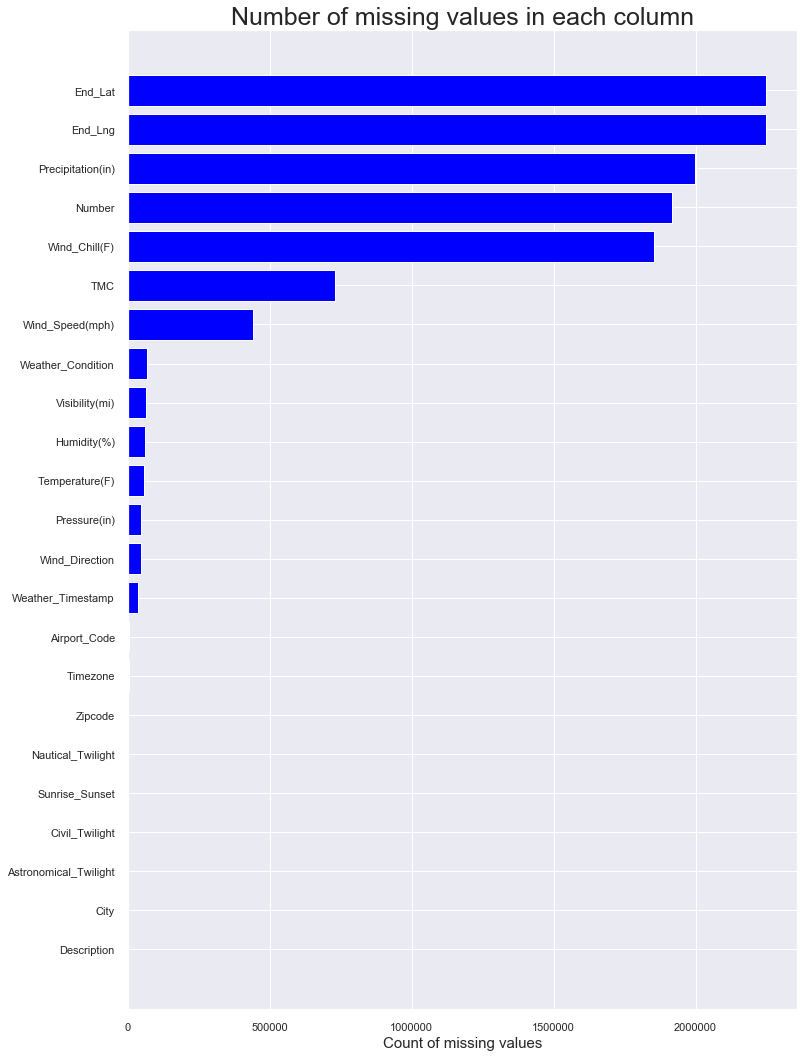

In [55]:
# Look for missing data and plot values for visuals
missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name','missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')

ind = np.arange(missing_df.shape[0])
fig,ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind,missing_df.missing_count.values,color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values",fontsize=axisFont)
ax.set_title("Number of missing values in each column",fontsize=titleFont)
plt.show()

The visualization above confirms the information in Table 1. The columns: End_Lat, End_Long, Precipitation, Number, Wind Chill, TMC and Wind Speed all contain a large amount of missing data. 

Digging a bit deeper into this missing data will provide an indication and additional verification of how much data is missing. Build out a table listing the missing values and look for items with more than 15% missing data.

In [56]:
#Get table listing of missing values. Look for items over 15%
missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['columns_name','missing_count']
missing_df['missing_ratio'] = missing_df['missing_count'] /df.shape[0]
missing_df.loc[missing_df['missing_ratio']>0.15]

,columns_name,missing_count,missing_ratio
2,TMC,728071,0.244784
8,End_Lat,2246264,0.755216
9,End_Lng,2246264,0.755216
12,Number,1917605,0.644717
24,Wind_Chill(F),1852623,0.622870
30,Precipitation(in),1998358,0.671867


The additional confirmation of these missing data items continues to match all the previous analysis. Given the high percentage of missing data in many of these fields it seems more beneficial to remove them from the analysis than to impute the data. The following actions will be taken on the data columns:

- End_Lat - remove due to high percentage of data missing
- End_Log - remove due to high percentage of data missing
- Number - remove due to high percentage of data missing
- TMC - remove due to high percententage of data missing
- Wind_Chill(F) - keep and inpute the required values
- Precipitation(in) - keep and inpute the required values


Begin building a list of the columns to be removed from the data set.

In [57]:
#build a list of columns to remove based on the missing ratio data above. Keep Wind_Chill and Precipitation
missing = missing_df.loc[missing_df['missing_ratio']>0.15]
removelist = missing['columns_name'].tolist()

#List columns to keep
keep_columns = {'Wind_Chill(F)', 'Precipitation(in)'} 
  
removelist = [ele for ele in removelist if ele not in keep_columns] 
removelist

['TMC', 'End_Lat', 'End_Lng', 'Number']

Now that columns have been analyzed for missing values, let's move on to evaluate other columns that may need to be removed or cleaned up due lack of uniqueness of data or data inconsistencies. Continue to build the list of fields to be removed and correct data as we progress through the analysis

In [58]:
df.nunique()

ID                       2974335
Source                         3
TMC                           21
Severity                       4
Start_Time               2743101
End_Time                 2761499
Start_Lat                1002359
Start_Lng                 985099
End_Lat                   298605
End_Lng                   302906
Distance(mi)               12847
Description              1597506
Number                     37398
Street                    160715
Side                           3
City                       11685
County                      1713
State                         49
Zipcode                   377152
Country                        1
Timezone                       4
Airport_Code                1995
Weather_Timestamp         470781
Temperature(F)               827
Wind_Chill(F)                971
Humidity(%)                  100
Pressure(in)                 994
Visibility(mi)                81
Wind_Direction                24
Wind_Speed(mph)              147
Precipitat

From the information above the following fields need further investigation to determine removal or cleanup:
- Wind_Direction
- Source
- Description
- ZipCode
- Weather Timestamp

In [59]:
#Add items to the remove list
#Look at the sources
print(df.Source.unique())

#There are only three sources and they more than likely have no bearing on analysis. Add them to the remove list
removelist.append('Source')

#The description field is largely text descriptors of the accidents. 
removelist.append('Description')

#The weather timestamp is just timing for when the weather report was used.
removelist.append('Weather_Timestamp')

#The street field is another field for removal. Focus is more at city/county/state level
removelist.append('Street')

#verify fields were added to the list
removelist

['MapQuest' 'MapQuest-Bing' 'Bing']


['TMC',
 'End_Lat',
 'End_Lng',
 'Number',
 'Source',
 'Description',
 'Weather_Timestamp',
 'Street']

In [60]:
#clean up inconsistencies in the data. 
#Make the wind direction values consistent. Look at the values to determine uniqueness.
print(df.Wind_Direction.unique())
df.Wind_Direction = df.Wind_Direction.replace('South','S')
df.Wind_Direction = df.Wind_Direction.replace('North','N')
df.Wind_Direction = df.Wind_Direction.replace('West','W')
df.Wind_Direction = df.Wind_Direction.replace('East','E')
df.Wind_Direction = df.Wind_Direction.replace('Variable','VAR')
(print(df.Wind_Direction.unique()))

#Zipcodes are a mix of 5-digit and Zip+4 values. Go ahead and make them all 5-digit zipcodes to consistency
df.Zipcode = df.Zipcode.str.slice(0,5,1)

['Calm' 'SW' 'SSW' 'WSW' 'WNW' 'NW' 'West' 'NNW' 'NNE' 'South' 'North'
 'Variable' 'SE' 'SSE' 'ESE' 'East' 'NE' 'ENE' 'E' 'W' nan 'S' 'VAR'
 'CALM' 'N']
['Calm' 'SW' 'SSW' 'WSW' 'WNW' 'NW' 'W' 'NNW' 'NNE' 'S' 'N' 'VAR' 'SE'
 'SSE' 'ESE' 'E' 'NE' 'ENE' nan 'CALM']


Wind Direction and Zipcode values are now constent. We will still need to address the missing values, but will come back to those as we make more decisions

For better data understanding we also want to rename some columns that may be confusing specifically:

- Amenity - this will be renamed PointOfInterest to better reflect what it is
- Give_Way - this will be renamed to Yield

In [61]:
#Convert column names as described above and verify
df.rename(columns={'Amenity':'PointOfInterest'},inplace=True)
df.rename(columns={'Give_Way':'Yield'},inplace=True)
df.dtypes

ID                        object
Source                    object
TMC                      float64
Severity                   int64
Start_Time                object
End_Time                  object
Start_Lat                float64
Start_Lng                float64
End_Lat                  float64
End_Lng                  float64
Distance(mi)             float64
Description               object
Number                   float64
Street                    object
Side                      object
City                      object
County                    object
State                     object
Zipcode                   object
Country                   object
Timezone                  object
Airport_Code              object
Weather_Timestamp         object
Temperature(F)           float64
Wind_Chill(F)            float64
Humidity(%)              float64
Pressure(in)             float64
Visibility(mi)           float64
Wind_Direction            object
Wind_Speed(mph)          float64
Precipitat

Now that all fields have been corrected and columns also identified for removal, proceed with removal of the data fields and verify the shape to show they were dropped

In [62]:
#drop the columns identified with limited data
df.drop(removelist,1,inplace=True)

#check the data shape
print(df.shape)
print(df.dtypes)

(2974335, 41)
ID                        object
Severity                   int64
Start_Time                object
End_Time                  object
Start_Lat                float64
Start_Lng                float64
Distance(mi)             float64
Side                      object
City                      object
County                    object
State                     object
Zipcode                   object
Country                   object
Timezone                  object
Airport_Code              object
Temperature(F)           float64
Wind_Chill(F)            float64
Humidity(%)              float64
Pressure(in)             float64
Visibility(mi)           float64
Wind_Direction            object
Wind_Speed(mph)          float64
Precipitation(in)        float64
Weather_Condition         object
PointOfInterest             bool
Bump                        bool
Crossing                    bool
Yield                       bool
Junction                    bool
No_Exit                     b

The shape call above confirms that the 7 columns identified have been dropped. 

Now that the data is relatively clean, let's add a additional columns to help with further data visualizations. Perform the follwing tasks:

- break the accident start time into component parts of year, month, day, hour, minute, second
- break the accident end time into component parts of year, month, day, hous, minute, second
- create a new feature for accident duration

In [63]:
#Add additional features for breaking apart time for EDA
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
df['End_Time'] = pd.to_datetime(df['End_Time'], errors='coerce')

# Extract year, month, day, hour and weekday for Start values
df['Start_Year']=df['Start_Time'].dt.year
df['Start_Month']=df['Start_Time'].dt.strftime('%b')
df['Start_Day']=df['Start_Time'].dt.day
df['Start_Hour']=df['Start_Time'].dt.hour
df['Start_Weekday']=df['Start_Time'].dt.strftime('%a')

# Extract year, month, day, hour and weekday for End values
df['End_Year']=df['End_Time'].dt.year
df['End_Month']=df['End_Time'].dt.strftime('%b')
df['End_Day']=df['End_Time'].dt.day
df['End_Hour']=df['End_Time'].dt.hour
df['End_Weekday']=df['End_Time'].dt.strftime('%a')

# Extract the amount of time in the unit of minutes for each accident, round to the nearest integer
df['Time_Duration(min)']=round((df['End_Time']-df['Start_Time'])/np.timedelta64(1,'m'))

Now that we have a cleaned up data frame. Let's look at any additional missing values we can possibly either correct or need to remove. From the chart below it looks as if City, Timezone and ZipCodes still have missing values. We'll try to go to an external data source to see if we can clean these up instead of deleting the rows with missing values.

In [64]:
#Get table listing of missing values. Look for items over %
missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['columns_name','missing_count']
missing_df['missing_ratio'] = missing_df['missing_count'] /df.shape[0]
missing_df.loc[missing_df['missing_ratio']>0.00]

,columns_name,missing_count,missing_ratio
8,City,83,0.000028
11,Zipcode,880,0.000296
13,Timezone,3163,0.001063
14,Airport_Code,5691,0.001913
15,Temperature(F),56063,0.018849
16,Wind_Chill(F),1852623,0.622870
17,Humidity(%),59173,0.019895
18,Pressure(in),48142,0.016186
19,Visibility(mi),65691,0.022086
20,Wind_Direction,45101,0.015163


In [170]:
#df.loc[df['Timezone'].isnull(),'Timezone'] = search.by_zipcode(df['Zipcode']).timezone
#df.loc[df['City']].isnull(),'City'] = search.by_zipcode(df['Zipcode']).major_city

df2 = df.head(100000).copy()
print(df2['Zipcode'].isna().sum())
df2['Zipcode'] = df2['Zipcode'].apply(zipByCityState(df2['City'].to_string(),df2['State'].to_string(),df2['Zipcode'].to_string()))
print(df2['Zipcode'].isna().sum())

#df['Timezone'] = df['Timezone'].swifter.apply(search.by_zipcode(df['Zipcode'].to_string()).timezone)
#df['Timezone'].fillna(getTimeZone(df['Zipcode'].to_string()),inplace=True)
#df['City'] = df['City'].swifter.apply(getMajorCity(df['Zipcode'].to_string()))

#df.apply(zipByCityState(df['City'].to_string(),df['State'].to_string(),axis=1)
#df['Timezone'].fillna(value=search.by_zipcode(df['Zipcode']).timezone,inplace=True)
#Use the USZipCode library to see if we can update blank cities based on ZipCode

7


AttributeError: '0        45424
1        43068
2        45176
3        45417
4        45459
5        43081
6        45417
7        45405
8        45404
9        43081
10       43228
11       43068
12       45420
13       45406
14       43213
15       45410
16       45402
17       45417
18       45409
19       45406
20       43230
21       45406
22       45342
23       43211
24       45417
25       43031
26       45419
27       45405
28       45406
29       45402
30       43017
31       45424
32       43224
33       43213
34       43212
35       43210
36       45409
37       43110
38       45404
39       43219
40       45036
41       45404
42       45169
43       43213
44       45414
45       43205
46       43220
47       43232
48       45404
49       45404
50       45405
51       45405
52       45405
53       43204
54       45449
55       45122
56       45417
57       45409
58       45410
59       45410
60       43229
61       45405
62       45068
63       45066
64       43112
65       45342
66       45054
67       44131
68       44137
69       43123
70       45840
71       45122
72       43215
73       43230
74       45324
75       45356
76       43232
77       45157
78       43202
79       45103
80       43068
81       43021
82       43204
83       43219
84       44203
85       44320
86       44903
87       44135
88       44320
89       45417
90       45106
91       44109
92       43202
93       43110
94       44321
95       43062
96       44130
97       45439
98       45402
99       45410
100      43213
101      43235
102      44137
103      45439
104      45405
105      45410
106      43207
107      45404
108      45406
109      45449
110      45402
111      45405
112      45414
113      45409
114      45403
115      45406
116      45417
117      45417
118      45402
119      43203
120      43211
121      45417
122      45402
123      45404
124      43229
125      43235
126      43235
127      43207
128      43232
129      43211
130      44273
131      44813
132      45373
133      43201
134      43230
135      43201
136      43215
137      43203
138      43213
139      43223
140      45177
141      45342
142      43215
143      43223
144      43215
145      45414
146      45424
147      43123
148      45404
149      45414
150      44129
151      45417
152      45449
153      43227
154      45406
155      43081
156      44303
157      43231
158      45403
159      45402
160      43062
161      45402
162      43219
163      44070
164      43125
165      43146
166      44887
167      43235
168      44333
169      43146
170      43110
171      43235
172      43017
173      43221
174      43224
175      45406
176      43223
177      44136
178      45440
179      43125
180      43223
181      43113
182      43123
183      45405
184      43085
185      44902
186      44320
187      43230
188      43214
189      45660
190      43204
191      45416
192      43230
193      43110
194      43214
195      43214
196      45431
197      45449
198      45406
199      45404
200      45420
201      43017
202      25526
203      45402
204      43230
205      45385
206      45417
207      43215
208      45106
209      44321
210      44035
211      45439
212      44320
213      45417
214      43147
215      45449
216      45106
217      43081
218      44203
219      45402
220      45410
221      44203
222      44214
223      44131
224      45417
225      45404
226      45405
227      43701
228      45459
229      45872
230      45342
231      45406
232      43215
233      43207
234      45414
235      44125
236      43147
237      44320
238      43143
239      44144
240      44135
241      45414
242      45432
243      43230
244      45342
245      45403
246      45403
247      43209
248      44135
249      45458
250      45414
251      44130
252      43221
253      45410
254      43223
255      44144
256      43211
257      44130
258      44135
259      44131
260      45424
261      43143
262      45414
263      45440
264      45402
265      45402
266      45410
267      45371
268      45458
269      43205
270      43235
271      45405
272      45439
273      43207
274      43204
275      43207
276      45103
277      45420
278      43203
279      43031
280      45404
281      43026
282      43026
283      45430
284      43402
285      43205
286      45402
287      45405
288      45410
289      45409
290      45403
291      45417
292      45405
293      45402
294      45402
295      43021
296      43017
297      43212
298      45404
299      45403
300      43229
301      45403
302      43402
303      43068
304      43227
305      43110
306      45403
307      43147
308      43235
309      45403
310      45403
311      43201
312      45122
313      43229
314      43081
315      45039
316      45439
317      45414
318      45415
319      45403
320      45409
321      45414
322      45414
323      45420
324      45403
325      45414
326      44089
327      45410
328      45459
329      45414
330      45402
331      43147
332      45066
333      45150
334      43212
335      45150
336      45440
337      45342
338      43204
339      45416
340      45404
341      43212
342      45414
343      45404
344      45458
345      44142
346      43224
347      43203
348      43219
349      43207
350      43123
351      45439
352      45449
353      45417
354      43402
355      45324
356      45342
357      45424
358      43231
359      44109
360      45404
361      45424
362      44203
363      25082
364      45410
365      43228
366      43204
367      45439
368      44203
369      45324
370      44314
371      44131
372      44203
373      45458
374      43725
375      45439
376      45402
377      45406
378      45410
379      43015
380      45419
381      43112
382      43402
383      45406
384      45410
385      43235
386      45153
387      43213
388      44074
389      45410
390      43229
391      45405
392      43123
393      45449
394      45342
395      45405
396      45414
397      43215
398      45420
399      43223
400      44203
401      45405
402      43081
403      45410
404      45410
405      45439
406      45405
407      44137
408      45342
409      43215
410      45405
411      44333
412      45449
413      45410
414      45432
415      45405
416      43228
417      45404
418      45459
419      45404
420      45405
421      43201
422      45356
423      45415
424      45459
425      43204
426      45342
427      45405
428      43223
429      43209
430      43228
431      45324
432      45103
433      45150
434      45171
435      45356
436      43219
437      45342
438      43081
439      43035
440      43219
441      43230
442      43230
443      45342
444      43123
445      43402
446      43232
447      43232
448      44141
449      45404
450      45405
451      45404
452      43230
453      45628
454      43224
455      45409
456      45404
457      43204
458      43209
459      45107
460      45103
461      45402
462      43223
463      45417
464      45424
465      45459
466      45403
467      45405
468      45410
469      45439
470      43147
471      43204
472      45405
473      45405
474      45410
475      43232
476      45402
477      43214
478      43214
479      43204
480      43123
481      44333
482      43223
483      45414
484      45404
485      45417
486      45417
487      45404
488      43402
489      45417
490      43204
491      43068
492      43230
493      45420
494      45312
495      43085
496      45432
497      45402
498      45417
499      45417
500      43223
501      43219
502      43222
503      43223
504      45410
505      45840
506      44321
507      43017
508      45406
509      44109
510      45342
511      45431
512      43235
513      43081
514      45409
515      45402
516      45459
517      45439
518      45405
519      45403
520      43207
521      45804
522      45405
523      45405
524      45424
525      43232
526      45102
527      45103
528      43210
529      43081
530      45410
531      43230
532      44130
533      45403
534      45410
535      45103
536      45342
537      45459
538      45406
539      45404
540      43235
541      45402
542      45406
543      43212
544      43016
545      43017
546      43214
547      43232
548      45801
549      45449
550      43202
551      43211
552      43081
553      43017
554      43055
555      45416
556      45406
557      43212
558      45409
559      45402
560      45409
561      45459
562      45404
563      45410
564      45414
565      45405
566      45505
567      45439
568      45505
569      45439
570      43147
571      45429
572      45405
573      45377
574      43119
575      45431
576      45103
577      43085
578      43209
579      45406
580      45405
581      45410
582      45342
583      45404
584      45404
585      43106
586      43204
587      45403
588      43223
589      45404
590      45631
591      45410
592      43203
593      45342
594      43207
595      45404
596      43137
597      43137
598      43215
599      43204
600      44035
601      44846
602      44135
603      45424
604      45405
605      45405
606      45459
607      45406
608      45404
609      45403
610      43215
611      43223
612      45439
613      45122
614      45414
615      43223
616      43223
617      45459
618      44070
619      43223
620      43201
621      43212
622      43219
623      43017
624      43215
625      43211
626      43228
627      43224
628      44131
629      44307
630      43229
631      45417
632      45153
633      45066
634      45405
635      43227
636      45040
637      45420
638      45324
639      45419
640      45415
641      43017
642      45103
643      45417
644      44035
645      45458
646      43402
647      45406
648      45458
649      45404
650      45405
651      45417
652      45420
653      45449
654      45449
655      43046
656      45404
657      43081
658      45410
659      45410
660      43204
661      44131
662      45405
663      45405
664      45420
665      45417
666      45405
667      45405
668      45402
669      45414
670      45404
671      43213
672      45404
673      45344
674      45409
675      43081
676      45150
677      43147
678      45409
679      43125
680      43204
681      43228
682      45459
683      43212
684      45420
685      45405
686      43074
687      44070
688      45414
689      45410
690      45160
691      45405
692      45458
693      45458
694      43215
695      43205
696      43205
697      45417
698      45410
699      45409
700      45458
701      45406
702      45410
703      45406
704      45414
705      45417
706      45406
707      45405
708      43123
709      43201
710      45403
711      45420
712      45458
713      45417
714      45406
715      45458
716      45419
717      45417
718      45417
719      43074
720      45449
721      45449
722      45402
723      45409
724      45458
725      43081
726      44321
727      43140
728      94591
729      94544
730      94595
731      95014
732      95118
733      94588
734      95112
735      94112
736      94563
737      94551
738      94931
739      94520
740      94551
741      94085
742      94568
743      95828
744      95841
745      94085
746      94601
747      95002
748      95131
749      94588
750      95037
751      94952
752      94553
753      94952
754      94030
755      95660
756      94541
757      94551
758      95492
759      94507
760      95037
761      95046
762      95448
763      94005
764      94303
765      94134
766      94107
767      95035
768      95131
769      95618
770      94607
771      94602
772      95128
773      95757
774      95618
775      95821
776      94019
777      94025
778      95624
779      95377
780      95608
781      94606
782      95746
783      94587
784      95618
785      94523
786      95122
787      94403
788      94134
789      94618
790      94520
791      95742
792      95959
793      95828
794      94303
795      95687
796      95661
797      95641
798      95837
799      95827
800      95648
801      95818
802      95623
803      94925
804      94578
805      94526
806      95032
807      94588
808      94129
809      94546
810      95304
811      94551
812      95206
813      95490
814      95819
815      95661
816      95661
817      95746
818      95403
819      94022
820      95126
821      94801
822      95620
823      95836
824      94541
825      95959
826      95464
827      94606
828      94509
829      94508
830      94597
831      95116
832      95125
833      94130
834      94541
835      94560
836      94945
837      94010
838      95833
839      94586
840      95667
841      94534
842      95066
843      94551
844      95236
845      95051
846      94806
847      94564
848      94063
849      95670
850      94587
851      94520
852      94568
853      95841
854      94062
855      93901
856      94607
857      95822
858      94949
859      94954
860      94804
861      94563
862      95073
863      93940
864      94551
865      93908
866      94590
867      94539
868      95035
869      94586
870      94547
871      94621
872      94553
873      94586
874      93955
875      95121
876      95823
877      95821
878      95826
879      95377
880      94564
881      95014
882      95070
883      95823
884      95624
885      94597
886      95203
887      94547
888      94579
889      95014
890      95054
891      94005
892      94503
893      94607
894      95070
895      94107
896      94607
897      94563
898      95823
899      94403
900      95825
901      94601
902      94553
903      95834
904      95821
905      94560
906      95693
907      95818
908      94565
909      95949
910      95065
911      94539
912      95242
913      95476
914      95842
915      94107
916      95110
917      95603
918      95678
919      95959
920      95035
921      95842
922      95841
923      95662
924      95949
925      95618
926      94555
927      95603
928      95603
929      95126
930      95126
931      94608
932      94080
933      94552
934      94507
935      95624
936      95838
937      95616
938      95817
939      95818
940      95603
941      95833
942      95330
943      95330
944      95838
945      95682
946      95304
947      95117
948      95661
949      95945
950      95660
951      94066
952      94555
953      95825
954      95476
955      94105
956      95351
957      95667
958      94534
959      95112
960      95304
961      95131
962      94022
963      94546
964      95128
965      94588
966      94566
967      94605
968      94534
969      94103
970      94546
971      94710
972      94107
973      95330
974      95648
975      95206
976      94010
977      95128
978      95020
979      95841
980      94534
981      95116
982      95330
983      95661
984      94952
985      95841
986      95320
987      94112
988      95126
989      95112
990      94514
991      95663
992      94598
993      94566
994      95618
995      94565
996      94566
997      95660
998      95621
999      95762
1000     94588
1001     95116
1002     95828
1003     95670
1004     94025
1005     94551
1006     94534
1007     95824
1008     95823
1009     94134
1010     94063
1011     94545
1012     95391
1013     95661
1014     94134
1015     94805
1016     94530
1017     94066
1018     95134
1019     94551
1020     94402
1021     94103
1022     94607
1023     94605
1024     95050
1025     95112
1026     93940
1027     94551
1028     94551
1029     94062
1030     95476
1031     95037
1032     94019
1033     94585
1034     95641
1035     95826
1036     95112
1037     94588
1038     95062
1039     94551
1040     95641
1041     95838
1042     95842
1043     94523
1044     95033
1045     95377
1046     95376
1047     95236
1048     94564
1049     95476
1050     95621
1051     94806
1052     95616
1053     95628
1054     94559
1055     95014
1056     94588
1057     95618
1058     95833
1059     95819
1060     95834
1061     95304
1062     95834
1063     95757
1064     95203
1065     94806
1066     94612
1067     95835
1068     94545
1069     94551
1070     95618
1071     95757
1072     95203
1073     94080
1074     95125
1075     95065
1076     95713
1077     94619
1078     94585
1079     94103
1080     94134
1081     94597
1082     95492
1083     95476
1084     94105
1085     95620
1086     94607
1087     94062
1088     94553
1089     94586
1090     94607
1091     95032
1092     94586
1093     95116
1094     95820
1095     95358
1096     94536
1097     95677
1098     94503
1099     94804
1100     95757
1101     95821
1102     95841
1103     94607
1104     95116
1105     94804
1106     95823
1107     94806
1108     95949
1109     94062
1110     93908
1111     95820
1112     95655
1113     94089
1114     95112
1115     95330
1116     95356
1117     94022
1118     94588
1119     95358
1120     95131
1121     95014
1122     94611
1123     94552
1124     95825
1125     94538
1126     94545
1127     95864
1128     94710
1129     95129
1130     95129
1131     94941
1132     94066
1133     94401
1134     94403
1135     94070
1136     95476
1137     95003
1138     95826
1139     95407
1140     94025
1141     95129
1142     94583
1143     95670
1144     95003
1145     94080
1146     95133
1147     95660
1148     95215
1149     94609
1150     95824
1151     95062
1152     94539
1153     94066
1154     95834
1155     95660
1156     95695
1157     94608
1158     94608
1159     94606
1160     94588
1161     94806
1162     95661
1163     95814
1164     95824
1165     95650
1166     94545
1167     94130
1168     94597
1169     95621
1170     94552
1171     94107
1172     94544
1173     95630
1174     94555
1175     94551
1176     95621
1177     94507
1178     95129
1179     95133
1180     95690
1181     95841
1182     95621
1183     94565
1184     94545
1185     94544
1186     94533
1187     95304
1188     95834
1189     95206
1190     95618
1191     95206
1192     95206
1193     94134
1194     94710
1195     94526
1196     94607
1197     95125
1198     94550
1199     95945
1200     94520
1201     94952
1202     95476
1203     94089
1204     94572
1205     94579
1206     94580
1207     95620
1208     94547
1209     94583
1210     94588
1211     94965
1212     94541
1213     95688
1214     95032
1215     94585
1216     94710
1217     94519
1218     94028
1219     94107
1220     94806
1221     95492
1222     94158
1223     94534
1224     94507
1225     95112
1226     94526
1227     95033
1228     94567
1229     95403
1230     95330
1231     95336
1232     95377
1233     94015
1234     94801
1235     94063
1236     94551
1237     94130
1238     95205
1239     95403
1240     94591
1241     94551
1242     94954
1243     94806
1244     94087
1245     95204
1246     95033
1247     95245
1248     94015
1249     94107
1250     94806
1251     94022
1252     95824
1253     95628
1254     95616
1255     94580
1256     94578
1257     95121
1258     95621
1259     95465
1260     94112
1261     94534
1262     94586
1263     94586
1264     95658
1265     94607
1266     95035
1267     94550
1268     94565
1269     95608
1270     95630
1271     95630
1272     94806
1273     95630
1274     94587
1275     95616
1276     94080
1277     94066
1278     95446
1279     94066
1280     94545
1281     94515
1282     94028
1283     94579
1284     95842
1285     95632
1286     95824
1287     94607
1288     94551
1289     94503
1290     94588
1291     94552
1292     94589
1293     94525
1294     95121
1295     95407
1296     94107
1297     94523
1298     95116
1299     95442
1300     94558
1301     95401
1302     94928
1303     94578
1304     94303
1305     94010
1306     94112
1307     95242
1308     95304
1309     95206
1310     95642
1311     94583
1312     94588
1313     95492
1314     94525
1315     94062
1316     95366
1317     95476
1318     95690
1319     95203
1320     94544
1321     94952
1322     94130
1323     94549
1324     95439
1325     95129
1326     95620
1327     95320
1328     94603
1329     94577
1330     94621
1331     95304
1332     94506
1333     95116
1334     94801
1335     94404
1336     94565
1337     95128
1338     94607
1339     95407
1340     94710
1341     94545
1342     94546
1343     94588
1344     95032
1345     94580
1346     94533
1347     94804
1348     95472
1349     94521
1350     95030
1351     94538
1352     94551
1353     94964
1354     94586
1355     94580
1356     95032
1357     94565
1358     94010
1359     94564
1360     94015
1361     94710
1362     94806
1363     94545
1364     94134
1365     94555
1366     95129
1367     95054
1368     95436
1369     94022
1370     94588
1371     94509
1372     94591
1373     95403
1374     95377
1375     95020
1376     95821
1377     95121
1378     95823
1379     95476
1380     95062
1381     95687
1382     95632
1383     95677
1384     94062
1385     94553
1386     94545
1387     95116
1388     95834
1389     94112
1390     95023
1391     95660
1392     94130
1393     94063
1394     94560
1395     95023
1396     95203
1397     95746
1398     95667
1399     94579
1400     95118
1401     95304
1402     94580
1403     94533
1404     95816
1405     95841
1406     94588
1407     95020
1408     94545
1409     94553
1410     95841
1411     95621
1412     94583
1413     94591
1414     94552
1415     94588
1416     94539
1417     95837
1418     95818
1419     94507
1420     95128
1421     94551
1422     95818
1423     95827
1424     94005
1425     94606
1426     94588
1427     94588
1428     95212
1429     94132
1430     94588
1431     95821
1432     94954
1433     94947
1434     95219
1435     94304
1436     95215
1437     95210
1438     95661
1439     95605
1440     94551
1441     95826
1442     94580
1443     95662
1444     94619
1445     95667
1446     95222
1447     95206
1448     95824
1449     95817
1450     95821
1451     95608
1452     95817
1453     95817
1454     95828
1455     95632
1456     95209
1457     95837
1458     95826
1459     95219
1460     95682
1461     94606
1462     95616
1463     95616
1464     94596
1465     95220
1466     95252
1467     95608
1468     95603
1469     95377
1470     94112
1471     95618
1472     94952
1473     95618
1474     95377
1475     95823
1476     95758
1477     95630
1478     95834
1479     95203
1480     94538
1481     94568
1482     95035
1483     95110
1484     95035
1485     95125
1486     95315
1487     95131
1488     94551
1489     95377
1490     95648
1491     95682
1492     95667
1493     95640
1494     95377
1495     95818
1496     95116
1497     95822
1498     95023
1499     95377
1500     95125
1501     95014
1502     94568
1503     94599
1504     94595
1505     95118
1506     94596
1507     94621
1508     95377
1509     95608
1510     94115
1511     95231
1512     95667
1513     95824
1514     95722
1515     95128
1516     95660
1517     95320
1518     95841
1519     95817
1520     95660
1521     94526
1522     95818
1523     95842
1524     94103
1525     95817
1526     95827
1527     95621
1528     95946
1529     95829
1530     95817
1531     94401
1532     94710
1533     94608
1534     95126
1535     95126
1536     95682
1537     94903
1538     94602
1539     94536
1540     95687
1541     94565
1542     94509
1543     95231
1544     95240
1545     94546
1546     95032
1547     95118
1548     94565
1549     95837
1550     95660
1551     95638
1552     95128
1553     94539
1554     95358
1555     94085
1556     95401
1557     95128
1558     95012
1559     95945
1560     95709
1561     95476
1562     94551
1563     95231
1564     95691
1565     95304
1566     95823
1567     95678
1568     95678
1569     95624
1570     95628
1571     94010
1572     94577
1573     95690
1574     95220
1575     95603
1576     94710
1577     94601
1578     94621
1579     95818
1580     95817
1581     95833
1582     95818
1583     95658
1584     95838
1585     94606
1586     94551
1587     94551
1588     95841
1589     95215
1590     95661
1591     95837
1592     95833
1593     95758
1594     95826
1595     95206
1596     94515
1597     95203
1598     94025
1599     94538
1600     95209
1601     94550
1602     95403
1603     94590
1604     95062
1605     95062
1606     95215
1607     95497
1608     95051
1609     94080
1610     94062
1611     94952
1612     94105
1613     94520
1614     94507
1615     94503
1616     94586
1617     95005
1618     95641
1619     95304
1620     95320
1621     95472
1622     95060
1623     95620
1624     95039
1625     95004
1626     95304
1627     95626
1628     95620
1629     94514
1630     95242
1631     93960
1632     94952
1633     94124
1634     94564
1635     95991
1636     94931
1637     94066
1638     95377
1639     95023
1640     94534
1641     94534
1642     94533
1643     95122
1644     95023
1645     93620
1646     94947
1647     94541
1648     94545
1649     95816
1650     95825
1651     94590
1652     95014
1653     95116
1654     95070
1655     95054
1656     95134
1657     95490
1658     95014
1659     95035
1660     95242
1661     94025
1662     95032
1663     95864
1664     95014
1665     95816
1666     95746
1667     95667
1668     94607
1669     95054
1670     95817
1671     95949
1672     95356
1673     95436
1674     94903
1675     94105
1676     95602
1677     95368
1678     95458
1679     94567
1680     95824
1681     95821
1682     95404
1683     94563
1684     95660
1685     95037
1686     94607
1687     94063
1688     95823
1689     95205
1690     95231
1691     95821
1692     95660
1693     95843
1694     95648
1695     95673
1696     95628
1697     95949
1698     95618
1699     95818
1700     95818
1701     95252
1702     95841
1703     95816
1704     95219
1705     94130
1706     94804
1707     94510
1708     95838
1709     94551
1710     95618
1711     95618
1712     95628
1713     94539
1714     95661
1715     95661
1716     95630
1717     94806
1718     94024
1719     94552
1720     94588
1721     94586
1722     95660
1723     95678
1724     95304
1725     95841
1726     95757
1727     95457
1728     95336
1729     94607
1730     94925
1731     95694
1732     95032
1733     95134
1734     95693
1735     95023
1736     95066
1737     94903
1738     94607
1739     94605
1740     95023
1741     94806
1742     94592
1743     94587
1744     95391
1745     95356
1746     94080
1747     94710
1748     94534
1749     95827
1750     95401
1751     94401
1752     94533
1753     94533
1754     94588
1755     94588
1756     95112
1757     94520
1758     95823
1759     95361
1760     95380
1761     94949
1762     95476
1763     94002
1764     94503
1765     94591
1766     94538
1767     94551
1768     95823
1769     95630
1770     95006
1771     94536
1772     94134
1773     94005
1774     95129
1775     93923
1776     94303
1777     95112
1778     95621
1779     94041
1780     95014
1781     95051
1782     95076
1783     93901
1784     95841
1785     95678
1786     95492
1787     94596
1788     94539
1789     95765
1790     95236
1791     95472
1792     94515
1793     94103
1794     94544
1795     95391
1796     94565
1797     95304
1798     95632
1799     95215
1800     95819
1801     95661
1802     95757
1803     95608
1804     95678
1805     95320
1806     95631
1807     95628
1808     94591
1809     95817
1810     95231
1811     95832
1812     95603
1813     95959
1814     94015
1815     94621
1816     94608
1817     94526
1818     95824
1819     95823
1820     95821
1821     95304
1822     95203
1823     94603
1824     95330
1825     95330
1826     95215
1827     95814
1828     95693
1829     94022
1830     95691
1831     95833
1832     95818
1833     95407
1834     94022
1835     95841
1836     95776
1837     95834
1838     95819
1839     93640
1840     94710
1841     95328
1842     94601
1843     94566
1844     93622
1845     95823
1846     95864
1847     95222
1848     94080
1849     94566
1850     94566
1851     95203
1852     94555
1853     95054
1854     95641
1855     95245
1856     94710
1857     94597
1858     94130
1859     94103
1860     94130
1861     94063
1862     94544
1863     94538
1864     94539
1865     95462
1866     94610
1867     94539
1868     94607
1869     94591
1870     95673
1871     94608
1872     95035
1873     95690
1874     94602
1875     94303
1876     95033
1877     93960
1878     95023
1879     95817
1880     95762
1881     95691
1882     94025
1883     94089
1884     95008
1885     95128
1886     95826
1887     94025
1888     95123
1889     95762
1890     94560
1891     94939
1892     94901
1893     94901
1894     94403
1895     94533
1896     95131
1897     94588
1898     94946
1899     94710
1900     94588
1901     94066
1902     94923
1903     95060
1904     95835
1905     95823
1906     94507
1907     94551
1908     95304
1909     95209
1910     95330
1911     94551
1912     94588
1913     95377
1914     95304
1915     94553
1916     95008
1917     94586
1918     94941
1919     94539
1920     94580
1921     94605
1922     94534
1923     94103
1924     94534
1925     95134
1926     94710
1927     94544
1928     94546
1929     94544
1930     95008
1931     94931
1932     94534
1933     94952
1934     94110
1935     94534
1936     94534
1937     95439
1938     95020
1939     94533
1940     95688
1941     95687
1942     94591
1943     95713
1944     95206
1945     94544
1946     94591
1947     94552
1948     94510
1949     94539
1950     95138
1951     94110
1952     94010
1953     94063
1954     94025
1955     95125
1956     94513
1957     94941
1958     94804
1959     94523
1960     94551
1961     94534
1962     94005
1963     94538
1964     95126
1965     95206
1966     95304
1967     95220
1968     94903
1969     94710
1970     94520
1971     94965
1972     94130
1973     94903
1974     95215
1975     95215
1976     94129
1977     94112
1978     94903
1979     94607
1980     94080
1981     95215
1982     94592
1983     94710
1984     94591
1985     94544
1986     94507
1987     94526
1988     95472
1989     94945
1990     95033
1991     95008
1992     94558
1993     94621
1994     94040
1995     94580
1996     94544
1997     95134
1998     94801
1999     94107
2000     94061
2001     94591
2002     95687
2003     94503
2004     94588
2005     95401
2006     94547
2007     95116
2008     94609
2009     95377
2010     94074
2011     94544
2012     94553
2013     95377
2014     95129
2015     94551
2016     94513
2017     95825
2018     94591
2019     94553
2020     94803
2021     94928
2022     94710
2023     94618
2024     94533
2025     95687
2026     94608
2027     94565
2028     94535
2029     95033
2030     95112
2031     94134
2032     94577
2033     94533
2034     94103
2035     94134
2036     94520
2037     95039
2038     95240
2039     95360
2040     95451
2041     95660
2042     94583
2043     95076
2044     93924
2045     94526
2046     94533
2047     94588
2048     94965
2049     93908
2050     94580
2051     95957
2052     94550
2053     94103
2054     94965
2055     93906
2056     94130
2057     94558
2058     95033
2059     94589
2060     94544
2061     95010
2062     95949
2063     94609
2064     94589
2065     95453
2066     95336
2067     95679
2068     95765
2069     95823
2070     95206
2071     95823
2072     95304
2073     95820
2074     95377
2075     95377
2076     95821
2077     95660
2078     95841
2079     95838
2080     95618
2081     95828
2082     95823
2083     95829
2084     95667
2085     95632
2086     95658
2087     95762
2088     95490
2089     95605
2090     95864
2091     95829
2092     95682
2093     95461
2094     95687
2095     95634
2096     95368
2097     95835
2098     94130
2099     94954
2100     94565
2101     95110
2102     95917
2103     95828
2104     95023
2105     94607
2106     95386
2107     95660
2108     95687
2109     94112
2110     94134
2111     95118
2112     94103
2113     94804
2114     94710
2115     94591
2116     94588
2117     94551
2118     94610
2119     94591
2120     94605
2121     94553
2122     95111
2123     94546
2124     94509
2125     94130
2126     95035
2127     95659
2128     95060
2129     94565
2130     95817
2131     94019
2132     95003
2133     93907
2134     93926
2135     95023
2136     94952
2137     94904
2138     95688
2139     93926
2140     94566
2141     95020
2142     94928
2143     94129
2144     95037
2145     94941
2146     94066
2147     94544
2148     94043
2149     94560
2150     93960
2151     94403
2152     94507
2153     94538
2154     95363
2155     94541
2156     94610
2157     95065
2158     95842
2159     94070
2160     95688
2161     95688
2162     94080
2163     94520
2164     94588
2165     95476
2166     94603
2167     95051
2168     94571
2169     95828
2170     93620
2171     93908
2172     95823
2173     95023
2174     95691
2175     95618
2176     95820
2177     95838
2178     95815
2179     95662
2180     95835
2181     95838
2182     95691
2183     95757
2184     95762
2185     95821
2186     95826
2187     95220
2188     95677
2189     95817
2190     95818
2191     95817
2192     95838
2193     95690
2194     95023
2195     95937
2196     95842
2197     94555
2198     95690
2199     95673
2200     94539
2201     95757
2202     95823
2203     95336
2204     95228
2205     95242
2206     95820
2207     95821
2208     95841
2209     95815
2210     95701
2211     95823
2212     95451
2213     95762
2214     95219
2215     95820
2216     95490
2217     94129
2218     94565
2219     94403
2220     94520
2221     94565
2222     95667
2223     94521
2224     95842
2225     94591
2226     94578
2227     94041
2228     94608
2229     95831
2230     95037
2231     94560
2232     94536
2233     94565
2234     95240
2235     94080
2236     94560
2237     94107
2238     94545
2239     95008
2240     95012
2241     94607
2242     95822
2243     94526
2244     95988
2245     94534
2246     94565
2247     95035
2248     94534
2249     95112
2250     95901
2251     95824
2252     95824
2253     95630
2254     94551
2255     94534
2256     95377
2257     94710
2258     94564
2259     94572
2260     94087
2261     95035
2262     94618
2263     95050
2264     94597
2265     94551
2266     94806
2267     94525
2268     94541
2269     94587
2270     93907
2271     95678
2272     95363
2273     95360
2274     95762
2275     95667
2276     94107
2277     94525
2278     95660
2279     95336
2280     95320
2281     95624
2282     95682
2283     95203
2284     95605
2285     95823
2286     95628
2287     95864
2288     95608
2289     95762
2290     95215
2291     94105
2292     94130
2293     95377
2294     95817
2295     95709
2296     94550
2297     95842
2298     95841
2299     94520
2300     94565
2301     95818
2302     95823
2303     94103
2304     95054
2305     94539
2306     95834
2307     95823
2308     95825
2309     95205
2310     94080
2311     95762
2312     95691
2313     95833
2314     95252
2315     95123
2316     95831
2317     95816
2318     95815
2319     95388
2320     95838
2321     95252
2322     95324
2323     95482
2324     95618
2325     95828
2326     95825
2327     95842
2328     95618
2329     95815
2330     95363
2331     94520
2332     95833
2333     95446
2334     94618
2335     94520
2336     95382
2337     94952
2338     94551
2339     94025
2340     94541
2341     94539
2342     94947
2343     94903
2344     94901
2345     94551
2346     94551
2347     94525
2348     94519
2349     94565
2350     95128
2351     95112
2352     95112
2353     94534
2354     94534
2355     95620
2356     95823
2357     94596
2358     95620
2359     95616
2360     94903
2361     94005
2362     93908
2363     95377
2364     94903
2365     94804
2366     94523
2367     95377
2368     94134
2369     94552
2370     95125
2371     94019
2372     94523
2373     94555
2374     94951
2375     94710
2376     94705
2377     94602
2378     94578
2379     95118
2380     94588
2381     95841
2382     94565
2383     95825
2384     94949
2385     94024
2386     94565
2387     94568
2388     94509
2389     95818
2390     94066
2391     94705
2392     94580
2393     94551
2394     95304
2395     93940
2396     94580
2397     95126
2398     95612
2399     95628
2400     95667
2401     95616
2402     95240
2403     95746
2404     95823
2405     95682
2406     95818
2407     95815
2408     95829
2409     95627
2410     95817
2411     95816
2412     95825
2413     95652
2414     95834
2415     95815
2416     95825
2417     95207
2418     95663
2419     95682
2420     95667
2421     94595
2422     95824
2423     95608
2424     95633
2425     95833
2426     95841
2427     95682
2428     94928
2429     94024
2430     95864
2431     95662
2432     95667
2433     95825
2434     95821
2435     95608
2436     95746
2437     95667
2438     94070
2439     94544
2440     94588
2441     95818
2442     95661
2443     95618
2444     95661
2445     95037
2446     95841
2447     95616
2448     95815
2449     95608
2450     95670
2451     95678
2452     95713
2453     95817
2454     95817
2455     95824
2456     95966
2457     95817
2458     95240
2459     95215
2460     95670
2461     95110
2462     95834
2463     95380
2464     95380
2465     94062
2466     94043
2467     95407
2468     95828
2469     95765
2470     95023
2471     95448
2472     94538
2473     95023
2474     94044
2475     94580
2476     94520
2477     94565
2478     95823
2479     95821
2480     95205
2481     95215
2482     95012
2483     94965
2484     94551
2485     95020
2486     94044
2487     94089
2488     93908
2489     95827
2490     95670
2491     94555
2492     94010
2493     94534
2494     94534
2495     95242
2496     94014
2497     94014
2498     94010
2499     94608
2500     94520
2501     94520
2502     95112
2503     95123
2504     94710
2505     94710
2506     95033
2507     94804
2508     95051
2509     95442
2510     94601
2511     95073
2512     95116
2513     95695
2514     94534
2515     95062
2516     95687
2517     93908
2518     94941
2519     94606
2520     94601
2521     95112
2522     95135
2523     95476
2524     95833
2525     95695
2526     95816
2527     95304
2528     95815
2529     95618
2530     95304
2531     95215
2532     95823
2533     95677
2534     95616
2535     95304
2536     95304
2537     94608
2538     95037
2539     95330
2540     95837
2541     95363
2542     95650
2543     95650
2544     95132
2545     95618
2546     95304
2547     94080
2548     94539
2549     94610
2550     95632
2551     95834
2552     95621
2553     95818
2554     95817
2555     95304
2556     95776
2557     95834
2558     95660
2559     95205
2560     95215
2561     95602
2562     95949
2563     95660
2564     94403
2565     94404
2566     95618
2567     95821
2568     95757
2569     95828
2570     94085
2571     95825
2572     95841
2573     95695
2574     95648
2575     95949
2576     95618
2577     93635
2578     94544
2579     95401
2580     94025
2581     95632
2582     95215
2583     94525
2584     94565
2585     94525
2586     94804
2587     95476
2588     94063
2589     95118
2590     94070
2591     95240
2592     94609
2593     94538
2594     95252
2595     94063
2596     94592
2597     95128
2598     95203
2599     94964
2600     94530
2601     95203
2602     95126
2603     95304
2604     95377
2605     94509
2606     94608
2607     95337
2608     95825
2609     95304
2610     95838
2611     94066
2612     94605
2613     95134
2614     95377
2615     94605
2616     94579
2617     94541
2618     94546
2619     94597
2620     95033
2621     94583
2622     94588
2623     95207
2624     94952
2625     94545
2626     95821
2627     95209
2628     94066
2629     94568
2630     94085
2631     95116
2632     94578
2633     94015
2634     94010
2635     95014
2636     94553
2637     94544
2638     94515
2639     94010
2640     94520
2641     95131
2642     95051
2643     94519
2644     94080
2645     95242
2646     94130
2647     94025
2648     95032
2649     94534
2650     94538
2651     95205
2652     95220
2653     95135
2654     94103
2655     94941
2656     95841
2657     94608
2658     94544
2659     94710
2660     95605
2661     94607
2662     94024
2663     95330
2664     94588
2665     94066
2666     94580
2667     95405
2668     94538
2669     95404
2670     94303
2671     94109
2672     94030
2673     94606
2674     94062
2675     95121
2676     95448
2677     95037
2678     94952
2679     94558
2680     94552
2681     95129
2682     94514
2683     95377
2684     95023
2685     95765
2686     95138
2687     95012
2688     95409
2689     94903
2690     94080
2691     94005
2692     94010
2693     94536
2694     95121
2695     95841
2696     95677
2697     95112
2698     95835
2699     94025
2700     94539
2701     94608
2702     95368
2703     95368
2704     94564
2705     94085
2706     95128
2707     95462
2708     95062
2709     95121
2710     95121
2711     94901
2712     95050
2713     95037
2714     93907
2715     95046
2716     95838
2717     95624
2718     94563
2719     94619
2720     94546
2721     94539
2722     94404
2723     94566
2724     95965
2725     95401
2726     95825
2727     95945
2728     94965
2729     94550
2730     95403
2731     94591
2732     94544
2733     95388
2734     95329
2735     93635
2736     95912
2737     95660
2738     95841
2739     95045
2740     94303
2741     95458
2742     95407
2743     95407
2744     95687
2745     94610
2746     95035
2747     94564
2748     94558
2749     95441
2750     94804
2751     95128
2752     95450
2753     94558
2754     94565
2755     94551
2756     95620
2757     94563
2758     95062
2759     95363
2760     94563
2761     94124
2762     95003
2763     94551
2764     94550
2765     94551
2766     94545
2767     94534
2768     95823
2769     95304
2770     95330
2771     95252
2772     94806
2773     94303
2774     95121
2775     94710
2776     94534
2777     94533
2778     94507
2779     94507
2780     95032
2781     95125
2782     94565
2783     95110
2784     93940
2785     95377
2786     95363
2787     94804
2788     94544
2789     94553
2790     94545
2791     94087
2792     93940
2793     94533
2794     94597
2795     95134
2796     94134
2797     94305
2798     94403
2799     94597
2800     94555
2801     94954
2802     94087
2803     94560
2804     95124
2805     94566
2806     94030
2807     94601
2808     94539
2809     95132
2810     95814
2811     94580
2812     95841
2813     94025
2814     94588
2815     95695
2816     95823
2817     95441
2818     95818
2819     95962
2820     95407
2821     95816
2822     94710
2823     93908
2824     95818
2825     94710
2826     94803
2827     95030
2828     95842
2829     93622
2830     95304
2831     95823
2832     95831
2833     95825
2834     95667
2835     95448
2836     94541
2837     95843
2838     95603
2839     94544
2840     95670
2841     95632
2842     94080
2843     94588
2844     95112
2845     94552
2846     95122
2847     95616
2848     95618
2849     95837
2850     95842
2851     95834
2852     95240
2853     95694
2854     95691
2855     95628
2856     95826
2857     95742
2858     95834
2859     95823
2860     95819
2861     95815
2862     95242
2863     95220
2864     94134
2865     95823
2866     95677
2867     95403
2868     95818
2869     95603
2870     95605
2871     95602
2872     95035
2873     95054
2874     94019
2875     94597
2876     95682
2877     94507
2878     94605
2879     94103
2880     94577
2881     94063
2882     95116
2883     95110
2884     94607
2885     95837
2886     95112
2887     93960
2888     94553
2889     94553
2890     94588
2891     94544
2892     94553
2893     95691
2894     95828
2895     95687
2896     93905
2897     94587
2898     95249
2899     94105
2900     94087
2901     95620
2902     94805
2903     95988
2904     94580
2905     95377
2906     95407
2907     94619
2908     94565
2909     94025
2910     95062
2911     95125
2912     94107
2913     94555
2914     94545
2915     94552
2916     95121
2917     93901
2918     94515
2919     93923
2920     94586
2921     93901
2922     94043
2923     94555
2924     95014
2925     95035
2926     94063
2927     94952
2928     94607
2929     95687
2930     94538
2931     94559
2932     94025
2933     94583
2934     94621
2935     94603
2936     94551
2937     95695
2938     95623
2939     95818
2940     95304
2941     95304
2942     95843
2943     95662
2944     95827
2945     95628
2946     95628
2947     95366
2948     95949
2949     94607
2950     94566
2951     95818
2952     95841
2953     95220
2954     95678
2955     94551
2956     95817
2957     95838
2958     95820
2959     94563
2960     95819
2961     95670
2962     95670
2963     95838
2964     95330
2965     95819
2966     95816
2967     95304
2968     95678
2969     95212
2970     95662
2971     95304
2972     95624
2973     94520
2974     94558
2975     93907
2976     94608
2977     95023
2978     93960
2979     94590
2980     95138
2981     95828
2982     95821
2983     95632
2984     94553
2985     94566
2986     95037
2987     95023
2988     94515
2989     95045
2990     94564
2991     94601
2992     94541
2993     94553
2994     94555
2995     95131
2996     94534
2997     95111
2998     95377
2999     94952
3000     94580
3001     94523
3002     94552
3003     94520
3004     95112
3005     95377
3006     95351
3007     95407
3008     94621
3009     94605
3010     94565
3011     95621
3012     95023
3013     95023
3014     94112
3015     94801
3016     94403
3017     95020
3018     95935
3019     94401
3020     94089
3021     95134
3022     94010
3023     94710
3024     94545
3025     94925
3026     94804
3027     94553
3028     95988
3029     94577
3030     94578
3031     94541
3032     95206
3033     95828
3034     94599
3035     95231
3036     95678
3037     95677
3038     95825
3039     95203
3040     95838
3041     95624
3042     95660
3043     95206
3044     95368
3045     95823
3046     95842
3047     95304
3048     95682
3049     95682
3050     94586
3051     95377
3052     95826
3053     95608
3054     95220
3055     95606
3056     95304
3057     95821
3058     95827
3059     95249
3060     94587
3061     95014
3062     95377
3063     95834
3064     94945
3065     95035
3066     95037
3067     95811
3068     95219
3069     95648
3070     95204
3071     95648
3072     95683
3073     95816
3074     95838
3075     95219
3076     95670
3077     95630
3078     95864
3079     94565
3080     95206
3081     95206
3082     95612
3083     95959
3084     95687
3085     94551
3086     95451
3087     95014
3088     95133
3089     95687
3090     95691
3091     95624
3092     95363
3093     95324
3094     95726
3095     94607
3096     94591
3097     94520
3098     95823
3099     95825
3100     95841
3101     95386
3102     94572
3103     95660
3104     95449
3105     94567
3106     94611
3107     93926
3108     94129
3109     94509
3110     94520
3111     95377
3112     94551
3113     94401
3114     94597
3115     94505
3116     94710
3117     95476
3118     94105
3119     94608
3120     94579
3121     94103
3122     95404
3123     94588
3124     95112
3125     94621
3126     94130
3127     94534
3128     94523
3129     95691
3130     95377
3131     95691
3132     95834
3133     93926
3134     94070
3135     95110
3136     95660
3137     95661
3138     95662
3139     94130
3140     94545
3141     94545
3142     94550
3143     95377
3144     95660
3145     95222
3146     95118
3147     95004
3148     95458
3149     95138
3150     94545
3151     95834
3152     95838
3153     95864
3154     94710
3155     94579
3156     94085
3157     95838
3158     94015
3159     94107
3160     94601
3161     95014
3162     94560
3163     95129
3164     95129
3165     94124
3166     94107
3167     95014
3168     95054
3169     94080
3170     94804
3171     94403
3172     94085
3173     95054
3174     94538
3175     94588
3176     95116
3177     94952
3178     95073
3179     94609
3180     94541
3181     94086
3182     95032
3183     95110
3184     94010
3185     94608
3186     95757
3187     95815
3188     95205
3189     95673
3190     95624
3191     95304
3192     95203
3193     94587
3194     95626
3195     95608
3196     95682
3197     95618
3198     94534
3199     95827
3200     95608
3201     95336
3202     95667
3203     95252
3204     95618
3205     95825
3206     95842
3207     95693
3208     94510
3209     94533
3210     95129
3211     95377
3212     95203
3213     95682
3214     95837
3215     95815
3216     94580
3217     95035
3218     95815
3219     94534
3220     94534
3221     95070
3222     94586
3223     95219
3224     95765
3225     95320
3226     95304
3227     95205
3228     94080
3229     94806
3230     95112
3231     95691
3232     95304
3233     95330
3234     95330
3235     95212
3236     95746
3237     95618
3238     95377
3239     95304
3240     95678
3241     95829
3242     95304
3243     95818
3244     95304
3245     95630
3246     95650
3247     95815
3248     95825
3249     95660
3250     95628
3251     95658
3252     95959
3253     94507
3254     94588
3255     94588
3256     95110
3257     95020
3258     95834
3259     95351
3260     95358
3261     94061
3262     95129
3263     95966
3264     95240
3265     95351
3266     95307
3267     95628
3268     95357
3269     95245
3270     95959
3271     95366
3272     94610
3273     94544
3274     94550
3275     94005
3276     94085
3277     94066
3278     94080
3279     95116
3280     94901
3281     95206
3282     95687
3283     95832
3284     95816
3285     95815
3286     95215
3287     95492
3288     94303
3289     94586
3290     95330
3291     95242
3292     95205
3293     95391
3294     94587
3295     94015
3296     94403
3297     95116
3298     95618
3299     95618
3300     95628
3301     95841
3302     95476
3303     94558
3304     94607
3305     94043
3306     95709
3307     95709
3308     95492
3309     94941
3310     94572
3311     94555
3312     95110
3313     94586
3314     94551
3315     94514
3316     94505
3317     94954
3318     95476
3319     94110
3320     94534
3321     94544
3322     94568
3323     94565
3324     95628
3325     95829
3326     95824
3327     95829
3328     95462
3329     94954
3330     94710
3331     94601
3332     94580
3333     94555
3334     95130
3335     94965
3336     94621
3337     94303
3338     95127
3339     94945
3340     94533
3341     94533
3342     95377
3343     95758
3344     94030
3345     94534
3346     95133
3347     94022
3348     94566
3349     95620
3350     94621
3351     94541
3352     95116
3353     94539
3354     94553
3355     95688
3356     94530
3357     94403
3358     94303
3359     94303
3360     94588
3361     94513
3362     95834
3363     95242
3364     95304
3365     95632
3366     94546
3367     94507
3368     95620
3369     95616
3370     95608
3371     95203
3372     94066
3373     94563
3374     94507
3375     93940
3376     94568
3377     94551
3378     95023
3379     95821
3380     95203
3381     95215
3382     94041
3383     94710
3384     94043
3385     95124
3386     95035
3387     94080
3388     95620
3389     95815
3390     95819
3391     95826
3392     94588
3393     95959
3394     94606
3395     94588
3396     95670
3397     95240
3398     95823
3399     95667
3400     94531
3401     95407
3402     95830
3403     95819
3404     95819
3405     94608
3406     95841
3407     95672
3408     95694
3409     95663
3410     95658
3411     94605
3412     94597
3413     94520
3414     94588
3415     95608
3416     95212
3417     95603
3418     95821
3419     95603
3420     95820
3421     95673
3422     95205
3423     95618
3424     95660
3425     95670
3426     95691
3427     95828
3428     95758
3429     95207
3430     95628
3431     94583
3432     95630
3433     94552
3434     95652
3435     95652
3436     95626
3437     95841
3438     95382
3439     95215
3440     95628
3441     95324
3442     95441
3443     95864
3444     95456
3445     95673
3446     95621
3447     95252
3448     94112
3449     95624
3450     94806
3451     94545
3452     94539
3453     95125
3454     94591
3455     94607
3456     94590
3457     94545
3458     95076
3459     95401
3460     94589
3461     94063
3462     94544
3463     95070
3464     94565
3465     95128
3466     95826
3467     95023
3468     94558
3469     94303
3470     95816
3471     94903
3472     95138
3473     94605
3474     94544
3475     94087
3476     94552
3477     94568
3478     94588
3479     94514
3480     95304
3481     95823
3482     94062
3483     94618
3484     94545
3485     94552
3486     95014
3487     95062
3488     95035
3489     95035
3490     95821
3491     95693
3492     94063
3493     95131
3494     94952
3495     95758
3496     95820
3497     95762
3498     95377
3499     95816
3500     95742
3501     95252
3502     95242
3503     95842
3504     95619
3505     94526
3506     94541
3507     95304
3508     95825
3509     95215
3510     95826
3511     94608
3512     94085
3513     94568
3514     95054
3515     94588
3516     94022
3517     94546
3518     95131
3519     95215
3520     95662
3521     95388
3522     94080
3523     94525
3524     94507
3525     95673
3526     95482
3527     94303
3528     94538
3529     95117
3530     95822
3531     95832
3532     94553
3533     95307
3534     94130
3535     94609
3536     94525
3537     95815
3538     95815
3539     95219
3540     95603
3541     94129
3542     93907
3543     95076
3544     95616
3545     95624
3546     95818
3547     95823
3548     95828
3549     95628
3550     95212
3551     95660
3552     95823
3553     95337
3554     94112
3555     94403
3556     95821
3557     95207
3558     95018
3559     95366
3560     95945
3561     94952
3562     94403
3563     94577
3564     94605
3565     95123
3566     95837
3567     95864
3568     95614
3569     95138
3570     95608
3571     95842
3572     95683
3573     95814
3574     95825
3575     95682
3576     95762
3577     94541
3578     95110
3579     95628
3580     95959
3581     95817
3582     93640
3583     94080
3584     94710
3585     95822
3586     95835
3587     95816
3588     95823
3589     95826
3590     94107
3591     94526
3592     95116
3593     95682
3594     95382
3595     95662
3596     94549
3597     94085
3598     94588
3599     94551
3600     94505
3601     94130
3602     94062
3603     94028
3604     95825
3605     95490
3606     95490
3607     95825
3608     95682
3609     94806
3610     95330
3611     95746
3612     94901
3613     94107
3614     94553
3615     94710
3616     94611
3617     95407
3618     94578
3619     94565
3620     95111
3621     94525
3622     95121
3623     95405
3624     94403
3625     95688
3626     94130
3627     94607
3628     94588
3629     95690
3630     95045
3631     95690
3632     95035
3633     94551
3634     95035
3635     94586
3636     94103
3637     95033
3638     94618
3639     95045
3640     95407
3641     94925
3642     94545
3643     95070
3644     95377
3645     95825
3646     95682
3647     95401
3648     95128
3649     94588
3650     94550
3651     95820
3652     95823
3653     95608
3654     95683
3655     94022
3656     95691
3657     95304
3658     95843
3659     95670
3660     94579
3661     94541
3662     95603
3663     95465
3664     94539
3665     95076
3666     95824
3667     95336
3668     94134
3669     95608
3670     95661
3671     95361
3672     94806
3673     95062
3674     95620
3675     95045
3676     95838
3677     95843
3678     95667
3679     95828
3680     95660
3681     95023
3682     95336
3683     94577
3684     94577
3685     95242
3686     95670
3687     95949
3688     95667
3689     95742
3690     95603
3691     95678
3692     95820
3693     94110
3694     95665
3695     95945
3696     94526
3697     94551
3698     95827
3699     95330
3700     95959
3701     95320
3702     95252
3703     95726
3704     95817
3705     94571
3706     95817
3707     95828
3708     95231
3709     95677
3710     95632
3711     95838
3712     95829
3713     95665
3714     95665
3715     94710
3716     94555
3717     94588
3718     95128
3719     95122
3720     95834
3721     95824
3722     95823
3723     95304
3724     95864
3725     95663
3726     95825
3727     95825
3728     95632
3729     95742
3730     95814
3731     95628
3732     95356
3733     95485
3734     95240
3735     95827
3736     94080
3737     94066
3738     94607
3739     94611
3740     94070
3741     94610
3742     94541
3743     94541
3744     94545
3745     94587
3746     94539
3747     94568
3748     95670
3749     94608
3750     95231
3751     95117
3752     94538
3753     95602
3754     95423
3755     95252
3756     95242
3757     94903
3758     95121
3759     94589
3760     94547
3761     94080
3762     94062
3763     94525
3764     94903
3765     94130
3766     95128
3767     95020
3768     95023
3769     95336
3770     94080
3771     94559
3772     94586
3773     94062
3774     94901
3775     94030
3776     94939
3777     94601
3778     95020
3779     95612
3780     95826
3781     95037
3782     95006
3783     95037
3784     95407
3785     94903
3786     94134
3787     94577
3788     94043
3789     95066
3790     95066
3791     95126
3792     95122
3793     95127
3794     94551
3795     95821
3796     95841
3797     95678
3798     95236
3799     95366
3800     95838
3801     94578
3802     94015
3803     94558
3804     94403
3805     94619
3806     95620
3807     94588
3808     95116
3809     95304
3810     94401
3811     95033
3812     95608
3813     94134
3814     94062
3815     94062
3816     94043
3817     95051
3818     94588
3819     94551
3820     94602
3821     94588
3822     95823
3823     94403
3824     94403
3825     94403
3826     94403
3827     94621
3828     95032
3829     94588
3830     94015
3831     95640
3832     94589
3833     95836
3834     95204
3835     95662
3836     95841
3837     95377
3838     95828
3839     95843
3840     94566
3841     94588
3842     94534
3843     94551
3844     95825
3845     94568
3846     95765
3847     95959
3848     95222
3849     95834
3850     94063
3851     94507
3852     94568
3853     95132
3854     95377
3855     95757
3856     95660
3857     95660
3858     95660
3859     95678
3860     95959
3861     94539
3862     95112
3863     94588
3864     95206
3865     95632
3866     95757
3867     95817
3868     95825
3869     95826
3870     95757
3871     95240
3872     95205
3873     95215
3874     94134
3875     94588
3876     94539
3877     95828
3878     95661
3879     95129
3880     95117
3881     95837
3882     95691
3883     95816
3884     95864
3885     95215
3886     95691
3887     95677
3888     95451
3889     94609
3890     94507
3891     95128
3892     95959
3893     95363
3894     95482
3895     95482
3896     94608
3897     95864
3898     95640
3899     95640
3900     95249
3901     95301
3902     95726
3903     94063
3904     94534
3905     95126
3906     94551
3907     95864
3908     95667
3909     94303
3910     94546
3911     95837
3912     95834
3913     95818
3914     95363
3915     95409
3916     95673
3917     95361
3918     94551
3919     94801
3920     95694
3921     94901
3922     94534
3923     95687
3924     95116
3925     95066
3926     95125
3927     95035
3928     94551
3929     94601
3930     95122
3931     95212
3932     95126
3933     95207
3934     94588
3935     94520
3936     95685
3937     95032
3938     94566
3939     94402
3940     94520
3941     95032
3942     95252
3943     94015
3944     94591
3945     94505
3946     95219
3947     94558
3948     94553
3949     95838
3950     95219
3951     94952
3952     94061
3953     94618
3954     94541
3955     95003
3956     95045
3957     95817
3958     95838
3959     94565
3960     95620
3961     94403
3962     94534
3963     95129
3964     95391
3965     95817
3966     94063
3967     94503
3968     94541
3969     95816
3970     95304
3971     95937
3972     95816
3973     95815
3974     95612
3975     95678
3976     95237
3977     95013
3978     95827
3979     95032
3980     95817
3981     95834
3982     94954
3983     94116
3984     94588
3985     94588
3986     95121
3987     95123
3988     95023
3989     94710
3990     94507
3991     94552
3992     94551
3993     95441
3994     94608
3995     94591
3996     95033
3997     94588
3998     94523
3999     94608
4000     94609
4001     94551
4002     94520
4003     94520
4004     94550
4005     94567
4006     94583
4007     94520
4008     95377
4009     95304
4010     94545
4011     94565
4012     95690
4013     95304
4014     95691
4015     94024
4016     95665
4017     94112
4018     95242
4019     95864
4020     95665
4021     94710
4022     94609
4023     94610
4024     95070
4025     94129
4026     94901
4027     95949
4028     94019
4029     95662
4030     95472
4031     94946
4032     94110
4033     94060
4034     94020
4035     94525
4036     94578
4037     95030
4038     95032
4039     95112
4040     95818
4041     95628
4042     95677
4043     94609
4044     95110
4045     95746
4046     95823
4047     95828
4048     95693
4049     95240
4050     95304
4051     95746
4052     95476
4053     94550
4054     95304
4055     95304
4056     95219
4057     95231
4058     95688
4059     95242
4060     95206
4061     94520
4062     95492
4063     95401
4064     94560
4065     94618
4066     95033
4067     95138
4068     94538
4069     94572
4070     95112
4071     95125
4072     95403
4073     94066
4074     95823
4075     95304
4076     95215
4077     94559
4078     94587
4079     94588
4080     95843
4081     95841
4082     94510
4083     94545
4084     94555
4085     93906
4086     95747
4087     94607
4088     94551
4089     94503
4090     95687
4091     94588
4092     95125
4093     94588
4094     93926
4095     94939
4096     94534
4097     94526
4098     95823
4099     95823
4100     95823
4101     95821
4102     95650
4103     94520
4104     95020
4105     94903
4106     94579
4107     94549
4108     95129
4109     94601
4110     94621
4111     95014
4112     95128
4113     95039
4114     95640
4115     95685
4116     94015
4117     94030
4118     94043
4119     95117
4120     95407
4121     94546
4122     94043
4123     94533
4124     95054
4125     95125
4126     95013
4127     95825
4128     94107
4129     95837
4130     94941
4131     95618
4132     95660
4133     94952
4134     95776
4135     95691
4136     95242
4137     95841
4138     95304
4139     95632
4140     95112
4141     95032
4142     95110
4143     95122
4144     94509
4145     94534
4146     95829
4147     95677
4148     95667
4149     95823
4150     95666
4151     95205
4152     94403
4153     94601
4154     94568
4155     95817
4156     95823
4157     95206
4158     95662
4159     95618
4160     95823
4161     95828
4162     95651
4163     95304
4164     94403
4165     94303
4166     94597
4167     94587
4168     94583
4169     95834
4170     95663
4171     95762
4172     95222
4173     95242
4174     95816
4175     95823
4176     95661
4177     95757
4178     95215
4179     94596
4180     95138
4181     95811
4182     95828
4183     95660
4184     95841
4185     95220
4186     95366
4187     95391
4188     95304
4189     95818
4190     95206
4191     95746
4192     95215
4193     94603
4194     95129
4195     95626
4196     95841
4197     95628
4198     94710
4199     95322
4200     95303
4201     95206
4202     94805
4203     94303
4204     95204
4205     95461
4206     95838
4207     95821
4208     94010
4209     94606
4210     95687
4211     95602
4212     95817
4213     95632
4214     95357
4215     95380
4216     95076
4217     95838
4218     95821
4219     95127
4220     94062
4221     94804
4222     94546
4223     94964
4224     94105
4225     94558
4226     94541
4227     95126
4228     95776
4229     95628
4230     95240
4231     94605
4232     95112
4233     94565
4234     95112
4235     95425
4236     94586
4237     95776
4238     95822
4239     95822
4240     94952
4241     95032
4242     95116
4243     94303
4244     94546
4245     94520
4246     94560
4247     94538
4248     94565
4249     95116
4250     94607
4251     94403
4252     94089
4253     94565
4254     94607
4255     94062
4256     94534
4257     95008
4258     95128
4259     95110
4260     95110
4261     95821
4262     95821
4263     94002
4264     94533
4265     95818
4266     94114
4267     94605
4268     94545
4269     94597
4270     94089
4271     95112
4272     94112
4273     94080
4274     94541
4275     94546
4276     94303
4277     95014
4278     95033
4279     95062
4280     95033
4281     94930
4282     94062
4283     95033
4284     95127
4285     95033
4286     94541
4287     95033
4288     95033
4289     93923
4290     95020
4291     94404
4292     94603
4293     95066
4294     94509
4295     95823
4296     95821
4297     95652
4298     95628
4299     95762
4300     95762
4301     95959
4302     95667
4303     95131
4304     94568
4305     94506
4306     95817
4307     95864
4308     95035
4309     95366
4310     94602
4311     95817
4312     95660
4313     95210
4314     95220
4315     95641
4316     95815
4317     95245
4318     95618
4319     95660
4320     95666
4321     94588
4322     95641
4323     95206
4324     95821
4325     95602
4326     95304
4327     95621
4328     94560
4329     94586
4330     95618
4331     95678
4332     95817
4333     95826
4334     94550
4335     95608
4336     95670
4337     94534
4338     94534
4339     94538
4340     94551
4341     95826
4342     95608
4343     95640
4344     94806
4345     95035
4346     95131
4347     95626
4348     95864
4349     95640
4350     95822
4351     95822
4352     95831
4353     95838
4354     95660
4355     95826
4356     95678
4357     95320
4358     95357
4359     94107
4360     94605
4361     94533
4362     95014
4363     95838
4364     95361
4365     94509
4366     94606
4367     95843
4368     94525
4369     95620
4370     94558
4371     95678
4372     94804
4373     94520
4374     95129
4375     94606
4376     95620
4377     94130
4378     95118
4379     95403
4380     95425
4381     95062
4382     95404
4383     94553
4384     95126
4385     94551
4386     95492
4387     95476
4388     95112
4389     94608
4390     94525
4391     94608
4392     94547
4393     94520
4394     95076
4395     95821
4396     94806
4397     94523
4398     94546
4399     94592
4400     94553
4401     94085
4402     95128
4403     95110
4404     95138
4405     95815
4406     95205
4407     94401
4408     95838
4409     95726
4410     94080
4411     94544
4412     94089
4413     95002
4414     95691
4415     95660
4416     94062
4417     94541
4418     94588
4419     94403
4420     94592
4421     94563
4422     94043
4423     94035
4424     94806
4425     94002
4426     94565
4427     94565
4428     95818
4429     94925
4430     94080
4431     94403
4432     94553
4433     94043
4434     95134
4435     95602
4436     95436
4437     95033
4438     95112
4439     94579
4440     94541
4441     94507
4442     95827
4443     94129
4444     94124
4445     94607
4446     94965
4447     94592
4448     94590
4449     94503
4450     95033
4451     94577
4452     94545
4453     95391
4454     94402
4455     94578
4456     95694
4457     95690
4458     94515
4459     95864
4460     95605
4461     95823
4462     94568
4463     95864
4464     95841
4465     95949
4466     95762
4467     95825
4468     95818
4469     95816
4470     95841
4471     95669
4472     95821
4473     95818
4474     95628
4475     95827
4476     95245
4477     95826
4478     95945
4479     95667
4480     95666
4481     94610
4482     94533
4483     95691
4484     95821
4485     95841
4486     95608
4487     95831
4488     94952
4489     94158
4490     94551
4491     95838
4492     94534
4493     94520
4494     94596
4495     95110
4496     95608
4497     93620
4498     95825
4499     95640
4500     94569
4501     95003
4502     95746
4503     95623
4504     95423
4505     94134
4506     94804
4507     94952
4508     94545
4509     94805
4510     94513
4511     95004
4512     95304
4513     95112
4514     95004
4515     95687
4516     95624
4517     95337
4518     95377
4519     94566
4520     95076
4521     95012
4522     94043
4523     94546
4524     94560
4525     94128
4526     94541
4527     95124
4528     94903
4529     94533
4530     94546
4531     94536
4532     94552
4533     94552
4534     94538
4535     95128
4536     95020
4537     94002
4538     94403
4539     94025
4540     95117
4541     94903
4542     94103
4543     94601
4544     94043
4545     95128
4546     95688
4547     95012
4548     94710
4549     95018
4550     95051
4551     94952
4552     94608
4553     94579
4554     94124
4555     95828
4556     93960
4557     94402
4558     95066
4559     94539
4560     94539
4561     94571
4562     95336
4563     95726
4564     94551
4565     94118
4566     94403
4567     94541
4568     94544
4569     94546
4570     94551
4571     94544
4572     94560
4573     94551
4574     94551
4575     95691
4576     95240
4577     95640
4578     94525
4579     94510
4580     95825
4581     94534
4582     95627
4583     94710
4584     95687
4585     95823
4586     95660
4587     95205
4588     94533
4589     95827
4590     95608
4591     94403
4592     95821
4593     94553
4594     95823
4595     95823
4596     95842
4597     95762
4598     95949
4599     95330
4600     94539
4601     95035
4602     95746
4603     95628
4604     94503
4605     94534
4606     95687
4607     95035
4608     95841
4609     95624
4610     94590
4611     94538
4612     95242
4613     95843
4614     95826
4615     94577
4616     94538
4617     95020
4618     95628
4619     95628
4620     95602
4621     95726
4622     95361
4623     95423
4624     94560
4625     95841
4626     95322
4627     93622
4628     95823
4629     95673
4630     95249
4631     94607
4632     94547
4633     95842
4634     95354
4635     95660
4636     94566
4637     94564
4638     94559
4639     94587
4640     95240
4641     94806
4642     94525
4643     94564
4644     94015
4645     94607
4646     94538
4647     95110
4648     95620
4649     94605
4650     94404
4651     94533
4652     95014
4653     94586
4654     94533
4655     94303
4656     94507
4657     94586
4658     95037
4659     95004
4660     93908
4661     95121
4662     94591
4663     94303
4664     93923
4665     94589
4666     95841
4667     95620
4668     95620
4669     95833
4670     94621
4671     95035
4672     95012
4673     95678
4674     94303
4675     95128
4676     95826
4677     94601
4678     94541
4679     95035
4680     95351
4681     94579
4682     94941
4683     94804
4684     94024
4685     95112
4686     95020
4687     95304
4688     95841
4689     93622
4690     95476
4691     94063
4692     94806
4693     94587
4694     94560
4695     94086
4696     95033
4697     94608
4698     94601
4699     94804
4700     95039
4701     94580
4702     94303
4703     95060
4704     95128
4705     95134
4706     95076
4707     93907
4708     95834
4709     94107
4710     94608
4711     94607
4712     94601
4713     94534
4714     94545
4715     94545
4716     94551
4717     95045
4718     95833
4719     94580
4720     94043
4721     94509
4722     95691
4723     95023
4724     95823
4725     95660
4726     95693
4727     95632
4728     95023
4729     95605
4730     95691
4731     95842
4732     95651
4733     95819
4734     95843
4735     95330
4736     95603
4737     95603
4738     94544
4739     95688
4740     94583
4741     95620
4742     95045
4743     95835
4744     95831
4745     95834
4746     95826
4747     95206
4748     95330
4749     95205
4750     95658
4751     94901
4752     94552
4753     95620
4754     95831
4755     95814
4756     95814
4757     95816
4758     95816
4759     95825
4760     95660
4761     95304
4762     95977
4763     95693
4764     95366
4765     95818
4766     95838
4767     95826
4768     95304
4769     95691
4770     95242
4771     95628
4772     95608
4773     95206
4774     95691
4775     95837
4776     95823
4777     95219
4778     95694
4779     95128
4780     95662
4781     95073
4782     94538
4783     95118
4784     95608
4785     94070
4786     94545
4787     94545
4788     95231
4789     95337
4790     94591
4791     94591
4792     95825
4793     95401
4794     94591
4795     94085
4796     94560
4797     94134
4798     94806
4799     94525
4800     94552
4801     94525
4802     94601
4803     94553
4804     94587
4805     94560
4806     94538
4807     94509
4808     95823
4809     95682
4810     95651
4811     95403
4812     94588
4813     94588
4814     95620
4815     95203
4816     95203
4817     95407
4818     95035
4819     94066
4820     94559
4821     94574
4822     94080
4823     95127
4824     94080
4825     94945
4826     94945
4827     94574
4828     94946
4829     94585
4830     94568
4831     95215
4832     94946
4833     94945
4834     94610
4835     94591
4836     94591
4837     94605
4838     94605
4839     95014
4840     95032
4841     95032
4842     95112
4843     95112
4844     94551
4845     95127
4846     95140
4847     94551
4848     94551
4849     94710
4850     94060
4851     95366
4852     94952
4853     94801
4854     94710
4855     95112
4856     95366
4857     94804
4858     94020
4859     94520
4860     95008
4861     94539
4862     95122
4863     94080
4864     94607
4865     94591
4866     94588
4867     94602
4868     94533
4869     94533
4870     94568
4871     95407
4872     94710
4873     94002
4874     94545
4875     95618
4876     94964
4877     94609
4878     94588
4879     95037
4880     94619
4881     94605
4882     95033
4883     94124
4884     94552
4885     94608
4886     94607
4887     94591
4888     95131
4889     94541
4890     95116
4891     95122
4892     94544
4893     94539
4894     95833
4895     95661
4896     95623
4897     94618
4898     95116
4899     95249
4900     95472
4901     95403
4902     95442
4903     95304
4904     95688
4905     95304
4906     95304
4907     95215
4908     95008
4909     95304
4910     95215
4911     94523
4912     94520
4913     95492
4914     94574
4915     94020
4916     95111
4917     95206
4918     95206
4919     94591
4920     94952
4921     94577
4922     94541
4923     94551
4924     95403
4925     94591
4926     94534
4927     94804
4928     94534
4929     95605
4930     94952
4931     95405
4932     94129
4933     94553
4934     95436
4935     94952
4936     94062
4937     94577
4938     94533
4939     94507
4940     94533
4941     94928
4942     94134
4943     95446
4944     94565
4945     94515
4946     94515
4947     94563
4948     94534
4949     94043
4950     95037
4951     94534
4952     95687
4953     94608
4954     94544
4955     94552
4956     94538
4957     94903
4958     94565
4959     95448
4960     95138
4961     94608
4962     94952
4963     95407
4964     94577
4965     94541
4966     95648
4967     94577
4968     94551
4969     95762
4970     94603
4971     94551
4972     94551
4973     94520
4974     95304
4975     95252
4976     94805
4977     94564
4978     95630
4979     95817
4980     95824
4981     94804
4982     95014
4983     95129
4984     94607
4985     95758
4986     95683
4987     95821
4988     94545
4989     95826
4990     94806
4991     95209
4992     94806
4993     95832
4994     95628
4995     95667
4996     94534
4997     95446
4998     95821
4999     95841
5000     94402
5001     95746
5002     94558
5003     94533
5004     95821
5005     95662
5006     95320
5007     94579
5008     94710
5009     94547
5010     95618
5011     95828
5012     95660
5013     95746
5014     95667
5015     94965
5016     95826
5017     95650
5018     95621
5019     95670
5020     94606
5021     95688
5022     94010
5023     94710
5024     95960
5025     95949
5026     95682
5027     95615
5028     95628
5029     94507
5030     95006
5031     94565
5032     95966
5033     95814
5034     95828
5035     95660
5036     95670
5037     95602
5038     95602
5039     95603
5040     95682
5041     95682
5042     94541
5043     94520
5044     95825
5045     95407
5046     94941
5047     95003
5048     95822
5049     95831
5050     93907
5051     94105
5052     94588
5053     95821
5054     95014
5055     94583
5056     95249
5057     94533
5058     95126
5059     95621
5060     94404
5061     95112
5062     95747
5063     95667
5064     95404
5065     95054
5066     94602
5067     95014
5068     95677
5069     95630
5070     94941
5071     94526
5072     95124
5073     95825
5074     95829
5075     95842
5076     95482
5077     94901
5078     94303
5079     95304
5080     95642
5081     95841
5082     95301
5083     95661
5084     95682
5085     94587
5086     95825
5087     95307
5088     95458
5089     95401
5090     94002
5091     95841
5092     94597
5093     95076
5094     95602
5095     95618
5096     95307
5097     94063
5098     95821
5099     94070
5100     94579
5101     95032
5102     95901
5103     95382
5104     93620
5105     94605
5106     94539
5107     95035
5108     95076
5109     95965
5110     95691
5111     95817
5112     94538
5113     95212
5114     95608
5115     94552
5116     94025
5117     95829
5118     94043
5119     94606
5120     95070
5121     94520
5122     94801
5123     94553
5124     95032
5125     95125
5126     95123
5127     95128
5128     94520
5129     94609
5130     95442
5131     95843
5132     94060
5133     94952
5134     95818
5135     95304
5136     95304
5137     95304
5138     95648
5139     95116
5140     94130
5141     94566
5142     94566
5143     95037
5144     95621
5145     94110
5146     95134
5147     95678
5148     95661
5149     94555
5150     95823
5151     94607
5152     94545
5153     95841
5154     95215
5155     94061
5156     95841
5157     95205
5158     94609
5159     95834
5160     94403
5161     95134
5162     95125
5163     95833
5164     95603
5165     94558
5166     95132
5167     95817
5168     95842
5169     95205
5170     94806
5171     95833
5172     95829
5173     94547
5174     95070
5175     95030
5176     95032
5177     94550
5178     95304
5179     95476
5180     94572
5181     94507
5182     94019
5183     95134
5184     95122
5185     95673
5186     95828
5187     95818
5188     95827
5189     94608
5190     94544
5191     95816
5192     94804
5193     94578
5194     94555
5195     94904
5196     94925
5197     94158
5198     95035
5199     95823
5200     94544
5201     95112
5202     94010
5203     95116
5204     95356
5205     94102
5206     95358
5207     95966
5208     95825
5209     94553
5210     95209
5211     94806
5212     94123
5213     94601
5214     94544
5215     94534
5216     94546
5217     95409
5218     94538
5219     95252
5220     95619
5221     95252
5222     95823
5223     94580
5224     94509
5225     95037
5226     95035
5227     95816
5228     93923
5229     95819
5230     93923
5231     95833
5232     93960
5233     95838
5234     95358
5235     94062
5236     94063
5237     94560
5238     94710
5239     95826
5240     95742
5241     94303
5242     94519
5243     95834
5244     95670
5245     95703
5246     94303
5247     94587
5248     94080
5249     94085
5250     95691
5251     94014
5252     95054
5253     95661
5254     95215
5255     94062
5256     94601
5257     95123
5258     95670
5259     95833
5260     95231
5261     94588
5262     95816
5263     95404
5264     94015
5265     94607
5266     94510
5267     94544
5268     94513
5269     93907
5270     94941
5271     94022
5272     95037
5273     95691
5274     95838
5275     94025
5276     94402
5277     94526
5278     94552
5279     95050
5280     94085
5281     94002
5282     95062
5283     95110
5284     94513
5285     94804
5286     94806
5287     94552
5288     94545
5289     95623
5290     94551
5291     95472
5292     94606
5293     94022
5294     94549
5295     94566
5296     94586
5297     95404
5298     94553
5299     94949
5300     94544
5301     94085
5302     95129
5303     95116
5304     95023
5305     95033
5306     95014
5307     95128
5308     94539
5309     94510
5310     95054
5311     94901
5312     94587
5313     95823
5314     94544
5315     94586
5316     94134
5317     94507
5318     95632
5319     94574
5320     94925
5321     95354
5322     94507
5323     95632
5324     94598
5325     94538
5326     95050
5327     95842
5328     95320
5329     94946
5330     94063
5331     95073
5332     94112
5333     94063
5334     94041
5335     95621
5336     95661
5337     94555
5338     95834
5339     94546
5340     95642
5341     95110
5342     95062
5343     94107
5344     95020
5345     95660
5346     95464
5347     94565
5348     94538
5349     95204
5350     95129
5351     95628
5352     95603
5353     95358
5354     95825
5355     95842
5356     95322
5357     95814
5358     95817
5359     95301
5360     95946
5361     95019
5362     95815
5363     93926
5364     95814
5365     95215
5366     95949
5367     95816
5368     94534
5369     95304
5370     95660
5371     94601
5372     95624
5373     95678
5374     95628
5375     94507
5376     95122
5377     95946
5378     95762
5379     94578
5380     95620
5381     94063
5382     95662
5383     95628
5384     95945
5385     95246
5386     95407
5387     94901
5388     94066
5389     95838
5390     95824
5391     95304
5392     94954
5393     95030
5394     95816
5395     95348
5396     95205
5397     95351
5398     95451
5399     95035
5400     94608
5401     94544
5402     94533
5403     95035
5404     95035
5405     95824
5406     95678
5407     94607
5408     95118
5409     94928
5410     95661
5411     94025
5412     94597
5413     95320
5414     95603
5415     95361
5416     94063
5417     95661
5418     95366
5419     95658
5420     95128
5421     95122
5422     95004
5423     94544
5424     95377
5425     95814
5426     95841
5427     95116
5428     94806
5429     94551
5430     95628
5431     93907
5432     95351
5433     95134
5434     94514
5435     94533
5436     94541
5437     94401
5438     94541
5439     95620
5440     94552
5441     94130
5442     94043
5443     94551
5444     94107
5445     95688
5446     95691
5447     94607
5448     94710
5449     94608
5450     94545
5451     95035
5452     95834
5453     94621
5454     95864
5455     95864
5456     95242
5457     95358
5458     95667
5459     95422
5460     94601
5461     94587
5462     95330
5463     95662
5464     95380
5465     95817
5466     95203
5467     95667
5468     95825
5469     95825
5470     95667
5471     94062
5472     94806
5473     94608
5474     95112
5475     95076
5476     95834
5477     94043
5478     94608
5479     94513
5480     94014
5481     94603
5482     95864
5483     95823
5484     95747
5485     95219
5486     95650
5487     94558
5488     94710
5489     94588
5490     95112
5491     95620
5492     95330
5493     94923
5494     95661
5495     95330
5496     95823
5497     94130
5498     94560
5499     94403
5500     94520
5501     95116
5502     94545
5503     94555
5504     95123
5505     94565
5506     94565
5507     94530
5508     94607
5509     94577
5510     94534
5511     94085
5512     94505
5513     94403
5514     94804
5515     94601
5516     94621
5517     94607
5518     95377
5519     94110
5520     94513
5521     95444
5522     94591
5523     95110
5524     94534
5525     95116
5526     94565
5527     95116
5528     95116
5529     95623
5530     95843
5531     94591
5532     95219
5533     95828
5534     95826
5535     95826
5536     95821
5537     94601
5538     95377
5539     95823
5540     95304
5541     95368
5542     95350
5543     95651
5544     95816
5545     95823
5546     95815
5547     95603
5548     95816
5549     94602
5550     94080
5551     94534
5552     95828
5553     95219
5554     95691
5555     95821
5556     94710
5557     94596
5558     95112
5559     95122
5560     94545
5561     95062
5562     94568
5563     95116
5564     95842
5565     94710
5566     95945
5567     93960
5568     95670
5569     95821
5570     95304
5571     95824
5572     95820
5573     95673
5574     95667
5575     94925
5576     94520
5577     95660
5578     95842
5579     94610
5580     94577
5581     95864
5582     94925
5583     94520
5584     95035
5585     95118
5586     95841
5587     95602
5588     94107
5589     95693
5590     95827
5591     95949
5592     94520
5593     94801
5594     94546
5595     94403
5596     94578
5597     94503
5598     94555
5599     95032
5600     95126
5601     94025
5602     95377
5603     94803
5604     95121
5605     95436
5606     95126
5607     95330
5608     95631
5609     95304
5610     94952
5611     94547
5612     94520
5613     95388
5614     94563
5615     95616
5616     95121
5617     95407
5618     94580
5619     94596
5620     94591
5621     94533
5622     95129
5623     95110
5624     94952
5625     94303
5626     94806
5627     95966
5628     94596
5629     95206
5630     95436
5631     94563
5632     94503
5633     94534
5634     94553
5635     94539
5636     95407
5637     94806
5638     95035
5639     94509
5640     95691
5641     95742
5642     95407
5643     95014
5644     94607
5645     95122
5646     94015
5647     94533
5648     94565
5649     95823
5650     94553
5651     94552
5652     94551
5653     94805
5654     94804
5655     94925
5656     94015
5657     95955
5658     95762
5659     94904
5660     94546
5661     94710
5662     95472
5663     95351
5664     94806
5665     94062
5666     94601
5667     94580
5668     95330
5669     95205
5670     95203
5671     94580
5672     94404
5673     94580
5674     95374
5675     94541
5676     95838
5677     95220
5678     93620
5679     95482
5680     95407
5681     95825
5682     95407
5683     95833
5684     93940
5685     95648
5686     95456
5687     94020
5688     93923
5689     95949
5690     95076
5691     94403
5692     95008
5693     94565
5694     95125
5695     95121
5696     95301
5697     94609
5698     95126
5699     94611
5700     95949
5701     94538
5702     94539
5703     95823
5704     95824
5705     95673
5706     95821
5707     95827
5708     94577
5709     95014
5710     95864
5711     95354
5712     94608
5713     94564
5714     94621
5715     94621
5716     94597
5717     95112
5718     94552
5719     95112
5720     93940
5721     94089
5722     95966
5723     94941
5724     94555
5725     95821
5726     95633
5727     94595
5728     95062
5729     95129
5730     95363
5731     95351
5732     94611
5733     95051
5734     94549
5735     94507
5736     95828
5737     95757
5738     95242
5739     95670
5740     95603
5741     94605
5742     95131
5743     95826
5744     95841
5745     95765
5746     95746
5747     94063
5748     94578
5749     94595
5750     95073
5751     94568
5752     95661
5753     95126
5754     95356
5755     95205
5756     95404
5757     95062
5758     94565
5759     94538
5760     95823
5761     95826
5762     95350
5763     94110
5764     95070
5765     95019
5766     95652
5767     95667
5768     94552
5769     95129
5770     94010
5771     95825
5772     94551
5773     95660
5774     95628
5775     95020
5776     95823
5777     95301
5778     95628
5779     94103
5780     94607
5781     94553
5782     93923
5783     94710
5784     94591
5785     95620
5786     95304
5787     94534
5788     95132
5789     95337
5790     95605
5791     93960
5792     94533
5793     95405
5794     95829
5795     95401
5796     94547
5797     95134
5798     94547
5799     94551
5800     94904
5801     94107
5802     94503
5803     94596
5804     95822
5805     95829
5806     94510
5807     95765
5808     95842
5809     95959
5810     95006
5811     95829
5812     95051
5813     95008
5814     94601
5815     94544
5816     93955
5817     95621
5818     95693
5819     95351
5820     94939
5821     95128
5822     95128
5823     94588
5824     95112
5825     95831
5826     95949
5827     95008
5828     95377
5829     95835
5830     93923
5831     94551
5832     95203
5833     95684
5834     94945
5835     94010
5836     94533
5837     95833
5838     95757
5839     95630
5840     94546
5841     94546
5842     94085
5843     95014
5844     94506
5845     95747
5846     95240
5847     95603
5848     94112
5849     95620
5850     95841
5851     94541
5852     95667
5853     94607
5854     94401
5855     94130
5856     95126
5857     95407
5858     94402
5859     95014
5860     94403
5861     94578
5862     95670
5863     95966
5864     95337
5865     94621
5866     95687
5867     94586
5868     95820
5869     95388
5870     95407
5871     94558
5872     94403
5873     94587
5874     95607
5875     94588
5876     95747
5877     95945
5878     95407
5879     95825
5880     95632
5881     95354
5882     94074
5883     95824
5884     95829
5885     94901
5886     94591
5887     94591
5888     95820
5889     95824
5890     95815
5891     95821
5892     95660
5893     95842
5894     95949
5895     93940
5896     94544
5897     94544
5898     95073
5899     95841
5900     95683
5901     95823
5902     94903
5903     94080
5904     95833
5905     95441
5906     94552
5907     94565
5908     95965
5909     94710
5910     94025
5911     94544
5912     94565
5913     95123
5914     94588
5915     95110
5916     95020
5917     95817
5918     95315
5919     94551
5920     95322
5921     94553
5922     94618
5923     94062
5924     94588
5925     95472
5926     94043
5927     95811
5928     94618
5929     94551
5930     94551
5931     94588
5932     94903
5933     94606
5934     94063
5935     95758
5936     95678
5937     95442
5938     94588
5939     95831
5940     95116
5941     95122
5942     95122
5943     94803
5944     95116
5945     94519
5946     95054
5947     95131
5948     95660
5949     93635
5950     94565
5951     95815
5952     95046
5953     94404
5954     94520
5955     94134
5956     93908
5957     94566
5958     94597
5959     94601
5960     94107
5961     94588
5962     95407
5963     95126
5964     95121
5965     94803
5966     94586
5967     94952
5968     95304
5969     94534
5970     95758
5971     94607
5972     94607
5973     94552
5974     95121
5975     94030
5976     95843
5977     95838
5978     95050
5979     95351
5980     94580
5981     94595
5982     94087
5983     94087
5984     95833
5985     95621
5986     95304
5987     95818
5988     95834
5989     95324
5990     94605
5991     95838
5992     94545
5993     94062
5994     95864
5995     94134
5996     95050
5997     95823
5998     95667
5999     94080
6000     95116
6001     94061
6002     94588
6003     95035
6004     94954
6005     94538
6006     94607
6007     95401
6008     94801
6009     95822
6010     95648
6011     95490
6012     94803
6013     95131
6014     95842
6015     95842
6016     95301
6017     95133
6018     94025
6019     94544
6020     94588
6021     95032
6022     95032
6023     95242
6024     95205
6025     95330
6026     95821
6027     94710
6028     95758
6029     95669
6030     95746
6031     95628
6032     95301
6033     95403
6034     94085
6035     95020
6036     94304
6037     95033
6038     95033
6039     94541
6040     95824
6041     95476
6042     95073
6043     94710
6044     95691
6045     95713
6046     94509
6047     95842
6048     94063
6049     95652
6050     94025
6051     95820
6052     95828
6053     95242
6054     94587
6055     95683
6056     94132
6057     94609
6058     95618
6059     94546
6060     95843
6061     94010
6062     94541
6063     94551
6064     95401
6065     95060
6066     95240
6067     95628
6068     95326
6069     95401
6070     95476
6071     95054
6072     95826
6073     94587
6074     95833
6075     95833
6076     95828
6077     95205
6078     95215
6079     95965
6080     95817
6081     95827
6082     95677
6083     95127
6084     95330
6085     94901
6086     94607
6087     95457
6088     94555
6089     95242
6090     95368
6091     95765
6092     94546
6093     94089
6094     95003
6095     95035
6096     95742
6097     94002
6098     94568
6099     95494
6100     94002
6101     94534
6102     95946
6103     95842
6104     95407
6105     94544
6106     94804
6107     95073
6108     95816
6109     95228
6110     94110
6111     95110
6112     95621
6113     95823
6114     95405
6115     94070
6116     94591
6117     94534
6118     95112
6119     94015
6120     94607
6121     94563
6122     94552
6123     95008
6124     95076
6125     94062
6126     94710
6127     94002
6128     94610
6129     95045
6130     94574
6131     94608
6132     95076
6133     94952
6134     94925
6135     94010
6136     94019
6137     94618
6138     94552
6139     94565
6140     95616
6141     94130
6142     94558
6143     94610
6144     94552
6145     94544
6146     94609
6147     94545
6148     95687
6149     95687
6150     94080
6151     94559
6152     94010
6153     94607
6154     94610
6155     94533
6156     95616
6157     94952
6158     94112
6159     94066
6160     94401
6161     95965
6162     94607
6163     95032
6164     94014
6165     94533
6166     95837
6167     95377
6168     95407
6169     94945
6170     94526
6171     95822
6172     94520
6173     94533
6174     95330
6175     95330
6176     95110
6177     95126
6178     94710
6179     94534
6180     94541
6181     95688
6182     94565
6183     95817
6184     95832
6185     93635
6186     94303
6187     94520
6188     95630
6189     95351
6190     95816
6191     94546
6192     95112
6193     95051
6194     95138
6195     95618
6196     95833
6197     95337
6198     95380
6199     94134
6200     94558
6201     94087
6202     95035
6203     95122
6204     95762
6205     95407
6206     94080
6207     95758
6208     95841
6209     95621
6210     94583
6211     94965
6212     94107
6213     94558
6214     94085
6215     95112
6216     95660
6217     95403
6218     94066
6219     94603
6220     94555
6221     95814
6222     95660
6223     95628
6224     95628
6225     95304
6226     95959
6227     95827
6228     95817
6229     95242
6230     95821
6231     95677
6232     95404
6233     95660
6234     94607
6235     95403
6236     95407
6237     94572
6238     95837
6239     95841
6240     95678
6241     95661
6242     94066
6243     94590
6244     94553
6245     95066
6246     95641
6247     95824
6248     95823
6249     95212
6250     95628
6251     94510
6252     94130
6253     95688
6254     94550
6255     95816
6256     95821
6257     95630
6258     95603
6259     95461
6260     94538
6261     94022
6262     95033
6263     95033
6264     95673
6265     95608
6266     95841
6267     95630
6268     95236
6269     94520
6270     95003
6271     95407
6272     95461
6273     94577
6274     94520
6275     95825
6276     95660
6277     95608
6278     94549
6279     95020
6280     95073
6281     95814
6282     95403
6283     94590
6284     94553
6285     94520
6286     95834
6287     95831
6288     95823
6289     95677
6290     94591
6291     95315
6292     94597
6293     94597
6294     94553
6295     95129
6296     94568
6297     94607
6298     95033
6299     94903
6300     95823
6301     95615
6302     95824
6303     95815
6304     95843
6305     95630
6306     95603
6307     95667
6308     95682
6309     94591
6310     94553
6311     95820
6312     95823
6313     95825
6314     95828
6315     95829
6316     95827
6317     94605
6318     95407
6319     95618
6320     95618
6321     95833
6322     95661
6323     95661
6324     95820
6325     95628
6326     94564
6327     94605
6328     95076
6329     95401
6330     95033
6331     95691
6332     95834
6333     95817
6334     95757
6335     95677
6336     95363
6337     95407
6338     95824
6339     94954
6340     95033
6341     95033
6342     95678
6343     94558
6344     94520
6345     95377
6346     95630
6347     94903
6348     95110
6349     95116
6350     94568
6351     95377
6352     95603
6353     94555
6354     95129
6355     94536
6356     95834
6357     95835
6358     95660
6359     95670
6360     95670
6361     95661
6362     95677
6363     95746
6364     95670
6365     95630
6366     95401
6367     94806
6368     94608
6369     94610
6370     94591
6371     94028
6372     94028
6373     94605
6374     94517
6375     95403
6376     94710
6377     94608
6378     94610
6379     94602
6380     94553
6381     94534
6382     95060
6383     95033
6384     94607
6385     94546
6386     95126
6387     95833
6388     95818
6389     95820
6390     95652
6391     95661
6392     94563
6393     95304
6394     95337
6395     95662
6396     94521
6397     95819
6398     94903
6399     95033
6400     94506
6401     95776
6402     95815
6403     95821
6404     94402
6405     94547
6406     95822
6407     95621
6408     94563
6409     94553
6410     95037
6411     95825
6412     94607
6413     95045
6414     95821
6415     94952
6416     94080
6417     94564
6418     94607
6419     94610
6420     95033
6421     94951
6422     94129
6423     94591
6424     94553
6425     94534
6426     95033
6427     95003
6428     94587
6429     94103
6430     94607
6431     94608
6432     95076
6433     94601
6434     94563
6435     94553
6436     94596
6437     95404
6438     94601
6439     94904
6440     94558
6441     94525
6442     94534
6443     94525
6444     94588
6445     95124
6446     94965
6447     95691
6448     95757
6449     95240
6450     95404
6451     94597
6452     95826
6453     94044
6454     94613
6455     95357
6456     94608
6457     95620
6458     94520
6459     94901
6460     94546
6461     95660
6462     94597
6463     95118
6464     95823
6465     94621
6466     95033
6467     95834
6468     95824
6469     95864
6470     95330
6471     94533
6472     94015
6473     94085
6474     95826
6475     95949
6476     94590
6477     95401
6478     95476
6479     95033
6480     95304
6481     95823
6482     95826
6483     95841
6484     95842
6485     95621
6486     95817
6487     93906
6488     95817
6489     95823
6490     95404
6491     95621
6492     94563
6493     95842
6494     94112
6495     95670
6496     95667
6497     94303
6498     95824
6499     95823
6500     95603
6501     94558
6502     94514
6503     95824
6504     95946
6505     95403
6506     94806
6507     94401
6508     94803
6509     94558
6510     94506
6511     95828
6512     95842
6513     95608
6514     95608
6515     95661
6516     95632
6517     94965
6518     95033
6519     95033
6520     94607
6521     95066
6522     95128
6523     95304
6524     95304
6525     95816
6526     95815
6527     95682
6528     95662
6529     94546
6530     95912
6531     95033
6532     95054
6533     95694
6534     95330
6535     95661
6536     94565
6537     95134
6538     94558
6539     94089
6540     95687
6541     94565
6542     95816
6543     95842
6544     95065
6545     95066
6546     94107
6547     94598
6548     94560
6549     95330
6550     95363
6551     95823
6552     94951
6553     95476
6554     95823
6555     95828
6556     95864
6557     95624
6558     94539
6559     95407
6560     95404
6561     94946
6562     94523
6563     95966
6564     94544
6565     95073
6566     95337
6567     94520
6568     94565
6569     95252
6570     95407
6571     95713
6572     95252
6573     95492
6574     95012
6575     95439
6576     95776
6577     95209
6578     94954
6579     94533
6580     94564
6581     94590
6582     95037
6583     94545
6584     95330
6585     94568
6586     94568
6587     94509
6588     95122
6589     95407
6590     94965
6591     95124
6592     95301
6593     94523
6594     94520
6595     94587
6596     95112
6597     95817
6598     95023
6599     95425
6600     94545
6601     94601
6602     94601
6603     95757
6604     95678
6605     95336
6606     95823
6607     95823
6608     95821
6609     95828
6610     95818
6611     95959
6612     95313
6613     95476
6614     95476
6615     94580
6616     95713
6617     95713
6618     95033
6619     95066
6620     95206
6621     95351
6622     94546
6623     94583
6624     95368
6625     94804
6626     94710
6627     94520
6628     94103
6629     94925
6630     95076
6631     94574
6632     94022
6633     94588
6634     94590
6635     94549
6636     94080
6637     94710
6638     94526
6639     95112
6640     94403
6641     94577
6642     94579
6643     94534
6644     95131
6645     94403
6646     95687
6647     95831
6648     95242
6649     95236
6650     94403
6651     95687
6652     94041
6653     95391
6654     95603
6655     95033
6656     95822
6657     95212
6658     94607
6659     95824
6660     94586
6661     95841
6662     95818
6663     95814
6664     94112
6665     95823
6666     94105
6667     94610
6668     95817
6669     95206
6670     94019
6671     94607
6672     94607
6673     94568
6674     94941
6675     94612
6676     94555
6677     94551
6678     95125
6679     94062
6680     94062
6681     94403
6682     94555
6683     95008
6684     95110
6685     95110
6686     95035
6687     95823
6688     95240
6689     95358
6690     93622
6691     94002
6692     94002
6693     94563
6694     95126
6695     95358
6696     95307
6697     94539
6698     94602
6699     94586
6700     95377
6701     95602
6702     94066
6703     94602
6704     95382
6705     95726
6706     94002
6707     95304
6708     95608
6709     95670
6710     94965
6711     94022
6712     94022
6713     95842
6714     95336
6715     94583
6716     95694
6717     94539
6718     95742
6719     95033
6720     94560
6721     94588
6722     94402
6723     95129
6724     95608
6725     94303
6726     95033
6727     94030
6728     94507
6729     95050
6730     95129
6731     95125
6732     94066
6733     94107
6734     94545
6735     94587
6736     94551
6737     94621
6738     94607
6739     94609
6740     95377
6741     94597
6742     94538
6743     95215
6744     95834
6745     95834
6746     95304
6747     95252
6748     95660
6749     95829
6750     95841
6751     95228
6752     95620
6753     95449
6754     94608
6755     95841
6756     95054
6757     95112
6758     95116
6759     94063
6760     94586
6761     95363
6762     94920
6763     94019
6764     95116
6765     95230
6766     95366
6767     94539
6768     94015
6769     95472
6770     94710
6771     95112
6772     95966
6773     95624
6774     94549
6775     95046
6776     95661
6777     94609
6778     94579
6779     94931
6780     94030
6781     95116
6782     94565
6783     95123
6784     94015
6785     94804
6786     94062
6787     94002
6788     94110
6789     94130
6790     95116
6791     94043
6792     94085
6793     95136
6794     94103
6795     94134
6796     94806
6797     95006
6798     94538
6799     94025
6800     94565
6801     95975
6802     94607
6803     94063
6804     95121
6805     94952
6806     95655
6807     95050
6808     94606
6809     94534
6810     95682
6811     95122
6812     95670
6813     95231
6814     95131
6815     94551
6816     95828
6817     95827
6818     95207
6819     94107
6820     95833
6821     95442
6822     94028
6823     95054
6824     94610
6825     94601
6826     95820
6827     95492
6828     94609
6829     95117
6830     94588
6831     95817
6832     94019
6833     94602
6834     94710
6835     95206
6836     95242
6837     94606
6838     95126
6839     95603
6840     95112
6841     95618
6842     95628
6843     94401
6844     95336
6845     95602
6846     94129
6847     94525
6848     94607
6849     95608
6850     95076
6851     95220
6852     95816
6853     95815
6854     95608
6855     94124
6856     95828
6857     95351
6858     94129
6859     95138
6860     95823
6861     95640
6862     94525
6863     94579
6864     95123
6865     94923
6866     95051
6867     95608
6868     94503
6869     94545
6870     94545
6871     94010
6872     95404
6873     94030
6874     95351
6875     95608
6876     94134
6877     94601
6878     94586
6879     95691
6880     95212
6881     94591
6882     94602
6883     94403
6884     94553
6885     95628
6886     94609
6887     95670
6888     94597
6889     95472
6890     94903
6891     94110
6892     93907
6893     95946
6894     94107
6895     94545
6896     94587
6897     94507
6898     95008
6899     95330
6900     95670
6901     94107
6902     94710
6903     95304
6904     95356
6905     95110
6906     95206
6907     94022
6908     94565
6909     95841
6910     95388
6911     94544
6912     95377
6913     95838
6914     94618
6915     94520
6916     94538
6917     95377
6918     95008
6919     94553
6920     94043
6921     94577
6922     94586
6923     94806
6924     94005
6925     94565
6926     94513
6927     95652
6928     95673
6929     94541
6930     94134
6931     94806
6932     95632
6933     94066
6934     94103
6935     95472
6936     95304
6937     95691
6938     94085
6939     95128
6940     95304
6941     95304
6942     94558
6943     94085
6944     95765
6945     95033
6946     95112
6947     95123
6948     95118
6949     95377
6950     95959
6951     94025
6952     95124
6953     95824
6954     95062
6955     95008
6956     94551
6957     95304
6958     95667
6959     95762
6960     95949
6961     95134
6962     95818
6963     95054
6964     95698
6965     95118
6966     95843
6967     95439
6968     94510
6969     95121
6970     95825
6971     94130
6972     94952
6973     94589
6974     95204
6975     94941
6976     95608
6977     95682
6978     95825
6979     95116
6980     95691
6981     95821
6982     95249
6983     95682
6984     95336
6985     95818
6986     95051
6987     94904
6988     94588
6989     94588
6990     95116
6991     95825
6992     95693
6993     95661
6994     95682
6995     94303
6996     93923
6997     95816
6998     95820
6999     95648
7000     95945
7001     95205
7002     95401
7003     94010
7004     94952
7005     95683
7006     94606
7007     95076
7008     95842
7009     95841
7010     95640
7011     94551
7012     94124
7013     95116
7014     94513
7015     94945
7016     95351
7017     95035
7018     95035
7019     95033
7020     94404
7021     94404
7022     95833
7023     93635
7024     94130
7025     95811
7026     94043
7027     94533
7028     95476
7029     94533
7030     95073
7031     94710
7032     95065
7033     95821
7034     94010
7035     94002
7036     94538
7037     95070
7038     94002
7039     94608
7040     94806
7041     94549
7042     95033
7043     94402
7044     94062
7045     95360
7046     94608
7047     95020
7048     94085
7049     95033
7050     94805
7051     95377
7052     94595
7053     94110
7054     94806
7055     94525
7056     94534
7057     94806
7058     95252
7059     94954
7060     94579
7061     94564
7062     94520
7063     94572
7064     94597
7065     95129
7066     94520
7067     94578
7068     94941
7069     94534
7070     95117
7071     95304
7072     94606
7073     95842
7074     95215
7075     94559
7076     94558
7077     94551
7078     94103
7079     95841
7080     95051
7081     94560
7082     94538
7083     94541
7084     94546
7085     94507
7086     95035
7087     94553
7088     95136
7089     94597
7090     94596
7091     94061
7092     95134
7093     94402
7094     95965
7095     95301
7096     95403
7097     95035
7098     95670
7099     95670
7100     95818
7101     94134
7102     95033
7103     95203
7104     95439
7105     94043
7106     95407
7107     94945
7108     94578
7109     94952
7110     95033
7111     94903
7112     94401
7113     95304
7114     95818
7115     95618
7116     95684
7117     95472
7118     94952
7119     94607
7120     93923
7121     94949
7122     95030
7123     95033
7124     95449
7125     93635
7126     94022
7127     95023
7128     94586
7129     95012
7130     95746
7131     95446
7132     95006
7133     95841
7134     95762
7135     94803
7136     94597
7137     95816
7138     95628
7139     95062
7140     95033
7141     95834
7142     95821
7143     95458
7144     95821
7145     94525
7146     95033
7147     95131
7148     94130
7149     95066
7150     95033
7151     95841
7152     94618
7153     95632
7154     95403
7155     95831
7156     95336
7157     94020
7158     94523
7159     94588
7160     93901
7161     94806
7162     94558
7163     95742
7164     95354
7165     94112
7166     95965
7167     95628
7168     94403
7169     95033
7170     94608
7171     94043
7172     94545
7173     95060
7174     94551
7175     94089
7176     95826
7177     95949
7178     94904
7179     94609
7180     94805
7181     95662
7182     94510
7183     95667
7184     93635
7185     95482
7186     94404
7187     95988
7188     95608
7189     95033
7190     95307
7191     95033
7192     93908
7193     94804
7194     94589
7195     94541
7196     95122
7197     94591
7198     94070
7199     94589
7200     95494
7201     94103
7202     94551
7203     94505
7204     95828
7205     95304
7206     95482
7207     94590
7208     95134
7209     94550
7210     95330
7211     94945
7212     94952
7213     94509
7214     95660
7215     95407
7216     95476
7217     95624
7218     95831
7219     95834
7220     95121
7221     95425
7222     94949
7223     95912
7224     95688
7225     94526
7226     94564
7227     94526
7228     94903
7229     94903
7230     94552
7231     94303
7232     94541
7233     94583
7234     94952
7235     95128
7236     94949
7237     95129
7238     95033
7239     95012
7240     94002
7241     95829
7242     95842
7243     95301
7244     95667
7245     95620
7246     94110
7247     95403
7248     94607
7249     95991
7250     94945
7251     94591
7252     94510
7253     94544
7254     94551
7255     93635
7256     93620
7257     94577
7258     95687
7259     94520
7260     94402
7261     95937
7262     95827
7263     95818
7264     95623
7265     95713
7266     94134
7267     95966
7268     95445
7269     94574
7270     94806
7271     95033
7272     95407
7273     94080
7274     95822
7275     95832
7276     95358
7277     94002
7278     95758
7279     94015
7280     94066
7281     94925
7282     95838
7283     95330
7284     94403
7285     94607
7286     95695
7287     95660
7288     94947
7289     94801
7290     94549
7291     95818
7292     95838
7293     95404
7294     94066
7295     94538
7296     94597
7297     94947
7298     94610
7299     94611
7300     94130
7301     94607
7302     94558
7303     94607
7304     94541
7305     95833
7306     95758
7307     95833
7308     95832
7309     94607
7310     94572
7311     95046
7312     95818
7313     95242
7314     95122
7315     95834
7316     95330
7317     95762
7318     94024
7319     95833
7320     95832
7321     95403
7322     94066
7323     94549
7324     95117
7325     94586
7326     95117
7327     95062
7328     95822
7329     94063
7330     94586
7331     95122
7332     93933
7333     95206
7334     95691
7335     95757
7336     95826
7337     95407
7338     94965
7339     94063
7340     93940
7341     95624
7342     95682
7343     94607
7344     95826
7345     95602
7346     95307
7347     95838
7348     95203
7349     95603
7350     94577
7351     95864
7352     95825
7353     94710
7354     95843
7355     95608
7356     94925
7357     95842
7358     95219
7359     95205
7360     95762
7361     94112
7362     95014
7363     95220
7364     95219
7365     95758
7366     95320
7367     95821
7368     95661
7369     94552
7370     94588
7371     95112
7372     95112
7373     95203
7374     95678
7375     95673
7376     94587
7377     95033
7378     95073
7379     95126
7380     94539
7381     95126
7382     95003
7383     94585
7384     94949
7385     94103
7386     94103
7387     94030
7388     94062
7389     94063
7390     94560
7391     94555
7392     95116
7393     93924
7394     94607
7395     94563
7396     95054
7397     95404
7398     94563
7399     95112
7400     95035
7401     95116
7402     95006
7403     94541
7404     93933
7405     94952
7406     95060
7407     95361
7408     94005
7409     95252
7410     95014
7411     94588
7412     95648
7413     94111
7414     95678
7415     95128
7416     95620
7417     94551
7418     94010
7419     95121
7420     95620
7421     94551
7422     94509
7423     94063
7424     94546
7425     95670
7426     95461
7427     95701
7428     94066
7429     95403
7430     94602
7431     94534
7432     94589
7433     95073
7434     94621
7435     94085
7436     95124
7437     95110
7438     95966
7439     94710
7440     94588
7441     95033
7442     95134
7443     94952
7444     94066
7445     95110
7446     94066
7447     94608
7448     94803
7449     95129
7450     95330
7451     95403
7452     94105
7453     95423
7454     95819
7455     94550
7456     94607
7457     94534
7458     94550
7459     95826
7460     95126
7461     95126
7462     94804
7463     95678
7464     94588
7465     94568
7466     93908
7467     95670
7468     95821
7469     94563
7470     94403
7471     95039
7472     95670
7473     94608
7474     95817
7475     95660
7476     95841
7477     95682
7478     95206
7479     94132
7480     94544
7481     95687
7482     95123
7483     95121
7484     95965
7485     94014
7486     94588
7487     95824
7488     94609
7489     95834
7490     95715
7491     94019
7492     94551
7493     95823
7494     95366
7495     94066
7496     94597
7497     95123
7498     95377
7499     95827
7500     95322
7501     95123
7502     95820
7503     95602
7504     94080
7505     95076
7506     95726
7507     94002
7508     94597
7509     94539
7510     95945
7511     94602
7512     94103
7513     94947
7514     94503
7515     94710
7516     95132
7517     94586
7518     94931
7519     94596
7520     95112
7521     94555
7522     94080
7523     94559
7524     94608
7525     95128
7526     95687
7527     95620
7528     94954
7529     94134
7530     95125
7531     94546
7532     95125
7533     94954
7534     95476
7535     94806
7536     94610
7537     95207
7538     95407
7539     94605
7540     95020
7541     94945
7542     95407
7543     94303
7544     94621
7545     94526
7546     95132
7547     94590
7548     94565
7549     95337
7550     94103
7551     94941
7552     94134
7553     94592
7554     94601
7555     94597
7556     93907
7557     95134
7558     94066
7559     94107
7560     94403
7561     94601
7562     95033
7563     94538
7564     94568
7565     95834
7566     94403
7567     94609
7568     94507
7569     94607
7570     94590
7571     94549
7572     95620
7573     95128
7574     94608
7575     94063
7576     95076
7577     94609
7578     94578
7579     94609
7580     95833
7581     95820
7582     94580
7583     94923
7584     94132
7585     94603
7586     94586
7587     95620
7588     95821
7589     95403
7590     95814
7591     95624
7592     95628
7593     95834
7594     94941
7595     94901
7596     95823
7597     95815
7598     94949
7599     94591
7600     94533
7601     95687
7602     95123
7603     95122
7604     94605
7605     94583
7606     95116
7607     95304
7608     95205
7609     94954
7610     94534
7611     94601
7612     94591
7613     94565
7614     95206
7615     95207
7616     95126
7617     94525
7618     95207
7619     95126
7620     95121
7621     95206
7622     94564
7623     95821
7624     95825
7625     95667
7626     95357
7627     93635
7628     94954
7629     95322
7630     95833
7631     95219
7632     95603
7633     94539
7634     94070
7635     95642
7636     95409
7637     95660
7638     95354
7639     95380
7640     93640
7641     93622
7642     94607
7643     95825
7644     95204
7645     95356
7646     95322
7647     95660
7648     95621
7649     94534
7650     95377
7651     95641
7652     95660
7653     95206
7654     95603
7655     93635
7656     95667
7657     95490
7658     95304
7659     95358
7660     95441
7661     94710
7662     94541
7663     94520
7664     94555
7665     94539
7666     95620
7667     95757
7668     95841
7669     95614
7670     95361
7671     93635
7672     94555
7673     94588
7674     95409
7675     94403
7676     94545
7677     94087
7678     94539
7679     95409
7680     94103
7681     94545
7682     94541
7683     94555
7684     95051
7685     95842
7686     95304
7687     95366
7688     95313
7689     95631
7690     95205
7691     94530
7692     94558
7693     94070
7694     94578
7695     94538
7696     94534
7697     94080
7698     94558
7699     94080
7700     94403
7701     95035
7702     94526
7703     94901
7704     95033
7705     94513
7706     94002
7707     95425
7708     95441
7709     95621
7710     95651
7711     94089
7712     95203
7713     95377
7714     94555
7715     94605
7716     94577
7717     95051
7718     95133
7719     94586
7720     95128
7721     94523
7722     95665
7723     94523
7724     95336
7725     95116
7726     95841
7727     94566
7728     95448
7729     95816
7730     95821
7731     95829
7732     95472
7733     95129
7734     94539
7735     95682
7736     95817
7737     95817
7738     94080
7739     95110
7740     95823
7741     95683
7742     94545
7743     95304
7744     95825
7745     94580
7746     94015
7747     94591
7748     94597
7749     95618
7750     95358
7751     95825
7752     95975
7753     95608
7754     95661
7755     95823
7756     95632
7757     95307
7758     94010
7759     95076
7760     95351
7761     94404
7762     94404
7763     94619
7764     94505
7765     94601
7766     95356
7767     94303
7768     94520
7769     95076
7770     94901
7771     94618
7772     95660
7773     95032
7774     95124
7775     94956
7776     94303
7777     95054
7778     95818
7779     95366
7780     95377
7781     94903
7782     95035
7783     95045
7784     95205
7785     95380
7786     95817
7787     94062
7788     95624
7789     94085
7790     95841
7791     95630
7792     95366
7793     95003
7794       NaN
7795     95050
7796     95842
7797     95065
7798     95363
7799     95240
7800     95728
7801     94710
7802     95667
7803     95667
7804     95959
7805     95618
7806     95620
7807     95688
7808     95205
7809     94579
7810     94607
7811     94536
7812     94605
7813     94588
7814     94038
7815     94080
7816     94043
7817     94521
7818     94541
7819     94586
7820     94558
7821     94063
7822     95667
7823     95005
7824     95304
7825     95385
7826     94404
7827     94586
7828     94541
7829     94546
7830     94517
7831     95116
7832     94580
7833     95126
7834     95307
7835     94066
7836     94592
7837     95841
7838     95628
7839     94080
7840     94546
7841     95670
7842     95006
7843     94565
7844     95634
7845     94080
7846     94002
7847     93940
7848     94546
7849     94541
7850     94552
7851     95669
7852     95076
7853     95023
7854     95401
7855     95125
7856     95076
7857     95821
7858     95662
7859     94618
7860     94710
7861     94578
7862     95377
7863     95819
7864     94904
7865     94578
7866     95407
7867     95605
7868     95823
7869     95667
7870     94558
7871     95742
7872     94951
7873     94601
7874     94577
7875     95827
7876     95628
7877     95620
7878     94903
7879     94533
7880     94952
7881     94134
7882     94539
7883     95673
7884     95220
7885     94952
7886     94801
7887     94503
7888     94560
7889     95821
7890     94609
7891     94903
7892     94089
7893     94804
7894     94558
7895     95691
7896     94303
7897     95841
7898     95621
7899     95661
7900     94806
7901     94403
7902     94621
7903     94303
7904     95129
7905     95304
7906     94577
7907     94945
7908     94545
7909     94551
7910     94022
7911     94022
7912     95122
7913     94610
7914     95632
7915     94608
7916     95037
7917     94539
7918     95838
7919     95818
7920     95821
7921     95817
7922     94558
7923     95138
7924     95815
7925     94063
7926     94558
7927     94553
7928     95825
7929     94579
7930     95823
7931     95825
7932     95660
7933     95407
7934     95820
7935     94130
7936     94607
7937     95380
7938     94403
7939     93907
7940     95380
7941     95377
7942     95407
7943     95823
7944     94806
7945     94546
7946     95818
7947     94550
7948     95821
7949     95112
7950     95020
7951     95661
7952     95834
7953     95823
7954     95677
7955     95630
7956     95123
7957     95827
7958     95240
7959     95363
7960     95356
7961     94539
7962     95628
7963     95336
7964     95020
7965     95827
7966     94563
7967     95401
7968     94590
7969     94572
7970     94597
7971     94588
7972     94112
7973     94085
7974     95054
7975     95377
7976     95401
7977     94806
7978     94560
7979     94553
7980     95014
7981     94578
7982     93907
7983     95076
7984     95315
7985     94041
7986     94105
7987     94010
7988     94541
7989     94550
7990     95377
7991     95401
7992     94591
7993     94952
7994     95112
7995     95128
7996     94553
7997     94609
7998     94591
7999     94550
8000     94571
8001     94602
8002     95949
8003     95765
8004     94558
8005     95698
8006     95621
8007     94566
8008     95608
8009     95670
8010     94541
8011     95835
8012     94710
8013     95008
8014     95837
8015     95836
8016     95660
8017     94555
8018     95116
8019     94551
8020     95826
8021     95236
8022     94804
8023     94551
8024     94551
8025     95841
8026     94043
8027     95628
8028     95628
8029     94595
8030     94555
8031     94085
8032     94550
8033     95836
8034     95843
8035     95841
8036     94568
8037     95204
8038     95843
8039     95632
8040     95366
8041     95843
8042     94602
8043     95818
8044     95073
8045     95835
8046     95834
8047     95648
8048     95023
8049     94939
8050     95023
8051     94609
8052     95864
8053     95823
8054     94901
8055     94545
8056     94586
8057     95616
8058     94130
8059     95966
8060     95661
8061     95231
8062     94546
8063     95124
8064     95304
8065     95632
8066     94534
8067     94560
8068     95837
8069     95453
8070     94402
8071     95008
8072     95322
8073     94514
8074     95032
8075     95841
8076     95336
8077     95757
8078     95458
8079     94130
8080     95822
8081     94609
8082     94560
8083     95361
8084     94303
8085     94534
8086     95461
8087     95008
8088     94539
8089     95825
8090     95461
8091     94545
8092     94404
8093     95826
8094     95825
8095     94901
8096     94591
8097     94578
8098     94089
8099     95116
8100     95470
8101     95403
8102     94303
8103     94552
8104     95949
8105     94552
8106     95131
8107     95838
8108     95401
8109     94602
8110     95129
8111     95687
8112     95125
8113     95817
8114     95110
8115     95815
8116     95628
8117     94103
8118     94105
8119     94507
8120     95358
8121     94526
8122     93907
8123     95363
8124     93908
8125     95023
8126     94560
8127     94533
8128     94588
8129     94568
8130     95127
8131     93926
8132     94596
8133     95112
8134     95620
8135     95023
8136     94925
8137     94901
8138     94544
8139     94552
8140     95128
8141     94806
8142     94577
8143     95033
8144     94526
8145     94526
8146     94578
8147     95032
8148     94806
8149     94551
8150     94550
8151     94568
8152     94507
8153     94526
8154     95391
8155     95126
8156     94546
8157     95126
8158     94550
8159     95833
8160     95304
8161     95632
8162     94565
8163     94596
8164     94928
8165     94552
8166     95660
8167     94607
8168     94558
8169     95817
8170     94621
8171     95203
8172     95640
8173     94507
8174     95618
8175     94544
8176     94520
8177     94303
8178     94538
8179     94608
8180     95815
8181     95624
8182     94525
8183     94525
8184     94080
8185     95032
8186     94105
8187     94541
8188     94553
8189     95404
8190     95117
8191     95404
8192     94588
8193     95125
8194     94560
8195     94601
8196     94546
8197     94089
8198     94103
8199     95823
8200     95336
8201     95409
8202     94568
8203     94901
8204     94571
8205     95391
8206     95821
8207     94103
8208     94591
8209     95837
8210     94945
8211     94105
8212     94590
8213     94596
8214     94589
8215     95336
8216     94568
8217     95821
8218     94541
8219     95628
8220     94044
8221     94552
8222     95823
8223     94597
8224     94597
8225     95361
8226     94303
8227     94539
8228     94303
8229     94303
8230     94519
8231     95051
8232     93953
8233     94603
8234     94597
8235     95076
8236     94578
8237     94061
8238     94578
8239     94710
8240     95357
8241     93901
8242     95815
8243     95337
8244     95658
8245     95404
8246     94545
8247     94587
8248     94619
8249     94539
8250     95110
8251     94901
8252     94619
8253     94605
8254     94024
8255     95023
8256     95841
8257     95608
8258     95330
8259     95661
8260     95628
8261     94112
8262     95713
8263     94533
8264     94904
8265     94533
8266     94107
8267     95363
8268     94608
8269     95825
8270     94539
8271     94551
8272     94565
8273     94551
8274     95304
8275     95363
8276     94534
8277     95814
8278     94560
8279     95125
8280     94580
8281     94112
8282     94080
8283     94587
8284     94607
8285     94596
8286     94597
8287     95050
8288     94931
8289     95492
8290     94564
8291     94572
8292     94606
8293     95612
8294     94534
8295     95148
8296     94107
8297     94610
8298     94589
8299     94510
8300     94510
8301     94601
8302     95110
8303     95608
8304     95472
8305     95476
8306     95687
8307     94403
8308     95608
8309     94002
8310     94601
8311     94577
8312     94555
8313     95116
8314     94607
8315     94546
8316     94024
8317     95110
8318     95817
8319     94578
8320     94541
8321     94591
8322     95377
8323     94063
8324     95121
8325     95212
8326     95377
8327     95827
8328     94551
8329     94019
8330     95377
8331     95624
8332     95337
8333     95113
8334     94546
8335     95125
8336     95826
8337     95842
8338     95946
8339     95959
8340     94552
8341     94019
8342     95304
8343     95618
8344     95450
8345     95128
8346     94085
8347     95608
8348     94112
8349     95818
8350     95829
8351     95661
8352     95206
8353     95677
8354     95322
8355     95842
8356     95678
8357     94401
8358     94030
8359     94803
8360     94951
8361     94589
8362     94589
8363     94534
8364     95817
8365     95843
8366     95252
8367     94549
8368     95035
8369     95441
8370     94015
8371     94010
8372     94546
8373     95129
8374     94506
8375     95817
8376     95820
8377     94925
8378     95776
8379     95658
8380     94523
8381     93901
8382     95959
8383     95987
8384     94806
8385     94546
8386     95033
8387     95401
8388     95404
8389     95003
8390     95116
8391     94801
8392     95832
8393     95832
8394     95817
8395     94110
8396     95033
8397     95817
8398     95215
8399     95356
8400     94618
8401     94596
8402     94566
8403     95742
8404     95670
8405     95014
8406     94112
8407     94607
8408     95050
8409     95814
8410     94571
8411     94546
8412     94565
8413     95818
8414     95204
8415     94965
8416     95033
8417     95660
8418     95650
8419     94541
8420     95816
8421     95827
8422     95630
8423     95448
8424     95401
8425     94903
8426     94965
8427     95661
8428     95815
8429     95693
8430     95301
8431     95112
8432     95112
8433     95407
8434     94062
8435     95363
8436     95357
8437     94105
8438     95126
8439     95368
8440     95368
8441     94954
8442     95817
8443     95728
8444     94560
8445     95124
8446     95823
8447     95823
8448     95820
8449     95648
8450     95632
8451     95632
8452     95682
8453     95128
8454     94608
8455     94533
8456     94568
8457     95023
8458     95728
8459     95125
8460     95715
8461     94597
8462     94586
8463     95837
8464     95842
8465     95603
8466     95959
8467     94507
8468     95817
8469     95825
8470     95678
8471     95118
8472     95020
8473     95630
8474     94085
8475     95843
8476     95336
8477     95715
8478     93622
8479     95407
8480     95407
8481     94534
8482     95126
8483     94551
8484     95864
8485     95608
8486     95815
8487     95490
8488     94806
8489     95033
8490     95828
8491     95366
8492     95728
8493     94597
8494     95066
8495     94710
8496     95033
8497     95361
8498     95020
8499     95020
8500     95825
8501     94806
8502     94112
8503     94941
8504     93955
8505     95425
8506     94002
8507     94134
8508     94041
8509     95128
8510     94572
8511     95377
8512     94928
8513     94089
8514     94596
8515     94558
8516     94621
8517     95033
8518     94583
8519     94551
8520     94403
8521     95023
8522     95816
8523     93907
8524     95380
8525     95701
8526     94590
8527     94515
8528     94804
8529     94541
8530     95687
8531     94601
8532     94805
8533     94607
8534     94568
8535     94553
8536     95304
8537     95377
8538     94534
8539     95620
8540     94534
8541     94541
8542     94130
8543     95206
8544     94534
8545     95033
8546     94710
8547     95035
8548     95112
8549     95391
8550     94526
8551     94539
8552     94579
8553     94586
8554     94541
8555     94534
8556     94928
8557     94586
8558     94555
8559     94103
8560     94541
8561     94903
8562     94103
8563     94520
8564     95401
8565     95492
8566     94010
8567     94601
8568     93923
8569     95448
8570     94591
8571     95834
8572     94612
8573     94925
8574     95076
8575     94621
8576     94609
8577     94583
8578     94586
8579     94130
8580     94019
8581     94610
8582     95209
8583     94134
8584     94607
8585     95401
8586     94403
8587     95123
8588     94107
8589     94588
8590     94928
8591     94560
8592     94552
8593     95206
8594     94503
8595     94509
8596     94591
8597     94538
8598     94107
8599     94564
8600     94607
8601     95630
8602     94564
8603     95209
8604     94303
8605     95814
8606     95833
8607     95610
8608     95618
8609     95407
8610     94566
8611     94105
8612     94804
8613     94607
8614     94553
8615     95121
8616     94564
8617     94534
8618     94103
8619     95060
8620     95628
8621     95824
8622     95824
8623     95833
8624     95829
8625     95824
8626     94591
8627     94514
8628     94602
8629     95821
8630     94539
8631     94547
8632     95673
8633     95821
8634     95650
8635     94541
8636     95714
8637     95388
8638     95841
8639     95220
8640     95307
8641     95304
8642     95301
8643     94110
8644     95691
8645     93640
8646     95842
8647     95351
8648     95842
8649     95240
8650     95815
8651     95330
8652     95663
8653     95823
8654     95330
8655     95304
8656     95366
8657     95823
8658     93635
8659     95377
8660     95632
8661     95832
8662     94105
8663     95441
8664     94601
8665     95008
8666     94550
8667     95020
8668     94571
8669     95121
8670     94965
8671     95043
8672     95403
8673     95126
8674     94550
8675     95377
8676     94066
8677     95817
8678     95632
8679     95249
8680     94610
8681     95476
8682     94579
8683     94561
8684     94596
8685     94571
8686     94607
8687     94589
8688     94565
8689     94606
8690     95020
8691     94587
8692     94607
8693     94609
8694     94578
8695     95035
8696     94609
8697     95815
8698     94597
8699     95404
8700     94803
8701     94608
8702     94550
8703     94608
8704     95215
8705     94107
8706     94710
8707     94520
8708     95688
8709     95046
8710     95835
8711     95682
8712     95401
8713     95722
8714     94552
8715     94606
8716     94586
8717     94607
8718     95823
8719     95713
8720     95713
8721     94574
8722     94551
8723     95608
8724     94920
8725     95627
8726     94607
8727     94608
8728     94612
8729     95616
8730     95616
8731     95110
8732     94551
8733     95762
8734     94545
8735     95336
8736     95834
8737     94597
8738     95465
8739     94070
8740     95126
8741     94541
8742     95628
8743     95205
8744     95825
8745     95122
8746     95667
8747     94520
8748     94591
8749     94551
8750     94551
8751     94591
8752     95946
8753     95401
8754     94107
8755     95330
8756     94564
8757     94541
8758     95128
8759     94551
8760     95823
8761     95476
8762     94559
8763     95620
8764     95624
8765     95621
8766     95945
8767     95687
8768     95660
8769     95608
8770     95661
8771     95776
8772     94063
8773     94621
8774     94549
8775     94546
8776     95110
8777     94551
8778     95821
8779     95401
8780     95821
8781     94568
8782     94559
8783     95691
8784     95817
8785     94024
8786     95023
8787     94128
8788     94134
8789     94606
8790     94580
8791     95693
8792     95404
8793     95490
8794     95841
8795     95746
8796     95368
8797     95377
8798     94607
8799     95670
8800     95231
8801     95742
8802     95377
8803     94551
8804     95206
8805     95231
8806     94591
8807     94596
8808     95821
8809     95360
8810     95701
8811     95220
8812     95830
8813     94903
8814     95918
8815     95946
8816     94303
8817     95864
8818     95490
8819     95112
8820     95206
8821     95231
8822     95361
8823     94089
8824     94523
8825     95817
8826     95982
8827     95030
8828     93906
8829     95020
8830     95834
8831     95660
8832     95076
8833     94134
8834     94546
8835     95670
8836     95682
8837     95206
8838     95670
8839     94608
8840     94080
8841     95828
8842     95033
8843     94710
8844     94105
8845     95820
8846     95476
8847     94588
8848     95825
8849     95843
8850     95762
8851     94553
8852     94586
8853     95062
8854     94551
8855     95817
8856     95814
8857     95624
8858     95936
8859     95033
8860     94590
8861     95608
8862     94945
8863     94549
8864     94043
8865     95825
8866     95330
8867     94043
8868     95658
8869     94591
8870     94945
8871     95304
8872     95693
8873     95126
8874     94945
8875     95603
8876     95437
8877     94085
8878     94568
8879     95670
8880     93923
8881     95816
8882     95722
8883     95837
8884     95020
8885     95382
8886     95605
8887     94559
8888     94507
8889     94526
8890     94512
8891     95212
8892     95351
8893     95228
8894     94070
8895     95678
8896     94601
8897     94577
8898     95020
8899     95204
8900     94601
8901     95020
8902     94544
8903     95949
8904     94534
8905     94579
8906     94130
8907     94577
8908     95008
8909     94531
8910     94561
8911     94941
8912     95008
8913     95020
8914     94134
8915     94553
8916     94952
8917     94541
8918     94612
8919     94954
8920     94945
8921     94618
8922     94533
8923     94520
8924     94541
8925     94080
8926     95694
8927     95377
8928     94551
8929     95838
8930     95603
8931     94539
8932     95035
8933     95035
8934     94586
8935     95687
8936     95122
8937     95833
8938     95629
8939     94550
8940     94607
8941     95965
8942     95363
8943     94515
8944     94946
8945     95687
8946     95829
8947     95472
8948     94553
8949     95304
8950     95661
8951     95412
8952     95407
8953     95357
8954     95246
8955     94710
8956     94954
8957     94803
8958     94558
8959     95363
8960     94720
8961     94545
8962     94560
8963     94806
8964     95687
8965     94551
8966     95688
8967     95687
8968     95816
8969     95663
8970     95841
8971     94608
8972     94952
8973     94303
8974     94952
8975     94158
8976     95012
8977     94952
8978     95817
8979     95624
8980     94608
8981     94621
8982     95215
8983     94804
8984     95683
8985     95667
8986     95357
8987     95693
8988     94552
8989     94552
8990     95620
8991     95357
8992     95037
8993     95663
8994     95457
8995     95457
8996     95060
8997     94545
8998     95231
8999     95252
9000     95407
9001     95476
9002     94545
9003     94545
9004     95003
9005     94551
9006     95658
9007     95407
9008     95401
9009     95037
9010     94549
9011     95240
9012     94401
9013     94401
9014     95030
9015     94607
9016     93920
9017     94941
9018     94404
9019     95117
9020     95134
9021     95125
9022     95618
9023     95682
9024     95112
9025     95648
9026     94806
9027     94563
9028     93923
9029     95632
9030     95661
9031     95628
9032     95336
9033     95746
9034     95336
9035     94591
9036     94563
9037     95490
9038     95660
9039     95407
9040     95138
9041     94578
9042     94110
9043     94533
9044     94531
9045     94965
9046     95117
9047     94954
9048     94010
9049     95436
9050     93907
9051     94710
9052     94553
9053     94105
9054     94130
9055     95116
9056     95377
9057     94805
9058     94806
9059     95066
9060     95834
9061     95815
9062     94550
9063     94618
9064     95628
9065     95762
9066     95033
9067     95776
9068     94579
9069     94565
9070     95461
9071     95670
9072     94060
9073     95842
9074     94025
9075     94525
9076     95451
9077     95661
9078     94901
9079     95476
9080     95988
9081     95126
9082     94515
9083     94608
9084     94965
9085     94539
9086     94965
9087     95404
9088     95076
9089     94945
9090     94552
9091     94952
9092     94578
9093     94533
9094     95220
9095     94404
9096     95116
9097     95368
9098     95815
9099     94550
9100     95062
9101     94085
9102     95054
9103     95667
9104     94510
9105     95128
9106     95330
9107     95492
9108     94565
9109     95660
9110     95116
9111     95112
9112     94551
9113     94080
9114     94080
9115     94507
9116     93933
9117     95817
9118     95126
9119     95461
9120     95304
9121     95010
9122     94591
9123     94546
9124     95076
9125     94103
9126     94103
9127     94103
9128     94564
9129     93923
9130     95113
9131     94568
9132     95252
9133     94533
9134     94551
9135     94806
9136     95122
9137     94551
9138     95618
9139     95691
9140     95817
9141     95825
9142     94586
9143     94574
9144     94608
9145     95490
9146     94580
9147     95678
9148     95118
9149     94513
9150     95020
9151     95023
9152     95112
9153     94520
9154     94534
9155     94541
9156     95687
9157     95687
9158     95377
9159     95206
9160     94541
9161     95366
9162     95112
9163     95821
9164     95670
9165     95822
9166     95762
9167     95203
9168     95608
9169     95033
9170     94607
9171     95304
9172     94526
9173     95330
9174     94564
9175     94043
9176     94804
9177     95472
9178     94941
9179     94539
9180     95945
9181     94901
9182     95032
9183     95814
9184     95252
9185     95304
9186     95746
9187     95330
9188     93635
9189     95665
9190     94941
9191     95663
9192     94590
9193     94608
9194     94019
9195     95832
9196     94587
9197     94587
9198     95834
9199     95842
9200     95357
9201     94536
9202     94062
9203     94552
9204     94806
9205     95118
9206     94530
9207     94710
9208     94561
9209     94804
9210     94530
9211     94923
9212     95448
9213     94952
9214     94555
9215     95128
9216     95008
9217     94952
9218     94952
9219     94954
9220     94110
9221     94534
9222     95110
9223     94551
9224     95841
9225     95203
9226     95231
9227     95670
9228     95249
9229     95728
9230     94015
9231     94587
9232     95231
9233     95112
9234     95631
9235     95709
9236     94954
9237     94112
9238     94551
9239     95823
9240     95062
9241     95709
9242     95023
9243     95206
9244     95602
9245     94928
9246     94503
9247     95124
9248     94513
9249     95110
9250     93907
9251     95762
9252     94577
9253     95814
9254     94086
9255     94513
9256     95828
9257     95841
9258     95694
9259     95823
9260     94303
9261     94539
9262     95823
9263     94541
9264     95821
9265     95660
9266     95662
9267     95959
9268     95050
9269     95695
9270     95824
9271     95945
9272     95228
9273     95709
9274     94612
9275     95033
9276     95655
9277     95959
9278     94066
9279     94591
9280     95687
9281     95603
9282     95959
9283     95726
9284     95407
9285     95033
9286     93906
9287     94080
9288     95045
9289     95670
9290     95959
9291     95959
9292     95959
9293     95936
9294     94404
9295     95020
9296     95815
9297     95008
9298     95949
9299     95959
9300     95959
9301     95012
9302     95023
9303     95841
9304     95945
9305     94526
9306     94129
9307     94805
9308     95126
9309     94952
9310     94112
9311     95949
9312     95127
9313     95946
9314     95682
9315     95122
9316     95959
9317     94947
9318     94589
9319     95815
9320     95683
9321     95066
9322     95045
9323     95949
9324     94546
9325     95701
9326     94608
9327     95033
9328     95620
9329     95111
9330     95404
9331     94515
9332     94558
9333     95687
9334     94547
9335     95688
9336     93907
9337     93907
9338     94606
9339     95403
9340     95407
9341     93940
9342     94607
9343     94608
9344     94002
9345     94610
9346     94503
9347     94595
9348     94608
9349     94607
9350     94107
9351     94601
9352     95818
9353     95442
9354     94401
9355     94621
9356     95304
9357     94607
9358     95005
9359     95004
9360     95045
9361     95624
9362     94558
9363     94538
9364     94105
9365     94063
9366     95377
9367     94545
9368     95388
9369     95834
9370     95826
9371     95945
9372     95661
9373     94946
9374     94803
9375     94553
9376     95033
9377     94547
9378     95033
9379     94002
9380     95959
9381     94591
9382     95448
9383     94555
9384     95008
9385     93635
9386     95715
9387     94510
9388     95122
9389     95975
9390     95945
9391     95461
9392     94945
9393     95240
9394     95630
9395     95356
9396     94403
9397     95747
9398     95815
9399     95841
9400     95678
9401     94063
9402     94533
9403     95823
9404     94563
9405     94510
9406     94563
9407     94087
9408     95658
9409     95249
9410     95834
9411     94589
9412     95833
9413     95817
9414     95828
9415     95826
9416     95207
9417     95356
9418     95631
9419     94806
9420     95033
9421     95033
9422     95728
9423     95407
9424     95476
9425     95834
9426     95823
9427     95660
9428     95660
9429     95453
9430     95404
9431     94572
9432     94553
9433     95965
9434     95833
9435     95816
9436     95765
9437     94964
9438     95066
9439     95837
9440     95673
9441     95816
9442     94901
9443     94010
9444     95818
9445     95826
9446     95608
9447     95628
9448     94559
9449     94559
9450     95033
9451     95033
9452     95834
9453     95821
9454     95724
9455     95112
9456     94551
9457     95834
9458     94903
9459     94903
9460     94010
9461     94130
9462     95065
9463     95835
9464     95824
9465     95843
9466     95842
9467     95033
9468     95937
9469     95123
9470     94901
9471     94010
9472     96125
9473     94607
9474     94062
9475     94558
9476     95826
9477     94607
9478     94621
9479     94545
9480     95060
9481     95065
9482     95131
9483     95818
9484     95820
9485     95062
9486     94590
9487     94597
9488     95112
9489     95815
9490     94103
9491     94607
9492     94062
9493     94618
9494     94597
9495     95966
9496     95242
9497     95682
9498     94607
9499     95033
9500     95836
9501     94558
9502     94591
9503     94601
9504     95037
9505     95823
9506     95966
9507     95841
9508     94806
9509     95832
9510     95823
9511     95817
9512     95693
9513     94112
9514     94602
9515     94510
9516     95060
9517     95126
9518     95829
9519     95304
9520     94303
9521     95060
9522     95054
9523     95019
9524     95603
9525     95123
9526     94089
9527     95123
9528     95670
9529     94022
9530     94545
9531     94520
9532     94520
9533     95660
9534     95630
9535     94607
9536     94523
9537     95240
9538     95726
9539     95817
9540     95628
9541     94590
9542     94523
9543     94538
9544     95838
9545     93622
9546     94062
9547     95678
9548     95667
9549     94062
9550     94510
9551     94534
9552     94534
9553     94549
9554     94043
9555     94551
9556     95368
9557     94954
9558     93908
9559     94509
9560     95336
9561     95128
9562     94903
9563     94954
9564     94589
9565     94591
9566     95129
9567     95032
9568     95126
9569     94901
9570     95060
9571     95687
9572     94062
9573     95687
9574     95020
9575     94925
9576     94130
9577     94607
9578     94587
9579     95035
9580     94066
9581     94062
9582     95125
9583     95864
9584     95842
9585     95667
9586     94710
9587     95624
9588     95842
9589     95842
9590     95203
9591     95831
9592     95660
9593     95660
9594     95821
9595     95842
9596     95661
9597     95205
9598     95301
9599     94574
9600     94041
9601     95236
9602     94580
9603     94560
9604     95134
9605     95614
9606     95670
9607     95215
9608     94533
9609     94533
9610     95825
9611     95821
9612     95841
9613     95677
9614     94610
9615     95660
9616     94025
9617     95826
9618     95628
9619     95682
9620     95458
9621     94606
9622     94534
9623     95066
9624     95334
9625     95327
9626     94503
9627     95033
9628     95658
9629     95701
9630     95033
9631     95219
9632     95678
9633     94608
9634     95033
9635     95742
9636     94520
9637     94520
9638     95033
9639     95112
9640     95620
9641     94601
9642     95033
9643     95620
9644     95033
9645     95632
9646     95949
9647     95033
9648     95838
9649     94804
9650     94030
9651     95837
9652     95815
9653     95632
9654     95682
9655     95658
9656     95066
9657     95122
9658     95620
9659     95823
9660     95661
9661     95304
9662     95407
9663     95125
9664     95677
9665     94534
9666     94710
9667     94553
9668     94551
9669     95465
9670     95815
9671     94066
9672     94608
9673     94606
9674     93923
9675     95121
9676     93907
9677     95128
9678     95133
9679     95121
9680     95624
9681     94533
9682     94520
9683     94503
9684     94534
9685     94580
9686     95014
9687     94089
9688     94551
9689     94107
9690     94010
9691     95134
9692     95112
9693     95833
9694     93960
9695     95758
9696     95219
9697     95632
9698     95682
9699     95618
9700     95404
9701     94903
9702     94038
9703     94534
9704     94578
9705     95620
9706     95948
9707     95023
9708     95066
9709     95128
9710     95008
9711     94566
9712     95242
9713     95762
9714     95762
9715     95051
9716     95132
9717     94010
9718     95476
9719     94607
9720     95360
9721     94607
9722     95076
9723     94608
9724     95116
9725     95762
9726     94965
9727     95008
9728     94551
9729     94030
9730     95051
9731     95126
9732     94112
9733     95125
9734     95123
9735     95121
9736     95119
9737     94401
9738     94546
9739     94520
9740     95121
9741     94710
9742     94619
9743     95112
9744     95136
9745     95122
9746     94103
9747     95823
9748     94553
9749     95391
9750     95668
9751     95330
9752     94550
9753     95212
9754     95212
9755     95322
9756     95324
9757     95206
9758     95619
9759     94542
9760     95817
9761     95824
9762     95821
9763     95116
9764     95630
9765     95336
9766     95374
9767     94403
9768     94520
9769     95825
9770     94085
9771     95220
9772     93635
9773     95602
9774     94538
9775     95472
9776     95054
9777     95833
9778     95240
9779     95111
9780     95841
9781     95658
9782     95821
9783     94553
9784     95112
9785     95301
9786     94085
9787     95624
9788     95220
9789     94541
9790     94103
9791     95014
9792     95624
9793     94087
9794     95714
9795     95404
9796     94066
9797     95825
9798     94015
9799     94607
9800     95620
9801     95045
9802     95125
9803     94601
9804     94129
9805     95678
9806     95492
9807     93901
9808     95207
9809     94945
9810     94539
9811     94303
9812     94551
9813     95618
9814     94610
9815     94513
9816     94591
9817     94541
9818     94087
9819     95008
9820     94565
9821     95826
9822     95762
9823     94303
9824     94586
9825     95112
9826     95816
9827     95423
9828     94533
9829     95826
9830     95826
9831     95354
9832     94952
9833     95008
9834     94520
9835     94610
9836     95618
9837     95827
9838     94545
9839     95843
9840     95203
9841     95742
9842     94591
9843     94541
9844     94587
9845     94555
9846     95008
9847     95817
9848     95670
9849     95322
9850     94901
9851     94587
9852     95457
9853     94134
9854     95822
9855     94134
9856     94589
9857     94560
9858     94539
9859     95691
9860     95835
9861     95823
9862     95816
9863     95660
9864     94043
9865     95124
9866     95825
9867     94401
9868     94041
9869     95014
9870     95070
9871     95129
9872     95060
9873     94403
9874     94538
9875     95742
9876     94402
9877     95017
9878     95117
9879     94606
9880     94602
9881     95833
9882     95864
9883     95404
9884     95045
9885     95128
9886     95136
9887     94551
9888     94591
9889     95688
9890     95472
9891     94559
9892     94609
9893     94550
9894     95242
9895     95843
9896     95357
9897     94564
9898     95203
9899     95648
9900     95377
9901     95203
9902     95403
9903     94583
9904     95112
9905     95003
9906     95377
9907     94035
9908     93907
9909     95377
9910     95404
9911     94946
9912     95003
9913     95404
9914     94952
9915     94946
9916     94580
9917     95377
9918     94607
9919     94545
9920     94062
9921     95377
9922     94574
9923     95209
9924     95687
9925     94952
9926     94563
9927     94922
9928     94952
9929     94954
9930     94124
9931     94520
9932     93933
9933     94619
9934     94509
9935     95660
9936     95678
9937     95246
9938     94954
9939     95632
9940     95667
9941     94574
9942     94607
9943     94534
9944     95129
9945     95634
9946     95006
9947     95829
9948     94621
9949     94043
9950     95020
9951     94134
9952     94124
9953     94618
9954     94080
9955     94601
9956     95129
9957     95709
9958     95834
9959     95330
9960     94607
9961     94563
9962     95821
9963     95638
9964     95624
9965     95684
9966     95667
9967     95826
9968     95661
9969     95126
9970     94534
9971     95236
9972     95035
9973     94551
9974     95377
9975     95714
9976     95746
9977     94577
9978     95206
9979     95351
9980     95838
9981     94804
9982     94025
9983     93907
9984     94952
9985     95603
9986     95231
9987     94608
9988     94586
9989     95119
9990     95828
9991     94952
9992     94586
9993     95678
9994     95023
9995     95762
9996     95062
9997     95128
9998     94804
9999     95691
10000    95368
10001    95368
10002    95368
10003    95616
10004    94552
10005    95757
10006    94541
10007    95829
10008    95826
10009    95658
10010    94587
10011    95714
10012    95350
10013    94523
10014    95835
10015    94558
10016    95835
10017    95835
10018    95757
10019    94941
10020    94559
10021    94605
10022    95361
10023    95301
10024    95834
10025    95304
10026    94041
10027    95831
10028    95823
10029    94107
10030    94710
10031    94571
10032    93635
10033    95682
10034    94607
10035    95841
10036    95678
10037    95204
10038    95014
10039    95045
10040    94541
10041    95203
10042    95366
10043    94533
10044    94618
10045    94577
10046    94303
10047    94560
10048    95129
10049    95117
10050    95116
10051    95482
10052    95401
10053    95673
10054    94565
10055    95136
10056    94609
10057    94605
10058    95117
10059    94565
10060    93955
10061    95678
10062    95828
10063    95660
10064    94549
10065    94555
10066    94544
10067    95035
10068    95012
10069    95363
10070    94303
10071    95033
10072    95110
10073    95112
10074    95131
10075    93960
10076    95368
10077    94901
10078    94710
10079    94609
10080    93955
10081    95608
10082    95351
10083    95988
10084    94608
10085    95023
10086    94539
10087    95076
10088    95476
10089    95682
10090    94607
10091    95033
10092    95618
10093    95841
10094    95670
10095    95661
10096    94607
10097    94563
10098    95033
10099    95618
10100    95833
10101    95757
10102    95823
10103    95825
10104    95825
10105    95841
10106    95841
10107    95841
10108    94609
10109    95618
10110    95833
10111    95660
10112    95632
10113    95632
10114    94553
10115    95618
10116    95833
10117    95817
10118    95632
10119    94609
10120    94303
10121    94509
10122    94541
10123    95818
10124    94552
10125    95242
10126    95304
10127    95215
10128    95121
10129    94547
10130    94965
10131    95818
10132    95831
10133    94130
10134    94571
10135    95742
10136    95818
10137    95231
10138    94589
10139    95818
10140    95691
10141    95618
10142    95618
10143    95624
10144    95946
10145    95818
10146    94903
10147    94553
10148    95131
10149    95624
10150    95677
10151    94607
10152    95818
10153    95757
10154    95624
10155    95490
10156    95129
10157    95403
10158    94030
10159    95842
10160    95403
10161    94591
10162    94546
10163    95032
10164    95687
10165    95630
10166    94534
10167    95033
10168    95122
10169    95620
10170    94607
10171    95128
10172    95833
10173    95816
10174    95661
10175    95448
10176    95138
10177    94607
10178    95008
10179    95118
10180    95820
10181    95762
10182    95110
10183    95815
10184    94044
10185    94608
10186    94608
10187    94546
10188    94513
10189    94965
10190    94965
10191    94107
10192    94533
10193    95661
10194    95128
10195    95811
10196    95616
10197    95624
10198    95842
10199    95621
10200    95603
10201    95667
10202    95822
10203    95206
10204    95366
10205    95669
10206    95818
10207    95817
10208    94591
10209    94558
10210    94024
10211    94043
10212    95110
10213    95113
10214    95112
10215    94801
10216    94541
10217    95128
10218    94514
10219    94552
10220    95465
10221    94010
10222    95014
10223    95003
10224    95037
10225    94607
10226    94606
10227    94553
10228    94586
10229    94112
10230    94710
10231    94563
10232    95003
10233    94506
10234    95404
10235    95033
10236    94585
10237    95436
10238    94607
10239    94610
10240    94572
10241    94303
10242    94546
10243    94544
10244    94597
10245    94539
10246    95377
10247    95039
10248    95023
10249    94956
10250    94952
10251    94564
10252    94507
10253    94526
10254    95116
10255    94552
10256    94610
10257    94601
10258    94603
10259    94510
10260    95060
10261    94513
10262    95045
10263    95045
10264    95045
10265    94112
10266    94103
10267    94564
10268    95811
10269    95304
10270    95864
10271    95602
10272    95966
10273    95817
10274    95823
10275    95220
10276    95301
10277    95423
10278    95326
10279    95817
10280    95663
10281    94610
10282    95965
10283    95864
10284    95742
10285    94014
10286    95912
10287    95949
10288    95742
10289    95822
10290    95742
10291    94066
10292    95116
10293    95822
10294    94609
10295    95817
10296    95726
10297    94066
10298    95818
10299    95817
10300    94549
10301    94533
10302    94062
10303    95320
10304    95138
10305    95687
10306    94538
10307    95618
10308    95818
10309    95912
10310    95116
10311    95822
10312    95758
10313    95838
10314    95685
10315    94945
10316    95691
10317    95834
10318    95691
10319    95822
10320    95824
10321    95841
10322    95820
10323    94062
10324    94602
10325    94525
10326    94538
10327    95817
10328    94107
10329    94526
10330    94531
10331    94002
10332    94041
10333    94551
10334    94806
10335    95125
10336    94571
10337    95377
10338    94541
10339    94533
10340    95037
10341    94547
10342    94606
10343    94610
10344    95060
10345    95032
10346    94551
10347    94563
10348    95122
10349    94503
10350    95116
10351    94531
10352    94002
10353    94070
10354    95035
10355    94597
10356    95066
10357    94547
10358    94610
10359    94597
10360    94523
10361    94509
10362    94607
10363    94534
10364    94578
10365    94507
10366    94552
10367    94066
10368    94404
10369    94549
10370    94565
10371    94551
10372    94025
10373    94509
10374    94526
10375    94947
10376    94560
10377    94107
10378    95033
10379    95116
10380    95122
10381    94551
10382    94551
10383    94019
10384    94578
10385    94507
10386    95033
10387    95128
10388    95116
10389    95377
10390    94965
10391    94607
10392    94580
10393    95051
10394    95128
10395    94954
10396    94952
10397    94608
10398    94030
10399    94085
10400    95054
10401    95128
10402    94588
10403    94134
10404    94804
10405    94015
10406    94546
10407    94552
10408    95128
10409    95076
10410    94134
10411    94601
10412    94545
10413    94552
10414    94134
10415    94080
10416    94130
10417    94303
10418    94545
10419    95076
10420    94531
10421    94547
10422    94606
10423    94545
10424    95035
10425    95035
10426    94551
10427    94066
10428    94568
10429    95827
10430    95838
10431    94607
10432    95330
10433    95602
10434    95833
10435    94607
10436    94580
10437    95242
10438    95035
10439    95757
10440    94549
10441    95231
10442    95249
10443    95132
10444    95330
10445    95691
10446    94803
10447    94043
10448    94022
10449    94544
10450    94922
10451    94566
10452    95660
10453    95066
10454    95304
10455    95033
10456    95062
10457    95661
10458    93955
10459    95358
10460    95033
10461    95668
10462    95304
10463    95642
10464    95020
10465    95033
10466    95765
10467    95818
10468    94952
10469    95660
10470    95691
10471    95832
10472    95628
10473    95401
10474    94954
10475    95035
10476    95833
10477    95827
10478    95407
10479    94507
10480    94597
10481    94520
10482    95112
10483    95815
10484    95407
10485    94010
10486    95407
10487    94112
10488    94401
10489    95037
10490    95681
10491    94806
10492    94607
10493    95330
10494    95446
10495    94112
10496    94610
10497    95330
10498    94551
10499    95842
10500    95110
10501    95482
10502    95823
10503    95407
10504    95133
10505    95116
10506    95828
10507    94534
10508    94041
10509    95066
10510    95033
10511    94403
10512    94610
10513    94595
10514    94551
10515    95045
10516    94130
10517    94564
10518    94525
10519    94577
10520    95127
10521    94945
10522    94606
10523    94621
10524    95688
10525    94903
10526    94010
10527    94549
10528    94503
10529    94610
10530    94601
10531    94533
10532    95687
10533    94607
10534    94549
10535    94551
10536    95834
10537    94618
10538    94577
10539    95133
10540    95832
10541    94618
10542    94546
10543    95304
10544    95249
10545    94563
10546    94565
10547    94965
10548    94526
10549    95116
10550    95620
10551    94903
10552    95758
10553    94062
10554    94577
10555    95632
10556    95620
10557    95814
10558    95757
10559    95624
10560    95841
10561    95670
10562    94103
10563    94588
10564    94947
10565    94547
10566    94538
10567    95203
10568    95126
10569    95668
10570    95817
10571    94560
10572    95117
10573    95776
10574    95377
10575    95823
10576    95668
10577    95821
10578    95826
10579    95215
10580    94510
10581    95033
10582    95307
10583    93635
10584    95822
10585    95682
10586    94965
10587    94107
10588    94510
10589    94560
10590    94597
10591    94607
10592    95377
10593    95820
10594    95823
10595    95624
10596    95215
10597    95382
10598    95129
10599    95128
10600    94551
10601    95833
10602    95833
10603    95742
10604    95821
10605    94531
10606    95833
10607    95811
10608    95037
10609    95841
10610    94549
10611    95110
10612    94939
10613    94901
10614    94572
10615    94520
10616    94607
10617    94547
10618    95831
10619    94002
10620    94607
10621    94606
10622    94555
10623    95116
10624    94549
10625    94597
10626    94568
10627    95742
10628    95677
10629    94539
10630    95035
10631    94583
10632    94563
10633    95110
10634    94002
10635    95050
10636    95818
10637    95864
10638    95350
10639    95821
10640    95959
10641    95826
10642    95762
10643    95616
10644    94526
10645    94585
10646    95215
10647    95112
10648    95458
10649    94062
10650    94062
10651    94544
10652    95110
10653    95822
10654    95822
10655    95207
10656    95650
10657    94544
10658    94585
10659    94512
10660    95669
10661    95687
10662    95020
10663    95832
10664    95020
10665    95242
10666    95220
10667    95661
10668    95117
10669    94549
10670    95320
10671    94549
10672    95691
10673    95033
10674    95811
10675    95377
10676    95304
10677    95602
10678    95949
10679    94534
10680    95112
10681    95832
10682    94560
10683    94539
10684    95814
10685    95814
10686    95838
10687    95816
10688    94925
10689    95817
10690    95758
10691    95832
10692    95829
10693    94553
10694    95832
10695    95827
10696    95304
10697    95330
10698    95821
10699    95826
10700    95864
10701    95212
10702    95128
10703    94066
10704    95307
10705    95838
10706    95742
10707    95821
10708    95330
10709    93635
10710    95823
10711    95030
10712    95368
10713    94402
10714    94403
10715    95033
10716    95012
10717    95020
10718    94541
10719    94544
10720    95004
10721    94507
10722    94526
10723    94130
10724    94538
10725    93923
10726    94531
10727    94112
10728    94607
10729    95112
10730    94030
10731    95076
10732    95820
10733    94571
10734    95632
10735    95683
10736    94611
10737    94550
10738    95827
10739    95829
10740    95632
10741    95212
10742    95357
10743    94610
10744    95205
10745    95212
10746    95240
10747    95461
10748    94080
10749    94043
10750    95682
10751    94923
10752    95461
10753    94578
10754    95691
10755    94903
10756    94565
10757    95817
10758    94085
10759    95815
10760    95624
10761    95357
10762    95073
10763    94596
10764    94043
10765    94401
10766    94572
10767    95843
10768    94954
10769    95008
10770    95128
10771    95828
10772    95678
10773    94601
10774    95661
10775    95608
10776    95864
10777    95220
10778    95827
10779    95330
10780    95841
10781    95033
10782    95828
10783    95062
10784    95033
10785    95821
10786    95821
10787    95823
10788    95451
10789    95073
10790    95823
10791    95695
10792    95825
10793    95670
10794    95682
10795    94580
10796    95818
10797    94579
10798    95351
10799    94520
10800    95330
10801    95358
10802    94618
10803    94505
10804    95821
10805    95204
10806    94804
10807    94610
10808    94520
10809    94501
10810    95841
10811    95608
10812    95423
10813    95673
10814    95207
10815    95008
10816    95828
10817    95206
10818    95118
10819    95628
10820    95816
10821    95816
10822    94577
10823    94515
10824    94606
10825    95336
10826    94538
10827    94588
10828    95366
10829    95128
10830    95121
10831    95693
10832    95841
10833    93908
10834    94541
10835    95125
10836    95446
10837    95030
10838    94558
10839    94124
10840    94538
10841    95121
10842    94710
10843    94607
10844    94130
10845    94928
10846    95757
10847    95242
10848    95401
10849    94402
10850    95814
10851    94954
10852    94804
10853    94588
10854    94551
10855    95817
10856    94536
10857    94551
10858    94545
10859    94555
10860    95112
10861    94539
10862    95827
10863    95821
10864    95815
10865    94597
10866    95814
10867    95446
10868    94903
10869    94564
10870    94564
10871    95425
10872    95128
10873    94066
10874    95616
10875    94564
10876    95054
10877    95128
10878    95126
10879    94568
10880    95776
10881    95648
10882    95834
10883    94806
10884    94028
10885    95825
10886    95682
10887    95628
10888    95667
10889    94531
10890    94903
10891    94564
10892    95112
10893    94710
10894    95758
10895    95453
10896    95618
10897    94121
10898    95117
10899    95125
10900    95826
10901    95320
10902    95670
10903    94952
10904    95827
10905    95717
10906    95252
10907    94578
10908    95728
10909    95817
10910    94901
10911    94550
10912    95110
10913    95826
10914    95358
10915    95838
10916    95660
10917    95476
10918    94061
10919    94571
10920    95817
10921    95693
10922    95119
10923    95037
10924    94107
10925    95832
10926    95826
10927    95826
10928    95112
10929    94945
10930    94085
10931    95117
10932    95834
10933    94945
10934    94949
10935    94303
10936    95020
10937    94901
10938    94107
10939    94070
10940    94129
10941    94030
10942    94303
10943    95020
10944    95823
10945    95701
10946    94130
10947    95380
10948    94404
10949    95304
10950    95630
10951    94533
10952    95687
10953    95660
10954    94945
10955    95322
10956    94590
10957    94805
10958    94580
10959    94541
10960    95054
10961    95076
10962    94002
10963    94103
10964    94591
10965    94560
10966    94015
10967    94558
10968    94563
10969    94545
10970    94803
10971    95350
10972    95301
10973    94539
10974    95837
10975    95242
10976    95361
10977    95377
10978    95377
10979    95816
10980    95757
10981    95377
10982    95377
10983    95121
10984    94806
10985    95946
10986    94558
10987    94545
10988    95757
10989    94572
10990    94601
10991    94555
10992    94565
10993    94710
10994    95476
10995    94587
10996    94538
10997    95838
10998    94112
10999    94010
11000    94610
11001    95356
11002    94080
11003    94541
11004    95835
11005    95945
11006    94559
11007    94025
11008    95070
11009    95823
11010    95035
11011    95815
11012    95608
11013    95624
11014    94025
11015    94303
11016    94560
11017    95118
11018    95118
11019    95119
11020    95823
11021    95823
11022    95828
11023    94105
11024    94025
11025    94555
11026    95634
11027    95010
11028    95050
11029    94965
11030    94552
11031    95901
11032    94601
11033    94533
11034    94551
11035    95054
11036    94920
11037    94965
11038    94534
11039    95667
11040    94945
11041    94539
11042    95864
11043    95827
11044    94103
11045    95126
11046    94920
11047    94580
11048    95004
11049    94541
11050    94107
11051    95129
11052    95667
11053    94539
11054    95823
11055    95817
11056    95624
11057    95404
11058    94015
11059    94131
11060    94605
11061    95014
11062    95820
11063    95841
11064    95240
11065    94066
11066    95816
11067    95128
11068    95045
11069    95821
11070    95833
11071    95823
11072    94952
11073    95117
11074    94565
11075    95691
11076    95133
11077    95330
11078    94607
11079    95240
11080    94588
11081    95304
11082    95304
11083    94124
11084    95670
11085    95366
11086    95642
11087    95403
11088    95407
11089    94925
11090    94965
11091    95658
11092    94901
11093    94025
11094    95829
11095    94608
11096    95620
11097    95023
11098    95023
11099    94945
11100    94534
11101    95351
11102    94404
11103    95817
11104    95815
11105    95667
11106    94002
11107    94710
11108    94805
11109    94544
11110    94710
11111    95461
11112    95757
11113    95126
11114    94608
11115    94080
11116    94565
11117    94572
11118    94024
11119    95032
11120    95117
11121    95035
11122    95122
11123    94305
11124    94583
11125    94588
11126    95060
11127    95336
11128    95006
11129    95476
11130    95386
11131    95380
11132    94954
11133    95757
11134    94578
11135    95832
11136    95320
11137    94605
11138    95828
11139    94588
11140    95422
11141    95210
11142    95388
11143    95602
11144    95603
11145    94028
11146    95133
11147    95222
11148    94402
11149    94541
11150    95125
11151    95959
11152    94085
11153    95358
11154    94568
11155    94010
11156    95354
11157    94401
11158    94403
11159    94539
11160    94107
11161    95112
11162    94534
11163    94533
11164    94555
11165    94568
11166    94710
11167    94590
11168    94544
11169    94507
11170    94539
11171    94601
11172    95961
11173    95368
11174    95112
11175    95620
11176    94130
11177    94590
11178    94901
11179    94043
11180    94130
11181    94806
11182    94601
11183    94597
11184    95407
11185    94038
11186    94107
11187    94558
11188    94580
11189    94541
11190    94939
11191    94565
11192    95110
11193    94551
11194    95472
11195    94945
11196    94801
11197    95112
11198    95110
11199    95391
11200    95110
11201    95220
11202    95240
11203    95820
11204    95838
11205    94538
11206    94597
11207    95453
11208    95330
11209    95112
11210    95316
11211    94805
11212    95037
11213    95206
11214    94134
11215    95366
11216    95313
11217    94947
11218    95368
11219    95357
11220    94952
11221    95006
11222    94515
11223    95118
11224    94510
11225    94587
11226    94525
11227    95076
11228    95020
11229    94553
11230    95304
11231    94533
11232    95620
11233    93960
11234    94710
11235    94564
11236    94510
11237    94568
11238    94103
11239    94564
11240    95618
11241    94513
11242    95691
11243    94541
11244    94523
11245    94607
11246    95492
11247    95446
11248    94558
11249    94533
11250    94583
11251    94588
11252    94130
11253    94533
11254    95687
11255    94112
11256    94112
11257    94607
11258    94019
11259    94002
11260    95129
11261    95128
11262    95377
11263    95476
11264    94601
11265    95403
11266    94028
11267    95112
11268    95045
11269    94024
11270    94951
11271    94513
11272    94134
11273    95116
11274    95618
11275    95829
11276    95461
11277    94403
11278    94579
11279    94545
11280    95837
11281    95121
11282    94565
11283    94505
11284    94578
11285    95206
11286    94541
11287    95824
11288    95602
11289    95070
11290    95603
11291    94567
11292    95627
11293    94403
11294    94520
11295    94565
11296    94555
11297    95602
11298    94546
11299    94539
11300    94014
11301    95620
11302    94547
11303    95014
11304    94621
11305    94608
11306    95691
11307    95833
11308    95826
11309    94110
11310    95820
11311    95826
11312    95605
11313    94025
11314    95252
11315    94063
11316    94558
11317    93908
11318    95605
11319    95391
11320    95758
11321    95823
11322    95240
11323    94806
11324    94587
11325    95608
11326    95354
11327    95073
11328    94587
11329    94580
11330    95661
11331    95815
11332    95667
11333    95691
11334    95828
11335    94601
11336    95667
11337    94080
11338    93908
11339    95322
11340    95010
11341    95691
11342    94574
11343    95324
11344    94601
11345    94605
11346    94806
11347    95037
11348    95023
11349    95128
11350    95020
11351    95237
11352    95330
11353    95648
11354    95955
11355    95816
11356    95765
11357    95678
11358    95131
11359    93906
11360    94601
11361    94061
11362    94564
11363    94803
11364    94586
11365    94587
11366    95304
11367    93635
11368    94564
11369    95134
11370    95385
11371    94591
11372    94545
11373    95121
11374    95377
11375    95833
11376    94609
11377    94509
11378    95691
11379    95621
11380    95307
11381    95988
11382    95112
11383    94533
11384    94618
11385    95832
11386    95817
11387    95864
11388    95602
11389    94565
11390    95660
11391    95603
11392    95033
11393    94546
11394    95670
11395    95356
11396    95361
11397    95623
11398    94544
11399    95630
11400    94605
11401    95035
11402    95407
11403    95404
11404    94063
11405    95834
11406    95361
11407    94587
11408    95823
11409    95678
11410    94403
11411    94610
11412    94043
11413    95354
11414    94130
11415    94015
11416    94080
11417    94030
11418    94589
11419    94043
11420    94588
11421    94080
11422    95112
11423    94025
11424    94568
11425    95126
11426    94544
11427    94010
11428    94945
11429    95010
11430    93940
11431    94134
11432    95351
11433    94553
11434    93923
11435    94509
11436    95240
11437    93901
11438    95249
11439    95249
11440    95665
11441    95665
11442    95665
11443    94565
11444    95126
11445    95628
11446    95673
11447    95650
11448    95663
11449    94539
11450    95037
11451    95823
11452    95864
11453    95820
11454    95825
11455    95357
11456    95126
11457    95385
11458    95623
11459    95128
11460    95616
11461    94560
11462    95112
11463    95841
11464    94533
11465    94105
11466    95821
11467    95337
11468    94510
11469    95821
11470    94401
11471    95004
11472    94606
11473    95439
11474    95621
11475    94533
11476    95842
11477    94544
11478    94089
11479    95838
11480    94002
11481    95116
11482    95111
11483    95827
11484    94710
11485    94404
11486    94520
11487    95814
11488    94538
11489    95945
11490    94112
11491    94401
11492    95670
11493    95363
11494    94597
11495    94089
11496    95843
11497    95843
11498    94303
11499    94066
11500    94066
11501    95112
11502    95820
11503    95841
11504    95449
11505    94085
11506    95361
11507    95670
11508    94931
11509    95045
11510    94547
11511    94621
11512    94526
11513    94566
11514    94513
11515    94590
11516    94107
11517    95032
11518    94521
11519    95404
11520    94544
11521    95116
11522    94555
11523    95112
11524    95122
11525    95661
11526    94080
11527    94591
11528    95618
11529    95828
11530    94015
11531    95123
11532    94928
11533    95762
11534    94563
11535    95403
11536    95661
11537    95062
11538    93933
11539    94546
11540    94087
11541    95833
11542    95758
11543    95242
11544    95826
11545    95670
11546    94514
11547    95374
11548    95838
11549    94553
11550    95118
11551    95825
11552    95821
11553    95602
11554    94563
11555    94553
11556    95134
11557    95624
11558    95330
11559    95628
11560    94621
11561    94547
11562    95628
11563    94566
11564    95828
11565    95825
11566    94539
11567    95113
11568    95125
11569    94080
11570    95828
11571    95315
11572    95814
11573    95358
11574    94539
11575    95630
11576    94130
11577    95065
11578    94565
11579    95348
11580    95640
11581    95492
11582    94607
11583    94611
11584    95407
11585    95404
11586    94547
11587    94062
11588    94565
11589    94107
11590    95003
11591    94607
11592    95831
11593    95762
11594    94080
11595    95821
11596    95660
11597    95129
11598    95128
11599    95817
11600    95212
11601    94551
11602    95818
11603    95336
11604    94607
11605    95128
11606    95829
11607    95602
11608    94608
11609    95033
11610    95112
11611    95222
11612    94952
11613    95207
11614    94607
11615    94520
11616    95301
11617    94588
11618    95833
11619    95832
11620    95304
11621    95827
11622    94509
11623    95334
11624    95448
11625    95965
11626    95358
11627    94533
11628    95864
11629    95608
11630    95212
11631    94806
11632    94403
11633    95818
11634    95821
11635    95003
11636    95765
11637    94403
11638    95603
11639    94509
11640    95391
11641    95817
11642    95366
11643    95682
11644    95682
11645    94941
11646    95608
11647    95817
11648    94611
11649    95620
11650    94586
11651    95023
11652    95033
11653    95033
11654    94510
11655    95032
11656    95825
11657    95864
11658    95776
11659    95667
11660    94901
11661    94601
11662    95620
11663    95035
11664    95831
11665    95864
11666    95203
11667    95304
11668    94901
11669    94063
11670    95054
11671    95660
11672    95667
11673    94030
11674    94520
11675    94112
11676    95627
11677    95076
11678    93907
11679    94610
11680    94605
11681    95818
11682    94612
11683    94609
11684    95841
11685    95662
11686    94534
11687    94526
11688    95826
11689    95687
11690    95824
11691    95330
11692    95350
11693    94107
11694    94589
11695    94514
11696    95003
11697    95076
11698    95618
11699    94062
11700    95112
11701    95116
11702    95831
11703    95842
11704    95377
11705    95817
11706    95688
11707    95366
11708    94563
11709    94520
11710    95129
11711    95128
11712    94130
11713    95014
11714    94514
11715    94591
11716    94533
11717    94710
11718    94710
11719    94608
11720    95033
11721    95066
11722    95066
11723    93901
11724    94070
11725    94583
11726    95110
11727    95640
11728    94062
11729    94607
11730    94606
11731    95054
11732    95203
11733    95215
11734    95358
11735    95620
11736    94401
11737    94555
11738    95315
11739    95060
11740    94558
11741    95630
11742    94550
11743    94558
11744    94062
11745    94591
11746    95110
11747    95453
11748    94555
11749    95203
11750    95628
11751    94533
11752    95307
11753    94103
11754    95618
11755    95690
11756    95823
11757    95366
11758    95361
11759    94403
11760    95603
11761    94541
11762    95618
11763    95826
11764    95351
11765    95403
11766    94134
11767    95762
11768    95033
11769    95834
11770    95678
11771    94062
11772    95014
11773    95687
11774    95603
11775    95407
11776    95401
11777    94130
11778    94804
11779    94404
11780    95054
11781    95128
11782    95608
11783    95605
11784    95822
11785    95336
11786    95605
11787    95691
11788    95818
11789    95350
11790    95827
11791    95634
11792    95701
11793    94610
11794    95822
11795    95817
11796    95825
11797    95382
11798    95828
11799    94601
11800    94129
11801    94621
11802    95828
11803    95129
11804    94134
11805    95033
11806    95709
11807    95843
11808    95959
11809    94130
11810    94560
11811    95377
11812    95843
11813    95603
11814    95709
11815    95826
11816    95407
11817    94601
11818    94591
11819    95008
11820    94514
11821    95825
11822    94546
11823    95816
11824    95608
11825    94601
11826    95608
11827    95231
11828    95628
11829    95008
11830    95842
11831    95205
11832    95608
11833    95693
11834    94513
11835    95821
11836    95693
11837    95012
11838    95377
11839    95821
11840    95662
11841    95073
11842    95816
11843    94545
11844    94002
11845    95128
11846    95828
11847    94107
11848    94541
11849    94586
11850    95116
11851    95817
11852    95307
11853    94303
11854    95110
11855    95132
11856    95076
11857    95618
11858    95821
11859    95603
11860    93907
11861    95834
11862    94572
11863    95133
11864    95358
11865    95816
11866    95670
11867    94577
11868    95841
11869    95640
11870    94603
11871    95626
11872    95834
11873    94080
11874    95683
11875    95207
11876    95012
11877    95747
11878    95380
11879    94608
11880    94607
11881    94539
11882    95827
11883    95603
11884    95014
11885    95377
11886    95690
11887    95817
11888    95631
11889    95726
11890    94304
11891    94022
11892    95356
11893    95816
11894    94710
11895    94608
11896    95843
11897    95357
11898    95128
11899    95959
11900    94112
11901    95959
11902    95829
11903    94580
11904    95445
11905    94103
11906    94130
11907    95959
11908    95033
11909    95008
11910    94920
11911    94015
11912    94587
11913    95110
11914    95122
11915    94030
11916    94565
11917    93940
11918    95116
11919    94586
11920    93940
11921    95620
11922    95620
11923    95076
11924    95687
11925    94589
11926    94597
11927    95019
11928    94513
11929    94608
11930    95827
11931    95054
11932    95116
11933    95912
11934    95122
11935    94030
11936    94520
11937    95742
11938    94015
11939    94112
11940    94503
11941    94043
11942    94303
11943    94583
11944    94546
11945    94568
11946    95126
11947    94538
11948    95240
11949    95832
11950    95816
11951    93620
11952    95363
11953    95118
11954    95129
11955    94539
11956    95828
11957    95482
11958    95118
11959    93635
11960    95138
11961    95116
11962    94509
11963    94607
11964    95837
11965    95360
11966    94526
11967    94565
11968    94588
11969    94551
11970    94563
11971    95841
11972    94134
11973    95822
11974    94025
11975    94514
11976    94619
11977    94022
11978    94555
11979    94558
11980    94618
11981    95033
11982    95116
11983    94002
11984    94520
11985    94607
11986    94553
11987    95688
11988    94062
11989    94110
11990    95033
11991    95128
11992    94607
11993    95116
11994    95608
11995    94603
11996    94526
11997    95829
11998    94949
11999    95618
12000    95660
12001    95660
12002    95670
12003    94062
12004    95842
12005    95841
12006    95762
12007    94545
12008    95823
12009    95330
12010    95240
12011    95033
12012    95821
12013    95203
12014    94062
12015    94526
12016    94597
12017    95602
12018    95014
12019    95116
12020    95121
12021    94549
12022    95932
12023    95695
12024    95112
12025    94534
12026    95116
12027    95131
12028    94588
12029    94551
12030    95842
12031    95842
12032    95628
12033    95650
12034    94112
12035    94010
12036    94010
12037    95824
12038    94804
12039    95304
12040    94588
12041    95377
12042    95126
12043    95864
12044    95959
12045    95811
12046    95126
12047    95608
12048    95628
12049    95608
12050    95602
12051    95205
12052    95823
12053    93960
12054    94062
12055    94597
12056    94568
12057    95821
12058    94607
12059    94597
12060    95608
12061    95357
12062    95035
12063    94568
12064    95111
12065    95033
12066    95827
12067    95642
12068    95726
12069    95828
12070    95843
12071    94538
12072    94538
12073    95132
12074    95832
12075    95320
12076    95206
12077    95650
12078    94805
12079    95616
12080    95693
12081    95490
12082    95446
12083    94608
12084    94063
12085    94545
12086    94534
12087    94552
12088    94520
12089    94940
12090    95033
12091    95118
12092    93955
12093    94553
12094    95688
12095    95688
12096    95404
12097    95003
12098    95003
12099    94945
12100    94805
12101    94607
12102    94609
12103    94610
12104    95620
12105    95206
12106    95316
12107    95322
12108    95351
12109    94931
12110    95368
12111    95382
12112    95316
12113    95945
12114    95133
12115    95490
12116    95368
12117    95322
12118    94066
12119    94030
12120    95687
12121    95334
12122    95824
12123    95304
12124    95380
12125    95128
12126    95350
12127    94591
12128    94538
12129    95336
12130    94538
12131    95122
12132    94608
12133    94903
12134    94025
12135    94025
12136    94107
12137    95377
12138    95020
12139    95204
12140    95051
12141    94607
12142    94533
12143    95116
12144    95821
12145    95203
12146    95828
12147    94608
12148    94546
12149    94303
12150    94568
12151    95695
12152    95678
12153    95825
12154    94928
12155    94514
12156    95336
12157    95670
12158    95946
12159    94972
12160    94564
12161    95678
12162    94545
12163    95762
12164    95843
12165    95249
12166    95821
12167    94112
12168    94062
12169    94806
12170    94607
12171    94551
12172    95110
12173    95076
12174    94550
12175    95688
12176    94134
12177    94541
12178    95004
12179    94507
12180    94901
12181    94607
12182    94607
12183    94130
12184    95126
12185    95116
12186    94801
12187    94607
12188    94610
12189    95122
12190    94609
12191    94611
12192    94541
12193    95688
12194    94572
12195    95020
12196    94547
12197    94945
12198    95835
12199    95485
12200    94607
12201    95035
12202    95822
12203    95076
12204    95363
12205    94945
12206    94551
12207    94553
12208    95380
12209    94534
12210    95822
12211    94025
12212    95818
12213    94547
12214    95670
12215    95490
12216    95470
12217    95987
12218    95382
12219    94110
12220    95020
12221    95380
12222    95128
12223    94130
12224    95116
12225    94507
12226    94563
12227    94946
12228    94954
12229    94607
12230    95076
12231    94546
12232    95377
12233    95620
12234    94551
12235    94112
12236    95134
12237    95133
12238    95116
12239    94621
12240    94041
12241    95129
12242    94552
12243    95032
12244    94044
12245    94015
12246    95945
12247    94587
12248    95033
12249    95132
12250    95117
12251    94965
12252    94085
12253    94402
12254    94553
12255    94566
12256    95377
12257    94536
12258    95033
12259    95138
12260    94530
12261    95121
12262    94509
12263    95037
12264    94610
12265    94611
12266    94618
12267    95122
12268    95111
12269    95020
12270    95405
12271    94587
12272    95054
12273    95060
12274    95050
12275    95128
12276    95816
12277    95054
12278    95054
12279    94901
12280    93923
12281    95110
12282    94105
12283    95245
12284    94607
12285    94804
12286    94534
12287    95304
12288    95376
12289    95678
12290    95836
12291    95689
12292    95401
12293    94062
12294    95033
12295    95304
12296    95624
12297    94510
12298    94551
12299    94565
12300    95835
12301    95661
12302    94952
12303    94580
12304    94303
12305    95824
12306    95823
12307    95821
12308    94572
12309    94510
12310    94513
12311    95008
12312    94134
12313    94606
12314    94601
12315    94022
12316    94510
12317    95054
12318    95815
12319    94903
12320    94028
12321    94510
12322    94555
12323    94403
12324    94523
12325    94804
12326    94568
12327    95666
12328    95623
12329    94589
12330    95728
12331    95205
12332    95667
12333    95472
12334    94134
12335    95033
12336    94085
12337    94578
12338    94085
12339    95033
12340    95249
12341    95123
12342    94401
12343    95138
12344    95003
12345    95125
12346    95842
12347    94010
12348    94085
12349    95110
12350    95110
12351    95695
12352    95388
12353    94130
12354    94806
12355    95695
12356    95619
12357    94062
12358    95642
12359    95357
12360    95032
12361    95360
12362    95816
12363    95360
12364    95060
12365    95842
12366    94559
12367    94618
12368    95112
12369    95842
12370    95249
12371    95608
12372    95819
12373    95762
12374    94560
12375    94403
12376    95816
12377    94618
12378    95691
12379    95360
12380    94605
12381    94578
12382    95776
12383    95662
12384    95033
12385    95206
12386    95834
12387    95742
12388    94903
12389    94303
12390    95131
12391    95377
12392    94949
12393    95112
12394    95116
12395    95125
12396    95050
12397    95827
12398    94303
12399    95864
12400    94041
12401    95122
12402    94112
12403    95682
12404    94507
12405    95667
12406    95110
12407    94566
12408    94607
12409    94303
12410    95407
12411    95404
12412    94510
12413    94134
12414    94954
12415    94607
12416    94965
12417    94591
12418    95304
12419    95304
12420    95337
12421    95222
12422    94061
12423    94503
12424    94541
12425    95249
12426    94549
12427    95691
12428    95701
12429    95249
12430    94952
12431    94403
12432    94558
12433    95630
12434    94062
12435    95129
12436    94583
12437    94521
12438    95448
12439    95366
12440    94303
12441    95307
12442    94063
12443    95988
12444    94546
12445    94507
12446    95066
12447    94565
12448    95630
12449    94062
12450    94588
12451    94551
12452    94403
12453    95758
12454    95368
12455    94555
12456    95835
12457    95307
12458    95403
12459    94066
12460    94080
12461    95035
12462    94577
12463    94551
12464    94606
12465    95835
12466    95658
12467    95391
12468    95818
12469    95652
12470    95959
12471    95959
12472    95626
12473    95629
12474    94583
12475    95667
12476    95621
12477    95472
12478    95116
12479    95842
12480    95407
12481    95660
12482    94551
12483    95648
12484    95742
12485    95112
12486    95820
12487    95823
12488    95841
12489    93635
12490    95811
12491    95336
12492    95821
12493    95210
12494    95946
12495    95762
12496    95013
12497    95834
12498    94110
12499    95112
12500    95125
12501    95945
12502    95118
12503    95816
12504    94806
12505    95062
12506    95817
12507    95821
12508    95304
12509    95660
12510    95304
12511    94578
12512    95128
12513    93940
12514    95407
12515    95363
12516    95124
12517    95838
12518    95116
12519    95762
12520    95125
12521    95825
12522    95667
12523    94946
12524    94130
12525    93923
12526    95608
12527    94553
12528    94087
12529    94533
12530    94945
12531    94531
12532    95842
12533    95691
12534    95003
12535    95661
12536    95215
12537    94949
12538    94949
12539    94402
12540    94062
12541    95816
12542    95746
12543    94403
12544    95014
12545    94538
12546    95126
12547    95841
12548    94945
12549    94112
12550    94080
12551    95821
12552    95110
12553    94555
12554    95128
12555    95322
12556    94558
12557    94010
12558    94804
12559    94610
12560    94804
12561    95023
12562    94538
12563    94014
12564    94565
12565    94520
12566    95453
12567    94945
12568    94577
12569    95825
12570    94949
12571    94607
12572    94565
12573    94586
12574    94513
12575    94514
12576    94525
12577    94534
12578    94597
12579    94551
12580    95452
12581    94710
12582    95687
12583    95357
12584    95667
12585    94803
12586    94544
12587    95304
12588    95829
12589    95118
12590    95037
12591    94607
12592    95054
12593    95118
12594    95831
12595    95382
12596    95762
12597    95835
12598    94134
12599    94549
12600    94595
12601    95128
12602    95123
12603    95660
12604    95841
12605    95762
12606    95816
12607    95841
12608    94588
12609    95127
12610    95818
12611    95818
12612    94565
12613    94536
12614    95032
12615    95125
12616    95758
12617    94087
12618    94520
12619    95112
12620    94551
12621    95864
12622    95361
12623    94564
12624    95014
12625    95816
12626    95307
12627    95826
12628    95350
12629    94568
12630    95818
12631    95678
12632    95110
12633    95330
12634    95382
12635    95436
12636    95832
12637    95425
12638    95673
12639    95490
12640    95821
12641    95368
12642    95445
12643    95826
12644    95825
12645    94089
12646    95816
12647    95304
12648    94510
12649    95959
12650    95818
12651    94005
12652    95608
12653    95864
12654    95368
12655    95357
12656    94591
12657    94572
12658    95304
12659    95825
12660    95662
12661    95823
12662    95842
12663    94601
12664    95446
12665    94903
12666    95843
12667    95076
12668    94541
12669    94928
12670    95452
12671    94804
12672    95673
12673    95817
12674    95628
12675    95623
12676    94103
12677    94574
12678    94538
12679    95838
12680    95039
12681    95838
12682    94110
12683    95667
12684    93908
12685    95685
12686    95826
12687    94002
12688    94403
12689    94505
12690    94063
12691    95110
12692    94134
12693    94607
12694    95825
12695    95742
12696    95667
12697    94609
12698    95051
12699    95618
12700    95673
12701    95462
12702    94402
12703    95032
12704    95124
12705    93940
12706    95670
12707    94952
12708    94609
12709    94025
12710    94578
12711    95841
12712    95747
12713    95816
12714    95628
12715    95469
12716    95826
12717    95670
12718    94107
12719    95023
12720    95826
12721    95437
12722    95628
12723    95823
12724    94134
12725    94085
12726    94303
12727    94533
12728    94134
12729    94945
12730    94107
12731    93907
12732    95821
12733    94062
12734    95062
12735    95726
12736    95062
12737    93926
12738    94619
12739    94553
12740    93908
12741    95128
12742    95134
12743    94550
12744    93901
12745    94404
12746    93953
12747    95330
12748    94592
12749    94583
12750    95377
12751    94954
12752    94804
12753    94710
12754    94564
12755    95391
12756    95037
12757    94590
12758    94549
12759    94588
12760    94568
12761    95826
12762    95356
12763    94588
12764    94130
12765    95128
12766    95126
12767    94014
12768    94085
12769    95116
12770    94568
12771    95012
12772    95427
12773    94610
12774    95608
12775    95663
12776    95316
12777    94903
12778    94608
12779    95121
12780    94503
12781    95035
12782    95650
12783    94710
12784    94062
12785    94520
12786    95834
12787    95838
12788    95824
12789    95112
12790    95834
12791    95819
12792    95608
12793    95404
12794    94403
12795    94610
12796    94539
12797    94539
12798    95746
12799    95945
12800    94402
12801    95816
12802    95832
12803    95832
12804    95682
12805    94621
12806    94588
12807    95354
12808    95833
12809    95833
12810    94110
12811    95051
12812    95667
12813    95762
12814    95841
12815    95451
12816    94571
12817    95020
12818    95834
12819    95817
12820    95815
12821    95356
12822    94710
12823    94710
12824    95206
12825    95648
12826    95628
12827    94710
12828    94539
12829    95219
12830    95442
12831    95825
12832    95821
12833    95231
12834    95642
12835    95054
12836    93907
12837    94541
12838    94607
12839    94541
12840    95695
12841    94547
12842    94571
12843    94591
12844    94580
12845    95817
12846    95677
12847    94015
12848    95678
12849    95404
12850    95825
12851    95660
12852    95065
12853    95834
12854    95834
12855    95242
12856    95667
12857    93923
12858    95825
12859    94526
12860    95815
12861    94002
12862    94541
12863    95076
12864    95825
12865    95821
12866    95632
12867    95827
12868    95228
12869    94806
12870    94401
12871    94402
12872    94563
12873    94533
12874    94521
12875    94401
12876    94574
12877    94534
12878    95687
12879    94040
12880    95010
12881    94954
12882    95062
12883    95112
12884    94551
12885    93960
12886    94022
12887    93940
12888    94022
12889    94578
12890    94509
12891    95304
12892    95020
12893    95005
12894    94577
12895    94579
12896    95076
12897    94596
12898    94063
12899    94939
12900    94552
12901    94551
12902    95330
12903    95658
12904    94611
12905    94520
12906    94565
12907    94539
12908    94805
12909    94062
12910    94533
12911    95035
12912    95116
12913    95126
12914    95112
12915    95012
12916    94550
12917    94002
12918    95020
12919    94965
12920    94588
12921    95330
12922    95014
12923    95124
12924    95470
12925    95330
12926    94110
12927    94533
12928    94560
12929    94564
12930    94560
12931    95110
12932    94605
12933    95045
12934    95330
12935    95425
12936    94611
12937    95121
12938    95039
12939    93960
12940    94952
12941    95035
12942    94020
12943    94538
12944    95366
12945    94534
12946    95377
12947    94558
12948    95035
12949    95377
12950    94010
12951    94555
12952    94568
12953    95076
12954    95377
12955    95691
12956    95608
12957    94601
12958    94603
12959    95242
12960    94503
12961    94577
12962    95207
12963    95060
12964    94601
12965    94555
12966    94507
12967    94601
12968    94553
12969    94520
12970    95826
12971    95841
12972    95746
12973    95407
12974    94551
12975    94545
12976    95020
12977    95843
12978    95203
12979    95667
12980    93906
12981    94555
12982    95817
12983    95823
12984    95823
12985    95825
12986    95827
12987    95377
12988    95210
12989    95206
12990    94063
12991    95116
12992    94549
12993    94041
12994    94130
12995    94577
12996    95076
12997    94080
12998    94710
12999    95688
13000    95688
13001    95124
13002    95304
13003    95632
13004    95823
13005    95817
13006    95633
13007    95608
13008    95421
13009    94551
13010    95825
13011    95608
13012    95678
13013    95603
13014    94954
13015    95127
13016    95203
13017    94608
13018    95492
13019    94563
13020    94603
13021    94560
13022    94505
13023    95203
13024    94903
13025    94608
13026    94509
13027    94903
13028    94515
13029    95620
13030    94558
13031    94560
13032    94607
13033    94587
13034    95062
13035    95062
13036    94134
13037    94558
13038    94303
13039    94545
13040    95618
13041    94520
13042    95125
13043    95035
13044    95076
13045    94520
13046    95660
13047    94568
13048    95691
13049    94507
13050    94507
13051    95125
13052    94904
13053    94618
13054    94534
13055    95112
13056    95242
13057    95448
13058    94602
13059    94303
13060    94607
13061    94520
13062    94566
13063    94519
13064    94080
13065    94130
13066    94565
13067    95116
13068    94607
13069    95023
13070    94903
13071    95131
13072    94107
13073    94130
13074    94043
13075    95023
13076    95050
13077    95124
13078    95377
13079    94520
13080    95129
13081    95076
13082    95116
13083    95020
13084    95023
13085    95975
13086    94565
13087    95624
13088    95818
13089    94710
13090    94607
13091    94507
13092    95008
13093    95132
13094    94710
13095    94110
13096    95128
13097    95116
13098    94015
13099    94607
13100    95603
13101    95377
13102    95765
13103    94710
13104    94545
13105    95240
13106    95116
13107    95827
13108    95624
13109    95409
13110    95835
13111    95864
13112    95366
13113    95206
13114    94601
13115    94520
13116    94553
13117    94520
13118    95066
13119    95823
13120    95823
13121    95660
13122    95212
13123    95138
13124    95618
13125    94062
13126    94563
13127    95864
13128    94578
13129    95819
13130    95821
13131    95112
13132    94550
13133    95817
13134    93640
13135    94025
13136    95116
13137    95667
13138    95401
13139    95829
13140    94544
13141    95815
13142    95673
13143    95632
13144    95632
13145    94539
13146    94941
13147    95060
13148    95820
13149    95667
13150    95407
13151    94804
13152    94601
13153    94066
13154    93901
13155    95834
13156    95818
13157    95758
13158    95662
13159    95602
13160    95828
13161    95922
13162    95709
13163    94080
13164    95817
13165    95823
13166    95824
13167    95209
13168    95403
13169    94579
13170    94555
13171    94510
13172    95209
13173    94586
13174    95046
13175    94609
13176    94572
13177    94538
13178    94533
13179    94538
13180    94903
13181    94901
13182    95441
13183    95051
13184    95129
13185    94538
13186    94063
13187    95054
13188    94607
13189    94549
13190    94555
13191    94539
13192    95242
13193    95336
13194    95054
13195    95817
13196    95240
13197    94533
13198    95330
13199    95821
13200    95694
13201    95602
13202    94925
13203    94523
13204    95827
13205    95391
13206    94080
13207    95363
13208    95215
13209    94129
13210    94019
13211    94062
13212    94610
13213    94545
13214    94507
13215    95966
13216    95476
13217    94066
13218    94607
13219    94610
13220    95336
13221    94601
13222    94710
13223    94025
13224    94601
13225    95033
13226    95129
13227    95363
13228    95834
13229    95821
13230    95747
13231    95628
13232    95959
13233    95936
13234    94618
13235    94544
13236    95116
13237    95692
13238    95925
13239    95632
13240    95307
13241    95695
13242    95824
13243    95838
13244    95823
13245    95337
13246    95351
13247    95829
13248    95621
13249    95205
13250    95683
13251    95614
13252    95642
13253    95482
13254    95209
13255    95337
13256    95937
13257    95046
13258    95660
13259    95829
13260    95621
13261    95678
13262    95667
13263    95470
13264    95965
13265    95815
13266    95835
13267    95828
13268    94952
13269    94510
13270    94952
13271    93635
13272    95388
13273    94952
13274    94564
13275    95624
13276    95621
13277    94122
13278    95825
13279    95220
13280    94710
13281    94544
13282    94401
13283    95126
13284    95441
13285    94952
13286    95032
13287    95121
13288    94514
13289    94965
13290    95688
13291    95476
13292    94607
13293    94619
13294    94568
13295    95442
13296    94952
13297    94103
13298    94591
13299    94589
13300    95116
13301    93908
13302    94580
13303    94534
13304    95037
13305    94103
13306    94608
13307    94607
13308    95205
13309    93908
13310    94710
13311    95112
13312    94551
13313    95624
13314    95688
13315    95624
13316    94565
13317    94545
13318    94526
13319    95076
13320    95842
13321    95472
13322    94545
13323    95337
13324    95407
13325    94588
13326    94063
13327    94513
13328    95693
13329    94530
13330    94022
13331    94015
13332    94568
13333    95605
13334    95110
13335    95465
13336    95817
13337    95818
13338    94601
13339    94508
13340    95757
13341    95650
13342    95662
13343    94601
13344    95054
13345    95020
13346    94565
13347    93923
13348    94041
13349    95404
13350    94019
13351    94601
13352    94105
13353    95442
13354    95476
13355    95404
13356    94546
13357    95037
13358    94928
13359    94043
13360    95033
13361    95304
13362    94545
13363    95304
13364    95304
13365    95834
13366    95033
13367    95018
13368    94063
13369    94063
13370    94066
13371    94520
13372    95033
13373    94538
13374    94539
13375    95138
13376    94954
13377    95304
13378    95441
13379    95401
13380    94520
13381    94533
13382    95203
13383    95032
13384    95407
13385    94710
13386    94903
13387    94954
13388    94602
13389    94533
13390    95032
13391    94560
13392    95129
13393    95757
13394    95023
13395    95482
13396    94804
13397    95124
13398    95076
13399    95476
13400    94520
13401    95134
13402    95126
13403    94954
13404    94954
13405    95128
13406    95054
13407    95324
13408    94546
13409    94539
13410    94583
13411    95030
13412    94952
13413    95112
13414    95407
13415    94952
13416    94941
13417    94544
13418    94587
13419    94544
13420    94509
13421    93926
13422    95126
13423    94089
13424    95123
13425    95436
13426    94591
13427    95404
13428    94901
13429    94608
13430    95687
13431    95033
13432    95448
13433    94103
13434    95476
13435    95817
13436    93960
13437    94607
13438    94590
13439    94565
13440    94550
13441    95832
13442    95821
13443    95660
13444    94066
13445    94590
13446    95035
13447    94565
13448    95667
13449    95210
13450    95033
13451    94513
13452    95828
13453    95215
13454    94130
13455    95033
13456    95112
13457    94901
13458    94965
13459    94066
13460    95618
13461    94901
13462    94044
13463    94541
13464    95366
13465    95252
13466    95762
13467    95826
13468    95827
13469    95231
13470    94945
13471    95035
13472    95132
13473    95616
13474    95835
13475    95818
13476    95825
13477    95337
13478    94025
13479    94587
13480    94607
13481    95757
13482    95631
13483    95835
13484    95817
13485    95823
13486    95816
13487    95667
13488    94044
13489    94590
13490    95818
13491    94022
13492    95823
13493    95673
13494    95841
13495    95842
13496    95212
13497    95252
13498    94403
13499    94043
13500    94005
13501    93933
13502    95828
13503    95821
13504    95841
13505    95630
13506    95667
13507    94549
13508    95112
13509    95815
13510    95823
13511    94066
13512    95249
13513    95695
13514    95336
13515    95658
13516    95631
13517    94563
13518    95401
13519    94303
13520    95603
13521    94903
13522    94589
13523    95841
13524    94534
13525    95117
13526    95632
13527    94555
13528    95407
13529    95818
13530    95814
13531    95628
13532    95366
13533    94601
13534    95404
13535    95476
13536    94608
13537    94025
13538    94565
13539    94964
13540    94607
13541    95051
13542    95073
13543    94965
13544    95003
13545    95060
13546    93908
13547    94112
13548    94551
13549    94578
13550    94025
13551    94541
13552    94103
13553    94597
13554    94563
13555    95694
13556    94563
13557    94518
13558    94563
13559    94520
13560    94526
13561    95035
13562    94603
13563    94577
13564    94541
13565    94089
13566    94085
13567    94539
13568    94558
13569    95118
13570    95776
13571    95020
13572    94710
13573    94608
13574    94041
13575    95118
13576    94954
13577    94607
13578    95831
13579    95206
13580    95401
13581    95834
13582    95817
13583    94089
13584    94028
13585    94558
13586    94588
13587    94588
13588    95116
13589    93908
13590    94403
13591    94588
13592    95013
13593    94089
13594    94102
13595    94024
13596    94303
13597    94603
13598    94945
13599    94607
13600    95126
13601    95116
13602    95116
13603    95070
13604    94941
13605    95446
13606    94608
13607    94041
13608    94710
13609    95128
13610    94525
13611    94952
13612    94949
13613    94105
13614    94025
13615    94509
13616    95252
13617    94710
13618    94303
13619    94303
13620    94545
13621    94541
13622    95841
13623    95628
13624    95336
13625    94603
13626    94534
13627    94546
13628    94804
13629    94534
13630    95841
13631    95829
13632    94804
13633    95820
13634    94956
13635    95476
13636    94134
13637    95624
13638    94607
13639    95624
13640    95112
13641    95825
13642    95618
13643    95231
13644    94124
13645    94804
13646    95922
13647    94945
13648    94063
13649    95673
13650    94080
13651    94605
13652    95219
13653    95632
13654    94014
13655    95757
13656    95821
13657    95827
13658    95628
13659    94545
13660    94520
13661    95841
13662    95693
13663    95827
13664    94610
13665    94551
13666    95660
13667    94063
13668    95035
13669    95391
13670    94928
13671    95404
13672    94080
13673    95050
13674    95005
13675    95054
13676    95695
13677    94112
13678    95304
13679    93926
13680    94578
13681    94520
13682    95815
13683    94952
13684    94610
13685    94577
13686    94952
13687    94952
13688    95242
13689    95320
13690    94601
13691    94546
13692    93908
13693    95020
13694    94558
13695    95864
13696    94558
13697    95823
13698    94710
13699    95660
13700    93960
13701    95051
13702    93906
13703    94597
13704    95023
13705    95116
13706    95988
13707    94608
13708    95401
13709    94044
13710    94019
13711    95110
13712    95701
13713    95403
13714    94601
13715    94621
13716    95422
13717    94560
13718    95032
13719    95330
13720    95490
13721    94539
13722    95203
13723    95490
13724    94539
13725    94607
13726    94539
13727    94513
13728    95407
13729    94089
13730    95124
13731    95032
13732    94539
13733    94563
13734    95131
13735    95608
13736    95746
13737    94925
13738    94710
13739    94901
13740    95117
13741    95032
13742    94539
13743    94544
13744    95932
13745    95020
13746    94401
13747    95017
13748    94526
13749    94903
13750    94801
13751    95203
13752    95358
13753    94303
13754    94533
13755    95073
13756    95112
13757    94514
13758    95380
13759    94503
13760    95110
13761    95476
13762    95841
13763    95694
13764    94806
13765    95125
13766    95614
13767    95112
13768    94534
13769    95037
13770    95066
13771    95215
13772    95129
13773    93908
13774    95037
13775    94025
13776    94025
13777    94523
13778    95404
13779    94710
13780    94607
13781    94550
13782    94590
13783    94553
13784    94509
13785    94608
13786    94553
13787    95033
13788    95682
13789    94587
13790    94523
13791    94550
13792    94513
13793    94525
13794    94591
13795    94586
13796    94940
13797    94954
13798    94580
13799    95476
13800    95836
13801    95448
13802    94965
13803    94520
13804    95123
13805    94551
13806    94112
13807    94549
13808    95818
13809    95112
13810    94903
13811    94583
13812    95118
13813    95823
13814    95242
13815    94515
13816    94567
13817    94607
13818    94507
13819    94403
13820    95014
13821    95012
13822    95819
13823    95624
13824    94565
13825    95823
13826    95823
13827    95472
13828    95407
13829    94618
13830    95070
13831    95117
13832    94568
13833    95033
13834    95842
13835    95033
13836    95693
13837    95128
13838    94551
13839    95841
13840    95603
13841    94566
13842    95366
13843    94601
13844    95366
13845    94903
13846    95864
13847    94534
13848    95020
13849    95033
13850    93907
13851    95382
13852    95033
13853    95033
13854    95033
13855    95066
13856    94608
13857    95033
13858    93907
13859    95407
13860    94941
13861    95033
13862    95110
13863    95122
13864    95307
13865    95667
13866    95436
13867    95401
13868    95046
13869    95020
13870    94002
13871    94572
13872    94603
13873    93940
13874    94591
13875    94579
13876    94560
13877    95076
13878    95966
13879    95490
13880    94577
13881    95117
13882    94563
13883    94551
13884    93901
13885    95713
13886    94022
13887    94710
13888    95713
13889      NaN
13890    95476
13891    94804
13892    94553
13893    94552
13894    95054
13895    95691
13896    95448
13897    94560
13898    95128
13899    94901
13900    94558
13901    94546
13902    95330
13903    95713
13904    94545
13905    95409
13906    94134
13907    94105
13908    94607
13909    94546
13910    95045
13911    95304
13912    94022
13913    94526
13914    95834
13915    95966
13916    95128
13917    94130
13918    94063
13919    93940
13920    95826
13921    94603
13922    95033
13923    95033
13924    95821
13925    95388
13926    94710
13927    95816
13928    95838
13929    95825
13930    95829
13931    95204
13932    95246
13933    95128
13934    94568
13935    95823
13936    95747
13937    95834
13938    95762
13939    95662
13940    95206
13941    95816
13942    95648
13943    95864
13944    95602
13945    95245
13946    94578
13947    95602
13948    95825
13949    95776
13950    94553
13951    95377
13952    94587
13953    94555
13954    94541
13955    95116
13956    94945
13957    94404
13958    94107
13959    94580
13960    94591
13961    94025
13962    94555
13963    94956
13964    94619
13965    94578
13966    94533
13967    95124
13968    95121
13969    94903
13970    94403
13971    94609
13972    95126
13973    95618
13974    95242
13975    95212
13976    94612
13977    95472
13978    94080
13979    94549
13980    94534
13981    94597
13982    94509
13983    93640
13984    95304
13985    94538
13986    95033
13987    94945
13988    94599
13989    94607
13990    94949
13991    95828
13992    94583
13993    95215
13994    95252
13995    94954
13996    94939
13997    95391
13998    94112
13999    94572
14000    94015
14001    94130
14002    94606
14003    94601
14004    95110
14005    94901
14006    94610
14007    94553
14008    94523
14009    95116
14010    95616
14011    95215
14012    94574
14013    94107
14014    94588
14015    95608
14016    94014
14017    94607
14018    95014
14019    94520
14020    94605
14021    94043
14022    95112
14023    95032
14024    95827
14025    94112
14026    94107
14027    95035
14028    95110
14029    94586
14030    95112
14031    94402
14032    94605
14033    94605
14034    95035
14035    94551
14036    95833
14037    94607
14038    94583
14039    94579
14040    94586
14041    94551
14042    95822
14043    95831
14044    95469
14045    94062
14046    95129
14047    95326
14048    95228
14049    95691
14050    95242
14051    94801
14052    94618
14053    94578
14054    94546
14055    94609
14056    94618
14057    94541
14058    94583
14059    94591
14060    94563
14061    94605
14062    94546
14063    95110
14064    95110
14065    94019
14066    94583
14067    95126
14068    94010
14069    94062
14070    95033
14071    95111
14072    95822
14073    93908
14074    95833
14075    95304
14076    95758
14077    95827
14078    95628
14079    95762
14080    95607
14081    95815
14082    95608
14083    95206
14084    95356
14085    95451
14086    95832
14087    95815
14088    95624
14089    95827
14090    95628
14091    95677
14092    95662
14093    95693
14094    95668
14095    94019
14096    94553
14097    95023
14098    93635
14099    94043
14100    95033
14101    95033
14102    95864
14103    95205
14104    95354
14105    95315
14106    95742
14107    95762
14108    95033
14109    94903
14110    95033
14111    94596
14112    94607
14113    94609
14114    94025
14115    94089
14116    95035
14117    93955
14118    94015
14119    95014
14120    95032
14121    95117
14122    95066
14123    95003
14124    95020
14125    94107
14126    94536
14127    94533
14128    95138
14129    94105
14130    95033
14131    94578
14132    94591
14133    94541
14134    95136
14135    95304
14136    95304
14137    95023
14138    95828
14139    94567
14140    95033
14141    95033
14142    94534
14143    94597
14144    95023
14145    95231
14146    94597
14147    95110
14148    94952
14149    94514
14150    94533
14151    94559
14152    95037
14153    95045
14154    94107
14155    95662
14156    94545
14157    94066
14158    94134
14159    95129
14160    95123
14161    95817
14162    95242
14163    95660
14164    95215
14165    95660
14166    95215
14167    94574
14168    94080
14169    94070
14170    94063
14171    94621
14172    94526
14173    95118
14174    95864
14175    95827
14176    95825
14177    95841
14178    95116
14179    94545
14180    93923
14181    95660
14182    95682
14183    95403
14184    94545
14185    94544
14186    94551
14187    94107
14188    94107
14189    95620
14190    95821
14191    94303
14192    94555
14193    95033
14194    95066
14195    95833
14196    95814
14197    95632
14198    95945
14199    95817
14200    94803
14201    94303
14202    94553
14203    95127
14204    94904
14205    94941
14206    95817
14207    95116
14208    94619
14209    95823
14210    95828
14211    95032
14212    95833
14213    95035
14214    95823
14215    95864
14216    95821
14217    95304
14218    94585
14219    94505
14220    93907
14221    95660
14222    95621
14223    95816
14224    95133
14225    93924
14226    95842
14227    95035
14228    95122
14229    95476
14230    94607
14231    95407
14232    94609
14233    94597
14234    94062
14235    94588
14236    94553
14237    94520
14238    94520
14239    95112
14240    94507
14241    94566
14242    94080
14243    94520
14244    95131
14245    95119
14246    95037
14247    94578
14248    95014
14249    94085
14250    94621
14251    95407
14252    94618
14253    94579
14254    94043
14255    94507
14256    95436
14257    94551
14258    95407
14259    94578
14260    95035
14261    95664
14262    94022
14263    95051
14264    94588
14265    95821
14266    94061
14267    95014
14268    94551
14269    95388
14270    94954
14271    94806
14272    94043
14273    94560
14274    94588
14275    95363
14276    95661
14277    95035
14278    94577
14279    94538
14280    95110
14281    95076
14282    94002
14283    94618
14284    94303
14285    94303
14286    94565
14287    94710
14288    94404
14289    94544
14290    94063
14291    94544
14292    95219
14293    94555
14294    94103
14295    94541
14296    95112
14297    94514
14298    95667
14299    95472
14300    94553
14301    95687
14302    95126
14303    95407
14304    94610
14305    94607
14306    95425
14307    94514
14308    95404
14309    93960
14310    94608
14311    94558
14312    94572
14313    94563
14314    95076
14315    94110
14316    94577
14317    95076
14318    94103
14319    95076
14320    95116
14321    94129
14322    95033
14323    94503
14324    94804
14325    94062
14326    94607
14327    94563
14328    94132
14329    94402
14330    94553
14331    94608
14332    93924
14333    95814
14334    95823
14335    95821
14336    95827
14337    94608
14338    95110
14339    94551
14340    94563
14341    95301
14342    94080
14343    94062
14344    95125
14345    95121
14346    95304
14347    94401
14348    94401
14349    94002
14350    94533
14351    95110
14352    94002
14353    94080
14354    94066
14355    95815
14356    94080
14357    94534
14358    95008
14359    95035
14360    95035
14361    94565
14362    94574
14363    94801
14364    95118
14365    94112
14366    94545
14367    94507
14368    95033
14369    95128
14370    95123
14371    93907
14372    94505
14373    94583
14374    95033
14375    95111
14376    95076
14377    94547
14378    94523
14379    94507
14380    95112
14381    94520
14382    95932
14383    95692
14384    94952
14385    94560
14386    95814
14387    94952
14388    95476
14389    94801
14390    94608
14391    93923
14392    95003
14393    95758
14394    95307
14395    94621
14396    94545
14397    95060
14398    93940
14399    95020
14400    95823
14401    95823
14402    95842
14403    95842
14404    95827
14405    94904
14406    94080
14407    94134
14408    94005
14409    95008
14410    95817
14411    95815
14412    95202
14413    95215
14414    95366
14415    94804
14416    94545
14417    95843
14418    95841
14419    94546
14420    94558
14421    94066
14422    95823
14423    94588
14424    94025
14425    95304
14426    95336
14427    94551
14428    95245
14429    94951
14430    94607
14431    94025
14432    94041
14433    95110
14434    95834
14435    95823
14436    95825
14437    95628
14438    95682
14439    94515
14440    94606
14441    95380
14442    94520
14443    94607
14444    95961
14445    94553
14446    94583
14447    95334
14448    94952
14449    95776
14450    95829
14451    95608
14452    95945
14453    95960
14454    94080
14455    94606
14456    95356
14457    94509
14458    94607
14459    94607
14460    95112
14461    94590
14462    95129
14463    95816
14464    94901
14465    93907
14466    94549
14467    93908
14468    95403
14469    94965
14470    94541
14471    94710
14472    94806
14473    95126
14474    95966
14475    95023
14476    94806
14477    94303
14478    95818
14479    94949
14480    94089
14481    93901
14482    94710
14483    95062
14484    95054
14485    94951
14486    94574
14487    94022
14488    94555
14489    95621
14490    95358
14491    94553
14492    95121
14493    95012
14494    95330
14495    95423
14496    95125
14497    95815
14498    94110
14499    94544
14500    95965
14501    95461
14502    94806
14503    94560
14504    95482
14505    94901
14506    94551
14507    94066
14508    95403
14509    94063
14510    94597
14511    95817
14512    95358
14513    94043
14514    95124
14515      NaN
14516    94954
14517    94803
14518    94303
14519    94597
14520    94803
14521    95116
14522    94941
14523    94580
14524    95126
14525    94022
14526    94066
14527    95818
14528    95363
14529    95642
14530    94601
14531    94558
14532    95033
14533    94523
14534    95032
14535    95060
14536    94112
14537    95060
14538    94602
14539    94509
14540    95066
14541    94588
14542    95131
14543    94565
14544    94588
14545    94550
14546    95330
14547    94590
14548    95606
14549    94566
14550    95116
14551    95116
14552    95620
14553    94571
14554    95304
14555    95826
14556    94588
14557    94588
14558    95682
14559    94510
14560    94517
14561    94568
14562    94568
14563    95624
14564    94558
14565    94560
14566    94903
14567    94559
14568    95834
14569    95472
14570    93933
14571    95076
14572    95209
14573    95648
14574    95667
14575    94534
14576    95118
14577    95633
14578    94597
14579    95816
14580    95206
14581    95959
14582    95691
14583    95758
14584    95023
14585    95205
14586    94015
14587    95039
14588    95831
14589    94564
14590    94553
14591    94523
14592    95687
14593    95830
14594    95821
14595    95628
14596    95667
14597    95131
14598    95110
14599    94551
14600    95624
14601    94931
14602    94941
14603    94606
14604    94545
14605    94066
14606    95126
14607    95110
14608    95116
14609    95618
14610    95742
14611    94608
14612    95062
14613    94506
14614    95825
14615    95401
14616    94601
14617    95121
14618    95054
14619    94555
14620    95240
14621    94545
14622    95116
14623    95237
14624    94903
14625    95401
14626    95124
14627    95828
14628    95765
14629    95035
14630    95832
14631    94015
14632    94574
14633    95012
14634    95065
14635    95076
14636    95425
14637    94553
14638    95116
14639    94952
14640    94558
14641    95012
14642    94608
14643    95817
14644    95746
14645    93926
14646    95401
14647    95747
14648    94105
14649    94553
14650    94597
14651    94132
14652    95602
14653    94564
14654    95121
14655    95307
14656    95121
14657    95050
14658    94505
14659    94089
14660    94803
14661    94544
14662    94553
14663    95363
14664    95482
14665    94545
14666    94587
14667    93925
14668    95401
14669    94546
14670    95116
14671    94303
14672    94578
14673    94551
14674    94546
14675    94043
14676    95124
14677    94602
14678    95070
14679    94551
14680    94710
14681    95404
14682    94541
14683    94541
14684    94541
14685    95014
14686    94964
14687    94605
14688    94552
14689    95019
14690    95070
14691    94024
14692    95677
14693    94107
14694    94586
14695    95231
14696    95476
14697    95476
14698    93908
14699    94523
14700    95112
14701    95816
14702    95482
14703    94806
14704    94608
14705    94551
14706    94089
14707    94565
14708    95128
14709    95123
14710    95014
14711    95457
14712    94129
14713    94085
14714    94565
14715    94134
14716    95660
14717    94591
14718    95035
14719    94107
14720    94024
14721    94085
14722    95713
14723    95003
14724    94964
14725    94110
14726    94550
14727    95128
14728    95116
14729    95462
14730    95127
14731    94951
14732    94070
14733    94577
14734    94515
14735    94085
14736    94559
14737    94591
14738    95688
14739    94551
14740    95833
14741    94903
14742    94103
14743    94403
14744    94565
14745    94509
14746    95023
14747    94580
14748    94541
14749    95404
14750    94560
14751    94303
14752    95492
14753    94134
14754    94534
14755    95054
14756    95476
14757    95826
14758    95661
14759    95215
14760    94110
14761    94589
14762    93908
14763    94546
14764    94596
14765    95624
14766    94603
14767    94595
14768    95377
14769    95742
14770    95366
14771    94130
14772    94564
14773    94547
14774    95829
14775    95368
14776    95380
14777    94541
14778    94544
14779    95207
14780    93635
14781    94558
14782    94525
14783    94545
14784    94565
14785    95380
14786    95380
14787    94577
14788    94087
14789    94551
14790    95662
14791    95670
14792    95630
14793    94559
14794    94041
14795    94552
14796    94085
14797    94566
14798    94710
14799    94588
14800    94568
14801    95035
14802    95076
14803    95020
14804    94945
14805    95073
14806    94563
14807    94710
14808    94563
14809    94602
14810    94605
14811    94404
14812    94549
14813    94804
14814    94560
14815    95112
14816    94534
14817    94534
14818    94541
14819    94541
14820    95695
14821    95660
14822    95841
14823    95368
14824    95368
14825    94710
14826    95070
14827    94904
14828    95821
14829    95207
14830    95945
14831    95452
14832    95350
14833    95351
14834    95354
14835    94710
14836    95070
14837    94025
14838    95966
14839    94804
14840    94550
14841    94578
14842    95377
14843    94533
14844    94601
14845    95014
14846    94549
14847    95838
14848    95823
14849    95249
14850    94544
14851    94085
14852    94130
14853    94402
14854    95014
14855    95128
14856    94596
14857    94552
14858    94588
14859    94901
14860    94553
14861    95050
14862    94588
14863    95603
14864    95116
14865    95116
14866    94541
14867    94565
14868    94710
14869    95377
14870    94710
14871    95126
14872    94947
14873    94044
14874    94607
14875    95448
14876    94538
14877    94085
14878    95476
14879    94062
14880    94063
14881    94595
14882    95008
14883    94513
14884    94551
14885    94550
14886    94610
14887    94560
14888    94070
14889    94507
14890    94089
14891    94583
14892    95032
14893    95128
14894    94555
14895    95035
14896    94063
14897    94587
14898    94539
14899    94618
14900    94588
14901    94954
14902    94116
14903    94551
14904    94019
14905    94503
14906    95128
14907    94558
14908    94402
14909    95014
14910    95841
14911    94014
14912    94806
14913    94607
14914    94022
14915    94520
14916    95126
14917    95126
14918    95110
14919    94080
14920    94130
14921    94588
14922    95110
14923    95490
14924    95407
14925    94903
14926    94112
14927    94080
14928    94558
14929    95116
14930    94110
14931    94546
14932    95687
14933    94538
14934    95122
14935    95441
14936    94014
14937    94558
14938    94025
14939    94546
14940    95128
14941    95050
14942    94608
14943    94590
14944    94544
14945    95117
14946    95126
14947    95110
14948    94107
14949    95070
14950    94597
14951    94545
14952    95128
14953    93908
14954    93923
14955    93940
14956    94510
14957    95823
14958    93635
14959    93923
14960    95841
14961    94904
14962    94110
14963    95620
14964    95377
14965    94134
14966    95033
14967    95687
14968    95401
14969    94609
14970    94534
14971    94513
14972    95630
14973    95304
14974    94520
14975    95673
14976    94605
14977    94710
14978    94564
14979    94560
14980    95209
14981    94089
14982    94806
14983    94020
14984    94610
14985    94577
14986    94531
14987    94531
14988    95835
14989    94124
14990    94546
14991    95035
14992    94523
14993    94523
14994    95118
14995    94544
14996    94550
14997    95401
14998    94563
14999    94510
15000    94597
15001    95694
15002    95825
15003    95843
15004    95624
15005    95624
15006    94043
15007    93907
15008    95843
15009    95624
15010    95204
15011    95337
15012    95023
15013    94555
15014    93635
15015    95403
15016    94555
15017    93907
15018    95841
15019    94945
15020    94520
15021    95125
15022    94602
15023    95008
15024    94710
15025    93907
15026    95326
15027    95458
15028    95818
15029    95821
15030    95828
15031    95678
15032    95742
15033    95667
15034    95667
15035    94606
15036    95033
15037    94526
15038    93908
15039    95817
15040    94103
15041    95820
15042    94103
15043    95828
15044    95631
15045    94558
15046    94303
15047    94520
15048    95313
15049    95482
15050    95453
15051    94025
15052    95670
15053    94590
15054    94577
15055    94539
15056    95403
15057    94605
15058    94806
15059    94401
15060    94806
15061    94025
15062    95121
15063    94621
15064    94525
15065    94577
15066    94579
15067    94080
15068    95112
15069    95126
15070    95407
15071    94089
15072    95820
15073    94901
15074    94710
15075    94577
15076    94551
15077    94939
15078    94925
15079    95820
15080    94520
15081    94019
15082    94062
15083    94507
15084    94402
15085    94541
15086    95117
15087    95838
15088    94578
15089    94505
15090    95404
15091    94710
15092    94580
15093    94549
15094    94533
15095    94303
15096    94549
15097    94541
15098    94507
15099    94551
15100    94503
15101    94546
15102    94597
15103    95110
15104    94539
15105    95110
15106    95476
15107    94597
15108    94931
15109    94903
15110    94803
15111    94605
15112    94510
15113    94041
15114    94596
15115    95620
15116    94903
15117    94560
15118    94539
15119    95035
15120    95110
15121    94605
15122    94087
15123    94507
15124    94555
15125    94588
15126    95125
15127    95014
15128    95054
15129    95112
15130    95446
15131    94565
15132    94515
15133    94965
15134    94574
15135    94806
15136    94803
15137    94621
15138    94578
15139    94541
15140    95621
15141    94806
15142    94563
15143    94533
15144    94507
15145    94925
15146    94588
15147    94025
15148    94539
15149    95003
15150    95377
15151    94588
15152    95231
15153    94558
15154    94525
15155    94546
15156    94550
15157    94607
15158    94579
15159    95128
15160    94597
15161    94565
15162    94536
15163    94954
15164    94515
15165    94507
15166    95112
15167    95817
15168    95687
15169    95401
15170    94806
15171    94710
15172    94403
15173    94580
15174    94545
15175    94555
15176    94080
15177    94555
15178    94526
15179    95131
15180    95661
15181    95442
15182    94002
15183    94544
15184    95126
15185    94941
15186    94134
15187    94572
15188    94553
15189    94551
15190    95368
15191    94595
15192    94551
15193    95206
15194    94605
15195    94580
15196    95070
15197    95110
15198    95128
15199    95032
15200    95618
15201    94403
15202    95128
15203    95843
15204    95206
15205    95765
15206    95020
15207    94019
15208    94605
15209    95020
15210    94107
15211    94559
15212    94586
15213    95125
15214    94010
15215    94130
15216    94525
15217    94510
15218    94510
15219    95126
15220    94103
15221    94588
15222    94030
15223    94019
15224    94804
15225    94611
15226    95377
15227    95620
15228    94585
15229    95003
15230    95620
15231    95037
15232    94553
15233    94063
15234    95834
15235    95834
15236    95816
15237    94946
15238    94710
15239    94110
15240    95206
15241    94603
15242    95959
15243    95008
15244    95838
15245    94941
15246    95206
15247    95823
15248    95662
15249    95823
15250    95662
15251    94541
15252    95110
15253    94546
15254    95628
15255    95252
15256    95060
15257    94402
15258    95662
15259    95356
15260    95125
15261    94022
15262    95252
15263    95834
15264    95624
15265    94572
15266    95203
15267    95242
15268    95762
15269    94608
15270    94134
15271    95825
15272    95864
15273    95834
15274    95129
15275    95010
15276    94520
15277    94804
15278    94560
15279    95112
15280    94806
15281    94587
15282    94024
15283    95203
15284    95206
15285    95132
15286    95116
15287    95603
15288    95825
15289    95829
15290    95630
15291    94544
15292    94014
15293    94710
15294    95126
15295    95116
15296    94303
15297    94520
15298    94520
15299    94560
15300    93908
15301    95013
15302    95037
15303    95691
15304    95206
15305    95215
15306    95826
15307    95628
15308    95661
15309    94062
15310    94062
15311    94804
15312    94402
15313    94541
15314    94545
15315    94568
15316    94538
15317    94568
15318    95122
15319    94558
15320    94803
15321    95688
15322    93908
15323    93926
15324    95023
15325    94015
15326    94564
15327    95330
15328    95636
15329    94103
15330    94134
15331    94503
15332    94555
15333    94517
15334    94939
15335    94133
15336    94541
15337    93907
15338    94931
15339    94541
15340    94546
15341    95020
15342    94062
15343    94086
15344    95687
15345    94545
15346    95110
15347    94601
15348    95035
15349    94586
15350    94804
15351    95014
15352    94588
15353    95128
15354    94945
15355    94903
15356    94560
15357    94608
15358    95688
15359    94560
15360    94538
15361    95336
15362    95236
15363    93926
15364    95693
15365    95252
15366    94015
15367    95231
15368    94030
15369    94401
15370    95020
15371    94551
15372    94586
15373    95404
15374    94066
15375    93940
15376    94044
15377    94062
15378    95824
15379    95407
15380    95815
15381    95841
15382    95476
15383    95472
15384    95204
15385    95693
15386    95817
15387    94551
15388    95020
15389    95010
15390    95014
15391    94533
15392    94513
15393    95823
15394    95050
15395    93924
15396    94567
15397    94552
15398    95818
15399    95829
15400    95131
15401    94551
15402    94558
15403    94551
15404    95827
15405    95632
15406    95678
15407    95698
15408    95691
15409    95691
15410    95821
15411    95603
15412    95673
15413    95823
15414    95634
15415    95123
15416    95825
15417    95946
15418    95650
15419    94112
15420    94558
15421    94020
15422    94558
15423    95020
15424    94551
15425    95937
15426    95864
15427    95828
15428    95627
15429    95828
15430    95304
15431    95252
15432    95823
15433    95603
15434    95818
15435    94005
15436    94544
15437    94710
15438    95687
15439    94134
15440    95620
15441    94080
15442    94578
15443    95070
15444    95425
15445    95425
15446    94621
15447    95014
15448    94587
15449    94041
15450    94952
15451    94105
15452    94603
15453    95124
15454    94541
15455    94567
15456    94534
15457    94566
15458    94080
15459    94603
15460    94533
15461    95668
15462    95404
15463    94030
15464    94806
15465    94546
15466    94545
15467    94533
15468    95112
15469    94565
15470    95020
15471    94610
15472    95687
15473    94588
15474    95035
15475    95757
15476    94607
15477    94544
15478    95472
15479    94564
15480    95842
15481    95841
15482    94534
15483    94533
15484    95687
15485    95618
15486    95678
15487    94607
15488    95421
15489    94806
15490    94520
15491    94579
15492    94568
15493    95829
15494    94534
15495    93933
15496    93906
15497    95821
15498    95841
15499    95023
15500    94533
15501    94597
15502    95961
15503    95814
15504    95032
15505    95126
15506    95116
15507    95833
15508    94939
15509    94612
15510    94025
15511    94545
15512    94546
15513    94611
15514    94588
15515    95116
15516    93924
15517    94304
15518    95110
15519    95966
15520    94564
15521    94579
15522    94551
15523    94550
15524    94015
15525    94538
15526    95363
15527    95661
15528    95681
15529    94710
15530    94603
15531    93953
15532    95112
15533    95695
15534    94609
15535    94591
15536    95076
15537    95035
15538    94513
15539    95824
15540    94551
15541    95824
15542    94591
15543    94539
15544    93908
15545    95076
15546    94964
15547    94553
15548    94070
15549    94523
15550    95691
15551    95652
15552    95125
15553    95842
15554    95391
15555    95818
15556    95677
15557    94578
15558    95841
15559    94612
15560    94568
15561    95490
15562    94112
15563    94806
15564    94577
15565    95060
15566    94552
15567    94539
15568    95020
15569    95456
15570    94577
15571    94544
15572    94538
15573    95219
15574    94804
15575    94804
15576    94710
15577    94507
15578    94597
15579    95070
15580    95442
15581    94520
15582    94520
15583    95687
15584    94618
15585    95687
15586    94545
15587    94545
15588    95350
15589    95351
15590    94578
15591    95624
15592    94964
15593    94130
15594    95693
15595    95351
15596    95134
15597    94553
15598    95128
15599    95132
15600    94928
15601    94025
15602    94605
15603    94534
15604    95122
15605    94551
15606    95380
15607    94941
15608    94402
15609    94534
15610    95003
15611    94118
15612    94043
15613    95035
15614    95351
15615    94591
15616    94605
15617    94043
15618    94544
15619    95060
15620    94606
15621    94303
15622    95126
15623    93905
15624    94601
15625    94555
15626    95128
15627    94621
15628    94536
15629    94565
15630    95828
15631    95662
15632    94580
15633    94546
15634    95014
15635    95035
15636    94579
15637    95823
15638    95713
15639    95363
15640    94560
15641    94565
15642    95833
15643    95660
15644    94568
15645    95134
15646    94555
15647    94565
15648    94553
15649    94134
15650    94601
15651    95448
15652    94806
15653    94545
15654    94591
15655    95128
15656    93933
15657    94303
15658    94601
15659    94545
15660    95003
15661    95076
15662    93908
15663    94589
15664    95425
15665    94590
15666    94579
15667    94303
15668    94586
15669    95823
15670    95116
15671    94806
15672    95307
15673    95304
15674    95823
15675    95949
15676    95313
15677    95307
15678    95123
15679    95121
15680    95111
15681    93908
15682    95815
15683    95949
15684    94607
15685    94533
15686    93907
15687    95219
15688    94710
15689    94541
15690    94925
15691    94510
15692    94303
15693    94596
15694    94507
15695    93924
15696    94545
15697    95134
15698    94607
15699    94558
15700    94596
15701    95112
15702    94947
15703    94510
15704    94544
15705    93622
15706    95405
15707    95405
15708    94618
15709    94303
15710    94580
15711    93924
15712    93635
15713    94558
15714    94611
15715    94619
15716    94605
15717    94043
15718    95112
15719    94513
15720    95425
15721    94925
15722    94523
15723    95054
15724    95124
15725    94565
15726    94945
15727    94578
15728    95134
15729    94606
15730    94601
15731    94619
15732    94534
15733    94533
15734    94546
15735    94024
15736    94560
15737    94565
15738    95138
15739    94552
15740    95116
15741    94925
15742    95979
15743    94530
15744    94085
15745    94025
15746    95616
15747    95826
15748    95833
15749    95661
15750    95490
15751    94806
15752    94555
15753    95032
15754    95124
15755    95131
15756    95652
15757    94588
15758    94558
15759    94577
15760    94303
15761    95425
15762    94621
15763    94553
15764    95112
15765    95116
15766    95824
15767    95823
15768    94710
15769    95035
15770    95123
15771    95111
15772    95316
15773    95050
15774    95832
15775    95386
15776    95667
15777    94024
15778    95110
15779    95231
15780    95628
15781    95212
15782    95336
15783    94541
15784    95407
15785    94609
15786    94546
15787    94568
15788    95691
15789    95628
15790    95128
15791    95423
15792    94588
15793    95076
15794    95423
15795    95476
15796    95006
15797    94590
15798    95833
15799    94952
15800    95003
15801    95382
15802    95380
15803    94122
15804    94563
15805    95618
15806    94110
15807    94107
15808    93901
15809    94124
15810    95112
15811    94534
15812    94523
15813    93923
15814    94040
15815    95076
15816    94941
15817    94551
15818    94954
15819    95116
15820    94551
15821    95618
15822    94565
15823    95203
15824    94129
15825    95841
15826    94107
15827    94710
15828    94565
15829    94568
15830    94710
15831    95660
15832    95661
15833    94564
15834    94552
15835    95449
15836    95403
15837    94112
15838    94806
15839    94043
15840    95460
15841    94559
15842    95203
15843    94533
15844    94602
15845    95124
15846    95304
15847    94941
15848    94024
15849    95076
15850    95231
15851    95315
15852    95490
15853    94002
15854    94587
15855    94403
15856    94303
15857    94597
15858    94089
15859    94588
15860    95116
15861    95020
15862    94403
15863    94546
15864    95110
15865    95388
15866    94402
15867    94022
15868    95112
15869    95126
15870    95126
15871    94592
15872    94062
15873    95032
15874    94539
15875    93908
15876    95304
15877    95821
15878    94130
15879    95713
15880    95713
15881    94804
15882    94565
15883    95842
15884    94586
15885    95683
15886    95315
15887    95827
15888    94541
15889    94607
15890    95465
15891    94806
15892    94580
15893    94710
15894    94066
15895    94710
15896    94618
15897    94553
15898    95401
15899    94129
15900    94551
15901    95037
15902    95363
15903    94565
15904    94806
15905    94541
15906    94134
15907    94545
15908    94533
15909    94804
15910    94533
15911    95116
15912    95076
15913    94805
15914    94608
15915    94565
15916    94112
15917    94112
15918    94605
15919    94605
15920    95948
15921    95691
15922    95841
15923    94066
15924    94591
15925    95864
15926    95448
15927    94030
15928    94503
15929    95621
15930    94546
15931    95128
15932    95128
15933    93901
15934    94019
15935    94080
15936    95391
15937    95476
15938    94555
15939    95126
15940    94503
15941    94578
15942    94566
15943    94103
15944    94103
15945    95687
15946    95121
15947    95816
15948    95678
15949    94903
15950    94945
15951    94605
15952    94526
15953    95070
15954    95112
15955    95307
15956    94103
15957    94043
15958    94544
15959    94112
15960    94605
15961    94526
15962    95062
15963    95620
15964    95403
15965    94805
15966    95965
15967    94024
15968    95901
15969    95988
15970    95357
15971    94303
15972    94303
15973    94129
15974    95126
15975    94568
15976    94551
15977    95385
15978    94611
15979    94555
15980    95134
15981    95823
15982    95823
15983    95841
15984    93635
15985    95313
15986    95334
15987    94010
15988    95959
15989    95054
15990    95695
15991    95003
15992    95003
15993    95691
15994    95632
15995    95945
15996    95816
15997    94559
15998    95035
15999    94025
16000    94596
16001    95687
16002    94553
16003    94558
16004    94580
16005    95624
16006    95240
16007    94134
16008    95125
16009    94541
16010    95117
16011    94107
16012    94041
16013    95121
16014    94806
16015    94805
16016    95054
16017    95472
16018    95827
16019    94107
16020    94560
16021    95814
16022    95066
16023    94551
16024    94085
16025    95380
16026    94945
16027    94134
16028    94130
16029    94545
16030    95076
16031    95714
16032    94520
16033    95126
16034    94608
16035    94403
16036    94525
16037    94534
16038    95124
16039    94558
16040    94303
16041    94063
16042    94577
16043    95014
16044    94551
16045    95035
16046    94901
16047    94043
16048    94087
16049    94551
16050    95618
16051    94611
16052    94010
16053    94577
16054    95776
16055    94305
16056    94952
16057    94014
16058    94305
16059    94596
16060    94520
16061    95014
16062    95076
16063    95358
16064    95838
16065    95350
16066    94941
16067    95401
16068    94112
16069    95014
16070    95814
16071    94303
16072    95112
16073    94954
16074    95828
16075    94710
16076    94609
16077    94601
16078    94089
16079    94010
16080    95046
16081    94403
16082    94607
16083    94085
16084    95118
16085    94563
16086    95033
16087    94130
16088    94954
16089    94546
16090    94587
16091    94538
16092    94555
16093    94546
16094    94536
16095    94804
16096    94560
16097    95054
16098    95054
16099    95076
16100    95388
16101    94952
16102    94105
16103    94560
16104    93908
16105    94560
16106    94080
16107    95012
16108    93907
16109    95823
16110    95682
16111    94066
16112    95110
16113    94521
16114    95012
16115    95360
16116    95448
16117    94063
16118    94404
16119    94560
16120    95122
16121    95448
16122    94579
16123    93906
16124    95758
16125    94558
16126    94062
16127    94572
16128    94619
16129    94520
16130    95110
16131    94565
16132    95037
16133    95051
16134    95073
16135    95128
16136    95403
16137    95124
16138    95116
16139    95827
16140    95608
16141    95327
16142    94806
16143    94603
16144    94560
16145    94526
16146    94565
16147    95132
16148    95841
16149    94579
16150    95901
16151    95668
16152    94304
16153    95035
16154    95126
16155    95670
16156    95380
16157    95631
16158    94901
16159    94107
16160    94539
16161    95374
16162    94545
16163    94538
16164    95032
16165    94515
16166    95076
16167    95624
16168    95842
16169    95602
16170    94545
16171    94108
16172    94607
16173    94577
16174    94546
16175    95035
16176    95035
16177    95116
16178    95327
16179    94544
16180    94555
16181    95065
16182    94531
16183    94545
16184    94538
16185    94565
16186    95122
16187    95368
16188    95407
16189    95407
16190    94555
16191    94568
16192    95603
16193    95667
16194    95018
16195    95062
16196    95391
16197    94941
16198    93635
16199    95841
16200    94074
16201    95361
16202    95451
16203    94939
16204    95110
16205    93953
16206    95837
16207    94546
16208      NaN
16209    94403
16210    95138
16211    94533
16212    95472
16213    94551
16214    95485
16215    94533
16216    95833
16217    95403
16218    95368
16219    95407
16220    95060
16221    94551
16222    94103
16223    95005
16224    94587
16225    95407
16226    94806
16227    94805
16228    94553
16229    94565
16230    94588
16231    94022
16232    93908
16233    95380
16234    94015
16235    94608
16236    94080
16237    95134
16238    95004
16239    95623
16240    94610
16241    94533
16242    94520
16243    95035
16244    95492
16245    95014
16246    94611
16247    94588
16248    94901
16249    95066
16250    94303
16251    95126
16252    94928
16253    94945
16254    94925
16255    94130
16256    95116
16257    95307
16258    94134
16259    94611
16260    95004
16261    95045
16262    95124
16263    95128
16264    94539
16265    94544
16266    95361
16267    94043
16268    95485
16269    95126
16270    95112
16271    94607
16272    94002
16273    94041
16274    95131
16275    94572
16276    94558
16277    94555
16278    94952
16279    94591
16280    94605
16281    94588
16282    94134
16283    94801
16284    94591
16285    94931
16286    94538
16287    95138
16288    94030
16289    94618
16290    94578
16291    94544
16292    95206
16293    94601
16294    95122
16295    95116
16296    95993
16297    95837
16298    95206
16299    95703
16300    95631
16301    94952
16302    94005
16303    94607
16304    94553
16305    94520
16306    95351
16307    94110
16308    94601
16309    95667
16310    95110
16311    95035
16312    95448
16313    95628
16314    95351
16315    95448
16316    94591
16317    95004
16318    95667
16319    95004
16320    94954
16321    95350
16322    95446
16323    95012
16324    95012
16325    94066
16326    95360
16327    94555
16328    95307
16329    94941
16330    95834
16331    95407
16332    94507
16333    94402
16334    94544
16335    94555
16336    94590
16337    94903
16338    95662
16339    95758
16340    95828
16341    94544
16342    93923
16343    95116
16344    94539
16345    95660
16346    95023
16347    95358
16348    95380
16349    94803
16350    94539
16351    95833
16352    94578
16353    95023
16354    94066
16355    94603
16356    94710
16357    94538
16358    95112
16359    94605
16360    94401
16361    94806
16362    94509
16363    94063
16364    95304
16365    94710
16366    94568
16367    93906
16368    95020
16369    95603
16370    94601
16371    94539
16372    95470
16373    94541
16374    94806
16375    95060
16376    95076
16377    95407
16378    94403
16379    95033
16380    95020
16381    94510
16382    95018
16383    95688
16384    95687
16385    94402
16386    94618
16387    95110
16388    95350
16389    94089
16390    95219
16391    95403
16392    93923
16393    94566
16394    95010
16395    94403
16396    94022
16397    94555
16398    95618
16399    95324
16400    95131
16401    94710
16402    95351
16403    95117
16404    95070
16405    95033
16406    94134
16407    94545
16408    94710
16409    95051
16410    94588
16411    95005
16412    94303
16413    94559
16414    94541
16415    94549
16416    93940
16417    95110
16418    94619
16419    94134
16420    94549
16421    95050
16422    94110
16423    94597
16424    94586
16425    94110
16426    94544
16427    94602
16428    95073
16429    95023
16430    93635
16431    95827
16432    95826
16433    93622
16434    95673
16435    94063
16436    94526
16437    95054
16438    94534
16439    94015
16440    95690
16441    95462
16442    95841
16443    95377
16444    94611
16445    95330
16446    95838
16447    94002
16448    94558
16449    95205
16450    95236
16451    95252
16452    95825
16453    95618
16454    95236
16455    95054
16456    95821
16457    95076
16458    95823
16459    95837
16460    95320
16461    94710
16462    94028
16463    95667
16464    94130
16465    94503
16466    94533
16467    94945
16468    94710
16469    94541
16470    95823
16471    95821
16472    95630
16473    95823
16474    95660
16475    95476
16476    94945
16477    94403
16478    95821
16479    94805
16480    94568
16481    94587
16482    95821
16483    95304
16484    95864
16485    94038
16486    95687
16487    95203
16488    94578
16489    94596
16490    95817
16491    95823
16492    95678
16493    95662
16494    95669
16495    95249
16496    95722
16497    95746
16498    95618
16499    95608
16500    95630
16501    94580
16502    94589
16503    94134
16504    95037
16505    95829
16506    95403
16507    94063
16508    94513
16509    95401
16510    94533
16511    94588
16512    94952
16513    94804
16514    94607
16515    94558
16516    95008
16517    94509
16518    94553
16519    94553
16520    94303
16521    94553
16522    95687
16523    94303
16524    94553
16525    95330
16526    95220
16527    95220
16528    95814
16529    95842
16530    95765
16531    95682
16532    94509
16533    95462
16534    95826
16535    95231
16536    94513
16537    95841
16538    95628
16539    95046
16540    95841
16541    95835
16542    95023
16543    94941
16544    94558
16545    95017
16546    95330
16547    94607
16548    95825
16549    94621
16550    94603
16551    95746
16552    94536
16553    95212
16554    95682
16555    95682
16556    94608
16557    94544
16558    95843
16559    95118
16560    93907
16561    94710
16562    95336
16563    95828
16564    95204
16565    95203
16566    94121
16567    94956
16568    94710
16569    94534
16570    94587
16571    95033
16572    95687
16573    94109
16574    93907
16575    94005
16576    94025
16577    94303
16578    94551
16579    94591
16580    95129
16581    95382
16582    95301
16583    95391
16584    94403
16585    94544
16586    94085
16587    95023
16588    94710
16589    94607
16590    95054
16591    95385
16592    94925
16593    95687
16594    95112
16595    94080
16596    94710
16597    94550
16598    94553
16599    93620
16600    94903
16601    95476
16602    94401
16603    94509
16604    95688
16605    95054
16606    95112
16607    94507
16608    95351
16609    94134
16610    94621
16611    95013
16612    95363
16613    95316
16614    94609
16615    95687
16616    95045
16617    93955
16618    95121
16619    95023
16620    95476
16621    94403
16622    95121
16623    95357
16624    94005
16625    94089
16626    94565
16627    94608
16628    94590
16629    94541
16630    94526
16631    95131
16632    94578
16633    95110
16634    93955
16635    95076
16636    94589
16637    93955
16638    94579
16639    95815
16640    95828
16641    95843
16642    94019
16643    95121
16644    94618
16645    95110
16646    95815
16647    94586
16648    94558
16649    93940
16650    95123
16651    95360
16652    94801
16653    94545
16654    94549
16655    94551
16656    94618
16657    95004
16658    94134
16659    94580
16660    94551
16661    94546
16662    95301
16663    94804
16664    94710
16665    94941
16666    95970
16667    95620
16668    93907
16669    94553
16670    94804
16671    95690
16672    95678
16673    95205
16674    95832
16675    95834
16676    95841
16677    95746
16678    95660
16679    95608
16680    95602
16681    95673
16682    95821
16683    95304
16684    95818
16685    95815
16686    95841
16687    94520
16688    93924
16689    94941
16690    95242
16691    95670
16692    95242
16693    94520
16694    94539
16695    94544
16696    95776
16697    94555
16698    95616
16699    94605
16700    93908
16701    95618
16702    95824
16703    95603
16704    95823
16705    95841
16706    95841
16707    94538
16708    95125
16709    95112
16710    95076
16711    95817
16712    95377
16713    95824
16714    95682
16715    94564
16716    95691
16717    95831
16718    95670
16719    94596
16720    94552
16721    95377
16722    95361
16723    94541
16724    94904
16725    94129
16726    94066
16727    94610
16728    94526
16729    95762
16730    94710
16731    95123
16732    95836
16733    95811
16734    95843
16735    95354
16736    95110
16737    95356
16738    94952
16739    94618
16740    95112
16741    95641
16742    95818
16743    95818
16744    95628
16745    94903
16746    94062
16747    94597
16748    95130
16749    94588
16750    95458
16751    94578
16752    94597
16753    95358
16754    95673
16755    95864
16756    95821
16757    95366
16758    95357
16759    95252
16760    94043
16761    95628
16762    94534
16763    94533
16764    95628
16765    94534
16766    95070
16767    95116
16768    95204
16769    95203
16770    95023
16771    94578
16772    94534
16773    95129
16774    94538
16775    95116
16776    95776
16777    95821
16778    95421
16779    94612
16780    94585
16781    94801
16782    94555
16783    95304
16784    95912
16785    95033
16786    95687
16787    94545
16788    95124
16789    94568
16790    94565
16791    95110
16792    93901
16793    95368
16794    93622
16795    95066
16796    94607
16797    94618
16798    95023
16799    95126
16800    95110
16801    95046
16802    94533
16803    95128
16804    94588
16805    94533
16806    95065
16807    95032
16808    95076
16809    94578
16810    94534
16811    95133
16812    95076
16813    95817
16814    94563
16815    95126
16816    95066
16817    95035
16818    94534
16819    94507
16820    95076
16821    94123
16822    94107
16823    94401
16824    95076
16825    95823
16826    95823
16827    94403
16828    94579
16829    94510
16830    94596
16831    95377
16832    95677
16833    95076
16834    95117
16835    95821
16836    94112
16837    94806
16838    94085
16839    93908
16840    95492
16841    94601
16842    94602
16843    94025
16844    95112
16845    95116
16846    95301
16847    95403
16848    94607
16849    95709
16850    95827
16851    95035
16852    95815
16853    95403
16854    95660
16855    95380
16856    93901
16857    95023
16858    95462
16859    95476
16860    95134
16861    95122
16862    95045
16863    95642
16864    94588
16865    95831
16866    95358
16867    95835
16868    94952
16869    95129
16870    95054
16871    95304
16872    95811
16873    94545
16874    95823
16875    95203
16876    94965
16877    95215
16878    94109
16879    94710
16880    95817
16881    93940
16882    95631
16883    95403
16884    95116
16885    95673
16886    94063
16887    94558
16888    95742
16889    94621
16890    95660
16891    95122
16892    95249
16893    94538
16894    95821
16895    95628
16896    95631
16897    94510
16898    95014
16899    95661
16900    95252
16901    95864
16902    95678
16903    94806
16904    94564
16905    95688
16906    95033
16907    95618
16908    95628
16909    95677
16910    95762
16911    95116
16912    95662
16913    93907
16914    95304
16915    95667
16916    94107
16917    95070
16918    95817
16919    95628
16920    95661
16921    94607
16922    95742
16923    95946
16924    94903
16925    94063
16926    95030
16927    95765
16928    95670
16929    95380
16930    95003
16931    95816
16932    95815
16933    95945
16934    95945
16935    93901
16936    94534
16937    95033
16938    95817
16939    95608
16940    95826
16941    93940
16942    95959
16943    95351
16944    95033
16945    95122
16946    95013
16947    95843
16948    95762
16949    95380
16950    95380
16951    95304
16952    95661
16953    95678
16954    95307
16955    95945
16956    95033
16957    95128
16958    95678
16959    95476
16960    94066
16961    95632
16962    95949
16963    95304
16964    94541
16965    95062
16966    95713
16967    94066
16968    94553
16969    95363
16970    95138
16971    95060
16972    94954
16973    95112
16974    95017
16975    94534
16976    94578
16977    94801
16978    94560
16979    95659
16980    95020
16981    95757
16982    94536
16983    95242
16984    95630
16985    95313
16986    95322
16987    94954
16988    94597
16989    94588
16990    95046
16991    95330
16992    94534
16993    94520
16994    94577
16995    94533
16996    95037
16997    95377
16998    95330
16999    94110
17000    94550
17001    95337
17002    94574
17003    94607
17004    94710
17005    94533
17006    94550
17007    95037
17008    94588
17009    94566
17010    95206
17011    94595
17012    94533
17013    94513
17014    95691
17015    94019
17016    94403
17017    94507
17018    95366
17019    94901
17020    95112
17021    94901
17022    94801
17023    94611
17024    94597
17025    94523
17026    95377
17027    95823
17028    95608
17029    95304
17030    94901
17031    94577
17032    94303
17033    95826
17034    95826
17035    95409
17036    95409
17037    94080
17038    94560
17039    94558
17040    94589
17041    94025
17042    94619
17043    94553
17044    95039
17045    95138
17046    95834
17047    95832
17048    95407
17049    94103
17050    94606
17051    94519
17052    95126
17053    93955
17054    93924
17055    95023
17056    95817
17057    95823
17058    95304
17059    95403
17060    95821
17061    95827
17062    95826
17063    95602
17064    94080
17065    94607
17066    94547
17067    94596
17068    94066
17069    94607
17070    94606
17071    95051
17072    94588
17073    95843
17074    95827
17075    95621
17076    94560
17077    94158
17078    95834
17079    95231
17080    95439
17081    94603
17082    95407
17083    94555
17084    95008
17085    94806
17086    95401
17087    94552
17088    94080
17089    94591
17090    95035
17091    95035
17092    94517
17093    94601
17094    94923
17095    94014
17096    94578
17097    94580
17098    94551
17099    95441
17100    94939
17101    94549
17102    95608
17103    95662
17104    95350
17105    95482
17106    95608
17107    95351
17108    94404
17109    94545
17110    95046
17111    95726
17112    94904
17113    94134
17114    95687
17115    95351
17116    94539
17117    95437
17118    95401
17119    94941
17120    95817
17121    95825
17122    95380
17123    95688
17124    95823
17125    95304
17126    95726
17127    95818
17128    95960
17129    94107
17130    94539
17131    93620
17132    94061
17133    95363
17134    94110
17135    95816
17136    94544
17137    95838
17138    95821
17139    95204
17140    94510
17141    94566
17142    95834
17143    95816
17144    94520
17145    95304
17146    95833
17147    94507
17148    95661
17149    95076
17150    95815
17151    95821
17152    94526
17153    95062
17154    95122
17155    95682
17156    95833
17157    95624
17158    95628
17159    95670
17160    95062
17161    95673
17162    95826
17163    95368
17164    95358
17165    94124
17166    94107
17167    95608
17168    94087
17169    95073
17170    95838
17171    95304
17172    95602
17173    95602
17174    95380
17175    94563
17176    94597
17177    94041
17178    93901
17179    95814
17180    94038
17181    94607
17182    95988
17183    94580
17184    94043
17185    94523
17186    95841
17187    95628
17188    95628
17189    94080
17190    94590
17191    94605
17192    94043
17193    95820
17194    95304
17195    94112
17196    94806
17197    94710
17198    94403
17199    94403
17200    94603
17201    94577
17202    95008
17203    95667
17204    94002
17205    94401
17206    94608
17207    94553
17208    95661
17209    95703
17210    95207
17211    95634
17212    94014
17213    95060
17214    95368
17215    95368
17216    95368
17217    95758
17218    95368
17219    94574
17220    94568
17221    95062
17222    95073
17223    94534
17224    95401
17225    94597
17226    95134
17227    95965
17228    95206
17229    95404
17230    94608
17231    95116
17232    95073
17233    95123
17234    95119
17235    95620
17236    94130
17237    94551
17238    95628
17239    95742
17240    95614
17241    94607
17242    94577
17243    94580
17244    95206
17245    95363
17246    94710
17247    94565
17248    94551
17249    94901
17250    94607
17251    95837
17252    94105
17253    94547
17254    94544
17255    94520
17256    95304
17257    94901
17258    94801
17259    94577
17260    94579
17261    95825
17262    94541
17263    94534
17264    94952
17265    94558
17266    94579
17267    94533
17268    95628
17269    94546
17270    95131
17271    94947
17272    94534
17273    95023
17274    94952
17275    94538
17276    95112
17277    95832
17278    94534
17279    94538
17280    95827
17281    95220
17282    94947
17283    94520
17284    94583
17285    94539
17286    95123
17287    95033
17288    95126
17289    95222
17290    94544
17291    95472
17292    94804
17293    94806
17294    94534
17295    95005
17296    94565
17297    94509
17298    95203
17299    94571
17300    95403
17301    95403
17302    94954
17303    95062
17304    95742
17305    95492
17306    94014
17307    94403
17308    94583
17309    94038
17310    95126
17311    95832
17312    95624
17313    94545
17314    95118
17315    95014
17316    95823
17317    95131
17318    94607
17319    95003
17320    95121
17321    94621
17322    95138
17323    94587
17324    95776
17325    94566
17326    94903
17327    94566
17328    94546
17329    95065
17330    94601
17331    95350
17332    94964
17333    95003
17334    95641
17335    95762
17336    94587
17337    95490
17338    95453
17339    94063
17340    94545
17341    95242
17342    94538
17343    94551
17344    94595
17345    95472
17346    95476
17347    94558
17348    94605
17349    95824
17350    95621
17351    95689
17352    95825
17353    95003
17354    95821
17355    95203
17356    94579
17357    94546
17358    94925
17359    95117
17360    95125
17361    94804
17362    95126
17363    95818
17364    95949
17365    95110
17366    95014
17367    94560
17368    94618
17369    94563
17370    94550
17371    95608
17372    95842
17373    94578
17374    94520
17375    95670
17376    94949
17377    94608
17378    94558
17379    94539
17380    95667
17381    94965
17382    95337
17383    94070
17384    95014
17385    95948
17386    95817
17387    95864
17388    94803
17389    94609
17390    95605
17391    95818
17392    95816
17393    93907
17394    95815
17395    95660
17396    95660
17397    95841
17398    95205
17399    95661
17400    94965
17401    94030
17402    95315
17403    94549
17404    94523
17405    94555
17406    94552
17407    95126
17408    94403
17409    94303
17410    94588
17411    95837
17412    95834
17413    95817
17414    95742
17415    95658
17416    95368
17417    95249
17418    95368
17419    95356
17420    94579
17421    94550
17422    95368
17423    95368
17424    94403
17425    94558
17426    95134
17427    94945
17428    95112
17429    95945
17430    95966
17431    95304
17432    94401
17433    94565
17434    95110
17435    95377
17436    95603
17437    94080
17438    94544
17439    95476
17440    94509
17441    94531
17442    94103
17443    94110
17444    94607
17445    94520
17446    94539
17447    94595
17448    94506
17449    94563
17450    94545
17451    94558
17452    94551
17453    94574
17454    95304
17455    95212
17456    95304
17457    95076
17458    95818
17459    94949
17460    94949
17461    94401
17462    94597
17463    94572
17464    94551
17465    94965
17466    94597
17467    95377
17468    95758
17469    94805
17470    94545
17471    94608
17472    94601
17473    95757
17474    94611
17475    94602
17476    94947
17477    93635
17478    95065
17479    95128
17480    94965
17481    94063
17482    94063
17483    94545
17484    95825
17485    95746
17486    94949
17487    94806
17488    94941
17489    94541
17490    94939
17491    95618
17492    94947
17493    94965
17494    94510
17495    94520
17496    95054
17497    95407
17498    95006
17499    95116
17500    95602
17501    94080
17502    94028
17503    94539
17504    95116
17505    95823
17506    95823
17507    94612
17508    94577
17509    94063
17510    94578
17511    94063
17512    95032
17513    94303
17514    95828
17515    95660
17516    95023
17517    94589
17518    94303
17519    94945
17520    95642
17521    94539
17522    94539
17523    94134
17524    94030
17525    95121
17526    95817
17527    95825
17528    95337
17529    94107
17530    94025
17531    95062
17532    94947
17533    94510
17534    94602
17535    95128
17536    95407
17537    94605
17538    95006
17539    94555
17540    95112
17541    94549
17542    96125
17543    95621
17544    95258
17545    94546
17546    94578
17547    93923
17548    95828
17549    95205
17550    94401
17551    95062
17552    94952
17553    94952
17554    94515
17555    94565
17556    93901
17557    94505
17558    95937
17559    95117
17560    94801
17561    94544
17562    94550
17563    95451
17564    95304
17565    95825
17566    95821
17567    95209
17568    94558
17569    94545
17570    95037
17571    94112
17572    94618
17573    94551
17574    94806
17575    95045
17576    95965
17577    95304
17578    95742
17579    95945
17580    95002
17581    93923
17582    95818
17583    95816
17584    95823
17585    95828
17586    94130
17587    95618
17588    95368
17589    95959
17590    94710
17591    95110
17592    95640
17593    95959
17594    95436
17595    95020
17596    95603
17597    95640
17598    94131
17599    94546
17600    95824
17601    95827
17602    94539
17603    95126
17604    95662
17605    94526
17606    95116
17607    95746
17608    95821
17609    95608
17610    95404
17611    95620
17612    95670
17613    95307
17614    94610
17615    94563
17616    94025
17617    94303
17618    95368
17619    95368
17620    95380
17621    94608
17622    94043
17623    94549
17624    94568
17625    95035
17626    95401
17627    94070
17628    95304
17629    95816
17630    95608
17631    95215
17632    95630
17633    95630
17634    95366
17635    94552
17636    95811
17637    95818
17638    95356
17639    94402
17640    94605
17641    95814
17642    95356
17643    94965
17644    94553
17645    95121
17646    94587
17647    95014
17648    95673
17649    95630
17650    95815
17651    95826
17652    95713
17653    95828
17654    94574
17655    94110
17656    94030
17657    94597
17658    94550
17659    95377
17660    94533
17661    95380
17662    94558
17663    94025
17664    95020
17665    94014
17666    94070
17667    95118
17668    94534
17669    94534
17670    94509
17671    94536
17672    95401
17673    94608
17674    94533
17675    95242
17676    94533
17677    94539
17678    95366
17679    94952
17680    94538
17681    95837
17682    95632
17683    95032
17684    94901
17685    94303
17686    95818
17687    94945
17688    94103
17689    95304
17690    94903
17691    94901
17692    95148
17693    95829
17694    95864
17695    94080
17696    94520
17697    94608
17698    95685
17699    94107
17700    94591
17701    94568
17702    95817
17703    94558
17704    94549
17705    95033
17706    95620
17707    95677
17708    95817
17709    95825
17710    95618
17711    94559
17712    95828
17713    95742
17714    94066
17715    95603
17716    95762
17717    94112
17718    95825
17719    94607
17720    94534
17721    95033
17722    95065
17723    95603
17724    95442
17725    94558
17726    94591
17727    94572
17728    94534
17729    94533
17730    95811
17731    95842
17732    95662
17733    94510
17734    94085
17735    95757
17736    95112
17737    95814
17738    95762
17739    95824
17740    95682
17741    95827
17742    95841
17743    95823
17744    95838
17745    95206
17746    95205
17747    95841
17748    95833
17749    94952
17750    95128
17751    95620
17752    94618
17753    95640
17754    94553
17755    94931
17756    95033
17757    94710
17758    94558
17759    94553
17760    94109
17761    94595
17762    94553
17763    94710
17764    94608
17765    94520
17766    94608
17767    94803
17768    95122
17769    94608
17770    94551
17771    94904
17772    94609
17773    94544
17774    95450
17775    94901
17776    94608
17777    94610
17778    95111
17779    94607
17780    94618
17781    95304
17782    95366
17783    95121
17784    95242
17785    95203
17786    94952
17787    94710
17788    95203
17789    94608
17790    94545
17791    95403
17792    94043
17793    95249
17794    94945
17795    94066
17796    94931
17797    94608
17798    94040
17799    95033
17800    95815
17801    95228
17802    95829
17803    95641
17804    95336
17805    94112
17806    94005
17807    95242
17808    95236
17809    94611
17810    94402
17811    94066
17812    94804
17813    94587
17814    95219
17815    95203
17816    94606
17817    95815
17818    95709
17819    94610
17820    94563
17821    94519
17822    95631
17823    94590
17824    95631
17825    95684
17826    95665
17827    95452
17828    94112
17829    94801
17830    94608
17831    94564
17832    94607
17833    94605
17834    95757
17835    94025
17836    95864
17837    94129
17838    94547
17839    95066
17840    95033
17841    95032
17842    95949
17843    93635
17844    93640
17845    94546
17846    94545
17847    94549
17848    95823
17849    95841
17850    95816
17851    95823
17852    95843
17853    95838
17854    94578
17855    95821
17856    95827
17857    95693
17858    94579
17859    95112
17860    95121
17861    95691
17862    95630
17863    94536
17864    95682
17865    95815
17866    95841
17867    95682
17868    94539
17869    95128
17870    95826
17871    94303
17872    95826
17873    95816
17874    95630
17875    95762
17876    95614
17877    95821
17878    95841
17879    95823
17880    95641
17881    95602
17882    95842
17883    95742
17884    95762
17885    95401
17886    94546
17887    95110
17888    95138
17889    95682
17890    95628
17891    95603
17892    95033
17893    94552
17894    95033
17895    95620
17896    94952
17897    94041
17898    95128
17899    94551
17900    95037
17901    94552
17902    95033
17903    94513
17904    94505
17905    95033
17906    94539
17907    95125
17908    94547
17909    94574
17910    94574
17911    94534
17912    94022
17913    94546
17914    93908
17915    95618
17916    94563
17917    95407
17918    94580
17919    95033
17920    95821
17921    95304
17922    95628
17923    95465
17924    94571
17925    94534
17926    94521
17927    94551
17928    94534
17929    94580
17930    94510
17931    95033
17932    95037
17933    94607
17934    94806
17935    94551
17936    95125
17937    95742
17938    95240
17939    95472
17940    95065
17941    95683
17942    94534
17943    95111
17944    94941
17945    95017
17946    94565
17947    94571
17948    95039
17949    95603
17950    95363
17951    94545
17952    94566
17953    95842
17954    95746
17955    94117
17956    94586
17957    94939
17958    94107
17959    95608
17960    94402
17961    94549
17962    95605
17963    94085
17964    95834
17965    94607
17966    94534
17967    94565
17968    94610
17969    94607
17970    94607
17971    95128
17972    94804
17973    95014
17974    95116
17975    93901
17976    95690
17977    95820
17978    94549
17979    94132
17980    94952
17981    94608
17982    94507
17983    95687
17984    94551
17985    95407
17986    95112
17987    95012
17988    94803
17989    93908
17990    95388
17991    94586
17992    95453
17993    94710
17994    95005
17995    95816
17996    95648
17997    95060
17998    95818
17999    95215
18000    94710
18001    94589
18002    95864
18003    94558
18004    94520
18005    94603
18006    94588
18007    94588
18008    95816
18009    95829
18010    95814
18011    94303
18012    95065
18013    95118
18014    95619
18015    95713
18016    95823
18017    95351
18018    95032
18019    93955
18020    94030
18021    95814
18022    95351
18023    94030
18024    94551
18025    95391
18026    94588
18027    95608
18028    95603
18029    94597
18030    94085
18031    95037
18032    93901
18033    95817
18034    95842
18035    95136
18036    95123
18037    95691
18038    95125
18039    95020
18040    95864
18041    95351
18042    95920
18043    95366
18044    94403
18045    94539
18046    95124
18047    94541
18048    95322
18049    95322
18050    95351
18051    94043
18052    95833
18053    95670
18054    95123
18055    95678
18056    94107
18057    94606
18058    95945
18059    95762
18060    95673
18061    94043
18062    94587
18063    95301
18064    95215
18065    95403
18066    95138
18067    94085
18068    95006
18069    94103
18070    94924
18071    94533
18072    93907
18073    94558
18074    95014
18075    94085
18076    94801
18077    95632
18078    95634
18079    95336
18080    94112
18081    94534
18082    95112
18083    94062
18084    95382
18085    94103
18086    95050
18087    95076
18088    94607
18089    93907
18090    94952
18091    94588
18092    94539
18093    95817
18094    95361
18095    94618
18096    94403
18097    94062
18098    94024
18099    94526
18100    95125
18101    95125
18102    94565
18103    95841
18104    94066
18105    95116
18106    95122
18107    94507
18108    94583
18109    95125
18110    95945
18111    94080
18112    94112
18113    94103
18114    94130
18115    94024
18116    95131
18117    94805
18118    94129
18119    94544
18120    94507
18121    94587
18122    94596
18123    95603
18124    94066
18125    94549
18126    94533
18127    94560
18128    94546
18129    94507
18130    95650
18131    95051
18132    95835
18133    94952
18134    94509
18135    94946
18136    94544
18137    94545
18138    95841
18139    94577
18140    94520
18141    94552
18142    94538
18143    95677
18144    94587
18145    94553
18146    94520
18147    95816
18148    95602
18149    94546
18150    94546
18151    95356
18152    95014
18153    93923
18154    95457
18155    95476
18156    95823
18157    94939
18158    94110
18159    94030
18160    95060
18161    95838
18162    95949
18163    94572
18164    94605
18165    95129
18166    95838
18167    95864
18168    95125
18169    95403
18170    95821
18171    94553
18172    93907
18173    95037
18174    94952
18175    95409
18176    95616
18177    95816
18178    95817
18179    95825
18180    95207
18181    95322
18182    95945
18183    95482
18184    94710
18185    95322
18186    95652
18187    95407
18188    94129
18189    94130
18190    94539
18191    95818
18192    95757
18193    95825
18194    95677
18195    95215
18196    94130
18197    95124
18198    95035
18199    94514
18200    95661
18201    95358
18202    95403
18203    94602
18204    95020
18205    95722
18206    95307
18207    95476
18208    95129
18209    95823
18210    95215
18211    94952
18212    94803
18213    95823
18214    95685
18215    94606
18216    94591
18217    94523
18218    94552
18219    93906
18220    95076
18221    95368
18222    95131
18223    95826
18224    95678
18225    95336
18226    95403
18227    94401
18228    95023
18229    95358
18230    94303
18231    94553
18232    94520
18233    95134
18234    94578
18235    94402
18236    94070
18237    94070
18238    94806
18239    95691
18240    95757
18241    95828
18242    95667
18243    95666
18244    94130
18245    94568
18246    94560
18247    95242
18248    95215
18249    95032
18250    94611
18251    95829
18252    94551
18253    95377
18254    95357
18255    95757
18256    95363
18257    94544
18258    93622
18259    94901
18260    95377
18261    94903
18262    94804
18263    94547
18264    94578
18265    95112
18266    94112
18267    94130
18268    94710
18269    94710
18270    94607
18271    94578
18272    94526
18273    95121
18274    94587
18275    95620
18276    95620
18277    94546
18278    94552
18279    95033
18280    94107
18281    95128
18282    94928
18283    95126
18284    95122
18285    94130
18286    94608
18287    94403
18288    94062
18289    94591
18290    95436
18291    94025
18292    94553
18293    94520
18294    95033
18295    95620
18296    95401
18297    95620
18298    95377
18299    95407
18300    94607
18301    94544
18302    95066
18303    94551
18304    95023
18305    95043
18306    94597
18307    94520
18308    93908
18309    93901
18310    93901
18311    95959
18312    95677
18313    94130
18314    94591
18315    94063
18316    94578
18317    95824
18318    93901
18319    95821
18320    95407
18321    95407
18322    95407
18323    94555
18324    94560
18325    95818
18326    95670
18327    94066
18328    94607
18329    94555
18330    94526
18331    94610
18332    95380
18333    94134
18334    94544
18335    94555
18336    95110
18337    94513
18338    95841
18339    94066
18340    94019
18341    94607
18342    94553
18343    94553
18344    94566
18345    95123
18346    94607
18347    95650
18348    94546
18349    94541
18350    95121
18351    94589
18352    94601
18353    95401
18354    94022
18355    95688
18356    94603
18357    95842
18358    95666
18359    94061
18360    95641
18361    95829
18362    94129
18363    94546
18364    95817
18365    94923
18366    94941
18367    94591
18368    94590
18369    94580
18370    94546
18371    95832
18372    94533
18373    94553
18374    95010
18375    95112
18376    94588
18377    95407
18378    94014
18379    94103
18380    94608
18381    95020
18382    94590
18383    95307
18384    95357
18385    93622
18386    95427
18387    94949
18388    94510
18389    94510
18390    95959
18391    94954
18392    94621
18393    95691
18394    95324
18395    95667
18396    94903
18397    95864
18398    95220
18399    95603
18400    94586
18401    94533
18402    95304
18403    95828
18404    95825
18405    95742
18406    95322
18407    94608
18408    95112
18409    95827
18410    95368
18411    94105
18412    95128
18413    94568
18414    95817
18415    95667
18416    95388
18417    95005
18418    94533
18419    94901
18420    94030
18421    95618
18422    95823
18423    95821
18424    95864
18425    95632
18426    95240
18427    95205
18428    95602
18429    95112
18430    95304
18431    94541
18432    95030
18433    94588
18434    94588
18435    94941
18436    94103
18437    95134
18438    94103
18439    95833
18440    95350
18441    94552
18442    94568
18443    95937
18444    95695
18445    95825
18446    95407
18447    94541
18448    95653
18449    95616
18450    95616
18451    95616
18452    95831
18453    95242
18454    95841
18455    95330
18456    95661
18457    95630
18458    95762
18459    94080
18460    94533
18461    94551
18462    94066
18463    95112
18464    94533
18465    94539
18466    95618
18467    95833
18468    95823
18469    95826
18470    95363
18471    95630
18472    95713
18473    94939
18474    94901
18475    94130
18476    93907
18477    95691
18478    95817
18479    95841
18480    95206
18481    95959
18482    94577
18483    95687
18484    95815
18485    95602
18486    95988
18487    94510
18488    95818
18489    95304
18490    95603
18491    95937
18492    95937
18493    95758
18494    95821
18495    95206
18496    95336
18497    95949
18498    95917
18499    95490
18500    94606
18501    95368
18502    94710
18503    94589
18504    94541
18505    95832
18506    95824
18507    95815
18508    95632
18509    94607
18510    95670
18511    94591
18512    95833
18513    95811
18514    95816
18515    95632
18516    95382
18517    95382
18518    95382
18519    94901
18520    95035
18521    94551
18522    95758
18523    95678
18524    94551
18525    94130
18526    95618
18527    94558
18528    93622
18529    94062
18530    95833
18531    95687
18532    94610
18533    94599
18534    94605
18535    95134
18536    94588
18537    94019
18538    95122
18539    95126
18540    94551
18541    95035
18542    94580
18543    94303
18544    94403
18545    95128
18546    94550
18547    94028
18548    95110
18549    95020
18550    94134
18551    94134
18552    95449
18553    95206
18554    95006
18555    95006
18556    95630
18557    93622
18558    94580
18559    95237
18560    95045
18561    95304
18562    95843
18563    95703
18564    95326
18565    95209
18566    95713
18567    95404
18568    94063
18569    94551
18570    95076
18571    93622
18572    94605
18573    94019
18574    95660
18575    95442
18576    94805
18577    95004
18578    94041
18579    94520
18580    94534
18581    95825
18582    95330
18583    95330
18584    94588
18585    94534
18586    95132
18587    94608
18588    95037
18589    95023
18590    94533
18591    94952
18592    94609
18593    94565
18594    93923
18595    94513
18596    94583
18597    95485
18598    94402
18599    94546
18600    95694
18601    95608
18602    95330
18603    94952
18604    94941
18605    95062
18606    94587
18607    95688
18608    95841
18609    95670
18610    94010
18611    94063
18612    94541
18613    95823
18614    94401
18615    94533
18616    94580
18617    95688
18618    95060
18619    95816
18620    94952
18621    94565
18622    95618
18623    95116
18624    95126
18625    94560
18626    95816
18627    95138
18628    94565
18629    95687
18630    95620
18631    94538
18632    94560
18633    94539
18634    94130
18635    94533
18636    94550
18637    94515
18638    95073
18639    95014
18640    95627
18641    95823
18642    95949
18643    95112
18644    94608
18645    95841
18646    94066
18647    95842
18648    95252
18649    94588
18650    95351
18651    95033
18652    95112
18653    95358
18654    95358
18655    95713
18656    95301
18657    94549
18658    95843
18659    95449
18660    94134
18661    95380
18662    95449
18663    95841
18664    95682
18665    95380
18666    93907
18667    95864
18668    95608
18669    95630
18670    94579
18671    94550
18672    94552
18673    95035
18674    95357
18675    95357
18676    94010
18677    95618
18678    95823
18679    95833
18680    94552
18681    94043
18682    94506
18683    95043
18684    94607
18685    94586
18686    94591
18687    94534
18688    94303
18689    95822
18690    94534
18691    94804
18692    94572
18693    94710
18694    94578
18695    95122
18696    95134
18697    95112
18698    94303
18699    93907
18700    94588
18701    95116
18702    94923
18703    95020
18704    95404
18705    94551
18706    95231
18707    95628
18708    95815
18709    94030
18710    95821
18711    95054
18712    95843
18713    95762
18714    95688
18715    94619
18716    94803
18717    94618
18718    94603
18719    95404
18720    94595
18721    95843
18722    95828
18723    94803
18724    94578
18725    94587
18726    94577
18727    95035
18728    94010
18729    95620
18730    94608
18731    95125
18732    94560
18733    94568
18734    95946
18735    94941
18736    94030
18737    94583
18738    94568
18739    94015
18740    94534
18741    95742
18742    94903
18743    94541
18744    95110
18745    95946
18746    95949
18747    95051
18748    94551
18749    95377
18750    95425
18751    94558
18752    94534
18753    95012
18754    95231
18755    95664
18756    94089
18757    95620
18758    95620
18759    94566
18760    94588
18761    93907
18762    95825
18763    95821
18764    94558
18765    95678
18766    95949
18767    94568
18768    94588
18769    95673
18770    95821
18771    95388
18772    95045
18773    95045
18774    95841
18775    95324
18776    95403
18777    94553
18778    95620
18779    95608
18780    94609
18781    93953
18782    94710
18783    95603
18784    94558
18785    94568
18786    95112
18787    94509
18788    94597
18789    95965
18790    93622
18791    94103
18792    94505
18793    95014
18794    95667
18795    94558
18796    94608
18797    95825
18798    95662
18799    95236
18800    95642
18801    95817
18802    95301
18803    95841
18804    94019
18805    95628
18806    94586
18807    95691
18808    95677
18809    95073
18810    95020
18811    95965
18812    95603
18813    94019
18814    95814
18815    95122
18816    95814
18817    95204
18818    95814
18819    94608
18820    94533
18821    94062
18822    94062
18823    94607
18824    95116
18825    95122
18826    94526
18827    95127
18828    94806
18829    94070
18830    95006
18831    94568
18832    95762
18833    94710
18834    94549
18835    95841
18836    95330
18837    94547
18838    94002
18839    94552
18840    95304
18841    94130
18842    94618
18843    94560
18844    94588
18845    95817
18846    95691
18847    95817
18848    95828
18849    95821
18850    95624
18851    95815
18852    95673
18853    95825
18854    95820
18855    95682
18856    95823
18857    95823
18858    94112
18859    95033
18860    95624
18861    95678
18862    95670
18863    95630
18864    95762
18865    94551
18866    94952
18867    95020
18868    95621
18869    95762
18870    95682
18871    94010
18872    94030
18873    94134
18874    94565
18875    95128
18876    94928
18877    94610
18878    95815
18879    95407
18880    94567
18881    94063
18882    94952
18883    94044
18884    94710
18885    94618
18886    94085
18887    93923
18888    95828
18889    95828
18890    95949
18891    94134
18892    94062
18893    95864
18894    95660
18895    95959
18896    95701
18897    94928
18898    94066
18899    94971
18900    94801
18901    95051
18902    95746
18903    95678
18904    95678
18905    95630
18906    95667
18907    94515
18908    94539
18909    95112
18910    95823
18911    95662
18912    95832
18913    95817
18914    95758
18915    95616
18916    95823
18917    95823
18918    95815
18919    95825
18920    94044
18921    95827
18922    95841
18923    95841
18924    93622
18925    95116
18926    95762
18927    95033
18928    95032
18929    95033
18930    95441
18931    95403
18932    94553
18933    95124
18934    94607
18935    94606
18936    95014
18937    95033
18938    95131
18939    95112
18940    95121
18941    94607
18942    94610
18943    95110
18944    94503
18945    94085
18946    95131
18947    94134
18948    94062
18949    95032
18950    94134
18951    94710
18952    94610
18953    95124
18954    95035
18955    94563
18956    95112
18957    95377
18958    94536
18959    95035
18960    95126
18961    95126
18962    95116
18963    95121
18964    94901
18965    94608
18966    95039
18967    95240
18968    95129
18969    95336
18970    94066
18971    95033
18972    95817
18973    95608
18974    95330
18975    94130
18976    94803
18977    94044
18978    95035
18979    95033
18980    94550
18981    95841
18982    94080
18983    94041
18984    94402
18985    94112
18986    95122
18987    95833
18988    95116
18989    94546
18990    95695
18991    95660
18992    94030
18993    95033
18994    95407
18995    94062
18996    95066
18997    95351
18998    94041
18999    94541
19000    95127
19001    95212
19002    95249
19003    94607
19004    94710
19005    94038
19006    94603
19007    94560
19008    95020
19009    93635
19010    94952
19011    94954
19012    94565
19013    95691
19014    94103
19015    95037
19016    95822
19017    95818
19018    95377
19019    95037
19020    95046
19021    95203
19022    94513
19023    94559
19024    94541
19025    95122
19026    95630
19027    95116
19028    94515
19029    94041
19030    95051
19031    94563
19032    95129
19033    95116
19034    95403
19035    94710
19036    95112
19037    94954
19038    94563
19039    94541
19040    94103
19041    94608
19042    94550
19043    94129
19044    94112
19045    95033
19046    95304
19047    95816
19048    95678
19049    94952
19050    94533
19051    95828
19052    94589
19053    94587
19054    94586
19055    94607
19056    95023
19057    94577
19058    94549
19059    95360
19060    94536
19061    95834
19062    95814
19063    94587
19064    95385
19065    95817
19066    95826
19067    95046
19068    95817
19069    95819
19070    95829
19071    95827
19072    93635
19073    94565
19074    95630
19075    95492
19076    94605
19077    94509
19078    95304
19079    95658
19080    94606
19081    95215
19082    94801
19083    94607
19084    94549
19085    95045
19086    95826
19087    95116
19088    95815
19089    94070
19090    95681
19091    95404
19092    94538
19093    93908
19094    95336
19095    95442
19096    95776
19097    95023
19098    94555
19099    95304
19100    95630
19101    95937
19102    95670
19103    95472
19104    95693
19105    94552
19106    95828
19107    94603
19108    95825
19109    95837
19110    95236
19111    95826
19112    95050
19113    94080
19114    95829
19115    95670
19116    95603
19117    94553
19118    95220
19119    94574
19120    94608
19121    94531
19122    94587
19123    95252
19124    95841
19125    94403
19126    95821
19127    94515
19128    95204
19129    94546
19130    94546
19131    95215
19132    95206
19133    95762
19134    94541
19135    94086
19136    94550
19137    95715
19138    95327
19139    95827
19140    95820
19141    95823
19142    95380
19143    94563
19144    94534
19145    95206
19146    95035
19147    95843
19148    95121
19149    95203
19150    94947
19151    94618
19152    94553
19153    95122
19154    95824
19155    95642
19156    95407
19157    95663
19158    95401
19159    95076
19160    95825
19161    95608
19162    94710
19163    94538
19164    94538
19165    94804
19166    95304
19167    95662
19168    95945
19169    94403
19170    94545
19171    94546
19172    94301
19173    94568
19174    95407
19175    95834
19176    94546
19177    94526
19178    95035
19179    95035
19180    95605
19181    95821
19182    95660
19183    95330
19184    94555
19185    95110
19186    95821
19187    94607
19188    95661
19189    95630
19190    95945
19191    95054
19192    94507
19193    94588
19194    95126
19195    95834
19196    95330
19197    94903
19198    94080
19199    94063
19200    95134
19201    95816
19202    95815
19203    95134
19204    95035
19205    95661
19206    95368
19207    95762
19208    95631
19209    95828
19210    95818
19211    95678
19212    95945
19213    95945
19214    94609
19215    95661
19216    95662
19217    95032
19218    95762
19219    95616
19220    95678
19221    94565
19222    94601
19223    95687
19224    94550
19225    95687
19226    95128
19227    94531
19228    94110
19229    95407
19230    94129
19231    95012
19232    94553
19233    94534
19234    94560
19235    94129
19236    95836
19237    95765
19238    95666
19239    94403
19240    94545
19241    95476
19242    94560
19243    95242
19244    94520
19245    95476
19246    94601
19247    94601
19248    95836
19249    95660
19250    94607
19251    95033
19252    95054
19253    94560
19254    95822
19255    95407
19256    95834
19257    95660
19258    95841
19259    95823
19260    95608
19261    94580
19262    94539
19263    95126
19264    95827
19265    94572
19266    94545
19267    95014
19268    95032
19269    95316
19270    95825
19271    95476
19272    95209
19273    95358
19274    95476
19275    94541
19276    95828
19277    95628
19278    95821
19279    95816
19280    95762
19281    94607
19282    94403
19283    94520
19284    95821
19285    95129
19286    95073
19287    95037
19288    94520
19289    95667
19290    95642
19291    94609
19292    94526
19293    95351
19294    94578
19295    95206
19296    94578
19297    94597
19298    95066
19299    95628
19300    95307
19301    95231
19302    95762
19303    95746
19304    95307
19305    94544
19306    94503
19307    95377
19308    95388
19309    94103
19310    95062
19311    95127
19312    95616
19313    94580
19314    95131
19315    93907
19316    94520
19317    94402
19318    95324
19319    94107
19320    95816
19321    95828
19322    95621
19323    94925
19324    95970
19325    95407
19326    94574
19327    94558
19328    95403
19329    95126
19330    95814
19331    95630
19332    94526
19333    95112
19334    95823
19335    95841
19336    95363
19337    95437
19338    95630
19339    95313
19340    94015
19341    95110
19342    95123
19343    94901
19344    94513
19345    95815
19346    94925
19347    94580
19348    95742
19349    94513
19350    94005
19351    95128
19352    94070
19353    94941
19354    94607
19355    95818
19356    94030
19357    95966
19358    94541
19359    95110
19360    95110
19361    95818
19362    94130
19363    95690
19364    95825
19365    94580
19366    94555
19367    95814
19368    95959
19369    94130
19370    95407
19371    94062
19372    94552
19373    94130
19374    93908
19375    95401
19376    94610
19377    94503
19378    95304
19379    94583
19380    95837
19381    95330
19382    94578
19383    94510
19384    94560
19385    95035
19386    94574
19387    94558
19388    94545
19389    94561
19390    95215
19391    94565
19392    95377
19393    95632
19394    94510
19395    94545
19396    94553
19397    94552
19398    95122
19399    95660
19400    95661
19401    94607
19402    94541
19403    95035
19404    95304
19405    95758
19406    95842
19407    95628
19408    95628
19409    95366
19410    94553
19411    94568
19412    94526
19413    95824
19414    95841
19415    95407
19416    95825
19417    94062
19418    94025
19419    95231
19420    94536
19421    95128
19422    95110
19423    95821
19424    95823
19425    94806
19426    94601
19427    94591
19428    94563
19429    94025
19430    95242
19431    95841
19432    94066
19433    94401
19434    94602
19435    94503
19436    94534
19437    94520
19438    95070
19439    95123
19440    95133
19441    94549
19442    94303
19443    94544
19444    94043
19445    95831
19446    94588
19447    94134
19448    95110
19449    94015
19450    95110
19451    95206
19452    95134
19453    95826
19454    94112
19455    95608
19456    94965
19457    94591
19458    95660
19459    95678
19460    94618
19461    94041
19462    94560
19463    95821
19464    95678
19465    94804
19466    94520
19467    95642
19468    95817
19469    95492
19470    94541
19471    95833
19472    95823
19473    95819
19474    95673
19475    95632
19476    95661
19477    94539
19478    94538
19479    95035
19480    94134
19481    94534
19482    94530
19483    94555
19484    94080
19485    94577
19486    95050
19487    94928
19488    94060
19489    94591
19490    94945
19491    95035
19492    95133
19493    95060
19494    95066
19495    95138
19496    95658
19497    94568
19498    94952
19499    94525
19500    95403
19501    94087
19502    94588
19503    94568
19504    95076
19505    94551
19506    95326
19507    93960
19508    95062
19509    95322
19510    95066
19511    94517
19512    95380
19513    94515
19514    94080
19515    95620
19516    94806
19517    95206
19518    95667
19519    95694
19520    95128
19521    95843
19522    95205
19523    95630
19524    95441
19525    93960
19526    95354
19527    94043
19528    94545
19529    94085
19530    94588
19531    93940
19532    95816
19533    95821
19534    94551
19535    95037
19536    95315
19537    95628
19538    95695
19539    95304
19540    95231
19541    95356
19542    95833
19543    94131
19544    94002
19545    94602
19546    94541
19547    95825
19548    95336
19549    95403
19550    94609
19551    94534
19552    95304
19553    95054
19554    95821
19555    95603
19556    94553
19557    94085
19558    95138
19559    95823
19560    94545
19561    94107
19562    95124
19563    94601
19564    95838
19565    94904
19566    94565
19567    94525
19568    94549
19569    95051
19570    95066
19571    94566
19572    94588
19573    94086
19574    95242
19575    93635
19576    95380
19577    95841
19578    94546
19579    94612
19580    94549
19581    94040
19582    94531
19583    94551
19584    94609
19585    94509
19586    95838
19587    95843
19588    95363
19589    94952
19590    94546
19591    95136
19592    95304
19593    95246
19594    94565
19595    95949
19596    94062
19597    95614
19598    95620
19599    94566
19600    95823
19601    95304
19602    95841
19603    94559
19604    95304
19605    95829
19606    95062
19607    95825
19608    95242
19609    95837
19610    95476
19611    94578
19612    95815
19613    95841
19614    94928
19615    95073
19616    93908
19617    95829
19618    95824
19619    95823
19620    95945
19621    95823
19622    95404
19623    94515
19624    95476
19625    95033
19626    95841
19627    95062
19628    94565
19629    93923
19630    94710
19631    94534
19632    95050
19633    95054
19634    95110
19635    94531
19636    95616
19637    95624
19638    94507
19639    94610
19640    95010
19641    95035
19642    95076
19643    95828
19644    95829
19645    95828
19646    94062
19647    95054
19648    95076
19649    95823
19650    95608
19651    95742
19652    94954
19653    94904
19654    94062
19655    94587
19656    95020
19657    94954
19658    94602
19659    94596
19660    95821
19661    95822
19662    94010
19663    95131
19664    95829
19665    95453
19666    94558
19667    94805
19668    94804
19669    94590
19670    94621
19671    95032
19672    94551
19673    95374
19674    95492
19675    95407
19676    94520
19677    95003
19678    95828
19679    94025
19680    94580
19681    94565
19682    95377
19683    95966
19684    95210
19685    95669
19686    94063
19687    94303
19688    94560
19689    95377
19690    94591
19691    95864
19692    94043
19693    95632
19694    95482
19695    95828
19696    95252
19697    95834
19698    95632
19699    94538
19700    94605
19701    95046
19702    94538
19703    95035
19704    95841
19705    95691
19706    95391
19707    95023
19708    94804
19709    95002
19710    94583
19711    95641
19712    94565
19713    94588
19714    94565
19715    94952
19716    94579
19717    95937
19718    95131
19719    95112
19720    94509
19721    94555
19722    95033
19723    95035
19724    95621
19725    95330
19726    95060
19727    95129
19728    95117
19729    95836
19730    94022
19731    95037
19732    94588
19733    95330
19734    94607
19735    94578
19736    94541
19737    94588
19738    95391
19739    95949
19740    94572
19741    94063
19742    95843
19743    94806
19744    94595
19745    94526
19746    95831
19747    95660
19748    95219
19749    94559
19750    94541
19751    95826
19752    95401
19753    94578
19754    94597
19755    95126
19756    93908
19757    95945
19758    95819
19759    95240
19760    94015
19761    94134
19762    94547
19763    94523
19764    95033
19765    95111
19766    94130
19767    95620
19768    94965
19769    94534
19770    94595
19771    95033
19772    95131
19773    94588
19774    95112
19775    95624
19776    95677
19777    95817
19778    94564
19779    94526
19780    94110
19781    95066
19782    95337
19783    94710
19784    94547
19785    95117
19786    95128
19787    95624
19788    94601
19789    94070
19790    95033
19791    94541
19792    95131
19793    94538
19794    95688
19795    95687
19796    94129
19797    95405
19798    94608
19799    95358
19800    94574
19801    94591
19802    94553
19803    95018
19804    95033
19805    95051
19806    95820
19807    95660
19808    94601
19809    94580
19810    94533
19811    94533
19812    95620
19813    93924
19814    94080
19815    95363
19816    94952
19817    94580
19818    95603
19819    95670
19820    95746
19821    95945
19822    95829
19823    95357
19824    95336
19825    94043
19826    95825
19827    95841
19828    95407
19829    94553
19830    94085
19831    95054
19832    94539
19833    95131
19834    95125
19835    95122
19836    94710
19837    95691
19838    95828
19839    95662
19840    94062
19841    94002
19842    94525
19843    94580
19844    94043
19845    94541
19846    95065
19847    94539
19848    95131
19849    95602
19850    95821
19851    95841
19852    95603
19853    94925
19854    94063
19855    95125
19856    94551
19857    94551
19858    95834
19859    94103
19860    94010
19861    94549
19862    94533
19863    95138
19864    95618
19865    95304
19866    95841
19867    95203
19868    95818
19869    95825
19870    95864
19871    95661
19872    95448
19873    94954
19874    94061
19875    95129
19876    94588
19877    95116
19878    95820
19879    95817
19880    95821
19881    95131
19882    94588
19883    94551
19884    95817
19885    95823
19886    94806
19887    94541
19888    95054
19889    94538
19890    95131
19891    94571
19892    94551
19893    94107
19894    94710
19895    94588
19896    94551
19897    94586
19898    95138
19899    95632
19900    95843
19901    95337
19902    94303
19903    94541
19904    94546
19905    95129
19906    94588
19907    95660
19908    95949
19909    95252
19910    95129
19911    95252
19912    95670
19913    94112
19914    94612
19915    94549
19916    94609
19917    94608
19918    94503
19919    94804
19920    95694
19921    94568
19922    95823
19923    95220
19924    95212
19925    94550
19926    94568
19927    95039
19928    93960
19929    94534
19930    95121
19931    94558
19932    95116
19933    95616
19934    94568
19935    95377
19936    95023
19937    95683
19938    94550
19939    95836
19940    95823
19941    95215
19942    94130
19943    94804
19944    95762
19945    94541
19946    95118
19947    95838
19948    94553
19949    95834
19950    94563
19951    94025
19952    94605
19953    95815
19954    95683
19955    94103
19956    94607
19957    94541
19958    94523
19959    95404
19960    94578
19961    95661
19962    95758
19963    95658
19964    95642
19965    94904
19966    94806
19967    94564
19968    94595
19969    94551
19970    95817
19971    95817
19972    94062
19973    94025
19974    94523
19975    95835
19976    95482
19977    94555
19978    95035
19979    95215
19980    95407
19981    94806
19982    94597
19983    95841
19984    95841
19985    95118
19986    94611
19987    94085
19988    94560
19989    94568
19990    94607
19991    94028
19992    95112
19993    94565
19994    94804
19995    94043
19996    95134
19997    94304
19998    94597
19999    94513
20000    95134
20001    95131
20002    94588
20003    95691
20004    94103
20005    94404
20006    95628
20007    95076
20008    94595
20009    94566
20010    95231
20011    94551
20012    94801
20013    95987
20014    94588
20015    94608
20016    95608
20017    94403
20018    95693
20019    94601
20020    94601
20021    94539
20022    93908
20023    95628
20024    94503
20025    94558
20026    95054
20027    95836
20028    95628
20029    95677
20030    95822
20031    95667
20032    95841
20033    95640
20034    94559
20035    94804
20036    94710
20037    94514
20038    94541
20039    94544
20040    95122
20041    95843
20042    95841
20043    95820
20044    94558
20045    94587
20046    94597
20047    94523
20048    95682
20049    95660
20050    95382
20051    95407
20052    94710
20053    94545
20054    94520
20055    94520
20056    95129
20057    95117
20058    95035
20059    95816
20060    95336
20061    95035
20062    95758
20063    95821
20064    95825
20065    95818
20066    95820
20067    95828
20068    95209
20069    95407
20070    94062
20071    95014
20072    94555
20073    95128
20074    95035
20075    95817
20076    95377
20077    95603
20078    95817
20079    94559
20080    94559
20081    94544
20082    94568
20083    94568
20084    94509
20085    95691
20086    95814
20087    95817
20088    95757
20089    95206
20090    94607
20091    94610
20092    94063
20093    94533
20094    95032
20095    95035
20096    95816
20097    94403
20098    95076
20099    95821
20100    94602
20101    94618
20102    94551
20103    95824
20104    95820
20105    95828
20106    95207
20107    94005
20108    94710
20109    94601
20110    94602
20111    94563
20112    95054
20113    94551
20114    94551
20115    94924
20116    94103
20117    94107
20118    94564
20119    95131
20120    94551
20121    94928
20122    94010
20123    94607
20124    94533
20125    95815
20126    95608
20127    94544
20128    95138
20129    93907
20130    95829
20131    95691
20132    95823
20133    95829
20134    95628
20135    95472
20136    94303
20137    94580
20138    94541
20139    95128
20140    95828
20141    95076
20142    93908
20143    95315
20144    94019
20145    94952
20146    94015
20147    94549
20148    95602
20149    95380
20150    95443
20151    94578
20152    95817
20153    94806
20154    94544
20155    94539
20156    95363
20157    94965
20158    94710
20159    95126
20160    94030
20161    94558
20162    95008
20163    94513
20164    94103
20165    95020
20166    94601
20167    95219
20168    95320
20169    95687
20170    95320
20171    94010
20172    94401
20173    94544
20174    95215
20175    94547
20176    94952
20177    95663
20178    94954
20179    94805
20180    94607
20181    94607
20182    95125
20183    94804
20184    94607
20185    95946
20186    94555
20187    94536
20188    95817
20189    95824
20190    94591
20191    94588
20192    95691
20193    95842
20194    95841
20195    94015
20196    94510
20197    95128
20198    95814
20199    95841
20200    95215
20201    94129
20202    94510
20203    94587
20204    95003
20205    95112
20206    94565
20207    95828
20208    94520
20209    95014
20210    95823
20211    94804
20212    94579
20213    93955
20214    95407
20215    94952
20216    94610
20217    94568
20218    95035
20219    95131
20220    94565
20221    95123
20222    95818
20223    94061
20224    94533
20225    94062
20226    95835
20227    95815
20228    94062
20229    95014
20230    95126
20231    95820
20232    95660
20233    94062
20234    94536
20235    95834
20236    94401
20237    94589
20238    95120
20239    95652
20240    94607
20241    94588
20242    95641
20243    95823
20244    95826
20245    94401
20246    94588
20247    95615
20248    95215
20249    94952
20250    94710
20251    94588
20252    95821
20253    94923
20254    94589
20255    94589
20256    94305
20257    95033
20258    95843
20259    95642
20260    94965
20261    94954
20262    94592
20263    94403
20264    94606
20265    94538
20266    94710
20267    94607
20268    94597
20269    95125
20270    94551
20271    95336
20272    95003
20273    94602
20274    95134
20275    95003
20276    95691
20277    95691
20278    95337
20279    94559
20280    95828
20281    94903
20282    94607
20283    95073
20284    95037
20285    95816
20286    95670
20287    95206
20288    94601
20289    95660
20290    94515
20291    95476
20292    94112
20293    94080
20294    94107
20295    94601
20296    95687
20297    94586
20298    94513
20299    94063
20300    94533
20301    95838
20302    95220
20303    95823
20304    95814
20305    95219
20306    95682
20307    95661
20308    95834
20309    95838
20310    95949
20311    95816
20312    95678
20313    94931
20314    94586
20315    95834
20316    94952
20317    94952
20318    94107
20319    94002
20320    94590
20321    94605
20322    94565
20323    94506
20324    95110
20325    95112
20326    95062
20327    95112
20328    93933
20329    95019
20330    93907
20331    95045
20332    95815
20333    95304
20334    95762
20335    94608
20336    94608
20337    94611
20338    94597
20339    94538
20340    94539
20341    94586
20342    95833
20343    95206
20344    95138
20345    95670
20346    95439
20347    94107
20348    94063
20349    94601
20350    95125
20351    95436
20352    94107
20353    94805
20354    94402
20355    94002
20356    94609
20357    94621
20358    94560
20359    94587
20360    95124
20361    95035
20362    95013
20363    95037
20364    93923
20365    93908
20366    95841
20367    95833
20368    95822
20369    95407
20370    94030
20371    94066
20372    94402
20373    94547
20374    94546
20375    95054
20376    94402
20377    94564
20378    94063
20379    94618
20380    94541
20381    94024
20382    95134
20383    94114
20384    95037
20385    95834
20386    95825
20387    93960
20388    95206
20389    95838
20390    94925
20391    94107
20392    94030
20393    94130
20394    94002
20395    94520
20396    95112
20397    94588
20398    94513
20399    95485
20400    94577
20401    94533
20402    94520
20403    95380
20404    95351
20405    95673
20406    94533
20407    95051
20408    94583
20409    95842
20410    94107
20411    95747
20412    95640
20413    94062
20414    95014
20415    95035
20416    95122
20417    95842
20418    93620
20419    93620
20420    95231
20421    95821
20422    95827
20423    95066
20424    94080
20425    94520
20426    95970
20427    94520
20428    94533
20429    94559
20430    94611
20431    95304
20432    95407
20433    93901
20434    93901
20435    93960
20436    95959
20437    94590
20438    93960
20439    94545
20440    95824
20441    95220
20442    93908
20443    95818
20444    94941
20445    95687
20446    95008
20447    95020
20448    95648
20449    94558
20450    94603
20451    95014
20452    95003
20453    95834
20454    95828
20455    95816
20456    95134
20457    95054
20458    95835
20459    94621
20460    94546
20461    93908
20462    95816
20463    95823
20464    95819
20465    95662
20466    95014
20467    94520
20468    95825
20469    94112
20470    94608
20471    95206
20472    95959
20473    95818
20474    95667
20475    94112
20476    94806
20477    95252
20478    94621
20479    95014
20480    94608
20481    95051
20482    94520
20483    95822
20484    95823
20485    95828
20486    95722
20487    94580
20488    95205
20489    95824
20490    95621
20491    94710
20492    94608
20493    95121
20494    95436
20495    93953
20496    95045
20497    95841
20498    95823
20499    94951
20500    94589
20501    94560
20502    95628
20503    94553
20504    95824
20505    94904
20506    94509
20507    95012
20508    95215
20509    95709
20510    94025
20511    94903
20512    94124
20513    95825
20514    95672
20515    94903
20516    94901
20517    94578
20518    95687
20519    95054
20520    95128
20521    95687
20522    95215
20523    94952
20524    94024
20525    95215
20526    95403
20527    95404
20528    94710
20529    94601
20530    94303
20531    94544
20532    94587
20533    95687
20534    94954
20535    95826
20536    95129
20537    95131
20538    94551
20539    95660
20540    95619
20541    95673
20542    95209
20543    95608
20544    95661
20545    95959
20546    95330
20547    95825
20548    94080
20549    94403
20550    94707
20551    94510
20552    94549
20553    94568
20554    94568
20555    94568
20556    95112
20557    95661
20558    94030
20559    94806
20560    94549
20561    94578
20562    94303
20563    94552
20564    94520
20565    95032
20566    95363
20567    95476
20568    94805
20569    95688
20570    95687
20571    93901
20572    95023
20573    94541
20574    94130
20575    95448
20576    95403
20577    94952
20578    94954
20579    94801
20580    94403
20581    94578
20582    95688
20583    95687
20584    94588
20585    94551
20586    95004
20587    95023
20588    94110
20589    94710
20590    94303
20591    94526
20592    95035
20593    94551
20594    95828
20595    95660
20596    95608
20597    95220
20598    95215
20599    95682
20600    94903
20601    94609
20602    94541
20603    94541
20604    94545
20605    95128
20606    95742
20607    94303
20608    95407
20609    94618
20610    94546
20611    95382
20612    94303
20613    95425
20614    94103
20615    94544
20616    95051
20617    95062
20618    95003
20619    94551
20620    95403
20621    94941
20622    94901
20623    94062
20624    94402
20625    94545
20626    95062
20627    95033
20628    93906
20629    95020
20630    95020
20631    95023
20632    95482
20633    95407
20634    94941
20635    94804
20636    94553
20637    94541
20638    94546
20639    95968
20640    94062
20641    94014
20642    95301
20643    95678
20644    94619
20645    95837
20646    94618
20647    94030
20648    94010
20649    94534
20650    95121
20651    94103
20652    95616
20653    94806
20654    94539
20655    95035
20656    94603
20657    95826
20658    95946
20659    94080
20660    94546
20661    95618
20662    94022
20663    95205
20664    95602
20665    95742
20666    95205
20667    94586
20668    95829
20669    95820
20670    95356
20671    95653
20672    95823
20673    95330
20674    95691
20675    95621
20676    95691
20677    95215
20678    95833
20679    95811
20680    95833
20681    95831
20682    95336
20683    94607
20684    94002
20685    95602
20686    95376
20687    95603
20688    95242
20689    95602
20690    95404
20691    95033
20692    94598
20693    95129
20694    94580
20695    95205
20696    94588
20697    95638
20698    95608
20699    95949
20700    94550
20701    94589
20702    94544
20703    94538
20704    95695
20705    95819
20706    95821
20707    95605
20708    95608
20709    95661
20710    95820
20711    95825
20712    95834
20713    95825
20714    95691
20715    95823
20716    95828
20717    94591
20718    95742
20719    94536
20720    95304
20721    94928
20722    95377
20723    95758
20724    95821
20725    94060
20726    95833
20727    95823
20728    95660
20729    95834
20730    94541
20731    95030
20732    94565
20733    94541
20734    94539
20735    95128
20736    95682
20737    95442
20738    95121
20739    94103
20740    95112
20741    95133
20742    95126
20743    95126
20744    94525
20745    94560
20746    95128
20747    94971
20748    94539
20749    94804
20750    94025
20751    95122
20752    95620
20753    95407
20754    94558
20755    95110
20756    95620
20757    94549
20758    94546
20759    94538
20760    95442
20761    95823
20762    94587
20763    94085
20764    95037
20765    95230
20766    93940
20767    95834
20768    95822
20769    95377
20770    95694
20771    95946
20772    95678
20773    95033
20774    94597
20775    95242
20776    94541
20777    94546
20778    95242
20779    95472
20780    94954
20781    94043
20782    95035
20783    95035
20784    93901
20785    94804
20786    94939
20787    95110
20788    95828
20789    94110
20790    95407
20791    95111
20792    95747
20793    95628
20794    95624
20795    95624
20796    95949
20797    95949
20798    95667
20799    95667
20800    95206
20801    95215
20802    95832
20803    95330
20804    94002
20805    94606
20806    94541
20807    94587
20808    95821
20809    95757
20810    95823
20811    95682
20812    94303
20813    94806
20814    94601
20815    94560
20816    95949
20817    95694
20818    95608
20819    95828
20820    94539
20821    95691
20822    95834
20823    95816
20824    95937
20825    95826
20826    95207
20827    95758
20828    95827
20829    94588
20830    95112
20831    95252
20832    95608
20833    95614
20834    94546
20835    95830
20836    95673
20837    94589
20838    95203
20839    95949
20840    95776
20841    95476
20842    94533
20843    94619
20844    95066
20845    94130
20846    94015
20847    94063
20848    94619
20849    95023
20850    94080
20851    94608
20852    95112
20853    95045
20854    94602
20855    95032
20856    95494
20857    95138
20858    95037
20859    94533
20860    95124
20861    95122
20862    94551
20863    95620
20864    94514
20865    94514
20866    95020
20867    94544
20868    94588
20869    95377
20870    94534
20871    95131
20872    95834
20873    95012
20874    95304
20875    94952
20876    94533
20877    95687
20878    94503
20879    95834
20880    94952
20881    94587
20882    95033
20883    95401
20884    94025
20885    95132
20886    95758
20887    94403
20888    94025
20889    94513
20890    94514
20891    95826
20892    95621
20893    94066
20894    94559
20895    95128
20896    95112
20897    94710
20898    95032
20899    95818
20900    95678
20901    94954
20902    94949
20903    94710
20904    94610
20905    95138
20906    95076
20907    95037
20908    94710
20909    94546
20910    95014
20911    95014
20912    95032
20913    95123
20914    95660
20915    95404
20916    94558
20917    94549
20918    95823
20919    95204
20920    95661
20921    94928
20922    94605
20923    94551
20924    94123
20925    95608
20926    94062
20927    95833
20928    95831
20929    95831
20930    95212
20931    95648
20932    94947
20933    94710
20934    94043
20935    94580
20936    94520
20937    94949
20938    94568
20939    94403
20940    95687
20941    94539
20942    95112
20943    95206
20944    94005
20945    95003
20946    94114
20947    95014
20948    95125
20949    95823
20950    95602
20951    94568
20952    95356
20953    95667
20954    94134
20955    94578
20956    95628
20957    95603
20958    95937
20959    95062
20960    95076
20961    95912
20962    94551
20963    95821
20964    94112
20965    94601
20966    95821
20967    94541
20968    95687
20969    93907
20970    94603
20971    94580
20972    95020
20973    94577
20974    95814
20975    95465
20976    94941
20977    95076
20978    94551
20979    93622
20980    95003
20981    94546
20982    94085
20983    95821
20984    95205
20985    95677
20986    95825
20987    95687
20988    95121
20989    95407
20990    94130
20991    95110
20992    95110
20993    95112
20994    95864
20995    95620
20996    94558
20997    94565
20998    94577
20999    94605
21000    95448
21001    95841
21002    94520
21003    94555
21004    95687
21005    95066
21006    95661
21007    94546
21008    94520
21009    95620
21010    95828
21011    94553
21012    95842
21013    95742
21014    94107
21015    94577
21016    94022
21017    95821
21018    95670
21019    94539
21020    95608
21021    94523
21022    95620
21023    94605
21024    94597
21025    93923
21026    95660
21027    95628
21028    94509
21029    93940
21030    94509
21031    94551
21032    95023
21033    95476
21034    94608
21035    94063
21036    94541
21037    94588
21038    95917
21039    95023
21040    95821
21041    95841
21042    95603
21043    95350
21044    95050
21045    95110
21046    93923
21047    95351
21048    94024
21049    95624
21050    94607
21051    94580
21052    94596
21053    94534
21054    94534
21055    94549
21056    94303
21057    94577
21058    94577
21059    94956
21060    95407
21061    94566
21062    95023
21063    95628
21064    95660
21065    95825
21066    95121
21067    95023
21068    94549
21069    95377
21070    95366
21071    94558
21072    94601
21073    95842
21074    95476
21075    94129
21076    94103
21077    94541
21078    94549
21079    95035
21080    95377
21081    95366
21082    95841
21083    94560
21084    94551
21085    93908
21086    95123
21087    95037
21088    95023
21089    93908
21090    95404
21091    94597
21092    94710
21093    94607
21094    94002
21095    94043
21096    95660
21097    94710
21098    94506
21099    95757
21100    95821
21101    95207
21102    95632
21103    94401
21104    95129
21105    94565
21106    95138
21107    95828
21108    94954
21109    94112
21110    94555
21111    94404
21112    94010
21113    94043
21114    94005
21115    94580
21116    94595
21117    94552
21118    94538
21119    95407
21120    94515
21121    94066
21122    94804
21123    94607
21124    94578
21125    95673
21126    95660
21127    94544
21128    95112
21129    95660
21130    95628
21131    95628
21132    94538
21133    95122
21134    95070
21135    95660
21136    95762
21137    95642
21138    95627
21139    94134
21140    94538
21141    94608
21142    94591
21143    93907
21144    95864
21145    94804
21146    93907
21147    95660
21148    95660
21149    95608
21150    94506
21151    95823
21152    95823
21153    95631
21154    95667
21155    94901
21156    94062
21157    94541
21158    93926
21159    95450
21160    94578
21161    94597
21162    95336
21163    95451
21164    95461
21165    94533
21166    95020
21167    94806
21168    94510
21169    94541
21170    95828
21171    93960
21172    95662
21173    95618
21174    95620
21175    95834
21176    95828
21177    95670
21178    95476
21179    95819
21180    95245
21181    94534
21182    94587
21183    95138
21184    94559
21185    94618
21186    94954
21187    94903
21188    94803
21189    95131
21190    95826
21191    95608
21192    94303
21193    95131
21194    93907
21195    94558
21196    95116
21197    95476
21198    94553
21199    94022
21200    95838
21201    95628
21202    94553
21203    94507
21204    93908
21205    94538
21206    95409
21207    95126
21208    95618
21209    95831
21210    95814
21211    95661
21212    95814
21213    94597
21214    95062
21215    94538
21216    94513
21217    95823
21218    95660
21219    95020
21220    95817
21221    95824
21222    94062
21223    94043
21224    95824
21225    95203
21226    95112
21227    94588
21228    94710
21229    94541
21230    94303
21231    94541
21232    95864
21233    95838
21234    95307
21235    95602
21236    95628
21237    95662
21238    95688
21239    95815
21240    94130
21241    95129
21242    94546
21243    94103
21244    95817
21245    94539
21246    95391
21247    95826
21248    95304
21249    94558
21250    95814
21251    95138
21252    95377
21253    95206
21254    94560
21255    94586
21256    94509
21257    94551
21258    95037
21259    95206
21260    94564
21261    94588
21262    95112
21263    95046
21264    95023
21265    95841
21266    94597
21267    95820
21268    95242
21269    94547
21270    95841
21271    95823
21272    94565
21273    94565
21274    95823
21275    94551
21276    94551
21277    94538
21278    95008
21279    95832
21280    94303
21281    94541
21282    94541
21283    94565
21284    95128
21285    94538
21286    95401
21287    94520
21288    95032
21289    93955
21290    95841
21291    95682
21292    94538
21293    95032
21294    95304
21295    95252
21296    95403
21297    95138
21298    95826
21299    94015
21300    94546
21301    94566
21302    95010
21303    95126
21304    95242
21305    94566
21306    95125
21307    95765
21308    95237
21309    94541
21310    95351
21311    94514
21312    95377
21313    95307
21314    95682
21315    94710
21316    94551
21317    95824
21318    95823
21319    95662
21320    94596
21321    95010
21322    94552
21323    94515
21324    94552
21325    95066
21326    95662
21327    94565
21328    95322
21329    94597
21330    95054
21331    95112
21332    95823
21333    95820
21334    95842
21335    95337
21336    94805
21337    94806
21338    95307
21339    94608
21340    94621
21341    95054
21342    95358
21343    95949
21344    95023
21345    94403
21346    94577
21347    95842
21348    95409
21349    95076
21350    95833
21351    95834
21352    95823
21353    95660
21354    95826
21355    95667
21356    94603
21357    94577
21358    94551
21359    95823
21360    95337
21361    95683
21362    94596
21363    95126
21364    94597
21365    94552
21366    95687
21367    95116
21368    94514
21369    94544
21370    94597
21371    94507
21372    94541
21373    94560
21374    94539
21375    95817
21376    94580
21377    94549
21378    95112
21379    95110
21380    95817
21381    94545
21382    94546
21383    94588
21384    95820
21385    95864
21386    95843
21387    95322
21388    95113
21389    95661
21390    95240
21391    95062
21392    95127
21393    94520
21394    94520
21395    95206
21396    94591
21397    95014
21398    94087
21399    95814
21400    95301
21401    94608
21402    95608
21403    95608
21404    95817
21405    95240
21406    95401
21407    94607
21408    94563
21409    94580
21410    95076
21411    94551
21412    95220
21413    94403
21414    94580
21415    93908
21416    93907
21417    95128
21418    95005
21419    95833
21420    95128
21421    94551
21422    95366
21423    95620
21424    94550
21425    95448
21426    94066
21427    94509
21428    95336
21429    94043
21430    94952
21431    94533
21432    95618
21433    95832
21434    95033
21435    95368
21436    95304
21437    95014
21438    95377
21439    95301
21440    94534
21441    95006
21442    95993
21443    94603
21444    94587
21445    94551
21446    95602
21447    94547
21448    94568
21449    95220
21450    94043
21451    94565
21452    95388
21453    94607
21454    95003
21455    95670
21456    94805
21457    95123
21458    95076
21459    95818
21460    95838
21461    95838
21462    95864
21463    95842
21464    95678
21465    94565
21466    95035
21467    95112
21468    95757
21469    95821
21470    95608
21471    95076
21472    95843
21473    95841
21474    94080
21475    94010
21476    94565
21477    95116
21478    95834
21479    95612
21480    95628
21481    94805
21482    94947
21483    93955
21484    95832
21485    95207
21486    95742
21487    95945
21488    95642
21489    95624
21490    95829
21491    94403
21492    94549
21493    93907
21494    95821
21495    95826
21496    95366
21497    94552
21498    95823
21499    95301
21500    94547
21501    94579
21502    94303
21503    94546
21504    95060
21505    94560
21506    95003
21507    95823
21508    95608
21509    94601
21510    94578
21511    94545
21512    94545
21513    94085
21514    95842
21515    94005
21516    94546
21517    95037
21518    94804
21519    95624
21520    95864
21521    95076
21522    94062
21523    94089
21524    93901
21525    94608
21526    95776
21527    94549
21528    95018
21529    94605
21530    94089
21531    94521
21532    95660
21533    94043
21534    94520
21535    95823
21536    94503
21537    95336
21538    94303
21539    94043
21540    94901
21541    95828
21542    95824
21543    95136
21544    95628
21545    95821
21546    94903
21547    94804
21548    94546
21549    94574
21550    94305
21551    95129
21552    95126
21553    95124
21554    93907
21555    95819
21556    95817
21557    95822
21558    95205
21559    95640
21560    95946
21561    94928
21562    95616
21563    95203
21564    95949
21565    95762
21566    95125
21567    95841
21568    94560
21569    94015
21570    94538
21571    95819
21572    95203
21573    95946
21574    95448
21575    94541
21576    95380
21577    94515
21578    94010
21579    95814
21580    95841
21581    95842
21582    95747
21583    95618
21584    95660
21585    95835
21586    94130
21587    94089
21588    95008
21589    94805
21590    95134
21591    94546
21592    94130
21593    94105
21594    95065
21595    94104
21596    95304
21597    94606
21598    95620
21599    95641
21600    95330
21601    94304
21602    95330
21603    95330
21604    94608
21605    94541
21606    95116
21607    95122
21608    95076
21609    95842
21610    95603
21611    95112
21612    95403
21613    95687
21614    95823
21615    94956
21616    94945
21617    95076
21618    94124
21619    94551
21620    95366
21621    95603
21622    94520
21623    94565
21624    95336
21625    95448
21626    95304
21627    94925
21628    94607
21629    94609
21630    94062
21631    95366
21632    94080
21633    94545
21634    95124
21635    95003
21636    95020
21637    95116
21638    93907
21639    94062
21640    94546
21641    95822
21642    95661
21643    94597
21644    95110
21645    95722
21646    95403
21647    95442
21648    94403
21649    94541
21650    95835
21651    94903
21652    94590
21653    95118
21654    95833
21655    94801
21656    94804
21657    94601
21658    94541
21659    94949
21660    94014
21661    94563
21662    94507
21663    95833
21664    95811
21665    95401
21666    94401
21667    94597
21668    94514
21669    94603
21670    94951
21671    95076
21672    95823
21673    95823
21674    95864
21675    95112
21676    94541
21677    95691
21678    95039
21679    94952
21680    95821
21681    95660
21682    95662
21683    94579
21684    95687
21685    95842
21686    94954
21687    94605
21688    95687
21689    95687
21690    94592
21691    94952
21692    95010
21693    95687
21694    95112
21695    95991
21696    94602
21697    94545
21698    95360
21699    94952
21700    94551
21701    95762
21702    94541
21703    95037
21704    94578
21705    95008
21706    95818
21707    95824
21708    95354
21709    94904
21710    94520
21711    95407
21712    94546
21713    94503
21714    94804
21715    94507
21716    94520
21717    95670
21718    95829
21719    94130
21720    94551
21721    95677
21722    94588
21723    94043
21724    95677
21725    95112
21726    95203
21727    94901
21728    94579
21729    94710
21730    94539
21731    95833
21732    95073
21733    95023
21734    95678
21735    94608
21736    95834
21737    95366
21738    94559
21739    95111
21740    95838
21741    95603
21742    94555
21743    94597
21744    94130
21745    94806
21746    95035
21747    95035
21748    95035
21749    95033
21750    95823
21751    95825
21752    95842
21753    95485
21754    94571
21755    95641
21756    95219
21757    95765
21758    94107
21759    94541
21760    94403
21761    94547
21762    95122
21763    94526
21764    95118
21765    94558
21766    94608
21767    94520
21768    95377
21769    95122
21770    95618
21771    94110
21772    94603
21773    95377
21774    94087
21775    94062
21776    95127
21777    94404
21778    95831
21779    94546
21780    94541
21781    95330
21782    94555
21783    95215
21784    94586
21785    94534
21786    95050
21787    94533
21788    94806
21789    94558
21790    94525
21791    95822
21792    95818
21793    95842
21794    95624
21795    95017
21796    95624
21797    95664
21798    95121
21799    95841
21800    94952
21801    94103
21802    94578
21803    95125
21804    94806
21805    94066
21806    94590
21807    94607
21808    94607
21809    95110
21810    95816
21811    94710
21812    94591
21813    95133
21814    94804
21815    95616
21816    95661
21817    95757
21818    95833
21819    95818
21820    95032
21821    95050
21822    95678
21823    95815
21824    95618
21825    95816
21826    95670
21827    95404
21828    94710
21829    94607
21830    94510
21831    94089
21832    94565
21833    95112
21834    94801
21835    94019
21836    94903
21837    95122
21838    94965
21839    94551
21840    94550
21841    94553
21842    95112
21843    94552
21844    94025
21845    94025
21846    94513
21847    94534
21848    94534
21849    95219
21850    95827
21851    94580
21852    94947
21853    95403
21854    95212
21855    95033
21856    95304
21857    94591
21858    94550
21859    95691
21860    94607
21861    93907
21862    95073
21863    95472
21864    94574
21865    94019
21866    94607
21867    95762
21868    95682
21869    94558
21870    95667
21871    95651
21872    95825
21873    94403
21874    94129
21875    95125
21876    95620
21877    95818
21878    95658
21879    94005
21880    95842
21881    95618
21882    95814
21883    95824
21884    95603
21885    95825
21886    95842
21887    95959
21888    95747
21889    95827
21890    95826
21891    95660
21892    94806
21893    94565
21894    94514
21895    95476
21896    94710
21897    94024
21898    94538
21899    94579
21900    95051
21901    94804
21902    94607
21903    94580
21904    94536
21905    95127
21906    94551
21907    95403
21908    95401
21909    94304
21910    94551
21911    95693
21912    95691
21913    94801
21914    94560
21915    95330
21916    95240
21917    95377
21918    94517
21919    94589
21920    94503
21921    95401
21922    94903
21923    94592
21924    94547
21925    95032
21926    93933
21927    95012
21928    95377
21929    95377
21930    95023
21931    93960
21932    95492
21933    94510
21934    95012
21935    95020
21936    95020
21937    95020
21938    95033
21939    95076
21940    95138
21941    95138
21942    95833
21943    95118
21944    93926
21945    95843
21946    95842
21947    94591
21948    95776
21949    94550
21950    95407
21951    94949
21952    94903
21953    95003
21954    95076
21955    94903
21956    94544
21957    94089
21958    95124
21959    95112
21960    95832
21961    95661
21962    94952
21963    94580
21964    94597
21965    94551
21966    95841
21967    95829
21968    94952
21969    94577
21970    94541
21971    94549
21972    95330
21973    95628
21974    94804
21975    94541
21976    95621
21977    94903
21978    94597
21979    93953
21980    94066
21981    94618
21982    95112
21983    95628
21984    95003
21985    95131
21986    95401
21987    94063
21988    95035
21989    94583
21990    94103
21991    94063
21992    95405
21993    94558
21994    95132
21995    94107
21996    94601
21997    95762
21998    95357
21999    95242
22000    95825
22001    94965
22002    94546
22003    95695
22004    95391
22005    95843
22006    94044
22007    95602
22008    95603
22009    95608
22010    95820
22011    94621
22012    95821
22013    95814
22014    95618
22015    95661
22016    95665
22017    95605
22018    95815
22019    95112
22020    94513
22021    95618
22022    95822
22023    95665
22024    95828
22025    95776
22026    94002
22027    94577
22028    94577
22029    95842
22030    95222
22031    94564
22032    95776
22033    95206
22034    94402
22035    95820
22036    93926
22037    95660
22038    95485
22039    95076
22040    93926
22041    95425
22042    94010
22043    94564
22044    94547
22045    95421
22046    94608
22047    94578
22048    95023
22049    95407
22050    94530
22051    94945
22052    95476
22053    95841
22054    95110
22055    95240
22056    95076
22057    95834
22058    94404
22059    94589
22060    95116
22061    95133
22062    95133
22063    95138
22064    94551
22065    94589
22066    95138
22067    93907
22068    95677
22069    94553
22070    94523
22071    94588
22072    95817
22073    94607
22074    94568
22075    94124
22076    94534
22077    94541
22078    94544
22079    94520
22080    94565
22081    95116
22082    93908
22083    94404
22084    94545
22085    94901
22086    95116
22087    95632
22088    94952
22089    95841
22090    95661
22091    94130
22092    94523
22093    95076
22094    95757
22095    95838
22096    95076
22097    95757
22098    94804
22099    94607
22100    94608
22101    94541
22102    94546
22103    94583
22104    94588
22105    95116
22106    94530
22107    94404
22108    94533
22109    94588
22110    95037
22111    95817
22112    95670
22113    94941
22114    94801
22115    95039
22116    94954
22117    94964
22118    94404
22119    95827
22120    94534
22121    95112
22122    95116
22123    94947
22124    94019
22125    94610
22126    94621
22127    94560
22128    95112
22129    95838
22130    95023
22131    95864
22132    95661
22133    95407
22134    94710
22135    94572
22136    94545
22137    95112
22138    95833
22139    95832
22140    94618
22141    94560
22142    94566
22143    95116
22144    94551
22145    95823
22146    94558
22147    94403
22148    94547
22149    94579
22150    95062
22151    95304
22152    94089
22153    95128
22154    95032
22155    94538
22156    94022
22157    94946
22158    94559
22159    93940
22160    95125
22161    94579
22162    95842
22163    94607
22164    94030
22165    94566
22166    94541
22167    94085
22168    94110
22169    95828
22170    95864
22171    95602
22172    94590
22173    94024
22174    95817
22175    95661
22176    95684
22177    95758
22178    95608
22179    95959
22180    95823
22181    95841
22182    95842
22183    95678
22184    95660
22185    95602
22186    95677
22187    95660
22188    95624
22189    95014
22190    94124
22191    95014
22192    95838
22193    95404
22194    95126
22195    95112
22196    95134
22197    95117
22198    95112
22199    95681
22200    95827
22201    94609
22202    95304
22203    94952
22204    94965
22205    95819
22206    94063
22207    95828
22208    95138
22209    95128
22210    94954
22211    95634
22212    95014
22213    95116
22214    95608
22215    94019
22216    95117
22217    95206
22218    94544
22219    95827
22220    95336
22221    95126
22222    95006
22223    94904
22224    94949
22225    95060
22226    95008
22227    94525
22228    94025
22229    94580
22230    93907
22231    95023
22232    94403
22233    94563
22234    95033
22235    95206
22236    95377
22237    94062
22238    94503
22239    95033
22240    95391
22241    94544
22242    94520
22243    94520
22244    95076
22245    94514
22246    93901
22247    95391
22248    95242
22249    95949
22250    93901
22251    93907
22252    93901
22253    95826
22254    94553
22255    95110
22256    94586
22257    94574
22258    95757
22259    95949
22260    94571
22261    95304
22262    94060
22263    94545
22264    95690
22265    95831
22266    95682
22267    94547
22268    95035
22269    94587
22270    95050
22271    94538
22272    95838
22273    95242
22274    95446
22275    94903
22276    95076
22277    95834
22278    94710
22279    95062
22280    95827
22281    95628
22282    95628
22283    94107
22284    94107
22285    94601
22286    94553
22287    94553
22288    94523
22289    94597
22290    94085
22291    95116
22292    95122
22293    95003
22294    95020
22295    95821
22296    95662
22297    95436
22298    95112
22299    94588
22300    95834
22301    94601
22302    95126
22303    95076
22304    95817
22305    95660
22306    94903
22307    95841
22308    95023
22309    94710
22310    94610
22311    95134
22312    95776
22313    94134
22314    95684
22315    95407
22316    94606
22317    95122
22318    95817
22319    94621
22320    95133
22321    94112
22322    94130
22323    94602
22324    94534
22325    94024
22326    94024
22327    95472
22328    94602
22329    95014
22330    95116
22331    94577
22332    94579
22333    94555
22334    95066
22335    95076
22336    94588
22337    95076
22338    94403
22339    94024
22340    94024
22341    95128
22342    94621
22343    95010
22344    95035
22345    94403
22346    94024
22347    95817
22348    95401
22349    94591
22350    95003
22351    95821
22352    95667
22353    95821
22354    94552
22355    95833
22356    95220
22357    95212
22358    95628
22359    94710
22360    94806
22361    95757
22362    95826
22363    94580
22364    95691
22365    95757
22366    94580
22367    95212
22368    95660
22369    95841
22370    94903
22371    93960
22372    95819
22373    95628
22374    95667
22375    94566
22376    95118
22377    95620
22378    95816
22379    94020
22380    94710
22381    94596
22382    95695
22383    95776
22384    95838
22385    95742
22386    95833
22387    95841
22388    95670
22389    95678
22390    95826
22391    94520
22392    95316
22393    95122
22394    94549
22395    94544
22396    94608
22397    95121
22398    95961
22399    95203
22400    95060
22401    95032
22402    94965
22403    94804
22404    94611
22405    94541
22406    94551
22407    94545
22408    94545
22409    95776
22410    95404
22411    94578
22412    95687
22413    95023
22414    94564
22415    94577
22416    94587
22417    95641
22418    95628
22419    94030
22420    94541
22421    94578
22422    94541
22423    94580
22424    94531
22425    94590
22426    94555
22427    94103
22428    94085
22429    94509
22430    95662
22431    94080
22432    94592
22433    95039
22434    93901
22435    95366
22436    94105
22437    94589
22438    95076
22439    94066
22440    94586
22441    94551
22442    95476
22443    94607
22444    94565
22445    95826
22446    95219
22447    94565
22448    95121
22449    95829
22450    95436
22451    95054
22452    95050
22453    95110
22454    95004
22455    95829
22456    95628
22457    94062
22458    94553
22459    94552
22460    95829
22461    94553
22462    94545
22463    95134
22464    95110
22465    94586
22466    95682
22467    95407
22468    95442
22469    94605
22470    94605
22471    95841
22472    94579
22473    94555
22474    95842
22475    95693
22476    94608
22477    94041
22478    95014
22479    95035
22480    95476
22481    94549
22482    95116
22483    95304
22484    95129
22485    95014
22486    94538
22487    95037
22488    94952
22489    94572
22490    94547
22491    93960
22492    94025
22493    94544
22494    93940
22495    94608
22496    95070
22497    94574
22498    93940
22499    94080
22500    95688
22501    94551
22502    95662
22503    94552
22504    95020
22505    95628
22506    95826
22507    94804
22508    94558
22509    95112
22510    94805
22511    95330
22512    93908
22513    95824
22514    95842
22515    94577
22516    95691
22517    95206
22518    94945
22519    95112
22520    94404
22521    94565
22522    94550
22523    95388
22524    94534
22525    94520
22526    94022
22527    95039
22528    94030
22529    94539
22530    95825
22531    95033
22532    94565
22533    94303
22534    94538
22535    95492
22536    94546
22537    94105
22538    95032
22539    95066
22540    94403
22541    93926
22542    94089
22543    95008
22544    95650
22545    94538
22546    94560
22547    95128
22548    95023
22549    94112
22550    95937
22551    94538
22552    95828
22553    95033
22554    95817
22555    94928
22556    94085
22557    95694
22558    95112
22559    94553
22560    94507
22561    94560
22562    95821
22563    95678
22564    94564
22565    95003
22566    95825
22567    94801
22568    95126
22569    95823
22570    94609
22571    94085
22572    94567
22573    95631
22574    94112
22575    94080
22576    94402
22577    94579
22578    94041
22579    95070
22580    93940
22581    93940
22582    94303
22583    95937
22584    95134
22585    95824
22586    94603
22587    95033
22588    95054
22589    94588
22590    95687
22591    94130
22592    95014
22593    94606
22594    94954
22595    95304
22596    95065
22597    94601
22598    94063
22599    95476
22600    94595
22601    93907
22602    95014
22603    95618
22604    95020
22605    94558
22606    94541
22607    94587
22608    95242
22609    95661
22610    95014
22611    95632
22612    94551
22613    95765
22614    94587
22615    95814
22616    95823
22617    95817
22618    95608
22619    95206
22620    95110
22621    95112
22622    95126
22623    94964
22624    94546
22625    95242
22626    95864
22627    94608
22628    95014
22629    94544
22630    95818
22631    95624
22632    95823
22633    95823
22634    95682
22635    95377
22636    94568
22637    95821
22638    95361
22639    95458
22640    94303
22641    94541
22642    94402
22643    95823
22644    95824
22645    95366
22646    95758
22647    95377
22648    95668
22649    95134
22650    95035
22651    94402
22652    94602
22653    94523
22654    94044
22655    94553
22656    95112
22657    95035
22658    94533
22659    95632
22660    94538
22661    95687
22662    94005
22663    95215
22664    94545
22665    95823
22666    94080
22667    94587
22668    95336
22669    94591
22670    94565
22671    95683
22672    94401
22673    94609
22674    94303
22675    94804
22676    95605
22677    95691
22678    95616
22679    95242
22680    95242
22681    94608
22682    94923
22683    94928
22684    94587
22685    94605
22686    94589
22687    95608
22688    95822
22689    95842
22690    95252
22691    95404
22692    94589
22693    94555
22694    94568
22695    94602
22696    94130
22697    95407
22698    95121
22699    94131
22700    94539
22701    94587
22702    94530
22703    94618
22704    94568
22705    95336
22706    95666
22707    94710
22708    95035
22709    95948
22710    95765
22711    94607
22712    94571
22713    94019
22714    94952
22715    95206
22716    95236
22717    94602
22718    94945
22719    94010
22720    95864
22721    94566
22722    94538
22723    94710
22724    95128
22725    94565
22726    95118
22727    94526
22728    95032
22729    94525
22730    94105
22731    94601
22732    94547
22733    94603
22734    94553
22735    95220
22736    94112
22737    94618
22738    95054
22739    95425
22740    94130
22741    94596
22742    94550
22743    95206
22744    95231
22745    94558
22746    95691
22747    95304
22748    95330
22749    94110
22750    95125
22751    94507
22752    94539
22753    94619
22754    95110
22755    94019
22756    95401
22757    94019
22758    94583
22759    95632
22760    95330
22761    95246
22762    95246
22763    94061
22764    94589
22765    95833
22766    95632
22767    94954
22768    94107
22769    94559
22770    94559
22771    94560
22772    95054
22773    95112
22774    94025
22775    95377
22776    95660
22777    95252
22778    95742
22779    94130
22780    95667
22781    94588
22782    95817
22783    95252
22784    95336
22785    95605
22786    95689
22787    95669
22788    95667
22789    95240
22790    95677
22791    94608
22792    94607
22793    94063
22794    95112
22795    95821
22796    94552
22797    94560
22798    94588
22799    95112
22800    94544
22801    94089
22802    94112
22803    95409
22804    94038
22805    94130
22806    94591
22807    94401
22808    95620
22809    94558
22810    95128
22811    94588
22812    95425
22813    94578
22814    94578
22815    95003
22816    95492
22817    95023
22818    94538
22819    95726
22820    94515
22821    94534
22822    93908
22823    94592
22824    94577
22825    94022
22826    94539
22827    95776
22828    95076
22829    95823
22830    94563
22831    93960
22832    95628
22833    94956
22834    94533
22835    93901
22836    95128
22837    95669
22838    94952
22839    94534
22840    94565
22841    95126
22842    95407
22843    94710
22844    94577
22845    94043
22846    95111
22847    95825
22848    94578
22849    95832
22850    95650
22851    95404
22852    94523
22853    95070
22854    95124
22855    94804
22856    95003
22857    95377
22858    95003
22859    95616
22860    94551
22861    95472
22862    95035
22863    95003
22864    95112
22865    94588
22866    95838
22867    95336
22868    95404
22869    94931
22870    94520
22871    95687
22872    95608
22873    94558
22874    95050
22875    95823
22876    94591
22877    94536
22878    95129
22879    93923
22880    95661
22881    95404
22882    94603
22883    94545
22884    94544
22885    94520
22886    95112
22887    94513
22888    94066
22889    94607
22890    94538
22891    94590
22892    93953
22893    94952
22894    94124
22895    94403
22896    95450
22897    95035
22898    94515
22899    94558
22900    94591
22901    94015
22902    95608
22903    95404
22904    94601
22905    94558
22906    94538
22907    95407
22908    95404
22909    95448
22910    94965
22911    95242
22912    95461
22913    94547
22914    94586
22915    94579
22916    95959
22917    95407
22918    95126
22919    94541
22920    95624
22921    95825
22922    95829
22923    95608
22924    95821
22925    94954
22926    94402
22927    93923
22928    94577
22929    95603
22930    94945
22931    95838
22932    95116
22933    95337
22934    94577
22935    94534
22936    95073
22937    95407
22938    94973
22939    94550
22940    95348
22941    95678
22942    94025
22943    93908
22944    94952
22945    95407
22946    94965
22947    95112
22948    94607
22949    94520
22950    94539
22951    94404
22952    94550
22953    94551
22954    95446
22955    95404
22956    94945
22957    95825
22958    95827
22959    95134
22960    94130
22961    94538
22962    95403
22963    95841
22964    94404
22965    94063
22966    95691
22967    95206
22968    94402
22969    94555
22970    94553
22971    94521
22972    94043
22973    95125
22974    94403
22975    94043
22976    94066
22977    94066
22978    94134
22979    95762
22980    94089
22981    94597
22982    95018
22983    95033
22984    94578
22985    93908
22986    94598
22987    94553
22988    94523
22989    95828
22990    95035
22991    94520
22992    95035
22993    94062
22994    94062
22995    94954
22996    94030
22997    94607
22998    95076
22999    95336
23000    95658
23001    95815
23002    95663
23003    94558
23004    94586
23005    95409
23006    94618
23007    94541
23008    94565
23009    95949
23010    93906
23011    95490
23012    94803
23013    94607
23014    95776
23015    95366
23016    94551
23017    95366
23018    94587
23019    95138
23020    95205
23021    95215
23022    95215
23023    94565
23024    94545
23025    95014
23026    95205
23027    95482
23028    94080
23029    94555
23030    94521
23031    94560
23032    95138
23033    95304
23034    95829
23035    95661
23036    94901
23037    94014
23038    94025
23039    94578
23040    94560
23041    94566
23042    95220
23043    95619
23044    95128
23045    94568
23046    95203
23047    95008
23048    95818
23049    94610
23050    95776
23051    95660
23052    94597
23053    94401
23054    95828
23055    94134
23056    95070
23057    94806
23058    93908
23059    94303
23060    93944
23061    95815
23062    94804
23063    95033
23064    95817
23065    94710
23066    94545
23067    94579
23068    95023
23069    95035
23070    94566
23071    94952
23072    94606
23073    95683
23074    95640
23075    95231
23076    95757
23077    95959
23078    95821
23079    95628
23080    94608
23081    95669
23082    95401
23083    94964
23084    95628
23085    94588
23086    95205
23087    93926
23088    95045
23089    94403
23090    94587
23091    94526
23092    94134
23093    95110
23094    94544
23095    95128
23096    95864
23097    94043
23098    95014
23099    94085
23100    94560
23101    95035
23102    95655
23103    94607
23104    94544
23105    94533
23106    94563
23107    95123
23108    95757
23109    95014
23110    95407
23111    94002
23112    95819
23113    94107
23114    95126
23115    95117
23116    94608
23117    94107
23118    94564
23119    94062
23120    94404
23121    94062
23122    94607
23123    94303
23124    95949
23125    94939
23126    94608
23127    94520
23128    95033
23129    95823
23130    94587
23131    94607
23132    94607
23133    95616
23134    94544
23135    95476
23136    94710
23137    95112
23138    95046
23139    94510
23140    94130
23141    94597
23142    94063
23143    95037
23144    95620
23145    95616
23146    94534
23147    95112
23148    94551
23149    95206
23150    95204
23151    95231
23152    95448
23153    95112
23154    94550
23155    94534
23156    94586
23157    95377
23158    94560
23159    95131
23160    94509
23161    95012
23162    93908
23163    94577
23164    95051
23165    94534
23166    94534
23167    95132
23168    95111
23169    94513
23170    95037
23171    95377
23172    94595
23173    95037
23174    94949
23175    94964
23176    94710
23177    94523
23178    95119
23179    95046
23180    95046
23181    95391
23182    94710
23183    94590
23184    94545
23185    94544
23186    95212
23187    95403
23188    95060
23189    94085
23190    95128
23191    94607
23192    94303
23193    94954
23194    94579
23195    94085
23196    95439
23197    94804
23198    94710
23199    94549
23200    94549
23201    94568
23202    95121
23203    94549
23204    94549
23205    95618
23206    95834
23207    95827
23208    94515
23209    94903
23210    94019
23211    94577
23212    94580
23213    94541
23214    94043
23215    94550
23216    94901
23217    95476
23218    95476
23219    95054
23220    95134
23221    95128
23222    95112
23223    94550
23224    95605
23225    95823
23226    94621
23227    95032
23228    94550
23229    94596
23230    94587
23231    95035
23232    94080
23233    94621
23234    94621
23235    94541
23236    94541
23237    94597
23238    94523
23239    94043
23240    94558
23241    94544
23242    95124
23243    95693
23244    95320
23245    94952
23246    94028
23247    95060
23248    95131
23249    94112
23250    94607
23251    94116
23252    94710
23253    94606
23254    94587
23255    94596
23256    94538
23257    95110
23258    95660
23259    95841
23260    94520
23261    94520
23262    93901
23263    95014
23264    95033
23265    95776
23266    95020
23267    94507
23268    95128
23269    95126
23270    93901
23271    95825
23272    94577
23273    95128
23274    95035
23275    94541
23276    94566
23277    95023
23278    95608
23279    94591
23280    94566
23281    95020
23282    94710
23283    95828
23284    95670
23285    95237
23286    94403
23287    94002
23288    95841
23289    94130
23290    95008
23291    94580
23292    94110
23293    94541
23294    95060
23295    95035
23296    95023
23297    94580
23298    94541
23299    94587
23300    94544
23301    95128
23302    95037
23303    95407
23304    94607
23305    94520
23306    95687
23307    95412
23308    95404
23309    95076
23310    94566
23311    94520
23312    95677
23313    94519
23314    94520
23315    94107
23316    94806
23317    94551
23318    94520
23319    94904
23320    95838
23321    95864
23322    94066
23323    94089
23324    94538
23325    94523
23326    94619
23327    94030
23328    94541
23329    94553
23330    94941
23331    95035
23332    95118
23333    95304
23334    95843
23335    94560
23336    94579
23337    94555
23338    95815
23339    94710
23340    94607
23341    94507
23342    95110
23343    95123
23344    95380
23345    94130
23346    95054
23347    95823
23348    95959
23349    94613
23350    95245
23351    95407
23352    95124
23353    94710
23354    94710
23355    94010
23356    95377
23357    95407
23358    94112
23359    94066
23360    94403
23361    94404
23362    94510
23363    94025
23364    94303
23365    94580
23366    94553
23367    94546
23368    94534
23369    95129
23370    95003
23371    95112
23372    94588
23373    95138
23374    94517
23375    95020
23376    95816
23377    95660
23378    95841
23379    95661
23380    95337
23381    94553
23382    94580
23383    94552
23384    94551
23385    95838
23386    95826
23387    95205
23388    95677
23389    95762
23390    94601
23391    94903
23392    94803
23393    94085
23394    94560
23395    95618
23396    94555
23397    94560
23398    94560
23399    95126
23400    95826
23401    95304
23402    95667
23403    94025
23404    94544
23405    94551
23406    95691
23407    95818
23408    94403
23409    94591
23410    94536
23411    95134
23412    94538
23413    95116
23414    94043
23415    95125
23416    94505
23417    95035
23418    94544
23419    95687
23420    95816
23421    95614
23422    94303
23423    95112
23424    94602
23425    94545
23426    94566
23427    95682
23428    94545
23429    94595
23430    94404
23431    94558
23432    94597
23433    95206
23434    94611
23435    95842
23436    94547
23437    95014
23438    95682
23439    94553
23440    95060
23441    95828
23442    94552
23443    95023
23444    94552
23445    95032
23446    95660
23447    94539
23448    95112
23449    94597
23450    94043
23451    94552
23452    95070
23453    94539
23454    94544
23455    94555
23456    95125
23457    94539
23458    94804
23459    95003
23460    93908
23461    94610
23462    94024
23463    94080
23464    95035
23465    94611
23466    95446
23467    93923
23468    95826
23469    95203
23470    94588
23471    95035
23472    95118
23473    94402
23474    94303
23475    95014
23476    95035
23477    95403
23478    94583
23479    94580
23480    94586
23481    95660
23482    95678
23483    94618
23484    94112
23485    94552
23486    95123
23487    94954
23488    94401
23489    94403
23490    94403
23491    94546
23492    95937
23493    94022
23494    94804
23495    95476
23496    95661
23497    94568
23498    95382
23499    94563
23500    94534
23501    95377
23502    94089
23503    94552
23504    95054
23505    94089
23506    94551
23507    94590
23508    94591
23509    94545
23510    94541
23511    94553
23512    95667
23513    94550
23514    94550
23515    94545
23516    95391
23517    94103
23518    94531
23519    93908
23520    94546
23521    95128
23522    93908
23523    94515
23524    95824
23525    95476
23526    94605
23527    94605
23528    94520
23529    94520
23530    95126
23531    95377
23532    95377
23533    95304
23534    95128
23535    95110
23536    95110
23537    95116
23538    94607
23539      NaN
23540    94555
23541    94544
23542    94545
23543    95640
23544    95129
23545    95076
23546    95439
23547    94525
23548    95116
23549    95012
23550    95228
23551    94553
23552    94544
23553    94952
23554    94597
23555    95122
23556    95012
23557    94544
23558    94520
23559    94538
23560    94551
23561    94129
23562    95121
23563    95138
23564    95683
23565    94129
23566    94533
23567    95116
23568    95122
23569    95822
23570    95122
23571    93907
23572    95758
23573    95023
23574    95401
23575    95012
23576    95838
23577    94607
23578    94610
23579    94565
23580    95014
23581    95640
23582    94804
23583    94024
23584    94513
23585    95829
23586    94545
23587    94563
23588    94597
23589    94597
23590    95051
23591    95828
23592    95762
23593    94523
23594    94539
23595    95695
23596    95841
23597    94513
23598    95815
23599    95624
23600    94572
23601    95826
23602    94954
23603    94607
23604    94710
23605    94603
23606    95476
23607    94579
23608    94539
23609    95821
23610    95212
23611    95205
23612    94103
23613    94541
23614    94539
23615    94566
23616    95608
23617    94303
23618    94941
23619    95642
23620    95823
23621    95660
23622    94952
23623    94603
23624    94580
23625    95824
23626    94558
23627    94509
23628    95825
23629    95228
23630    94402
23631    94580
23632    95818
23633    94541
23634    95377
23635    95667
23636    94588
23637    95004
23638    94579
23639    94063
23640    95076
23641    95004
23642    94134
23643    94608
23644    94563
23645    95073
23646    94022
23647    95112
23648    95407
23649    95051
23650    94608
23651    95377
23652    95603
23653    95242
23654    94965
23655    94513
23656    95128
23657    94539
23658    95304
23659    94107
23660    95843
23661    94112
23662    94560
23663    94089
23664    95118
23665    95841
23666    94607
23667    94401
23668    95065
23669    95111
23670    95670
23671    95746
23672    94806
23673    94710
23674    94022
23675    95959
23676    93908
23677    94596
23678    95128
23679    94112
23680    95825
23681    95658
23682    95823
23683    95307
23684    95476
23685    94565
23686    94586
23687    95037
23688    95037
23689    94553
23690    95062
23691    94539
23692    95829
23693    95322
23694    94560
23695    95112
23696    94107
23697    94070
23698    95014
23699    94103
23700    95450
23701    95401
23702    94539
23703    94538
23704    94589
23705    94710
23706    95127
23707    95051
23708    95126
23709    95076
23710    94609
23711    95403
23712    95122
23713    94022
23714    94804
23715    94401
23716    95762
23717    95827
23718    95035
23719    95377
23720    94010
23721    94551
23722    94130
23723    95003
23724    95127
23725    95648
23726    95726
23727    94566
23728    94551
23729    94601
23730    93908
23731    95945
23732    95033
23733    95814
23734    95762
23735    94103
23736    94010
23737    94505
23738    95838
23739    94589
23740    94601
23741    94503
23742    95035
23743    94538
23744    94578
23745    94580
23746    94804
23747    94574
23748    95823
23749    94601
23750    94513
23751    95624
23752    95632
23753    94607
23754    94002
23755    94546
23756    94587
23757    94539
23758    95076
23759    95660
23760    95220
23761    95624
23762    95403
23763    95694
23764    95823
23765    93960
23766    95660
23767    95632
23768    94560
23769    94551
23770    94618
23771    94509
23772    94903
23773    94903
23774    94560
23775    95667
23776    95032
23777    94037
23778    95032
23779    95207
23780    95472
23781    95129
23782    95112
23783    95757
23784    95678
23785    94303
23786    94541
23787    95122
23788    95833
23789    95838
23790    95817
23791    95682
23792    94559
23793    94533
23794    94803
23795    94590
23796    94553
23797    94544
23798    94558
23799    94590
23800    94553
23801    95212
23802    94519
23803    95215
23804    94133
23805    94103
23806    95112
23807    94588
23808    95122
23809    94607
23810    94565
23811    94539
23812    95827
23813    94710
23814    94515
23815    94107
23816    94020
23817    94621
23818    94621
23819    94946
23820    95116
23821    94066
23822    94107
23823    94134
23824    94805
23825    95620
23826    94710
23827    94937
23828    95672
23829    94901
23830    94710
23831    94541
23832    94546
23833    95822
23834    95822
23835    95820
23836    95821
23837    95667
23838    94579
23839    94037
23840    95833
23841    95660
23842    94525
23843    94608
23844    94085
23845    95054
23846    95823
23847    95828
23848    94022
23849    93953
23850    94107
23851    94063
23852    94952
23853    95003
23854    94509
23855    95037
23856    94539
23857    95821
23858    95407
23859    95608
23860    95817
23861    94621
23862    94521
23863    94621
23864    94546
23865    95838
23866    94552
23867    94925
23868    94803
23869    94621
23870    94107
23871    95134
23872    95746
23873    95826
23874    94589
23875    95628
23876    95403
23877    94129
23878    94110
23879    95827
23880    95661
23881    95945
23882    94112
23883    95688
23884    95116
23885    95688
23886    94608
23887    94526
23888    95116
23889    95124
23890    95116
23891    95363
23892    95667
23893    94611
23894    94303
23895    94804
23896    94597
23897    95304
23898    94158
23899    94606
23900    94560
23901    94080
23902    94553
23903    95129
23904    95472
23905    95222
23906    94303
23907    94596
23908    95110
23909    95125
23910    95815
23911    94545
23912    94588
23913    94564
23914    94551
23915    94015
23916    94544
23917    94588
23918    95648
23919    95816
23920    95131
23921    95377
23922    95811
23923    94586
23924    94565
23925    95131
23926    94588
23927    93960
23928    95441
23929    94610
23930    95023
23931    94130
23932    94534
23933    94010
23934    95304
23935    95472
23936    94928
23937    95023
23938    93960
23939    94565
23940    95076
23941    94589
23942    95620
23943    95652
23944    95687
23945    94509
23946    95336
23947    94591
23948    94589
23949    94551
23950    95377
23951    95231
23952    95215
23953    95076
23954    93901
23955    94534
23956    94595
23957    94592
23958    95033
23959    95110
23960    95618
23961    95832
23962    95826
23963    95841
23964    95219
23965    94565
23966    95003
23967    95126
23968    95823
23969    94510
23970    95660
23971    95032
23972    95112
23973    95835
23974    95829
23975    95826
23976    95660
23977    95126
23978    95628
23979    95762
23980    94618
23981    95118
23982    94710
23983    94024
23984    95833
23985    94605
23986    95864
23987    95841
23988    95640
23989    95816
23990    95665
23991    95818
23992    95242
23993    95628
23994    95123
23995    95817
23996    95624
23997    95204
23998    95818
23999    95337
24000    94578
24001    95660
24002    95841
24003    95062
24004    94607
24005    94606
24006    95045
24007    95020
24008    95825
24009    94303
24010    95045
24011    94014
24012    95826
24013    95222
24014    93960
24015    93907
24016    95242
24017    94801
24018    95842
24019    95054
24020    95008
24021    94553
24022    95841
24023    95628
24024    93924
24025    94578
24026    95820
24027    95817
24028    95819
24029    94130
24030    94545
24031    95677
24032    94404
24033    94546
24034    95128
24035    95823
24036    95695
24037    95407
24038    95632
24039    95050
24040    95110
24041    95660
24042    94549
24043    95037
24044    94538
24045    95817
24046    94945
24047    94577
24048    93908
24049    94553
24050    95122
24051    94551
24052    94806
24053    94403
24054    94546
24055    95828
24056    94010
24057    94583
24058    94010
24059    95113
24060    95472
24061    95827
24062    93960
24063    93908
24064    93908
24065    93955
24066    95122
24067    93933
24068    95835
24069    95758
24070    95076
24071    95823
24072    95366
24073    94110
24074    94503
24075    94085
24076    94551
24077    94130
24078    94538
24079    94103
24080    95125
24081    94514
24082    95076
24083    95608
24084    94965
24085    95030
24086    95403
24087    94105
24088    94551
24089    95661
24090    95003
24091    94553
24092    94534
24093    94552
24094    95608
24095    95116
24096    94544
24097    95110
24098    94019
24099    94804
24100    95821
24101    95841
24102    94564
24103    94541
24104    94103
24105    95817
24106    95630
24107    94534
24108    95660
24109    95608
24110    94804
24111    94553
24112    94565
24113    95864
24114    94806
24115    94903
24116    95138
24117    95391
24118    95821
24119    94507
24120    95822
24121    95821
24122    95842
24123    94107
24124    94130
24125    95831
24126    95603
24127    95673
24128    94607
24129    94541
24130    95828
24131    94602
24132    94085
24133    95823
24134    94544
24135    95945
24136    94085
24137    94954
24138    94030
24139    94041
24140    95472
24141    94577
24142    95673
24143    94541
24144    94596
24145    94580
24146    94559
24147    94043
24148    95826
24149    93640
24150    94941
24151    95050
24152    95127
24153    94103
24154    94544
24155    94544
24156    95823
24157    95304
24158    94901
24159    95136
24160    94040
24161    93907
24162    95045
24163    94403
24164    94040
24165    94568
24166    94588
24167    94533
24168    94598
24169    94965
24170    95062
24171    95126
24172    95304
24173    95023
24174    95014
24175    94806
24176    94533
24177    94043
24178    95128
24179    95403
24180    94025
24181    95608
24182    95014
24183    94806
24184    94710
24185    94523
24186    94565
24187    95032
24188    94597
24189    95112
24190    95821
24191    95660
24192    95125
24193    94549
24194    95117
24195    94579
24196    94103
24197    94586
24198    94134
24199    95126
24200    94952
24201    94134
24202    94804
24203    95070
24204    94062
24205    94025
24206    94130
24207    94520
24208    94538
24209    94605
24210    94577
24211    95112
24212    94550
24213    95219
24214    94130
24215    94612
24216    94062
24217    94509
24218    95206
24219    95828
24220    95959
24221    94503
24222    95713
24223    95377
24224    94514
24225    94805
24226    94592
24227    94560
24228    95020
24229    94534
24230    94534
24231    95134
24232    95110
24233    95012
24234    95076
24235    95124
24236    95076
24237    95814
24238    95817
24239    95834
24240    95757
24241    95823
24242    94062
24243    94546
24244    95691
24245    95660
24246    94134
24247    94024
24248    95014
24249    95603
24250    94005
24251    94520
24252    95112
24253    95401
24254    94903
24255    94565
24256    95827
24257    95742
24258    95110
24259    95776
24260    95126
24261    95110
24262    94954
24263    94949
24264    95762
24265    94607
24266    95377
24267    95051
24268    95116
24269    94509
24270    94538
24271    95608
24272    94904
24273    95131
24274    95129
24275    95687
24276    95616
24277    95632
24278    94124
24279    95128
24280    94565
24281    94550
24282    94945
24283    94610
24284    94546
24285    95670
24286    95476
24287    94710
24288    95841
24289    94539
24290    95673
24291    94551
24292    95330
24293    94519
24294    94551
24295    95073
24296    94507
24297    94574
24298    94513
24299    94803
24300    94580
24301    94546
24302    94507
24303    95046
24304    94401
24305    94931
24306    95054
24307    93908
24308    95129
24309    94945
24310    94105
24311    94587
24312    95407
24313    94901
24314    94618
24315    94580
24316    95037
24317    93907
24318    95425
24319    94806
24320    94564
24321    94588
24322    94546
24323    95401
24324    95841
24325    94803
24326    94560
24327    94107
24328    94303
24329    95816
24330    94710
24331    94549
24332    94043
24333    94513
24334    94002
24335    94560
24336    94519
24337    94560
24338    95076
24339    94549
24340    95010
24341    95829
24342    94062
24343    94303
24344    94545
24345    94588
24346    95380
24347    95714
24348    95076
24349    95404
24350    95037
24351    94588
24352    94030
24353    94588
24354    94030
24355    94526
24356    95008
24357    94549
24358    94618
24359    95014
24360    94608
24361    94534
24362    94521
24363    94965
24364    94803
24365    95033
24366    94107
24367    94002
24368    94549
24369    95843
24370    94547
24371    95841
24372    95610
24373    94549
24374    94080
24375    94804
24376    94403
24377    94002
24378    94586
24379    95116
24380    94503
24381    94577
24382    94577
24383    95829
24384    95667
24385    94130
24386    94710
24387    95660
24388    95407
24389    94952
24390    94129
24391    95837
24392    95621
24393    95304
24394    95231
24395    95624
24396    95062
24397    94558
24398    95692
24399    95742
24400    94903
24401    95820
24402    94549
24403    95937
24404    95203
24405    95337
24406    95301
24407    94015
24408    95476
24409    94558
24410    94553
24411    95838
24412    95660
24413    95945
24414    95945
24415    95409
24416    94130
24417    94559
24418    94503
24419    94503
24420    94503
24421    94534
24422    95677
24423    95603
24424    95667
24425    95682
24426    94549
24427    94564
24428    95833
24429    95033
24430    95616
24431    95403
24432    94903
24433    94553
24434    94553
24435    94402
24436    94618
24437    94515
24438    94062
24439    95682
24440    95667
24441    94603
24442    94563
24443    94577
24444    95404
24445    94952
24446    94107
24447    94618
24448    94621
24449    94563
24450    94510
24451    95006
24452    95661
24453    95407
24454    95407
24455    95404
24456    94965
24457    94609
24458    94618
24459    94597
24460    94533
24461    95822
24462    95404
24463    94952
24464    94129
24465    94403
24466    94592
24467    94589
24468    94553
24469    94565
24470    95832
24471    95758
24472    95842
24473    94572
24474    95018
24475    94583
24476    95073
24477    93908
24478    95023
24479    95603
24480    95401
24481    94515
24482    94903
24483    94608
24484    94607
24485    94563
24486    94578
24487    94546
24488    95033
24489    94550
24490    95818
24491    95814
24492    95401
24493    95818
24494    95401
24495    94903
24496    94903
24497    94965
24498    94806
24499    94558
24500    94533
24501    94533
24502    95033
24503    95033
24504    94403
24505    94558
24506    94510
24507    94510
24508    95033
24509    95465
24510    94043
24511    95033
24512    95033
24513    94941
24514    94158
24515    94572
24516    94580
24517    94303
24518    94553
24519    94560
24520    95033
24521    94566
24522    94586
24523    94903
24524    94002
24525    94546
24526    95014
24527    94002
24528    94070
24529    94541
24530    94520
24531    95033
24532    95073
24533    95823
24534    95603
24535    94515
24536    94903
24537    94965
24538    94710
24539    94608
24540    94043
24541    94533
24542    94597
24543    95033
24544    95033
24545    94568
24546    94951
24547    94901
24548    94965
24549    94015
24550    94112
24551    94710
24552    94608
24553    94607
24554    94591
24555    94025
24556    95033
24557    95032
24558    95687
24559    95032
24560    94509
24561    95407
24562    95472
24563    94044
24564    94806
24565    94803
24566    94619
24567    94605
24568    94541
24569    94539
24570    94545
24571    95076
24572    95620
24573    95020
24574    95037
24575    93926
24576    93955
24577    95242
24578    95678
24579    95407
24580    94015
24581    94803
24582    94070
24583    94589
24584    94520
24585    95033
24586    95116
24587    95116
24588    94567
24589    94965
24590    94591
24591    94605
24592    94534
24593    94041
24594    95076
24595    95033
24596    95012
24597    94579
24598    95407
24599    94534
24600    94586
24601    94550
24602    94014
24603    94105
24604    95054
24605    95033
24606    95112
24607    95039
24608    95012
24609    95020
24610    95023
24611    95006
24612    95757
24613    95407
24614    94558
24615    94608
24616    94558
24617    94558
24618    95129
24619    95008
24620    95116
24621    93908
24622    95033
24623    95033
24624    95076
24625    95020
24626    95660
24627    95076
24628    93908
24629    95482
24630    94946
24631    94608
24632    94303
24633    95112
24634    95122
24635    95421
24636    95401
24637    94066
24638    94558
24639    95032
24640    95116
24641    94589
24642    95823
24643    95667
24644    94002
24645    95033
24646    95035
24647    94080
24648    94590
24649    94555
24650    95116
24651    94107
24652    94545
24653    95033
24654    95122
24655    95008
24656    95035
24657    94954
24658    94402
24659    94403
24660    94618
24661    94025
24662    94928
24663    94601
24664    95304
24665    95033
24666    94538
24667    95843
24668    95066
24669    94563
24670    94597
24671    95033
24672    93908
24673    94015
24674    95020
24675    95404
24676    95023
24677    95949
24678    94510
24679    95821
24680    95746
24681    95033
24682    94503
24683    95037
24684    95843
24685    94402
24686    94043
24687    95687
24688    95033
24689    94601
24690    95242
24691    94558
24692    95815
24693    95667
24694    94403
24695    94551
24696    94402
24697    95033
24698    94586
24699    95758
24700    95946
24701    95336
24702    94024
24703    95126
24704    95822
24705    94901
24706    95476
24707    93923
24708    94401
24709    95128
24710    94965
24711    94545
24712    94608
24713    95125
24714    95667
24715    94710
24716    95033
24717    95620
24718    94130
24719    94551
24720    95838
24721    95824
24722    95660
24723    95624
24724    94553
24725    94541
24726    95033
24727    95110
24728    95828
24729    95949
24730    95949
24731    95837
24732    95118
24733    95815
24734    95631
24735    95818
24736    95818
24737    94563
24738    94404
24739    94563
24740    95606
24741    95610
24742    94534
24743    94534
24744    94124
24745    94595
24746    94010
24747    94062
24748    95128
24749    95116
24750    95136
24751    94551
24752    94608
24753    94580
24754    94533
24755    94087
24756    95014
24757    94941
24758    94402
24759    95377
24760    94577
24761    95112
24762    95110
24763    94587
24764    94533
24765    94539
24766    94549
24767    95032
24768    95122
24769    95121
24770    94551
24771    94519
24772    94130
24773    94583
24774    94566
24775    94608
24776    94303
24777    95110
24778    94002
24779    94608
24780    95687
24781    95112
24782    95687
24783    94507
24784    95242
24785    95442
24786    94560
24787    95642
24788    95123
24789    95076
24790    95023
24791    95023
24792    95822
24793    94041
24794    94130
24795    95678
24796    94587
24797    95033
24798    95118
24799    95841
24800    93907
24801    95046
24802    95827
24803    95835
24804    95336
24805    95687
24806    95838
24807    95212
24808    95212
24809    95240
24810    95407
24811    94602
24812    95822
24813    94019
24814    95033
24815    94063
24816    95012
24817    95832
24818    95678
24819    95703
24820    94588
24821    94539
24822    94588
24823    95841
24824    95603
24825    95236
24826    94545
24827    94586
24828    95245
24829    94010
24830    94566
24831    94551
24832    94510
24833    95046
24834    95377
24835    95832
24836    95838
24837    94025
24838    95128
24839    95678
24840    95682
24841    95209
24842    95249
24843    94019
24844    94019
24845    94010
24846    94546
24847    94520
24848    95841
24849    94526
24850    94583
24851    95118
24852    94509
24853    94710
24854    94552
24855    95618
24856    95618
24857    94585
24858    94015
24859    94080
24860    95864
24861    95841
24862    95693
24863    95240
24864    95122
24865    94134
24866    94062
24867    94520
24868    95823
24869    95670
24870    95602
24871    94590
24872    95831
24873    95832
24874    95817
24875    95816
24876    95821
24877    95670
24878    95603
24879    95672
24880    95635
24881    94062
24882    94591
24883    94546
24884    94552
24885    94551
24886    95304
24887    95203
24888    95330
24889    95215
24890    95215
24891    95236
24892    94019
24893    94062
24894    94549
24895    94553
24896    94509
24897    95377
24898    94619
24899    94583
24900    95831
24901    95814
24902    95818
24903    95817
24904    95816
24905    95821
24906    95608
24907    95693
24908    95670
24909    95670
24910    95632
24911    94062
24912    94520
24913    94588
24914    94588
24915    95687
24916    93907
24917    95833
24918    94710
24919    94607
24920    94610
24921    95826
24922    95826
24923    95658
24924    95682
24925    95832
24926    95624
24927    95827
24928    95203
24929    95215
24930    94618
24931    95616
24932    95693
24933    95602
24934    95822
24935    95818
24936    95817
24937    95624
24938    95747
24939    95827
24940    95621
24941    95661
24942    95603
24943    95682
24944    95703
24945    95703
24946    95667
24947    95242
24948    95219
24949    95206
24950    95632
24951    95757
24952    95626
24953    95821
24954    95742
24955    95762
24956    95762
24957    95833
24958    95817
24959    95242
24960    95632
24961    95212
24962    95215
24963    95215
24964    95669
24965    94539
24966    95377
24967    95691
24968    95691
24969    95823
24970    95815
24971    95693
24972    95682
24973    95330
24974    95206
24975    95205
24976    95742
24977    95602
24978    95242
24979    95304
24980    95628
24981    95742
24982    95682
24983    95073
24984    95811
24985    95823
24986    95667
24987    95249
24988    95046
24989    95472
24990    94806
24991    94544
24992    94520
24993    94552
24994    95033
24995    94520
24996    94607
24997    94022
24998    94583
24999    94019
25000    94010
25001    94591
25002    94618
25003    94534
25004    94553
25005    94520
25006    95110
25007    95620
25008    94608
25009    94611
25010    95123
25011    95045
25012    95436
25013    94044
25014    95033
25015    94536
25016    94551
25017    94030
25018    95131
25019    95116
25020    95020
25021    94544
25022    95076
25023    94566
25024    94134
25025    94551
25026    94526
25027    94551
25028    94567
25029    94002
25030    94553
25031    95742
25032    94526
25033    94597
25034    95033
25035    95204
25036    93640
25037    94523
25038    95667
25039    94597
25040    95228
25041    95695
25042    94621
25043    94555
25044    95060
25045    95835
25046    95212
25047    94401
25048    95128
25049    94568
25050    94565
25051    95122
25052    95818
25053    95215
25054    94080
25055    94509
25056    95817
25057    95829
25058    94110
25059    95819
25060    94565
25061    94402
25062    94806
25063    94588
25064    95843
25065    94565
25066    94591
25067    95843
25068    95330
25069    94552
25070    94801
25071    94534
25072    94565
25073    95823
25074    94401
25075    94103
25076    94801
25077    94565
25078    95608
25079    95834
25080    94010
25081    95128
25082    95826
25083    95959
25084    94577
25085    94577
25086    95054
25087    94563
25088    95125
25089    95683
25090    94401
25091    94028
25092    94568
25093    94062
25094    94710
25095    95033
25096    94803
25097    95051
25098    94118
25099    93940
25100    95033
25101    94533
25102    95014
25103    94102
25104    95134
25105    95818
25106    94122
25107    94030
25108    95112
25109    94551
25110    94544
25111    95037
25112    94505
25113    95661
25114    94403
25115    94110
25116    94130
25117    94552
25118    95065
25119    95035
25120    95818
25121    95128
25122    95831
25123    94025
25124    94507
25125    94526
25126    94513
25127    95688
25128    94107
25129    95403
25130    95661
25131    95407
25132    95820
25133    94804
25134    94403
25135    94520
25136    95616
25137    95116
25138    94546
25139    95054
25140    95133
25141    94404
25142    94107
25143    94085
25144    95322
25145    94520
25146    95377
25147    94541
25148    94062
25149    95129
25150    94568
25151    95461
25152    94568
25153    95203
25154    94608
25155    94574
25156    95051
25157    95136
25158    95843
25159    94954
25160    95442
25161    95407
25162    94608
25163    94568
25164    95828
25165    95632
25166    95037
25167    95005
25168    95116
25169    94710
25170    94062
25171    94546
25172    95003
25173    94545
25174    94019
25175    94538
25176    95620
25177    95620
25178    95330
25179    95035
25180    95035
25181    95035
25182    94607
25183    95828
25184    95377
25185    94804
25186    94509
25187    95206
25188    95670
25189    95472
25190    95401
25191    94560
25192    95831
25193    95823
25194    95817
25195    94904
25196    94555
25197    94563
25198    94544
25199    95828
25200    94583
25201    94597
25202    95116
25203    95816
25204    95821
25205    95661
25206    95826
25207    95841
25208    94087
25209    95014
25210    95828
25211    95821
25212    95829
25213    94080
25214    94577
25215    95818
25216    94080
25217    94089
25218    95112
25219    94507
25220    95128
25221    94588
25222    95626
25223    95129
25224    95404
25225    94061
25226    94019
25227    94903
25228    94553
25229    95012
25230    95037
25231    95134
25232    95421
25233    94806
25234    95690
25235    95054
25236    93923
25237    95658
25238    94558
25239    94597
25240    95032
25241    95112
25242    95336
25243    94588
25244    94513
25245    94103
25246    95076
25247    95814
25248    95618
25249    95003
25250    94107
25251    94555
25252    95661
25253    94112
25254    94043
25255    95129
25256    94588
25257    94549
25258    94552
25259    95841
25260    94710
25261    94130
25262    94710
25263    94578
25264    95010
25265    93908
25266    94804
25267    94541
25268    94588
25269    95013
25270    95020
25271    94014
25272    94609
25273    94303
25274    94043
25275    95054
25276    94507
25277    93926
25278    95407
25279    94931
25280    94025
25281    95621
25282    94566
25283    93907
25284    95821
25285    94607
25286    94710
25287    95066
25288    95066
25289    95823
25290    94601
25291    94610
25292    95112
25293    94520
25294    95116
25295    94619
25296    95116
25297    94568
25298    94568
25299    95835
25300    95608
25301    95436
25302    95054
25303    94580
25304    94565
25305    94597
25306    94566
25307    95616
25308    95821
25309    94019
25310    95076
25311    94589
25312    94551
25313    95660
25314    94588
25315    95823
25316    94588
25317    95823
25318    94107
25319    94804
25320    94805
25321    94025
25322    95667
25323    95116
25324    94534
25325    95110
25326    95476
25327    95640
25328    94533
25329    94611
25330    95834
25331    95823
25332    95762
25333    94605
25334    94551
25335    95823
25336    95823
25337    95222
25338    94605
25339    94538
25340    93940
25341    95821
25342    95608
25343    94015
25344    94134
25345    94110
25346    94607
25347    95124
25348    95117
25349    95608
25350    95366
25351    94158
25352    94804
25353    94061
25354    94591
25355    94588
25356    95821
25357    95817
25358    94538
25359    94588
25360    94578
25361    95403
25362    95401
25363    95125
25364    95603
25365    94541
25366    94601
25367    95330
25368    94544
25369    95401
25370    94964
25371    94544
25372    94952
25373    94925
25374    95687
25375    94564
25376    94580
25377    95661
25378    95404
25379    95404
25380    94904
25381    94002
25382    94541
25383    94531
25384    94025
25385    95112
25386    94804
25387    94965
25388    94404
25389    94607
25390    95035
25391    94954
25392    94545
25393    94040
25394    95203
25395    94402
25396    94303
25397    95125
25398    95131
25399    94587
25400    95033
25401    94111
25402    94070
25403    94563
25404    94930
25405    94555
25406    95129
25407    95112
25408    94022
25409    95126
25410    95126
25411    95831
25412    95124
25413    95126
25414    94403
25415    94618
25416    94587
25417    95814
25418    94403
25419    94303
25420    95014
25421    94559
25422    94806
25423    94404
25424    94558
25425    94564
25426    94404
25427    94503
25428    94605
25429    94534
25430    95134
25431    95054
25432    95124
25433    94044
25434    95687
25435    94578
25436    94618
25437    94041
25438    94539
25439    94539
25440    95126
25441    94607
25442    94607
25443    95128
25444    94606
25445    94534
25446    94560
25447    94941
25448    94043
25449    95110
25450    95835
25451    95014
25452    95008
25453    94954
25454    94525
25455    94596
25456    94565
25457    94534
25458    94534
25459    94544
25460    95122
25461    94586
25462    94062
25463    94546
25464    95838
25465    95841
25466    95112
25467    95351
25468    94520
25469    94925
25470    94805
25471    94086
25472    94577
25473    95134
25474    94080
25475    95076
25476    94536
25477    94928
25478    94941
25479    95122
25480    94545
25481    94510
25482    94041
25483    95833
25484    95678
25485    95661
25486    94605
25487    95220
25488    95661
25489    94552
25490    94578
25491    94513
25492    95045
25493    94513
25494    94559
25495    94507
25496    95682
25497    94803
25498    94568
25499    94608
25500    95128
25501    95407
25502    95054
25503    95128
25504    94538
25505    94403
25506    94555
25507    95008
25508    94539
25509    94607
25510    94541
25511    95051
25512    94526
25513    95826
25514    95240
25515    94590
25516    94304
25517    94580
25518    94588
25519    95616
25520    94558
25521    95128
25522    94043
25523    94089
25524    95407
25525    94110
25526    95035
25527    94401
25528    95123
25529    94588
25530    94533
25531    95112
25532    95220
25533    95407
25534    95023
25535    94134
25536    94587
25537    94538
25538    94521
25539    95116
25540    94019
25541    94158
25542    94555
25543    94941
25544    94589
25545    95330
25546    94608
25547    94503
25548    94560
25549    95242
25550    94608
25551    95012
25552    95010
25553    94558
25554    94607
25555    94544
25556    94533
25557    95122
25558    95616
25559    95829
25560    95677
25561    95818
25562    95841
25563    94539
25564    95762
25565    95834
25566    95220
25567    95826
25568    95826
25569    94303
25570    95864
25571    95660
25572    95210
25573    95630
25574    94608
25575    94603
25576    94553
25577    95691
25578    95818
25579    95816
25580    95008
25581    95403
25582    95823
25583    95315
25584    95691
25585    95122
25586    94596
25587    95672
25588    95667
25589    95020
25590    94134
25591    94564
25592    95123
25593    95461
25594    94804
25595    95122
25596    94061
25597    94533
25598    94534
25599    95687
25600    95688
25601    95037
25602    95003
25603    95020
25604    94005
25605    94030
25606    95220
25607    94534
25608    94534
25609    94544
25610    95035
25611    95121
25612    94062
25613    95606
25614    95336
25615    94010
25616    95035
25617    94586
25618    95131
25619    94533
25620    94534
25621    94560
25622    94404
25623    94580
25624    95037
25625    93960
25626    95492
25627    94089
25628    95377
25629    95377
25630    94103
25631    94134
25632    94080
25633    95033
25634    95833
25635    95758
25636    95823
25637    94566
25638    95116
25639    94553
25640    94588
25641    95376
25642    94019
25643    94526
25644    94583
25645    94521
25646    95037
25647    95818
25648    95820
25649    95404
25650    95051
25651    94526
25652    95132
25653    94089
25654    95820
25655    95670
25656    95742
25657    94087
25658    94063
25659    94552
25660    95035
25661    95815
25662    95815
25663    95693
25664    95129
25665    94941
25666    94710
25667    94534
25668    94041
25669    94555
25670    95129
25671    94534
25672    94586
25673    95045
25674    94403
25675    95110
25676    94588
25677    95045
25678    94520
25679    95110
25680    94586
25681    94402
25682    94589
25683    95336
25684    95020
25685    94608
25686    95060
25687    95401
25688    95054
25689    95688
25690    95320
25691    95828
25692    95828
25693    95821
25694    95301
25695    95632
25696    95304
25697    95670
25698    95825
25699    95828
25700    95945
25701    95834
25702    94130
25703    94534
25704    95014
25705    95776
25706    95209
25707    95821
25708    95628
25709    95864
25710    95842
25711    95826
25712    95823
25713    95776
25714    95776
25715    95632
25716    95827
25717    95742
25718    95818
25719    95661
25720    95423
25721    95838
25722    95827
25723    95670
25724    95222
25725    95943
25726    95368
25727    94609
25728    94588
25729    95126
25730    95380
25731    93907
25732    95203
25733    94132
25734    95112
25735    94515
25736    94129
25737    94607
25738    95687
25739    94591
25740    95070
25741    95050
25742    95116
25743    95448
25744    94806
25745    95076
25746    94945
25747    95687
25748    95116
25749    94403
25750    95837
25751    95377
25752    95404
25753    94544
25754    95138
25755    95037
25756    93901
25757    95817
25758    95023
25759    94710
25760    94605
25761    95045
25762    95758
25763    95023
25764    95014
25765    95131
25766    95828
25767    95023
25768    95023
25769    94545
25770    95070
25771    95823
25772    95977
25773    94939
25774    94132
25775    95841
25776    94580
25777    95110
25778    95111
25779    95023
25780    93901
25781    94545
25782    95662
25783    94903
25784    95129
25785    95112
25786    95046
25787    95603
25788    94601
25789    95630
25790    95014
25791    94539
25792    95014
25793    95128
25794    95828
25795    95746
25796    94578
25797    94806
25798    94597
25799    95123
25800    95023
25801    94804
25802    94710
25803    94608
25804    94040
25805    95138
25806    95051
25807    94568
25808    95125
25809    95125
25810    95110
25811    95818
25812    94952
25813    94130
25814    94607
25815    94559
25816    94619
25817    95039
25818    94941
25819    95864
25820    95628
25821    95033
25822    94588
25823    94085
25824    95841
25825    95662
25826    95228
25827    94563
25828    94587
25829    95441
25830    94928
25831    95128
25832    95128
25833    94607
25834    95823
25835    95603
25836    94804
25837    95817
25838    94044
25839    95117
25840    95694
25841    95129
25842    95014
25843    94303
25844    94303
25845    94546
25846    94402
25847    94710
25848    94580
25849    95304
25850    94107
25851    95366
25852    94015
25853    95691
25854    94545
25855    94580
25856    94903
25857    94551
25858    95678
25859    94043
25860    95121
25861    95841
25862    95823
25863    95678
25864    95249
25865    95249
25866    95841
25867    95603
25868    95242
25869    95824
25870    95660
25871    95660
25872    95628
25873    95821
25874    95945
25875    95670
25876    95205
25877    94952
25878    94503
25879    94553
25880    95757
25881    95131
25882    95304
25883    95834
25884    95667
25885    95603
25886    95811
25887    95630
25888    95619
25889    94541
25890    95667
25891    95628
25892    95351
25893    95837
25894    95987
25895    95837
25896    94550
25897    95485
25898    94550
25899    95828
25900    95133
25901    95673
25902    94043
25903    95351
25904    94107
25905    95776
25906    95070
25907    94539
25908    94123
25909    94019
25910    95035
25911    95121
25912    94901
25913    94558
25914    95116
25915    95122
25916    94063
25917    95403
25918    94602
25919    95694
25920    94901
25921    94607
25922    94591
25923    95757
25924    95815
25925    94804
25926    94062
25927    94520
25928    94965
25929    93640
25930    94404
25931    94606
25932    95687
25933    95385
25934    95380
25935    94303
25936    94952
25937    94587
25938    95823
25939    95220
25940    95662
25941    95691
25942    95628
25943    95014
25944    94551
25945    93635
25946    94513
25947    95407
25948    94578
25949    95817
25950    95823
25951    95134
25952    95324
25953    95358
25954    95315
25955    94538
25956    95826
25957    95336
25958    95669
25959    94565
25960    94606
25961    94552
25962    95828
25963    94015
25964    94112
25965    94503
25966    94526
25967    94105
25968    94568
25969    95826
25970    95215
25971    95121
25972    94589
25973    94545
25974    94550
25975    94578
25976    95366
25977    94541
25978    95640
25979    95688
25980    94085
25981    95959
25982    95222
25983    94952
25984    96125
25985    95618
25986    95605
25987    95304
25988    95837
25989    95820
25990    95821
25991    95628
25992    95304
25993    95658
25994    95667
25995    94806
25996    94534
25997    94568
25998    95670
25999    95624
26000    95219
26001    95823
26002    95864
26003    94588
26004    95330
26005    95330
26006    95204
26007    95828
26008    95834
26009    94565
26010    95864
26011    94105
26012    95126
26013    94551
26014    95833
26015    95949
26016    95815
26017    95356
26018    95605
26019    95304
26020    95832
26021    95661
26022    95821
26023    95385
26024    95966
26025    95817
26026    94544
26027    95817
26028    95363
26029    94541
26030    95304
26031    95020
26032    95449
26033    94526
26034    94526
26035    95829
26036    93906
26037    94801
26038    95012
26039    95110
26040    94806
26041    94804
26042    94062
26043    95128
26044    94551
26045    94804
26046    94558
26047    95133
26048    94580
26049    95116
26050    94041
26051    95407
26052    94551
26053    95116
26054    95116
26055    94558
26056    95121
26057    94404
26058    95112
26059    94597
26060    94539
26061    95112
26062    95035
26063    94607
26064    94578
26065    94130
26066    95407
26067    95841
26068    95949
26069    94567
26070    95377
26071    94903
26072    94928
26073    94024
26074    95138
26075    94571
26076    94020
26077    94546
26078    95206
26079    94089
26080    94901
26081    94043
26082    94588
26083    94539
26084    95377
26085    95825
26086    95945
26087    95620
26088    94534
26089    94538
26090    95826
26091    95337
26092    95366
26093    95608
26094    94555
26095    94606
26096    94601
26097    94022
26098    95817
26099    95231
26100    94560
26101    94564
26102    95833
26103    95825
26104    94590
26105    94591
26106    94591
26107    94526
26108    95125
26109    95116
26110    95626
26111    94580
26112    94505
26113    95206
26114    94591
26115    94534
26116    94954
26117    95823
26118    95757
26119    95693
26120    95826
26121    95695
26122    95678
26123    94580
26124    95695
26125    95304
26126    95949
26127    95620
26128    95823
26129    95602
26130    95449
26131    95842
26132    95330
26133    95821
26134    95829
26135    95667
26136    95624
26137    95762
26138    95682
26139    95304
26140    95824
26141    95203
26142    95757
26143    94559
26144    95687
26145    95816
26146    94552
26147    95628
26148    93635
26149    95660
26150    95619
26151    95823
26152    95472
26153    94503
26154    94063
26155    95070
26156    95391
26157    94563
26158    95076
26159    94546
26160    94618
26161    95020
26162    94952
26163    95132
26164    94124
26165    94546
26166    94549
26167    94089
26168    94089
26169    94002
26170    94703
26171    94941
26172    94546
26173    94618
26174    94609
26175    94577
26176    94035
26177    94085
26178    94568
26179    94589
26180    95391
26181    94954
26182    94514
26183    95688
26184    94607
26185    95377
26186    95698
26187    94103
26188    94592
26189    95140
26190    94595
26191    94553
26192    95620
26193    94513
26194    94590
26195    95008
26196    94588
26197    95240
26198    95476
26199    95608
26200    95330
26201    95823
26202    95037
26203    94112
26204    94603
26205    94546
26206    94509
26207    95821
26208    95242
26209    95330
26210    95230
26211    95020
26212    95003
26213    95112
26214    94107
26215    95831
26216    95603
26217    95682
26218    95684
26219    95828
26220    95621
26221    95337
26222    95240
26223    95633
26224    95020
26225    95076
26226    95823
26227    95826
26228    95330
26229    95206
26230    95628
26231    94578
26232    95694
26233    95661
26234    95045
26235    95742
26236    95946
26237    95612
26238    95660
26239    95842
26240    95682
26241    94558
26242    94588
26243    94588
26244    95618
26245    94945
26246    94526
26247    94105
26248    95035
26249    95035
26250    95439
26251    95035
26252    95476
26253    94580
26254    94578
26255    95138
26256    94129
26257    94551
26258    95660
26259    94063
26260    95076
26261    95116
26262    95823
26263    95330
26264    95634
26265    94545
26266    95125
26267    95823
26268    95330
26269    95358
26270    95307
26271    94539
26272    95620
26273    94607
26274    95838
26275    94606
26276    95035
26277    95045
26278    95023
26279    94534
26280    94583
26281    95020
26282    95673
26283    95023
26284    94597
26285    95687
26286    95117
26287    94545
26288    94939
26289    95841
26290    94403
26291    95817
26292    95816
26293    94602
26294    95687
26295    94568
26296    94533
26297    95945
26298    94533
26299    95122
26300    95220
26301    94038
26302    95123
26303    94588
26304    94545
26305    94062
26306    95691
26307    95605
26308    95864
26309    95825
26310    95660
26311    95843
26312    95621
26313    95630
26314    94568
26315    95240
26316    94607
26317    94577
26318    94568
26319    95618
26320    93622
26321    95215
26322    95206
26323    95307
26324    95231
26325    95231
26326    95685
26327    95825
26328    95206
26329    94560
26330    94538
26331    95824
26332    95823
26333    95203
26334    95632
26335    95203
26336    95838
26337    95821
26338    95661
26339    95640
26340    95682
26341    95385
26342    95678
26343    95833
26344    95834
26345    95841
26346    95336
26347    95959
26348    95826
26349    94066
26350    94607
26351    94523
26352    94607
26353    94586
26354    95815
26355    95035
26356    95337
26357    95746
26358    94526
26359    94568
26360    95742
26361    95482
26362    95832
26363    95823
26364    95825
26365    94517
26366    95351
26367    94542
26368    95112
26369    95112
26370    94596
26371    94578
26372    95841
26373    94402
26374    94805
26375    93908
26376    94577
26377    94545
26378    94596
26379    94619
26380    94608
26381    93960
26382    94541
26383    94597
26384    95209
26385    94609
26386    94534
26387    94545
26388    95128
26389    95377
26390    95045
26391    95122
26392    95112
26393    94533
26394    94954
26395    94545
26396    94545
26397    95826
26398    95826
26399    95242
26400    95827
26401    95815
26402    95660
26403    95652
26404    94954
26405    94080
26406    95060
26407    94089
26408    94514
26409    95841
26410    94404
26411    94588
26412    95123
26413    95827
26414    95129
26415    94551
26416    94551
26417    95835
26418    94597
26419    94513
26420    95407
26421    94401
26422    94534
26423    95066
26424    94080
26425    94134
26426    95407
26427    94520
26428    95821
26429    95014
26430    95117
26431    95603
26432    94063
26433    94087
26434    95673
26435    95628
26436    94555
26437    95864
26438    95946
26439    95124
26440    95945
26441    94028
26442    94545
26443    94555
26444    95129
26445    95476
26446    94597
26447    95118
26448    95618
26449    95614
26450    94591
26451    94541
26452    94555
26453    95112
26454    95757
26455    95240
26456    95249
26457    94005
26458    95607
26459    95110
26460    95127
26461    95222
26462    94605
26463    95110
26464    94952
26465    95320
26466    95673
26467    95838
26468    94563
26469    95820
26470    95623
26471    95691
26472    95320
26473    95207
26474    95603
26475    95245
26476    95818
26477    95608
26478    95776
26479    95209
26480    95864
26481    95621
26482    95841
26483    95614
26484    95843
26485    95304
26486    95304
26487    95817
26488    94607
26489    94544
26490    94130
26491    95841
26492    95330
26493    95603
26494    95818
26495    95757
26496    95116
26497    95124
26498    94545
26499    95112
26500    94555
26501    95618
26502    95307
26503    95388
26504    95618
26505    95834
26506    95833
26507    95361
26508    94586
26509    95821
26510    95841
26511    95482
26512    95070
26513    95050
26514    95608
26515    94803
26516    94595
26517    95324
26518    94589
26519    95363
26520    95360
26521    95758
26522    95624
26523    94544
26524    95817
26525    93635
26526    95033
26527    94110
26528    94520
26529    94941
26530    94606
26531    95608
26532    95685
26533    95666
26534    94954
26535    94954
26536    94558
26537    95757
26538    95337
26539    95222
26540    94952
26541    95076
26542    95689
26543    94607
26544    95116
26545    94513
26546    95377
26547    95377
26548    95667
26549    94085
26550    95826
26551    93635
26552    94105
26553    94586
26554    94601
26555    94904
26556    95618
26557    95215
26558    94565
26559    94565
26560    95822
26561    94565
26562    94022
26563    94578
26564    95121
26565    94010
26566    94804
26567    94603
26568    95054
26569    94531
26570    94019
26571    94124
26572    95116
26573    94605
26574    95008
26575    94591
26576    94804
26577    94804
26578    95054
26579    95123
26580    95448
26581    94401
26582    95116
26583    94401
26584    94520
26585    94941
26586    95821
26587    95825
26588    95821
26589    94710
26590    94588
26591    95661
26592    95448
26593    94019
26594    95620
26595    95401
26596    94806
26597    94607
26598    94539
26599    95002
26600    95624
26601    94564
26602    94572
26603    94565
26604    94546
26605    94804
26606    94553
26607    95205
26608    95662
26609    94534
26610    94303
26611    95206
26612    95033
26613    94610
26614    94565
26615    95624
26616    93907
26617    93905
26618    95624
26619    94107
26620    93901
26621    95838
26622    95476
26623    95492
26624    94019
26625    94804
26626    94553
26627    95620
26628    95825
26629    94590
26630    95132
26631    95776
26632    95403
26633    94515
26634    95123
26635    95691
26636    94954
26637    94402
26638    94608
26639    94602
26640    94303
26641    95698
26642    95616
26643    94514
26644    94510
26645    95937
26646    94618
26647    94553
26648    94588
26649    95123
26650    95827
26651    95125
26652    93908
26653    94515
26654    94403
26655    95005
26656    95124
26657    95110
26658    95824
26659    94401
26660    95122
26661    95742
26662    94010
26663    94806
26664    94806
26665    94520
26666    95014
26667    95834
26668    95658
26669    94112
26670    94591
26671    95076
26672    95037
26673    95837
26674    95628
26675    94523
26676    95831
26677    94107
26678    94546
26679    94089
26680    95831
26681    94019
26682    94589
26683    94619
26684    95128
26685    95035
26686    93955
26687    95054
26688    94602
26689    94025
26690    95814
26691    95126
26692    94130
26693    95621
26694    94597
26695    93635
26696    95301
26697    95492
26698    94043
26699    95129
26700    94601
26701    94403
26702    93635
26703    94591
26704    95650
26705    94804
26706    94565
26707    95835
26708    95324
26709    94596
26710    95628
26711    94553
26712    95060
26713    95410
26714    94107
26715    95949
26716    94534
26717    94560
26718    94538
26719    95690
26720    94941
26721    94014
26722    94588
26723    94063
26724    94558
26725    94550
26726    94710
26727    94608
26728    94547
26729    94574
26730    94103
26731    94710
26732    94552
26733    95843
26734    95204
26735    95231
26736    94551
26737    94550
26738    95304
26739    94105
26740    94025
26741    95121
26742    95620
26743    94551
26744    94534
26745    94901
26746    95821
26747    94130
26748    94565
26749    95134
26750    95660
26751    94551
26752    94947
26753    94949
26754    94520
26755    94520
26756    95110
26757    95819
26758    95117
26759    95304
26760    95632
26761    95826
26762    94595
26763    94560
26764    95841
26765    95112
26766    95632
26767    94903
26768    94804
26769    94801
26770    95662
26771    94062
26772    94520
26773    94085
26774    95054
26775    95632
26776    95662
26777    95823
26778    95129
26779    94588
26780    94560
26781    95050
26782    95945
26783    94062
26784    95823
26785    95448
26786    94568
26787    95240
26788    95821
26789    95203
26790    94538
26791    95758
26792    95758
26793    95828
26794    94533
26795    95828
26796    94572
26797    94565
26798    95204
26799    95401
26800    95667
26801    95472
26802    94546
26803    95134
26804    95949
26805    95667
26806    94710
26807    95838
26808    95688
26809    95837
26810    94514
26811    95823
26812    94941
26813    94588
26814    95003
26815    94568
26816    95814
26817    95811
26818    94607
26819    94533
26820    95136
26821    94941
26822    95608
26823    94545
26824    94939
26825    94103
26826    94545
26827    95472
26828    94954
26829    94954
26830    94925
26831    94130
26832    94710
26833    94710
26834    94710
26835    94710
26836    94002
26837    94541
26838    94523
26839    94533
26840    94533
26841    94538
26842    95073
26843    95134
26844    93923
26845    95116
26846    95620
26847    94551
26848    95828
26849    95678
26850    95320
26851    95014
26852    94945
26853    94552
26854    94520
26855    95033
26856    95112
26857    95123
26858    94561
26859    94539
26860    95330
26861    95476
26862    94541
26863    94553
26864    95051
26865    93907
26866    94514
26867    93908
26868    95820
26869    95602
26870    94107
26871    94558
26872    94063
26873    94603
26874    94578
26875    94549
26876    94303
26877    94043
26878    95014
26879    93923
26880    94102
26881    94402
26882    94578
26883    95070
26884    95817
26885    95407
26886    94804
26887    94588
26888    95641
26889    95816
26890    94063
26891    95129
26892    95125
26893    95304
26894    94806
26895    94558
26896    94507
26897    95357
26898    95354
26899    95323
26900    95124
26901    94551
26902    95818
26903    95834
26904    95841
26905    95476
26906    95209
26907    94806
26908    95131
26909    95358
26910    95630
26911    95404
26912    94403
26913    95070
26914    95691
26915    95323
26916    94130
26917    94523
26918    94588
26919    94805
26920    94564
26921    94539
26922    95076
26923    94043
26924    94523
26925    94903
26926    95476
26927    94038
26928    94505
26929    94546
26930    94558
26931    95023
26932    94062
26933    95033
26934    94563
26935    94551
26936    94015
26937    95129
26938    95003
26939    95425
26940    94608
26941    94710
26942    94608
26943    95640
26944    95033
26945    95937
26946    94534
26947    95138
26948    94945
26949    94945
26950    93640
26951    94534
26952    95050
26953    95823
26954    94062
26955    94063
26956    94551
26957    94551
26958    95660
26959    94619
26960    94063
26961    95215
26962    94107
26963    95834
26964    94599
26965    94954
26966    94607
26967    94568
26968    94103
26969    95841
26970    95678
26971    95678
26972    95403
26973    94608
26974    95336
26975    94609
26976    94129
26977    94107
26978    94402
26979    95403
26980    95304
26981    95231
26982    95062
26983    95008
26984    95864
26985    94580
26986    94041
26987    94566
26988    95014
26989    95122
26990    94965
26991    94587
26992    95112
26993    95618
26994    95673
26995    95404
26996    94107
26997    94533
26998    94952
26999    94601
27000    94539
27001    94015
27002    94609
27003    95821
27004    95603
27005    95122
27006    95110
27007    94130
27008    94534
27009    94538
27010    95116
27011    94544
27012    94544
27013    94539
27014    95112
27015    95110
27016    95391
27017    95215
27018    94545
27019    95014
27020    94551
27021    94901
27022    94404
27023    94503
27024    94597
27025    94513
27026    94019
27027    94545
27028    94586
27029    95448
27030    94804
27031    94597
27032    94588
27033    93923
27034    95045
27035    95023
27036    94533
27037    94501
27038    94303
27039    94549
27040    95062
27041    95138
27042    95045
27043    94710
27044    94403
27045    94534
27046    95018
27047    94552
27048    95117
27049    95134
27050    95128
27051    95112
27052    95110
27053    93940
27054    95776
27055    93901
27056    95046
27057    94002
27058    93901
27059    95045
27060    94954
27061    94577
27062    94546
27063    94555
27064    94597
27065    94555
27066    94560
27067    95012
27068    95661
27069    94560
27070    94954
27071    94560
27072    95117
27073    94538
27074    95131
27075    95014
27076    94578
27077    95814
27078    94558
27079    94805
27080    95117
27081    94538
27082    94565
27083    95618
27084    95628
27085    95818
27086    94952
27087    94558
27088    94602
27089    95046
27090    95818
27091    95834
27092    95351
27093    95472
27094    94941
27095    94954
27096    94580
27097    94519
27098    95129
27099    95054
27100    94546
27101    95620
27102    95368
27103    95620
27104    95469
27105    95407
27106    94107
27107    94134
27108    93908
27109    95076
27110    95633
27111    94124
27112    95366
27113    95334
27114    94577
27115    94578
27116    94539
27117    95966
27118    95356
27119    94577
27120    95620
27121    94555
27122    94804
27123    94805
27124    95008
27125    94038
27126    94558
27127    94577
27128    94062
27129    94520
27130    94560
27131    94539
27132    95212
27133    94710
27134    94601
27135    95660
27136    94552
27137    95249
27138    95630
27139    94130
27140    94509
27141    94607
27142    94710
27143    94621
27144    95304
27145    94710
27146    94586
27147    94804
27148    95032
27149    95661
27150    95825
27151    94130
27152    95620
27153    94060
27154    94610
27155    94063
27156    94580
27157    95336
27158    94605
27159    94577
27160    94555
27161    95220
27162    94607
27163    95632
27164    94965
27165    94129
27166    94801
27167    94107
27168    94710
27169    94553
27170    95632
27171    94591
27172    95032
27173    95815
27174    95690
27175    95757
27176    94804
27177    95377
27178    95337
27179    95607
27180    95121
27181    95111
27182    95121
27183    94107
27184    94545
27185    94553
27186    95628
27187    94030
27188    94520
27189    95436
27190    94523
27191    95123
27192    95834
27193    95823
27194    95037
27195    94806
27196    94303
27197    94555
27198    94552
27199    94806
27200    94545
27201    94805
27202    94806
27203    94579
27204    94520
27205    94586
27206    94618
27207    94560
27208    94533
27209    94588
27210    94577
27211    94041
27212    94520
27213    94607
27214    94563
27215    95110
27216    94544
27217    94551
27218    95377
27219    95336
27220    95212
27221    95131
27222    95240
27223    95240
27224    94549
27225    94591
27226    94931
27227    94591
27228    94619
27229    95425
27230    94550
27231    95231
27232    95240
27233    95663
27234    95252
27235    94538
27236    95252
27237    94553
27238    95630
27239    95949
27240    95336
27241    94134
27242    94403
27243    94539
27244    95641
27245    95446
27246    95606
27247    95476
27248    95404
27249    94587
27250    95620
27251    95823
27252    95404
27253    95472
27254    94941
27255    94005
27256    94621
27257    95051
27258    95112
27259    95628
27260    95677
27261    95823
27262    95605
27263    95823
27264    95377
27265    95841
27266    95628
27267    95220
27268    95660
27269    95219
27270    95658
27271    95020
27272    94558
27273    95020
27274    95824
27275    95746
27276    95824
27277    95603
27278    94592
27279    95448
27280    94134
27281    94951
27282    95476
27283    94538
27284    95128
27285    95126
27286    94565
27287    95436
27288    94545
27289    95033
27290    94585
27291    95008
27292    95122
27293    95033
27294    95033
27295    94520
27296    93907
27297    95667
27298    94545
27299    94583
27300    95240
27301    95465
27302    95404
27303    94533
27304    94534
27305    94534
27306    94566
27307    95377
27308    94566
27309    94103
27310    95641
27311    95242
27312    95690
27313    95648
27314    95132
27315    94597
27316    95688
27317    94903
27318    95110
27319    95110
27320    94903
27321    94565
27322    95035
27323    95050
27324    94545
27325    95203
27326    95330
27327    94526
27328    95054
27329    94609
27330    95336
27331    94402
27332    94403
27333    95203
27334    95337
27335    95336
27336    94552
27337    94507
27338    94804
27339    94564
27340    95035
27341    94514
27342    95129
27343    95336
27344    94080
27345    94541
27346    95132
27347    95330
27348    94022
27349    95110
27350    95060
27351    95110
27352    94303
27353    94043
27354    95603
27355    95132
27356    95842
27357    94403
27358    94087
27359    95249
27360    95821
27361    95448
27362    95821
27363    94608
27364    95826
27365    95762
27366    95608
27367    95746
27368    95691
27369    94946
27370    95837
27371    95946
27372    95222
27373    94588
27374    95206
27375    95336
27376    95959
27377    95076
27378    95624
27379    95821
27380    94954
27381    94710
27382    94568
27383    95823
27384    95242
27385    95833
27386    94804
27387    94558
27388    95110
27389    94030
27390    95030
27391    93940
27392    94599
27393    94587
27394    93923
27395    95110
27396    95823
27397    95403
27398    94574
27399    94085
27400    95010
27401    95008
27402    95667
27403    95823
27404    95066
27405    94539
27406    95076
27407    95037
27408    94801
27409    94710
27410    94580
27411    95039
27412    93908
27413    94580
27414    95117
27415    94539
27416    95045
27417    94553
27418    95060
27419    94520
27420    94588
27421    94586
27422    95377
27423    95826
27424    94587
27425    95476
27426    94303
27427    95035
27428    95035
27429    95618
27430    94580
27431    94539
27432    95620
27433    95757
27434    95658
27435    94607
27436    95062
27437    95826
27438    94558
27439    94041
27440    94085
27441    94583
27442    94513
27443    95837
27444    95841
27445    95407
27446    94901
27447    94602
27448    94607
27449    94551
27450    95304
27451    95821
27452    95472
27453    94710
27454    95112
27455    94941
27456    94586
27457    95076
27458    95076
27459    94060
27460    94551
27461    95033
27462    95682
27463    94525
27464    94591
27465    94533
27466    95020
27467    95436
27468    95076
27469    94609
27470    94404
27471    94019
27472    94605
27473    94019
27474    95206
27475    95231
27476    95603
27477    95304
27478    95425
27479    95818
27480    95828
27481    93960
27482    95330
27483    95661
27484    95076
27485    95304
27486    94607
27487    94547
27488    94539
27489    94588
27490    94303
27491    95012
27492    95076
27493    93960
27494    94597
27495    94954
27496    94538
27497    95245
27498    94539
27499    95841
27500    95823
27501    95660
27502    94533
27503    95842
27504    95476
27505    94558
27506    94024
27507    95129
27508    94553
27509    95054
27510    94607
27511    95678
27512    95118
27513    94134
27514    94903
27515    94534
27516    94089
27517    95070
27518    95110
27519    94568
27520    94303
27521    95123
27522    95691
27523    94134
27524    94560
27525    94402
27526    95051
27527    94544
27528    95070
27529    95242
27530    94939
27531    95608
27532    95821
27533    95678
27534    94601
27535    95126
27536    95121
27537    95825
27538    95249
27539    94939
27540    94939
27541    95476
27542    93923
27543    95746
27544    94019
27545    94541
27546    95203
27547    94607
27548    95128
27549    94107
27550    94401
27551    95825
27552    94965
27553    95132
27554    95691
27555    95642
27556    95624
27557    95841
27558    95826
27559    95203
27560    95682
27561    95660
27562    95825
27563    95222
27564    94551
27565    95670
27566    95458
27567    94552
27568    94022
27569    95820
27570    95966
27571    94401
27572    94538
27573    95672
27574    94545
27575    94112
27576    95407
27577    94931
27578    94580
27579    95121
27580    94107
27581    95436
27582    95206
27583    94580
27584    95817
27585    95128
27586    95054
27587    95131
27588    95128
27589    94063
27590    94063
27591    95128
27592    94607
27593    95030
27594    95033
27595    95620
27596    95382
27597    95033
27598    94010
27599    94597
27600    94588
27601    95122
27602    95835
27603    95841
27604    94597
27605    95122
27606    95033
27607    95122
27608    95819
27609    94806
27610    94580
27611    94619
27612    94539
27613    94597
27614    95054
27615    94506
27616    95821
27617    95401
27618    95076
27619    95037
27620    95020
27621    94538
27622    95112
27623    94609
27624    95014
27625    94520
27626    94560
27627    94565
27628    93901
27629    95632
27630    95959
27631    95060
27632    95054
27633    95116
27634    95215
27635    95709
27636    95476
27637    94587
27638    94551
27639    94619
27640    94609
27641    95660
27642    95821
27643    94566
27644    94952
27645    94804
27646    94577
27647    95117
27648    94607
27649    93908
27650    95823
27651    95215
27652    94559
27653    95014
27654    94538
27655    95037
27656    94533
27657    95818
27658    95825
27659    94583
27660    95076
27661    95660
27662    95762
27663    95054
27664    95076
27665    95628
27666    95608
27667    95204
27668    95608
27669    95628
27670    94124
27671    95821
27672    95602
27673    95746
27674    95628
27675    95824
27676    95619
27677    95670
27678    95210
27679    94507
27680    94544
27681    94546
27682    94608
27683    95391
27684    95864
27685    95816
27686    95825
27687    94534
27688    94597
27689    95110
27690    95620
27691    94530
27692    95817
27693    95829
27694    95628
27695    95726
27696    94597
27697    95820
27698    95620
27699    95838
27700    95818
27701    94607
27702    95066
27703    94303
27704    94577
27705    94030
27706    95017
27707    95018
27708    95828
27709    94566
27710    94105
27711    94578
27712    94946
27713    95450
27714    93933
27715    94945
27716    94618
27717    94586
27718    95842
27719    95691
27720    95603
27721    94954
27722    94565
27723    93933
27724    94025
27725    94565
27726    94080
27727    94305
27728    95818
27729    95817
27730    94583
27731    94568
27732    95618
27733    95837
27734    95818
27735    94541
27736    94509
27737    95831
27738    95826
27739    94534
27740    94513
27741    94533
27742    94596
27743    94533
27744    95841
27745    94534
27746    95841
27747    94110
27748    94401
27749    94588
27750    95776
27751    95757
27752    95820
27753    95834
27754    95823
27755    95691
27756    95330
27757    95630
27758    95407
27759    94403
27760    94401
27761    94806
27762    94590
27763    94523
27764    94534
27765    94588
27766    95118
27767    94551
27768    95818
27769    95832
27770    95472
27771    94123
27772    95014
27773    95673
27774    95205
27775    94534
27776    95817
27777    95661
27778    94061
27779    94590
27780    94043
27781    95821
27782    95336
27783    95407
27784    94928
27785    94514
27786    95222
27787    94043
27788    95824
27789    94545
27790    94965
27791    94520
27792    94565
27793    94608
27794    95817
27795    94063
27796    95823
27797    95693
27798    95824
27799    94015
27800    95828
27801    95624
27802    95825
27803    95685
27804    94606
27805    94609
27806    94597
27807    94901
27808    94560
27809    94560
27810    94546
27811    95678
27812    94920
27813    95336
27814    94574
27815    94558
27816    94580
27817    94588
27818    95603
27819    94619
27820    94130
27821    94507
27822    94526
27823    94558
27824    94130
27825    95662
27826    95620
27827    94551
27828    95834
27829    95660
27830    94402
27831    94618
27832    94587
27833    95841
27834    94903
27835    94949
27836    95476
27837    94538
27838    95035
27839    95608
27840    95828
27841    94710
27842    94541
27843    95116
27844    95236
27845    95407
27846    94130
27847    94804
27848    94544
27849    95014
27850    94552
27851    95134
27852    95203
27853    95203
27854    95401
27855    95131
27856    95828
27857    94587
27858    95436
27859    95033
27860    95054
27861    95403
27862    94541
27863    95817
27864    95206
27865    94022
27866    94022
27867    94539
27868    94107
27869    94070
27870    94611
27871    95682
27872    94403
27873    95032
27874    94558
27875    95050
27876    95123
27877    95842
27878    95661
27879    94605
27880    94533
27881    95336
27882    94945
27883    95128
27884    95660
27885    94080
27886    94063
27887    95407
27888    94559
27889    94538
27890    94539
27891    95131
27892    94544
27893    95134
27894    95110
27895    95076
27896    95037
27897    94559
27898    94401
27899    94607
27900    94539
27901    95035
27902    95125
27903    95660
27904    95608
27905    94107
27906    94546
27907    94555
27908    95304
27909    94510
27910    94538
27911    94066
27912    94105
27913    94043
27914    94066
27915    94586
27916    94129
27917    95827
27918    95385
27919    94596
27920    95123
27921    95322
27922    94597
27923    95776
27924    94553
27925    95409
27926    94551
27927    95020
27928    94066
27929    94710
27930    94608
27931    94010
27932    94965
27933    95476
27934    94105
27935    94565
27936    94588
27937    95811
27938    94539
27939    95035
27940    95215
27941    94401
27942    95817
27943    95843
27944    95621
27945    94546
27946    95219
27947    94608
27948    94539
27949    95118
27950    94561
27951    95124
27952    94710
27953    95116
27954    94534
27955    95126
27956    95110
27957    94804
27958    95945
27959    95407
27960    94558
27961    94586
27962    95823
27963    95841
27964    95131
27965    95959
27966    95401
27967    95841
27968    95204
27969    95215
27970    94510
27971    94588
27972    94586
27973    94510
27974    95945
27975    95404
27976    94112
27977    95035
27978    94925
27979    95817
27980    94710
27981    95124
27982    95949
27983    94019
27984    94603
27985    94129
27986    95050
27987    94568
27988    94062
27989    95608
27990    95946
27991    95776
27992    95252
27993    94558
27994    95820
27995    95815
27996    95132
27997    95817
27998    95628
27999    94541
28000    95206
28001    95838
28002    95230
28003    95757
28004    95330
28005    95252
28006    94030
28007    95677
28008    95823
28009    95821
28010    95204
28011    95678
28012    95620
28013    95605
28014    95833
28015    94549
28016    95834
28017    95677
28018    95231
28019    95322
28020    95220
28021    95669
28022    94587
28023    95687
28024    94025
28025    94520
28026    94903
28027    95404
28028    94555
28029    94063
28030    95125
28031    94062
28032    94621
28033    94601
28034    95110
28035    94107
28036    94534
28037    94607
28038    95054
28039    95330
28040    95212
28041    95304
28042    95209
28043    95206
28044    95823
28045    95206
28046    95242
28047    95008
28048    95304
28049    94551
28050    94107
28051    94804
28052    94710
28053    94534
28054    94536
28055    94560
28056    94565
28057    95132
28058    95215
28059    95336
28060    94080
28061    94533
28062    95240
28063    94402
28064    94063
28065    95826
28066    95205
28067    95977
28068    94534
28069    95608
28070    94014
28071    94403
28072    94534
28073    94545
28074    93901
28075    95821
28076    95207
28077    95603
28078    94804
28079    95632
28080    94024
28081    94533
28082    94710
28083    94551
28084    94804
28085    95841
28086    95682
28087    95662
28088    95603
28089    95330
28090    94544
28091    95116
28092    94588
28093    94901
28094    94015
28095    94952
28096    94580
28097    94597
28098    94105
28099    95128
28100    95834
28101    95626
28102    95608
28103    95693
28104    95650
28105    95651
28106    95252
28107    95203
28108    95961
28109    94103
28110    94547
28111    95620
28112    95020
28113    94606
28114    95122
28115    94607
28116    94607
28117    94513
28118    94510
28119    94551
28120    94608
28121    94555
28122    94085
28123    95391
28124    94607
28125    95128
28126    95035
28127    94903
28128    95407
28129    94621
28130    94586
28131    95206
28132    95206
28133    95242
28134    95246
28135    95336
28136    95823
28137    95841
28138    95219
28139    95828
28140    95215
28141    95691
28142    95834
28143    95116
28144    95616
28145    94066
28146    94062
28147    94107
28148    94590
28149    94086
28150    95377
28151    94607
28152    94621
28153    95776
28154    94539
28155    95131
28156    94559
28157    94608
28158    94597
28159    94539
28160    94112
28161    95660
28162    95670
28163    95762
28164    95833
28165    95684
28166    95377
28167    95757
28168    95726
28169    95835
28170    95821
28171    95823
28172    95817
28173    95660
28174    94952
28175    94515
28176    95977
28177    95683
28178    94062
28179    94607
28180    94534
28181    95060
28182    95131
28183    95020
28184    94545
28185    94608
28186    94609
28187    94580
28188    94549
28189    94546
28190    94534
28191    94539
28192    95046
28193    95054
28194    95687
28195    93955
28196    94801
28197    94586
28198    95020
28199    94590
28200    93907
28201    95690
28202    95660
28203    93960
28204    94560
28205    94607
28206    93907
28207    94608
28208    94534
28209    94534
28210    94080
28211    94030
28212    95076
28213    95621
28214    95667
28215    95824
28216    95650
28217    94904
28218    94534
28219    95012
28220    95658
28221    94605
28222    94025
28223    94541
28224    94544
28225    93907
28226    95037
28227    95377
28228    94523
28229    94589
28230    93940
28231    93940
28232    95843
28233    94804
28234    94402
28235    94605
28236    94085
28237    93907
28238    93907
28239    93907
28240    95826
28241    94533
28242    94583
28243    95823
28244    95661
28245    95403
28246    95060
28247    95014
28248    94568
28249    95660
28250    95642
28251    95823
28252    95608
28253    95667
28254    94507
28255    95054
28256    95621
28257    95762
28258    94607
28259    94534
28260    95014
28261    95076
28262    94402
28263    94043
28264    93907
28265    94621
28266    94303
28267    94545
28268    95661
28269    94089
28270    94005
28271    94606
28272    95421
28273    94901
28274    94601
28275    95012
28276    95949
28277    94952
28278    94574
28279    95815
28280    94587
28281    94005
28282    94085
28283    93907
28284    94607
28285    94587
28286    95688
28287    95818
28288    95380
28289    94568
28290    95825
28291    94952
28292    94583
28293    95817
28294    95841
28295    95682
28296    95838
28297    95683
28298    95212
28299    95817
28300    95618
28301    95826
28302    95621
28303    94520
28304    95818
28305    95831
28306    95628
28307    95642
28308    94710
28309    94588
28310    94588
28311    95823
28312    95843
28313    95608
28314    95667
28315    95220
28316    94710
28317    95046
28318    95112
28319    94945
28320    94803
28321    93933
28322    94606
28323    95131
28324    94619
28325    94541
28326    95126
28327    94586
28328    95407
28329    94555
28330    94588
28331    94568
28332    94588
28333    95125
28334    95121
28335    95037
28336    95020
28337    94534
28338    94568
28339    93907
28340    95111
28341    93960
28342    95014
28343    94551
28344    95123
28345    94564
28346    94565
28347    95123
28348    94596
28349    95124
28350    95126
28351    94607
28352    94546
28353    94597
28354    95621
28355    95444
28356    94541
28357    95032
28358    95620
28359    95407
28360    94110
28361    94025
28362    94303
28363    95687
28364    95112
28365    95123
28366    94551
28367    95046
28368    95746
28369    95403
28370    94507
28371    94546
28372    95126
28373    95110
28374    95821
28375    94801
28376    95003
28377    94551
28378    95831
28379    95817
28380    95472
28381    94931
28382    94549
28383    94533
28384    94595
28385    94555
28386    95838
28387    95828
28388    95450
28389    95450
28390    95448
28391    95452
28392    95442
28393    94533
28394    95111
28395    95831
28396    95818
28397    95633
28398    94043
28399    94607
28400    95128
28401    94588
28402    95838
28403    94591
28404    94603
28405    94538
28406    95054
28407    95823
28408    94551
28409    94619
28410    94538
28411    93908
28412    94565
28413    95008
28414    93940
28415    95132
28416    94606
28417    94590
28418    94928
28419    94591
28420    95823
28421    95010
28422    94551
28423    95843
28424    95602
28425    94558
28426    95014
28427    94588
28428    95690
28429    95765
28430    93953
28431    95824
28432    95206
28433    95828
28434    95821
28435    95833
28436    95825
28437    95843
28438    95215
28439    95816
28440    95825
28441    95829
28442    95670
28443    95603
28444    95841
28445    95825
28446    95818
28447    95818
28448    95816
28449    95816
28450    95673
28451    95608
28452    95691
28453    95818
28454    95821
28455    95829
28456    95843
28457    95843
28458    95670
28459    95602
28460    95949
28461    95603
28462    95838
28463    95762
28464    94063
28465    95820
28466    95823
28467    95377
28468    95823
28469    95660
28470    95632
28471    95922
28472    95818
28473    95818
28474    95833
28475    95816
28476    95828
28477    95842
28478    95762
28479    95322
28480    95032
28481    95032
28482    94951
28483    94555
28484    95003
28485    94538
28486    95620
28487    95129
28488    94015
28489    95404
28490    95008
28491    94010
28492    95003
28493    95003
28494    94401
28495    95687
28496    95690
28497    94607
28498    95035
28499    93960
28500    93960
28501    95660
28502    95404
28503    95076
28504    95401
28505    95407
28506    94060
28507    95033
28508    95648
28509    95062
28510    95330
28511    95835
28512    95834
28513    95823
28514    95841
28515    94560
28516    94086
28517    95337
28518    94804
28519    94559
28520    94804
28521    94601
28522    95023
28523    94952
28524    94605
28525    94533
28526    95076
28527    95004
28528    94107
28529    94553
28530    94533
28531    95112
28532    94580
28533    95112
28534    95138
28535    95660
28536    95841
28537    95215
28538    95669
28539    94062
28540    94533
28541    94597
28542    94586
28543    95401
28544    94931
28545    94931
28546    94928
28547    94588
28548    95112
28549    94931
28550    94507
28551    94577
28552    94541
28553    93908
28554    95630
28555    94549
28556    95014
28557    95776
28558    95816
28559    95841
28560    95762
28561    95407
28562    94971
28563    94928
28564    94602
28565    95020
28566    95824
28567    95304
28568    95828
28569    95841
28570    95401
28571    94403
28572    94403
28573    94030
28574    95014
28575    95841
28576    94089
28577    95403
28578    94589
28579    94085
28580    95377
28581    95628
28582    95662
28583    94551
28584    95823
28585    95624
28586    95020
28587    94565
28588    95304
28589    95320
28590    94401
28591    95070
28592    93924
28593    94559
28594    94513
28595    94954
28596    94025
28597    95066
28598    94610
28599    95762
28600    95709
28601    95823
28602    95864
28603    95742
28604    95746
28605    95660
28606    95825
28607    95825
28608    95818
28609    95822
28610    95621
28611    95828
28612    95252
28613    95825
28614    95678
28615    95817
28616    95864
28617    95336
28618    95320
28619    95320
28620    95669
28621    95742
28622    95670
28623    95818
28624    95301
28625    95822
28626    95117
28627    95348
28628    95628
28629    95363
28630    95425
28631    95492
28632    95126
28633    94103
28634    94560
28635    94555
28636    95035
28637    95126
28638    94558
28639    95116
28640    94550
28641    94558
28642    94546
28643    94555
28644    94928
28645    94586
28646    94550
28647    95757
28648    94559
28649    95037
28650    95681
28651    95404
28652    95304
28653    95472
28654    95476
28655    94609
28656    94605
28657    94587
28658    95014
28659    95035
28660    95003
28661    95125
28662    95076
28663    93907
28664    94561
28665    95836
28666    95377
28667    95660
28668    94503
28669    94621
28670    95131
28671    95691
28672    95823
28673    94062
28674    95012
28675    95215
28676    94544
28677    95014
28678    95835
28679    95242
28680    95602
28681    95837
28682    95841
28683    95220
28684    94303
28685    95814
28686    95219
28687    95842
28688    94580
28689    95014
28690    95620
28691    94551
28692    94062
28693    95825
28694    95608
28695    95841
28696    95603
28697    94572
28698    94520
28699    95112
28700    95655
28701    95212
28702    95206
28703    95826
28704    95830
28705    95823
28706    95829
28707    95205
28708    94112
28709    94580
28710    94523
28711    95304
28712    95631
28713    95616
28714    95304
28715    95366
28716    95691
28717    95817
28718    95841
28719    95833
28720    95823
28721    95821
28722    95336
28723    94551
28724    95814
28725    95816
28726    94043
28727    95817
28728    95843
28729    95661
28730    95826
28731    95661
28732    95841
28733    94608
28734    95691
28735    95207
28736    95374
28737    94941
28738    94806
28739    94403
28740    94515
28741    94105
28742    94515
28743    94520
28744    94520
28745    95116
28746    94588
28747    95121
28748    95039
28749    95033
28750    95358
28751    95368
28752    95351
28753    94103
28754    94606
28755    95377
28756    95640
28757    95033
28758    93908
28759    94565
28760    94550
28761    95033
28762    94601
28763    95129
28764    94565
28765    95614
28766    94022
28767    95688
28768    94801
28769    94534
28770    94534
28771    94043
28772    95937
28773    95138
28774    95138
28775    94564
28776    94545
28777    94043
28778    94565
28779    95138
28780    95060
28781    95066
28782    95236
28783    94541
28784    94603
28785    94534
28786    94804
28787    94546
28788    94560
28789    94134
28790    94005
28791    93908
28792    95826
28793    95368
28794    95060
28795    95023
28796    95825
28797    95821
28798    95219
28799    95826
28800    95207
28801    95336
28802    95060
28803    95003
28804    95404
28805    94402
28806    95003
28807    95003
28808    95121
28809    94545
28810    94565
28811    95124
28812    94303
28813    93940
28814    94534
28815    94544
28816    95816
28817    94541
28818    95401
28819    94941
28820    94586
28821    94534
28822    95404
28823    95033
28824    95603
28825    93940
28826    95407
28827    94806
28828    95017
28829    95624
28830    95602
28831    95603
28832    94525
28833    94591
28834    95008
28835    94607
28836    95838
28837    95621
28838    94533
28839    95832
28840    95304
28841    95682
28842    95698
28843    95628
28844    95814
28845    95212
28846    95816
28847    95336
28848    95628
28849    95350
28850    95304
28851    95864
28852    95203
28853    95828
28854    95660
28855    95838
28856    95618
28857    95330
28858    95757
28859    95603
28860    95682
28861    95682
28862    95822
28863    94804
28864    95605
28865    95742
28866    95691
28867    94965
28868    94804
28869    94545
28870    95304
28871    94129
28872    94555
28873    95661
28874    95242
28875    94601
28876    95691
28877    95670
28878    94507
28879    94597
28880    95046
28881    94103
28882    95054
28883    94904
28884    95110
28885    94513
28886    94560
28887    95118
28888    95122
28889    94401
28890    94509
28891    94621
28892    94568
28893    94568
28894    95126
28895    94303
28896    94520
28897    94710
28898    94534
28899    94533
28900    95076
28901    95608
28902    94566
28903    94710
28904    95123
28905    95448
28906    95129
28907    95836
28908    95304
28909    95404
28910    95670
28911    95361
28912    95112
28913    94134
28914    94134
28915    94545
28916    95864
28917    95864
28918    95304
28919    95304
28920    95811
28921    95205
28922    95215
28923    95757
28924    95032
28925    95136
28926    94134
28927    95687
28928    95122
28929    94002
28930    94553
28931    95618
28932    94066
28933    94710
28934    94602
28935    94596
28936    95112
28937    94577
28938    94588
28939    95125
28940    94583
28941    95110
28942    95116
28943    95746
28944    94552
28945    95618
28946    94551
28947    95660
28948    95695
28949    95842
28950    94803
28951    95032
28952    95817
28953    94558
28954    95829
28955    95670
28956    94105
28957    94710
28958    94931
28959    95033
28960    94806
28961    94558
28962    94130
28963    94608
28964    95112
28965    95121
28966    94607
28967    94603
28968    94538
28969    95033
28970    95445
28971    94605
28972    94103
28973    94607
28974    94596
28975    95366
28976    94019
28977    95110
28978    95833
28979    95409
28980    95116
28981    95304
28982    94583
28983    94583
28984    93907
28985    95757
28986    95757
28987    93906
28988    94568
28989    95691
28990    94587
28991    94597
28992    95757
28993    95240
28994    95366
28995    94601
28996    95640
28997    95128
28998    95304
28999    95215
29000    94403
29001    94533
29002    94710
29003    94603
29004    95655
29005    94089
29006    94513
29007    94804
29008    94607
29009    94129
29010    95377
29011    94158
29012    94710
29013    94085
29014    95121
29015    94303
29016    95054
29017    94544
29018    94534
29019    95054
29020    95618
29021    94580
29022    94804
29023    95035
29024    95632
29025    95658
29026    94533
29027    95818
29028    95667
29029    95690
29030    95240
29031    95603
29032    95008
29033    95014
29034    94551
29035    94560
29036    95746
29037    94609
29038    94585
29039    95020
29040    95377
29041    94605
29042    94541
29043    94606
29044    95112
29045    94080
29046    95123
29047    94608
29048    94105
29049    95472
29050    95076
29051    95020
29052    94509
29053    94510
29054    95112
29055    95014
29056    94586
29057    94607
29058    94510
29059    94586
29060    95125
29061    94130
29062    94510
29063    94544
29064    94044
29065    94534
29066    94403
29067    95076
29068    94804
29069    94588
29070    94550
29071    94806
29072    95814
29073    94903
29074    94579
29075    95122
29076    95662
29077    94607
29078    94404
29079    94534
29080    95116
29081    95836
29082    95204
29083    95051
29084    95035
29085    94588
29086    95076
29087    95864
29088    95843
29089    94801
29090    94025
29091    94087
29092    94526
29093    94588
29094    94925
29095    94005
29096    94565
29097    94588
29098    95691
29099    95691
29100    94134
29101    94134
29102    94404
29103    94089
29104    95823
29105    94607
29106    94025
29107    95620
29108    94541
29109    95035
29110    95823
29111    95035
29112    94588
29113    95822
29114    95841
29115    94928
29116    94579
29117    94103
29118    94025
29119    94111
29120    95667
29121    94507
29122    94538
29123    95125
29124    95215
29125    95959
29126    94404
29127    95125
29128    94066
29129    94089
29130    94089
29131    95035
29132    95066
29133    95050
29134    95624
29135    94606
29136    94601
29137    94551
29138    94546
29139    95758
29140    95842
29141    95046
29142    95020
29143    95841
29144    95628
29145    94027
29146    95050
29147    94551
29148    94551
29149    95045
29150    95825
29151    94965
29152    95628
29153    94523
29154    95825
29155    94544
29156    95231
29157    94601
29158    94063
29159    95833
29160    95660
29161    95634
29162    94903
29163    95687
29164    95640
29165    95634
29166    95834
29167    94607
29168    94591
29169    93940
29170    95838
29171    95824
29172    95660
29173    95608
29174    94564
29175    95670
29176    94507
29177    95829
29178    94507
29179    94534
29180    95814
29181    95128
29182    95826
29183    95215
29184    94541
29185    95817
29186    95829
29187    95687
29188    94588
29189    94539
29190    95825
29191    94303
29192    95014
29193    95968
29194    95054
29195    94806
29196    94710
29197    95632
29198    95823
29199    94551
29200    95608
29201    94608
29202    94805
29203    95113
29204    94565
29205    94564
29206    94585
29207    94534
29208    95005
29209    95020
29210    95124
29211    94112
29212    94130
29213    95037
29214    95691
29215    95817
29216    94533
29217    95116
29218    94801
29219    94806
29220    94544
29221    94550
29222    94509
29223    94954
29224    94949
29225    94547
29226    95624
29227    94587
29228    94587
29229    93901
29230    94931
29231    94577
29232    95472
29233    94607
29234    94572
29235    94602
29236    94303
29237    95630
29238    94901
29239    94130
29240    94541
29241    95003
29242    94105
29243    94103
29244    94541
29245    94550
29246    95829
29247    95621
29248    95401
29249    95116
29250    93933
29251    95037
29252    95037
29253    95670
29254    94607
29255    94401
29256    94402
29257    94523
29258    95126
29259    94538
29260    95037
29261    95836
29262    95608
29263    94903
29264    95401
29265    94903
29266    94080
29267    94607
29268    94619
29269    94550
29270    95819
29271    94403
29272    94619
29273    94578
29274    94544
29275    94043
29276    94619
29277    95124
29278    94588
29279    95110
29280    94110
29281    95624
29282    95841
29283    94903
29284    95030
29285    94538
29286    95492
29287    95118
29288    94041
29289    95820
29290    95401
29291    94804
29292    94580
29293    95035
29294    95824
29295    94587
29296    95121
29297    95776
29298    94564
29299    94610
29300    95823
29301    95660
29302    94564
29303    95003
29304    95620
29305    95817
29306    95829
29307    95112
29308    93923
29309    95215
29310    93908
29311    94580
29312    95824
29313    95726
29314    95012
29315    95215
29316    95823
29317    95658
29318    94112
29319    94587
29320    94550
29321    95817
29322    95690
29323    95673
29324    95658
29325    95330
29326    95660
29327    95628
29328    95817
29329    95626
29330    95842
29331    94618
29332    95816
29333    95624
29334    95834
29335    95842
29336    95652
29337    95826
29338    95841
29339    95220
29340    95833
29341    95817
29342    95841
29343    95821
29344    95825
29345    95826
29346    95843
29347    95131
29348    94510
29349    95014
29350    94062
29351    94710
29352    95833
29353    95818
29354    95661
29355    93620
29356    94928
29357    95621
29358    94552
29359    94539
29360    95322
29361    94128
29362    94513
29363    94530
29364    95127
29365    94541
29366    94539
29367    95122
29368    95358
29369    94588
29370    93960
29371    94520
29372    95385
29373    95826
29374    94520
29375    95032
29376    95013
29377    94539
29378    95834
29379    95003
29380    95039
29381    95620
29382    95020
29383    95833
29384    94525
29385    95006
29386    94555
29387    95970
29388    95650
29389    95320
29390    94592
29391    95661
29392    94515
29393    94806
29394    94806
29395    94547
29396    94043
29397    95033
29398    94588
29399    93955
29400    95620
29401    95620
29402    95624
29403    94572
29404    95134
29405    95116
29406    95023
29407    95628
29408    95602
29409    95334
29410    95446
29411    94063
29412    94545
29413    95836
29414    95818
29415    95834
29416    95231
29417    94010
29418    94558
29419    94541
29420    95991
29421    95692
29422    95828
29423    95368
29424    95949
29425    94605
29426    94588
29427    95210
29428    95382
29429    95076
29430    95828
29431    95841
29432    94080
29433    94062
29434    95054
29435    95125
29436    95826
29437    95207
29438    95621
29439    95742
29440    94112
29441    94134
29442    94547
29443    95128
29444    94124
29445    94621
29446    95129
29447    95136
29448    93907
29449    95843
29450    95632
29451    95407
29452    94610
29453    94043
29454    95128
29455    95110
29456    95823
29457    94025
29458    94303
29459    95118
29460    95833
29461    95817
29462    95826
29463    95403
29464    95832
29465    95843
29466    94025
29467    93908
29468    95828
29469    95660
29470    95959
29471    94939
29472    94025
29473    94560
29474    95110
29475    95125
29476    95816
29477    95819
29478    94024
29479    94506
29480    94015
29481    95110
29482    95206
29483    95959
29484    94602
29485    94534
29486    95033
29487    95054
29488    95864
29489    94607
29490    94043
29491    95624
29492    95821
29493    95203
29494    94607
29495    94533
29496    94605
29497    95401
29498    95864
29499    95841
29500    95843
29501    95825
29502    95660
29503    95826
29504    95826
29505    95670
29506    95242
29507    95603
29508    95246
29509    95603
29510    94577
29511    95949
29512    95825
29513    95330
29514    95817
29515    95670
29516    95822
29517    95206
29518    95823
29519    95825
29520    95842
29521    95833
29522    95608
29523    95210
29524    95215
29525    95670
29526    94080
29527    94566
29528    95670
29529    94002
29530    95691
29531    94588
29532    95817
29533    95388
29534    95206
29535    95128
29536    95116
29537    94520
29538    95351
29539    94107
29540    94533
29541    94565
29542    95660
29543    95635
29544    95690
29545    95304
29546    94520
29547    94555
29548    94591
29549    94520
29550    95076
29551    95620
29552    94605
29553    94107
29554    93907
29555    93907
29556    95380
29557    93620
29558    94587
29559    94520
29560    94538
29561    94607
29562    94541
29563    95690
29564    95215
29565    94591
29566    95066
29567    95112
29568    94586
29569    94544
29570    94544
29571    94560
29572    94586
29573    95037
29574    94952
29575    94130
29576    93906
29577    95472
29578    95076
29579    94558
29580    94577
29581    95630
29582    94547
29583    95835
29584    95630
29585    95762
29586    94043
29587    94566
29588    95819
29589    94553
29590    94550
29591    95401
29592    94402
29593    94403
29594    94503
29595    94578
29596    95348
29597    94063
29598    95121
29599    95836
29600    95758
29601    95757
29602    95382
29603    95323
29604    94580
29605    94539
29606    95207
29607    95648
29608    95240
29609    95355
29610    94112
29611    94131
29612    95662
29613    94804
29614    95687
29615    95128
29616    94588
29617    94597
29618    95012
29619    95624
29620    95350
29621    94124
29622    95818
29623    94601
29624    95051
29625    95437
29626    94066
29627    94710
29628    94587
29629    95818
29630    95817
29631    95815
29632    95621
29633    95492
29634    94549
29635    94539
29636    94804
29637    94903
29638    95003
29639    94089
29640    95203
29641    94303
29642    94588
29643    94590
29644    95837
29645    93923
29646    95841
29647    95337
29648    94533
29649    95641
29650    95660
29651    95616
29652    95818
29653    95660
29654    95823
29655    95822
29656    95834
29657    95864
29658    95829
29659    95678
29660    94564
29661    94545
29662    93940
29663    95377
29664    94952
29665    95833
29666    95663
29667    95131
29668    95864
29669    95776
29670    95691
29671    95833
29672    95826
29673    95818
29674    94706
29675    95838
29676    94538
29677    95062
29678    95357
29679    95823
29680    95485
29681    95380
29682    95667
29683    94563
29684    95116
29685    94062
29686    93907
29687    95620
29688    94607
29689    95116
29690    94589
29691    94597
29692    94546
29693    95035
29694    94577
29695    93901
29696    94549
29697    95252
29698    94520
29699    95110
29700    95076
29701    95054
29702    95054
29703    95023
29704    94546
29705    95126
29706    95215
29707    95131
29708    94804
29709    95116
29710    95020
29711    95841
29712    95693
29713    95407
29714    94564
29715    95129
29716    95842
29717    95827
29718    95361
29719    95472
29720    95407
29721    94710
29722    94601
29723    94553
29724    94551
29725    95829
29726    93907
29727    95037
29728    94618
29729    95126
29730    95116
29731    95826
29732    95215
29733    95128
29734    95660
29735    94541
29736    94066
29737    94605
29738    94578
29739    94580
29740    95012
29741    95020
29742    93908
29743    95358
29744    94605
29745    94043
29746    95228
29747    94551
29748    95116
29749    94043
29750    94089
29751    95123
29752    95833
29753    95476
29754    94005
29755    94602
29756    95008
29757    95065
29758    94019
29759    94568
29760    94609
29761    94597
29762    95020
29763    95824
29764    94597
29765    95242
29766    94547
29767    95842
29768    95829
29769    94964
29770    94612
29771    94534
29772    94010
29773    94610
29774    95033
29775    95660
29776    95116
29777    95033
29778    95116
29779    95660
29780    95762
29781    95838
29782    95825
29783    95746
29784    95602
29785    95677
29786    95661
29787    95747
29788    94105
29789    95821
29790    95842
29791    95112
29792    95838
29793    95826
29794    95817
29795    95624
29796    95663
29797    95815
29798    95650
29799    95330
29800    95817
29801    95128
29802    95391
29803    95833
29804    95642
29805    95203
29806    95231
29807    95215
29808    95677
29809    95616
29810    94583
29811    94538
29812    95242
29813    95837
29814    95023
29815    95204
29816    94520
29817    94574
29818    94602
29819    94043
29820    94801
29821    95023
29822    94063
29823    95377
29824    95033
29825    94586
29826    94952
29827    94555
29828    94544
29829    94080
29830    95020
29831    95404
29832    94597
29833    94538
29834    95032
29835    95826
29836    94553
29837    95661
29838    95492
29839    94103
29840    94710
29841    94063
29842    95448
29843    94608
29844    94541
29845    95823
29846    95128
29847    95661
29848    94597
29849    94520
29850    95446
29851    94541
29852    94507
29853    95116
29854    95008
29855    95815
29856    95632
29857    95949
29858    95678
29859    94010
29860    94558
29861    94568
29862    95628
29863    94107
29864    94806
29865    95134
29866    94558
29867    95436
29868    95448
29869    94806
29870    94558
29871    95817
29872    95823
29873    94563
29874    94804
29875    95816
29876    94546
29877    94608
29878    94539
29879    95820
29880    94568
29881    94553
29882    95842
29883    94586
29884    95726
29885    95111
29886    94609
29887    94618
29888    95051
29889    94565
29890    94578
29891    94558
29892    95688
29893    94063
29894    95014
29895    95070
29896    94552
29897    95054
29898    94010
29899    94541
29900    94544
29901    94591
29902    95122
29903    94134
29904    95012
29905    95240
29906    94303
29907    95231
29908    95831
29909    94002
29910    95831
29911    95231
29912    95472
29913    94062
29914    94080
29915    94710
29916    95138
29917    95642
29918    95215
29919    95136
29920    94534
29921    94607
29922    94965
29923    95133
29924    94806
29925    94546
29926    94553
29927    94609
29928    94587
29929    95670
29930    94956
29931    94558
29932    95650
29933    95407
29934    94534
29935    95123
29936    95401
29937    94551
29938    95032
29939    94402
29940    94303
29941    94019
29942    95815
29943    95828
29944    95817
29945    95824
29946    95841
29947    94539
29948    95037
29949    94590
29950    94621
29951    95757
29952    94546
29953    94107
29954    95116
29955    95407
29956    94964
29957    95687
29958    94571
29959    95404
29960    94608
29961    94022
29962    95465
29963    94066
29964    95122
29965    95121
29966    95121
29967    95128
29968    94107
29969    95134
29970    94605
29971    94568
29972    93960
29973    95407
29974    95404
29975    94544
29976    95066
29977    95112
29978    94608
29979    95127
29980    95112
29981    94515
29982    95060
29983    95037
29984    95121
29985    95377
29986    95667
29987    95667
29988    95033
29989    95205
29990    95205
29991    95642
29992    94577
29993    93960
29994    94601
29995    94510
29996    94515
29997    95631
29998    95603
29999    95450
30000    94952
30001    94558
30002    94577
30003    94080
30004    94538
30005    94591
30006    94965
30007    95694
30008    94565
30009    95116
30010    95407
30011    94806
30012    94608
30013    95206
30014    94601
30015    95010
30016    95820
30017    95134
30018    95620
30019    95603
30020    93908
30021    94520
30022    95203
30023    95252
30024    95620
30025    94606
30026    94544
30027    94507
30028    94526
30029    95620
30030    95206
30031    95624
30032    94038
30033    95834
30034    94574
30035    94571
30036    94571
30037    95818
30038    95037
30039    95450
30040    94107
30041    95228
30042    95603
30043    94801
30044    95662
30045    94589
30046    94954
30047    94903
30048    94580
30049    95117
30050    94551
30051    95326
30052    95628
30053    94589
30054    94523
30055    95965
30056    95220
30057    95066
30058    94568
30059    95386
30060    95066
30061    94551
30062    94952
30063    95949
30064    94607
30065    95825
30066    95687
30067    94514
30068    95713
30069    95122
30070    95116
30071    95823
30072    95112
30073    94110
30074    94591
30075    95006
30076    95403
30077    95404
30078    95476
30079    94618
30080    94025
30081    95126
30082    94597
30083    95020
30084    95304
30085    95126
30086    95661
30087    95650
30088    94521
30089    94551
30090    94607
30091    94534
30092    95816
30093    95033
30094    94803
30095    94608
30096    95076
30097    94404
30098    95046
30099    95673
30100    94080
30101    94608
30102    95833
30103    95673
30104    95624
30105    95403
30106    95076
30107    95828
30108    94303
30109    95821
30110    95209
30111    95337
30112    94952
30113    94533
30114    94518
30115    95407
30116    94002
30117    94063
30118    95836
30119    95827
30120    95212
30121    93908
30122    95662
30123    94547
30124    94555
30125    95110
30126    95746
30127    95407
30128    94903
30129    94043
30130    95131
30131    95626
30132    95826
30133    95304
30134    95407
30135    94579
30136    94534
30137    94587
30138    95112
30139    95377
30140    95826
30141    95304
30142    95134
30143    93940
30144    95037
30145    94107
30146    94901
30147    95037
30148    94551
30149    95203
30150    94044
30151    94607
30152    95824
30153    94710
30154    94404
30155    94552
30156    95076
30157    94545
30158    94028
30159    95816
30160    95821
30161    94303
30162    95003
30163    95603
30164    94587
30165    95602
30166    94587
30167    95843
30168    95018
30169    95125
30170    95828
30171    95825
30172    95076
30173    95608
30174    94580
30175    94520
30176    94062
30177    94553
30178    95128
30179    95039
30180    94107
30181    94618
30182    95121
30183    95814
30184    95401
30185    95687
30186    95815
30187    94070
30188    94574
30189    94061
30190    94578
30191    94578
30192    95758
30193    95821
30194    95391
30195    95742
30196    95425
30197    94608
30198    94558
30199    94062
30200    94510
30201    94303
30202    95073
30203    93940
30204    95020
30205    95648
30206    94904
30207    94567
30208    94545
30209    95811
30210    95864
30211    95220
30212    95945
30213    95640
30214    94954
30215    94025
30216    94089
30217    95826
30218    95841
30219    95682
30220    94941
30221    94525
30222    94618
30223    94303
30224    94043
30225    94041
30226    95033
30227    95827
30228    95403
30229    94589
30230    94063
30231    95014
30232    95035
30233    95864
30234    95237
30235    95959
30236    94804
30237    94520
30238    95112
30239    95316
30240    94710
30241    94607
30242    94592
30243    94580
30244    94534
30245    94549
30246    94544
30247    95688
30248    94539
30249    95608
30250    95065
30251    95010
30252    95020
30253    95304
30254    94941
30255    94401
30256    94577
30257    94303
30258    94549
30259    95123
30260    94514
30261    94533
30262    95825
30263    94952
30264    94513
30265    95407
30266    95014
30267    94586
30268    95824
30269    95842
30270    94586
30271    95219
30272    94947
30273    94804
30274    94110
30275    94109
30276    94591
30277    94070
30278    94547
30279    94558
30280    94080
30281    95012
30282    95045
30283    95660
30284    95621
30285    94605
30286    94553
30287    95407
30288    95377
30289    94607
30290    95035
30291    95667
30292    94565
30293    94541
30294    94520
30295    94555
30296    95391
30297    95665
30298    94591
30299    95814
30300    95824
30301    94503
30302    94552
30303    94561
30304    95377
30305    94066
30306    94134
30307    95116
30308    95828
30309    95757
30310    95815
30311    94561
30312    95817
30313    95823
30314    94124
30315    95125
30316    94590
30317    95817
30318    95821
30319    95821
30320    94062
30321    95864
30322    95826
30323    94401
30324    95050
30325    95126
30326    94534
30327    95821
30328    95826
30329    95215
30330    95635
30331    94546
30332    95835
30333    94124
30334    93933
30335    94806
30336    94607
30337    94559
30338    94560
30339    94538
30340    95864
30341    94062
30342    93926
30343    95330
30344    95482
30345    95133
30346    95827
30347    94621
30348    94533
30349    95051
30350    95136
30351    95128
30352    94551
30353    94107
30354    95112
30355    94061
30356    94568
30357    93933
30358    95020
30359    95608
30360    95826
30361    95112
30362    95762
30363    94710
30364    94525
30365    95122
30366    94591
30367    94402
30368    94403
30369    94605
30370    94587
30371    94555
30372    94555
30373    95065
30374    94538
30375    94534
30376    95073
30377    95215
30378    94903
30379    94609
30380    95691
30381    95815
30382    94901
30383    94551
30384    95203
30385    95448
30386    95492
30387    94062
30388    95838
30389    95821
30390    95006
30391    95842
30392    95608
30393    95215
30394    95436
30395    95472
30396    95003
30397    95076
30398    95073
30399    95116
30400    95377
30401    95841
30402    95205
30403    95648
30404    94602
30405    94525
30406    94561
30407    95401
30408    95111
30409    95823
30410    94804
30411    95623
30412    94580
30413    95126
30414    95401
30415    94538
30416    95125
30417    94062
30418    95821
30419    94945
30420    94588
30421    94129
30422    94019
30423    94596
30424    94043
30425    94539
30426    95110
30427    95837
30428    95404
30429    94545
30430    95033
30431    95231
30432    95603
30433    94103
30434    94608
30435    95050
30436    94565
30437    95003
30438    93924
30439    95691
30440    95354
30441    94112
30442    94303
30443    95205
30444    94130
30445    94710
30446    94520
30447    95694
30448    95122
30449    94577
30450    94579
30451    94520
30452    94507
30453    94710
30454    95616
30455    95012
30456    95020
30457    95023
30458    95821
30459    94939
30460    94541
30461    94552
30462    95112
30463    94586
30464    95670
30465    94901
30466    95076
30467    95240
30468    95831
30469    95817
30470    95831
30471    95206
30472    95829
30473    95334
30474    94002
30475    94603
30476    94043
30477    94520
30478    94520
30479    94520
30480    95014
30481    94520
30482    94565
30483    94538
30484    95035
30485    95132
30486    95628
30487    95307
30488    95407
30489    94710
30490    94062
30491    94618
30492    95003
30493    95673
30494    95937
30495    94066
30496    94565
30497    93940
30498    95713
30499    95841
30500    95832
30501    95203
30502    95757
30503    95842
30504    95301
30505    95966
30506    94607
30507    95641
30508    95112
30509    94066
30510    94545
30511    94588
30512    94564
30513    94596
30514    95045
30515    94134
30516    94105
30517    94539
30518    95122
30519    95116
30520    95987
30521    94586
30522    95948
30523    95385
30524    95380
30525    95901
30526    94588
30527    94509
30528    95824
30529    95304
30530    95490
30531    94544
30532    93907
30533    95842
30534    95240
30535    94505
30536    95624
30537    95841
30538    95742
30539    95628
30540    95403
30541    95377
30542    95630
30543    94939
30544    94107
30545    95823
30546    94559
30547    94608
30548    94609
30549    95835
30550    93940
30551    95821
30552    94578
30553    95003
30554    95304
30555    95219
30556    95324
30557    94544
30558    95821
30559    94578
30560    95128
30561    95691
30562    95843
30563    95407
30564    94928
30565    95116
30566    94550
30567    94947
30568    94066
30569    94403
30570    94085
30571    95691
30572    94806
30573    94558
30574    94618
30575    94577
30576    94087
30577    95126
30578    94566
30579    95841
30580    95765
30581    95660
30582    95621
30583    94523
30584    95128
30585    95126
30586    94568
30587    93907
30588    94607
30589    94526
30590    95113
30591    95843
30592    95821
30593    94538
30594    94062
30595    95301
30596    95834
30597    94606
30598    95608
30599    94087
30600    95003
30601    95665
30602    95121
30603    94954
30604    94401
30605    94563
30606    94586
30607    93924
30608    94563
30609    94022
30610    94586
30611    93908
30612    94558
30613    94019
30614    94520
30615    94550
30616    95821
30617    95062
30618    94550
30619    95351
30620    95033
30621    94566
30622    94904
30623    95673
30624    94607
30625    94063
30626    94521
30627    95472
30628    94063
30629    94523
30630    94520
30631    93955
30632    95051
30633    95658
30634    94063
30635    94553
30636    93926
30637    93926
30638    95220
30639    95833
30640    95128
30641    95003
30642    93926
30643    95660
30644    94520
30645    95835
30646    95834
30647    95864
30648    95608
30649    95602
30650    95682
30651    94063
30652    95050
30653    95122
30654    95817
30655    95320
30656    94904
30657    94107
30658    94606
30659    94541
30660    94507
30661    95073
30662    93953
30663    95112
30664    95076
30665    95045
30666    95401
30667    94710
30668    94063
30669    94563
30670    94025
30671    94503
30672    94519
30673    94103
30674    94103
30675    95828
30676    95661
30677    95661
30678    95404
30679    94801
30680    94107
30681    94710
30682    94710
30683    94618
30684    94525
30685    94618
30686    94551
30687    95612
30688    95336
30689    94618
30690    94558
30691    94507
30692    95112
30693    94521
30694    94588
30695    95020
30696    94066
30697    94710
30698    94503
30699    95008
30700    94551
30701    95206
30702    95401
30703    94558
30704    94545
30705    94005
30706    95062
30707    95817
30708    95205
30709    94544
30710    95051
30711    95128
30712    94539
30713    95003
30714    93908
30715    95076
30716    93901
30717    93908
30718    95687
30719    94618
30720    94303
30721    94541
30722    93923
30723    95131
30724    95003
30725    95391
30726    94803
30727    95843
30728    95821
30729    94080
30730    94066
30731    95014
30732    94505
30733    94618
30734    95988
30735    94954
30736    95628
30737    95667
30738    95825
30739    95841
30740    95368
30741    95476
30742    94103
30743    95815
30744    95828
30745    94560
30746    94080
30747    94533
30748    95008
30749    94546
30750    95688
30751    94572
30752    94572
30753    93906
30754    95472
30755    94558
30756    95687
30757    95377
30758    95669
30759    95112
30760    95020
30761    95358
30762    94019
30763    94610
30764    95125
30765    94806
30766    94545
30767    94903
30768    95129
30769    94577
30770    95070
30771    95134
30772    95819
30773    94805
30774    94539
30775    94514
30776    94544
30777    95472
30778    94521
30779    95693
30780    94507
30781    94928
30782    95070
30783    94588
30784    94043
30785    94597
30786    95605
30787    95833
30788    95841
30789    94523
30790    95014
30791    93940
30792    95116
30793    94572
30794    94588
30795    95448
30796    94558
30797    94304
30798    95816
30799    95823
30800    95632
30801    95610
30802    95670
30803    94579
30804    95076
30805    94534
30806    94545
30807    94545
30808    94585
30809    94551
30810    95762
30811    94130
30812    95129
30813    95363
30814    95240
30815    95682
30816    95864
30817    95219
30818    95205
30819    94066
30820    94541
30821    95054
30822    95134
30823    94544
30824    95050
30825    95618
30826    95618
30827    95819
30828    94546
30829    95620
30830    95817
30831    95945
30832    94553
30833    94513
30834    94085
30835    95828
30836    95110
30837    94608
30838    94603
30839    94043
30840    93622
30841    95825
30842    95472
30843    94952
30844    94574
30845    94608
30846    94103
30847    94607
30848    94565
30849    93908
30850    95204
30851    94601
30852    95060
30853    94085
30854    95020
30855    95841
30856    95959
30857    95959
30858    94553
30859    94565
30860    95641
30861    95765
30862    95830
30863    95667
30864    95023
30865    94507
30866    95834
30867    95023
30868    95824
30869    95603
30870    94903
30871    94578
30872    94597
30873    95823
30874    95421
30875    94107
30876    95062
30877    95112
30878    95603
30879    95330
30880    94923
30881    95401
30882    94901
30883    94806
30884    94710
30885    94070
30886    94601
30887    94555
30888    95051
30889    95054
30890    94588
30891    95148
30892    95377
30893    95823
30894    95203
30895    95220
30896    95701
30897    95062
30898    93923
30899    95608
30900    95403
30901    94063
30902    94578
30903    94545
30904    95830
30905    94555
30906    95132
30907    94545
30908    94538
30909    95242
30910    95206
30911    95841
30912    94578
30913    95062
30914    95065
30915    94586
30916    93908
30917    93960
30918    95215
30919    95828
30920    95650
30921    95682
30922    94545
30923    95407
30924    94941
30925    94590
30926    94577
30927    94533
30928    94538
30929    94568
30930    94579
30931    95018
30932    95033
30933    93907
30934    95642
30935    95864
30936    94578
30937    95618
30938    95401
30939    94107
30940    94579
30941    94568
30942    95206
30943    95215
30944    95815
30945    95681
30946    94558
30947    94607
30948    94558
30949    94578
30950    95054
30951    94583
30952    94583
30953    94710
30954    94085
30955    94565
30956    94568
30957    95366
30958    95945
30959    94080
30960    94541
30961    94544
30962    95864
30963    94571
30964    95843
30965    95010
30966    95020
30967    95817
30968    95207
30969    95204
30970    95834
30971    94507
30972    94507
30973    94945
30974    94558
30975    95442
30976    94404
30977    94956
30978    95407
30979    94609
30980    95125
30981    94608
30982    94130
30983    94577
30984    95642
30985    95660
30986    93924
30987    95472
30988    95828
30989    95945
30990    95336
30991    95650
30992    94538
30993    93908
30994    95843
30995    94560
30996    95824
30997    94607
30998    95066
30999    94608
31000    95683
31001    95138
31002    95838
31003    94592
31004    95618
31005    95660
31006    95620
31007    95453
31008    94710
31009    95815
31010    94710
31011    95476
31012    95401
31013    94567
31014    94107
31015    94025
31016    94536
31017    95403
31018    94710
31019    94545
31020    95823
31021    94801
31022    94577
31023    95133
31024    95838
31025    95476
31026    95827
31027    95673
31028    94110
31029    95832
31030    95817
31031    95835
31032    95834
31033    94568
31034    94608
31035    94609
31036    94066
31037    94577
31038    94618
31039    94563
31040    94588
31041    94130
31042    94025
31043    94580
31044    94541
31045    94107
31046    94587
31047    94591
31048    94107
31049    94610
31050    94601
31051    94546
31052    94552
31053    94609
31054    94025
31055    94534
31056    94609
31057    95206
31058    95441
31059    95112
31060    95641
31061    94303
31062    94804
31063    95242
31064    95624
31065    95203
31066    95616
31067    95634
31068    95663
31069    94534
31070    95215
31071    95206
31072    95834
31073    94534
31074    94103
31075    94710
31076    95116
31077    95608
31078    95828
31079    95126
31080    95633
31081    95020
31082    95667
31083    94964
31084    95687
31085    95827
31086    95013
31087    94085
31088    94130
31089    94591
31090    94107
31091    95841
31092    95841
31093    95212
31094    94129
31095    94608
31096    94609
31097    94590
31098    95821
31099    95614
31100    95624
31101    95673
31102    95816
31103    95658
31104    95667
31105    95660
31106    95843
31107    95709
31108    95667
31109    95476
31110    95818
31111    95825
31112    95843
31113    94063
31114    94510
31115    95060
31116    95112
31117    95123
31118    95691
31119    95814
31120    95824
31121    95815
31122    95825
31123    95838
31124    95843
31125    95661
31126    95446
31127    95116
31128    95818
31129    95820
31130    95825
31131    95608
31132    95205
31133    94804
31134    94523
31135      NaN
31136    95827
31137    95683
31138    94534
31139    94509
31140    95017
31141    95366
31142    94530
31143    94592
31144    95076
31145    94952
31146    94107
31147    94545
31148    94010
31149    94621
31150    95129
31151    95618
31152    95377
31153    94112
31154    94062
31155    95128
31156    94521
31157    95035
31158    94610
31159    95128
31160    94403
31161    94607
31162    94605
31163    94583
31164    94030
31165    95112
31166    94539
31167    94947
31168    94947
31169    94010
31170    94520
31171    95831
31172    95304
31173    95236
31174    95691
31175    95826
31176    94806
31177    94403
31178    94618
31179    95054
31180    94601
31181    94545
31182    95116
31183    95608
31184    94110
31185    95691
31186    95023
31187    94577
31188    95693
31189    95409
31190    94952
31191    94710
31192    94545
31193    94520
31194    94551
31195    94550
31196    93940
31197    94952
31198    94596
31199    95051
31200    95050
31201    95824
31202    95823
31203    95620
31204    95608
31205    95682
31206    94710
31207    95060
31208    95126
31209    95240
31210    94534
31211    95037
31212    94403
31213    95240
31214    94951
31215    94601
31216    95014
31217    95231
31218    94546
31219    95663
31220    95667
31221    94063
31222    95658
31223    95816
31224    94555
31225    95207
31226    95814
31227    95817
31228    95841
31229    95258
31230    95829
31231    94015
31232    95616
31233    94551
31234    95660
31235    95661
31236    95249
31237    95249
31238    94551
31239    94577
31240    94533
31241    95070
31242    94066
31243    94806
31244    94920
31245    94043
31246    95776
31247    94066
31248    94607
31249    95818
31250    95032
31251    95008
31252    95013
31253    94062
31254    93940
31255    95407
31256    95037
31257    94608
31258    94607
31259    94588
31260    95304
31261    95330
31262    94122
31263    94520
31264    94523
31265    94578
31266    94558
31267    95003
31268    95603
31269    94014
31270    94710
31271    95823
31272    95946
31273    94025
31274    94510
31275    94551
31276    94563
31277    95821
31278    95304
31279    94577
31280    95118
31281    94062
31282    94534
31283    94566
31284    94551
31285    94508
31286    94607
31287    95116
31288    94964
31289    93923
31290    94130
31291    94805
31292    94806
31293    95033
31294    94066
31295    94545
31296    94539
31297    94402
31298    94551
31299    95391
31300    95827
31301    95624
31302    95446
31303    94303
31304    95811
31305    95662
31306    94592
31307    94611
31308    95831
31309    95039
31310    94505
31311    95824
31312    95304
31313    95407
31314    95020
31315    95391
31316    95826
31317    94062
31318    94507
31319    95060
31320    95050
31321    95826
31322    94565
31323    95691
31324    95008
31325    94402
31326    94089
31327    94509
31328    95203
31329    95669
31330    94105
31331    94608
31332    95128
31333    95377
31334    95304
31335    95841
31336    95220
31337    94710
31338    95689
31339    94607
31340    94541
31341    95129
31342    95204
31343    95110
31344    93923
31345    95125
31346    95070
31347    95126
31348    95136
31349    95210
31350    94607
31351    94607
31352    95054
31353    95128
31354    94547
31355    95054
31356    95210
31357    95660
31358    95616
31359    95219
31360    95841
31361    95336
31362    95476
31363    95219
31364    94588
31365    94568
31366    95215
31367    95678
31368    94070
31369    94063
31370    94607
31371    94806
31372    94621
31373    95330
31374    94546
31375    95841
31376    95841
31377    95442
31378    95824
31379    95864
31380    95076
31381    95815
31382    95841
31383    95694
31384    95231
31385    94547
31386    95823
31387    95833
31388    95818
31389    95630
31390    94608
31391    94618
31392    94588
31393    95003
31394    95138
31395    94305
31396    95823
31397    95330
31398    95682
31399    94129
31400    94115
31401    94574
31402    94608
31403    94525
31404    94572
31405    94303
31406    95624
31407    95815
31408    94618
31409    94611
31410    94523
31411    95207
31412    94539
31413    95616
31414    95818
31415    95814
31416    95129
31417    95116
31418    94550
31419    94551
31420    94551
31421    95834
31422    94103
31423    94596
31424    95014
31425    95035
31426    95616
31427    95304
31428    95660
31429    94526
31430    95823
31431    94404
31432    94534
31433    95407
31434    94592
31435    94544
31436    94525
31437    94544
31438    94597
31439    95620
31440    94515
31441    95819
31442    95959
31443    95054
31444    94063
31445    94586
31446    95838
31447    95842
31448    94945
31449    94560
31450    95843
31451    94523
31452    94520
31453    95841
31454    95825
31455    94063
31456    95841
31457    95661
31458    94939
31459    95688
31460    95492
31461    95051
31462    94591
31463    94103
31464    94303
31465    94547
31466    94558
31467    94565
31468    95122
31469    94112
31470    94804
31471    94544
31472    95117
31473    95112
31474    95037
31475    95823
31476    95825
31477    95660
31478    95219
31479    95403
31480    94558
31481    94550
31482    95624
31483    95116
31484    95129
31485    95112
31486    95660
31487    94608
31488    95008
31489    95035
31490    94533
31491    95691
31492    95821
31493    95231
31494    94401
31495    95682
31496    94062
31497    95945
31498    94806
31499    94558
31500    94553
31501    94597
31502    95658
31503    95033
31504    95062
31505    94539
31506    95122
31507    95608
31508    95670
31509    95821
31510    94118
31511    94060
31512    95336
31513    94901
31514    94803
31515    95008
31516    95602
31517    94107
31518    94110
31519    95051
31520    94954
31521    94107
31522    94063
31523    95051
31524    95131
31525    94561
31526    95608
31527    94526
31528    94107
31529    94520
31530    95032
31531    95125
31532    95821
31533    94534
31534    94555
31535    95112
31536    95864
31537    94538
31538    95023
31539    94806
31540    95035
31541    95832
31542    95817
31543    94534
31544    95212
31545    95472
31546    95472
31547    95008
31548    94538
31549    95828
31550    95682
31551    95377
31552    95678
31553    94070
31554    95008
31555    95816
31556    95023
31557    95336
31558    94610
31559    95822
31560    94519
31561    95117
31562    93940
31563    95638
31564    94550
31565    95661
31566    94553
31567    94552
31568    94533
31569    95825
31570    94404
31571    94553
31572    94551
31573    95062
31574    95112
31575    94550
31576    94901
31577    94303
31578    94303
31579    94608
31580    95828
31581    95658
31582    95304
31583    95236
31584    95377
31585    94401
31586    95127
31587    94130
31588    94553
31589    94533
31590    94591
31591    94607
31592    94526
31593    94533
31594    94929
31595    94586
31596    95823
31597    95650
31598    94158
31599    94505
31600    95051
31601    94551
31602    95619
31603    94130
31604    95128
31605    95618
31606    94014
31607    94019
31608    94303
31609    94519
31610    94945
31611    94607
31612    94577
31613    94130
31614    94510
31615    95404
31616    94589
31617    94549
31618    94534
31619    94515
31620    94553
31621    94552
31622    95476
31623    95621
31624    95125
31625    95811
31626    94601
31627    95823
31628    95112
31629    95110
31630    94539
31631    95129
31632    95713
31633    94520
31634    94513
31635    94572
31636    94579
31637    94806
31638    95242
31639    95821
31640    94534
31641    94580
31642    95407
31643    94941
31644    94901
31645    94544
31646    95128
31647    95949
31648    95476
31649    94552
31650    94588
31651    94588
31652    94591
31653    95815
31654    94533
31655    94063
31656    94560
31657    95838
31658    94060
31659    95818
31660    95726
31661    94533
31662    95126
31663    95110
31664    94901
31665    95667
31666    95688
31667    95127
31668    95620
31669    94619
31670    94534
31671    94534
31672    95060
31673    95472
31674    94534
31675    95608
31676    95112
31677    94112
31678    94901
31679    95442
31680    94130
31681    94010
31682    94565
31683    94551
31684    94534
31685    94110
31686    94063
31687    94563
31688    94509
31689    94546
31690    94952
31691    94563
31692    94041
31693    95121
31694    94025
31695    94523
31696    95112
31697    94945
31698    94553
31699    94019
31700    94607
31701    94565
31702    94928
31703    94551
31704    94513
31705    95118
31706    95608
31707    95608
31708    94107
31709    95634
31710    95634
31711    95242
31712    94132
31713    94130
31714    95832
31715    94601
31716    95823
31717    95828
31718    95823
31719    95828
31720    95304
31721    95841
31722    95446
31723    94806
31724    94605
31725    94710
31726    95834
31727    95834
31728    95838
31729    95608
31730    95628
31731    94609
31732    94579
31733    94952
31734    94112
31735    94134
31736    94578
31737    94061
31738    95123
31739    95690
31740    95817
31741    95045
31742    95818
31743    95476
31744    94044
31745    95476
31746    94044
31747    94954
31748    94541
31749    93955
31750    94551
31751    95829
31752    95651
31753    94541
31754    95070
31755    94507
31756    94539
31757    94577
31758    94605
31759    94534
31760    94553
31761    94553
31762    94946
31763    94110
31764    94553
31765    95004
31766    95033
31767    95023
31768    95020
31769    94112
31770    95425
31771    95688
31772    94941
31773    94590
31774    94583
31775    94538
31776    94103
31777    94022
31778    95003
31779    95206
31780    95112
31781    94611
31782    94583
31783    94566
31784    94531
31785    95695
31786    95112
31787    95116
31788    94941
31789    94952
31790    94607
31791    94534
31792    94544
31793    95129
31794    95673
31795    94534
31796    94134
31797    95824
31798    94806
31799    95823
31800    94534
31801    94303
31802    94578
31803    95838
31804    94303
31805    95620
31806    95834
31807    94941
31808    94520
31809    95035
31810    95818
31811    95366
31812    94043
31813    95035
31814    95131
31815    95128
31816    95838
31817    94025
31818    95035
31819    95377
31820    95304
31821    95826
31822    94555
31823    95051
31824    95304
31825    95249
31826    94951
31827    94952
31828    95320
31829    94546
31830    94587
31831    94565
31832    95122
31833    95673
31834    95212
31835    95421
31836    95407
31837    94609
31838    94520
31839    95401
31840    94401
31841    94565
31842    95603
31843    95123
31844    94580
31845    95694
31846    95125
31847    95608
31848    95693
31849    95212
31850    95228
31851    95060
31852    95409
31853    95831
31854    95673
31855    95220
31856    95624
31857    94597
31858    95660
31859    94941
31860    95608
31861    95403
31862    95828
31863    94606
31864    95124
31865    95608
31866    94025
31867    94553
31868    94507
31869    95834
31870    94510
31871    95624
31872    95841
31873    94618
31874    95003
31875    94610
31876    94555
31877    94952
31878    94515
31879    94551
31880    95407
31881    94596
31882    95062
31883    95642
31884    94549
31885    95062
31886    95818
31887    95834
31888    94066
31889    94558
31890    94546
31891    95112
31892    95121
31893    95446
31894    95035
31895    95825
31896    95005
31897    94583
31898    94539
31899    95131
31900    95815
31901    95660
31902    95630
31903    95816
31904    95436
31905    94403
31906    95818
31907    95054
31908    95125
31909    95818
31910    95401
31911    95129
31912    95116
31913    95076
31914    94010
31915    95112
31916    94954
31917    94588
31918    94945
31919    94545
31920    95110
31921    94531
31922    94590
31923    95128
31924    95825
31925    94514
31926    95667
31927    94588
31928    95110
31929    95035
31930    94586
31931    94544
31932    95035
31933    94558
31934    94129
31935    94118
31936    94553
31937    95138
31938    95834
31939    94580
31940    95377
31941    94515
31942    94534
31943    94566
31944    95640
31945    94538
31946    95037
31947    94534
31948    94597
31949    95054
31950    95125
31951    94564
31952    94607
31953    94580
31954    94520
31955    95039
31956    95819
31957    95823
31958    95219
31959    95841
31960    95841
31961    94110
31962    95820
31963    95623
31964    94523
31965    95377
31966    95819
31967    95841
31968    95203
31969    95628
31970    95002
31971    94565
31972    95836
31973    95628
31974    94804
31975    95112
31976    95304
31977    95642
31978    94923
31979    94607
31980    94025
31981    95050
31982    94551
31983    95660
31984    95035
31985    95304
31986    95129
31987    95628
31988    95642
31989    95691
31990    95206
31991    95666
31992    94533
31993    94041
31994    94551
31995    95240
31996    95110
31997    95139
31998    94565
31999    95843
32000    94553
32001    95128
32002    94588
32003    94105
32004    95051
32005    95642
32006    95070
32007    95368
32008    94558
32009    94538
32010    95838
32011    95864
32012    95949
32013    94533
32014    95842
32015    95949
32016    94062
32017    95678
32018    94533
32019    95008
32020    94710
32021    94611
32022    94578
32023    95835
32024    94546
32025    95051
32026    95054
32027    95110
32028    94565
32029    95618
32030    95816
32031    95823
32032    95242
32033    94607
32034    94597
32035    95215
32036    94085
32037    94507
32038    94515
32039    95838
32040    94587
32041    95758
32042    95682
32043    94586
32044    95823
32045    95825
32046    95366
32047    94545
32048    95605
32049    95691
32050    95626
32051    95821
32052    94595
32053    95131
32054    94588
32055    95821
32056    95209
32057    95304
32058    95630
32059    95695
32060    95864
32061    95138
32062    95821
32063    95205
32064    95401
32065    95606
32066    95116
32067    94539
32068    94566
32069    95076
32070    95405
32071    94804
32072    95465
32073    94066
32074    95828
32075    95841
32076    94598
32077    95628
32078    94520
32079    95125
32080    95376
32081    94019
32082    95003
32083    94578
32084    94551
32085    94509
32086    94062
32087    94062
32088    94583
32089    94520
32090    94030
32091    94586
32092    95441
32093    95121
32094    94565
32095    94931
32096    95304
32097    95304
32098    94546
32099    95304
32100    95828
32101    94607
32102    94520
32103    95045
32104    94801
32105    95121
32106    94565
32107    94607
32108    94618
32109    93908
32110    94107
32111    94509
32112    95045
32113    95376
32114    95242
32115    95215
32116    94609
32117    95133
32118    95667
32119    94591
32120    94517
32121    95945
32122    94591
32123    95608
32124    95608
32125    95746
32126    94507
32127    94089
32128    94513
32129    95762
32130    95817
32131    95242
32132    95841
32133    94903
32134    94122
32135    94066
32136    93908
32137    95670
32138    95827
32139    95407
32140    94521
32141    95691
32142    95403
32143    94618
32144    95841
32145    95628
32146    95642
32147    94105
32148    94303
32149    95125
32150    94596
32151    95661
32152    95975
32153    95661
32154    95237
32155    95630
32156    94558
32157    94597
32158    94583
32159    94107
32160    94608
32161    94579
32162    95758
32163    94306
32164    95691
32165    95838
32166    95608
32167    94130
32168    94566
32169    94080
32170    95054
32171    95116
32172    95823
32173    95407
32174    94130
32175    95129
32176    95008
32177    94565
32178    94947
32179    95008
32180    94066
32181    94579
32182    95002
32183    95138
32184    95401
32185    95833
32186    95252
32187    95014
32188    95833
32189    94303
32190    95608
32191    94002
32192    95023
32193    95832
32194    95628
32195    95403
32196    94941
32197    94601
32198    95126
32199    95814
32200    94080
32201    94541
32202    94805
32203    95959
32204    94603
32205    94577
32206    95401
32207    95864
32208    94580
32209    95366
32210    95842
32211    94941
32212    94010
32213    94806
32214    95062
32215    94925
32216    95815
32217    95128
32218    95608
32219    94403
32220    94710
32221    95824
32222    95823
32223    95003
32224    95837
32225    95608
32226    95826
32227    94062
32228    94553
32229    94507
32230    94507
32231    95062
32232    94513
32233    94402
32234    94596
32235    94507
32236    94551
32237    95742
32238    94585
32239    95003
32240    95818
32241    95838
32242    95762
32243    94608
32244    94062
32245    94550
32246    95834
32247    95602
32248    95816
32249    94558
32250    95691
32251    95220
32252    94560
32253    94538
32254    95138
32255    95661
32256    94107
32257    94507
32258    95834
32259    95220
32260    94945
32261    94403
32262    94551
32263    95835
32264    95834
32265    94591
32266    94303
32267    94549
32268    95128
32269    94928
32270    94928
32271    95618
32272    95691
32273    95864
32274    94607
32275    94551
32276    95320
32277    95742
32278    95816
32279    94124
32280    95818
32281    95824
32282    95665
32283    94954
32284    94546
32285    95831
32286    95864
32287    94546
32288    94043
32289    95618
32290    95824
32291    95841
32292    95946
32293    95618
32294    94602
32295    95842
32296    94089
32297    95691
32298    95843
32299    94601
32300    94704
32301    95377
32302    94547
32303    95620
32304    95121
32305    94545
32306    94080
32307    94533
32308    94591
32309    94597
32310    95138
32311    95037
32312    95206
32313    93940
32314    95776
32315    95116
32316    95762
32317    94591
32318    95776
32319    95206
32320    94134
32321    95054
32322    94566
32323    95122
32324    94565
32325    94541
32326    94954
32327    95691
32328    95608
32329    94568
32330    95045
32331    95118
32332    95661
32333    94502
32334    94553
32335    95117
32336    95841
32337    94954
32338    94134
32339    95628
32340    95670
32341    95682
32342    94597
32343    95758
32344    95660
32345    95842
32346    95476
32347    95134
32348    95242
32349    95603
32350    95113
32351    95838
32352    94553
32353    94022
32354    93908
32355    95776
32356    94550
32357    95677
32358    95694
32359    95425
32360    94025
32361    95817
32362    95320
32363    94550
32364    95834
32365    95129
32366    95124
32367    95206
32368    94025
32369    95236
32370    94546
32371    95828
32372    95835
32373    95826
32374    94555
32375    95054
32376    95678
32377    95205
32378    94941
32379    95407
32380    94085
32381    95125
32382    95125
32383    94080
32384    95662
32385    95642
32386    94523
32387    94560
32388    94941
32389    95128
32390    93901
32391    94608
32392    95816
32393    95128
32394    95945
32395    95215
32396    94577
32397    95864
32398    95693
32399    95403
32400    95823
32401    95682
32402    94619
32403    95033
32404    94588
32405    95206
32406    94541
32407    94541
32408    94513
32409    95818
32410    95603
32411    94618
32412    95864
32413    95330
32414    95050
32415    94618
32416    95762
32417    94951
32418    94941
32419    95124
32420    94506
32421    94710
32422    95110
32423    94510
32424    94130
32425    95816
32426    95823
32427    95401
32428    94903
32429    94549
32430    95050
32431    95023
32432    95403
32433    94710
32434    94520
32435    95366
32436    94945
32437    95605
32438    95660
32439    95126
32440    95864
32441    95205
32442    94545
32443    95620
32444    94563
32445    95126
32446    95841
32447    95838
32448    95842
32449    95829
32450    95110
32451    95476
32452    95820
32453    95222
32454    95838
32455    95746
32456    95448
32457    94025
32458    95111
32459    95363
32460    94546
32461    94710
32462    94591
32463    94601
32464    94025
32465    94134
32466    95030
32467    94080
32468    94586
32469    94022
32470    94803
32471    95033
32472    95661
32473    94710
32474    94129
32475    94553
32476    95054
32477    95020
32478    95828
32479    95678
32480    94954
32481    94801
32482    94923
32483    94062
32484    95653
32485    95742
32486    93955
32487    95249
32488    94533
32489    94587
32490    94538
32491    95820
32492    95660
32493    95054
32494    94571
32495    94621
32496    94024
32497    95687
32498    95814
32499    95823
32500    94607
32501    94538
32502    95128
32503    95841
32504    94925
32505    95814
32506    95691
32507    94539
32508    93901
32509    94578
32510    94087
32511    95336
32512    95762
32513    95116
32514    95820
32515    95843
32516    95051
32517    94539
32518    94553
32519    94587
32520    94558
32521    94550
32522    95821
32523    94564
32524    94901
32525    95826
32526    95634
32527    95821
32528    95366
32529    94931
32530    94952
32531    94710
32532    94563
32533    94509
32534    94710
32535    94130
32536    94533
32537    95825
32538    95841
32539    94303
32540    94404
32541    94547
32542    94024
32543    95823
32544    95608
32545    94609
32546    95062
32547    95304
32548    95336
32549    95037
32550    95818
32551    95472
32552    95842
32553    95472
32554    94965
32555    94544
32556    95691
32557    95843
32558    95822
32559    95834
32560    95818
32561    94544
32562    95116
32563    95818
32564    95819
32565    95828
32566    95824
32567    95949
32568    94602
32569    94105
32570    95037
32571    95814
32572    95825
32573    95826
32574    95826
32575    95126
32576    94954
32577    94574
32578    95210
32579    95110
32580    94710
32581    95815
32582    94903
32583    94509
32584    95023
32585    94925
32586    95206
32587    95023
32588    95628
32589    94945
32590    94710
32591    94533
32592    95030
32593    94538
32594    94551
32595    95826
32596    95621
32597    94607
32598    95816
32599    95826
32600    95220
32601    94025
32602    94552
32603    95128
32604    95073
32605    95825
32606    95206
32607    95051
32608    95050
32609    94303
32610    94089
32611    95608
32612    94551
32613    95815
32614    95841
32615    95355
32616    94586
32617    95112
32618    95832
32619    95816
32620    94578
32621    94578
32622    95002
32623    95073
32624    94019
32625    94107
32626    94089
32627    95828
32628    95945
32629    94608
32630    94618
32631    95842
32632    94549
32633    95616
32634    95824
32635    94403
32636    95045
32637    95814
32638    95691
32639    95203
32640    94577
32641    95823
32642    94551
32643    95131
32644    94551
32645    94107
32646    94566
32647    94565
32648    94542
32649    94954
32650    94605
32651    94608
32652    94608
32653    94605
32654    95033
32655    94520
32656    94534
32657    95620
32658    95628
32659    95949
32660    95623
32661    94130
32662    95747
32663    95818
32664    95825
32665    95112
32666    95823
32667    95842
32668    95682
32669    94105
32670    94520
32671    95817
32672    94608
32673    94710
32674    95616
32675    95841
32676    94070
32677    95682
32678    95605
32679    94805
32680    95008
32681    95112
32682    95605
32683    95817
32684    95817
32685    95817
32686    95864
32687    94608
32688    94579
32689    95815
32690    95826
32691    95682
32692    95824
32693    94804
32694    94609
32695    95687
32696    95377
32697    95834
32698    95816
32699    95820
32700    95825
32701    95823
32702    94592
32703    95817
32704    95816
32705    95628
32706    94066
32707    94030
32708    94062
32709    94531
32710    95020
32711    94062
32712    95667
32713    94549
32714    95825
32715    95838
32716    95628
32717    94579
32718    94551
32719    95035
32720    94558
32721    94534
32722    94608
32723    95136
32724    94558
32725    94510
32726    94565
32727    94539
32728    94608
32729    94565
32730    94563
32731    94536
32732    95476
32733    94806
32734    94303
32735    95124
32736    94803
32737    94063
32738    94621
32739    95030
32740    94551
32741    94552
32742    94928
32743    94103
32744    94705
32745    94583
32746    94558
32747    94544
32748    94544
32749    95678
32750    95682
32751    95709
32752    95762
32753    95336
32754    95821
32755    95828
32756    94924
32757    95664
32758    95476
32759    95828
32760    94564
32761    95660
32762    95035
32763    94541
32764    94564
32765    95650
32766    95023
32767    94582
32768    95843
32769    95212
32770    95054
32771    95618
32772    95838
32773    95726
32774    94549
32775    95826
32776    95304
32777    94541
32778    95252
32779    95252
32780    94801
32781    94553
32782    95814
32783    94596
32784    95827
32785    95608
32786    95694
32787    94401
32788    94558
32789    94043
32790    95112
32791    95834
32792    95949
32793    94607
32794    94062
32795    94577
32796    94549
32797    94553
32798    95112
32799    95825
32800    95683
32801    95776
32802    95632
32803    95679
32804    95828
32805    95762
32806    95762
32807    94579
32808    95645
32809    95610
32810    95864
32811    95678
32812    95670
32813    95602
32814    95615
32815    95602
32816    95949
32817    95608
32818    95020
32819    94515
32820    95014
32821    95694
32822    94603
32823    95050
32824    94043
32825    94566
32826    94513
32827    94134
32828    95446
32829    94520
32830    94583
32831    94590
32832    94605
32833    95401
32834    94952
32835    94545
32836    95687
32837    95687
32838    94545
32839    95206
32840    94112
32841    94710
32842    94952
32843    94534
32844    94509
32845    94939
32846    95436
32847    94805
32848    94533
32849    94551
32850    95776
32851    94941
32852    94544
32853    94546
32854    95816
32855    95330
32856    95630
32857    95401
32858    94534
32859    95842
32860    94605
32861    94566
32862    95827
32863    95630
32864    95472
32865    95051
32866    95035
32867    95841
32868    95842
32869    95621
32870    95603
32871    94710
32872    94066
32873    94545
32874    94087
32875    94928
32876    94130
32877    95110
32878    95864
32879    95054
32880    95128
32881    95864
32882    95662
32883    95602
32884    95945
32885    94089
32886    95128
32887    95691
32888    95837
32889    95833
32890    95118
32891    95242
32892    94043
32893    94551
32894    94607
32895    95821
32896    95673
32897    95746
32898    94608
32899    94043
32900    95833
32901    95841
32902    95206
32903    95685
32904    94534
32905    94040
32906    94520
32907    95605
32908    95608
32909    94558
32910    94041
32911    95377
32912    94541
32913    95304
32914    95624
32915    95391
32916    95377
32917    94107
32918    94578
32919    95391
32920    94545
32921    95824
32922    95828
32923    95066
32924    95817
32925    94107
32926    94063
32927    95765
32928    95838
32929    95054
32930    95838
32931    95821
32932    95660
32933    94558
32934    94710
32935    94578
32936    95023
32937    95648
32938    95632
32939    94601
32940    94601
32941    95823
32942    95820
32943    95825
32944    94952
32945    95833
32946    95673
32947    94803
32948    95833
32949    95818
32950    95825
32951    95236
32952    94941
32953    94546
32954    94560
32955    95051
32956    95823
32957    95819
32958    95255
32959    95122
32960    95762
32961    94110
32962    94596
32963    95112
32964    95110
32965    95112
32966    95122
32967    94551
32968    95641
32969    95823
32970    95823
32971    95838
32972    95821
32973    95843
32974    95841
32975    95670
32976    94514
32977    95304
32978    95212
32979    95307
32980    95112
32981    94063
32982    94553
32983    94621
32984    94105
32985    94553
32986    95832
32987    95660
32988    94806
32989    95023
32990    95476
32991    95620
32992    94597
32993    94928
32994    94105
32995    95122
32996    94550
32997    95678
32998    94520
32999    94586
33000    95620
33001    95054
33002    94539
33003    95377
33004    95377
33005    95012
33006    94564
33007    94534
33008    94597
33009    94564
33010    94303
33011    94565
33012    94549
33013    94544
33014    94534
33015    95129
33016    95117
33017    94030
33018    94579
33019    94545
33020    94587
33021    94085
33022    95125
33023    95136
33024    95123
33025    94603
33026    94578
33027    94089
33028    94112
33029    94555
33030    94085
33031    94560
33032    94520
33033    95134
33034    95612
33035    95670
33036    94515
33037    95476
33038    94085
33039    95203
33040    95337
33041    94901
33042    95126
33043    94304
33044    95826
33045    94597
33046    95131
33047    95136
33048    94551
33049    95823
33050    95476
33051    94549
33052    94536
33053    94089
33054    95035
33055    95818
33056    95670
33057    95118
33058    95831
33059    95826
33060    95713
33061    94019
33062    94520
33063    94539
33064    94565
33065    95304
33066    95834
33067    95841
33068    95126
33069    95123
33070    95695
33071    95337
33072    94089
33073    95126
33074    95825
33075    95207
33076    95206
33077    94551
33078    94904
33079    95054
33080    95116
33081    95826
33082    95630
33083    95630
33084    94552
33085    95828
33086    95843
33087    94063
33088    94534
33089    94546
33090    95620
33091    95035
33092    94608
33093    95687
33094    95687
33095    95650
33096    95630
33097    95222
33098    95835
33099    95129
33100    95818
33101    95682
33102    95060
33103    95050
33104    95842
33105    95818
33106    95819
33107    95237
33108    94577
33109    94603
33110    94022
33111    95864
33112    95864
33113    94597
33114    95823
33115    94539
33116    95820
33117    95132
33118    95116
33119    95825
33120    94901
33121    95815
33122    95603
33123    95820
33124    95407
33125    94597
33126    95828
33127    95122
33128    95203
33129    95126
33130    94103
33131    94085
33132    94539
33133    95608
33134    95366
33135    94945
33136    94549
33137    94520
33138    94551
33139    95811
33140    95205
33141    95945
33142    94553
33143    95829
33144    95304
33145    95642
33146    94928
33147    94539
33148    95624
33149    95677
33150    94806
33151    94587
33152    94563
33153    95110
33154    95110
33155    95828
33156    95825
33157    94806
33158    94563
33159    94062
33160    95826
33161    94588
33162    95206
33163    94560
33164    95037
33165    95377
33166    95842
33167    95231
33168    95112
33169    95076
33170    95828
33171    95472
33172    94618
33173    94618
33174    94520
33175    95608
33176    94925
33177    94607
33178    95658
33179    95815
33180    95219
33181    94080
33182    94586
33183    95838
33184    95817
33185    94401
33186    94619
33187    94085
33188    94020
33189    94545
33190    94520
33191    94565
33192    94551
33193    95608
33194    95608
33195    94520
33196    94509
33197    95673
33198    94025
33199    95242
33200    95203
33201    94403
33202    95834
33203    95815
33204    94134
33205    95003
33206    95747
33207    95116
33208    94806
33209    94804
33210    95112
33211    94602
33212    95403
33213    94941
33214    95687
33215    94124
33216    94806
33217    94063
33218    94588
33219    94597
33220    95118
33221    95616
33222    95618
33223    95112
33224    95236
33225    94107
33226    94404
33227    94541
33228    95758
33229    94607
33230    95632
33231    94534
33232    94545
33233    95125
33234    94559
33235    94806
33236    94563
33237    95377
33238    95691
33239    94551
33240    95814
33241    95662
33242    94303
33243    95817
33244    94939
33245    94015
33246    94805
33247    95814
33248    95678
33249    95252
33250    94947
33251    94541
33252    94509
33253    94550
33254    95835
33255    95821
33256    95252
33257    94063
33258    95835
33259    95626
33260    95252
33261    95051
33262    95240
33263    94589
33264    94546
33265    95121
33266    95815
33267    95842
33268    95638
33269    95368
33270    94587
33271    95116
33272    95834
33273    95678
33274    94560
33275    94526
33276    95834
33277    95366
33278    95407
33279    94525
33280    94621
33281    94545
33282    94587
33283    95112
33284    95827
33285    95608
33286    95448
33287    94605
33288    95134
33289    95660
33290    95841
33291    95035
33292    95762
33293    95403
33294    94564
33295    94606
33296    94589
33297    95125
33298    94952
33299    94022
33300    93907
33301    95669
33302    94607
33303    94089
33304    95660
33305    94555
33306    95134
33307    94025
33308    94560
33309    95033
33310    95602
33311    94588
33312    94607
33313    95032
33314    95066
33315    95682
33316    95403
33317    94577
33318    94901
33319    94901
33320    94107
33321    95688
33322    94589
33323    95219
33324    94085
33325    95815
33326    95841
33327    94565
33328    95407
33329    94607
33330    94602
33331    94601
33332    95070
33333    94063
33334    94602
33335    95828
33336    94130
33337    95823
33338    94931
33339    95628
33340    94112
33341    94533
33342    95816
33343    95823
33344    94022
33345    95823
33346    94025
33347    95030
33348    95033
33349    94129
33350    95035
33351    95842
33352    94611
33353    94526
33354    95116
33355    95404
33356    94618
33357    94521
33358    95304
33359    95304
33360    95206
33361    95670
33362    95633
33363    94533
33364    95033
33365    94565
33366    95824
33367    95826
33368    94534
33369    95628
33370    95640
33371    94925
33372    94404
33373    94601
33374    94303
33375    94043
33376    94526
33377    95117
33378    95132
33379    95205
33380    94928
33381    94043
33382    94022
33383    95630
33384    95236
33385    94526
33386    95817
33387    95815
33388    94597
33389    94539
33390    95824
33391    94564
33392    94597
33393    94538
33394    95817
33395    95817
33396    94134
33397    94134
33398    95032
33399    95823
33400    95403
33401    95824
33402    94402
33403    94062
33404    95030
33405    94551
33406    95820
33407    95816
33408    94558
33409    94621
33410    94553
33411    94523
33412    95820
33413    95816
33414    95667
33415    94925
33416    94806
33417    94580
33418    95128
33419    95116
33420    95620
33421    95669
33422    94952
33423    94549
33424    94939
33425    94605
33426    94303
33427    95472
33428    94044
33429    94559
33430    94544
33431    95822
33432    94608
33433    94541
33434    94597
33435    94586
33436    95837
33437    95817
33438    94541
33439    95835
33440    95828
33441    95864
33442    95642
33443    95035
33444    94954
33445    94520
33446    94945
33447    95051
33448    94546
33449    95842
33450    94601
33451    94587
33452    95035
33453    94103
33454    95051
33455    94931
33456    94085
33457    94566
33458    94080
33459    94507
33460    95076
33461    95304
33462    95827
33463    95829
33464    95240
33465    94538
33466    95624
33467    94043
33468    94105
33469    94043
33470    94539
33471    94539
33472    95237
33473    94595
33474    94551
33475    95205
33476    95823
33477    95134
33478    94509
33479    95070
33480    95132
33481    95841
33482    95220
33483    94515
33484    95128
33485    95304
33486    95832
33487    95623
33488    95134
33489    94509
33490    95037
33491    94130
33492    95076
33493    95403
33494    94952
33495    94553
33496    94565
33497    94550
33498    95819
33499    94904
33500    94080
33501    94546
33502    94526
33503    94550
33504    95832
33505    95816
33506    95828
33507    94080
33508    95817
33509    95304
33510    95640
33511    95404
33512    95476
33513    94603
33514    95824
33515    94578
33516    95112
33517    95823
33518    95660
33519    95608
33520    95841
33521    94577
33522    95008
33523    95124
33524    95824
33525    95655
33526    94560
33527    94565
33528    95828
33529    94945
33530    95823
33531    95746
33532    95330
33533    94112
33534    94591
33535    94939
33536    95129
33537    94601
33538    95304
33539    95249
33540    94588
33541    95670
33542    95841
33543    94158
33544    94588
33545    95821
33546    94565
33547    95476
33548    94549
33549    94015
33550    94607
33551    95035
33552    95608
33553    95404
33554    94538
33555    95746
33556    95816
33557    94904
33558    94514
33559    95841
33560    94578
33561    95831
33562    95841
33563    95835
33564    95841
33565    95231
33566    94901
33567    94586
33568    95823
33569    95304
33570    95814
33571    94523
33572    95824
33573    95819
33574    94520
33575    94551
33576    95661
33577    94563
33578    94551
33579    95608
33580    94602
33581    95249
33582    94618
33583    94134
33584    95678
33585    94965
33586    94601
33587    95828
33588    95212
33589    94303
33590    95747
33591    95841
33592    95252
33593    94946
33594    95814
33595    94303
33596    94545
33597    94043
33598    94539
33599    95003
33600    95602
33601    94534
33602    95131
33603    95661
33604    94402
33605    95005
33606    94544
33607    95014
33608    95014
33609    95828
33610    95842
33611    94103
33612    95608
33613    95062
33614    95020
33615    95828
33616    95608
33617    95054
33618    95008
33619    95820
33620    95815
33621    95864
33622    95448
33623    94954
33624    94574
33625    95603
33626    94060
33627    94591
33628    94025
33629    95054
33630    95010
33631    94806
33632    95203
33633    95642
33634    95811
33635    95828
33636    95827
33637    94925
33638    95110
33639    95825
33640    95821
33641    95228
33642    94546
33643    94587
33644    94596
33645    95691
33646    94551
33647    95626
33648    95677
33649    95650
33650    94586
33651    95833
33652    94931
33653    95864
33654    95608
33655    95231
33656    94609
33657    94112
33658    94611
33659    94552
33660    95120
33661    95818
33662    95821
33663    95210
33664    95762
33665    95110
33666    95006
33667    95054
33668    94551
33669    94520
33670    95076
33671    94080
33672    95033
33673    95033
33674    95828
33675    95667
33676    95220
33677    94305
33678    94014
33679    94080
33680    94565
33681    94303
33682    95820
33683    95219
33684    94923
33685    94560
33686    95641
33687    95336
33688    94577
33689    94560
33690    94538
33691    95828
33692    95823
33693    95242
33694    95404
33695    95817
33696    95817
33697    94063
33698    93924
33699    95834
33700    95206
33701    95050
33702    94565
33703    94541
33704    95835
33705    94533
33706    95066
33707    94112
33708    94563
33709    95818
33710    95621
33711    95762
33712    95631
33713    95660
33714    94401
33715    94586
33716    95121
33717    94303
33718    94571
33719    95110
33720    94019
33721    95336
33722    95834
33723    95694
33724    94087
33725    94089
33726    94085
33727    94583
33728    95125
33729    95116
33730    94509
33731    95843
33732    95673
33733    95014
33734    95014
33735    95136
33736    95054
33737    94019
33738    95628
33739    94043
33740    94402
33741    95123
33742    95205
33743    95215
33744    95632
33745    94565
33746    94107
33747    95240
33748    95864
33749    95215
33750    94533
33751    95123
33752    95608
33753    94520
33754    95661
33755    95602
33756    94803
33757    94303
33758    95821
33759    95304
33760    95658
33761    94552
33762    95821
33763    94087
33764    95818
33765    95818
33766    95818
33767    95231
33768    95663
33769    95823
33770    95660
33771    95492
33772    94587
33773    94555
33774    95033
33775    94597
33776    95032
33777    95138
33778    95076
33779    94015
33780    94563
33781    94565
33782    95116
33783    94505
33784    94041
33785    94608
33786    94087
33787    94965
33788    95033
33789    94565
33790    94509
33791    94122
33792    94580
33793    94402
33794    94549
33795    94507
33796    95129
33797    95620
33798    95407
33799    94401
33800    95033
33801    94510
33802    94710
33803    94085
33804    95127
33805    95404
33806    94605
33807    94555
33808    94080
33809    94558
33810    94579
33811    94533
33812    94563
33813    95236
33814    94607
33815    94539
33816    95605
33817    95841
33818    94107
33819    94130
33820    94547
33821    94555
33822    95126
33823    95660
33824    95842
33825    95826
33826    95667
33827    94619
33828    95628
33829    94530
33830    95841
33831    94601
33832    94523
33833    95110
33834    94550
33835    95816
33836    95621
33837    95742
33838    95826
33839    95219
33840    94539
33841    95377
33842    94806
33843    95826
33844    95628
33845    95614
33846    94606
33847    95391
33848    95605
33849    95014
33850    95128
33851    95401
33852    94089
33853    94085
33854    95033
33855    95823
33856    95828
33857    95628
33858    95620
33859    95624
33860    94931
33861    94806
33862    94608
33863    94610
33864    94563
33865    94024
33866    94560
33867    94507
33868    94607
33869    94547
33870    94572
33871    95066
33872    95403
33873    94941
33874    94110
33875    94534
33876    94533
33877    95123
33878    94710
33879    95404
33880    94134
33881    94591
33882    94043
33883    95126
33884    95138
33885    94534
33886    94590
33887    94710
33888    94710
33889    94804
33890    95620
33891    94903
33892    94558
33893    94591
33894    94533
33895    94585
33896    95128
33897    95116
33898    95465
33899    94015
33900    95124
33901    94555
33902    94552
33903    94536
33904    95112
33905    95620
33906    95403
33907    94403
33908    94607
33909    94609
33910    94551
33911    94965
33912    94801
33913    94618
33914    94577
33915    94546
33916    95116
33917    95620
33918    95618
33919    94965
33920    94583
33921    95118
33922    95618
33923    94515
33924    94588
33925    94586
33926    94509
33927    94578
33928    95377
33929    94553
33930    94103
33931    94608
33932    94608
33933    94607
33934    95128
33935    94107
33936    94710
33937    94607
33938    94552
33939    95131
33940    95008
33941    94607
33942    95051
33943    95035
33944    95829
33945    94592
33946    94025
33947    95032
33948    95826
33949    95618
33950    94572
33951    95033
33952    95131
33953    95133
33954    94590
33955    95661
33956    95404
33957    94572
33958    94041
33959    95126
33960    95240
33961    95126
33962    95742
33963    95112
33964    95826
33965    94608
33966    94541
33967    95660
33968    94710
33969    95014
33970    95033
33971    94558
33972    95959
33973    94507
33974    94621
33975    94085
33976    95035
33977    94609
33978    94563
33979    95678
33980    94531
33981    95033
33982    94544
33983    95129
33984    95033
33985    95203
33986    95713
33987    95236
33988    95066
33989    94019
33990    94024
33991    94560
33992    94019
33993    94024
33994    94085
33995    94002
33996    94538
33997    94951
33998    94002
33999    94534
34000    94552
34001    94533
34002    95125
34003    94062
34004    94605
34005    95132
34006    94607
34007    95818
34008    95823
34009    95827
34010    95826
34011    95602
34012    95841
34013    94030
34014    95833
34015    95602
34016    95949
34017    95864
34018    94605
34019    94559
34020    94954
34021    94605
34022    94549
34023    94534
34024    94597
34025    94539
34026    95377
34027    95441
34028    95126
34029    94070
34030    95122
34031    95123
34032    94601
34033    94545
34034    93955
34035    95409
34036    94510
34037    95825
34038    94568
34039    94551
34040    95032
34041    95008
34042    95124
34043    95035
34044    94588
34045    94547
34046    94542
34047    94560
34048    95076
34049    95835
34050    94564
34051    94579
34052    94514
34053    95828
34054    94806
34055    95014
34056    94538
34057    94551
34058    94607
34059    95020
34060    95112
34061    95355
34062    94567
34063    94559
34064    94558
34065    94002
34066    95757
34067    94515
34068    94558
34069    95129
34070    94538
34071    94074
34072    95821
34073    95829
34074    95245
34075    95124
34076    95126
34077    95776
34078    95829
34079    94806
34080    94564
34081    94621
34082    94577
34083    95076
34084    94061
34085    94063
34086    94043
34087    94551
34088    95608
34089    94568
34090    95823
34091    95660
34092    95215
34093    94515
34094    94806
34095    94062
34096    94559
34097    94103
34098    94607
34099    95403
34100    94123
34101    94105
34102    94806
34103    94062
34104    95307
34105    94062
34106    94544
34107    94545
34108    94597
34109    94507
34110    95841
34111    95603
34112    95252
34113    94541
34114    94523
34115    95330
34116    94025
34117    95826
34118    94105
34119    95304
34120    95765
34121    95762
34122    95642
34123    94124
34124    94605
34125    94587
34126    94560
34127    94565
34128    95110
34129    95014
34130    95628
34131    94107
34132    95825
34133    95828
34134    94925
34135    95337
34136    95746
34137    94578
34138    94062
34139    95203
34140    95608
34141    94952
34142    95814
34143    95834
34144    95205
34145    95033
34146    95304
34147    95841
34148    94806
34149    95407
34150    95818
34151    95203
34152    95628
34153    95660
34154    95823
34155    95742
34156    94005
34157    94804
34158    94804
34159    95817
34160    95817
34161    95608
34162    94110
34163    95020
34164    95205
34165    95205
34166    95366
34167    95602
34168    95762
34169    95815
34170    95826
34171    95215
34172    94028
34173    94028
34174    94509
34175    95765
34176    95843
34177    95652
34178    95632
34179    94805
34180    95020
34181    95823
34182    95436
34183    94546
34184    94587
34185    95605
34186    94536
34187    94583
34188    95828
34189    95742
34190    95834
34191    95820
34192    95825
34193    95407
34194    95663
34195    95841
34196    95330
34197    95205
34198    95304
34199    95603
34200      NaN
34201    94507
34202    95111
34203    94024
34204    95823
34205    95304
34206    95823
34207    94558
34208    95073
34209    95035
34210    94602
34211    95841
34212    94022
34213    95073
34214    95062
34215    95110
34216    94551
34217    95336
34218    94551
34219    94597
34220    95691
34221    95618
34222    95133
34223    94549
34224    95125
34225    95336
34226    94590
34227    94087
34228    95650
34229    94112
34230    95023
34231    95608
34232    95667
34233    95608
34234    95825
34235    95336
34236    95820
34237    95841
34238    94134
34239    94804
34240    94002
34241    95377
34242    94578
34243    94534
34244    94608
34245    94952
34246    94520
34247    94563
34248    95366
34249    94505
34250    94129
34251    95685
34252    94952
34253    95673
34254    95842
34255    95076
34256    94565
34257    94552
34258    94520
34259    94551
34260    95618
34261    95618
34262    94402
34263    94565
34264    94546
34265    95032
34266    95670
34267    94965
34268    94129
34269    94544
34270    94566
34271    95640
34272    95330
34273    94607
34274    94608
34275    94607
34276    95628
34277    94903
34278    95817
34279    94087
34280    95833
34281    95824
34282    95841
34283    94005
34284    95819
34285    94560
34286    95128
34287    95835
34288    94015
34289    94565
34290    95823
34291    95003
34292    95116
34293    95621
34294    94404
34295    94526
34296    95035
34297    95391
34298    94574
34299    94588
34300    94710
34301    94545
34302    95032
34303    95818
34304    94558
34305    95823
34306    95825
34307    95667
34308    94403
34309    94571
34310    95129
34311    95030
34312    95827
34313    94085
34314    94538
34315    95825
34316    95603
34317    95828
34318    95811
34319    95825
34320    95425
34321    94618
34322    95828
34323    95949
34324    95620
34325    95820
34326    95215
34327    95820
34328    94801
34329    95304
34330    95841
34331    95817
34332    95821
34333    95843
34334    94404
34335    95003
34336    95823
34337    95821
34338    94549
34339    95608
34340    95693
34341    95119
34342    95821
34343    95206
34344    94533
34345    94588
34346    95116
34347    95620
34348    95833
34349    95834
34350    95823
34351    94710
34352    94539
34353    95126
34354    95620
34355    95864
34356    94112
34357    95946
34358    95076
34359    95833
34360    95205
34361    94010
34362    95206
34363    94586
34364    95823
34365    95661
34366    95666
34367    95051
34368    95837
34369    94558
34370    94507
34371    95020
34372    95117
34373    94041
34374    94550
34375    95823
34376    95632
34377    95439
34378    95128
34379    95841
34380    95824
34381    94130
34382    94043
34383    95136
34384    94931
34385    94565
34386    94925
34387    94509
34388    94954
34389    94607
34390    95121
34391    94509
34392    94803
34393    94591
34394    95110
34395    95814
34396    95826
34397    94520
34398    95687
34399    95842
34400    94129
34401    94585
34402    94550
34403    95020
34404    95350
34405    95046
34406    95391
34407    94710
34408    94541
34409    94545
34410    94597
34411    95612
34412    94608
34413    95645
34414    94545
34415    95673
34416    95821
34417    94541
34418    95073
34419    95818
34420    94545
34421    94112
34422    94560
34423    94526
34424    94583
34425    95252
34426    94545
34427    94565
34428    93940
34429    94005
34430    94564
34431    95403
34432    94607
34433    94555
34434    95823
34435    95823
34436    95252
34437    95228
34438    94110
34439    94608
34440    94565
34441    94565
34442    94588
34443    94568
34444    94063
34445    94602
34446    94603
34447    94303
34448    95134
34449    95823
34450    95603
34451    94607
34452    94520
34453    94551
34454    95829
34455    94080
34456    95231
34457    95050
34458    94550
34459    94551
34460    94303
34461    94551
34462    94130
34463    95823
34464    95050
34465    94080
34466    95050
34467    95665
34468    95820
34469    95825
34470    94005
34471    94503
34472    95841
34473    95841
34474    95131
34475    95628
34476    95746
34477    95621
34478    94559
34479    94559
34480    95828
34481    95817
34482    95959
34483    94965
34484    94103
34485    94541
34486    95621
34487    94904
34488    94130
34489    94901
34490    94508
34491    94806
34492    95125
34493    95131
34494    95815
34495    94903
34496    94606
34497    94025
34498    94546
34499    94085
34500    95032
34501    95131
34502    95834
34503    95821
34504    95945
34505    94803
34506    95032
34507    95116
34508    95818
34509    95618
34510    95660
34511    95642
34512    94904
34513    94574
34514    94533
34515    94551
34516    95842
34517    95677
34518    95833
34519    95814
34520    95824
34521    95838
34522    95231
34523    95665
34524    95821
34525    95008
34526    95833
34527    94541
34528    94596
34529    94596
34530    95204
34531    95945
34532    94925
34533    94503
34534    94062
34535    95050
34536    95747
34537    95603
34538    95819
34539    95825
34540    95242
34541    95829
34542    94901
34543    94605
34544    94025
34545    95132
34546    94509
34547    94931
34548    95126
34549    94710
34550    94583
34551    95128
34552    94931
34553    94087
34554    95129
34555    94551
34556    94608
34557    94545
34558    95823
34559    94541
34560    94538
34561    95122
34562    95110
34563    95746
34564    94513
34565    95823
34566    94952
34567    94805
34568    95050
34569    95864
34570    95632
34571    95603
34572    94062
34573    94025
34574    94803
34575    94591
34576    94019
34577    94541
34578    94608
34579    94103
34580    94954
34581    94947
34582    94547
34583    94134
34584    94601
34585    94103
34586    94552
34587    94552
34588    94608
34589    95690
34590    95222
34591    94547
34592    94063
34593    95304
34594    94403
34595    95054
34596    95122
34597    94401
34598    94403
34599    94403
34600    95820
34601    94044
34602    95125
34603    95682
34604    95033
34605    95033
34606    95125
34607    94579
34608    95212
34609    95336
34610    94044
34611    95134
34612    94565
34613    95125
34614    95826
34615    95841
34616    95252
34617    95003
34618    95076
34619    95046
34620    95818
34621    94621
34622    94545
34623    94403
34624    94534
34625    95076
34626    95828
34627    95062
34628    95811
34629    95823
34630    95023
34631    95838
34632    94080
34633    95835
34634    94130
34635    94062
34636    94085
34637    95407
34638    94080
34639    94010
34640    94544
34641    95823
34642    95667
34643    94804
34644    94403
34645    95838
34646    94134
34647    94510
34648    94520
34649    94509
34650    95831
34651    94539
34652    94539
34653    94568
34654    95814
34655    94553
34656    95618
34657    94901
34658    95037
34659    94952
34660    94801
34661    94608
34662    95112
34663    94401
34664    94538
34665    95608
34666    95131
34667    95821
34668    94965
34669    94403
34670    95012
34671    95828
34672    94609
34673    94503
34674    94607
34675    94112
34676    95842
34677    95212
34678    95864
34679    95650
34680    94803
34681    95121
34682    95608
34683    95660
34684    95407
34685    94515
34686    94080
34687    94538
34688    95206
34689    94925
34690    94533
34691    93908
34692    95837
34693    94118
34694    94587
34695    94538
34696    95128
34697    95825
34698    95407
34699    94572
34700    94588
34701    95821
34702    94805
34703    95112
34704    94551
34705    95817
34706    95368
34707    95403
34708    95215
34709    95603
34710    94303
34711    95818
34712    95814
34713    95823
34714    94710
34715    94564
34716    94578
34717    94555
34718    94539
34719    95821
34720    95205
34721    95023
34722    95336
34723    94063
34724    94563
34725    94587
34726    95128
34727    95351
34728    95388
34729    94062
34730    94544
34731    95014
34732    95035
34733    95118
34734    95136
34735    95816
34736    95819
34737    95658
34738    94578
34739    95035
34740    94952
34741    94129
34742    94564
34743    95112
34744    95818
34745    95821
34746    95821
34747    95134
34748    95827
34749    94805
34750    94025
34751    94597
34752    95035
34753    95843
34754    94954
34755    94404
34756    94303
34757    94539
34758    95831
34759    95838
34760    94710
34761    95608
34762    95630
34763    95630
34764    95304
34765    95661
34766    94558
34767    94577
34768    95014
34769    94519
34770    95841
34771    95351
34772    95682
34773    95635
34774    94541
34775    94551
34776    95240
34777    94022
34778    95688
34779    95050
34780    94952
34781    95608
34782    95670
34783    94952
34784    94551
34785    95129
34786    95485
34787    94520
34788    94553
34789    94587
34790    94041
34791    94134
34792    95051
34793    94945
34794    95620
34795    94804
34796    95407
34797    94585
34798    95220
34799    94507
34800    94607
34801    94019
34802    95821
34803    95765
34804    95949
34805    94546
34806    95620
34807    95472
34808    94601
34809    94607
34810    94965
34811    94608
34812    95122
34813    95660
34814    95841
34815    95765
34816    95442
34817    94606
34818    94539
34819    94565
34820    94710
34821    94710
34822    94578
34823    95054
34824    95128
34825    95033
34826    94568
34827    95816
34828    95825
34829    95841
34830    95746
34831    95843
34832    95650
34833    95682
34834    95821
34835    95843
34836    94571
34837    94539
34838    95116
34839    95116
34840    94571
34841    95641
34842    95632
34843    95122
34844    95138
34845    94571
34846    95621
34847    95614
34848    94710
34849    94577
34850    94561
34851    94510
34852    95476
34853    94510
34854    95033
34855    94124
34856    94611
34857    95391
34858    94066
34859    94553
34860    94565
34861    95133
34862    95407
34863    95033
34864    95054
34865    94964
34866    94577
34867    95688
34868    95132
34869    95116
34870    95116
34871    95472
34872    94062
34873    95128
34874    95122
34875    94544
34876    95131
34877    94080
34878    95695
34879    95824
34880    93926
34881    95693
34882    94503
34883    94551
34884    95377
34885    95205
34886    94952
34887    94507
34888    94568
34889    94547
34890    95824
34891    95126
34892    94110
34893    94597
34894    95112
34895    95008
34896    95076
34897    95337
34898    95630
34899    95134
34900    95828
34901    95814
34902    94565
34903    95621
34904    95407
34905    95330
34906    94806
34907    94609
34908    94063
34909    93901
34910    95377
34911    95757
34912    94710
34913    94611
34914    95945
34915    94952
34916    94607
34917    94591
34918    94591
34919    94603
34920    94025
34921    94526
34922    95050
34923    95838
34924    95231
34925    95215
34926    94952
34927    94801
34928    94601
34929    94601
34930    95826
34931    94541
34932    94043
34933    95014
34934    94566
34935    95842
34936    95210
34937    94951
34938    94552
34939    95050
34940    95377
34941    94710
34942    95605
34943    94954
34944    95838
34945    94945
34946    95765
34947    95691
34948    94040
34949    95111
34950    94538
34951    94303
34952    95825
34953    95603
34954    94954
34955    94539
34956    94598
34957    95632
34958    95864
34959    95242
34960    94550
34961    94550
34962    95448
34963    95823
34964    94509
34965    95828
34966    94103
34967    95112
34968    95821
34969    95602
34970    95663
34971    94558
34972    94103
34973    95242
34974    95632
34975    94925
34976    95304
34977    95827
34978    95666
34979    95128
34980    94551
34981    95621
34982    95131
34983    95817
34984    94401
34985    95242
34986    94015
34987    94015
34988    94061
34989    95112
34990    95112
34991    95838
34992    95629
34993    94587
34994    94588
34995    95215
34996    94103
34997    95618
34998    95818
34999    95821
35000    95821
35001    94025
35002    95653
35003    95125
35004    95820
35005    95841
35006    95403
35007    94534
35008    94043
35009    94513
35010    95204
35011    95678
35012    95677
35013    95838
35014    94103
35015    94043
35016    95116
35017    95816
35018    94063
35019    94565
35020    95825
35021    94158
35022    95818
35023    95843
35024    95404
35025    94597
35026    95762
35027    94030
35028    95823
35029    95843
35030    94925
35031    95436
35032    94925
35033    95476
35034    94303
35035    95003
35036    94103
35037    94404
35038    95833
35039    95304
35040    94801
35041    95014
35042    95124
35043    94589
35044    95620
35045    94591
35046    95054
35047    95112
35048    94925
35049    95128
35050    94606
35051    94525
35052    94609
35053    95121
35054    95407
35055    95121
35056    95020
35057    94103
35058    94520
35059    94587
35060    94538
35061    94043
35062    94112
35063    95377
35064    95076
35065    94515
35066    95051
35067    95821
35068    94544
35069    95834
35070    95691
35071    95377
35072    94107
35073    94510
35074    95123
35075    95355
35076    95823
35077    95652
35078    95843
35079    95337
35080    94564
35081    94534
35082    95136
35083    94080
35084    94022
35085    94002
35086    94607
35087    94521
35088    94568
35089    94925
35090    94015
35091    94403
35092    94545
35093    94043
35094    94043
35095    95687
35096    95125
35097    94550
35098    95304
35099    95206
35100    94577
35101    95062
35102    95219
35103    95134
35104    94134
35105    94607
35106    94547
35107    94025
35108    94544
35109    95687
35110    95620
35111    93955
35112    95841
35113    95949
35114    94124
35115    94710
35116    94089
35117    95110
35118    95815
35119    95050
35120    95817
35121    95819
35122    95826
35123    94403
35124    94404
35125    94555
35126    95138
35127    94586
35128    95827
35129    95450
35130    94403
35131    95014
35132    95054
35133    95231
35134    94403
35135    94404
35136    95110
35137    95054
35138    94551
35139    94553
35140    94520
35141    95032
35142    95128
35143    95436
35144    94520
35145    94952
35146    94551
35147    95658
35148    95033
35149    95407
35150    95051
35151    95814
35152    93905
35153    95624
35154    95220
35155    95825
35156    94710
35157    94710
35158    94558
35159    94533
35160    95632
35161    95003
35162    94551
35163    94551
35164    95820
35165    95823
35166    95407
35167    94015
35168    95128
35169    95116
35170    95148
35171    95076
35172    95819
35173    94605
35174    95426
35175    94553
35176    95076
35177    94030
35178    94041
35179    94560
35180    94103
35181    94603
35182    94520
35183    95492
35184    95462
35185    94132
35186    95128
35187    95842
35188    94085
35189    94517
35190    95819
35191    95062
35192    95126
35193    95673
35194    95823
35195    95841
35196    95762
35197    95407
35198    95864
35199    95621
35200    94710
35201    95825
35202    94305
35203    95117
35204    95628
35205    94586
35206    94608
35207    94546
35208    95828
35209    95864
35210    95660
35211    95762
35212    95842
35213    95035
35214    95829
35215    94597
35216    94597
35217    94538
35218    94112
35219    94578
35220    95062
35221    94560
35222    95823
35223    95014
35224    95122
35225    94514
35226    95608
35227    95608
35228    95401
35229    94954
35230    94607
35231    94558
35232    94062
35233    94025
35234    94085
35235    94519
35236    94565
35237    94565
35238    94038
35239    95820
35240    95817
35241    95826
35242    95835
35243    94941
35244    95688
35245    95118
35246    95612
35247    95492
35248    95448
35249    94024
35250    95401
35251    95112
35252    94130
35253    94019
35254    94040
35255    94552
35256    95112
35257    95127
35258    95407
35259    95037
35260    95407
35261    95110
35262    94801
35263    94607
35264    95126
35265    95358
35266    94523
35267    94931
35268    95404
35269    94019
35270    94545
35271    94545
35272    95113
35273    95602
35274    95758
35275    95758
35276    95841
35277    94605
35278    94521
35279    95035
35280    95829
35281    94612
35282    94507
35283    94605
35284    95823
35285    94801
35286    94804
35287    94043
35288    95054
35289    94806
35290    94803
35291    94507
35292    94560
35293    94087
35294    95112
35295    95136
35296    95660
35297    95841
35298    94949
35299    94806
35300    94608
35301    94610
35302    95826
35303    94579
35304    94541
35305    94586
35306    95843
35307    95337
35308    94804
35309    94553
35310    95110
35311    95823
35312    94110
35313    94710
35314    94588
35315    94607
35316    94574
35317    95033
35318    95821
35319    95821
35320    95742
35321    94952
35322    94579
35323    94952
35324    95112
35325    95206
35326    95219
35327    94577
35328    95116
35329    94609
35330    94553
35331    94588
35332    95618
35333    95815
35334    95033
35335    95124
35336    95122
35337    94551
35338    95206
35339    95128
35340    95818
35341    94103
35342    95762
35343    94553
35344    95240
35345    95608
35346    95823
35347    95237
35348    94019
35349    94608
35350    95051
35351    94597
35352    95818
35353    95841
35354    95212
35355    94546
35356    95828
35357    95746
35358    95033
35359    95660
35360    95815
35361    95821
35362    95825
35363    95614
35364    95687
35365    95231
35366    95231
35367    94103
35368    95819
35369    95842
35370    94062
35371    94566
35372    94551
35373    95834
35374    94551
35375    94513
35376    95838
35377    94560
35378    95409
35379    94546
35380    95014
35381    94579
35382    94555
35383    94560
35384    94588
35385    95817
35386    95660
35387    95841
35388    95833
35389    94551
35390    94551
35391    95821
35392    94080
35393    95112
35394    95628
35395    94549
35396    94303
35397    94526
35398    94526
35399    94551
35400    95823
35401    95864
35402    94117
35403    95125
35404    95123
35405    95023
35406    94062
35407    95008
35408    95123
35409    94588
35410    95116
35411    95220
35412    95366
35413    94563
35414    95126
35415    95826
35416    95828
35417    94544
35418    95035
35419    94901
35420    95821
35421    94513
35422    95825
35423    95252
35424    95826
35425    95330
35426    95670
35427    94577
35428    95073
35429    94551
35430    94618
35431    94063
35432    94552
35433    95821
35434    94503
35435    94507
35436    94904
35437    94710
35438    94580
35439    95003
35440    95608
35441    94123
35442    94608
35443    94303
35444    94546
35445    95003
35446    94901
35447    94587
35448    95126
35449    94112
35450    94024
35451    95602
35452    95252
35453    95821
35454    95648
35455    95835
35456    94590
35457    95624
35458    95357
35459    95830
35460    95360
35461    95324
35462    94583
35463    95240
35464    95118
35465    95205
35466    95624
35467    94578
35468    95050
35469    95205
35470    94070
35471    94103
35472    95401
35473    95404
35474    94545
35475    95112
35476    94621
35477    94619
35478    95127
35479    94525
35480    94945
35481    94525
35482    95032
35483    95138
35484    95140
35485    95138
35486    94105
35487    94572
35488    94590
35489    95116
35490    95366
35491    94566
35492    95691
35493    93960
35494    94545
35495    95377
35496    95355
35497    94610
35498    94560
35499    95407
35500    94804
35501    94523
35502    95628
35503    95828
35504    94964
35505    94558
35506    94546
35507    94545
35508    95695
35509    95691
35510    94928
35511    94085
35512    95249
35513    94089
35514    95133
35515    93955
35516    95818
35517    95817
35518    94605
35519    94043
35520    95249
35521    95407
35522    94544
35523    94507
35524    94526
35525    94404
35526    95054
35527    95823
35528    94545
35529    95112
35530    95624
35531    95826
35532    95409
35533    94112
35534    94526
35535    95691
35536    95602
35537    94952
35538    94618
35539    95076
35540    95836
35541    94606
35542    94601
35543    94579
35544    94089
35545    94403
35546    95118
35547    94025
35548    95667
35549    94028
35550    95122
35551    94931
35552    95818
35553    95959
35554    94545
35555    95409
35556    94574
35557    95825
35558    95821
35559    94608
35560    95122
35561    94710
35562    95442
35563    94509
35564    95821
35565    95660
35566    95658
35567    95667
35568    95618
35569    95829
35570    95620
35571    95608
35572    94005
35573    94585
35574    95843
35575    95821
35576    94533
35577    94804
35578    95815
35579    94710
35580    95825
35581    94553
35582    94607
35583    95841
35584    94061
35585    94545
35586    94523
35587    95051
35588    94568
35589    94025
35590    94538
35591    94607
35592    94544
35593    94544
35594    94520
35595    94560
35596    95817
35597    94025
35598    94043
35599    95050
35600    95219
35601    95337
35602    94107
35603    94607
35604    94586
35605    94558
35606    95776
35607    94403
35608    94507
35609    94517
35610    94577
35611    95126
35612    95821
35613    95864
35614    95220
35615    95228
35616    94544
35617    95035
35618    94558
35619    94553
35620    94597
35621    95014
35622    94520
35623    95691
35624    94588
35625    95959
35626    94806
35627    95687
35628    95112
35629    94971
35630    94602
35631    94539
35632    95138
35633    95833
35634    95843
35635    94710
35636    95249
35637    94954
35638    95207
35639    95425
35640    94062
35641    95116
35642    95112
35643    95110
35644    95112
35645    94063
35646    94087
35647    95823
35648    95460
35649    94063
35650    94539
35651    94923
35652    94061
35653    95695
35654    95838
35655    95843
35656    95602
35657    95691
35658    95112
35659    95667
35660    95112
35661    95131
35662    94303
35663    94539
35664    95407
35665    95122
35666    95404
35667    95837
35668    95691
35669    95667
35670    95623
35671    94565
35672    94129
35673    94080
35674    94559
35675    94621
35676    94062
35677    94043
35678    94534
35679    95690
35680    95033
35681    95687
35682    94804
35683    95076
35684    94607
35685    94547
35686    94945
35687    94607
35688    94606
35689    94553
35690    94607
35691    94520
35692    95404
35693    94591
35694    94954
35695    94558
35696    94568
35697    94589
35698    95008
35699    94506
35700    94606
35701    94590
35702    94080
35703    95123
35704    94062
35705    94517
35706    94954
35707    94605
35708    94591
35709    95126
35710    95126
35711    94572
35712    94605
35713    94805
35714    95407
35715    94806
35716    94534
35717    94520
35718    95076
35719    93907
35720    95816
35721    95945
35722    94558
35723    94544
35724    95076
35725    94533
35726    95403
35727    94560
35728    94588
35729    94560
35730    95608
35731    94605
35732    95014
35733    95076
35734    95667
35735    95066
35736    95436
35737    94063
35738    94062
35739    95014
35740    95677
35741    95448
35742    94403
35743    94618
35744    94303
35745    94560
35746    95823
35747    94041
35748    95014
35749    95035
35750    95403
35751    94577
35752    94539
35753    94025
35754    94541
35755    94551
35756    94534
35757    94544
35758    94403
35759    94590
35760    95033
35761    94583
35762    95126
35763    94022
35764    94534
35765    95128
35766    95821
35767    94022
35768    94089
35769    95134
35770    95128
35771    95620
35772    95033
35773    95118
35774    95138
35775    95124
35776    95110
35777    95113
35778    95843
35779    94952
35780    95401
35781    94558
35782    94558
35783    94560
35784    94526
35785    95215
35786    94903
35787    95124
35788    95823
35789    95661
35790    95351
35791    94597
35792    94597
35793    95033
35794    95215
35795    95336
35796    94062
35797    95033
35798    95832
35799    95815
35800    95215
35801    94591
35802    94539
35803    95959
35804    94954
35805    94534
35806    94566
35807    95605
35808    94558
35809    94525
35810    94566
35811    95829
35812    94590
35813    95014
35814    94587
35815    95825
35816    94592
35817    94563
35818    94903
35819    94080
35820    95060
35821    95033
35822    95033
35823    94538
35824    95045
35825    95864
35826    95842
35827    95320
35828    94952
35829    94608
35830    94560
35831    95046
35832    95816
35833    95660
35834    95975
35835    95682
35836    94558
35837    95667
35838    95407
35839    94080
35840    94710
35841    94402
35842    94403
35843    94553
35844    94507
35845    95010
35846    95035
35847    95667
35848    94555
35849    94520
35850    94539
35851    94608
35852    94030
35853    94608
35854    94063
35855    95076
35856    95045
35857    95045
35858    95816
35859    94533
35860    95128
35861    94539
35862    95037
35863    94952
35864    94510
35865    95837
35866    95002
35867    95205
35868    95758
35869    95841
35870    94129
35871    95819
35872    95205
35873    94066
35874    94063
35875    95363
35876    95240
35877    95842
35878    95841
35879    95815
35880    95660
35881    94585
35882    95117
35883    95132
35884    95032
35885    95037
35886    94952
35887    95112
35888    95841
35889    95128
35890    94551
35891    94550
35892    95363
35893    95037
35894    95377
35895    95678
35896    95033
35897    95829
35898    94560
35899    95242
35900    95949
35901    94603
35902    94019
35903    95833
35904    95824
35905    95465
35906    94403
35907    94565
35908    95206
35909    95667
35910    95667
35911    94605
35912    94587
35913    95054
35914    95667
35915    95605
35916    95838
35917    95757
35918    95823
35919    94941
35920    95448
35921    94924
35922    94515
35923    94607
35924    94538
35925    94014
35926    95112
35927    95033
35928    95678
35929    94130
35930    94565
35931    95116
35932    95776
35933    94513
35934    95628
35935    95110
35936    95823
35937    95823
35938    95842
35939    95838
35940    94541
35941    94132
35942    95421
35943    95033
35944    94128
35945    95628
35946    94903
35947    94951
35948    94521
35949    94044
35950    94103
35951    95127
35952    94541
35953    94014
35954    94134
35955    94583
35956    94588
35957    95020
35958    94589
35959    93640
35960    94534
35961    94597
35962    95112
35963    95242
35964    95304
35965    95032
35966    95682
35967    94545
35968    95391
35969    94559
35970    95076
35971    93908
35972    94580
35973    95051
35974    93955
35975    95377
35976    95691
35977    93640
35978    95824
35979    95843
35980    95133
35981    95127
35982    94590
35983    94089
35984    94565
35985    95605
35986    95436
35987    94080
35988    94710
35989    95012
35990    93908
35991    95843
35992    93960
35993    94305
35994    94533
35995    95822
35996    95818
35997    94545
35998    95032
35999    93926
36000    93933
36001    95821
36002    95841
36003    94134
36004    95116
36005    95815
36006    95816
36007    94025
36008    94002
36009    94952
36010    94904
36011    95476
36012    94022
36013    93933
36014    95821
36015    95476
36016    94541
36017    94596
36018    95618
36019    95131
36020    94551
36021    94080
36022    94303
36023    95632
36024    94550
36025    94303
36026    95110
36027    95203
36028    95687
36029    93901
36030    94085
36031    95843
36032    95206
36033    94618
36034    94577
36035    94509
36036    94112
36037    95828
36038    95841
36039    95658
36040    94803
36041    94577
36042    94565
36043    95841
36044    94043
36045    94607
36046    95765
36047    95219
36048    95817
36049    95628
36050    95603
36051    94565
36052    94607
36053    95304
36054    95401
36055    94607
36056    93907
36057    95823
36058    95828
36059    94015
36060    95823
36061    94070
36062    95608
36063    94015
36064    94609
36065    93907
36066    95361
36067    95677
36068    95815
36069    94043
36070    94539
36071    94043
36072    95818
36073    95816
36074    95817
36075    95829
36076    95476
36077    95624
36078    95841
36079    95614
36080    95128
36081    95949
36082    95136
36083    95819
36084    95838
36085    95843
36086    94061
36087    95073
36088    95821
36089    95206
36090    94110
36091    94601
36092    94063
36093    95033
36094    95825
36095    95842
36096    95841
36097    94110
36098    94070
36099    95035
36100    95821
36101    95205
36102    94010
36103    94586
36104    95116
36105    95112
36106    95818
36107    95815
36108    95815
36109    95829
36110    95835
36111    95240
36112    94519
36113    95126
36114    95833
36115    95843
36116    95818
36117    95842
36118    95132
36119    94551
36120    95825
36121    95678
36122    94619
36123    95110
36124    94806
36125    94805
36126    95747
36127    95215
36128    95843
36129    95837
36130    95829
36131    95662
36132    94804
36133    94574
36134    94618
36135    94574
36136    94580
36137    94609
36138    94515
36139    95126
36140    94551
36141    94549
36142    94545
36143    94565
36144    95660
36145    94085
36146    95116
36147    93907
36148    95448
36149    95476
36150    94085
36151    94565
36152    94805
36153    94555
36154    95019
36155    94534
36156    95050
36157    95816
36158    93901
36159    93905
36160    94541
36161    94805
36162    95033
36163    95391
36164    95818
36165    95624
36166    94560
36167    95841
36168    95841
36169    95843
36170    95220
36171    95014
36172    95758
36173    95834
36174    95608
36175    95018
36176    95062
36177    93923
36178    94402
36179    95118
36180    94014
36181    94066
36182    94070
36183    94062
36184    95032
36185    93940
36186    95842
36187    95670
36188    94608
36189    93906
36190    95205
36191    95003
36192    95215
36193    95818
36194    95304
36195    94589
36196    94591
36197    94534
36198    94539
36199    93908
36200    95605
36201    95648
36202    95355
36203    94063
36204    95608
36205    95670
36206    95066
36207    95819
36208    94555
36209    94588
36210    94062
36211    93907
36212    95667
36213    93908
36214    93901
36215    95054
36216    94568
36217    94588
36218    94588
36219    95391
36220    94589
36221    94601
36222    94403
36223    95054
36224    95003
36225    95032
36226    94066
36227    95631
36228    94063
36229    95033
36230    95618
36231    95833
36232    95624
36233    95351
36234    94806
36235    95060
36236    94552
36237    94588
36238    95037
36239    94801
36240    95391
36241    94605
36242    95838
36243    95838
36244    95401
36245    95215
36246    95667
36247    94002
36248    95816
36249    94546
36250    94112
36251    94002
36252    94531
36253    95304
36254    94619
36255    94552
36256    94552
36257    95442
36258    94601
36259    95010
36260    95815
36261    94952
36262    94107
36263    94558
36264    95035
36265    95815
36266    94303
36267    94089
36268    95377
36269    95746
36270    94928
36271    94588
36272    95605
36273    95834
36274    95652
36275    94928
36276    95823
36277    94804
36278    95116
36279    94618
36280    94546
36281    95608
36282    95010
36283    95828
36284    95356
36285    94549
36286    94553
36287    94560
36288    95626
36289    94964
36290    95377
36291    95670
36292    94028
36293    94588
36294    95304
36295    95838
36296    95231
36297    95667
36298    94965
36299    95112
36300    95833
36301    94608
36302    94022
36303    95641
36304    94523
36305    95131
36306    94945
36307    94541
36308    95366
36309    94022
36310    94043
36311    94588
36312    95219
36313    95131
36314    95746
36315    95641
36316    94546
36317    95603
36318    94539
36319    94586
36320    95843
36321    95637
36322    95603
36323    95667
36324    95436
36325    94043
36326    94806
36327    94602
36328    95837
36329    95837
36330    95843
36331    95125
36332    94560
36333    95033
36334    95116
36335    94534
36336    95407
36337    95465
36338    95118
36339    94509
36340    94509
36341    95828
36342    95330
36343    94601
36344    94568
36345    94605
36346    94520
36347    94583
36348    94568
36349    94588
36350    95231
36351    94954
36352    95112
36353    95122
36354    95336
36355    94520
36356    95620
36357    95304
36358    94568
36359    95122
36360    94130
36361    95128
36362    95110
36363    94804
36364    94545
36365    94507
36366    95816
36367    95825
36368    94609
36369    94949
36370    95131
36371    95608
36372    94618
36373    95037
36374    95220
36375    95407
36376    94112
36377    94063
36378    94563
36379    95018
36380    93906
36381    95630
36382    94063
36383    94597
36384    94520
36385    94568
36386    95120
36387    95138
36388    95138
36389    95834
36390    95758
36391    95838
36392    95621
36393    94804
36394    94402
36395    94544
36396    94588
36397    94551
36398    94804
36399    95014
36400    95834
36401    94607
36402    95820
36403    94304
36404    95762
36405    95631
36406    95821
36407    95407
36408    94590
36409    95035
36410    94514
36411    94403
36412    94597
36413    95823
36414    95336
36415    95677
36416    94402
36417    94602
36418    94971
36419    94130
36420    94607
36421    94043
36422    95112
36423    95650
36424    95667
36425    94608
36426    94015
36427    94545
36428    95118
36429    95818
36430    95814
36431    95825
36432    95033
36433    94580
36434    95110
36435    94618
36436    94563
36437    95073
36438    95136
36439    95841
36440    94608
36441    95825
36442    95624
36443    95776
36444    95691
36445    95231
36446    95811
36447    95828
36448    95825
36449    94523
36450    95841
36451    94806
36452    95814
36453    95817
36454    94804
36455    95237
36456    94903
36457    95128
36458    94553
36459    95687
36460    95231
36461    95825
36462    95678
36463    95240
36464    94105
36465    95014
36466    95110
36467    95076
36468    94551
36469    94547
36470    95665
36471    95821
36472    95401
36473    95117
36474    94574
36475    95236
36476    94558
36477    94806
36478    94586
36479    95670
36480    95215
36481    95746
36482    94303
36483    95215
36484    95215
36485    95821
36486    95826
36487    95407
36488    95843
36489    95827
36490    95670
36491    95742
36492    95240
36493    95640
36494    95006
36495    95757
36496    95826
36497    94618
36498    94043
36499    95818
36500    95608
36501    95231
36502    95401
36503    94107
36504    94618
36505    94586
36506    95076
36507    95757
36508    94597
36509    94551
36510    95827
36511    95131
36512    95838
36513    95117
36514    95835
36515    95687
36516    95825
36517    95670
36518    94503
36519    95820
36520    95828
36521    94805
36522    94526
36523    95436
36524    95073
36525    94586
36526    95829
36527    95823
36528    94103
36529    95014
36530    95682
36531    95215
36532    94086
36533    95623
36534    95828
36535    95206
36536    94062
36537    94525
36538    94578
36539    94558
36540    94515
36541    95033
36542    94526
36543    94608
36544    94949
36545    94597
36546    93923
36547    94578
36548    95060
36549    95304
36550    94607
36551    94568
36552    95377
36553    95409
36554    94607
36555    94536
36556    93901
36557    95823
36558    94710
36559    94038
36560    94024
36561    94550
36562    95126
36563    95841
36564    94555
36565    94089
36566    95834
36567    94552
36568    95131
36569    94565
36570    95816
36571    94403
36572    94507
36573    95670
36574    94544
36575    95621
36576    94583
36577    95123
36578    94509
36579    95366
36580    94607
36581    95123
36582    95757
36583    95826
36584    94928
36585    94545
36586    95014
36587    95136
36588    95695
36589    94607
36590    95008
36591    95827
36592    94565
36593    95757
36594    95660
36595    94545
36596    95709
36597    95136
36598    95236
36599    94805
36600    95612
36601    94947
36602    94608
36603    94403
36604    94565
36605    94804
36606    94538
36607    95823
36608    94567
36609    94806
36610    94804
36611    95035
36612    95125
36613    94533
36614    95112
36615    94586
36616    95762
36617    95497
36618    94546
36619    94605
36620    95436
36621    94952
36622    95828
36623    95648
36624    95823
36625    95823
36626    94510
36627    95129
36628    94130
36629    94952
36630    94025
36631    94597
36632    95842
36633    94553
36634    94603
36635    95215
36636    95133
36637    95123
36638    95834
36639    94945
36640    94558
36641    94520
36642    94539
36643    95834
36644    95841
36645    94951
36646    94621
36647    95820
36648    95816
36649    95819
36650    95842
36651    94112
36652    94549
36653    94134
36654    95821
36655    95205
36656    95336
36657    95602
36658    94588
36659    95125
36660    95037
36661    95837
36662    95864
36663    94539
36664    95837
36665    95215
36666    95129
36667    95128
36668    95131
36669    95076
36670    94551
36671    95842
36672    95827
36673    95131
36674    94586
36675    95817
36676    95667
36677    94928
36678    95116
36679    95841
36680    95337
36681    94608
36682    95128
36683    95776
36684    94533
36685    95010
36686    94586
36687    95758
36688    94080
36689    94520
36690    95062
36691    95003
36692    94551
36693    95337
36694    95667
36695    94952
36696    94945
36697    94134
36698    95815
36699    95203
36700    94544
36701    94538
36702    94539
36703    95691
36704    95603
36705    95817
36706    95828
36707    95691
36708    94577
36709    95620
36710    95816
36711    95330
36712    94618
36713    93923
36714    94551
36715    95818
36716    95128
36717    95035
36718    95825
36719    95207
36720    94541
36721    94541
36722    95128
36723    95682
36724    94005
36725    95320
36726    94043
36727    94553
36728    94965
36729    94583
36730    94583
36731    94928
36732    94552
36733    95121
36734    94553
36735    95126
36736    94553
36737    94520
36738    95035
36739    95817
36740    94515
36741    94949
36742    94010
36743    95005
36744    95116
36745    95023
36746    95632
36747    94952
36748    94952
36749    95116
36750    93908
36751    95605
36752    95436
36753    94605
36754    95682
36755    95765
36756    94085
36757    95833
36758    95116
36759    95019
36760    94513
36761    94520
36762    95821
36763    94303
36764    95242
36765    95128
36766    94303
36767    93905
36768    95076
36769    95826
36770    94538
36771    95628
36772    94563
36773    94545
36774    95112
36775    95628
36776    94597
36777    94541
36778    95842
36779    94129
36780    95128
36781    94954
36782    95687
36783    95757
36784    95320
36785    95472
36786    94601
36787    95667
36788    95841
36789    95628
36790    95336
36791    95405
36792    94010
36793    94571
36794    95819
36795    95660
36796    95240
36797    95112
36798    95673
36799    95603
36800    95841
36801    95030
36802    94578
36803    94587
36804    94539
36805    95820
36806    95825
36807    95073
36808    95003
36809    95608
36810    94303
36811    95054
36812    95231
36813    94030
36814    95051
36815    95824
36816    95032
36817    95231
36818    94104
36819    94507
36820    95641
36821    95045
36822    95612
36823    95833
36824    95818
36825    95758
36826    95841
36827    95337
36828    95975
36829    95776
36830    95834
36831    95220
36832    94536
36833    95035
36834    95206
36835    95220
36836    94945
36837    94066
36838    94555
36839    95014
36840    95051
36841    94539
36842    95818
36843    95608
36844    95677
36845    94923
36846    94549
36847    95010
36848    95035
36849    95691
36850    95691
36851    95304
36852    94105
36853    94558
36854    95117
36855    95816
36856    95823
36857    95864
36858    94010
36859    95062
36860    95817
36861    94602
36862    95062
36863    94514
36864    95691
36865    95818
36866    95824
36867    95819
36868    95203
36869    95231
36870    95231
36871    95307
36872    95682
36873    94610
36874    94954
36875    94022
36876    95616
36877    95616
36878    95045
36879    95337
36880    95350
36881    94005
36882    94541
36883    95304
36884    95824
36885    95842
36886    94618
36887    94618
36888    94523
36889    95821
36890    95204
36891    95037
36892    95037
36893    94901
36894    94063
36895    94043
36896    95020
36897    95691
36898    95228
36899    95112
36900    94551
36901    95033
36902    95403
36903    95377
36904    95205
36905    94606
36906    94551
36907    94062
36908    94547
36909    94525
36910    94533
36911    94103
36912    94523
36913    94546
36914    94520
36915    95112
36916    94937
36917    94941
36918    94551
36919    94130
36920    94552
36921    94566
36922    94596
36923    94551
36924    94539
36925    94551
36926    94025
36927    94515
36928    94019
36929    94010
36930    94941
36931    94080
36932    94710
36933    94545
36934    95138
36935    95035
36936    95834
36937    95635
36938    95377
36939    95066
36940    94551
36941    95304
36942    95377
36943    95355
36944    94952
36945    94952
36946    94534
36947    95377
36948    95377
36949    94577
36950    94597
36951    95377
36952    94030
36953    95648
36954    94558
36955    94534
36956    95121
36957    94534
36958    94534
36959    94806
36960    94534
36961    94533
36962    94546
36963    94533
36964    95670
36965    94025
36966    94550
36967    94965
36968    94544
36969    95377
36970    95838
36971    95630
36972    94710
36973    94560
36974    94520
36975    95128
36976    95124
36977    95670
36978    94591
36979    95125
36980    95136
36981    94506
36982    94020
36983    94534
36984    94534
36985    94597
36986    95125
36987    95407
36988    94541
36989    95829
36990    95628
36991    94015
36992    94124
36993    94801
36994    94587
36995    95128
36996    95123
36997    95304
36998    94132
36999    94597
37000    94526
37001    94526
37002    94538
37003    95407
37004    94619
37005    94560
37006    95304
37007    95304
37008    95407
37009    94015
37010    94591
37011    94605
37012    95134
37013    93640
37014    94014
37015    94526
37016    94539
37017    95391
37018    95304
37019    95826
37020    95124
37021    95110
37022    95304
37023    95959
37024    94030
37025    94507
37026    95112
37027    94401
37028    94558
37029    95131
37030    94070
37031    94503
37032    95667
37033    94601
37034    94085
37035    94586
37036    94586
37037    94063
37038    94577
37039    94539
37040    94509
37041    94806
37042    94086
37043    95110
37044    94578
37045    94531
37046    95690
37047    95821
37048    95841
37049    94618
37050    94105
37051    95841
37052    95060
37053    94568
37054    95695
37055    95691
37056    95823
37057    94531
37058    94904
37059    94544
37060    95816
37061    95824
37062    95816
37063    95821
37064    94904
37065    94710
37066    94710
37067    95018
37068    94550
37069    95816
37070    95203
37071    94401
37072    94603
37073    94605
37074    94551
37075    94551
37076    95245
37077    94130
37078    94710
37079    94550
37080    95838
37081    95608
37082    95842
37083    95841
37084    94539
37085    95821
37086    95922
37087    95407
37088    94550
37089    95673
37090    95826
37091    95922
37092    94565
37093    95841
37094    95212
37095    94555
37096    94553
37097    95125
37098    95819
37099    94131
37100    94560
37101    94588
37102    94551
37103    95816
37104    94901
37105    95747
37106    95660
37107    94805
37108    94578
37109    94520
37110    95110
37111    94551
37112    94806
37113    95747
37114    95670
37115    94551
37116    95817
37117    95252
37118    95037
37119    94804
37120    94551
37121    95660
37122    94549
37123    95215
37124    95673
37125    95757
37126    95608
37127    94534
37128    94586
37129    94565
37130    95823
37131    95687
37132    94539
37133    95215
37134    95304
37135    94558
37136    94801
37137    94588
37138    94952
37139    94303
37140    95821
37141    95128
37142    94062
37143    94551
37144    94107
37145    94002
37146    94538
37147    95035
37148    94509
37149    94509
37150    95377
37151    95304
37152    94952
37153    94403
37154    95377
37155    95624
37156    94545
37157    94586
37158    94586
37159    94509
37160    94509
37161    94089
37162    95608
37163    94947
37164    94901
37165    94020
37166    94607
37167    94607
37168    94607
37169    94608
37170    94609
37171    94062
37172    94534
37173    94553
37174    94555
37175    94507
37176    95065
37177    94588
37178    95641
37179    95834
37180    95827
37181    95206
37182    95628
37183    95035
37184    95132
37185    94513
37186    95691
37187    94403
37188    94404
37189    94580
37190    94024
37191    95110
37192    94928
37193    94403
37194    94603
37195    94568
37196    95695
37197    95838
37198    94303
37199    95054
37200    95128
37201    95236
37202    95407
37203    94025
37204    95134
37205    95051
37206    94022
37207    95688
37208    94022
37209    94041
37210    94063
37211    95330
37212    95336
37213    95407
37214    94806
37215    95112
37216    94565
37217    94565
37218    95112
37219    95823
37220    95667
37221    95050
37222    95128
37223    94014
37224    94596
37225    95841
37226    94925
37227    95682
37228    94043
37229    95820
37230    95842
37231    94401
37232    95821
37233    95621
37234    95826
37235    95051
37236    95304
37237    95304
37238    94107
37239    95687
37240    94070
37241    95054
37242    94551
37243    95822
37244    95822
37245    95758
37246    95841
37247    95330
37248    95231
37249    94019
37250    94544
37251    95033
37252    94586
37253    94087
37254    95818
37255    95823
37256    94043
37257    95124
37258    94303
37259    95817
37260    95403
37261    95401
37262    95336
37263    94015
37264    94103
37265    95816
37266    94028
37267    95825
37268    95841
37269    94952
37270    94621
37271    95838
37272    95838
37273    94014
37274    94803
37275    95816
37276    95825
37277    94952
37278    95945
37279    95682
37280    94553
37281    94520
37282    95816
37283    95945
37284    95819
37285    94523
37286    95823
37287    94597
37288    95842
37289    95687
37290    95842
37291    94063
37292    95660
37293    95304
37294    94803
37295    94607
37296    94553
37297    94534
37298    95033
37299    95116
37300    95762
37301    94574
37302    95841
37303    95815
37304    94103
37305    94607
37306    94545
37307    94545
37308    94538
37309    94063
37310    94605
37311    94030
37312    94591
37313    95476
37314    94954
37315    94954
37316    94015
37317    94303
37318    94541
37319    94607
37320    94610
37321    94555
37322    95838
37323    94607
37324    95206
37325    94546
37326    95823
37327    94089
37328    94601
37329    94621
37330    94304
37331    94002
37332    94304
37333    94587
37334    94520
37335    94549
37336    94520
37337    95436
37338    94080
37339    94545
37340    94545
37341    95687
37342    95687
37343    94580
37344    95126
37345    95110
37346    95831
37347    95814
37348    95404
37349    95442
37350    95128
37351    95304
37352    95407
37353    94024
37354    95128
37355    95660
37356    94605
37357    94560
37358    95811
37359    94607
37360    94403
37361    94597
37362    94087
37363    94560
37364    95116
37365    94080
37366    94066
37367    95608
37368    95945
37369    94960
37370    94080
37371    94601
37372    94621
37373    94804
37374    95128
37375    95476
37376    94601
37377    94545
37378    95118
37379    94041
37380    95694
37381    95129
37382    95117
37383    95205
37384    95946
37385    95630
37386    94568
37387    95132
37388    95116
37389    94801
37390    95033
37391    95626
37392    94130
37393    94618
37394    95037
37395    94513
37396    95632
37397    94510
37398    94510
37399    94585
37400    94601
37401    94546
37402    95014
37403    94571
37404    95472
37405    94608
37406    94510
37407    95823
37408    95008
37409    95817
37410    95220
37411    94080
37412    94588
37413    95949
37414    95020
37415    95838
37416    95240
37417    94541
37418    94539
37419    95215
37420    95304
37421    95023
37422    95603
37423    95667
37424    95131
37425    95648
37426    95407
37427    95660
37428    95205
37429    95255
37430    94513
37431    95608
37432    95206
37433    95650
37434    95667
37435    95407
37436    93907
37437    94939
37438    94954
37439    95758
37440    95825
37441    95608
37442    95608
37443    94403
37444    94597
37445    95110
37446    94588
37447    94513
37448    95231
37449    94609
37450    94618
37451    95825
37452    95626
37453    95828
37454    95215
37455    94043
37456    94043
37457    94946
37458    94608
37459    94507
37460    95033
37461    94551
37462    95824
37463    95632
37464    95821
37465    94089
37466    95818
37467    95228
37468    95820
37469    95008
37470    94588
37471    95037
37472    95819
37473    94545
37474    95032
37475    94608
37476    95051
37477    94565
37478    95035
37479    95620
37480    95817
37481    95660
37482    94534
37483    95125
37484    95833
37485    94107
37486    95110
37487    95602
37488    95136
37489    94945
37490    95122
37491    94574
37492    94533
37493    95448
37494    94550
37495    94592
37496    95060
37497    94063
37498    94089
37499    94089
37500    95407
37501    95391
37502    95821
37503    94010
37504    94607
37505    94404
37506    94903
37507    94521
37508    95035
37509    94550
37510    94586
37511    94949
37512    94607
37513    95110
37514    95076
37515    95076
37516    95837
37517    95023
37518    94010
37519    95032
37520    95032
37521    95110
37522    94945
37523    94804
37524    95205
37525    94507
37526    95112
37527    95742
37528    94949
37529    94596
37530    94597
37531    94949
37532    95128
37533    95945
37534    95658
37535    94592
37536    95134
37537    95658
37538    94010
37539    95123
37540    95827
37541    94107
37542    94578
37543    94586
37544    94550
37545    94925
37546    94806
37547    95126
37548    94803
37549    94597
37550    95864
37551    95125
37552    95626
37553    94066
37554    94588
37555    95841
37556    94804
37557    94507
37558    94507
37559    95206
37560    94560
37561    95125
37562    94303
37563    94134
37564    94063
37565    95008
37566    94509
37567    95838
37568    94134
37569    94134
37570    94005
37571    94005
37572    94621
37573    94536
37574    94010
37575    94134
37576    94402
37577    95033
37578    95826
37579    95747
37580    94607
37581    94534
37582    94503
37583    94130
37584    94533
37585    95826
37586    94572
37587    95033
37588    95112
37589    95110
37590    95687
37591    95033
37592    94605
37593    95821
37594    94954
37595    95014
37596    95816
37597    95663
37598    95476
37599    95242
37600    95638
37601    95667
37602    94565
37603    95823
37604    95110
37605    94951
37606    95033
37607    95660
37608    95682
37609    95330
37610    94129
37611    95073
37612    95695
37613    95062
37614    95817
37615    95820
37616    95401
37617    94103
37618    94505
37619    95823
37620    95215
37621    95014
37622    95825
37623    95336
37624    94574
37625    94610
37626    95814
37627    95762
37628    95762
37629    94062
37630    95403
37631    94587
37632    95110
37633    95304
37634    95811
37635    94611
37636    95128
37637    95138
37638    95823
37639    95843
37640    95841
37641    95337
37642    95065
37643    94539
37644    95833
37645    95826
37646    95843
37647    95670
37648    95670
37649    95403
37650    95401
37651    95472
37652    94080
37653    94804
37654    95126
37655    95815
37656    95023
37657    95660
37658    95841
37659    95945
37660    94601
37661    94549
37662    95020
37663    95815
37664    95825
37665    95821
37666    95820
37667    95660
37668    95826
37669    95624
37670    95678
37671    94549
37672    94552
37673    95110
37674    95125
37675    95815
37676    95825
37677    95608
37678    95815
37679    95758
37680    94066
37681    94070
37682    94043
37683    94507
37684    95073
37685    95110
37686    94063
37687    95304
37688    95742
37689    94112
37690    95818
37691    95815
37692    95843
37693    95842
37694    95667
37695    94403
37696    94070
37697    94539
37698    95823
37699    95843
37700    95476
37701    94806
37702    94544
37703    95129
37704    95023
37705    95682
37706    95709
37707    95841
37708    95841
37709    95667
37710    95356
37711    94024
37712    94605
37713    94546
37714    94541
37715    94103
37716    94509
37717    94402
37718    95620
37719    94531
37720    95412
37721    94952
37722    94904
37723    94134
37724    94710
37725    94952
37726    95937
37727    94588
37728    95829
37729    95602
37730    95035
37731    95407
37732    95404
37733    94563
37734    94945
37735    95126
37736    94515
37737    94550
37738    95620
37739    94952
37740    94520
37741    95620
37742    95620
37743    95242
37744    95828
37745    94030
37746    95833
37747    94533
37748    95304
37749    95004
37750    95020
37751    94587
37752    95660
37753    95959
37754    95355
37755    94607
37756    94553
37757    95062
37758    95660
37759    95122
37760    94952
37761    94607
37762    95014
37763    94560
37764    94588
37765    94550
37766    94558
37767    94577
37768    94533
37769    95330
37770    95407
37771    94965
37772    94546
37773    95821
37774    94085
37775    95008
37776    95377
37777    95827
37778    95628
37779    94578
37780    94044
37781    94609
37782    95304
37783    95448
37784    95826
37785    94946
37786    94401
37787    94520
37788    94539
37789    95045
37790    95304
37791    94116
37792    94014
37793    94043
37794    95020
37795    95842
37796    95834
37797    95023
37798    94015
37799    94541
37800    95054
37801    95757
37802    95014
37803    95037
37804    94545
37805    95817
37806    94588
37807    95864
37808    95690
37809    95665
37810    94954
37811    94954
37812    94019
37813    94607
37814    94607
37815    94544
37816    94544
37817    95817
37818    95205
37819    95824
37820    94954
37821    94539
37822    95834
37823    95818
37824    95815
37825    94521
37826    95828
37827    95823
37828    95603
37829    95472
37830    95304
37831    95660
37832    95020
37833    94544
37834    95215
37835    95776
37836    95204
37837    94539
37838    94541
37839    94520
37840    95841
37841    95205
37842    94804
37843    95124
37844    95667
37845    94587
37846    95366
37847    94578
37848    95834
37849    95821
37850    95742
37851    95054
37852    95407
37853    95476
37854    95834
37855    95824
37856    95819
37857    94112
37858    94546
37859    95658
37860    94112
37861    94030
37862    94022
37863    95688
37864    95818
37865    95821
37866    95658
37867    94533
37868    94043
37869    95811
37870    95841
37871    95670
37872    95746
37873    95949
37874    95618
37875    95623
37876    94541
37877    94559
37878    94538
37879    94588
37880    95834
37881    94587
37882    94551
37883    95834
37884    95652
37885    95843
37886    95215
37887    94586
37888    95816
37889    95014
37890    94941
37891    95014
37892    94578
37893    94597
37894    95126
37895    94015
37896    94965
37897    94030
37898    94520
37899    94132
37900    94578
37901    95816
37902    95062
37903    95441
37904    94591
37905    95472
37906    94080
37907    94555
37908    95054
37909    94546
37910    94597
37911    95405
37912    95821
37913    95842
37914    95827
37915    95949
37916    95123
37917    94404
37918    94610
37919    95112
37920    95138
37921    94804
37922    94534
37923    95076
37924    94533
37925    94520
37926    95237
37927    95008
37928    94566
37929    95366
37930    94066
37931    94545
37932    95630
37933    94587
37934    94923
37935    94952
37936    94534
37937    94588
37938    95125
37939    94503
37940    95219
37941    95450
37942    94579
37943    94534
37944    94533
37945    95129
37946    95037
37947    95020
37948    95828
37949    95841
37950    95608
37951    95602
37952    95350
37953    94558
37954    95376
37955    95834
37956    95817
37957    94112
37958    95060
37959    94544
37960    95112
37961    95215
37962    95630
37963    95666
37964    94806
37965    94949
37966    94806
37967    94063
37968    94603
37969    95117
37970    94566
37971    94602
37972    94534
37973    94041
37974    94085
37975    95032
37976    94507
37977    94560
37978    95035
37979    94945
37980    95014
37981    94568
37982    94801
37983    95039
37984    94110
37985    94553
37986    94507
37987    94107
37988    95110
37989    95032
37990    95112
37991    94062
37992    95476
37993    94607
37994    94946
37995    94805
37996    94130
37997    94580
37998    94565
37999    94804
38000    94572
38001    93640
38002    95658
38003    95822
38004    95824
38005    95842
38006    95603
38007    94601
38008    94952
38009    94129
38010    94803
38011    94609
38012    95135
38013    95841
38014    95215
38015    94606
38016    95122
38017    95841
38018    94606
38019    94538
38020    95125
38021    95816
38022    95843
38023    95620
38024    95758
38025    95240
38026    95841
38027    94507
38028    94526
38029    95834
38030    95747
38031    95621
38032    95661
38033    95677
38034    94112
38035    94112
38036    94609
38037    95841
38038    95678
38039    95320
38040    94710
38041    94510
38042    94597
38043    95124
38044    95816
38045    95817
38046    95667
38047    95404
38048    95404
38049    94539
38050    95037
38051    94903
38052    94904
38053    95816
38054    95242
38055    95205
38056    95476
38057    95476
38058    94565
38059    95206
38060    95828
38061    95842
38062    95110
38063    95018
38064    95811
38065    95834
38066    94103
38067    95653
38068    95833
38069    95616
38070    94022
38071    95014
38072    94507
38073    95660
38074    94605
38075    94579
38076    95128
38077    95304
38078    95828
38079    94553
38080    94555
38081    94085
38082    94509
38083    94510
38084    95258
38085    95650
38086    95829
38087    95476
38088    95632
38089    95841
38090    95337
38091    94510
38092    94010
38093    95834
38094    95826
38095    94579
38096    95126
38097    94545
38098    95219
38099    94586
38100    95330
38101    94607
38102    94565
38103    93960
38104    94586
38105    94541
38106    94565
38107    95121
38108    94564
38109    95073
38110    95823
38111    94965
38112    94523
38113    94112
38114    94025
38115    94545
38116    94520
38117    94534
38118    95124
38119    95407
38120    94080
38121    95023
38122    95828
38123    95603
38124    95401
38125    95628
38126    95818
38127    94806
38128    94545
38129    94546
38130    94553
38131    95035
38132    94550
38133    95377
38134    95826
38135    95407
38136    94112
38137    94610
38138    94062
38139    94558
38140    94062
38141    94610
38142    94534
38143    95054
38144    95122
38145    95138
38146    95818
38147    95407
38148    94903
38149    94903
38150    94545
38151    94043
38152    94560
38153    94609
38154    94565
38155    94538
38156    94588
38157    94710
38158    94952
38159    95618
38160    94901
38161    94609
38162    94590
38163    94591
38164    94541
38165    94546
38166    94607
38167    95014
38168    95695
38169    95823
38170    95608
38171    93960
38172    94952
38173    94806
38174    95136
38175    94551
38176    94107
38177    94565
38178    94002
38179    94577
38180    94545
38181    94587
38182    94545
38183    94134
38184    95828
38185    94129
38186    94546
38187    95828
38188    95619
38189    95922
38190    94565
38191    95828
38192    94066
38193    95660
38194    95215
38195    94112
38196    95823
38197    94541
38198    94085
38199    95834
38200    95821
38201    95842
38202    95922
38203    94112
38204    94547
38205    95603
38206    95035
38207    95818
38208    95821
38209    95682
38210    95814
38211    95814
38212    94107
38213    94920
38214    94503
38215    94040
38216    94089
38217    94551
38218    95841
38219    95446
38220    95330
38221    95330
38222    94130
38223    94063
38224    95131
38225    95820
38226    95667
38227    95678
38228    95121
38229    95205
38230    95818
38231    95661
38232    95212
38233    94563
38234    94507
38235    95823
38236    95205
38237    94619
38238    95818
38239    95661
38240    94579
38241    94552
38242    94509
38243    94022
38244    94130
38245    94806
38246    94401
38247    94710
38248    94591
38249    95817
38250    95624
38251    95661
38252    94710
38253    94063
38254    94526
38255    94565
38256    95824
38257    95814
38258    95626
38259    95821
38260    95746
38261    95623
38262    94508
38263    94080
38264    94609
38265    94062
38266    95124
38267    95618
38268    95838
38269    95407
38270    94803
38271    94560
38272    95125
38273    95618
38274    95660
38275    94130
38276    94804
38277    94558
38278    94564
38279    94534
38280    94534
38281    95032
38282    95008
38283    95817
38284    95829
38285    94043
38286    95834
38287    94022
38288    95111
38289    95864
38290    95603
38291    94544
38292    94037
38293    94597
38294    94609
38295    94618
38296    94546
38297    95817
38298    94595
38299    95826
38300    95206
38301    95401
38302    94558
38303    95128
38304    94901
38305    94025
38306    95070
38307    94553
38308    95014
38309    94553
38310    95128
38311    94066
38312    94553
38313    93923
38314    95472
38315    94591
38316    94541
38317    94545
38318    94565
38319    95829
38320    95076
38321    94903
38322    95125
38323    95138
38324    94710
38325    95126
38326    93908
38327    94404
38328    94520
38329    94605
38330    95816
38331    94118
38332    95126
38333    95112
38334    95076
38335    94514
38336    95841
38337    95320
38338    94804
38339    95864
38340    94608
38341    94534
38342    94568
38343    94945
38344    94019
38345    94130
38346    94710
38347    94610
38348    94089
38349    94586
38350    94949
38351    94710
38352    95825
38353    95336
38354    95635
38355    94804
38356    94621
38357    94025
38358    94513
38359    95682
38360    94903
38361    94553
38362    95116
38363    94525
38364    95126
38365    94112
38366    94541
38367    95826
38368    95864
38369    95050
38370    94551
38371    95476
38372    95037
38373    94062
38374    95035
38375    95842
38376    94597
38377    94560
38378    95687
38379    95818
38380    95231
38381    94591
38382    94541
38383    95678
38384    94507
38385    94520
38386    95621
38387    95119
38388    94555
38389    95834
38390    95215
38391    94080
38392    94551
38393    95128
38394    95821
38395    94546
38396    95757
38397    95821
38398    95864
38399    95112
38400    95814
38401    95242
38402    94710
38403    95814
38404    94525
38405    94563
38406    94533
38407    95073
38408    94533
38409    95220
38410    94903
38411    95304
38412    95825
38413    94025
38414    95814
38415    95815
38416    95678
38417    95651
38418    94107
38419    95062
38420    95682
38421    94572
38422    95624
38423    94404
38424    95112
38425    95698
38426    95825
38427    94941
38428    94605
38429    94513
38430    95821
38431    94583
38432    95037
38433    95864
38434    95492
38435    94130
38436    94597
38437    95337
38438    95404
38439    95122
38440    95337
38441    94607
38442    95035
38443    95688
38444    94061
38445    95112
38446    95818
38447    95819
38448    94062
38449    95616
38450    95661
38451    94954
38452    94601
38453    94549
38454    95757
38455    95815
38456    95366
38457    94558
38458    95837
38459    94558
38460    94303
38461    94507
38462    95815
38463    94130
38464    94085
38465    94571
38466    95834
38467    94110
38468    95823
38469    95825
38470    95220
38471    94544
38472    95694
38473    95116
38474    95776
38475    95037
38476    94112
38477    94107
38478    94062
38479    94533
38480    95660
38481    95829
38482    95220
38483    95673
38484    94555
38485    95776
38486    95377
38487    95823
38488    95833
38489    95648
38490    95336
38491    95842
38492    94954
38493    94513
38494    94080
38495    95448
38496    95833
38497    94547
38498    95126
38499    95472
38500    95448
38501    94066
38502    94080
38503    94533
38504    94560
38505    94538
38506    94565
38507    94538
38508    95134
38509    94550
38510    94513
38511    94550
38512    95206
38513    95841
38514    95336
38515    95658
38516    95688
38517    95116
38518    95660
38519    95746
38520    95945
38521    94134
38522    94549
38523    94539
38524    95838
38525    95336
38526    94947
38527    95124
38528    94564
38529    95117
38530    94586
38531    95834
38532    95660
38533    94070
38534    95823
38535    95823
38536    94612
38537    95401
38538    95128
38539    94551
38540    95603
38541    95758
38542    94087
38543    94520
38544    95620
38545    94015
38546    94402
38547    94403
38548    95012
38549    95337
38550    95640
38551    95320
38552    95035
38553    94503
38554    94085
38555    95020
38556    95014
38557    95959
38558    94015
38559    94085
38560    94080
38561    95070
38562    94564
38563    94564
38564    95828
38565    94803
38566    95626
38567    95828
38568    95819
38569    95117
38570    95818
38571    95820
38572    95658
38573    95602
38574    94806
38575    94541
38576    94025
38577    95837
38578    94553
38579    95008
38580    94586
38581    94533
38582    95824
38583    95758
38584    94555
38585    94560
38586    95660
38587    95125
38588    95623
38589    95937
38590    95403
38591    95652
38592    95407
38593    94062
38594    95823
38595    95206
38596    94539
38597    95824
38598    95820
38599    94534
38600    94597
38601    94558
38602    94403
38603    94534
38604    94545
38605    94545
38606    94519
38607    95820
38608    95304
38609    95205
38610    95472
38611    95816
38612    95128
38613    94107
38614    95828
38615    95608
38616    95337
38617    93933
38618    95826
38619    94618
38620    94546
38621    94089
38622    95758
38623    95682
38624    94923
38625    94618
38626    94588
38627    95826
38628    95206
38629    94589
38630    95220
38631    94609
38632    95834
38633    95816
38634    95821
38635    95608
38636    94544
38637    95129
38638    95822
38639    94507
38640    94089
38641    95242
38642    94303
38643    94549
38644    95817
38645    94901
38646    95076
38647    94520
38648    95746
38649    95661
38650    94937
38651    95336
38652    94605
38653    95219
38654    94545
38655    95602
38656    94951
38657    94010
38658    95128
38659    94566
38660    94531
38661    94010
38662    94551
38663    95403
38664    95125
38665    94403
38666    95662
38667    95377
38668    95215
38669    95215
38670    95304
38671    95220
38672    95215
38673    95242
38674    94005
38675    94514
38676    95220
38677    95240
38678    95110
38679    95220
38680    95220
38681    95134
38682    95628
38683    95054
38684    95125
38685    94591
38686    94591
38687    94510
38688    95220
38689    95614
38690    94903
38691    95476
38692    95128
38693    94509
38694    94551
38695    93908
38696    95220
38697    95220
38698    95220
38699    94558
38700    94523
38701    94560
38702    95691
38703    95336
38704    94945
38705    94112
38706    94010
38707    94107
38708    94060
38709    94565
38710    94539
38711    95128
38712    95110
38713    94565
38714    95835
38715    94602
38716    95220
38717    94605
38718    94597
38719    94089
38720    94566
38721    95691
38722    95023
38723    95655
38724    94602
38725    94579
38726    94580
38727    94087
38728    94110
38729    95117
38730    95110
38731    95814
38732    95841
38733    95841
38734    95628
38735    94952
38736    94608
38737    95608
38738    95014
38739    95126
38740    94507
38741    95129
38742    94588
38743    95620
38744    95054
38745    94606
38746    95014
38747    95605
38748    94605
38749    94043
38750    94565
38751    94546
38752    94546
38753    94545
38754    95620
38755    95240
38756    94903
38757    95035
38758    95819
38759    94553
38760    95110
38761    95050
38762    94607
38763    95658
38764    95832
38765    95842
38766    95742
38767    95816
38768    95660
38769    95667
38770    95240
38771    95687
38772    95304
38773    95660
38774    95821
38775    95820
38776    95824
38777    95838
38778    95634
38779    95690
38780    95843
38781    95610
38782    95959
38783    95236
38784    95817
38785    95838
38786    95608
38787    95823
38788    95838
38789    95618
38790    95817
38791    95820
38792    94531
38793    94513
38794    95821
38795    95843
38796    94123
38797    95627
38798    95821
38799    95624
38800    95757
38801    95681
38802    95816
38803    95843
38804    95603
38805    94043
38806    95054
38807    95831
38808    95831
38809    95833
38810    95821
38811    94551
38812    95828
38813    95825
38814    95834
38815    95821
38816    95215
38817    95682
38818    95206
38819    95824
38820    95366
38821    95682
38822    95818
38823    95242
38824    95682
38825    95828
38826    95215
38827    95864
38828    95817
38829    95838
38830    95823
38831    95765
38832    95838
38833    95817
38834    95841
38835    95472
38836    94015
38837    94525
38838    94550
38839    94589
38840    93908
38841    94551
38842    95377
38843    95304
38844    94019
38845    94577
38846    94585
38847    95122
38848    95608
38849    95827
38850    95834
38851    95140
38852    95746
38853    95815
38854    95122
38855    95758
38856    95842
38857    95842
38858    94555
38859    95033
38860    95129
38861    95037
38862    94564
38863    94606
38864    94607
38865    94063
38866    93940
38867    95670
38868    95709
38869    94015
38870    94063
38871    94010
38872    94605
38873    94605
38874    94597
38875    95128
38876    95841
38877    95667
38878    94588
38879    95403
38880    94954
38881    94952
38882    94110
38883    94043
38884    95054
38885    94586
38886    95864
38887    95138
38888    95838
38889    94403
38890    94618
38891    95304
38892    95039
38893    95602
38894    94619
38895    95304
38896    95117
38897    94804
38898    95687
38899    94588
38900    95815
38901    95624
38902    95603
38903    95249
38904    95407
38905    95824
38906    95602
38907    95125
38908    95620
38909    94586
38910    95136
38911    94551
38912    94538
38913    94806
38914    94564
38915    94598
38916    95817
38917    95667
38918    94010
38919    94103
38920    94601
38921    95620
38922    95409
38923    94609
38924    94549
38925    94609
38926    94541
38927    95833
38928    94506
38929    95667
38930    94541
38931    95018
38932    95014
38933    94085
38934    95401
38935    94525
38936    94546
38937    95020
38938    95046
38939    95605
38940    95825
38941    95441
38942    95134
38943    95618
38944    95660
38945    94507
38946    95023
38947    94941
38948    95673
38949    94965
38950    94110
38951    94563
38952    94551
38953    95242
38954    94588
38955    95204
38956    95628
38957    95219
38958    95825
38959    95608
38960    95682
38961    95823
38962    95833
38963    95823
38964    95823
38965    95632
38966    95128
38967    94586
38968    94509
38969    95825
38970    95762
38971    95762
38972    94586
38973    95492
38974    94030
38975    94546
38976    94544
38977    94710
38978    94710
38979    94597
38980    94551
38981    95667
38982    95660
38983    95821
38984    95037
38985    95825
38986    95818
38987    95476
38988    94010
38989    95008
38990    95008
38991    95407
38992    94590
38993    94551
38994    95691
38995    95837
38996    95823
38997    95661
38998    95129
38999    95818
39000    95826
39001    95864
39002    94533
39003    94549
39004    94024
39005    95618
39006    95823
39007    95842
39008    95237
39009    94520
39010    94303
39011    94520
39012    95128
39013    94523
39014    94130
39015    94925
39016    95698
39017    95620
39018    95827
39019    95407
39020    94618
39021    94591
39022    95446
39023    95054
39024    95687
39025    94062
39026    95126
39027    95448
39028    94619
39029    95687
39030    95005
39031    95004
39032    94560
39033    95822
39034    95304
39035    95660
39036    94545
39037    95818
39038    94520
39039    94564
39040    94063
39041    94588
39042    94547
39043    94513
39044    95619
39045    94547
39046    95110
39047    95035
39048    95116
39049    95827
39050    95336
39051    94534
39052    94541
39053    95821
39054    94401
39055    94605
39056    94605
39057    95945
39058    94578
39059    94024
39060    94539
39061    95112
39062    94404
39063    94087
39064    94507
39065    94507
39066    94551
39067    95826
39068    94014
39069    95128
39070    94087
39071    95959
39072    95922
39073    94112
39074    94621
39075    95206
39076    94025
39077    94619
39078    94130
39079    95131
39080    95922
39081    94558
39082    94578
39083    95032
39084    95204
39085    95215
39086    95825
39087    94403
39088    94588
39089    95240
39090    95602
39091    95667
39092    95060
39093    95033
39094    94539
39095    95035
39096    94965
39097    94539
39098    94560
39099    95816
39100    95628
39101    94952
39102    95128
39103    95620
39104    94551
39105    95219
39106    94954
39107    95330
39108    95603
39109    94904
39110    94801
39111    95672
39112    94565
39113    94546
39114    95828
39115    95660
39116    95841
39117    95204
39118    95206
39119    94603
39120    94541
39121    94901
39122    94509
39123    95215
39124    95112
39125    94551
39126    95825
39127    95841
39128    95821
39129    95304
39130    95054
39131    95126
39132    95829
39133    95228
39134    94544
39135    95820
39136    95825
39137    95215
39138    95677
39139    95304
39140    95820
39141    95722
39142    94027
39143    94533
39144    95032
39145    95616
39146    95823
39147    95821
39148    95231
39149    95631
39150    95838
39151    94560
39152    95817
39153    95660
39154    95242
39155    94904
39156    94591
39157    94534
39158    94606
39159    95014
39160    95816
39161    95824
39162    95817
39163    94539
39164    95841
39165    93640
39166    94043
39167    95823
39168    95819
39169    95661
39170    94503
39171    94520
39172    94085
39173    94509
39174    95632
39175    94587
39176    95050
39177    95035
39178    95112
39179    95030
39180    95825
39181    95825
39182    94015
39183    94803
39184    94555
39185    95641
39186    95828
39187    94601
39188    94566
39189    93960
39190    94588
39191    95035
39192    95008
39193    95136
39194    94105
39195    94041
39196    94595
39197    94130
39198    95816
39199    94606
39200    95691
39201    95624
39202    95407
39203    94553
39204    95046
39205    93926
39206    95652
39207    95816
39208    95134
39209    95816
39210    95642
39211    95046
39212    94549
39213    94560
39214    95959
39215    94555
39216    94533
39217    94551
39218    95476
39219    94597
39220    95012
39221    94403
39222    94577
39223    95758
39224    95742
39225    94618
39226    94510
39227    95828
39228    95762
39229    95110
39230    94403
39231    94534
39232    95122
39233    94607
39234    94591
39235    95688
39236    94066
39237    94066
39238    94607
39239    94510
39240    94551
39241    93926
39242    95678
39243    94804
39244    95134
39245    94710
39246    94612
39247    95136
39248    95624
39249    94572
39250    95817
39251    95817
39252    94025
39253    94587
39254    95129
39255    94621
39256    95014
39257    94952
39258    94552
39259    95843
39260    94952
39261    95409
39262    94710
39263    95834
39264    94607
39265    94041
39266    94588
39267    94080
39268    94525
39269    94545
39270    95112
39271    94534
39272    94507
39273    94558
39274    94578
39275    95687
39276    95824
39277    95703
39278    94572
39279    94952
39280    94947
39281    94015
39282    94035
39283    94043
39284    95834
39285    95632
39286    94588
39287    94566
39288    94534
39289    95336
39290    95249
39291    94588
39292    94710
39293    94588
39294    95116
39295    95833
39296    95819
39297    95816
39298    94597
39299    94956
39300    95336
39301    95946
39302    94546
39303    95122
39304    95838
39305    95121
39306    95815
39307    95946
39308    94601
39309    94601
39310    95215
39311    95820
39312    95304
39313    94607
39314    94538
39315    95825
39316    94954
39317    95776
39318    95837
39319    95020
39320    95660
39321    95843
39322    95842
39323    94130
39324    95818
39325    95828
39326    95843
39327    95366
39328    95673
39329    95602
39330    94024
39331    95823
39332    95816
39333    94024
39334    95823
39335    95660
39336    95678
39337    94954
39338    94558
39339    95624
39340    95602
39341    95922
39342    95823
39343    95959
39344    95824
39345    95841
39346    95361
39347    95834
39348    95446
39349    94571
39350    95660
39351    95660
39352    95358
39353    94552
39354    95125
39355    94014
39356    94130
39357    94597
39358    95304
39359    95864
39360    95742
39361    94901
39362    94002
39363    94062
39364    94546
39365    94566
39366    95818
39367    95824
39368    95841
39369    95608
39370    95765
39371    95205
39372    95407
39373    95010
39374    95010
39375    95822
39376    95304
39377    95630
39378    94588
39379    95818
39380    95608
39381    94507
39382    94538
39383    95037
39384    95037
39385    95682
39386    95631
39387    94553
39388    94806
39389    94303
39390    95824
39391    95660
39392    94611
39393    95131
39394    94509
39395    94080
39396    95823
39397    95301
39398    94555
39399    95008
39400    94952
39401    94586
39402    94964
39403    94509
39404    94531
39405    94903
39406    94560
39407    94568
39408    95121
39409    94555
39410    94544
39411    94525
39412    94523
39413    94062
39414    94134
39415    95205
39416    95337
39417    95304
39418    95242
39419    94538
39420    95215
39421    95215
39422    95215
39423    94010
39424    95472
39425    94130
39426    94601
39427    94134
39428    94588
39429    94134
39430    94103
39431    94105
39432    94544
39433    95691
39434    94510
39435    95249
39436    94510
39437    94526
39438    94583
39439    95937
39440    95621
39441    94901
39442    94403
39443    94589
39444    95033
39445    95691
39446    95691
39447    95112
39448    95337
39449    95642
39450    95834
39451    94520
39452    95678
39453    95336
39454    94952
39455    94965
39456    94710
39457    94609
39458    94513
39459    94545
39460    94583
39461    94583
39462    95823
39463    95209
39464    95667
39465    95841
39466    95401
39467    95404
39468    94129
39469    94110
39470    94303
39471    94541
39472    94583
39473    94130
39474    94941
39475    95608
39476    95624
39477    95304
39478    95762
39479    95820
39480    94592
39481    94549
39482    95687
39483    95033
39484    94954
39485    94952
39486    94925
39487    94591
39488    95030
39489    95054
39490    95492
39491    95404
39492    94607
39493    94608
39494    94539
39495    94588
39496    95829
39497    94534
39498    95110
39499    95823
39500    95678
39501    94558
39502    94577
39503    94578
39504    94521
39505    94965
39506    95660
39507    95660
39508    94503
39509    94954
39510    94590
39511    95128
39512    95128
39513    94123
39514    94102
39515    94103
39516    94558
39517    94565
39518    94588
39519    94583
39520    95128
39521    95403
39522    94607
39523    95128
39524    95126
39525    94062
39526    94621
39527    94580
39528    94952
39529    94525
39530    95050
39531    94130
39532    95118
39533    94043
39534    94545
39535    95407
39536    94580
39537    95131
39538    95203
39539    95620
39540    94804
39541    94710
39542    94597
39543    95446
39544    95304
39545    95304
39546    95350
39547    95661
39548    94545
39549    94551
39550    94588
39551    95236
39552    95236
39553    95658
39554    94523
39555    94514
39556    94105
39557    94044
39558    95126
39559    95407
39560    94607
39561    94510
39562    95134
39563    94552
39564    95035
39565    95620
39566    94607
39567    94965
39568    94603
39569    94598
39570    94571
39571    94952
39572    94303
39573    94588
39574    93907
39575    94020
39576    94601
39577    95472
39578    94513
39579    94954
39580    95117
39581    94565
39582    94952
39583    94024
39584    94519
39585    94541
39586    94402
39587    95013
39588    95838
39589    94568
39590    94509
39591    94531
39592    95407
39593    94552
39594    94588
39595    95008
39596    94510
39597    94539
39598    94588
39599    94515
39600    94061
39601    94510
39602    95377
39603    94606
39604    94568
39605    94923
39606    95125
39607    94558
39608    94803
39609    95140
39610    94928
39611    94062
39612    94609
39613    94568
39614    95320
39615    94806
39616    94560
39617    94520
39618    94609
39619    95492
39620    94118
39621    95118
39622    94805
39623    94103
39624    93955
39625    94550
39626    95304
39627    94005
39628    95476
39629    94110
39630    94618
39631    94528
39632    94551
39633    94931
39634    94607
39635    95126
39636    95833
39637    94578
39638    95602
39639    95959
39640    94510
39641    94507
39642    94551
39643    95825
39644    94513
39645    95626
39646    94710
39647    94539
39648    94539
39649    94534
39650    94507
39651    95131
39652    94565
39653    94803
39654    95377
39655    95452
39656    93940
39657    94534
39658    94595
39659    94591
39660    95841
39661    95628
39662    95627
39663    95652
39664    95829
39665    95336
39666    95633
39667    94565
39668    94505
39669    95206
39670    95826
39671    95204
39672    95366
39673    95826
39674    95841
39675    94952
39676    94566
39677    95122
39678    94507
39679    95818
39680    95826
39681    95843
39682    95252
39683    95667
39684    95667
39685    94577
39686    95833
39687    94530
39688    94586
39689    95380
39690    95833
39691    95818
39692    95959
39693    95726
39694    94806
39695    94525
39696    95661
39697    95121
39698    94541
39699    94563
39700    94103
39701    94590
39702    94080
39703    94062
39704    94583
39705    95112
39706    94525
39707    94025
39708    94558
39709    95682
39710    94563
39711    95123
39712    94551
39713    93960
39714    95403
39715    94544
39716    95618
39717    95337
39718    94903
39719    95618
39720    93908
39721    95624
39722    93908
39723    95337
39724    94596
39725    94019
39726    95128
39727    95841
39728    95670
39729    94947
39730    94804
39731    94028
39732    95003
39733    94565
39734    95121
39735    95377
39736    95128
39737    95121
39738    95138
39739    95824
39740    94710
39741    94544
39742    95836
39743    95377
39744    94062
39745    93953
39746    95835
39747    95624
39748    94931
39749    94545
39750    95003
39751    94928
39752    95823
39753    95407
39754    94107
39755    94621
39756    95128
39757    95012
39758    95833
39759    95652
39760    95864
39761    94945
39762    95032
39763    93908
39764    93908
39765    94588
39766    95833
39767    95222
39768    94588
39769    93908
39770    95823
39771    95127
39772    95403
39773    94546
39774    94134
39775    94066
39776    94578
39777    94539
39778    95076
39779    94607
39780    93955
39781    94544
39782    94002
39783    94541
39784    95060
39785    95817
39786    95820
39787    95945
39788    95833
39789    95823
39790    95673
39791    95826
39792    95838
39793    95222
39794    95842
39795    95222
39796    95822
39797    95822
39798    95838
39799    95215
39800    95682
39801    95222
39802    95834
39803    95864
39804    95660
39805    95949
39806    94551
39807    95823
39808    95821
39809    95330
39810    95205
39811    95037
39812    94526
39813    95242
39814    95762
39815    95815
39816    95841
39817    95682
39818    95826
39819    95758
39820    95757
39821    95823
39822    95826
39823    95826
39824    95821
39825    95650
39826    95667
39827    94015
39828    95206
39829    95682
39830    94558
39831    95688
39832    95758
39833    94597
39834    95828
39835    94597
39836    94565
39837    95673
39838    94601
39839    94526
39840    94580
39841    94588
39842    95020
39843    95316
39844    94545
39845    94550
39846    95322
39847    94526
39848    94583
39849    95608
39850    95360
39851    94607
39852    94564
39853    95126
39854    95834
39855    95304
39856    94903
39857    94533
39858    94803
39859    95112
39860    94710
39861    94555
39862    95121
39863    94130
39864    95128
39865    95128
39866    95112
39867    93940
39868    94402
39869    94949
39870    95076
39871    94563
39872    94043
39873    94134
39874    94558
39875    94545
39876    95987
39877    94551
39878    95841
39879    95670
39880    95380
39881    94303
39882    95304
39883    95815
39884    95823
39885    95842
39886    94541
39887    95076
39888    94931
39889    95020
39890    95821
39891    94806
39892    94619
39893    94534
39894    95112
39895    95121
39896    95816
39897    95820
39898    94526
39899    95695
39900    94129
39901    94507
39902    95110
39903    94551
39904    95821
39905    94619
39906    94602
39907    94597
39908    94555
39909    94550
39910    95823
39911    95304
39912    94024
39913    94043
39914    94085
39915    95060
39916    95203
39917    94549
39918    95012
39919    95003
39920    94089
39921    95823
39922    95660
39923    94539
39924    94578
39925    95112
39926    94534
39927    95619
39928    95831
39929    95815
39930    95726
39931    95842
39932    95630
39933    95945
39934    95821
39935    95660
39936    95762
39937    95635
39938    95631
39939    95330
39940    95212
39941    94587
39942    95834
39943    95817
39944    95825
39945    95843
39946    95209
39947    95621
39948    95330
39949    95628
39950    95682
39951    95843
39952    95864
39953    95678
39954    95603
39955    95814
39956    95825
39957    95829
39958    95240
39959    95762
39960    95816
39961    95304
39962    95205
39963    95215
39964    94901
39965    94024
39966    94587
39967    95833
39968    95818
39969    95824
39970    95628
39971    95677
39972    95320
39973    95691
39974    95746
39975    95603
39976    95301
39977    95965
39978    95304
39979    95632
39980    95959
39981    95492
39982    94574
39983    95131
39984    94610
39985    94063
39986    94510
39987    94510
39988    95110
39989    94551
39990    95632
39991    95363
39992    95476
39993    94507
39994    94941
39995    95823
39996    95816
39997    94130
39998    94544
39999    94520
40000    95377
40001    94806
40002    95123
40003    94560
40004    94025
40005    94555
40006    94536
40007    95112
40008    94541
40009    95122
40010    95134
40011    95811
40012    95819
40013    95677
40014    94555
40015    95125
40016    95677
40017    94534
40018    94545
40019    94089
40020    95757
40021    94303
40022    95404
40023    95826
40024    94062
40025    95841
40026    94403
40027    94024
40028    95336
40029    94710
40030    94061
40031    94541
40032    94538
40033    94566
40034    95118
40035    95138
40036    94558
40037    94603
40038    94577
40039    94507
40040    94526
40041    95682
40042    94603
40043    94552
40044    95134
40045    95035
40046    94566
40047    94066
40048    94507
40049    95035
40050    95035
40051    95695
40052    95112
40053    95121
40054    94580
40055    94303
40056    94551
40057    94022
40058    94541
40059    95129
40060    94545
40061    94551
40062    94303
40063    94574
40064    94571
40065    94158
40066    94404
40067    95126
40068    95126
40069    95825
40070    94066
40071    94590
40072    94588
40073    94551
40074    94110
40075    94579
40076    94303
40077    95667
40078    95864
40079    95219
40080    95828
40081    95624
40082    95619
40083    94558
40084    95828
40085    95814
40086    95616
40087    95842
40088    95618
40089    95827
40090    95628
40091    95219
40092    95330
40093    94107
40094    94560
40095    95834
40096    95204
40097    95206
40098    95682
40099    95667
40100    94520
40101    95673
40102    95841
40103    95746
40104    95336
40105    95817
40106    95821
40107    95240
40108    95746
40109    95304
40110    95206
40111    95307
40112    95838
40113    95824
40114    95304
40115    95670
40116    93622
40117    94404
40118    95037
40119    95366
40120    95328
40121    94539
40122    95307
40123    94601
40124    94134
40125    94586
40126    94544
40127    95621
40128    94130
40129    94603
40130    94025
40131    94541
40132    94565
40133    95661
40134    94015
40135    94901
40136    94618
40137    94611
40138    95111
40139    94578
40140    94538
40141    94541
40142    94551
40143    95618
40144    94514
40145    95624
40146    95304
40147    94510
40148    94541
40149    95688
40150    95630
40151    94080
40152    94062
40153    95476
40154    94605
40155    94605
40156    95822
40157    95618
40158    95827
40159    94551
40160    94085
40161    94550
40162    95826
40163    94587
40164    94002
40165    95691
40166    95128
40167    94509
40168    95828
40169    94603
40170    95110
40171    95231
40172    95691
40173    94130
40174    94553
40175    94538
40176    95825
40177    95670
40178    94610
40179    94580
40180    94539
40181    95231
40182    95320
40183    94403
40184    94541
40185    95033
40186    95687
40187    94609
40188    95121
40189    94130
40190    94618
40191    94568
40192    95628
40193    95030
40194    94103
40195    94533
40196    94551
40197    95605
40198    95838
40199    94158
40200    94520
40201    95403
40202    95691
40203    94606
40204    95864
40205    95828
40206    95608
40207    95602
40208    95833
40209    95818
40210    95757
40211    95608
40212    95818
40213    95252
40214    95817
40215    95815
40216    95206
40217    95835
40218    95648
40219    95628
40220    95945
40221    95945
40222    94588
40223    95825
40224    95682
40225    95126
40226    94538
40227    94589
40228    95713
40229    95822
40230    95624
40231    95825
40232    95602
40233    95828
40234    95366
40235    95661
40236    95602
40237    94601
40238    95837
40239    95219
40240    95205
40241    95215
40242    95837
40243    95377
40244    95678
40245    95603
40246    95722
40247    95377
40248    95837
40249    94580
40250    94588
40251    95215
40252    94577
40253    95209
40254    95219
40255    95215
40256    95762
40257    95320
40258    95842
40259    95450
40260    95450
40261    95121
40262    95476
40263    95631
40264    94555
40265    95023
40266    95356
40267    94546
40268    94618
40269    95667
40270    95442
40271    94107
40272    95476
40273    95476
40274    94541
40275    95842
40276    95476
40277    94103
40278    94710
40279    95407
40280    95116
40281    95492
40282    94533
40283    94951
40284    94710
40285    95446
40286    94563
40287    95128
40288    95616
40289    94547
40290    94563
40291    94541
40292    95134
40293    94578
40294    95451
40295    94080
40296    95110
40297    94546
40298    94509
40299    94601
40300    94605
40301    95205
40302    95320
40303    95377
40304    95320
40305    94553
40306    94586
40307    94605
40308    94603
40309    95661
40310    95817
40311    94564
40312    94564
40313    94579
40314    94595
40315    94951
40316    95833
40317    95835
40318    95834
40319    94607
40320    94063
40321    94503
40322    94587
40323    94538
40324    94583
40325    95112
40326    95230
40327    94070
40328    94062
40329    95131
40330    95127
40331    95620
40332    94608
40333    95823
40334    94956
40335    95407
40336    94607
40337    94025
40338    94588
40339    94801
40340    94601
40341    94551
40342    95377
40343    95757
40344    94402
40345    94803
40346    95476
40347    94607
40348    94565
40349    94509
40350    95817
40351    95864
40352    95762
40353    95762
40354    94538
40355    95403
40356    94804
40357    94710
40358    94551
40359    94591
40360    94552
40361    95831
40362    95660
40363    95618
40364    94030
40365    94587
40366    94130
40367    94558
40368    94563
40369    94541
40370    95476
40371    95110
40372    94019
40373    94608
40374    95112
40375    95020
40376    95407
40377    94577
40378    95032
40379    94538
40380    95116
40381    94531
40382    95687
40383    94510
40384    95131
40385    94509
40386    94533
40387    94533
40388    95122
40389    95122
40390    94019
40391    94110
40392    94107
40393    94544
40394    95126
40395    94608
40396    94607
40397    94551
40398    94015
40399    94551
40400    94103
40401    95215
40402    95407
40403    95366
40404    94005
40405    94590
40406    94587
40407    95033
40408    94551
40409    95215
40410    94112
40411    94609
40412    95219
40413    94103
40414    94103
40415    95117
40416    95660
40417    94607
40418    94609
40419    94965
40420    94565
40421    94544
40422    94560
40423    94505
40424    95823
40425    95304
40426    94965
40427    95682
40428    94541
40429    95112
40430    95140
40431    95826
40432    95660
40433    94947
40434    94954
40435    94589
40436    95682
40437    94806
40438    94602
40439    94062
40440    94534
40441    94560
40442    94586
40443    94588
40444    95758
40445    95641
40446    94806
40447    94507
40448    94710
40449    94503
40450    95694
40451    94118
40452    94804
40453    95116
40454    94509
40455    94503
40456    95817
40457    95838
40458    95209
40459    95661
40460    95648
40461    95821
40462    95476
40463    94103
40464    94710
40465    94401
40466    94043
40467    95128
40468    95122
40469    95116
40470    95120
40471    95403
40472    94545
40473    94022
40474    94553
40475    95122
40476    94063
40477    95687
40478    95462
40479    94607
40480    95032
40481    95110
40482    94586
40483    94553
40484    95037
40485    94553
40486    95401
40487    95673
40488    95624
40489    95627
40490    95776
40491    95076
40492    95060
40493    94954
40494    95012
40495    93960
40496    95204
40497    95219
40498    95623
40499    95621
40500    94550
40501    96125
40502    94954
40503    94541
40504    95695
40505    95667
40506    95037
40507    95673
40508    95665
40509    94588
40510    95618
40511    95033
40512    94552
40513    95421
40514    95403
40515    94601
40516    95673
40517    95003
40518    93907
40519    94903
40520    94588
40521    94619
40522    95828
40523    95843
40524    95843
40525    95620
40526    95658
40527    95641
40528    95818
40529    95660
40530    95841
40531    95638
40532    95667
40533    94580
40534    95695
40535    95828
40536    95602
40537    95959
40538    95304
40539    95330
40540    95128
40541    94025
40542    95361
40543    95033
40544    95403
40545    95330
40546    95252
40547    94551
40548    95968
40549    95404
40550    94904
40551    94806
40552    94608
40553    94608
40554    94559
40555    94608
40556    94541
40557    94545
40558    94545
40559    95014
40560    95054
40561    93622
40562    95033
40563    94568
40564    94568
40565    94568
40566    94010
40567    94607
40568    95661
40569    94609
40570    95401
40571    94710
40572    94105
40573    94563
40574    95121
40575    94806
40576    94585
40577    94063
40578    95330
40579    94568
40580    94066
40581    94534
40582    94534
40583    95116
40584    94545
40585    93923
40586    94005
40587    94555
40588    95391
40589    95242
40590    94010
40591    94565
40592    94551
40593    95823
40594    94544
40595    95828
40596    94541
40597    95691
40598    94590
40599    95020
40600    95831
40601    95066
40602    95687
40603    95012
40604    95624
40605    95138
40606    94558
40607    94580
40608    94533
40609    94586
40610    94551
40611    95377
40612    95827
40613    95206
40614    94590
40615    94591
40616    95219
40617    95404
40618    94130
40619    94063
40620    95050
40621    95110
40622    95122
40623    94551
40624    95117
40625    95116
40626    94551
40627    95215
40628    95667
40629    94587
40630    94597
40631    94577
40632    94553
40633    94507
40634    94520
40635    94566
40636    95823
40637    95678
40638    95337
40639    94549
40640    94085
40641    95020
40642    95050
40643    95620
40644    94710
40645    94610
40646    95442
40647    95126
40648    95831
40649    94609
40650    94085
40651    95834
40652    95472
40653    94954
40654    95691
40655    94541
40656    95829
40657    95828
40658    94588
40659    95242
40660    95628
40661    94080
40662    94534
40663    94578
40664    94534
40665    94507
40666    94559
40667    95051
40668    94939
40669    94158
40670    95838
40671    95632
40672    95039
40673    95823
40674    95828
40675    95304
40676    95132
40677    95632
40678    94609
40679    94586
40680    94526
40681    95616
40682    95134
40683    95453
40684    95648
40685    95358
40686    95401
40687    94901
40688    95833
40689    94710
40690    95035
40691    95035
40692    94538
40693    95304
40694    95304
40695    94607
40696    94607
40697    95841
40698    95116
40699    94806
40700    94130
40701    94606
40702    95123
40703    95116
40704    94551
40705    94505
40706    94603
40707    95959
40708    95121
40709    94025
40710    94525
40711    94541
40712    95827
40713    94589
40714    95641
40715    95112
40716    94618
40717    95377
40718    95836
40719    95658
40720    94520
40721    95450
40722    94538
40723    94561
40724    94806
40725    94607
40726    94572
40727    94621
40728    94545
40729    94551
40730    93907
40731    94610
40732    94550
40733    94965
40734    94513
40735    95403
40736    95121
40737    94578
40738    94024
40739    95624
40740    94574
40741    94603
40742    94024
40743    94523
40744    95126
40745    95023
40746    95403
40747    95403
40748    94566
40749    95116
40750    95476
40751    95117
40752    94568
40753    95826
40754    95746
40755    94952
40756    94945
40757    94577
40758    94579
40759    94520
40760    94552
40761    95032
40762    95122
40763    95814
40764    95366
40765    95672
40766    95129
40767    95050
40768    95050
40769    94134
40770    94010
40771    94403
40772    94062
40773    94560
40774    95937
40775    94538
40776    95110
40777    95603
40778    95403
40779    94025
40780    95818
40781    94552
40782    95110
40783    95110
40784    95838
40785    95128
40786    95126
40787    94550
40788    95377
40789    95821
40790    94551
40791    95407
40792    95829
40793    94080
40794    94606
40795    94580
40796    94080
40797    94553
40798    95033
40799    95220
40800    95824
40801    95204
40802    95602
40803    94130
40804    95821
40805    95660
40806    95818
40807    95240
40808    95670
40809    95035
40810    94526
40811    94043
40812    95215
40813    95336
40814    95823
40815    94552
40816    95304
40817    94597
40818    95641
40819    95814
40820    95660
40821    95361
40822    95968
40823    94597
40824    95833
40825    95833
40826    95603
40827    95457
40828    95610
40829    95407
40830    94080
40831    94080
40832    95821
40833    94618
40834    94618
40835    95324
40836    95823
40837    94536
40838    94710
40839    95376
40840    94618
40841    94553
40842    95377
40843    95841
40844    94553
40845    95620
40846    95046
40847    95304
40848    95385
40849    93908
40850    95742
40851    94404
40852    94534
40853    94533
40854    95841
40855    95116
40856    94558
40857    94404
40858    93908
40859    95817
40860    94952
40861    95817
40862    95240
40863    95112
40864    95835
40865    95820
40866    95304
40867    94534
40868    94043
40869    95062
40870    95110
40871    95252
40872    94541
40873    94523
40874    95240
40875    95959
40876    95404
40877    94545
40878    94588
40879    94588
40880    95834
40881    95252
40882    94605
40883    94546
40884    95125
40885    95670
40886    94507
40887    95959
40888    95670
40889    94588
40890    94577
40891    95820
40892    95820
40893    95825
40894    95820
40895    94062
40896    95242
40897    94129
40898    94555
40899    95124
40900    95118
40901    95112
40902    94551
40903    95660
40904    95628
40905    95110
40906    95834
40907    94520
40908    94941
40909    95436
40910    95119
40911    95608
40912    95242
40913    95628
40914    95821
40915    95628
40916    95949
40917    95618
40918    95648
40919    95618
40920    95821
40921    95827
40922    95608
40923    95304
40924    95304
40925    95138
40926    94587
40927    95838
40928    95815
40929    95825
40930    95826
40931    94710
40932    95624
40933    94710
40934    94583
40935    95834
40936    95825
40937    95825
40938    94586
40939    95828
40940    95205
40941    95337
40942    94945
40943    94591
40944    95122
40945    95818
40946    95843
40947    94973
40948    94103
40949    94105
40950    94019
40951    95658
40952    94618
40953    94509
40954    94019
40955    94558
40956    94578
40957    94591
40958    95020
40959    95033
40960    94565
40961    94553
40962    94560
40963    94560
40964    95758
40965    95436
40966    95035
40967    95240
40968    94546
40969    94566
40970    94533
40971    95746
40972    94710
40973    94503
40974    93908
40975    95828
40976    94577
40977    95642
40978    94404
40979    94619
40980    94541
40981    94520
40982    94089
40983    95054
40984    94582
40985    94546
40986    94509
40987    95436
40988    95030
40989    94577
40990    95127
40991    94062
40992    94610
40993    94303
40994    95652
40995    94089
40996    94580
40997    95628
40998    95662
40999    95602
41000    95603
41001    94546
41002    95660
41003    95828
41004    94618
41005    94597
41006    95691
41007    95864
41008    94025
41009    95648
41010    95746
41011    94954
41012    95035
41013    95681
41014    95206
41015    95330
41016    95472
41017    95667
41018    94129
41019    95616
41020    95618
41021    95841
41022    95815
41023    95823
41024    95819
41025    94112
41026    94534
41027    95002
41028    95472
41029    94563
41030    94546
41031    94134
41032    95949
41033    95824
41034    95661
41035    95037
41036    94586
41037    95814
41038    95834
41039    95816
41040    95838
41041    95682
41042    95618
41043    95831
41044    95304
41045    95337
41046    95252
41047    94606
41048    95713
41049    95616
41050    95818
41051    95304
41052    95682
41053    95252
41054    95681
41055    95366
41056    95843
41057    95386
41058    94062
41059    94551
41060    95215
41061    95215
41062    94608
41063    94063
41064    95916
41065    95660
41066    94062
41067    95110
41068    94952
41069    94404
41070    94533
41071    94533
41072    94588
41073    94551
41074    95128
41075    95687
41076    95687
41077    94551
41078    94080
41079    95125
41080    94124
41081    94060
41082    94566
41083    94601
41084    95242
41085    94578
41086    94085
41087    95838
41088    94403
41089    95678
41090    95687
41091    95205
41092    95122
41093    95620
41094    95127
41095    95616
41096    94605
41097    95603
41098    94956
41099    95204
41100    95204
41101    95215
41102    95614
41103    95304
41104    94923
41105    94112
41106    94063
41107    94619
41108    95121
41109    94588
41110    94515
41111    94063
41112    94553
41113    94129
41114    94112
41115    94022
41116    94513
41117    95820
41118    95215
41119    94941
41120    94403
41121    94609
41122    94403
41123    94546
41124    95111
41125    95691
41126    95833
41127    94567
41128    95035
41129    94513
41130    95691
41131    95616
41132    94941
41133    94402
41134    94402
41135    95616
41136    94513
41137    94965
41138    94567
41139    94559
41140    95618
41141    95628
41142    94937
41143    94112
41144    94588
41145    94117
41146    95690
41147    95811
41148    94964
41149    94110
41150    94130
41151    94401
41152    94607
41153    94403
41154    94591
41155    94579
41156    94303
41157    94539
41158    94513
41159    95841
41160    95821
41161    94580
41162    94941
41163    94803
41164    94590
41165    94541
41166    94545
41167    95124
41168    94551
41169    94129
41170    94539
41171    94605
41172    94577
41173    94580
41174    94520
41175    94403
41176    94579
41177    94520
41178    95620
41179    94103
41180    95035
41181    95118
41182    94804
41183    94503
41184    94536
41185    94577
41186    94541
41187    95688
41188    94571
41189    95407
41190    94534
41191    94578
41192    94578
41193    94580
41194    94606
41195    94545
41196    95407
41197    94607
41198    94509
41199    94954
41200    94551
41201    95037
41202    94945
41203    94534
41204    94022
41205    94553
41206    95304
41207    95690
41208    95336
41209    94952
41210    94925
41211    94945
41212    94019
41213    94089
41214    94015
41215    94107
41216    95014
41217    94577
41218    95425
41219    94555
41220    95476
41221    94503
41222    94618
41223    94597
41224    95841
41225    94588
41226    95121
41227    95816
41228    95825
41229    94710
41230    94107
41231    94035
41232    94903
41233    94949
41234    94608
41235    94603
41236    95816
41237    95660
41238    95230
41239    94103
41240    94074
41241    94609
41242    94558
41243    94541
41244    95833
41245    95864
41246    95446
41247    95817
41248    95670
41249    94601
41250    95128
41251    94952
41252    95035
41253    95632
41254    95205
41255    95833
41256    95825
41257    95825
41258    95825
41259    95337
41260    95252
41261    95833
41262    95864
41263    95336
41264    95602
41265    95252
41266    95391
41267    95621
41268    95391
41269    95946
41270    95673
41271    95825
41272    94606
41273    94103
41274    95407
41275    95008
41276    94538
41277    94130
41278    94110
41279    94805
41280    94107
41281    94552
41282    95407
41283    94565
41284    94010
41285    94710
41286    95035
41287    95304
41288    94545
41289    95129
41290    95624
41291    94534
41292    94546
41293    95020
41294    93907
41295    95959
41296    95937
41297    95834
41298    94080
41299    94005
41300    95687
41301    94062
41302    95122
41303    95817
41304    94520
41305    95203
41306    94618
41307    94564
41308    94503
41309    94025
41310    95401
41311    95129
41312    94560
41313    95050
41314    95304
41315    93926
41316    94559
41317    94401
41318    94534
41319    95837
41320    94564
41321    95111
41322    94022
41323    94022
41324    94552
41325    95608
41326    95404
41327    95110
41328    95822
41329    95821
41330    95608
41331    94597
41332    94588
41333    95110
41334    94804
41335    94601
41336    94545
41337    94610
41338    94025
41339    94545
41340    95606
41341    94507
41342    94507
41343    95691
41344    95605
41345    94903
41346    94063
41347    95838
41348    95825
41349    95206
41350    94014
41351    94130
41352    95825
41353    93907
41354    95212
41355    94546
41356    95691
41357    95833
41358    95615
41359    94539
41360    95603
41361    95616
41362    95608
41363    95621
41364    94608
41365    93908
41366    95252
41367    94539
41368    93908
41369    95691
41370    95829
41371    95602
41372    95252
41373    95828
41374    94597
41375    94526
41376    95695
41377    95691
41378    95818
41379    95826
41380    95762
41381    95841
41382    95618
41383    95841
41384    94534
41385    95627
41386    95757
41387    95616
41388    95677
41389    95129
41390    94710
41391    94608
41392    94806
41393    95626
41394    95829
41395    95014
41396    95823
41397    95301
41398    94965
41399    95667
41400    95356
41401    94541
41402    94112
41403    94112
41404    94019
41405    94801
41406    94710
41407    94505
41408    95821
41409    94520
41410    94586
41411    94591
41412    94601
41413    95391
41414    94085
41415    94533
41416    94565
41417    95045
41418    94544
41419    94560
41420    93906
41421    95304
41422    95054
41423    95043
41424    95018
41425    94574
41426    94710
41427    94607
41428    94564
41429    95690
41430    95236
41431    93940
41432    94589
41433    94025
41434    95076
41435    93908
41436    94063
41437    94025
41438    95620
41439    95304
41440    95066
41441    93905
41442    95620
41443    95020
41444    94579
41445    94589
41446    95240
41447    95039
41448    95012
41449    95825
41450    95821
41451    95826
41452    94553
41453    94560
41454    94085
41455    93924
41456    94607
41457    94544
41458    95660
41459    95746
41460    95032
41461    94130
41462    94063
41463    95124
41464    95112
41465    95401
41466    93940
41467    94587
41468    95124
41469    94710
41470    94939
41471    94403
41472    95747
41473    95746
41474    94610
41475    95959
41476    94533
41477    95112
41478    94533
41479    95117
41480    95817
41481    94578
41482    95033
41483    94904
41484    95821
41485    95054
41486    95691
41487    94080
41488    94103
41489    94597
41490    95816
41491    95823
41492    93907
41493    94134
41494    95421
41495    95821
41496    95823
41497    95304
41498    94551
41499    95690
41500    95242
41501    95826
41502    95833
41503    95816
41504    95670
41505    95742
41506    95125
41507    95691
41508    95833
41509    94066
41510    95112
41511    95322
41512    95490
41513    94588
41514    94509
41515    95076
41516    95687
41517    94591
41518    94605
41519    94509
41520    95660
41521    94105
41522    94565
41523    94553
41524    94553
41525    94110
41526    94005
41527    94566
41528    94931
41529    94904
41530    94579
41531    95249
41532    94591
41533    94503
41534    94560
41535    95620
41536    95076
41537    95231
41538    93940
41539    95694
41540    95377
41541    93960
41542    93940
41543    95695
41544    94965
41545    94588
41546    95304
41547    94606
41548    95020
41549    94965
41550    94080
41551    94514
41552    93908
41553    94010
41554    94134
41555    94555
41556    95823
41557    94534
41558    94507
41559    95128
41560    94526
41561    95616
41562    95823
41563    94124
41564    95112
41565    95203
41566    94578
41567    95620
41568    94544
41569    94024
41570    95377
41571    94041
41572    95620
41573    94525
41574    94506
41575    95128
41576    95110
41577    94607
41578    95446
41579    94134
41580    94544
41581    94805
41582    94545
41583    94555
41584    94568
41585    95304
41586    94132
41587    94560
41588    94005
41589    95118
41590    94588
41591    95662
41592    95946
41593    94558
41594    95032
41595    94954
41596    94105
41597    95823
41598    95823
41599    94030
41600    94513
41601    95304
41602    95006
41603    95003
41604    95826
41605    95203
41606    95203
41607    94019
41608    94608
41609    95621
41610    95005
41611    95620
41612    95616
41613    95231
41614    95815
41615    94580
41616    95377
41617    95304
41618    95112
41619    94551
41620    94710
41621    94533
41622    94507
41623    95110
41624    95618
41625    95826
41626    94539
41627    95231
41628    95062
41629    95060
41630    95451
41631    94129
41632    95117
41633    94954
41634    95351
41635    94539
41636    95765
41637    94038
41638    94945
41639    94804
41640    94087
41641    94534
41642    94085
41643    94545
41644    94545
41645    94578
41646    94041
41647    94597
41648    94710
41649    94601
41650    95687
41651    95070
41652    94572
41653    95206
41654    95620
41655    94928
41656    94534
41657    94551
41658    94568
41659    95304
41660    93908
41661    95377
41662    95618
41663    95836
41664    95337
41665    95658
41666    94586
41667    94710
41668    94588
41669    95824
41670    95685
41671    94903
41672    95476
41673    94801
41674    94403
41675    94534
41676    93906
41677    95823
41678    95660
41679    95240
41680    95220
41681    94946
41682    94563
41683    95655
41684    95628
41685    95304
41686    95826
41687    95823
41688    95476
41689    94545
41690    95207
41691    95603
41692    94563
41693    94605
41694    94107
41695    94560
41696    94103
41697    94134
41698    94580
41699    95122
41700    95831
41701    94952
41702    94579
41703    94553
41704    95112
41705    95204
41706    95054
41707    95691
41708    95825
41709    95826
41710    95945
41711    95125
41712    95834
41713    94610
41714    94589
41715    95687
41716    93940
41717    95624
41718    94130
41719    95835
41720    95825
41721    95682
41722    94303
41723    95823
41724    95660
41725    95336
41726    95814
41727    95821
41728    95616
41729    94578
41730    95018
41731    94551
41732    95820
41733    95841
41734    95035
41735    95131
41736    95776
41737    94507
41738    95037
41739    95834
41740    95621
41741    94539
41742    95112
41743    95776
41744    95035
41745    95814
41746    95490
41747    95837
41748    95207
41749    93622
41750    95841
41751    94539
41752    95203
41753    94043
41754    95110
41755    94607
41756    94103
41757    94107
41758    95136
41759    95678
41760    95448
41761    94803
41762    93925
41763    95215
41764    95336
41765    95361
41766    94080
41767    94804
41768    94544
41769    94545
41770    95816
41771    95616
41772    95820
41773    95357
41774    94806
41775    94952
41776    95128
41777    95128
41778    95126
41779    95678
41780    94134
41781    95482
41782    94015
41783    94599
41784    94565
41785    94517
41786    95020
41787    95824
41788    94904
41789    94541
41790    95054
41791    95008
41792    94588
41793    95118
41794    95691
41795    94965
41796    95073
41797    95673
41798    95014
41799    95054
41800    95946
41801    95012
41802    95003
41803    94401
41804    93907
41805    95441
41806    94946
41807    94553
41808    95054
41809    94607
41810    95436
41811    93907
41812    94580
41813    94510
41814    95632
41815    95003
41816    95076
41817    95825
41818    95356
41819    95330
41820    94025
41821    95231
41822    95231
41823    94539
41824    94806
41825    95122
41826    94590
41827    95661
41828    95673
41829    95205
41830    95132
41831    95618
41832    95678
41833    95661
41834    94551
41835    95240
41836    94710
41837    94553
41838    94588
41839    94551
41840    95814
41841    95304
41842    95330
41843    94062
41844    95618
41845    94541
41846    94538
41847    95838
41848    94551
41849    95843
41850    95678
41851    95826
41852    95825
41853    95762
41854    95823
41855    95640
41856    94130
41857    95035
41858    94503
41859    94596
41860    94595
41861    94080
41862    94551
41863    94965
41864    94520
41865    95472
41866    94525
41867    94806
41868    95403
41869    94601
41870    94597
41871    95126
41872    94806
41873    95116
41874    94601
41875    94519
41876    94515
41877    94546
41878    94534
41879    94607
41880    94551
41881    95377
41882    95212
41883    95403
41884    94559
41885    95361
41886    95361
41887    94526
41888    94526
41889    95207
41890    94941
41891    94541
41892    94583
41893    94015
41894    94608
41895    95203
41896    95215
41897    95215
41898    95245
41899    95304
41900    94539
41901    94539
41902    95204
41903    95827
41904    95121
41905    94571
41906    95823
41907    94509
41908    95616
41909    95616
41910    95667
41911    94803
41912    94063
41913    94520
41914    94130
41915    94607
41916    94608
41917    94533
41918    95051
41919    95843
41920    95448
41921    94597
41922    95833
41923    95628
41924    95628
41925    95439
41926    94080
41927    94578
41928    94568
41929    95842
41930    94592
41931    95112
41932    94066
41933    94066
41934    95336
41935    94025
41936    95653
41937    95827
41938    95670
41939    95231
41940    94062
41941    94062
41942    94507
41943    95008
41944    95037
41945    95632
41946    94070
41947    94063
41948    95949
41949    94545
41950    95206
41951    95742
41952    94607
41953    95037
41954    95843
41955    95660
41956    95391
41957    94610
41958    94587
41959    95667
41960    94107
41961    94607
41962    94611
41963    95825
41964    94539
41965    95252
41966    95133
41967    95949
41968    95949
41969    94401
41970    94601
41971    95835
41972    95834
41973    95816
41974    95843
41975    95949
41976    95436
41977    95616
41978    95628
41979    95476
41980    94546
41981    95817
41982    95667
41983    95820
41984    95607
41985    94591
41986    95814
41987    95220
41988    94303
41989    95476
41990    95822
41991    94592
41992    94572
41993    94578
41994    94533
41995    95128
41996    94903
41997    94539
41998    94586
41999    95620
42000    95762
42001    95446
42002    95401
42003    95131
42004    94586
42005    95620
42006    94010
42007    94591
42008    95033
42009    95030
42010    94931
42011    94555
42012    94510
42013    94710
42014    95112
42015    94014
42016    94401
42017    94804
42018    94572
42019    94577
42020    94303
42021    94303
42022    94541
42023    94509
42024    94531
42025    95033
42026    94608
42027    94545
42028    94539
42029    95206
42030    94607
42031    94563
42032    94803
42033    94002
42034    94063
42035    95134
42036    95220
42037    95205
42038    94105
42039    95205
42040    95220
42041    94515
42042    94507
42043    94578
42044    95131
42045    95206
42046    94552
42047    94588
42048    95401
42049    94577
42050    94946
42051    95242
42052    95206
42053    94956
42054    94578
42055    94587
42056    94129
42057    94503
42058    95206
42059    94062
42060    95407
42061    94578
42062    95206
42063    94074
42064    94503
42065    94134
42066    95128
42067    95126
42068    95682
42069    95126
42070    95691
42071    95691
42072    95620
42073    94508
42074    94923
42075    94534
42076    94806
42077    95687
42078    95116
42079    95122
42080    94043
42081    95112
42082    95841
42083    94952
42084    94589
42085    95111
42086    95033
42087    95127
42088    95407
42089    94903
42090    95821
42091    95842
42092    95603
42093    95691
42094    94904
42095    94805
42096    94558
42097    95112
42098    94551
42099    95337
42100    95816
42101    95823
42102    95757
42103    95618
42104    95658
42105    95304
42106    94515
42107    95620
42108    95838
42109    95673
42110    95667
42111    95667
42112    94945
42113    95118
42114    95838
42115    94533
42116    95066
42117    95304
42118    95206
42119    94551
42120    94579
42121    94534
42122    95033
42123    94565
42124    95465
42125    95126
42126    94541
42127    94571
42128    95020
42129    94952
42130    94107
42131    94945
42132    95122
42133    94965
42134    94555
42135    94533
42136    94560
42137    94066
42138    94621
42139    94130
42140    94563
42141    95688
42142    95076
42143    93926
42144    94954
42145    95821
42146    95377
42147    95030
42148    95377
42149    94560
42150    94804
42151    94505
42152    94085
42153    94066
42154    94583
42155    95121
42156    95829
42157    94066
42158    94403
42159    95630
42160    94089
42161    95476
42162    95116
42163    94534
42164    95122
42165    95695
42166    95827
42167    94019
42168    95670
42169    94545
42170    94583
42171    94541
42172    95117
42173    94804
42174    94560
42175    94066
42176    94607
42177    94578
42178    94520
42179    95407
42180    94568
42181    94545
42182    95660
42183    95959
42184    94303
42185    94578
42186    94520
42187    94939
42188    95128
42189    94551
42190    95822
42191    95128
42192    95817
42193    95476
42194    94903
42195    94541
42196    94586
42197    95864
42198    95608
42199    95945
42200    95658
42201    94710
42202    94303
42203    95821
42204    95949
42205    95252
42206    95841
42207    95252
42208    95618
42209    95603
42210    94601
42211    94621
42212    94551
42213    94551
42214    95304
42215    94597
42216    95304
42217    95818
42218    95237
42219    95603
42220    94710
42221    94560
42222    95231
42223    95834
42224    94303
42225    95124
42226    94534
42227    95841
42228    95407
42229    95814
42230    95776
42231    95834
42232    95841
42233    94901
42234    94551
42235    95833
42236    95122
42237    95128
42238    95125
42239    95482
42240    95485
42241    95843
42242    94571
42243    94025
42244    94571
42245    94560
42246    94014
42247    94710
42248    94568
42249    95825
42250    95658
42251    94577
42252    94545
42253    95126
42254    95122
42255    94507
42256    95377
42257    94551
42258    95448
42259    95123
42260    95119
42261    94621
42262    94507
42263    94621
42264    94507
42265    94945
42266    94586
42267    94514
42268    94607
42269    94580
42270    94952
42271    95023
42272    95138
42273    94954
42274    94080
42275    94509
42276    95014
42277    95118
42278    95834
42279    95110
42280    95112
42281    94544
42282    95826
42283    95828
42284    95407
42285    95037
42286    94544
42287    95128
42288    93908
42289    95128
42290    95765
42291    95828
42292    95614
42293    95652
42294    95776
42295    95837
42296    95060
42297    95212
42298    95632
42299    95762
42300    95673
42301    95210
42302    95816
42303    95822
42304    94572
42305    95834
42306    95231
42307    94591
42308    94134
42309    94560
42310    95219
42311    95776
42312    94550
42313    95212
42314    95404
42315    94806
42316    94806
42317    94607
42318    94020
42319    94555
42320    94507
42321    95035
42322    94586
42323    95076
42324    93955
42325    94514
42326    95116
42327    95826
42328    95131
42329    94080
42330    94611
42331    94587
42332    94533
42333    94089
42334    95008
42335    94520
42336    94607
42337    95062
42338    95008
42339    95112
42340    95116
42341    95116
42342    95817
42343    94080
42344    94544
42345    95138
42346    95824
42347    95826
42348    95628
42349    94611
42350    95017
42351    95035
42352    94515
42353    94402
42354    95062
42355    95054
42356    95833
42357    95215
42358    94596
42359    95472
42360    95060
42361    94062
42362    94534
42363    94539
42364    94541
42365    95134
42366    95112
42367    95814
42368    95828
42369    94541
42370    94903
42371    95670
42372    94539
42373    95203
42374    95336
42375    95660
42376    95823
42377    95823
42378    95336
42379    95237
42380    95620
42381    95618
42382    95823
42383    95841
42384    94710
42385    95215
42386    95320
42387    94551
42388    94551
42389    95330
42390    94551
42391    94597
42392    94536
42393    95691
42394    95304
42395    94587
42396    94024
42397    95215
42398    94404
42399    94603
42400    95618
42401    95691
42402    95833
42403    95742
42404    95834
42405    95110
42406    95618
42407    94523
42408    95811
42409    95742
42410    94523
42411    94925
42412    95045
42413    95841
42414    95215
42415    94402
42416    95826
42417    94030
42418    95076
42419    94513
42420    94610
42421    94590
42422    94609
42423    95023
42424    94509
42425    95110
42426    95119
42427    94609
42428    94578
42429    94534
42430    94020
42431    95033
42432    95421
42433    95014
42434    94520
42435    95014
42436    94509
42437    94952
42438    95407
42439    94925
42440    94580
42441    94107
42442    94591
42443    94547
42444    94544
42445    94552
42446    95304
42447    95112
42448    94609
42449    94520
42450    95121
42451    95620
42452    95472
42453    95110
42454    95118
42455    95037
42456    94952
42457    95688
42458    95620
42459    94158
42460    94085
42461    94085
42462    95687
42463    95076
42464    95816
42465    94303
42466    94025
42467    95062
42468    94621
42469    95035
42470    95246
42471    95125
42472    95133
42473    95620
42474    93908
42475    95842
42476    95492
42477    94030
42478    94567
42479    94920
42480    95131
42481    94582
42482    95110
42483    94506
42484    95825
42485    94710
42486    95035
42487    95448
42488    95492
42489    95407
42490    95476
42491    95062
42492    94568
42493    95037
42494    95051
42495    95037
42496    95618
42497    94621
42498    95032
42499    95620
42500    95407
42501    94022
42502    95070
42503    95128
42504    94804
42505    94545
42506    95834
42507    95817
42508    94607
42509    95403
42510    93926
42511    94541
42512    94533
42513    94587
42514    95203
42515    95620
42516    94568
42517    95207
42518    95776
42519    95618
42520    95834
42521    95823
42522    95669
42523    95661
42524    95825
42525    95330
42526    95670
42527    94607
42528    95691
42529    95330
42530    95330
42531    95240
42532    94063
42533    95616
42534    95206
42535    95203
42536    95240
42537    95215
42538    95841
42539    95691
42540    95823
42541    95220
42542    95818
42543    94945
42544    95304
42545    94618
42546    94577
42547    93635
42548    94609
42549    95033
42550    94806
42551    95374
42552    94513
42553    95128
42554    95120
42555    94514
42556    94931
42557    94806
42558    94605
42559    94597
42560    94513
42561    95128
42562    94558
42563    95008
42564    95404
42565    95405
42566    94520
42567    94619
42568    95687
42569    95687
42570    95492
42571    95492
42572    95242
42573    94558
42574    94062
42575    94043
42576    94583
42577    94105
42578    95687
42579    95231
42580    95366
42581    94544
42582    94568
42583    95814
42584    95304
42585    95231
42586    95476
42587    94607
42588    95242
42589    95304
42590    95831
42591    94804
42592    94805
42593    94588
42594    95828
42595    95630
42596    95304
42597    95476
42598    94606
42599    95206
42600    95959
42601    95207
42602    95820
42603    94510
42604    95128
42605    95691
42606    94134
42607    94080
42608    94544
42609    94533
42610    94608
42611    94586
42612    95823
42613    95818
42614    94607
42615    94565
42616    94608
42617    94560
42618    94544
42619    94587
42620    95834
42621    95816
42622    95662
42623    95667
42624    95627
42625    94550
42626    95682
42627    94107
42628    95304
42629    95385
42630    95678
42631    95242
42632    94544
42633    94607
42634    95330
42635    94539
42636    95110
42637    95237
42638    94710
42639    94541
42640    95678
42641    95687
42642    94568
42643    94560
42644    95687
42645    95825
42646    95826
42647    95949
42648    94587
42649    95682
42650    94403
42651    94534
42652    94568
42653    94533
42654    95827
42655    94130
42656    95624
42657    94550
42658    94539
42659    94588
42660    95131
42661    95823
42662    95608
42663    94105
42664    94608
42665    94062
42666    94801
42667    94804
42668    95014
42669    94607
42670    95129
42671    94402
42672    95112
42673    94130
42674    94610
42675    95014
42676    95134
42677    94582
42678    94931
42679    95404
42680    94404
42681    94553
42682    95033
42683    95116
42684    94551
42685    94070
42686    94550
42687    95407
42688    94546
42689    94565
42690    95116
42691    94063
42692    95110
42693    95127
42694    94544
42695    94530
42696    95110
42697    94550
42698    95642
42699    94563
42700    94606
42701    94565
42702    94550
42703    94583
42704    94020
42705    94303
42706    94558
42707    94621
42708    94588
42709    95631
42710    94577
42711    94549
42712    94549
42713    94534
42714    95126
42715    94965
42716    94903
42717    95842
42718    94020
42719    94941
42720    94804
42721    95687
42722    95046
42723    94801
42724    94607
42725    94107
42726    94539
42727    94509
42728    94103
42729    94591
42730    94568
42731    95746
42732    94560
42733    95843
42734    95133
42735    94952
42736    94588
42737    95020
42738    94559
42739    94601
42740    94591
42741    94565
42742    95122
42743    94130
42744    95020
42745    94130
42746    95032
42747    94014
42748    94601
42749    94123
42750    94534
42751    94526
42752    94588
42753    94596
42754    95112
42755    95112
42756    95126
42757    94553
42758    94521
42759    95076
42760    95403
42761    94610
42762    94030
42763    95304
42764    95205
42765    95112
42766    94550
42767    94539
42768    95330
42769    94952
42770    94590
42771    94605
42772    95060
42773    94588
42774    94568
42775    94710
42776    95687
42777    95111
42778    95834
42779    94541
42780    94551
42781    95330
42782    95336
42783    95621
42784    95823
42785    94520
42786    94520
42787    95111
42788    94520
42789    94565
42790    95124
42791    95823
42792    95121
42793    94588
42794    95673
42795    95843
42796    95648
42797    94928
42798    94595
42799    95138
42800    95033
42801    95407
42802    95404
42803    94710
42804    94541
42805    95833
42806    94806
42807    95128
42808    94801
42809    95060
42810    94565
42811    95776
42812    95824
42813    94127
42814    93923
42815    95125
42816    94805
42817    94549
42818    95070
42819    95678
42820    94130
42821    94565
42822    94552
42823    94923
42824    94546
42825    95695
42826    94124
42827    94551
42828    94551
42829    94710
42830    95054
42831    95605
42832    95118
42833    94403
42834    94551
42835    95662
42836    94568
42837    94551
42838    95116
42839    95618
42840    95112
42841    95603
42842    94551
42843    94560
42844    94577
42845    95695
42846    95616
42847    95616
42848    94941
42849    95616
42850    95660
42851    95832
42852    95670
42853    94520
42854    94544
42855    95834
42856    94597
42857    94568
42858    94568
42859    95076
42860    95827
42861    93105
42862    93001
42863    93063
42864    91342
42865    91602
42866    90004
42867    90031
42868    91011
42869    91733
42870    91746
42871    92868
42872    92705
42873    91766
42874    92507
42875    92083
42876    92590
42877    92591
42878    92382
42879    91321
42880    90304
42881    90018
42882    91502
42883    90007
42884    90240
42885    91746
42886    92116
42887    92131
42888    92029
42889    92359
42890    91761
42891    92335
42892    92324
42893    92374
42894    92555
42895    91977
42896    91352
42897    90744
42898    90003
42899    90703
42900    92866
42901    92807
42902    92780
42903    92507
42904    92346
42905    92123
42906    92071
42907    90620
42908    92780
42909    92111
42910    91403
42911    91352
42912    90016
42913    90502
42914    90003
42915    90012
42916    90002
42917    90810
42918    90640
42919    90650
42920    90815
42921    91403
42922    91331
42923    91352
42924    90059
42925    90012
42926    91011
42927    91105
42928    92093
42929    93036
42930    91710
42931    92507
42932    92507
42933    90242
42934    92801
42935    92706
42936    92806
42937    92612
42938    91765
42939    90031
42940    90012
42941    90012
42942    91745
42943    91766
42944    90049
42945    90506
42946    90017
42947    91731
42948    91766
42949    91765
42950    91766
42951    92110
42952    92102
42953    92544
42954    91302
42955    90061
42956    91206
42957    91601
42958    90061
42959    90221
42960    90262
42961    90506
42962    90061
42963    90022
42964    91411
42965    91011
42966    91761
42967    91752
42968    92024
42969    92059
42970    91355
42971    90303
42972    90805
42973    90262
42974    92883
42975    92008
42976    92506
42977    91403
42978    92024
42979    90040
42980    92123
42981    90016
42982    90745
42983    91768
42984    91342
42985    91403
42986    91607
42987    90068
42988    90044
42989    93033
42990    90248
42991    91731
42992    91733
42993    90068
42994    90011
42995    90063
42996    90815
42997    90606
42998    92054
42999    92571
43000    92346
43001    92113
43002    91342
43003    90807
43004    90605
43005    92344
43006    90260
43007    90012
43008    92835
43009    91765
43010    92530
43011    90301
43012    91321
43013    90670
43014    92705
43015    91977
43016    91387
43017    91387
43018    90006
43019    92020
43020    91381
43021    92102
43022    92105
43023    92082
43024    90064
43025    91387
43026    90026
43027    90022
43028    90230
43029    90043
43030    90731
43031    91765
43032    91765
43033    92408
43034    91406
43035    90071
43036    92618
43037    91761
43038    92571
43039    90077
43040    90012
43041    92105
43042    91950
43043    93012
43044    90064
43045    90731
43046    90033
43047    90815
43048    92121
43049    90045
43050    92037
43051    91381
43052    91403
43053    90025
43054    90248
43055    90037
43056    90002
43057    91106
43058    92173
43059    90247
43060    90262
43061    90058
43062    91746
43063    91722
43064    92316
43065    92122
43066    92122
43067    91342
43068    90007
43069    91107
43070    90601
43071    91706
43072    91761
43073    92316
43074    92376
43075    90044
43076    91803
43077    91770
43078    92821
43079    93010
43080    91326
43081    90606
43082    91768
43083    92105
43084    91302
43085    90059
43086    90262
43087    90262
43088    90023
43089    92683
43090    92683
43091    90034
43092    93510
43093    92324
43094    92105
43095    90040
43096    91746
43097    91706
43098    92336
43099    92345
43100    92590
43101    91320
43102    91352
43103    90023
43104    92868
43105    92868
43106    91789
43107    91768
43108    92692
43109    90003
43110    90059
43111    92831
43112    92807
43113    92131
43114    91320
43115    91302
43116    91331
43117    91387
43118    91001
43119    92339
43120    91331
43121    91748
43122    92335
43123    92324
43124    90248
43125    90815
43126    90815
43127    92683
43128    92868
43129    92029
43130    91403
43131    90001
43132    90813
43133    91006
43134    91748
43135    92879
43136    92506
43137    92010
43138    92584
43139    91911
43140    90064
43141    90037
43142    90017
43143    90041
43144    90221
43145    91733
43146    92591
43147    90065
43148    90703
43149    91710
43150    92110
43151    92029
43152    92285
43153    90015
43154    91706
43155    91706
43156    90049
43157    90805
43158    92405
43159    93021
43160    90220
43161    90023
43162    91764
43163    92324
43164    90401
43165    90031
43166    91761
43167    92563
43168    92869
43169    90047
43170    92883
43171    92110
43172    91011
43173    90027
43174    91745
43175    90064
43176    91214
43177    90601
43178    91302
43179    91316
43180    90301
43181    90068
43182    90007
43183    90007
43184    90027
43185    90805
43186    90815
43187    91406
43188    90810
43189    90033
43190    90033
43191    90290
43192    92503
43193    92571
43194    90044
43195    90022
43196    90220
43197    90022
43198    91107
43199    92518
43200    92521
43201    90003
43202    92021
43203    91607
43204    90710
43205    90042
43206    90022
43207    91784
43208    92344
43209    92105
43210    91601
43211    92868
43212    92113
43213    90021
43214    90220
43215    92602
43216    92344
43217    92024
43218    90044
43219    90033
43220    92887
43221    90601
43222    91706
43223    92075
43224    92037
43225    92113
43226    91901
43227    91901
43228    91763
43229    92507
43230    92082
43231    93105
43232    92706
43233    92701
43234    92705
43235    91390
43236    90745
43237    90023
43238    90805
43239    91752
43240    92113
43241    92070
43242    90049
43243    91606
43244    91607
43245    90262
43246    90810
43247    90740
43248    92821
43249    92506
43250    92407
43251    92407
43252    91941
43253    92314
43254    91361
43255    91356
43256    91502
43257    90061
43258    91030
43259    91724
43260    92866
43261    92316
43262    92313
43263    92008
43264    92647
43265    92618
43266    91345
43267    91340
43268    91423
43269    90250
43270    90044
43271    90061
43272    90017
43273    90063
43274    90706
43275    90703
43276    91768
43277    92881
43278    92570
43279    92352
43280    92065
43281    91320
43282    91351
43283    91604
43284    92831
43285    92707
43286    91436
43287    90248
43288    91011
43289    90606
43290    91765
43291    92507
43292    92223
43293    90064
43294    92843
43295    91403
43296    90037
43297    90260
43298    91744
43299    92691
43300    91701
43301    90230
43302    90068
43303    91724
43304    92337
43305    90064
43306    90034
43307    92407
43308    92521
43309    92036
43310    91436
43311    90502
43312    91740
43313    90064
43314    91406
43315    90028
43316    90601
43317    92336
43318    91406
43319    91352
43320    91107
43321    92808
43322    92008
43323    93001
43324    91746
43325    90807
43326    91505
43327    90064
43328    91776
43329    90601
43330    91762
43331    90601
43332    92683
43333    92065
43334    93105
43335    91436
43336    90059
43337    91706
43338    91745
43339    91761
43340    92407
43341    90250
43342    91746
43343    92801
43344    91740
43345    92780
43346    92316
43347    92054
43348    92324
43349    90723
43350    90040
43351    92509
43352    92509
43353    92110
43354    90230
43355    90023
43356    92879
43357    91724
43358    92324
43359    92110
43360    92054
43361    93063
43362    90003
43363    90220
43364    90601
43365    91748
43366    92078
43367    90723
43368    90022
43369    90242
43370    91702
43371    92407
43372    93001
43373    90015
43374    90012
43375    90810
43376    90703
43377    91765
43378    91773
43379    90007
43380    90033
43381    90280
43382    90601
43383    90710
43384    93510
43385    90012
43386    90022
43387    93004
43388    90805
43389    90504
43390    90023
43391    90703
43392    91201
43393    91706
43394    90703
43395    92618
43396    92618
43397    91340
43398    90255
43399    91377
43400    90026
43401    90703
43402    91381
43403    90292
43404    90061
43405    90650
43406    90255
43407    93012
43408    90262
43409    91768
43410    93021
43411    90302
43412    90248
43413    90063
43414    90022
43415    91748
43416    91740
43417    90027
43418    90012
43419    90023
43420    91302
43421    93510
43422    90601
43423    91731
43424    91724
43425    91403
43426    90022
43427    91006
43428    92530
43429    92024
43430    92136
43431    91345
43432    91352
43433    90248
43434    90044
43435    90033
43436    91803
43437    91355
43438    91343
43439    91331
43440    90064
43441    90034
43442    90304
43443    90027
43444    91724
43445    92007
43446    91367
43447    90034
43448    90027
43449    90222
43450    90065
43451    91803
43452    91755
43453    91789
43454    90034
43455    91203
43456    90059
43457    90706
43458    91765
43459    92056
43460    92110
43461    90034
43462    90056
43463    90004
43464    90262
43465    90703
43466    90049
43467    90021
43468    91770
43469    90272
43470    90601
43471    92130
43472    92122
43473    91320
43474    91320
43475    93021
43476    93021
43477    90262
43478    91604
43479    90004
43480    91706
43481    92821
43482    92691
43483    90304
43484    90066
43485    92028
43486    90022
43487    92102
43488    92320
43489    92021
43490    90042
43491    92374
43492    90805
43493    91765
43494    90045
43495    91502
43496    90059
43497    90063
43498    91776
43499    90703
43500    91745
43501    91765
43502    91355
43503    90017
43504    91502
43505    91342
43506    91342
43507    90248
43508    90012
43509    91776
43510    91789
43511    92521
43512    90650
43513    92404
43514    91744
43515    92316
43516    90745
43517    92507
43518    90731
43519    91789
43520    91765
43521    91739
43522    92507
43523    90034
43524    90303
43525    90021
43526    93510
43527    92392
43528    92780
43529    92603
43530    91702
43531    93033
43532    90064
43533    90016
43534    90703
43535    90670
43536    91770
43537    92802
43538    92870
43539    92003
43540    92102
43541    93012
43542    92868
43543    90740
43544    92780
43545    90039
43546    91803
43547    91706
43548    90077
43549    91406
43550    90044
43551    90746
43552    91706
43553    91748
43554    91702
43555    91767
43556    92101
43557    92880
43558    92501
43559    92129
43560    92706
43561    92108
43562    91606
43563    91387
43564    90040
43565    92868
43566    91768
43567    92672
43568    91326
43569    91345
43570    91602
43571    91107
43572    91766
43573    91387
43574    92780
43575    92335
43576    90003
43577    91106
43578    92708
43579    93065
43580    91344
43581    91406
43582    91746
43583    92154
43584    92324
43585    92374
43586    91340
43587    91748
43588    91403
43589    91504
43590    90745
43591    90027
43592    90221
43593    90042
43594    91733
43595    91739
43596    92845
43597    92683
43598    92606
43599    91604
43600    91352
43601    90015
43602    92882
43603    93004
43604    90007
43605    91789
43606    91765
43607    90250
43608    90028
43609    91765
43610    92102
43611    92114
43612    90029
43613    91770
43614    90604
43615    91361
43616    91791
43617    90063
43618    90241
43619    92845
43620    92014
43621    92130
43622    92059
43623    92276
43624    91343
43625    92683
43626    92570
43627    92220
43628    91436
43629    90025
43630    90660
43631    92845
43632    91016
43633    92882
43634    92507
43635    92024
43636    92592
43637    90022
43638    90740
43639    92626
43640    92113
43641    92128
43642    91606
43643    90026
43644    90022
43645    90740
43646    92675
43647    90031
43648    90023
43649    92583
43650    90248
43651    90242
43652    90049
43653    90745
43654    90031
43655    90805
43656    92683
43657    90040
43658    90670
43659    90606
43660    90703
43661    90077
43662    90248
43663    90039
43664    90740
43665    90003
43666    91016
43667    92882
43668    92123
43669    92117
43670    91342
43671    90040
43672    91724
43673    92548
43674    91342
43675    91733
43676    91748
43677    92024
43678    92571
43679    91765
43680    91006
43681    91768
43682    92395
43683    92014
43684    92028
43685    91942
43686    91403
43687    91403
43688    91352
43689    90638
43690    91706
43691    91702
43692    91789
43693    92220
43694    90404
43695    90201
43696    92708
43697    91748
43698    92404
43699    92113
43700    91702
43701    92860
43702    92521
43703    90230
43704    90250
43705    90012
43706    90703
43707    90703
43708    91761
43709    91761
43710    91752
43711    92521
43712    90230
43713    90016
43714    90023
43715    90701
43716    90703
43717    92683
43718    91773
43719    92128
43720    90706
43721    91101
43722    93543
43723    91763
43724    92808
43725    92105
43726    92102
43727    90064
43728    91604
43729    91602
43730    90040
43731    90040
43732    92545
43733    90304
43734    90250
43735    91706
43736    92880
43737    91761
43738    91752
43739    92501
43740    92570
43741    92131
43742    90018
43743    90248
43744    92647
43745    91761
43746    92130
43747    90813
43748    90810
43749    92010
43750    92590
43751    92020
43752    90745
43753    93036
43754    90017
43755    90033
43756    90022
43757    91016
43758    91706
43759    91740
43760    92101
43761    93111
43762    91311
43763    90745
43764    90022
43765    90606
43766    92808
43767    92069
43768    92113
43769    92019
43770    90025
43771    91331
43772    91745
43773    92653
43774    92503
43775    91301
43776    92037
43777    92124
43778    92071
43779    93033
43780    90064
43781    90504
43782    90007
43783    90222
43784    90740
43785    92509
43786    92117
43787    92101
43788    92061
43789    92241
43790    92203
43791    93004
43792    90290
43793    90304
43794    90650
43795    91733
43796    92683
43797    91016
43798    92708
43799    92128
43800    90066
43801    90301
43802    90670
43803    90621
43804    90620
43805    93543
43806    92833
43807    92831
43808    92868
43809    92705
43810    92618
43811    92880
43812    92110
43813    91342
43814    91387
43815    91390
43816    90745
43817    90033
43818    91016
43819    91706
43820    91010
43821    91740
43822    91761
43823    92324
43824    92124
43825    93108
43826    91343
43827    90045
43828    91390
43829    90680
43830    91765
43831    91773
43832    92345
43833    92408
43834    92101
43835    93023
43836    91342
43837    90731
43838    92102
43839    90744
43840    90805
43841    91007
43842    92509
43843    92596
43844    90007
43845    90262
43846    91761
43847    90230
43848    91748
43849    92128
43850    91367
43851    91352
43852    90059
43853    91764
43854    91761
43855    93010
43856    91384
43857    90504
43858    90262
43859    91006
43860    90044
43861    90262
43862    93036
43863    92570
43864    92879
43865    91384
43866    90063
43867    90023
43868    90810
43869    91706
43870    90304
43871    90222
43872    90012
43873    91352
43874    90040
43875    90605
43876    90012
43877    92676
43878    90230
43879    90015
43880    91320
43881    91331
43882    90031
43883    90040
43884    92804
43885    92626
43886    92203
43887    92344
43888    90247
43889    90015
43890    92345
43891    93510
43892    92708
43893    92091
43894    91942
43895    90018
43896    93510
43897    91761
43898    92025
43899    92040
43900    90601
43901    91773
43902    92407
43903    90703
43904    90620
43905    90601
43906    92691
43907    92410
43908    91761
43909    93010
43910    92831
43911    92102
43912    93012
43913    92507
43914    92071
43915    92118
43916    91977
43917    90061
43918    92647
43919    92831
43920    91436
43921    90049
43922    90003
43923    90605
43924    92880
43925    92407
43926    92336
43927    92324
43928    92544
43929    93003
43930    91702
43931    92706
43932    91963
43933    91403
43934    91387
43935    90262
43936    90040
43937    92503
43938    90022
43939    92683
43940    92801
43941    91702
43942    91702
43943    92707
43944    91762
43945    92694
43946    92694
43947    91361
43948    90018
43949    90026
43950    90810
43951    91744
43952    92410
43953    92021
43954    90012
43955    91702
43956    93015
43957    92626
43958    92706
43959    92869
43960    92780
43961    92570
43962    91384
43963    90250
43964    90250
43965    91748
43966    92405
43967    92003
43968    92108
43969    92806
43970    91355
43971    91321
43972    91345
43973    90248
43974    91745
43975    90063
43976    92882
43977    92507
43978    91803
43979    91203
43980    91733
43981    92868
43982    92021
43983    91740
43984    92008
43985    91977
43986    90404
43987    90004
43988    91761
43989    92130
43990    90292
43991    90230
43992    92879
43993    90230
43994    90502
43995    92807
43996    90023
43997    90606
43998    90620
43999    91748
44000    92673
44001    92111
44002    90746
44003    90001
44004    90703
44005    90606
44006    92262
44007    90066
44008    90230
44009    90044
44010    91770
44011    91761
44012    92336
44013    90063
44014    91745
44015    92028
44016    91321
44017    91107
44018    92806
44019    91342
44020    90241
44021    90064
44022    90304
44023    90047
44024    90023
44025    90033
44026    92614
44027    91361
44028    90033
44029    90650
44030    90620
44031    91744
44032    92706
44033    92127
44034    92008
44035    92118
44036    90045
44037    90250
44038    90012
44039    90650
44040    90606
44041    92880
44042    92882
44043    92335
44044    92407
44045    92220
44046    92240
44047    90304
44048    90023
44049    91436
44050    91403
44051    90248
44052    90027
44053    91791
44054    92610
44055    92054
44056    91916
44057    90250
44058    90701
44059    91766
44060    92880
44061    92880
44062    92509
44063    92339
44064    91403
44065    90242
44066    91770
44067    92054
44068    92003
44069    92591
44070    92124
44071    92019
44072    91962
44073    93012
44074    90401
44075    91403
44076    90405
44077    90230
44078    91745
44079    92230
44080    91502
44081    90027
44082    92808
44083    92801
44084    91706
44085    90044
44086    90059
44087    91011
44088    91731
44089    91706
44090    91761
44091    92336
44092    91321
44093    91321
44094    90025
44095    91423
44096    91387
44097    90250
44098    92505
44099    92258
44100    91403
44101    90023
44102    90703
44103    91744
44104    92054
44105    92590
44106    90039
44107    90222
44108    91706
44109    91722
44110    92806
44111    92407
44112    92122
44113    91950
44114    93035
44115    93036
44116    90746
44117    90058
44118    91761
44119    92055
44120    92008
44121    92124
44122    92025
44123    91706
44124    92868
44125    92130
44126    92081
44127    91748
44128    91765
44129    92672
44130    92055
44131    91384
44132    91403
44133    91602
44134    90007
44135    90027
44136    92145
44137    91352
44138    90011
44139    90023
44140    91107
44141    91745
44142    92866
44143    92130
44144    91403
44145    90007
44146    90262
44147    90022
44148    93550
44149    91107
44150    91761
44151    92354
44152    92154
44153    92019
44154    93010
44155    90248
44156    90007
44157    90012
44158    90022
44159    92808
44160    92508
44161    92110
44162    91342
44163    90640
44164    92683
44165    92691
44166    90077
44167    91344
44168    90222
44169    90021
44170    91105
44171    90063
44172    90201
44173    93550
44174    91770
44175    91706
44176    92024
44177    92121
44178    93013
44179    93033
44180    91355
44181    90220
44182    90023
44183    92014
44184    91403
44185    90248
44186    90001
44187    90255
44188    90023
44189    92675
44190    91784
44191    91764
44192    92123
44193    93033
44194    90027
44195    90280
44196    91803
44197    90703
44198    90068
44199    90001
44200    90650
44201    91733
44202    91706
44203    90620
44204    92653
44205    90049
44206    90504
44207    90710
44208    90670
44209    92407
44210    92407
44211    91030
44212    90201
44213    91768
44214    92130
44215    92061
44216    90068
44217    93510
44218    90040
44219    90059
44220    91770
44221    91706
44222    92806
44223    92234
44224    91748
44225    92705
44226    91710
44227    92014
44228    91724
44229    92780
44230    91706
44231    92120
44232    92054
44233    90201
44234    92029
44235    92154
44236    92008
44237    90003
44238    90023
44239    90262
44240    92003
44241    92008
44242    91331
44243    90248
44244    90022
44245    90640
44246    91784
44247    91403
44248    90022
44249    91387
44250    90033
44251    90605
44252    90047
44253    90002
44254    91604
44255    90045
44256    90003
44257    90003
44258    90023
44259    91384
44260    91301
44261    90290
44262    91390
44263    90016
44264    91342
44265    90015
44266    91384
44267    91331
44268    91352
44269    91331
44270    91206
44271    91384
44272    90304
44273    90007
44274    90262
44275    91702
44276    91103
44277    91706
44278    91010
44279    90280
44280    90068
44281    90007
44282    90001
44283    90805
44284    91733
44285    91331
44286    90504
44287    92503
44288    92101
44289    91911
44290    91941
44291    90031
44292    90039
44293    92054
44294    91302
44295    90061
44296    90745
44297    90248
44298    90002
44299    90280
44300    90650
44301    91006
44302    92879
44303    91752
44304    92530
44305    92501
44306    92114
44307    92071
44308    92040
44309    92040
44310    92065
44311    90059
44312    90023
44313    90044
44314    90022
44315    90240
44316    90604
44317    91746
44318    92070
44319    91342
44320    90241
44321    90606
44322    91765
44323    91765
44324    90302
44325    90706
44326    92683
44327    91765
44328    92055
44329    91352
44330    91706
44331    92780
44332    92024
44333    91316
44334    90040
44335    91101
44336    90601
44337    91791
44338    91724
44339    90021
44340    91733
44341    90007
44342    92130
44343    90031
44344    90064
44345    90007
44346    90280
44347    90001
44348    90255
44349    91744
44350    92110
44351    91977
44352    90044
44353    90703
44354    91733
44355    92061
44356    92101
44357    92021
44358    92122
44359    92069
44360    92136
44361    92592
44362    90604
44363    91748
44364    91352
44365    90815
44366    91706
44367    91765
44368    91016
44369    91602
44370    90043
44371    90025
44372    90068
44373    91722
44374    91766
44375    90068
44376    90040
44377    91770
44378    90015
44379    90023
44380    90001
44381    90063
44382    90201
44383    90703
44384    90022
44385    90703
44386    90740
44387    90025
44388    90021
44389    90221
44390    93510
44391    90706
44392    91406
44393    90007
44394    91706
44395    90301
44396    90504
44397    90028
44398    91744
44399    91733
44400    90292
44401    90015
44402    90670
44403    91010
44404    91706
44405    91706
44406    90039
44407    90015
44408    90744
44409    91750
44410    91387
44411    91203
44412    90022
44413    91344
44414    91345
44415    90059
44416    90262
44417    90040
44418    91744
44419    93510
44420    90033
44421    90022
44422    91010
44423    90044
44424    90002
44425    90723
44426    90241
44427    90601
44428    90058
44429    90650
44430    91502
44431    90723
44432    92563
44433    90028
44434    92879
44435    92571
44436    92879
44437    91791
44438    92123
44439    92373
44440    91302
44441    93563
44442    91766
44443    92128
44444    92536
44445    91745
44446    90003
44447    90723
44448    91803
44449    91744
44450    92061
44451    90027
44452    90031
44453    91977
44454    90003
44455    90033
44456    90023
44457    90033
44458    92028
44459    90023
44460    90703
44461    90660
44462    92407
44463    90701
44464    92314
44465    91214
44466    90670
44467    91902
44468    92065
44469    92882
44470    90260
44471    91732
44472    91745
44473    91790
44474    91321
44475    91732
44476    90001
44477    91011
44478    90040
44479    91791
44480    91011
44481    92065
44482    92003
44483    91301
44484    91016
44485    90007
44486    90255
44487    90007
44488    90039
44489    91765
44490    91765
44491    90250
44492    90057
44493    90021
44494    90040
44495    91765
44496    90401
44497    90606
44498    90003
44499    91607
44500    90221
44501    91101
44502    91745
44503    91345
44504    90064
44505    91214
44506    91301
44507    90017
44508    90012
44509    90039
44510    91010
44511    91214
44512    91776
44513    90221
44514    91301
44515    90034
44516    90023
44517    90023
44518    91355
44519    91302
44520    90001
44521    91706
44522    92660
44523    90292
44524    90043
44525    91502
44526    90031
44527    90023
44528    90026
44529    93510
44530    90262
44531    90241
44532    91773
44533    90248
44534    90004
44535    90012
44536    90601
44537    90047
44538    90502
44539    91770
44540    90303
44541    90604
44542    92879
44543    90810
44544    91745
44545    91764
44546    91706
44547    92336
44548    92509
44549    92595
44550    92093
44551    92061
44552    92407
44553    92101
44554    92223
44555    91436
44556    91331
44557    92509
44558    90023
44559    90033
44560    91803
44561    91763
44562    92882
44563    91902
44564    92708
44565    91103
44566    90670
44567    92008
44568    91321
44569    91403
44570    91387
44571    91342
44572    91740
44573    91761
44574    93013
44575    91403
44576    91436
44577    91321
44578    90021
44579    90703
44580    91710
44581    92882
44582    92860
44583    91739
44584    91945
44585    90265
44586    90021
44587    90280
44588    90022
44589    90201
44590    91706
44591    91766
44592    92883
44593    92335
44594    92392
44595    92313
44596    90022
44597    90040
44598    92868
44599    90745
44600    90723
44601    92833
44602    92626
44603    92602
44604    91766
44605    92618
44606    92844
44607    92626
44608    92780
44609    92869
44610    92672
44611    92113
44612    92069
44613    90250
44614    90248
44615    90059
44616    90022
44617    90606
44618    92020
44619    92843
44620    92223
44621    90815
44622    90601
44623    91706
44624    90064
44625    90247
44626    90248
44627    90023
44628    92843
44629    92843
44630    91403
44631    90810
44632    92883
44633    92507
44634    91748
44635    90012
44636    90706
44637    91733
44638    92521
44639    90023
44640    90025
44641    90260
44642    90028
44643    90007
44644    90023
44645    90240
44646    90670
44647    92058
44648    90016
44649    92008
44650    91321
44651    91502
44652    90024
44653    90248
44654    91104
44655    92882
44656    90265
44657    91387
44658    90248
44659    90063
44660    91107
44661    91436
44662    91387
44663    91602
44664    92626
44665    90049
44666    90068
44667    91702
44668    91977
44669    92356
44670    90064
44671    91343
44672    90805
44673    91803
44674    90012
44675    93012
44676    91101
44677    91790
44678    91773
44679    92116
44680    91790
44681    90026
44682    90280
44683    91016
44684    92345
44685    92020
44686    92883
44687    90025
44688    91744
44689    91765
44690    92881
44691    92075
44692    92705
44693    91765
44694    92691
44695    91403
44696    91745
44697    90023
44698    90022
44699    90045
44700    93510
44701    90222
44702    90063
44703    92371
44704    92108
44705    90670
44706    92024
44707    90023
44708    90815
44709    91765
44710    92336
44711    90040
44712    92706
44713    92780
44714    92584
44715    92065
44716    90502
44717    90037
44718    91733
44719    91706
44720    91706
44721    90606
44722    91770
44723    91722
44724    91766
44725    90056
44726    92507
44727    92408
44728    92571
44729    92111
44730    91316
44731    90250
44732    90813
44733    92708
44734    91765
44735    92880
44736    93004
44737    90304
44738    92677
44739    91344
44740    90040
44741    92868
44742    92562
44743    91352
44744    90018
44745    93510
44746    91770
44747    91710
44748    92324
44749    92069
44750    91941
44751    92276
44752    90746
44753    92808
44754    92507
44755    92024
44756    92567
44757    92104
44758    91326
44759    91436
44760    90058
44761    90022
44762    91748
44763    92612
44764    91765
44765    92606
44766    92612
44767    92672
44768    92110
44769    92122
44770    92028
44771    90401
44772    90248
44773    90745
44774    90242
44775    92683
44776    92101
44777    92548
44778    90220
44779    90221
44780    90221
44781    90815
44782    90606
44783    91744
44784    91761
44785    92054
44786    90034
44787    90022
44788    91732
44789    91706
44790    91748
44791    91791
44792    92324
44793    92108
44794    92555
44795    90004
44796    90015
44797    90220
44798    91206
44799    92708
44800    91740
44801    91773
44802    92679
44803    92108
44804    92028
44805    92040
44806    91381
44807    91345
44808    90502
44809    91208
44810    90810
44811    90670
44812    91740
44813    92879
44814    92407
44815    92544
44816    90504
44817    90031
44818    91803
44819    91770
44820    91764
44821    90003
44822    90806
44823    93550
44824    91006
44825    91791
44826    91384
44827    90065
44828    91746
44829    91748
44830    91761
44831    92061
44832    93001
44833    93021
44834    91342
44835    90064
44836    90056
44837    90240
44838    90650
44839    91768
44840    92058
44841    92211
44842    90008
44843    90502
44844    90805
44845    90242
44846    90670
44847    91766
44848    92507
44849    92507
44850    90606
44851    90037
44852    90601
44853    91746
44854    91789
44855    92124
44856    91301
44857    92626
44858    91790
44859    91791
44860    90022
44861    92806
44862    92501
44863    91506
44864    92065
44865    92675
44866    90304
44867    91737
44868    92555
44869    91411
44870    91706
44871    91381
44872    91326
44873    90077
44874    90262
44875    90012
44876    91302
44877    90731
44878    91403
44879    90068
44880    90248
44881    90815
44882    92780
44883    92407
44884    92501
44885    92211
44886    90028
44887    90017
44888    90745
44889    91748
44890    92407
44891    92114
44892    91773
44893    91773
44894    90807
44895    90670
44896    92374
44897    92113
44898    92108
44899    91355
44900    92831
44901    90230
44902    90026
44903    90712
44904    90606
44905    92501
44906    92530
44907    92868
44908    92868
44909    92705
44910    92028
44911    90810
44912    91746
44913    91789
44914    92101
44915    92113
44916    92021
44917    91803
44918    90815
44919    92867
44920    92562
44921    90063
44922    92116
44923    92065
44924    91403
44925    90042
44926    92405
44927    92571
44928    92102
44929    92136
44930    92127
44931    91905
44932    91790
44933    92780
44934    90744
44935    90021
44936    91702
44937    91343
44938    91801
44939    90703
44940    92705
44941    92705
44942    92879
44943    90044
44944    92008
44945    91321
44946    90502
44947    90033
44948    92683
44949    92647
44950    92614
44951    91950
44952    91504
44953    90015
44954    90031
44955    90001
44956    92866
44957    90065
44958    90606
44959    92108
44960    90250
44961    90027
44962    90012
44963    91001
44964    92335
44965    92570
44966    91403
44967    90805
44968    90606
44969    92780
44970    93101
44971    90650
44972    91702
44973    90007
44974    90650
44975    92868
44976    91762
44977    92521
44978    90031
44979    92835
44980    92130
44981    92101
44982    92561
44983    91601
44984    91770
44985    92081
44986    91355
44987    90047
44988    90810
44989    92602
44990    92503
44991    92530
44992    92507
44993    90504
44994    90012
44995    90033
44996    91722
44997    92020
44998    92008
44999    90222
45000    90063
45001    90605
45002    91745
45003    92780
45004    92509
45005    91941
45006    92019
45007    91403
45008    90071
45009    90040
45010    92071
45011    91905
45012    90022
45013    91761
45014    91502
45015    90044
45016    90805
45017    91748
45018    92110
45019    91766
45020    92108
45021    91761
45022    91361
45023    90230
45024    90220
45025    90023
45026    90604
45027    92091
45028    91911
45029    91604
45030    90501
45031    91745
45032    90606
45033    93004
45034    91301
45035    90031
45036    90033
45037    90241
45038    90703
45039    90606
45040    90604
45041    92694
45042    92553
45043    92404
45044    92127
45045    92029
45046    93117
45047    90265
45048    90027
45049    90023
45050    90023
45051    91103
45052    91103
45053    91754
45054    91107
45055    91706
45056    91763
45057    92335
45058    90265
45059    91321
45060    92801
45061    92833
45062    92614
45063    91342
45064    91423
45065    91504
45066    90220
45067    90220
45068    90703
45069    91740
45070    92869
45071    92507
45072    92123
45073    92029
45074    90405
45075    90248
45076    90033
45077    90242
45078    92037
45079    92173
45080    91411
45081    90056
45082    90304
45083    90502
45084    90502
45085    90061
45086    92868
45087    92604
45088    92071
45089    92108
45090    93010
45091    91355
45092    91403
45093    91340
45094    91602
45095    90502
45096    90027
45097    90601
45098    91016
45099    91746
45100    92392
45101    92124
45102    91941
45103    92549
45104    91436
45105    91343
45106    90260
45107    90004
45108    90502
45109    91754
45110    90242
45111    91706
45112    91740
45113    91740
45114    92882
45115    92501
45116    92507
45117    92391
45118    93001
45119    90650
45120    90703
45121    90703
45122    91740
45123    92392
45124    91403
45125    90304
45126    90731
45127    90023
45128    90241
45129    91746
45130    92705
45131    92620
45132    91761
45133    92028
45134    92108
45135    93001
45136    93060
45137    90077
45138    90027
45139    90026
45140    90012
45141    91214
45142    90031
45143    90041
45144    90703
45145    91748
45146    91748
45147    92620
45148    92808
45149    92316
45150    92129
45151    92071
45152    91745
45153    92373
45154    90606
45155    91403
45156    92780
45157    93023
45158    90230
45159    91356
45160    90220
45161    90604
45162    92882
45163    90815
45164    91103
45165    91331
45166    90670
45167    92405
45168    90017
45169    91745
45170    90043
45171    91765
45172    91602
45173    90043
45174    90029
45175    90221
45176    91103
45177    91301
45178    93013
45179    93010
45180    91411
45181    91345
45182    90047
45183    90810
45184    90620
45185    90604
45186    92801
45187    92532
45188    91765
45189    92694
45190    92145
45191    90023
45192    92879
45193    93117
45194    91411
45195    90023
45196    90241
45197    90068
45198    90670
45199    90241
45200    92808
45201    91331
45202    90044
45203    90248
45204    90670
45205    91016
45206    91739
45207    92313
45208    92029
45209    92618
45210    92677
45211    91352
45212    90221
45213    91740
45214    91104
45215    92868
45216    92780
45217    91710
45218    93101
45219    92683
45220    92801
45221    92868
45222    92868
45223    91765
45224    91752
45225    92324
45226    91326
45227    91343
45228    90043
45229    90068
45230    91006
45231    91602
45232    90016
45233    90012
45234    90815
45235    91016
45236    92113
45237    90045
45238    90248
45239    90222
45240    90805
45241    91748
45242    92316
45243    92378
45244    92821
45245    92868
45246    92065
45247    90304
45248    91803
45249    90806
45250    91801
45251    90703
45252    91776
45253    92821
45254    91748
45255    92882
45256    91977
45257    90606
45258    91748
45259    92780
45260    92882
45261    90701
45262    90606
45263    90601
45264    92124
45265    91411
45266    90034
45267    91103
45268    90601
45269    92683
45270    91790
45271    92880
45272    91977
45273    91384
45274    91502
45275    90623
45276    92701
45277    90022
45278    93563
45279    90241
45280    92507
45281    93003
45282    91367
45283    91306
45284    90026
45285    90015
45286    90021
45287    90040
45288    90650
45289    90602
45290    90620
45291    90601
45292    92835
45293    91767
45294    92008
45295    92014
45296    92108
45297    91364
45298    90025
45299    90064
45300    90064
45301    91605
45302    90026
45303    91767
45304    91737
45305    92019
45306    90034
45307    91754
45308    91745
45309    92614
45310    92501
45311    92026
45312    90056
45313    90255
45314    90022
45315    90001
45316    90022
45317    90706
45318    90706
45319    90703
45320    91791
45321    91945
45322    93033
45323    93010
45324    90304
45325    90031
45326    90810
45327    91765
45328    90810
45329    90650
45330    90606
45331    92506
45332    92324
45333    92705
45334    90002
45335    91706
45336    92821
45337    91765
45338    91977
45339    93030
45340    90025
45341    90262
45342    90022
45343    91706
45344    91706
45345    91748
45346    92131
45347    92154
45348    90262
45349    91733
45350    92128
45351    92808
45352    92131
45353    90040
45354    92868
45355    91765
45356    91765
45357    91761
45358    92324
45359    92521
45360    92007
45361    92571
45362    92555
45363    92113
45364    92113
45365    91950
45366    90640
45367    92708
45368    92843
45369    91748
45370    91752
45371    90025
45372    90248
45373    90027
45374    90002
45375    90241
45376    92805
45377    91761
45378    92553
45379    92562
45380    92555
45381    91916
45382    91910
45383    90249
45384    90021
45385    90012
45386    90058
45387    91001
45388    90606
45389    92626
45390    92408
45391    92562
45392    92136
45393    91911
45394    90025
45395    91706
45396    92121
45397    92111
45398    90022
45399    91706
45400    91730
45401    92335
45402    92504
45403    93010
45404    93015
45405    90034
45406    90041
45407    90033
45408    90063
45409    92780
45410    92145
45411    90002
45412    90022
45413    90601
45414    91791
45415    92868
45416    92069
45417    92069
45418    91342
45419    90001
45420    90027
45421    90631
45422    92806
45423    92868
45424    90025
45425    91340
45426    91201
45427    90027
45428    90027
45429    90027
45430    90007
45431    90027
45432    91203
45433    90221
45434    90063
45435    90640
45436    91706
45437    91706
45438    92843
45439    91702
45440    91740
45441    91740
45442    92880
45443    91761
45444    92501
45445    92028
45446    92128
45447    92276
45448    90220
45449    91740
45450    92407
45451    90301
45452    90301
45453    92626
45454    92866
45455    91765
45456    92407
45457    93001
45458    90301
45459    90063
45460    93003
45461    92868
45462    91403
45463    92110
45464    90404
45465    91016
45466    92123
45467    90007
45468    92626
45469    92103
45470    90810
45471    92880
45472    90049
45473    90813
45474    90604
45475    92014
45476    90027
45477    92555
45478    92211
45479    90755
45480    91356
45481    91746
45482    91706
45483    90023
45484    90670
45485    91766
45486    92501
45487    92405
45488    90504
45489    92507
45490    91602
45491    91773
45492    92102
45493    91711
45494    92503
45495    91773
45496    92055
45497    92011
45498    92105
45499    91342
45500    90065
45501    91745
45502    93063
45503    92801
45504    91766
45505    92102
45506    91403
45507    90003
45508    92869
45509    92507
45510    92021
45511    90304
45512    90016
45513    91206
45514    90703
45515    92509
45516    92507
45517    91902
45518    92071
45519    92314
45520    91344
45521    90016
45522    90026
45523    91706
45524    91744
45525    92879
45526    92586
45527    92071
45528    91706
45529    92675
45530    92675
45531    91761
45532    92503
45533    92262
45534    91403
45535    91403
45536    90068
45537    90016
45538    90039
45539    90063
45540    90042
45541    90280
45542    91746
45543    92868
45544    92620
45545    91711
45546    92373
45547    91403
45548    90064
45549    90745
45550    90031
45551    90810
45552    92647
45553    92780
45554    92881
45555    90007
45556    90044
45557    92881
45558    92024
45559    92019
45560    90064
45561    90021
45562    90033
45563    91748
45564    92807
45565    91321
45566    91403
45567    91601
45568    92805
45569    92808
45570    91403
45571    91403
45572    91331
45573    90045
45574    90745
45575    90071
45576    90021
45577    90240
45578    91733
45579    91706
45580    92807
45581    92879
45582    92590
45583    92276
45584    92276
45585    92211
45586    91789
45587    91762
45588    92371
45589    92411
45590    92116
45591    92626
45592    90059
45593    90606
45594    92324
45595    92108
45596    91436
45597    90044
45598    90003
45599    91010
45600    90504
45601    90703
45602    92008
45603    91602
45604    91505
45605    90703
45606    91746
45607    90230
45608    90027
45609    90017
45610    92705
45611    93117
45612    93001
45613    91406
45614    90003
45615    92024
45616    93110
45617    91321
45618    90027
45619    90044
45620    90022
45621    90670
45622    92880
45623    92108
45624    90045
45625    90640
45626    92614
45627    92571
45628    90012
45629    91342
45630    90502
45631    90021
45632    90031
45633    91107
45634    90670
45635    91748
45636    92806
45637    92672
45638    91730
45639    92879
45640    93010
45641    91331
45642    91605
45643    91201
45644    90502
45645    90807
45646    91001
45647    90606
45648    91766
45649    91761
45650    92507
45651    92507
45652    92374
45653    92121
45654    92122
45655    91605
45656    91020
45657    90650
45658    91765
45659    92145
45660    92065
45661    90066
45662    90230
45663    90301
45664    90001
45665    90241
45666    91745
45667    92397
45668    91761
45669    92509
45670    92405
45671    92507
45672    92115
45673    92029
45674    90230
45675    91352
45676    91606
45677    90247
45678    90017
45679    91803
45680    92845
45681    92626
45682    91765
45683    92024
45684    92109
45685    92123
45686    91950
45687    92025
45688    92128
45689    91765
45690    91381
45691    91354
45692    91436
45693    90247
45694    90247
45695    90061
45696    91776
45697    92807
45698    92887
45699    92881
45700    92509
45701    92054
45702    92501
45703    92405
45704    92405
45705    92408
45706    92130
45707    92123
45708    91950
45709    92071
45710    92130
45711    90012
45712    91011
45713    92054
45714    91340
45715    90230
45716    90710
45717    90248
45718    91203
45719    90026
45720    91206
45721    90723
45722    90063
45723    91106
45724    91733
45725    91706
45726    91746
45727    91740
45728    91765
45729    91764
45730    91764
45731    91764
45732    92879
45733    92055
45734    92410
45735    92410
45736    92110
45737    92314
45738    90670
45739    92801
45740    92806
45741    91740
45742    91765
45743    92618
45744    93012
45745    91361
45746    90045
45747    91040
45748    90033
45749    90262
45750    91016
45751    92626
45752    92054
45753    92081
45754    92081
45755    92590
45756    90045
45757    90745
45758    90201
45759    91106
45760    92626
45761    92626
45762    92821
45763    92606
45764    92620
45765    91764
45766    91761
45767    91761
45768    92407
45769    92054
45770    92010
45771    92123
45772    92544
45773    90601
45774    93117
45775    92069
45776    92069
45777    90021
45778    90703
45779    91016
45780    92801
45781    92509
45782    90248
45783    90023
45784    90715
45785    91731
45786    91768
45787    92879
45788    92069
45789    92399
45790    93103
45791    93023
45792    91406
45793    90045
45794    91201
45795    90039
45796    90065
45797    90606
45798    90601
45799    91746
45800    91765
45801    91784
45802    92121
45803    92110
45804    92118
45805    92145
45806    91765
45807    91750
45808    92880
45809    91745
45810    91766
45811    92808
45812    91709
45813    92081
45814    91977
45815    92583
45816    91403
45817    90012
45818    91011
45819    90815
45820    91744
45821    91765
45822    92122
45823    90017
45824    90255
45825    90007
45826    90745
45827    90027
45828    91724
45829    92509
45830    92395
45831    90049
45832    91706
45833    91702
45834    91403
45835    91607
45836    90068
45837    90027
45838    90027
45839    90605
45840    91016
45841    92392
45842    92584
45843    90064
45844    90703
45845    90650
45846    92883
45847    92131
45848    90015
45849    92860
45850    90040
45851    90047
45852    92336
45853    91745
45854    92336
45855    93108
45856    93013
45857    90731
45858    91765
45859    91345
45860    91331
45861    91732
45862    92821
45863    92780
45864    91761
45865    92407
45866    92571
45867    92359
45868    90230
45869    92679
45870    92335
45871    91605
45872    91605
45873    91790
45874    92104
45875    91935
45876    90049
45877    90049
45878    92521
45879    92241
45880    90018
45881    90018
45882    93510
45883    92801
45884    91784
45885    92882
45886    92404
45887    91040
45888    90250
45889    90031
45890    90806
45891    91702
45892    92501
45893    92122
45894    91403
45895    90007
45896    92407
45897    90040
45898    93004
45899    91601
45900    90021
45901    90670
45902    92557
45903    92596
45904    90058
45905    93101
45906    91731
45907    92801
45908    92335
45909    92507
45910    92007
45911    91105
45912    90064
45913    90064
45914    91604
45915    90504
45916    90029
45917    90248
45918    90240
45919    90601
45920    91766
45921    91710
45922    91977
45923    92021
45924    91504
45925    91745
45926    91748
45927    91789
45928    90230
45929    90248
45930    90002
45931    90703
45932    90703
45933    92882
45934    92881
45935    92028
45936    91950
45937    92021
45938    90245
45939    90012
45940    90022
45941    90240
45942    91746
45943    92646
45944    91789
45945    91773
45946    92518
45947    92028
45948    92111
45949    92113
45950    90248
45951    92021
45952    91107
45953    91352
45954    90031
45955    92054
45956    92807
45957    91342
45958    90232
45959    90007
45960    90040
45961    91775
45962    92020
45963    92880
45964    91784
45965    91311
45966    91436
45967    92055
45968    92021
45969    91331
45970    90037
45971    90022
45972    91702
45973    91740
45974    91724
45975    92882
45976    91902
45977    90064
45978    90045
45979    90016
45980    90017
45981    90002
45982    90280
45983    91744
45984    91724
45985    92544
45986    91301
45987    90805
45988    91790
45989    92672
45990    92883
45991    92105
45992    90241
45993    92880
45994    92024
45995    91411
45996    91706
45997    90640
45998    91355
45999    91789
46000    91706
46001    91790
46002    91950
46003    92344
46004    92011
46005    92014
46006    92028
46007    92590
46008    92113
46009    91361
46010    91436
46011    90012
46012    90034
46013    91803
46014    91101
46015    90304
46016    90304
46017    91803
46018    91746
46019    91766
46020    90039
46021    90230
46022    90723
46023    91731
46024    91766
46025    90045
46026    90008
46027    90015
46028    90042
46029    93563
46030    90063
46031    90045
46032    90250
46033    90008
46034    90250
46035    90029
46036    90029
46037    91773
46038    92075
46039    91343
46040    91343
46041    91502
46042    91765
46043    91773
46044    90019
46045    90059
46046    90015
46047    91745
46048    92040
46049    91364
46050    90703
46051    91739
46052    92324
46053    92003
46054    91602
46055    91342
46056    90015
46057    90221
46058    91001
46059    92530
46060    92501
46061    92028
46062    92102
46063    91963
46064    91905
46065    90746
46066    90650
46067    92335
46068    90230
46069    90003
46070    90001
46071    90033
46072    91744
46073    91791
46074    92882
46075    92325
46076    92105
46077    90027
46078    90706
46079    92102
46080    91962
46081    90042
46082    92071
46083    92040
46084    92705
46085    90027
46086    91790
46087    92626
46088    91784
46089    91355
46090    90248
46091    90606
46092    93563
46093    90746
46094    90012
46095    91792
46096    91011
46097    93510
46098    91773
46099    90045
46100    90044
46101    90044
46102    90015
46103    90031
46104    90031
46105    91770
46106    91709
46107    90660
46108    91321
46109    90034
46110    90805
46111    90805
46112    90022
46113    90248
46114    90040
46115    91791
46116    91741
46117    90023
46118    92109
46119    92026
46120    93023
46121    90250
46122    90003
46123    92870
46124    92008
46125    92008
46126    92008
46127    91606
46128    90248
46129    90015
46130    92240
46131    91606
46132    90274
46133    90012
46134    91745
46135    92505
46136    92562
46137    91977
46138    91978
46139    92562
46140    90023
46141    90650
46142    92507
46143    92405
46144    92223
46145    91042
46146    92570
46147    92104
46148    92501
46149    91362
46150    92336
46151    90033
46152    90012
46153    90016
46154    90221
46155    91702
46156    91950
46157    93117
46158    93063
46159    90022
46160    92316
46161    92518
46162    93563
46163    91745
46164    91706
46165    92335
46166    92028
46167    90304
46168    91710
46169    91748
46170    90401
46171    90003
46172    90033
46173    91001
46174    92555
46175    92549
46176    90056
46177    90002
46178    90001
46179    90250
46180    90044
46181    91011
46182    91745
46183    92807
46184    92807
46185    91302
46186    91381
46187    90248
46188    90650
46189    91740
46190    92372
46191    92407
46192    91950
46193    90248
46194    91732
46195    93544
46196    91384
46197    90260
46198    91101
46199    92835
46200    92530
46201    92065
46202    91302
46203    91351
46204    90012
46205    90022
46206    91737
46207    93550
46208    90250
46209    90047
46210    90241
46211    91706
46212    91722
46213    92145
46214    93550
46215    91403
46216    90003
46217    90033
46218    90805
46219    90723
46220    90241
46221    92868
46222    91724
46223    92407
46224    92570
46225    92110
46226    92110
46227    92110
46228    92102
46229    92021
46230    93001
46231    90604
46232    91710
46233    92694
46234    92027
46235    92530
46236    93021
46237    91384
46238    90034
46239    90260
46240    91006
46241    91765
46242    92506
46243    92054
46244    90023
46245    92008
46246    90021
46247    90222
46248    93013
46249    90731
46250    91765
46251    91763
46252    90022
46253    91770
46254    92276
46255    91355
46256    90029
46257    92336
46258    92532
46259    92314
46260    90034
46261    92054
46262    92501
46263    92105
46264    91007
46265    92691
46266    90003
46267    90027
46268    91744
46269    93117
46270    91355
46271    90027
46272    90220
46273    90221
46274    90063
46275    90022
46276    92069
46277    91343
46278    91203
46279    90026
46280    90012
46281    90255
46282    90805
46283    90805
46284    91906
46285    91791
46286    93063
46287    91706
46288    91311
46289    92101
46290    92055
46291    92624
46292    90065
46293    92101
46294    92082
46295    92276
46296    90201
46297    92592
46298    91384
46299    91384
46300    90068
46301    90042
46302    91765
46303    92117
46304    92591
46305    91941
46306    91789
46307    91766
46308    92082
46309    92220
46310    91103
46311    91355
46312    91326
46313    91387
46314    90260
46315    90044
46316    90012
46317    90002
46318    90002
46319    90262
46320    91731
46321    91702
46322    91765
46323    91302
46324    90250
46325    90077
46326    91502
46327    90745
46328    90031
46329    90813
46330    90201
46331    90290
46332    90049
46333    90047
46334    90031
46335    90023
46336    91007
46337    91355
46338    90058
46339    91030
46340    90701
46341    91773
46342    91765
46343    91766
46344    92230
46345    90037
46346    90015
46347    91765
46348    91737
46349    90064
46350    90504
46351    93510
46352    91103
46353    91803
46354    93510
46355    91803
46356    90670
46357    92821
46358    92055
46359    92521
46360    92313
46361    92590
46362    92590
46363    92373
46364    92020
46365    92356
46366    92240
46367    90248
46368    91001
46369    92675
46370    92507
46371    92313
46372    91504
46373    92507
46374    90040
46375    91803
46376    90815
46377    91775
46378    90606
46379    92345
46380    92562
46381    93103
46382    90502
46383    91011
46384    90039
46385    92078
46386    92123
46387    92583
46388    91214
46389    90221
46390    90023
46391    90805
46392    92335
46393    92405
46394    92102
46395    92025
46396    92544
46397    93108
46398    90805
46399    90059
46400    90063
46401    91107
46402    92805
46403    92008
46404    92555
46405    91607
46406    90248
46407    90703
46408    92504
46409    90706
46410    91773
46411    91355
46412    92103
46413    93105
46414    91001
46415    91744
46416    92883
46417    91910
46418    91911
46419    91763
46420    91763
46421    90034
46422    90260
46423    90248
46424    90040
46425    90703
46426    90601
46427    91746
46428    91706
46429    92802
46430    92882
46431    92530
46432    92003
46433    92020
46434    90040
46435    92880
46436    92316
46437    91803
46438    91746
46439    93001
46440    90245
46441    90260
46442    90504
46443    90016
46444    90018
46445    90810
46446    91107
46447    91746
46448    92507
46449    91733
46450    90601
46451    91740
46452    92354
46453    93003
46454    91367
46455    91502
46456    90047
46457    90745
46458    90241
46459    90606
46460    90606
46461    90601
46462    91732
46463    91706
46464    91748
46465    92404
46466    92325
46467    93001
46468    90248
46469    90012
46470    90022
46471    90703
46472    92672
46473    92672
46474    92590
46475    91911
46476    92054
46477    92054
46478    92130
46479    92101
46480    91902
46481    93111
46482    91320
46483    91321
46484    90034
46485    90503
46486    90504
46487    90745
46488    90037
46489    90746
46490    90220
46491    90041
46492    91770
46493    91702
46494    91740
46495    92880
46496    90401
46497    91502
46498    90022
46499    90805
46500    91745
46501    92708
46502    92808
46503    92024
46504    90027
46505    92110
46506    92101
46507    91406
46508    91411
46509    90007
46510    90805
46511    90650
46512    90650
46513    90715
46514    91761
46515    92883
46516    92571
46517    92590
46518    91342
46519    90706
46520    91706
46521    92683
46522    92883
46523    92037
46524    92075
46525    92592
46526    92590
46527    90045
46528    90027
46529    90745
46530    92701
46531    91768
46532    92618
46533    92618
46534    92592
46535    92020
46536    91320
46537    91356
46538    90255
46539    90033
46540    91702
46541    91768
46542    92007
46543    91320
46544    91214
46545    91020
46546    90022
46547    90040
46548    91103
46549    92591
46550    92101
46551    91367
46552    91423
46553    90023
46554    90023
46555    92591
46556    92539
46557    90027
46558    90262
46559    90023
46560    91765
46561    92808
46562    92675
46563    92882
46564    91752
46565    92501
46566    92324
46567    92530
46568    93021
46569    90064
46570    91733
46571    91010
46572    92336
46573    92021
46574    91506
46575    90650
46576    92806
46577    92121
46578    92584
46579    92101
46580    91945
46581    93101
46582    93004
46583    93010
46584    90023
46585    90262
46586    90058
46587    90650
46588    90715
46589    91006
46590    91016
46591    91010
46592    91765
46593    92507
46594    92553
46595    92028
46596    92105
46597    92223
46598    91321
46599    91321
46600    90077
46601    91706
46602    92868
46603    92103
46604    92108
46605    92105
46606    92314
46607    90650
46608    91764
46609    90028
46610    90248
46611    91206
46612    90805
46613    90040
46614    90022
46615    90022
46616    91765
46617    91768
46618    92335
46619    92028
46620    92596
46621    91910
46622    91911
46623    90016
46624    91206
46625    91006
46626    91746
46627    92880
46628    91761
46629    92501
46630    92122
46631    92113
46632    92113
46633    92124
46634    91345
46635    92507
46636    90405
46637    91607
46638    90033
46639    90715
46640    91910
46641    91331
46642    90670
46643    91107
46644    91006
46645    90670
46646    91766
46647    92028
46648    92120
46649    91977
46650    92868
46651    92780
46652    92808
46653    93004
46654    93004
46655    91390
46656    91523
46657    90027
46658    90027
46659    90262
46660    91006
46661    91706
46662    92706
46663    92706
46664    91710
46665    92111
46666    91321
46667    90027
46668    90059
46669    90805
46670    90022
46671    90022
46672    91406
46673    91406
46674    90042
46675    91791
46676    91316
46677    90650
46678    92020
46679    90301
46680    90280
46681    91768
46682    90022
46683    90265
46684    90058
46685    90034
46686    90023
46687    90022
46688    90241
46689    91321
46690    91016
46691    90040
46692    91765
46693    91768
46694    92118
46695    91722
46696    92780
46697    92780
46698    91740
46699    90003
46700    93013
46701    90304
46702    90027
46703    90015
46704    90059
46705    93021
46706    90606
46707    90620
46708    92802
46709    92805
46710    92108
46711    90045
46712    90220
46713    90022
46714    93550
46715    92801
46716    92866
46717    91761
46718    92335
46719    92316
46720    92324
46721    92084
46722    92029
46723    92040
46724    90670
46725    92101
46726    92262
46727    90007
46728    90071
46729    90703
46730    91765
46731    92021
46732    92240
46733    92801
46734    92821
46735    92831
46736    93015
46737    90064
46738    90017
46739    90606
46740    92868
46741    92618
46742    90064
46743    90650
46744    90601
46745    92880
46746    91761
46747    91761
46748    92037
46749    91423
46750    90034
46751    90670
46752    92801
46753    91765
46754    91750
46755    92882
46756    92879
46757    92501
46758    92373
46759    92683
46760    92127
46761    93003
46762    90220
46763    90240
46764    92675
46765    92570
46766    92069
46767    92173
46768    90260
46769    91106
46770    91724
46771    91789
46772    91765
46773    91765
46774    92705
46775    91766
46776    92037
46777    90056
46778    90039
46779    90620
46780    92240
46781    90031
46782    90033
46783    90640
46784    91765
46785    91901
46786    92103
46787    92061
46788    92806
46789    92103
46790    92203
46791    91390
46792    90027
46793    90012
46794    90650
46795    91706
46796    92807
46797    92223
46798    90064
46799    90037
46800    90061
46801    90221
46802    91803
46803    90605
46804    91765
46805    91977
46806    90064
46807    91331
46808    90031
46809    92055
46810    92521
46811    92082
46812    91320
46813    91355
46814    90248
46815    90026
46816    90011
46817    91011
46818    90042
46819    90241
46820    91107
46821    91748
46822    91789
46823    92371
46824    92055
46825    91977
46826    90650
46827    92626
46828    92660
46829    91768
46830    92618
46831    92591
46832    90024
46833    90802
46834    90023
46835    90601
46836    91791
46837    92505
46838    92405
46839    92553
46840    92109
46841    91502
46842    90031
46843    90650
46844    90601
46845    91710
46846    92069
46847    92128
46848    92129
46849    92020
46850    90007
46851    90012
46852    92025
46853    91006
46854    91016
46855    92880
46856    92083
46857    92110
46858    92040
46859    92806
46860    92808
46861    92040
46862    91361
46863    91403
46864    90025
46865    90064
46866    91206
46867    91010
46868    92821
46869    92113
46870    92113
46871    92592
46872    92314
46873    91342
46874    90045
46875    90250
46876    90260
46877    90027
46878    90012
46879    90280
46880    91731
46881    91706
46882    92705
46883    91766
46884    92880
46885    92879
46886    92108
46887    92101
46888    92127
46889    92065
46890    92007
46891    91303
46892    91321
46893    90230
46894    90250
46895    90744
46896    91101
46897    90040
46898    90670
46899    91107
46900    90606
46901    90601
46902    92870
46903    92612
46904    92618
46905    92521
46906    92122
46907    92113
46908    92111
46909    92124
46910    91977
46911    93105
46912    93003
46913    90025
46914    90248
46915    91203
46916    90815
46917    90740
46918    90601
46919    92407
46920    92509
46921    92121
46922    92121
46923    92130
46924    91977
46925    93105
46926    91320
46927    91321
46928    90404
46929    91765
46930    92530
46931    92507
46932    92021
46933    93110
46934    90248
46935    92880
46936    92220
46937    91320
46938    91607
46939    90061
46940    90805
46941    90723
46942    91106
46943    91744
46944    91773
46945    92880
46946    92879
46947    92102
46948    92563
46949    92123
46950    91403
46951    91403
46952    91411
46953    90044
46954    90059
46955    90805
46956    91724
46957    91724
46958    92780
46959    92866
46960    92407
46961    92108
46962    92220
46963    91367
46964    90059
46965    90703
46966    90606
46967    90623
46968    92708
46969    92324
46970    92024
46971    92591
46972    91342
46973    90031
46974    91733
46975    91762
46976    91737
46977    92115
46978    92101
46979    91342
46980    91403
46981    90034
46982    90601
46983    92866
46984    92705
46985    91786
46986    92324
46987    92866
46988    92866
46989    93023
46990    91331
46991    90230
46992    90016
46993    90805
46994    90670
46995    91709
46996    92501
46997    92346
46998    92123
46999    92548
47000    91905
47001    91384
47002    90027
47003    90027
47004    90033
47005    90022
47006    92868
47007    92067
47008    92014
47009    92549
47010    91020
47011    91354
47012    92808
47013    92026
47014    90670
47015    91977
47016    92501
47017    92376
47018    91361
47019    91367
47020    90808
47021    90604
47022    91745
47023    93563
47024    92530
47025    90003
47026    90222
47027    93510
47028    90723
47029    92411
47030    90604
47031    90304
47032    90304
47033    90015
47034    90248
47035    90012
47036    90033
47037    90601
47038    91001
47039    92230
47040    90003
47041    90015
47042    91377
47043    91201
47044    90027
47045    91731
47046    91740
47047    92118
47048    92113
47049    91406
47050    90241
47051    90650
47052    90650
47053    92701
47054    91766
47055    92880
47056    92101
47057    92071
47058    91762
47059    92108
47060    90230
47061    90040
47062    92612
47063    91763
47064    92808
47065    91941
47066    92008
47067    92590
47068    91352
47069    90059
47070    92071
47071    90068
47072    90022
47073    91737
47074    92860
47075    91331
47076    90250
47077    92614
47078    90230
47079    90746
47080    90221
47081    90720
47082    92093
47083    92117
47084    92124
47085    92025
47086    90650
47087    92683
47088    92691
47089    91201
47090    91406
47091    91607
47092    91601
47093    90650
47094    90601
47095    92707
47096    90248
47097    90031
47098    90805
47099    92503
47100    92020
47101    93101
47102    90034
47103    91352
47104    90260
47105    91352
47106    90504
47107    90504
47108    90012
47109    91206
47110    93510
47111    90033
47112    90063
47113    90650
47114    90703
47115    90703
47116    91765
47117    92780
47118    91768
47119    91739
47120    90805
47121    91776
47122    92845
47123    91702
47124    92780
47125    91737
47126    92028
47127    90248
47128    92705
47129    91803
47130    91706
47131    92344
47132    91765
47133    90248
47134    91706
47135    91790
47136    91702
47137    91702
47138    90056
47139    91504
47140    91502
47141    90248
47142    90012
47143    90815
47144    91761
47145    92883
47146    91942
47147    91768
47148    91737
47149    91411
47150    90504
47151    90023
47152    90815
47153    90740
47154    90601
47155    92708
47156    92832
47157    92835
47158    92617
47159    90023
47160    91744
47161    91765
47162    91384
47163    91201
47164    90012
47165    90040
47166    90706
47167    91744
47168    91791
47169    91748
47170    91702
47171    92860
47172    92407
47173    92374
47174    90260
47175    90028
47176    92694
47177    91107
47178    91748
47179    91789
47180    91724
47181    92879
47182    92881
47183    92101
47184    90001
47185    90001
47186    90221
47187    90706
47188    90670
47189    92408
47190    92028
47191    92061
47192    91403
47193    90005
47194    91776
47195    90703
47196    91941
47197    90015
47198    92624
47199    91502
47200    90037
47201    90022
47202    90815
47203    91710
47204    92024
47205    92037
47206    92121
47207    92314
47208    92241
47209    92240
47210    93036
47211    90249
47212    90015
47213    91206
47214    91706
47215    92869
47216    90007
47217    90248
47218    90015
47219    90706
47220    91765
47221    91724
47222    92691
47223    90077
47224    91342
47225    90250
47226    91040
47227    91011
47228    91748
47229    92084
47230    92592
47231    92069
47232    90001
47233    90262
47234    90262
47235    90201
47236    92115
47237    92314
47238    92240
47239    92592
47240    91321
47241    90022
47242    90401
47243    90064
47244    90064
47245    91352
47246    90059
47247    90604
47248    91010
47249    92806
47250    92705
47251    91766
47252    92808
47253    92014
47254    90058
47255    92801
47256    91010
47257    92705
47258    93110
47259    93036
47260    91384
47261    90404
47262    90291
47263    91423
47264    90064
47265    90023
47266    91011
47267    91107
47268    91006
47269    90604
47270    91010
47271    91711
47272    92553
47273    92562
47274    90003
47275    90022
47276    90064
47277    91203
47278    90280
47279    90601
47280    91710
47281    91710
47282    92108
47283    92105
47284    90230
47285    90731
47286    90031
47287    90023
47288    90042
47289    91030
47290    91706
47291    92801
47292    92868
47293    92626
47294    92831
47295    92831
47296    92612
47297    92110
47298    91203
47299    90723
47300    91007
47301    91745
47302    92780
47303    92505
47304    92374
47305    90304
47306    91203
47307    90262
47308    90807
47309    90807
47310    91706
47311    92603
47312    92324
47313    92544
47314    93010
47315    90248
47316    93510
47317    91745
47318    92618
47319    91710
47320    92405
47321    92014
47322    90290
47323    91020
47324    90221
47325    90650
47326    91006
47327    91748
47328    92868
47329    92806
47330    91711
47331    92679
47332    92336
47333    92407
47334    92407
47335    93013
47336    90504
47337    90248
47338    91203
47339    90059
47340    90222
47341    93510
47342    90022
47343    92868
47344    92780
47345    92509
47346    92705
47347    91016
47348    91733
47349    92879
47350    90037
47351    90026
47352    90031
47353    91770
47354    91321
47355    90064
47356    90007
47357    90017
47358    90222
47359    90230
47360    90601
47361    90023
47362    90026
47363    91791
47364    91321
47365    91344
47366    91345
47367    90027
47368    90715
47369    90302
47370    91702
47371    92555
47372    90720
47373    91107
47374    92113
47375    90026
47376    92844
47377    91790
47378    92501
47379    90064
47380    92831
47381    91762
47382    92521
47383    91601
47384    92869
47385    92058
47386    90502
47387    93510
47388    90262
47389    91765
47390    92509
47391    92108
47392    91761
47393    90049
47394    90056
47395    91789
47396    92019
47397    90002
47398    90606
47399    91016
47400    90745
47401    91020
47402    92831
47403    92630
47404    90250
47405    90023
47406    90040
47407    92101
47408    92108
47409    92105
47410    90230
47411    90301
47412    90723
47413    92102
47414    90007
47415    90810
47416    92705
47417    92411
47418    92321
47419    90241
47420    90040
47421    91963
47422    93105
47423    90502
47424    90620
47425    92129
47426    91406
47427    90026
47428    90017
47429    90023
47430    92503
47431    92407
47432    92128
47433    91403
47434    93563
47435    92651
47436    91710
47437    91343
47438    90034
47439    90027
47440    90248
47441    93036
47442    90068
47443    90640
47444    90601
47445    91745
47446    92882
47447    92395
47448    92028
47449    93012
47450    90016
47451    90222
47452    90221
47453    91103
47454    90703
47455    91770
47456    90650
47457    91706
47458    91740
47459    92656
47460    93060
47461    91320
47462    91320
47463    91361
47464    90262
47465    90815
47466    92880
47467    92407
47468    92276
47469    93036
47470    90058
47471    90033
47472    90807
47473    90703
47474    90670
47475    90620
47476    91706
47477    92879
47478    90601
47479    92372
47480    92014
47481    92105
47482    93012
47483    91403
47484    90023
47485    90815
47486    92882
47487    91403
47488    90250
47489    90023
47490    90221
47491    90023
47492    90740
47493    91107
47494    91706
47495    93563
47496    92675
47497    92880
47498    92879
47499    91752
47500    91706
47501    91789
47502    92407
47503    92507
47504    90022
47505    90242
47506    92835
47507    92835
47508    92008
47509    91342
47510    91107
47511    92595
47512    91367
47513    91342
47514    91345
47515    90250
47516    90004
47517    90027
47518    90745
47519    90248
47520    93510
47521    90027
47522    90031
47523    90033
47524    90022
47525    90022
47526    90706
47527    93563
47528    91706
47529    91706
47530    91773
47531    91773
47532    92504
47533    92410
47534    92101
47535    92591
47536    92101
47537    92173
47538    90027
47539    91702
47540    92020
47541    90230
47542    91502
47543    90040
47544    90720
47545    91006
47546    91765
47547    92618
47548    92108
47549    91316
47550    90023
47551    92078
47552    91942
47553    90044
47554    92121
47555    93110
47556    93001
47557    93065
47558    91601
47559    90007
47560    90026
47561    90012
47562    90241
47563    90815
47564    90606
47565    90604
47566    91746
47567    92008
47568    92008
47569    92130
47570    92069
47571    92021
47572    92305
47573    91706
47574    92805
47575    92780
47576    91701
47577    92130
47578    92123
47579    92145
47580    91367
47581    90025
47582    90064
47583    90026
47584    90023
47585    90262
47586    90606
47587    91761
47588    92335
47589    92509
47590    92316
47591    92404
47592    91950
47593    91977
47594    91362
47595    91301
47596    90405
47597    90027
47598    91745
47599    91706
47600    92618
47601    92694
47602    92536
47603    90049
47604    90502
47605    90044
47606    90815
47607    91701
47608    91737
47609    92028
47610    92028
47611    92069
47612    91706
47613    91702
47614    92808
47615    93544
47616    92675
47617    91761
47618    92335
47619    92011
47620    92404
47621    92081
47622    92083
47623    92124
47624    91006
47625    92123
47626    92123
47627    92108
47628    92115
47629    92252
47630    91773
47631    93117
47632    90813
47633    90031
47634    90022
47635    90740
47636    91706
47637    91724
47638    92530
47639    92508
47640    92110
47641    92069
47642    92101
47643    92028
47644    91775
47645    91710
47646    92108
47647    90066
47648    91006
47649    91304
47650    92101
47651    92021
47652    91201
47653    90023
47654    91304
47655    91345
47656    90042
47657    90042
47658    91030
47659    92618
47660    90027
47661    92504
47662    92324
47663    92404
47664    92069
47665    92059
47666    90304
47667    90007
47668    90012
47669    92869
47670    90022
47671    91403
47672    90248
47673    91384
47674    91702
47675    90049
47676    91403
47677    90023
47678    90248
47679    91206
47680    90703
47681    91773
47682    91206
47683    90706
47684    90706
47685    90056
47686    90703
47687    91746
47688    91355
47689    90065
47690    90007
47691    91733
47692    90404
47693    90650
47694    91706
47695    90049
47696    90280
47697    91203
47698    90033
47699    90063
47700    90241
47701    91731
47702    90265
47703    90230
47704    91745
47705    90248
47706    90039
47707    91214
47708    90033
47709    91302
47710    90606
47711    91731
47712    91016
47713    91803
47714    91754
47715    90670
47716    91342
47717    91748
47718    90039
47719    91702
47720    92054
47721    92054
47722    91302
47723    90703
47724    91342
47725    90012
47726    90280
47727    91706
47728    91754
47729    91345
47730    91351
47731    90262
47732    90230
47733    90290
47734    91702
47735    91345
47736    90262
47737    90650
47738    91748
47739    90250
47740    90047
47741    90026
47742    90012
47743    90012
47744    90807
47745    91001
47746    90007
47747    90806
47748    93550
47749    90601
47750    90041
47751    90262
47752    90302
47753    90068
47754    91342
47755    90004
47756    90248
47757    90280
47758    91411
47759    91606
47760    90031
47761    91103
47762    90022
47763    91706
47764    90059
47765    90047
47766    90031
47767    90703
47768    91006
47769    91791
47770    90039
47771    90280
47772    90650
47773    91107
47774    90015
47775    90015
47776    90004
47777    90703
47778    90015
47779    90047
47780    91356
47781    90061
47782    91746
47783    91355
47784    90504
47785    91789
47786    91748
47787    90303
47788    91214
47789    91107
47790    91016
47791    90001
47792    90222
47793    91301
47794    91354
47795    91381
47796    90012
47797    91745
47798    90404
47799    90044
47800    90049
47801    90502
47802    90042
47803    91321
47804    91356
47805    90022
47806    90248
47807    92028
47808    92110
47809    90220
47810    91006
47811    90011
47812    90255
47813    90040
47814    92882
47815    91301
47816    90703
47817    90601
47818    90017
47819    90301
47820    90028
47821    91768
47822    90601
47823    91403
47824    90606
47825    90003
47826    91214
47827    90021
47828    91377
47829    91387
47830    91390
47831    91770
47832    91706
47833    92230
47834    91342
47835    90810
47836    90601
47837    90003
47838    91104
47839    91745
47840    90601
47841    92571
47842    93015
47843    90022
47844    91710
47845    91710
47846    92008
47847    93111
47848    90703
47849    92808
47850    92336
47851    92102
47852    91602
47853    90033
47854    92868
47855    92630
47856    93510
47857    90220
47858    90033
47859    93550
47860    92708
47861    91737
47862    92882
47863    92324
47864    92405
47865    92024
47866    92029
47867    91103
47868    92683
47869    92821
47870    91711
47871    93013
47872    93066
47873    91387
47874    90028
47875    91214
47876    90221
47877    90807
47878    90620
47879    91745
47880    92683
47881    91722
47882    92831
47883    92868
47884    91711
47885    92860
47886    92407
47887    92324
47888    92130
47889    91950
47890    90304
47891    90040
47892    92324
47893    90056
47894    90242
47895    90650
47896    92025
47897    90805
47898    92679
47899    92882
47900    92036
47901    90703
47902    91706
47903    92620
47904    91764
47905    92584
47906    93108
47907    90265
47908    91436
47909    90061
47910    91203
47911    90031
47912    90621
47913    92705
47914    91763
47915    91762
47916    92011
47917    90016
47918    90703
47919    92866
47920    91765
47921    92883
47922    92570
47923    92008
47924    90016
47925    90044
47926    93510
47927    91016
47928    91762
47929    91710
47930    92883
47931    90064
47932    91352
47933    90022
47934    92506
47935    92118
47936    92021
47937    91790
47938    92530
47939    92028
47940    91977
47941    91403
47942    92506
47943    92532
47944    91342
47945    90039
47946    90040
47947    91761
47948    91331
47949    90003
47950    91754
47951    91740
47952    90045
47953    90255
47954    90280
47955    91752
47956    92123
47957    91384
47958    91345
47959    91331
47960    90039
47961    90031
47962    92655
47963    91911
47964    90247
47965    90002
47966    90805
47967    90262
47968    92841
47969    91740
47970    92024
47971    91387
47972    90502
47973    90248
47974    90262
47975    90033
47976    91107
47977    90601
47978    91706
47979    91722
47980    91710
47981    90023
47982    90241
47983    92831
47984    92808
47985    90241
47986    90604
47987    92626
47988    92501
47989    91406
47990    90606
47991    90606
47992    90606
47993    92110
47994    90007
47995    92705
47996    91761
47997    92882
47998    90025
47999    92404
48000    92127
48001    91403
48002    91387
48003    90033
48004    90805
48005    90604
48006    91702
48007    92694
48008    92501
48009    92054
48010    92507
48011    92346
48012    92117
48013    92029
48014    91411
48015    90059
48016    91108
48017    92801
48018    92404
48019    92544
48020    92314
48021    90249
48022    90248
48023    91001
48024    92324
48025    92128
48026    91977
48027    93103
48028    91607
48029    90068
48030    90248
48031    90015
48032    91101
48033    91765
48034    92007
48035    92121
48036    91316
48037    90745
48038    90222
48039    90703
48040    90703
48041    91790
48042    91792
48043    92866
48044    92506
48045    93001
48046    91321
48047    90248
48048    90248
48049    90017
48050    90703
48051    91722
48052    92058
48053    92324
48054    92121
48055    90026
48056    90242
48057    91706
48058    92626
48059    92626
48060    92808
48061    93105
48062    91311
48063    91316
48064    91403
48065    90056
48066    90248
48067    90022
48068    91733
48069    91745
48070    91752
48071    92054
48072    92007
48073    92374
48074    92591
48075    92591
48076    90061
48077    90059
48078    91803
48079    90601
48080    92065
48081    91343
48082    90023
48083    90022
48084    91748
48085    92614
48086    92879
48087    92501
48088    92501
48089    92037
48090    92021
48091    91406
48092    91803
48093    91761
48094    92128
48095    90023
48096    90715
48097    92882
48098    92371
48099    92316
48100    91910
48101    90026
48102    90222
48103    90262
48104    90703
48105    92881
48106    90262
48107    90262
48108    91801
48109    92870
48110    92780
48111    90701
48112    91748
48113    91011
48114    90022
48115    92618
48116    90061
48117    90746
48118    90063
48119    90815
48120    91764
48121    92399
48122    90063
48123    90265
48124    90255
48125    90022
48126    91706
48127    92117
48128    90047
48129    91106
48130    92672
48131    92025
48132    91016
48133    90007
48134    92113
48135    91362
48136    91011
48137    91803
48138    91711
48139    90805
48140    90606
48141    90016
48142    90007
48143    90027
48144    91754
48145    90012
48146    90018
48147    91750
48148    90026
48149    90026
48150    90026
48151    91750
48152    90293
48153    90058
48154    91011
48155    92596
48156    91950
48157    92596
48158    92019
48159    92019
48160    92562
48161    92028
48162    90810
48163    92377
48164    92359
48165    92021
48166    90040
48167    90242
48168    91006
48169    92507
48170    92507
48171    90260
48172    90023
48173    90262
48174    90201
48175    91773
48176    92506
48177    92501
48178    92024
48179    92101
48180    93010
48181    92701
48182    90502
48183    92109
48184    93030
48185    90027
48186    90262
48187    90022
48188    92501
48189    92108
48190    92115
48191    92029
48192    93010
48193    90016
48194    90248
48195    90262
48196    92683
48197    91745
48198    92705
48199    93030
48200    92843
48201    92618
48202    92324
48203    92011
48204    92128
48205    92020
48206    91321
48207    91203
48208    90012
48209    90022
48210    92101
48211    92808
48212    90034
48213    91203
48214    90262
48215    90805
48216    91731
48217    91016
48218    91706
48219    91722
48220    90034
48221    90044
48222    90248
48223    90023
48224    90022
48225    90601
48226    91710
48227    91763
48228    92376
48229    92501
48230    91326
48231    91504
48232    91746
48233    91761
48234    91977
48235    90033
48236    91108
48237    90304
48238    91502
48239    91766
48240    91602
48241    90065
48242    91731
48243    92831
48244    92806
48245    92780
48246    92503
48247    92084
48248    91902
48249    93063
48250    90304
48251    90247
48252    90248
48253    90040
48254    90301
48255    90012
48256    90022
48257    92867
48258    91710
48259    92382
48260    91302
48261    91710
48262    92673
48263    90012
48264    91765
48265    92563
48266    92026
48267    91941
48268    91977
48269    91367
48270    90744
48271    90002
48272    90805
48273    90805
48274    91803
48275    91748
48276    91355
48277    91436
48278    90230
48279    91950
48280    90260
48281    90710
48282    90502
48283    90063
48284    91101
48285    92346
48286    92591
48287    91977
48288    91978
48289    90019
48290    90650
48291    92507
48292    91364
48293    90065
48294    90805
48295    90063
48296    92805
48297    92706
48298    91748
48299    92705
48300    91750
48301    91784
48302    90064
48303    90016
48304    90026
48305    90703
48306    92780
48307    91356
48308    91356
48309    91502
48310    90015
48311    90015
48312    90031
48313    90262
48314    90033
48315    90022
48316    90650
48317    91107
48318    90703
48319    91745
48320    91367
48321    90023
48322    91706
48323    91791
48324    92832
48325    92707
48326    92612
48327    92705
48328    92880
48329    91344
48330    91352
48331    90056
48332    90027
48333    90745
48334    90027
48335    90001
48336    90031
48337    90220
48338    90806
48339    90023
48340    90022
48341    91803
48342    91106
48343    90240
48344    93550
48345    90670
48346    92626
48347    92821
48348    92806
48349    92612
48350    92408
48351    92626
48352    92335
48353    92374
48354    92584
48355    92374
48356    92128
48357    92071
48358    91342
48359    91342
48360    90026
48361    90002
48362    90023
48363    91011
48364    90605
48365    91733
48366    91711
48367    92584
48368    92591
48369    92111
48370    92021
48371    91901
48372    90063
48373    91016
48374    92627
48375    92866
48376    92612
48377    92653
48378    91748
48379    91710
48380    92880
48381    91764
48382    90260
48383    90706
48384    92626
48385    90026
48386    91709
48387    91403
48388    91403
48389    93510
48390    90022
48391    90606
48392    91746
48393    91201
48394    90248
48395    93563
48396    90064
48397    90304
48398    91748
48399    91765
48400    92866
48401    90504
48402    91765
48403    90504
48404    91706
48405    91766
48406    91321
48407    91780
48408    91706
48409    91403
48410    90230
48411    90023
48412    90715
48413    90026
48414    90056
48415    90007
48416    91765
48417    92321
48418    92154
48419    90024
48420    90058
48421    90040
48422    90303
48423    90028
48424    90650
48425    92407
48426    91423
48427    90262
48428    92507
48429    92066
48430    91605
48431    90040
48432    90022
48433    90740
48434    92807
48435    91910
48436    91387
48437    90023
48438    90023
48439    90805
48440    92037
48441    91362
48442    91746
48443    91789
48444    91786
48445    92116
48446    93111
48447    91356
48448    91436
48449    90504
48450    90022
48451    91101
48452    90242
48453    90703
48454    92882
48455    91342
48456    91340
48457    90301
48458    92618
48459    92108
48460    91942
48461    92276
48462    91607
48463    90650
48464    92805
48465    91911
48466    92675
48467    91761
48468    92335
48469    92009
48470    91342
48471    90065
48472    90031
48473    90623
48474    91790
48475    91740
48476    92807
48477    91342
48478    91403
48479    91766
48480    92880
48481    92082
48482    91403
48483    91411
48484    90247
48485    92707
48486    91761
48487    92335
48488    92335
48489    92405
48490    92373
48491    92386
48492    93110
48493    92801
48494    90248
48495    92780
48496    92618
48497    92335
48498    92130
48499    92374
48500    92404
48501    91362
48502    90504
48503    92882
48504    92123
48505    92113
48506    92223
48507    93117
48508    90703
48509    92614
48510    91710
48511    91710
48512    92029
48513    92691
48514    92021
48515    92780
48516    92316
48517    92007
48518    92110
48519    92069
48520    93003
48521    92672
48522    92507
48523    92553
48524    92223
48525    92008
48526    92110
48527    92110
48528    92021
48529    91935
48530    91935
48531    90230
48532    90701
48533    90034
48534    90221
48535    90601
48536    92705
48537    92065
48538    91403
48539    91390
48540    90057
48541    90601
48542    90703
48543    92054
48544    92314
48545    91342
48546    90077
48547    90049
48548    90023
48549    90262
48550    91773
48551    92530
48552    90034
48553    90249
48554    90027
48555    90221
48556    92130
48557    91384
48558    90068
48559    90248
48560    90022
48561    90063
48562    90723
48563    90242
48564    91770
48565    90703
48566    92806
48567    92705
48568    91789
48569    91773
48570    91768
48571    92507
48572    92408
48573    92592
48574    90025
48575    90025
48576    90047
48577    91765
48578    92808
48579    91709
48580    92676
48581    92055
48582    92130
48583    92093
48584    92122
48585    92117
48586    92113
48587    92128
48588    91320
48589    91770
48590    91791
48591    92821
48592    92620
48593    92008
48594    92124
48595    92223
48596    92065
48597    93015
48598    90504
48599    92683
48600    91355
48601    91343
48602    90247
48603    90248
48604    90606
48605    92844
48606    92807
48607    92808
48608    92630
48609    92596
48610    90703
48611    91766
48612    92397
48613    92103
48614    92374
48615    90703
48616    92618
48617    92374
48618    92374
48619    90404
48620    91733
48621    90601
48622    91706
48623    92626
48624    91766
48625    92091
48626    92131
48627    92128
48628    90706
48629    91331
48630    90037
48631    90047
48632    90026
48633    90007
48634    92028
48635    91945
48636    90068
48637    90007
48638    93510
48639    91403
48640    90745
48641    90003
48642    90061
48643    91356
48644    90755
48645    91352
48646    91745
48647    92336
48648    90015
48649    90026
48650    92672
48651    92562
48652    93111
48653    90745
48654    90248
48655    90746
48656    91739
48657    92503
48658    92337
48659    90033
48660    90023
48661    90031
48662    90262
48663    90805
48664    91722
48665    91740
48666    91406
48667    91710
48668    92879
48669    92344
48670    92346
48671    92240
48672    90037
48673    90031
48674    91761
48675    91941
48676    90003
48677    90023
48678    90063
48679    90815
48680    92801
48681    92801
48682    92802
48683    92701
48684    91978
48685    90033
48686    92344
48687    92509
48688    92504
48689    90077
48690    90241
48691    93001
48692    91342
48693    91602
48694    90031
48695    90240
48696    91737
48697    92701
48698    92866
48699    91942
48700    92509
48701    90031
48702    90805
48703    91941
48704    91321
48705    91321
48706    90012
48707    90262
48708    92647
48709    91791
48710    92782
48711    92879
48712    92130
48713    91604
48714    90039
48715    90023
48716    90241
48717    90706
48718    90650
48719    91710
48720    91764
48721    92007
48722    92356
48723    91403
48724    92821
48725    91423
48726    90805
48727    93001
48728    90230
48729    90018
48730    90242
48731    92683
48732    92705
48733    91761
48734    92879
48735    92027
48736    91203
48737    92626
48738    91342
48739    90012
48740    90023
48741    90807
48742    91731
48743    91732
48744    91748
48745    91311
48746    91311
48747    91411
48748    90018
48749    90703
48750    91706
48751    91745
48752    91740
48753    91740
48754    93105
48755    91423
48756    90015
48757    90805
48758    90623
48759    91355
48760    91345
48761    91423
48762    90027
48763    90040
48764    90650
48765    90260
48766    90250
48767    90012
48768    90703
48769    91748
48770    91748
48771    91765
48772    91406
48773    91343
48774    90017
48775    90241
48776    90248
48777    91107
48778    90230
48779    91748
48780    90031
48781    90745
48782    90815
48783    90230
48784    90502
48785    90805
48786    90650
48787    91107
48788    91010
48789    92084
48790    92501
48791    92563
48792    92059
48793    90007
48794    91203
48795    90022
48796    91775
48797    91706
48798    92821
48799    92021
48800    93117
48801    91384
48802    91355
48803    90250
48804    90012
48805    90701
48806    90601
48807    92407
48808    92501
48809    93010
48810    90027
48811    90650
48812    91706
48813    91740
48814    91950
48815    92563
48816    91910
48817    91321
48818    91321
48819    91321
48820    90049
48821    91403
48822    91403
48823    91403
48824    90248
48825    90061
48826    90012
48827    90058
48828    90022
48829    91803
48830    91106
48831    91706
48832    92808
48833    91761
48834    92879
48835    92407
48836    92507
48837    92570
48838    92026
48839    91344
48840    90025
48841    91601
48842    90701
48843    91745
48844    91766
48845    92585
48846    92123
48847    92105
48848    92131
48849    91950
48850    90023
48851    90670
48852    91762
48853    92316
48854    92501
48855    92110
48856    92101
48857    92123
48858    90025
48859    91331
48860    90064
48861    90230
48862    90249
48863    90248
48864    90745
48865    90012
48866    90040
48867    90022
48868    90670
48869    90740
48870    91731
48871    92683
48872    92683
48873    91745
48874    92833
48875    91744
48876    92886
48877    92618
48878    91764
48879    92407
48880    92113
48881    92128
48882    92220
48883    92065
48884    92021
48885    93063
48886    91436
48887    90056
48888    90016
48889    90248
48890    90810
48891    90041
48892    90810
48893    90022
48894    90201
48895    91107
48896    91107
48897    90606
48898    91731
48899    90703
48900    91016
48901    91748
48902    92868
48903    91765
48904    91709
48905    92028
48906    92123
48907    92124
48908    92173
48909    92808
48910    93106
48911    91345
48912    90021
48913    90023
48914    92868
48915    92806
48916    92604
48917    91762
48918    91709
48919    92879
48920    92879
48921    92405
48922    92110
48923    92101
48924    91950
48925    91977
48926    92211
48927    90230
48928    90250
48929    90059
48930    91016
48931    92804
48932    91765
48933    92145
48934    90012
48935    91776
48936    90650
48937    91765
48938    92614
48939    91910
48940    91302
48941    90002
48942    91107
48943    91765
48944    91711
48945    92352
48946    92105
48947    91902
48948    90049
48949    92036
48950    90230
48951    90245
48952    90008
48953    90047
48954    90044
48955    90061
48956    90065
48957    91745
48958    91748
48959    91748
48960    92780
48961    92879
48962    92410
48963    92021
48964    90650
48965    90047
48966    91761
48967    93023
48968    91381
48969    90404
48970    90068
48971    93001
48972    90064
48973    90230
48974    90007
48975    90022
48976    90040
48977    92324
48978    92408
48979    92404
48980    90001
48981    91752
48982    91502
48983    91722
48984    92807
48985    92128
48986    92592
48987    90064
48988    90027
48989    92672
48990    92128
48991    90404
48992    91301
48993    90016
48994    90731
48995    90061
48996    90012
48997    90810
48998    91745
48999    91790
49000    91321
49001    90064
49002    90064
49003    90028
49004    91502
49005    90262
49006    91342
49007    90248
49008    91302
49009    90027
49010    90270
49011    92802
49012    93013
49013    93012
49014    91342
49015    90059
49016    90241
49017    91737
49018    92036
49019    91791
49020    91737
49021    93015
49022    92870
49023    92336
49024    92530
49025    93066
49026    91331
49027    90045
49028    90023
49029    91770
49030    92683
49031    92808
49032    92596
49033    92708
49034    92868
49035    92410
49036    90017
49037    90810
49038    90242
49039    92501
49040    91342
49041    90025
49042    90012
49043    91706
49044    92805
49045    91702
49046    91702
49047    92612
49048    92618
49049    91730
49050    92675
49051    91761
49052    92055
49053    92335
49054    92504
49055    93111
49056    93065
49057    90805
49058    90040
49059    91706
49060    91706
49061    92868
49062    92882
49063    92008
49064    92110
49065    91352
49066    91602
49067    90745
49068    90065
49069    90023
49070    90703
49071    90601
49072    92882
49073    92335
49074    92324
49075    92324
49076    92007
49077    92373
49078    92563
49079    92780
49080    90049
49081    90068
49082    90004
49083    90021
49084    90021
49085    90023
49086    90022
49087    90807
49088    90022
49089    91731
49090    92313
49091    93001
49092    91601
49093    90031
49094    90033
49095    90262
49096    91007
49097    90604
49098    92806
49099    92131
49100    91607
49101    90018
49102    90063
49103    92683
49104    92831
49105    90049
49106    90044
49107    91502
49108    91106
49109    90404
49110    90502
49111    90007
49112    90810
49113    91101
49114    91766
49115    92127
49116    92020
49117    91355
49118    90504
49119    90047
49120    91203
49121    90813
49122    90242
49123    92683
49124    91766
49125    92882
49126    92879
49127    92879
49128    92008
49129    93066
49130    91602
49131    90248
49132    90012
49133    90815
49134    93563
49135    92806
49136    92130
49137    92590
49138    92108
49139    91977
49140    92211
49141    90064
49142    90247
49143    90033
49144    90063
49145    90670
49146    92802
49147    92691
49148    93012
49149    90606
49150    90601
49151    91748
49152    91302
49153    90065
49154    92130
49155    91321
49156    90248
49157    90810
49158    90805
49159    91733
49160    90248
49161    90703
49162    90620
49163    92780
49164    91403
49165    91606
49166    90058
49167    91748
49168    91748
49169    92701
49170    92586
49171    92591
49172    90260
49173    90260
49174    91390
49175    91390
49176    90027
49177    90026
49178    90015
49179    90059
49180    90012
49181    90031
49182    90810
49183    90058
49184    91101
49185    90740
49186    92647
49187    91745
49188    92843
49189    91748
49190    91791
49191    91765
49192    92571
49193    92374
49194    92101
49195    92113
49196    92019
49197    92618
49198    91390
49199    91206
49200    90023
49201    91745
49202    91746
49203    91752
49204    92509
49205    92374
49206    92276
49207    93060
49208    90015
49209    90022
49210    91745
49211    91790
49212    92014
49213    91910
49214    90402
49215    90260
49216    90027
49217    90007
49218    90012
49219    90033
49220    90022
49221    90740
49222    91107
49223    91702
49224    91764
49225    91764
49226    92879
49227    92408
49228    92028
49229    92025
49230    92105
49231    92129
49232    92065
49233    91436
49234    90248
49235    90017
49236    90746
49237    90012
49238    91214
49239    90031
49240    91107
49241    90606
49242    92880
49243    91752
49244    92335
49245    92028
49246    92110
49247    92110
49248    92592
49249    92102
49250    91910
49251    91941
49252    91950
49253    93036
49254    93060
49255    91320
49256    90250
49257    90004
49258    90017
49259    90012
49260    90031
49261    90723
49262    90805
49263    90022
49264    90703
49265    90703
49266    91744
49267    92868
49268    91768
49269    92653
49270    91761
49271    92879
49272    92879
49273    92881
49274    92055
49275    92376
49276    92530
49277    92054
49278    92501
49279    92028
49280    92113
49281    91950
49282    92173
49283    91343
49284    91345
49285    90045
49286    90004
49287    90015
49288    91745
49289    92617
49290    92808
49291    92808
49292    91343
49293    91387
49294    90304
49295    90007
49296    90033
49297    90040
49298    90650
49299    91765
49300    92407
49301    92316
49302    92324
49303    91403
49304    90034
49305    90044
49306    91214
49307    90033
49308    91706
49309    91706
49310    91748
49311    92806
49312    91763
49313    91761
49314    92008
49315    92530
49316    92410
49317    92507
49318    92121
49319    92110
49320    92570
49321    92111
49322    91977
49323    91942
49324    93013
49325    90027
49326    90047
49327    92614
49328    92530
49329    92028
49330    91403
49331    90049
49332    90028
49333    90220
49334    90805
49335    91706
49336    92707
49337    92313
49338    92010
49339    92530
49340    92024
49341    92110
49342    92118
49343    92116
49344    91941
49345    91706
49346    92117
49347    90025
49348    90064
49349    90250
49350    91706
49351    92808
49352    92675
49353    92672
49354    92672
49355    92117
49356    90230
49357    91040
49358    90805
49359    91103
49360    91101
49361    90703
49362    90606
49363    92868
49364    92865
49365    91711
49366    91710
49367    91784
49368    92880
49369    92672
49370    92019
49371    90049
49372    91506
49373    90029
49374    90248
49375    90262
49376    90703
49377    90701
49378    91733
49379    91731
49380    90604
49381    92868
49382    91748
49383    92808
49384    91107
49385    91770
49386    92626
49387    92105
49388    90248
49389    92808
49390    90241
49391    92129
49392    90401
49393    90021
49394    92806
49395    91765
49396    92694
49397    92532
49398    92530
49399    92028
49400    90007
49401    90049
49402    93510
49403    90241
49404    92054
49405    91773
49406    91701
49407    91941
49408    90605
49409    92105
49410    90745
49411    90007
49412    90631
49413    91010
49414    90502
49415    90601
49416    91733
49417    90230
49418    90068
49419    90670
49420    90034
49421    90027
49422    91040
49423    90248
49424    90065
49425    90640
49426    90001
49427    92026
49428    91950
49429    90703
49430    92084
49431    91384
49432    91505
49433    90027
49434    91744
49435    90031
49436    91001
49437    92028
49438    93563
49439    92083
49440    92065
49441    90502
49442    90003
49443    90007
49444    90061
49445    91101
49446    91765
49447    92028
49448    91411
49449    90810
49450    92570
49451    92532
49452    92116
49453    91746
49454    91706
49455    91745
49456    92679
49457    90280
49458    91384
49459    90043
49460    90706
49461    91746
49462    90029
49463    90262
49464    90262
49465    91803
49466    90806
49467    90815
49468    90650
49469    91765
49470    90025
49471    90068
49472    91604
49473    90002
49474    90640
49475    91770
49476    90723
49477    91706
49478    91748
49479    92625
49480    90015
49481    91203
49482    90047
49483    90241
49484    91607
49485    91706
49486    90012
49487    90401
49488    90745
49489    90241
49490    91010
49491    90031
49492    90040
49493    91384
49494    91311
49495    90064
49496    91768
49497    91214
49498    90033
49499    91387
49500    90042
49501    90723
49502    91103
49503    92868
49504    92630
49505    92336
49506    92127
49507    92020
49508    93001
49509    91344
49510    91403
49511    91321
49512    91601
49513    90018
49514    90003
49515    91203
49516    90039
49517    90002
49518    90221
49519    90806
49520    91105
49521    91706
49522    92612
49523    92780
49524    92335
49525    92503
49526    92336
49527    92324
49528    92029
49529    90304
49530    93550
49531    90703
49532    91702
49533    92705
49534    91761
49535    92530
49536    92359
49537    91436
49538    90021
49539    91745
49540    92683
49541    91745
49542    91709
49543    92879
49544    92121
49545    90404
49546    90058
49547    90040
49548    90604
49549    90064
49550    90034
49551    90002
49552    91403
49553    91761
49554    92110
49555    92316
49556    91203
49557    90025
49558    91502
49559    91201
49560    90016
49561    90022
49562    90242
49563    90045
49564    90061
49565    93065
49566    90040
49567    90650
49568    90720
49569    90023
49570    91101
49571    90740
49572    90650
49573    92881
49574    90016
49575    90810
49576    92708
49577    90064
49578    91107
49579    90670
49580    90016
49581    90012
49582    90058
49583    91748
49584    92335
49585    91321
49586    90710
49587    90810
49588    92821
49589    92503
49590    92324
49591    92081
49592    90012
49593    92592
49594    91910
49595    91403
49596    91107
49597    91706
49598    92113
49599    91950
49600    90650
49601    92335
49602    92504
49603    92121
49604    92117
49605    92113
49606    92563
49607    92113
49608    92040
49609    91406
49610    90007
49611    90023
49612    90240
49613    90703
49614    91746
49615    91737
49616    92882
49617    92111
49618    92059
49619    92102
49620    90745
49621    90007
49622    90039
49623    90240
49624    92316
49625    92122
49626    92240
49627    91748
49628    92055
49629    92003
49630    92028
49631    92130
49632    92108
49633    91945
49634    91945
49635    92021
49636    90061
49637    92647
49638    92530
49639    92407
49640    92054
49641    92596
49642    91910
49643    93060
49644    90027
49645    90040
49646    90040
49647    92110
49648    91941
49649    90265
49650    90250
49651    90745
49652    90601
49653    90670
49654    92324
49655    92028
49656    92025
49657    92590
49658    92105
49659    93108
49660    90502
49661    90017
49662    90063
49663    90723
49664    90040
49665    91803
49666    92324
49667    92408
49668    92508
49669    92111
49670    92028
49671    92029
49672    92029
49673    92544
49674    90304
49675    90504
49676    90248
49677    90248
49678    90744
49679    90033
49680    90703
49681    91706
49682    92805
49683    92780
49684    90265
49685    90027
49686    90745
49687    91006
49688    91765
49689    92882
49690    90044
49691    91790
49692    91752
49693    91331
49694    91321
49695    91321
49696    90047
49697    91107
49698    91733
49699    91790
49700    91768
49701    92501
49702    92071
49703    91935
49704    92316
49705    93022
49706    93036
49707    92626
49708    91977
49709    92592
49710    91011
49711    91803
49712    92618
49713    92672
49714    92378
49715    90034
49716    91384
49717    91602
49718    90068
49719    90040
49720    91367
49721    90061
49722    90028
49723    90003
49724    90201
49725    92821
49726    91766
49727    90248
49728    92676
49729    92509
49730    91321
49731    91342
49732    90248
49733    91763
49734    93543
49735    91711
49736    91711
49737    92590
49738    91906
49739    90004
49740    91711
49741    92882
49742    91752
49743    92316
49744    92590
49745    92113
49746    92102
49747    92561
49748    92276
49749    90703
49750    93021
49751    91342
49752    90039
49753    91745
49754    92618
49755    92336
49756    91977
49757    93036
49758    92630
49759    91910
49760    92120
49761    92071
49762    91326
49763    91342
49764    90003
49765    90640
49766    91706
49767    91770
49768    91746
49769    92882
49770    92518
49771    92123
49772    92104
49773    92102
49774    92124
49775    92071
49776    90016
49777    90504
49778    90027
49779    90805
49780    90280
49781    90606
49782    90606
49783    92845
49784    92845
49785    92626
49786    91791
49787    92707
49788    91791
49789    91724
49790    92618
49791    92105
49792    92108
49793    92029
49794    93063
49795    93063
49796    91710
49797    91763
49798    91761
49799    92507
49800    92028
49801    92069
49802    93065
49803    91367
49804    90061
49805    90039
49806    91006
49807    92804
49808    92507
49809    92105
49810    91607
49811    90001
49812    91791
49813    92882
49814    92503
49815    90077
49816    91606
49817    91602
49818    91040
49819    90047
49820    90004
49821    90061
49822    90021
49823    90012
49824    90022
49825    90706
49826    90703
49827    91702
49828    92506
49829    92103
49830    92373
49831    92555
49832    92065
49833    90250
49834    90604
49835    92691
49836    92504
49837    92506
49838    92591
49839    92127
49840    90502
49841    90003
49842    90001
49843    90221
49844    92553
49845    92083
49846    91355
49847    90041
49848    90606
49849    91403
49850    90250
49851    90007
49852    91765
49853    92606
49854    92345
49855    90230
49856    90640
49857    91740
49858    92807
49859    92024
49860    92103
49861    92020
49862    90034
49863    90805
49864    91744
49865    92507
49866    92113
49867    92563
49868    92116
49869    90044
49870    90248
49871    90063
49872    91770
49873    91744
49874    92626
49875    92780
49876    91764
49877    92024
49878    92123
49879    90262
49880    91606
49881    90815
49882    92883
49883    92508
49884    92620
49885    92881
49886    92037
49887    92040
49888    93063
49889    91343
49890    91746
49891    92110
49892    92110
49893    91910
49894    90044
49895    92627
49896    92626
49897    92879
49898    92316
49899    92024
49900    92123
49901    92123
49902    92596
49903    91406
49904    90250
49905    91790
49906    92626
49907    92335
49908    92083
49909    92108
49910    93001
49911    93036
49912    90066
49913    91786
49914    91761
49915    92879
49916    92316
49917    92530
49918    92130
49919    92110
49920    92069
49921    91345
49922    91030
49923    92660
49924    93117
49925    93030
49926    93010
49927    90049
49928    90027
49929    90001
49930    90703
49931    90740
49932    91745
49933    92626
49934    92069
49935    91910
49936    91905
49937    91765
49938    90045
49939    90304
49940    90021
49941    92672
49942    92567
49943    90027
49944    90004
49945    91765
49946    92618
49947    92570
49948    91345
49949    90240
49950    91790
49951    91765
49952    91710
49953    92679
49954    91403
49955    90250
49956    91001
49957    92882
49958    92544
49959    90068
49960    91381
49961    90027
49962    91791
49963    92880
49964    91739
49965    92124
49966    92544
49967    91011
49968    92359
49969    92405
49970    92672
49971    90245
49972    90008
49973    90640
49974    90230
49975    91731
49976    91011
49977    90638
49978    91706
49979    90606
49980    91436
49981    90063
49982    90241
49983    92325
49984    91331
49985    90018
49986    92252
49987    93004
49988    90063
49989    92553
49990    90242
49991    91737
49992    91367
49993    92808
49994    92879
49995    90016
49996    90044
49997    90706
49998    90601
49999    91746
50000    91765
50001    92882
50002    92879
50003    92308
50004    92102
50005    92021
50006    92530
50007    92868
50008    91436
50009    90064
50010    90248
50011    90026
50012    91203
50013    90001
50014    90031
50015    91754
50016    90606
50017    92869
50018    92807
50019    91710
50020    92879
50021    92503
50022    92407
50023    92407
50024    92008
50025    92029
50026    91941
50027    90021
50028    93013
50029    93010
50030    90007
50031    90033
50032    90723
50033    90022
50034    90650
50035    92705
50036    92882
50037    92404
50038    92308
50039    92223
50040    93065
50041    91342
50042    91387
50043    91201
50044    90065
50045    90033
50046    90605
50047    91746
50048    92627
50049    92028
50050    92082
50051    91364
50052    91406
50053    90230
50054    90278
50055    91523
50056    91106
50057    91766
50058    92130
50059    92563
50060    92029
50061    90033
50062    91706
50063    92881
50064    92335
50065    91384
50066    90003
50067    91761
50068    92506
50069    90248
50070    90063
50071    91748
50072    91356
50073    91107
50074    91761
50075    90027
50076    90063
50077    90806
50078    90059
50079    91106
50080    93021
50081    90807
50082    90042
50083    92831
50084    90248
50085    91030
50086    91801
50087    91107
50088    91746
50089    91702
50090    92868
50091    92831
50092    92590
50093    92230
50094    91731
50095    92408
50096    91801
50097    90241
50098    91762
50099    92407
50100    90230
50101    90304
50102    90028
50103    90026
50104    90023
50105    91011
50106    92833
50107    91767
50108    92883
50109    92571
50110    92065
50111    91302
50112    90744
50113    92705
50114    91765
50115    91942
50116    93001
50117    93010
50118    91776
50119    92626
50120    91352
50121    90304
50122    90021
50123    90022
50124    92867
50125    91710
50126    92883
50127    92503
50128    92065
50129    91403
50130    90064
50131    90039
50132    92821
50133    92691
50134    92324
50135    92028
50136    92122
50137    92103
50138    91935
50139    90028
50140    91977
50141    90064
50142    91331
50143    91605
50144    91352
50145    90242
50146    90601
50147    92802
50148    92617
50149    92344
50150    92123
50151    92123
50152    92065
50153    91746
50154    91765
50155    91752
50156    92110
50157    92123
50158    90230
50159    91331
50160    91201
50161    91748
50162    91748
50163    91761
50164    92111
50165    90260
50166    90003
50167    90745
50168    90023
50169    92054
50170    92592
50171    91107
50172    90606
50173    92801
50174    92506
50175    92324
50176    92130
50177    92123
50178    92103
50179    90670
50180    92504
50181    92121
50182    92069
50183    92020
50184    93065
50185    90064
50186    90746
50187    91206
50188    90058
50189    91001
50190    90601
50191    91789
50192    91710
50193    91403
50194    90047
50195    90012
50196    90063
50197    90815
50198    91773
50199    91761
50200    92407
50201    92501
50202    92408
50203    92108
50204    92567
50205    92065
50206    91384
50207    90248
50208    90007
50209    91748
50210    92780
50211    92336
50212    92008
50213    90601
50214    92694
50215    91406
50216    90064
50217    91352
50218    90037
50219    90221
50220    91731
50221    92706
50222    91768
50223    92808
50224    91762
50225    91302
50226    91364
50227    90039
50228    90012
50229    92868
50230    92614
50231    92614
50232    92117
50233    91367
50234    90024
50235    91502
50236    90001
50237    90063
50238    91754
50239    90040
50240    90241
50241    90670
50242    92869
50243    92407
50244    90049
50245    90066
50246    91214
50247    91776
50248    92675
50249    92344
50250    91384
50251    91403
50252    90502
50253    90022
50254    90040
50255    92880
50256    92054
50257    90670
50258    91789
50259    90023
50260    93111
50261    90043
50262    90250
50263    90248
50264    90059
50265    92868
50266    92123
50267    92115
50268    90064
50269    91706
50270    91602
50271    90012
50272    91745
50273    91724
50274    91301
50275    90290
50276    90044
50277    90017
50278    90601
50279    90250
50280    90304
50281    90015
50282    90031
50283    90015
50284    90290
50285    92382
50286    90077
50287    90230
50288    90059
50289    91748
50290    92336
50291    92399
50292    92359
50293    91343
50294    90230
50295    90606
50296    92324
50297    93108
50298    93033
50299    92626
50300    92336
50301    92590
50302    91342
50303    91345
50304    91331
50305    91387
50306    91390
50307    91105
50308    90022
50309    91803
50310    91789
50311    91765
50312    92691
50313    92028
50314    92320
50315    91042
50316    90027
50317    91730
50318    92879
50319    90248
50320    90001
50321    92683
50322    92868
50323    92705
50324    92880
50325    91701
50326    91764
50327    92882
50328    92672
50329    92069
50330    92126
50331    92061
50332    91302
50333    91342
50334    90063
50335    92131
50336    93010
50337    91311
50338    90034
50339    90043
50340    90012
50341    90031
50342    90650
50343    92867
50344    91761
50345    92003
50346    92069
50347    92061
50348    90304
50349    90740
50350    90620
50351    92626
50352    91711
50353    91737
50354    91752
50355    92596
50356    90044
50357    90026
50358    91204
50359    90720
50360    92705
50361    91766
50362    91766
50363    92672
50364    91761
50365    92120
50366    92240
50367    91381
50368    91316
50369    91321
50370    91411
50371    91423
50372    90061
50373    90033
50374    90058
50375    90815
50376    91748
50377    92376
50378    92110
50379    91321
50380    90230
50381    90068
50382    90027
50383    91320
50384    90016
50385    90504
50386    90018
50387    90012
50388    90033
50389    90221
50390    91745
50391    92868
50392    92866
50393    91765
50394    91740
50395    92618
50396    92882
50397    92376
50398    91977
50399    90740
50400    90601
50401    92683
50402    92530
50403    90007
50404    90022
50405    90740
50406    90740
50407    91746
50408    91748
50409    92007
50410    92806
50411    91320
50412    91356
50413    92882
50414    90220
50415    90033
50416    92503
50417    90012
50418    90740
50419    92672
50420    90220
50421    90706
50422    90015
50423    91765
50424    92521
50425    90810
50426    92780
50427    93066
50428    90016
50429    90262
50430    90023
50431    92626
50432    92626
50433    90805
50434    90042
50435    90042
50436    92344
50437    92562
50438    92065
50439    92590
50440    90606
50441    91745
50442    92656
50443    91764
50444    92345
50445    92008
50446    92110
50447    92117
50448    92111
50449    92563
50450    90242
50451    92683
50452    92570
50453    91977
50454    91506
50455    90255
50456    92081
50457    92102
50458    90077
50459    90304
50460    90022
50461    91101
50462    91710
50463    92881
50464    92010
50465    92083
50466    92083
50467    92110
50468    92110
50469    92101
50470    92123
50471    92071
50472    92145
50473    91977
50474    93012
50475    90404
50476    90077
50477    91403
50478    90025
50479    90017
50480    90220
50481    91011
50482    90606
50483    91744
50484    92868
50485    92868
50486    91752
50487    91752
50488    92881
50489    92590
50490    92145
50491    91911
50492    91910
50493    90058
50494    92128
50495    91301
50496    91602
50497    91604
50498    90248
50499    90255
50500    90022
50501    92626
50502    92880
50503    92509
50504    92122
50505    92123
50506    90027
50507    90221
50508    90022
50509    90605
50510    91739
50511    90017
50512    92108
50513    92130
50514    90068
50515    90242
50516    92620
50517    91436
50518    91352
50519    90504
50520    91732
50521    91791
50522    92866
50523    91773
50524    91710
50525    92182
50526    92082
50527    91506
50528    90031
50529    91702
50530    91352
50531    90004
50532    91748
50533    91706
50534    90041
50535    91706
50536    90064
50537    90068
50538    92544
50539    90045
50540    91502
50541    90012
50542    91006
50543    91710
50544    91711
50545    92391
50546    90034
50547    90033
50548    91765
50549    91761
50550    92069
50551    90040
50552    90601
50553    92336
50554    92374
50555    90292
50556    91352
50557    92503
50558    90806
50559    91766
50560    92223
50561    90230
50562    90670
50563    91789
50564    92592
50565    92536
50566    91790
50567    92868
50568    92843
50569    92707
50570    90012
50571    90023
50572    90022
50573    90640
50574    90240
50575    92868
50576    92320
50577    90250
50578    90304
50579    90810
50580    90040
50581    91702
50582    92056
50583    90029
50584    90059
50585    93550
50586    92868
50587    92706
50588    92869
50589    92808
50590    92691
50591    92345
50592    91942
50593    90045
50594    90723
50595    91765
50596    92120
50597    90016
50598    90248
50599    90039
50600    90815
50601    91706
50602    92647
50603    92780
50604    92395
50605    91977
50606    91201
50607    90012
50608    91789
50609    91605
50610    91504
50611    90023
50612    91767
50613    91352
50614    90022
50615    90241
50616    91731
50617    91962
50618    91342
50619    91352
50620    90015
50621    91206
50622    91748
50623    92399
50624    90037
50625    90703
50626    91768
50627    91766
50628    92503
50629    91362
50630    90063
50631    90650
50632    92078
50633    92127
50634    92029
50635    92040
50636    93013
50637    93001
50638    90012
50639    90033
50640    91761
50641    92230
50642    90049
50643    91403
50644    90248
50645    91740
50646    91740
50647    91384
50648    90230
50649    90047
50650    90248
50651    90015
50652    91103
50653    91101
50654    91016
50655    91746
50656    92707
50657    92701
50658    91761
50659    92399
50660    90620
50661    91706
50662    90230
50663    90043
50664    90250
50665    90027
50666    90015
50667    90723
50668    90022
50669    90703
50670    91746
50671    91746
50672    91746
50673    91746
50674    91773
50675    92553
50676    92570
50677    90026
50678    90605
50679    91765
50680    90706
50681    90815
50682    90740
50683    91733
50684    90601
50685    91764
50686    92014
50687    92374
50688    90404
50689    90744
50690    90003
50691    90041
50692    90740
50693    92630
50694    90022
50695    92055
50696    91901
50697    91403
50698    90744
50699    91001
50700    91706
50701    92025
50702    91916
50703    91331
50704    90023
50705    90706
50706    92626
50707    92324
50708    91381
50709    90027
50710    90037
50711    90017
50712    90012
50713    90033
50714    90023
50715    90605
50716    91773
50717    91784
50718    92069
50719    92028
50720    92399
50721    92128
50722    93015
50723    91423
50724    90064
50725    90262
50726    90740
50727    90601
50728    91010
50729    91706
50730    91752
50731    92530
50732    92507
50733    92585
50734    92145
50735    92145
50736    91403
50737    90248
50738    90033
50739    90221
50740    90716
50741    92011
50742    92507
50743    92585
50744    92105
50745    93013
50746    90066
50747    91604
50748    90304
50749    90061
50750    90221
50751    90201
50752    90713
50753    91748
50754    92675
50755    92883
50756    91941
50757    92284
50758    90201
50759    90815
50760    91321
50761    91340
50762    91201
50763    90723
50764    90040
50765    90670
50766    91748
50767    91748
50768    92807
50769    91765
50770    92404
50771    90805
50772    90022
50773    92618
50774    90250
50775    90044
50776    92705
50777    92780
50778    92672
50779    92509
50780    92122
50781    92113
50782    92102
50783    92145
50784    91387
50785    90012
50786    90065
50787    90022
50788    91770
50789    91702
50790    92780
50791    91773
50792    92028
50793    92590
50794    91942
50795    93012
50796    90049
50797    91387
50798    90021
50799    91101
50800    91733
50801    90601
50802    91746
50803    91745
50804    92084
50805    92082
50806    91316
50807    90064
50808    90250
50809    90004
50810    90040
50811    90022
50812    90706
50813    90240
50814    90740
50815    90604
50816    92706
50817    91789
50818    91765
50819    91765
50820    92882
50821    92507
50822    92507
50823    92570
50824    92563
50825    92548
50826    91945
50827    91941
50828    93001
50829    91367
50830    90248
50831    90746
50832    90012
50833    90606
50834    90606
50835    93544
50836    92128
50837    92282
50838    92284
50839    91203
50840    90810
50841    90806
50842    91761
50843    92407
50844    92584
50845    92584
50846    91342
50847    90230
50848    90230
50849    91103
50850    91731
50851    91710
50852    92372
50853    92316
50854    92316
50855    92509
50856    92590
50857    92116
50858    92282
50859    91384
50860    91201
50861    90220
50862    90001
50863    90606
50864    92117
50865    92101
50866    91342
50867    90007
50868    91776
50869    91789
50870    92182
50871    91302
50872    90034
50873    90222
50874    92507
50875    90041
50876    90248
50877    91773
50878    91302
50879    90040
50880    92806
50881    92530
50882    92122
50883    92596
50884    91331
50885    90040
50886    91789
50887    91765
50888    92405
50889    92563
50890    91321
50891    91342
50892    90045
50893    90011
50894    92672
50895    91387
50896    90068
50897    91803
50898    90601
50899    91765
50900    91773
50901    92373
50902    90029
50903    90650
50904    92653
50905    90027
50906    90280
50907    90723
50908    90706
50909    90640
50910    92570
50911    90301
50912    91602
50913    90027
50914    91016
50915    90805
50916    90221
50917    92061
50918    91001
50919    90605
50920    90603
50921    92604
50922    90401
50923    90723
50924    90025
50925    90064
50926    90245
50927    90250
50928    90033
50929    90007
50930    90031
50931    91364
50932    90059
50933    90304
50934    90815
50935    91321
50936    90230
50937    90250
50938    91770
50939    90230
50940    90710
50941    91746
50942    90040
50943    90022
50944    91702
50945    90044
50946    90201
50947    90022
50948    91706
50949    91390
50950    92154
50951    92154
50952    92410
50953    92028
50954    90077
50955    92024
50956    92102
50957    90007
50958    90063
50959    90815
50960    91768
50961    92071
50962    91941
50963    90262
50964    90022
50965    91342
50966    91342
50967    90023
50968    90058
50969    90703
50970    91776
50971    91108
50972    90623
50973    91706
50974    92111
50975    91403
50976    90004
50977    90012
50978    90022
50979    91765
50980    91387
50981    91733
50982    91709
50983    92672
50984    92879
50985    92509
50986    92407
50987    92029
50988    91910
50989    91945
50990    91902
50991    90304
50992    91752
50993    92509
50994    92553
50995    92404
50996    90623
50997    92021
50998    90230
50999    90250
51000    90059
51001    90265
51002    91343
51003    90222
51004    90033
51005    90022
51006    90037
51007    90605
51008    90027
51009    90022
51010    90703
51011    90640
51012    90260
51013    90001
51014    93550
51015    91768
51016    92154
51017    91935
51018    90265
51019    91302
51020    91754
51021    90022
51022    91765
51023    91765
51024    90021
51025    90040
51026    91770
51027    91791
51028    90703
51029    91765
51030    90221
51031    91001
51032    90806
51033    90815
51034    90815
51035    90606
51036    90292
51037    90504
51038    90044
51039    90240
51040    91748
51041    90034
51042    90034
51043    90746
51044    91107
51045    90701
51046    91403
51047    91010
51048    90265
51049    90031
51050    91765
51051    91302
51052    90650
51053    90045
51054    90248
51055    91764
51056    91367
51057    91352
51058    90504
51059    90222
51060    90023
51061    90031
51062    90033
51063    90805
51064    91766
51065    91607
51066    90028
51067    90701
51068    90049
51069    90221
51070    90601
51071    91745
51072    90027
51073    90404
51074    91744
51075    90064
51076    90744
51077    90715
51078    90601
51079    90746
51080    92054
51081    92021
51082    90745
51083    90248
51084    92105
51085    91601
51086    92061
51087    90255
51088    90022
51089    92882
51090    90755
51091    90034
51092    90201
51093    92008
51094    92324
51095    92028
51096    92585
51097    91321
51098    90504
51099    91011
51100    91770
51101    91342
51102    90071
51103    90606
51104    90601
51105    91740
51106    92882
51107    92883
51108    92055
51109    92571
51110    92108
51111    91403
51112    90044
51113    91214
51114    90806
51115    90805
51116    90640
51117    91733
51118    91706
51119    91744
51120    92371
51121    92376
51122    92054
51123    92585
51124    90247
51125    90039
51126    90706
51127    90240
51128    91770
51129    90241
51130    90703
51131    90022
51132    92069
51133    91977
51134    92054
51135    93001
51136    90606
51137    92881
51138    93013
51139    91342
51140    91784
51141    91784
51142    90660
51143    90810
51144    91733
51145    91730
51146    90262
51147    90606
51148    91754
51149    91321
51150    91791
51151    91791
51152    90025
51153    90015
51154    91206
51155    93010
51156    91320
51157    91331
51158    91504
51159    92336
51160    92317
51161    93013
51162    91706
51163    92805
51164    92880
51165    92344
51166    91316
51167    90670
51168    91790
51169    90026
51170    90023
51171    90240
51172    90670
51173    91302
51174    91602
51175    90504
51176    90015
51177    90023
51178    90805
51179    90242
51180    90650
51181    91731
51182    90605
51183    91706
51184    91745
51185    91706
51186    91740
51187    91762
51188    92405
51189    92507
51190    92354
51191    92314
51192    92860
51193    92344
51194    93013
51195    93036
51196    90077
51197    91352
51198    91601
51199    90248
51200    90003
51201    90039
51202    90013
51203    90023
51204    90638
51205    92683
51206    91765
51207    92883
51208    90248
51209    90033
51210    90023
51211    90810
51212    91763
51213    91761
51214    92626
51215    90303
51216    90744
51217    90033
51218    90810
51219    90063
51220    90022
51221    90703
51222    91765
51223    92879
51224    91356
51225    90230
51226    91602
51227    90027
51228    90806
51229    91803
51230    91803
51231    92844
51232    91767
51233    91737
51234    92860
51235    92882
51236    92879
51237    92408
51238    91601
51239    90033
51240    90810
51241    90606
51242    90670
51243    92705
51244    91765
51245    91502
51246    91107
51247    92870
51248    90250
51249    90039
51250    90023
51251    90240
51252    92320
51253    92282
51254    93012
51255    91702
51256    92806
51257    91761
51258    92324
51259    90745
51260    91343
51261    90670
51262    91740
51263    90021
51264    92407
51265    92521
51266    92571
51267    91011
51268    91776
51269    91016
51270    93544
51271    91761
51272    92407
51273    91506
51274    90502
51275    90015
51276    90703
51277    90606
51278    91745
51279    91702
51280    92807
51281    92324
51282    92211
51283    90037
51284    90605
51285    91766
51286    90043
51287    91748
51288    92507
51289    92154
51290    91355
51291    92108
51292    90248
51293    90022
51294    91006
51295    91739
51296    92029
51297    91765
51298    91750
51299    92122
51300    92592
51301    92123
51302    90064
51303    90248
51304    90061
51305    90807
51306    92324
51307    91326
51308    90248
51309    91767
51310    92879
51311    92024
51312    92028
51313    92103
51314    90745
51315    91803
51316    91101
51317    91706
51318    91710
51319    92324
51320    92123
51321    92128
51322    92128
51323    92509
51324    92831
51325    92407
51326    92553
51327    92408
51328    91604
51329    90058
51330    92691
51331    90001
51332    90262
51333    90606
51334    91706
51335    91706
51336    92801
51337    92117
51338    92117
51339    91950
51340    91367
51341    90066
51342    91607
51343    90040
51344    90022
51345    91733
51346    92883
51347    92108
51348    91733
51349    91706
51350    92128
51351    91942
51352    92223
51353    92612
51354    92108
51355    91381
51356    91607
51357    91744
51358    91744
51359    92843
51360    91761
51361    92509
51362    92518
51363    92410
51364    93010
51365    90304
51366    90044
51367    91106
51368    91773
51369    92407
51370    92563
51371    90004
51372    91010
51373    92806
51374    91605
51375    90004
51376    90220
51377    90002
51378    90033
51379    90650
51380    92618
51381    90660
51382    91352
51383    90028
51384    90027
51385    90012
51386    92405
51387    92028
51388    92385
51389    90810
51390    90023
51391    92883
51392    91917
51393    90806
51394    91748
51395    91737
51396    91978
51397    90012
51398    90059
51399    93117
51400    91746
51401    91763
51402    93015
51403    91770
51404    90007
51405    92555
51406    90033
51407    90605
51408    91604
51409    90026
51410    90810
51411    91340
51412    92407
51413    92570
51414    90047
51415    90248
51416    91763
51417    92346
51418    92614
51419    92356
51420    92240
51421    90040
51422    92879
51423    92509
51424    92346
51425    91601
51426    90029
51427    90022
51428    90621
51429    92868
51430    92336
51431    93066
51432    91345
51433    90028
51434    90502
51435    90015
51436    92676
51437    91752
51438    92570
51439    92114
51440    91604
51441    90805
51442    90023
51443    90703
51444    91765
51445    91316
51446    91343
51447    91345
51448    91352
51449    91748
51450    92706
51451    91773
51452    92880
51453    92544
51454    92201
51455    91436
51456    90001
51457    92617
51458    92879
51459    92102
51460    92028
51461    92028
51462    92108
51463    90703
51464    92618
51465    92335
51466    92028
51467    92108
51468    92314
51469    91331
51470    91390
51471    90059
51472    90221
51473    90805
51474    91746
51475    91744
51476    91773
51477    91768
51478    90723
51479    90022
51480    92571
51481    92570
51482    91950
51483    91381
51484    91350
51485    90292
51486    91331
51487    91352
51488    91601
51489    90026
51490    90262
51491    91770
51492    91746
51493    91745
51494    91748
51495    91790
51496    91740
51497    92780
51498    92705
51499    92782
51500    92673
51501    92335
51502    92024
51503    92123
51504    92069
51505    92867
51506    93003
51507    91406
51508    90016
51509    90061
51510    92707
51511    91765
51512    92780
51513    91764
51514    92337
51515    91403
51516    90405
51517    90250
51518    90003
51519    90017
51520    90039
51521    91214
51522    91733
51523    90601
51524    91367
51525    91006
51526    92110
51527    92110
51528    92101
51529    92108
51530    93117
51531    91403
51532    90815
51533    92677
51534    92014
51535    92128
51536    91942
51537    90044
51538    90065
51539    91740
51540    91740
51541    91773
51542    92121
51543    92603
51544    91740
51545    90031
51546    90033
51547    92374
51548    90015
51549    90021
51550    90255
51551    92026
51552    91945
51553    91355
51554    91423
51555    90304
51556    90250
51557    90037
51558    90040
51559    92806
51560    92692
51561    90016
51562    92408
51563    90250
51564    90022
51565    92003
51566    91977
51567    92276
51568    93023
51569    91302
51570    90034
51571    90250
51572    90068
51573    90061
51574    90031
51575    90240
51576    92007
51577    92705
51578    92672
51579    92105
51580    92545
51581    90650
51582    91702
51583    91762
51584    91737
51585    92509
51586    92058
51587    92058
51588    92408
51589    90029
51590    92324
51591    92122
51592    91302
51593    90031
51594    90703
51595    92618
51596    91710
51597    92121
51598    92110
51599    92101
51600    92139
51601    93033
51602    90027
51603    91764
51604    92501
51605    92507
51606    92110
51607    92028
51608    92123
51609    92591
51610    92131
51611    91911
51612    92220
51613    90404
51614    92308
51615    92113
51616    92131
51617    91950
51618    91901
51619    90027
51620    91010
51621    91766
51622    92504
51623    92123
51624    92040
51625    90049
51626    91340
51627    90250
51628    90012
51629    90001
51630    90023
51631    92626
51632    91789
51633    92371
51634    92324
51635    91302
51636    91345
51637    90034
51638    90502
51639    90015
51640    90022
51641    93510
51642    91754
51643    90640
51644    91746
51645    91706
51646    91748
51647    91748
51648    91710
51649    92108
51650    90304
51651    90601
51652    91746
51653    90026
51654    92336
51655    92110
51656    92029
51657    90018
51658    90033
51659    91803
51660    92627
51661    92075
51662    91945
51663    91345
51664    91505
51665    91745
51666    92656
51667    90029
51668    90810
51669    92570
51670    91605
51671    90015
51672    90026
51673    90003
51674    91775
51675    92780
51676    92570
51677    90404
51678    90241
51679    92373
51680    91403
51681    90068
51682    92230
51683    91406
51684    90303
51685    91706
51686    91768
51687    92407
51688    92509
51689    92586
51690    90026
51691    90002
51692    90037
51693    90304
51694    91103
51695    91406
51696    91342
51697    90017
51698    90746
51699    90042
51700    92806
51701    91766
51702    92407
51703    90044
51704    90001
51705    90604
51706    91709
51707    92407
51708    93111
51709    91342
51710    90027
51711    91722
51712    92344
51713    92241
51714    91342
51715    90201
51716    92801
51717    91744
51718    91740
51719    91765
51720    92223
51721    90706
51722    90621
51723    91706
51724    91702
51725    92336
51726    92405
51727    93510
51728    90033
51729    92065
51730    91390
51731    90059
51732    90706
51733    90242
51734    92683
51735    92843
51736    92626
51737    91766
51738    92011
51739    92029
51740    91950
51741    92065
51742    90248
51743    90606
51744    90606
51745    91709
51746    91602
51747    91390
51748    92683
51749    92708
51750    92313
51751    92553
51752    92123
51753    92123
51754    92026
51755    92026
51756    92070
51757    90007
51758    92683
51759    92708
51760    91789
51761    92612
51762    92026
51763    91101
51764    92024
51765    90805
51766    91745
51767    91789
51768    92882
51769    92335
51770    91343
51771    90063
51772    91016
51773    92008
51774    92108
51775    90001
51776    90059
51777    90033
51778    90033
51779    90650
51780    92111
51781    92102
51782    92105
51783    92026
51784    92127
51785    92705
51786    91367
51787    90274
51788    91702
51789    92335
51790    92407
51791    92103
51792    91316
51793    90022
51794    92683
51795    92618
51796    90745
51797    90018
51798    90033
51799    90022
51800    91724
51801    91724
51802    91739
51803    92881
51804    91356
51805    91390
51806    90049
51807    91352
51808    90260
51809    90031
51810    90221
51811    91773
51812    92672
51813    92518
51814    90033
51815    92806
51816    91602
51817    91601
51818    90248
51819    91773
51820    91773
51821    91773
51822    91710
51823    92548
51824    90003
51825    90023
51826    91773
51827    92571
51828    92571
51829    90304
51830    91754
51831    91791
51832    91791
51833    91748
51834    92831
51835    91709
51836    92407
51837    92399
51838    93106
51839    90040
51840    90606
51841    91403
51842    90502
51843    90755
51844    91748
51845    91740
51846    92675
51847    91784
51848    92883
51849    92408
51850    91320
51851    91320
51852    91384
51853    90028
51854    90012
51855    90063
51856    92831
51857    91764
51858    92128
51859    91352
51860    90027
51861    91803
51862    91706
51863    91016
51864    92868
51865    92612
51866    91355
51867    91321
51868    93003
51869    90056
51870    90007
51871    90602
51872    92701
51873    92780
51874    92592
51875    92102
51876    92115
51877    92801
51878    92656
51879    90068
51880    90248
51881    91773
51882    92124
51883    92040
51884    92256
51885    90810
51886    90740
51887    92843
51888    92404
51889    92108
51890    92124
51891    92120
51892    91403
51893    90723
51894    90022
51895    90241
51896    92503
51897    92408
51898    92285
51899    90291
51900    92868
51901    91750
51902    92881
51903    92336
51904    92054
51905    91977
51906    90810
51907    92683
51908    92503
51909    92003
51910    92028
51911    92145
51912    91950
51913    91754
51914    90703
51915    91745
51916    91740
51917    91765
51918    91739
51919    92508
51920    92130
51921    91950
51922    92115
51923    92040
51924    90032
51925    92706
51926    91740
51927    92354
51928    92104
51929    91761
51930    92883
51931    92130
51932    92591
51933    91321
51934    90248
51935    90001
51936    91107
51937    91706
51938    92614
51939    92612
51940    90248
51941    90018
51942    90061
51943    90670
51944    91752
51945    92354
51946    91302
51947    91326
51948    90502
51949    90003
51950    90220
51951    90745
51952    90810
51953    90640
51954    90241
51955    91107
51956    90740
51957    90605
51958    92868
51959    92705
51960    90504
51961    90280
51962    92879
51963    90405
51964    91352
51965    90044
51966    91214
51967    91020
51968    90040
51969    90025
51970    90056
51971    90023
51972    92404
51973    91950
51974    92536
51975    90404
51976    90064
51977    90746
51978    91030
51979    92704
51980    92028
51981    92040
51982    92549
51983    90703
51984    90230
51985    91107
51986    92706
51987    92691
51988    90077
51989    90755
51990    91711
51991    92336
51992    91403
51993    90250
51994    90274
51995    90002
51996    93042
51997    91367
51998    90601
51999    90250
52000    91791
52001    92881
52002    92501
52003    91361
52004    90027
52005    90706
52006    93036
52007    91352
52008    90003
52009    90037
52010    90620
52011    92883
52012    92336
52013    92407
52014    92584
52015    92070
52016    91710
52017    92124
52018    90064
52019    90304
52020    90021
52021    91761
52022    92507
52023    91406
52024    90064
52025    92069
52026    92108
52027    92021
52028    91406
52029    91403
52030    91331
52031    91607
52032    92672
52033    91761
52034    92883
52035    92501
52036    91352
52037    90012
52038    92705
52039    90049
52040    90810
52041    90810
52042    90650
52043    90606
52044    91745
52045    92883
52046    92501
52047    92313
52048    92324
52049    91342
52050    90810
52051    90032
52052    90740
52053    92802
52054    90740
52055    91744
52056    92620
52057    92081
52058    92591
52059    90241
52060    91910
52061    92128
52062    90056
52063    90650
52064    92780
52065    91344
52066    91352
52067    90250
52068    90304
52069    90502
52070    90003
52071    90065
52072    90706
52073    92880
52074    91761
52075    91761
52076    92592
52077    91740
52078    92093
52079    91403
52080    90280
52081    91011
52082    92683
52083    92843
52084    92868
52085    92831
52086    92020
52087    90025
52088    90071
52089    90805
52090    90262
52091    90723
52092    91803
52093    90670
52094    91770
52095    91768
52096    92123
52097    92128
52098    91941
52099    91602
52100    90026
52101    91945
52102    90016
52103    90033
52104    91945
52105    91406
52106    91343
52107    90012
52108    90031
52109    90242
52110    90025
52111    90039
52112    90031
52113    90262
52114    91342
52115    91504
52116    91390
52117    90670
52118    91006
52119    92590
52120    91103
52121    91768
52122    92113
52123    92025
52124    91803
52125    90040
52126    91010
52127    90703
52128    92806
52129    92807
52130    91436
52131    91403
52132    93510
52133    92880
52134    92882
52135    92314
52136    92590
52137    90230
52138    90007
52139    90242
52140    93563
52141    91766
52142    91764
52143    92507
52144    92028
52145    90023
52146    92507
52147    90703
52148    90601
52149    91702
52150    92054
52151    91910
52152    91977
52153    91103
52154    92585
52155    92591
52156    91321
52157    90502
52158    90033
52159    90023
52160    91770
52161    91745
52162    92705
52163    91406
52164    91764
52165    92879
52166    92530
52167    92037
52168    92110
52169    92591
52170    92101
52171    92108
52172    91941
52173    91803
52174    90606
52175    92028
52176    91321
52177    92707
52178    92606
52179    91766
52180    92618
52181    91764
52182    91761
52183    91764
52184    92109
52185    92110
52186    92028
52187    92108
52188    92108
52189    90063
52190    90003
52191    90063
52192    92115
52193    91941
52194    91436
52195    90049
52196    90745
52197    90806
52198    90606
52199    92107
52200    91917
52201    90064
52202    90068
52203    90015
52204    90033
52205    90262
52206    90810
52207    92887
52208    90066
52209    90007
52210    90059
52211    90012
52212    90023
52213    91016
52214    92683
52215    91504
52216    90744
52217    90015
52218    92069
52219    92025
52220    91355
52221    90606
52222    92507
52223    92282
52224    93013
52225    91343
52226    91345
52227    91403
52228    90064
52229    91604
52230    90022
52231    90606
52232    90606
52233    91711
52234    92808
52235    92808
52236    92101
52237    91403
52238    91403
52239    90262
52240    90606
52241    91733
52242    92614
52243    92407
52244    92003
52245    91801
52246    91765
52247    93001
52248    90064
52249    91203
52250    90304
52251    90805
52252    90650
52253    91724
52254    91767
52255    91754
52256    91745
52257    90031
52258    90805
52259    91790
52260    91748
52261    93544
52262    90015
52263    90810
52264    90723
52265    91201
52266    90248
52267    90280
52268    91761
52269    92316
52270    92501
52271    93001
52272    91364
52273    91345
52274    91502
52275    90027
52276    90815
52277    92308
52278    91740
52279    92117
52280    92113
52281    90022
52282    92708
52283    92324
52284    91607
52285    92806
52286    92880
52287    92336
52288    92382
52289    92808
52290    92407
52291    93060
52292    90023
52293    90601
52294    92061
52295    93117
52296    93023
52297    91406
52298    90023
52299    91406
52300    91607
52301    91505
52302    91761
52303    92530
52304    90248
52305    90807
52306    91775
52307    91744
52308    91789
52309    92501
52310    92521
52311    93003
52312    93021
52313    90303
52314    92706
52315    92130
52316    91910
52317    91436
52318    92130
52319    93036
52320    91355
52321    91403
52322    90262
52323    90023
52324    91789
52325    92867
52326    91403
52327    91331
52328    91706
52329    91724
52330    90250
52331    90018
52332    90221
52333    90606
52334    92691
52335    91950
52336    91203
52337    90023
52338    91790
52339    92626
52340    92706
52341    91702
52342    92618
52343    92344
52344    90245
52345    90022
52346    90701
52347    91403
52348    90007
52349    90701
52350    91331
52351    91604
52352    90638
52353    92821
52354    92780
52355    92521
52356    92507
52357    92308
52358    92220
52359    90049
52360    91403
52361    90248
52362    90031
52363    90201
52364    91801
52365    91436
52366    91436
52367    90601
52368    91745
52369    92882
52370    92507
52371    93010
52372    91403
52373    90026
52374    90280
52375    91768
52376    91331
52377    90746
52378    90012
52379    90059
52380    92780
52381    92780
52382    92553
52383    91311
52384    91321
52385    91411
52386    90262
52387    90022
52388    90815
52389    91801
52390    90650
52391    91761
52392    92008
52393    92585
52394    92116
52395    93105
52396    93108
52397    93010
52398    90059
52399    91748
52400    92630
52401    91764
52402    92507
52403    92127
52404    92230
52405    93013
52406    91311
52407    91355
52408    90068
52409    90029
52410    90040
52411    90640
52412    90720
52413    91766
52414    92883
52415    90265
52416    90049
52417    90260
52418    90247
52419    90004
52420    90007
52421    91042
52422    92055
52423    92024
52424    92105
52425    91977
52426    92211
52427    91367
52428    91403
52429    90037
52430    90012
52431    90023
52432    91101
52433    92881
52434    92336
52435    92335
52436    90064
52437    91214
52438    92335
52439    92530
52440    92081
52441    92117
52442    91911
52443    91945
52444    91321
52445    90230
52446    90016
52447    90746
52448    90262
52449    90022
52450    90242
52451    90703
52452    91706
52453    92683
52454    91748
52455    91768
52456    91768
52457    92691
52458    91752
52459    92883
52460    92530
52461    92123
52462    91910
52463    92127
52464    91604
52465    92706
52466    92372
52467    92069
52468    92029
52469    92105
52470    92154
52471    92220
52472    91342
52473    90064
52474    90027
52475    90001
52476    90262
52477    90703
52478    91010
52479    92707
52480    92707
52481    91740
52482    92867
52483    91764
52484    91761
52485    91761
52486    92883
52487    92410
52488    92507
52489    92553
52490    92591
52491    91342
52492    90304
52493    91390
52494    90027
52495    90746
52496    90065
52497    90023
52498    90023
52499    90023
52500    90815
52501    90815
52502    90740
52503    92806
52504    92806
52505    92808
52506    92808
52507    91766
52508    92324
52509    92374
52510    92123
52511    92129
52512    91910
52513    92544
52514    92021
52515    91604
52516    90504
52517    90746
52518    90039
52519    90604
52520    93063
52521    90025
52522    91387
52523    90746
52524    91745
52525    91722
52526    92627
52527    91702
52528    92821
52529    92604
52530    92335
52531    92407
52532    92553
52533    92130
52534    92108
52535    93033
52536    90027
52537    90027
52538    90023
52539    91030
52540    91789
52541    91768
52542    92503
52543    92024
52544    92020
52545    90805
52546    91746
52547    91748
52548    92879
52549    92879
52550    92054
52551    90015
52552    90011
52553    90805
52554    92882
52555    92371
52556    90027
52557    91724
52558    91773
52559    91403
52560    90242
52561    90640
52562    90606
52563    91733
52564    92882
52565    92220
52566    91345
52567    90033
52568    90063
52569    90745
52570    90813
52571    90032
52572    91770
52573    92399
52574    91504
52575    90049
52576    91387
52577    90007
52578    91206
52579    91011
52580    90007
52581    90023
52582    91764
52583    92584
52584    90015
52585    90023
52586    91722
52587    90245
52588    92037
52589    92103
52590    92040
52591    90260
52592    90241
52593    90040
52594    91748
52595    90002
52596    90304
52597    90044
52598    91107
52599    91403
52600    91423
52601    92562
52602    91344
52603    90250
52604    90260
52605    90640
52606    92024
52607    92065
52608    90033
52609    90022
52610    90706
52611    90049
52612    90045
52613    90042
52614    91765
52615    91765
52616    92503
52617    92376
52618    92504
52619    92530
52620    92110
52621    92101
52622    91381
52623    90504
52624    91748
52625    91701
52626    92879
52627    92110
52628    91321
52629    91411
52630    91606
52631    90023
52632    90262
52633    90240
52634    91770
52635    90504
52636    90241
52637    92020
52638    90304
52639    90201
52640    90703
52641    90241
52642    90745
52643    90061
52644    90023
52645    90280
52646    93510
52647    91706
52648    91702
52649    91436
52650    91352
52651    93563
52652    92407
52653    92507
52654    92108
52655    91342
52656    92130
52657    92108
52658    91916
52659    91367
52660    91733
52661    90265
52662    90703
52663    92562
52664    90012
52665    90027
52666    90027
52667    90746
52668    90059
52669    92014
52670    92107
52671    92110
52672    92563
52673    91978
52674    90068
52675    90037
52676    90405
52677    90034
52678    90061
52679    90222
52680    90023
52681    91755
52682    90638
52683    90242
52684    90606
52685    91706
52686    91791
52687    91765
52688    91316
52689    90404
52690    90002
52691    90606
52692    90027
52693    90031
52694    91752
52695    91602
52696    91765
52697    90049
52698    91773
52699    91340
52700    91791
52701    90064
52702    90040
52703    92411
52704    92507
52705    90250
52706    91790
52707    92407
52708    92407
52709    90601
52710    92344
52711    92324
52712    90250
52713    90262
52714    92405
52715    91803
52716    92501
52717    91942
52718    91364
52719    91342
52720    91608
52721    91321
52722    91502
52723    92121
52724    91352
52725    90703
52726    91311
52727    90301
52728    90002
52729    90241
52730    92008
52731    91331
52732    91763
52733    91752
52734    92335
52735    90031
52736    91001
52737    92881
52738    92131
52739    90026
52740    92154
52741    91355
52742    92154
52743    91344
52744    91331
52745    92316
52746    92108
52747    90504
52748    90221
52749    92879
52750    92108
52751    91977
52752    91789
52753    91724
52754    91950
52755    90001
52756    90041
52757    90059
52758    90805
52759    91801
52760    90008
52761    90023
52762    90650
52763    92880
52764    91403
52765    92084
52766    91724
52767    92336
52768    91765
52769    90063
52770    91765
52771    91963
52772    92391
52773    90039
52774    90040
52775    90670
52776    92028
52777    90220
52778    90023
52779    90033
52780    90248
52781    90606
52782    91702
52783    90301
52784    90002
52785    90221
52786    90815
52787    91744
52788    90056
52789    90022
52790    90248
52791    90037
52792    90023
52793    90047
52794    90240
52795    91770
52796    90045
52797    91754
52798    90701
52799    91977
52800    91977
52801    90003
52802    91706
52803    90292
52804    90061
52805    90026
52806    91746
52807    91316
52808    90056
52809    90248
52810    91352
52811    90022
52812    90022
52813    90815
52814    92882
52815    92335
52816    92407
52817    90292
52818    90027
52819    90815
52820    91107
52821    91790
52822    90022
52823    90248
52824    90022
52825    90034
52826    90250
52827    90301
52828    90026
52829    90008
52830    90810
52831    92883
52832    90061
52833    90745
52834    90021
52835    90241
52836    91744
52837    91766
52838    91436
52839    91706
52840    90805
52841    90022
52842    90701
52843    90012
52844    91724
52845    90049
52846    92821
52847    90031
52848    91745
52849    91384
52850    91706
52851    91702
52852    91768
52853    91214
52854    90001
52855    92335
52856    90248
52857    90007
52858    91103
52859    92404
52860    91706
52861    91710
52862    92672
52863    92544
52864    90230
52865    90230
52866    92027
52867    92544
52868    93510
52869    93510
52870    92870
52871    92407
52872    92024
52873    92868
52874    91762
52875    91761
52876    92373
52877    92371
52878    92122
52879    92123
52880    91606
52881    91740
52882    91773
52883    91752
52884    92879
52885    92882
52886    92882
52887    92405
52888    91901
52889    91602
52890    90023
52891    90650
52892    92801
52893    91790
52894    91601
52895    90022
52896    91766
52897    91766
52898    91766
52899    92028
52900    92127
52901    90230
52902    90016
52903    92008
52904    92590
52905    90248
52906    92880
52907    92507
52908    92007
52909    90026
52910    91766
52911    92691
52912    92121
52913    92102
52914    91761
52915    91752
52916    92408
52917    92007
52918    92102
52919    90805
52920    91107
52921    91740
52922    92596
52923    92040
52924    90025
52925    91340
52926    90230
52927    91352
52928    90303
52929    90007
52930    90703
52931    91746
52932    91706
52933    92806
52934    91766
52935    92110
52936    90250
52937    91505
52938    90039
52939    90262
52940    90063
52941    90706
52942    91702
52943    92064
52944    90044
52945    92821
52946    92706
52947    92410
52948    91361
52949    92101
52950    91342
52951    91342
52952    90710
52953    91007
52954    90670
52955    91706
52956    91750
52957    92507
52958    91311
52959    90058
52960    90022
52961    90240
52962    91773
52963    90016
52964    91765
52965    92612
52966    92128
52967    93010
52968    90021
52969    90706
52970    91791
52971    91765
52972    92880
52973    92316
52974    92507
52975    90059
52976    90031
52977    92883
52978    91436
52979    90026
52980    90222
52981    92867
52982    91436
52983    90026
52984    90240
52985    90606
52986    90606
52987    90606
52988    90027
52989    91746
52990    92707
52991    91765
52992    91504
52993    90221
52994    90007
52995    92881
52996    92507
52997    90248
52998    91731
52999    91733
53000    91791
53001    92707
53002    92075
53003    92252
53004    90650
53005    91745
53006    92128
53007    91006
53008    92344
53009    90220
53010    93012
53011    91602
53012    91740
53013    92617
53014    92617
53015    92881
53016    91387
53017    90260
53018    90016
53019    90027
53020    90023
53021    91761
53022    93105
53023    93510
53024    91706
53025    91748
53026    92612
53027    92154
53028    90064
53029    92024
53030    91977
53031    91103
53032    91733
53033    90247
53034    91741
53035    92881
53036    92024
53037    90044
53038    92672
53039    90260
53040    91706
53041    92879
53042    93108
53043    91345
53044    91748
53045    91765
53046    92880
53047    92880
53048    92610
53049    92553
53050    92122
53051    92036
53052    90040
53053    91711
53054    93033
53055    90037
53056    92860
53057    92371
53058    92105
53059    90230
53060    90037
53061    91776
53062    91010
53063    91745
53064    92220
53065    92203
53066    93510
53067    92868
53068    90504
53069    90041
53070    91786
53071    92507
53072    90670
53073    91746
53074    92404
53075    90058
53076    92508
53077    91326
53078    90034
53079    90007
53080    91214
53081    92821
53082    90304
53083    90304
53084    93510
53085    90805
53086    90280
53087    91761
53088    91761
53089    92078
53090    92530
53091    92113
53092    90017
53093    92708
53094    91761
53095    92407
53096    91403
53097    91702
53098    92544
53099    90064
53100    90732
53101    90720
53102    91107
53103    91745
53104    92509
53105    92345
53106    92101
53107    92127
53108    92780
53109    92780
53110    91355
53111    92806
53112    90016
53113    90017
53114    91020
53115    91351
53116    90066
53117    90034
53118    93510
53119    90703
53120    91739
53121    92173
53122    91403
53123    90016
53124    91740
53125    90280
53126    92620
53127    90025
53128    91214
53129    90601
53130    91214
53131    90640
53132    90606
53133    92868
53134    91764
53135    92503
53136    92509
53137    92806
53138    92660
53139    91765
53140    92780
53141    92705
53142    92054
53143    92108
53144    92020
53145    91344
53146    91001
53147    90620
53148    92801
53149    91711
53150    92410
53151    92108
53152    90064
53153    92832
53154    92508
53155    91911
53156    92071
53157    90021
53158    92506
53159    92410
53160    92003
53161    92028
53162    90723
53163    92801
53164    92807
53165    91737
53166    92501
53167    90021
53168    92130
53169    92014
53170    93013
53171    90077
53172    90260
53173    93036
53174    93510
53175    91711
53176    92507
53177    90703
53178    92626
53179    92705
53180    91977
53181    93003
53182    91355
53183    90304
53184    90059
53185    92612
53186    92880
53187    92346
53188    92105
53189    92705
53190    90068
53191    91746
53192    91301
53193    90034
53194    90027
53195    90248
53196    90016
53197    90601
53198    91977
53199    90061
53200    90039
53201    90034
53202    92110
53203    91950
53204    91740
53205    91504
53206    90746
53207    91606
53208    90027
53209    92801
53210    92083
53211    90230
53212    90063
53213    92567
53214    90025
53215    90304
53216    90027
53217    92882
53218    91344
53219    91791
53220    90021
53221    90022
53222    90605
53223    91791
53224    92555
53225    90250
53226    91731
53227    90604
53228    92316
53229    90066
53230    91604
53231    91607
53232    90045
53233    90028
53234    90023
53235    91754
53236    91745
53237    92408
53238    92405
53239    91706
53240    90027
53241    91977
53242    90650
53243    90650
53244    92653
53245    92672
53246    91436
53247    90021
53248    90805
53249    90650
53250    91724
53251    92618
53252    91762
53253    90805
53254    91765
53255    92145
53256    90023
53257    92407
53258    90012
53259    92821
53260    92868
53261    91761
53262    92530
53263    92114
53264    91411
53265    90017
53266    92570
53267    92114
53268    90017
53269    90810
53270    90262
53271    92374
53272    91950
53273    92136
53274    92223
53275    91746
53276    91706
53277    90262
53278    90047
53279    91803
53280    92336
53281    92028
53282    92084
53283    92026
53284    92008
53285    92084
53286    91381
53287    90222
53288    91803
53289    90242
53290    90601
53291    92701
53292    92024
53293    92108
53294    92113
53295    90061
53296    91764
53297    92011
53298    90002
53299    90280
53300    90703
53301    92692
53302    92509
53303    92536
53304    92860
53305    91343
53306    90240
53307    91016
53308    92336
53309    92405
53310    90248
53311    90027
53312    90746
53313    90023
53314    92131
53315    90002
53316    90023
53317    90240
53318    90703
53319    90620
53320    92694
53321    92407
53322    92276
53323    90015
53324    91744
53325    90025
53326    92868
53327    92881
53328    92111
53329    92567
53330    92102
53331    90077
53332    91601
53333    90706
53334    90810
53335    90025
53336    90012
53337    92507
53338    92154
53339    90049
53340    90061
53341    92821
53342    91752
53343    91911
53344    90016
53345    91766
53346    91911
53347    90003
53348    92879
53349    92203
53350    90064
53351    90004
53352    91710
53353    92501
53354    92585
53355    90003
53356    90023
53357    92240
53358    90745
53359    90023
53360    91761
53361    91602
53362    91106
53363    91766
53364    92879
53365    90018
53366    91745
53367    92501
53368    92111
53369    91361
53370    91306
53371    90017
53372    90022
53373    92284
53374    91950
53375    92123
53376    91006
53377    92121
53378    92108
53379    93022
53380    92691
53381    92570
53382    90064
53383    90034
53384    90249
53385    90638
53386    90278
53387    92780
53388    92324
53389    92130
53390    92145
53391    91103
53392    91016
53393    92707
53394    92324
53395    92029
53396    92708
53397    90044
53398    90037
53399    92374
53400    90016
53401    92708
53402    92614
53403    92705
53404    93033
53405    90025
53406    90044
53407    92879
53408    90245
53409    90077
53410    90248
53411    90064
53412    90026
53413    91740
53414    92868
53415    92346
53416    92036
53417    92336
53418    93036
53419    90015
53420    90027
53421    92701
53422    92324
53423    93117
53424    93101
53425    90740
53426    91746
53427    91761
53428    92321
53429    92069
53430    91706
53431    92408
53432    92410
53433    92081
53434    92108
53435    91331
53436    90640
53437    92780
53438    91762
53439    92880
53440    91320
53441    90720
53442    90670
53443    91746
53444    92507
53445    92037
53446    92308
53447    92122
53448    92108
53449    93010
53450    91001
53451    92808
53452    90807
53453    90723
53454    92102
53455    91502
53456    90021
53457    91107
53458    91605
53459    90031
53460    92376
53461    90021
53462    90621
53463    92122
53464    90061
53465    91706
53466    90064
53467    92835
53468    92808
53469    92866
53470    91344
53471    90404
53472    90304
53473    92867
53474    90650
53475    92821
53476    92374
53477    90027
53478    91950
53479    90805
53480    91105
53481    92614
53482    92530
53483    92570
53484    90504
53485    90810
53486    90265
53487    90034
53488    90028
53489    90230
53490    90034
53491    91602
53492    90068
53493    91754
53494    90022
53495    91711
53496    90265
53497    90805
53498    90703
53499    90002
53500    90040
53501    90606
53502    91745
53503    90045
53504    90703
53505    91006
53506    92201
53507    93117
53508    90731
53509    90744
53510    92335
53511    92504
53512    90039
53513    90606
53514    92344
53515    92408
53516    90715
53517    91387
53518    92336
53519    92026
53520    92105
53521    90059
53522    90241
53523    92562
53524    90033
53525    90601
53526    91766
53527    91739
53528    90504
53529    90018
53530    91950
53531    90670
53532    91764
53533    92069
53534    92590
53535    91745
53536    91977
53537    92835
53538    90026
53539    90601
53540    91706
53541    92029
53542    90248
53543    90003
53544    90745
53545    92832
53546    92145
53547    92029
53548    91343
53549    90504
53550    91764
53551    91343
53552    90061
53553    90806
53554    90023
53555    92801
53556    92084
53557    90044
53558    91773
53559    92691
53560    92324
53561    90250
53562    91006
53563    92868
53564    92108
53565    91764
53566    92123
53567    92385
53568    91910
53569    90502
53570    90027
53571    90011
53572    90806
53573    92821
53574    92324
53575    92145
53576    91942
53577    90028
53578    90059
53579    91107
53580    92113
53581    90805
53582    92835
53583    92544
53584    90290
53585    90031
53586    90029
53587    90807
53588    91748
53589    91791
53590    90040
53591    91406
53592    91770
53593    90660
53594    93060
53595    90504
53596    90023
53597    90240
53598    91746
53599    91702
53600    90605
53601    91746
53602    92626
53603    92806
53604    91910
53605    92335
53606    90029
53607    91740
53608    91733
53609    92028
53610    91977
53611    91748
53612    90039
53613    91724
53614    90301
53615    90502
53616    90291
53617    90241
53618    90606
53619    91406
53620    90241
53621    93101
53622    92530
53623    90260
53624    90265
53625    91607
53626    91710
53627    92521
53628    91403
53629    90601
53630    92707
53631    92504
53632    92316
53633    92563
53634    90250
53635    92707
53636    91352
53637    91740
53638    90240
53639    92407
53640    92122
53641    91746
53642    91706
53643    91331
53644    90059
53645    92860
53646    92065
53647    90745
53648    92007
53649    91905
53650    90222
53651    90701
53652    91748
53653    92675
53654    92407
53655    92407
53656    92075
53657    91941
53658    91331
53659    92028
53660    92324
53661    90049
53662    91768
53663    92509
53664    92324
53665    90220
53666    92704
53667    92612
53668    91768
53669    91765
53670    92336
53671    92324
53672    92324
53673    92123
53674    90604
53675    92113
53676    92108
53677    92102
53678    90023
53679    92612
53680    91768
53681    91710
53682    91745
53683    92596
53684    92374
53685    91411
53686    92844
53687    92707
53688    91773
53689    91764
53690    92069
53691    92808
53692    92501
53693    92324
53694    93111
53695    91006
53696    91706
53697    90061
53698    90027
53699    90033
53700    90022
53701    92867
53702    92620
53703    92028
53704    92026
53705    92026
53706    93510
53707    91765
53708    91766
53709    90025
53710    90068
53711    91766
53712    92507
53713    92831
53714    92701
53715    91784
53716    90808
53717    92374
53718    90068
53719    91344
53720    90068
53721    90265
53722    92324
53723    90059
53724    90262
53725    91803
53726    91773
53727    92624
53728    92835
53729    92373
53730    91352
53731    90016
53732    92801
53733    90015
53734    90601
53735    92407
53736    92507
53737    90033
53738    90033
53739    90040
53740    90703
53741    91761
53742    92316
53743    92211
53744    91766
53745    91201
53746    90248
53747    90027
53748    92571
53749    90670
53750    91746
53751    90241
53752    90606
53753    92883
53754    90001
53755    91331
53756    91767
53757    92394
53758    92880
53759    91752
53760    92507
53761    92154
53762    92506
53763    91752
53764    90250
53765    90040
53766    91790
53767    90262
53768    91706
53769    91342
53770    92040
53771    90049
53772    90248
53773    90015
53774    90723
53775    91977
53776    90064
53777    90703
53778    90066
53779    90805
53780    91106
53781    91006
53782    90650
53783    92078
53784    92154
53785    92154
53786    91010
53787    92870
53788    92618
53789    92220
53790    90230
53791    91201
53792    90031
53793    90606
53794    91765
53795    90248
53796    91761
53797    92509
53798    92501
53799    91803
53800    91768
53801    90027
53802    90248
53803    91706
53804    91765
53805    90034
53806    90034
53807    91765
53808    90003
53809    90703
53810    90044
53811    90250
53812    90068
53813    90021
53814    90022
53815    90022
53816    90049
53817    90810
53818    91768
53819    91711
53820    91406
53821    91331
53822    90037
53823    90041
53824    90043
53825    90068
53826    90017
53827    90255
53828    91011
53829    90723
53830    91101
53831    91706
53832    91602
53833    92832
53834    90001
53835    90022
53836    90723
53837    90703
53838    90003
53839    92335
53840    90026
53841    90027
53842    90023
53843    91733
53844    91792
53845    92806
53846    91311
53847    90022
53848    92806
53849    91724
53850    92583
53851    90028
53852    91206
53853    90601
53854    92653
53855    91108
53856    90620
53857    91745
53858    91711
53859    91763
53860    92879
53861    93510
53862    90805
53863    90670
53864    90670
53865    90621
53866    90621
53867    92780
53868    90015
53869    91745
53870    91356
53871    90404
53872    91206
53873    90241
53874    90601
53875    91748
53876    91356
53877    90241
53878    92868
53879    91201
53880    90023
53881    90807
53882    91803
53883    91010
53884    91791
53885    91724
53886    90007
53887    90022
53888    90604
53889    92707
53890    91384
53891    92801
53892    91748
53893    91206
53894    91042
53895    90201
53896    92316
53897    90007
53898    91790
53899    91740
53900    92507
53901    90022
53902    93550
53903    91764
53904    90262
53905    92410
53906    91606
53907    92801
53908    91602
53909    90805
53910    92054
53911    90022
53912    90703
53913    92082
53914    90034
53915    90003
53916    91724
53917    92108
53918    91302
53919    91302
53920    90015
53921    92630
53922    91752
53923    91763
53924    92395
53925    90023
53926    90007
53927    92316
53928    91950
53929    90015
53930    92507
53931    92014
53932    90045
53933    92807
53934    92807
53935    91791
53936    92672
53937    91902
53938    90810
53939    92879
53940    92501
53941    92555
53942    92029
53943    91733
53944    91784
53945    91737
53946    92352
53947    90640
53948    92407
53949    90640
53950    90703
53951    90047
53952    90222
53953    90023
53954    90041
53955    90040
53956    91706
53957    90034
53958    90670
53959    90061
53960    91744
53961    90301
53962    90221
53963    90022
53964    91355
53965    90044
53966    90071
53967    90015
53968    90056
53969    91789
53970    91343
53971    90018
53972    90059
53973    90027
53974    90061
53975    90605
53976    91748
53977    90023
53978    90027
53979    90804
53980    91107
53981    90670
53982    91604
53983    90044
53984    90007
53985    90002
53986    91342
53987    90068
53988    90670
53989    91331
53990    92806
53991    91768
53992    90061
53993    90022
53994    91311
53995    91311
53996    91384
53997    90001
53998    92316
53999    92504
54000    90034
54001    91739
54002    92508
54003    91355
54004    90026
54005    92105
54006    91765
54007    92521
54008    92592
54009    90731
54010    93510
54011    92835
54012    92880
54013    92003
54014    92230
54015    91316
54016    91406
54017    91343
54018    90031
54019    90723
54020    91706
54021    92651
54022    92316
54023    92344
54024    92040
54025    90755
54026    91731
54027    91791
54028    91387
54029    91770
54030    92145
54031    90280
54032    93108
54033    91367
54034    90262
54035    91367
54036    91367
54037    92101
54038    93015
54039    90706
54040    93550
54041    92028
54042    92596
54043    92544
54044    90034
54045    91765
54046    90272
54047    90262
54048    92630
54049    91710
54050    92335
54051    91321
54052    90201
54053    92801
54054    92111
54055    91381
54056    91355
54057    90040
54058    90703
54059    92078
54060    90723
54061    91706
54062    90061
54063    90059
54064    92344
54065    92028
54066    91942
54067    91935
54068    90250
54069    90061
54070    92706
54071    92335
54072    92316
54073    92071
54074    92003
54075    90064
54076    91607
54077    90248
54078    90015
54079    91740
54080    92860
54081    92108
54082    92276
54083    92276
54084    91343
54085    90064
54086    90064
54087    90040
54088    91740
54089    92504
54090    90303
54091    92007
54092    92145
54093    90222
54094    92211
54095    90241
54096    92585
54097    90606
54098    92880
54099    91201
54100    90813
54101    90606
54102    92130
54103    91901
54104    92880
54105    92596
54106    90805
54107    92173
54108    92054
54109    92130
54110    91950
54111    90670
54112    91745
54113    91208
54114    91768
54115    91775
54116    92880
54117    90220
54118    90022
54119    90740
54120    92020
54121    90064
54122    90023
54123    90605
54124    91746
54125    91706
54126    92316
54127    92028
54128    90255
54129    91748
54130    91321
54131    90701
54132    92808
54133    90040
54134    92131
54135    90025
54136    90240
54137    90241
54138    91724
54139    92882
54140    92570
54141    92521
54142    93110
54143    90049
54144    90502
54145    90650
54146    92880
54147    92407
54148    92203
54149    90066
54150    92145
54151    92154
54152    92883
54153    92405
54154    90049
54155    90260
54156    90250
54157    90504
54158    90015
54159    90059
54160    93510
54161    90040
54162    91950
54163    90066
54164    90022
54165    90034
54166    92507
54167    92592
54168    93013
54169    92606
54170    92145
54171    92356
54172    91016
54173    91711
54174    91321
54175    90292
54176    92113
54177    91761
54178    92407
54179    92507
54180    91340
54181    90304
54182    90026
54183    90280
54184    91745
54185    92404
54186    91764
54187    92507
54188    92120
54189    92069
54190    92128
54191    91326
54192    90746
54193    92881
54194    92627
54195    92122
54196    91945
54197    91732
54198    92014
54199    90502
54200    90015
54201    92821
54202    92014
54203    92582
54204    90810
54205    92503
54206    90405
54207    92037
54208    92108
54209    93010
54210    91411
54211    90248
54212    90706
54213    90703
54214    92014
54215    92122
54216    92069
54217    92064
54218    92065
54219    90601
54220    92108
54221    92131
54222    92145
54223    92596
54224    90056
54225    90023
54226    92780
54227    92509
54228    92503
54229    92407
54230    90250
54231    91007
54232    91761
54233    92336
54234    92507
54235    92101
54236    92145
54237    92603
54238    92563
54239    90706
54240    92801
54241    92808
54242    92069
54243    93065
54244    90064
54245    92501
54246    92507
54247    92123
54248    92173
54249    93066
54250    92612
54251    92501
54252    91381
54253    91423
54254    90026
54255    90262
54256    90247
54257    92808
54258    91602
54259    91710
54260    92624
54261    92879
54262    92335
54263    90022
54264    90262
54265    91722
54266    90023
54267    90805
54268    90044
54269    91706
54270    91977
54271    93065
54272    91702
54273    92113
54274    92040
54275    93010
54276    92405
54277    93105
54278    90025
54279    90304
54280    90723
54281    91001
54282    92336
54283    91602
54284    90255
54285    91746
54286    90026
54287    91016
54288    91740
54289    90015
54290    91803
54291    91731
54292    91744
54293    91206
54294    90813
54295    92705
54296    90504
54297    92404
54298    92571
54299    90040
54300    90604
54301    91784
54302    92801
54303    91740
54304    92883
54305    92507
54306    92808
54307    90248
54308    90044
54309    90007
54310    91803
54311    91791
54312    91710
54313    91950
54314    92240
54315    93510
54316    92054
54317    92113
54318    90290
54319    90033
54320    92612
54321    91367
54322    92562
54323    91950
54324    90706
54325    90740
54326    91941
54327    93013
54328    91403
54329    90255
54330    91765
54331    91765
54332    93063
54333    90016
54334    91803
54335    91789
54336    91945
54337    92802
54338    90008
54339    90731
54340    92040
54341    92028
54342    92026
54343    91945
54344    92065
54345    92865
54346    92024
54347    92021
54348    90059
54349    92703
54350    92869
54351    92408
54352    91384
54353    91403
54354    90069
54355    90047
54356    91711
54357    92563
54358    92102
54359    93105
54360    92019
54361    93105
54362    91331
54363    91331
54364    90230
54365    91748
54366    92675
54367    93013
54368    90034
54369    90703
54370    91748
54371    93510
54372    91773
54373    92084
54374    90064
54375    91803
54376    92821
54377    92507
54378    91387
54379    92595
54380    92507
54381    90304
54382    90504
54383    90002
54384    90040
54385    90027
54386    91706
54387    91702
54388    90049
54389    90022
54390    92122
54391    92374
54392    92028
54393    92129
54394    93436
54395    90016
54396    90606
54397    90604
54398    91746
54399    92806
54400    92108
54401    91910
54402    92108
54403    90034
54404    90241
54405    91768
54406    91910
54407    90220
54408    90001
54409    90023
54410    90262
54411    90805
54412    92691
54413    91752
54414    92108
54415    92128
54416    92129
54417    90604
54418    91748
54419    92807
54420    92026
54421    91423
54422    90023
54423    91768
54424    90022
54425    91748
54426    92503
54427    90064
54428    90034
54429    91744
54430    92084
54431    92591
54432    90001
54433    92618
54434    90601
54435    92780
54436    90061
54437    90222
54438    92104
54439    90745
54440    92337
54441    92104
54442    92130
54443    92123
54444    92780
54445    92335
54446    91040
54447    90043
54448    92530
54449    92532
54450    92532
54451    93117
54452    91101
54453    92618
54454    90015
54455    92507
54456    91744
54457    92117
54458    91748
54459    92612
54460    92113
54461    92612
54462    92408
54463    91748
54464    91765
54465    92808
54466    90077
54467    91344
54468    91201
54469    91203
54470    90059
54471    91342
54472    90230
54473    90703
54474    90027
54475    90746
54476    91203
54477    92831
54478    92707
54479    92673
54480    92115
54481    90022
54482    92691
54483    90260
54484    92808
54485    93105
54486    90059
54487    90045
54488    91746
54489    91706
54490    90805
54491    90262
54492    90502
54493    91790
54494    91403
54495    91403
54496    90230
54497    92374
54498    92374
54499    90064
54500    91748
54501    92223
54502    91103
54503    91748
54504    92083
54505    91740
54506    92883
54507    92555
54508    90044
54509    90061
54510    91762
54511    92507
54512    91911
54513    91387
54514    91731
54515    92882
54516    92113
54517    92116
54518    92101
54519    91040
54520    90746
54521    91748
54522    92503
54523    92507
54524    92113
54525    92807
54526    92335
54527    91942
54528    91011
54529    92807
54530    92672
54531    92586
54532    90706
54533    92111
54534    92102
54535    91605
54536    92024
54537    92019
54538    92203
54539    91321
54540    91343
54541    92706
54542    91724
54543    92880
54544    92407
54545    92123
54546    92831
54547    92324
54548    92014
54549    92562
54550    92071
54551    90003
54552    91206
54553    91744
54554    91761
54555    91602
54556    90016
54557    90504
54558    90504
54559    91752
54560    92518
54561    92105
54562    92582
54563    90248
54564    90027
54565    90606
54566    91733
54567    91950
54568    91011
54569    90815
54570    90815
54571    90027
54572    92807
54573    92555
54574    92116
54575    91977
54576    90045
54577    90059
54578    90606
54579    92504
54580    92324
54581    91902
54582    92211
54583    90047
54584    92123
54585    90044
54586    92344
54587    91746
54588    90033
54589    91107
54590    91604
54591    90746
54592    90021
54593    90292
54594    91352
54595    90241
54596    92102
54597    90016
54598    90047
54599    91784
54600    92040
54601    91601
54602    91601
54603    91601
54604    90248
54605    91103
54606    91101
54607    92024
54608    91504
54609    90026
54610    90012
54611    90012
54612    91790
54613    92405
54614    91403
54615    91504
54616    90240
54617    91790
54618    92024
54619    92014
54620    90063
54621    92614
54622    90039
54623    90031
54624    92801
54625    90049
54626    90031
54627    90620
54628    92101
54629    90031
54630    91745
54631    92075
54632    91745
54633    92881
54634    92374
54635    90064
54636    93010
54637    91321
54638    93065
54639    91733
54640    91803
54641    91770
54642    91748
54643    92335
54644    92866
54645    90037
54646    90059
54647    92110
54648    91011
54649    91748
54650    92507
54651    92028
54652    93510
54653    92801
54654    92114
54655    92801
54656    91355
54657    91607
54658    90022
54659    91101
54660    91103
54661    90241
54662    90201
54663    92122
54664    90249
54665    90003
54666    90012
54667    90023
54668    90022
54669    90504
54670    90240
54671    92880
54672    91411
54673    91101
54674    91768
54675    92883
54676    92324
54677    92801
54678    92004
54679    91710
54680    91752
54681    92324
54682    92110
54683    90068
54684    90029
54685    90028
54686    90023
54687    92007
54688    92007
54689    92065
54690    90027
54691    92410
54692    92121
54693    92122
54694    90034
54695    92082
54696    91302
54697    90033
54698    92801
54699    92653
54700    92590
54701    92590
54702    92029
54703    90064
54704    90260
54705    92806
54706    91768
54707    91767
54708    92335
54709    93065
54710    92868
54711    92614
54712    92630
54713    92108
54714    92040
54715    91746
54716    92026
54717    90027
54718    90262
54719    93550
54720    91702
54721    92344
54722    91754
54723    93563
54724    91107
54725    90703
54726    92618
54727    92694
54728    91761
54729    91752
54730    92518
54731    91331
54732    91352
54733    91706
54734    93111
54735    90033
54736    90807
54737    92505
54738    92110
54739    92129
54740    92154
54741    91945
54742    92582
54743    93003
54744    90059
54745    92612
54746    91710
54747    92121
54748    92102
54749    92102
54750    92173
54751    93543
54752    92128
54753    92683
54754    90262
54755    91731
54756    91706
54757    92677
54758    92105
54759    90260
54760    90003
54761    90815
54762    91010
54763    92145
54764    90201
54765    92606
54766    90502
54767    92705
54768    92860
54769    90701
54770    92562
54771    92021
54772    90815
54773    91321
54774    91748
54775    92867
54776    90650
54777    92808
54778    92706
54779    90241
54780    90248
54781    91107
54782    90064
54783    91706
54784    90007
54785    90007
54786    90220
54787    90807
54788    90001
54789    91763
54790    92806
54791    91356
54792    91741
54793    92883
54794    92129
54795    91355
54796    91748
54797    92596
54798    90012
54799    92570
54800    92544
54801    91761
54802    92316
54803    92570
54804    92590
54805    91601
54806    90248
54807    90221
54808    92880
54809    92879
54810    92344
54811    92028
54812    92590
54813    90731
54814    90810
54815    92373
54816    90304
54817    90746
54818    90740
54819    90720
54820    92706
54821    92509
54822    90805
54823    90720
54824    91763
54825    92544
54826    91016
54827    92344
54828    92407
54829    92008
54830    91367
54831    90805
54832    90640
54833    91789
54834    92806
54835    92110
54836    90604
54837    92335
54838    92584
54839    91342
54840    90248
54841    91724
54842    92028
54843    90703
54844    92780
54845    92113
54846    91910
54847    92025
54848    92128
54849    93004
54850    93021
54851    90807
54852    90723
54853    90280
54854    91763
54855    92590
54856    91740
54857    92056
54858    90301
54859    90250
54860    90026
54861    91702
54862    92509
54863    92562
54864    92123
54865    92590
54866    90805
54867    91739
54868    92507
54869    92113
54870    92113
54871    92025
54872    92173
54873    91977
54874    90504
54875    90280
54876    92881
54877    92108
54878    92131
54879    92071
54880    91331
54881    90001
54882    92806
54883    92612
54884    92880
54885    91761
54886    91356
54887    90045
54888    90001
54889    90723
54890    92102
54891    92843
54892    90703
54893    92780
54894    92563
54895    91355
54896    90044
54897    91702
54898    92563
54899    90045
54900    90241
54901    93060
54902    91731
54903    92021
54904    91320
54905    90248
54906    90810
54907    90670
54908    92705
54909    92104
54910    92082
54911    91406
54912    91731
54913    92521
54914    90805
54915    90016
54916    92124
54917    91321
54918    90304
54919    90044
54920    90746
54921    90606
54922    91030
54923    91030
54924    92821
54925    91724
54926    92407
54927    90002
54928    90061
54929    91977
54930    90650
54931    90745
54932    92508
54933    91403
54934    90301
54935    91001
54936    91766
54937    92374
54938    92801
54939    92127
54940    90049
54941    90025
54942    90044
54943    90022
54944    91710
54945    91739
54946    91950
54947    90265
54948    91001
54949    92504
54950    92804
54951    91710
54952    92008
54953    90304
54954    91506
54955    90810
54956    90025
54957    90605
54958    92115
54959    91935
54960    91010
54961    92324
54962    92122
54963    92563
54964    92108
54965    90304
54966    90037
54967    92655
54968    92653
54969    92123
54970    92104
54971    92536
54972    91706
54973    91710
54974    92880
54975    92694
54976    92324
54977    90064
54978    91214
54979    90241
54980    90701
54981    91744
54982    91355
54983    91214
54984    90241
54985    90701
54986    92683
54987    91744
54988    92553
54989    93010
54990    91320
54991    92117
54992    91362
54993    90650
54994    91732
54995    92808
54996    92110
54997    92069
54998    93001
54999    93001
55000    90302
55001    90650
55002    92860
55003    92501
55004    92069
55005    92028
55006    92590
55007    90042
55008    92614
55009    90248
55010    90039
55011    90031
55012    90740
55013    92410
55014    92408
55015    92021
55016    90250
55017    90706
55018    92618
55019    91764
55020    92354
55021    90007
55022    90746
55023    93550
55024    92590
55025    92029
55026    92025
55027    90068
55028    90805
55029    90703
55030    91706
55031    92618
55032    91762
55033    90260
55034    91775
55035    92335
55036    92374
55037    93110
55038    90049
55039    90049
55040    90746
55041    92530
55042    90220
55043    90033
55044    92806
55045    93111
55046    90280
55047    91748
55048    92869
55049    91436
55050    90805
55051    92780
55052    92806
55053    90248
55054    92563
55055    91423
55056    90805
55057    92405
55058    90033
55059    90260
55060    91706
55061    92129
55062    91316
55063    92843
55064    92802
55065    90034
55066    90260
55067    92801
55068    91367
55069    90302
55070    90059
55071    91104
55072    90601
55073    91706
55074    91722
55075    92808
55076    90002
55077    91030
55078    92508
55079    92373
55080    90059
55081    90001
55082    90065
55083    90221
55084    91345
55085    90031
55086    91745
55087    91766
55088    91709
55089    92407
55090    90022
55091    92407
55092    90003
55093    90023
55094    92808
55095    90012
55096    90248
55097    90033
55098    90023
55099    91765
55100    91730
55101    92407
55102    92081
55103    92040
55104    90003
55105    92407
55106    92404
55107    92555
55108    92131
55109    92276
55110    93510
55111    90620
55112    91745
55113    93117
55114    90502
55115    90007
55116    90023
55117    93563
55118    90650
55119    91770
55120    91706
55121    91740
55122    92867
55123    92407
55124    92344
55125    92507
55126    91950
55127    91344
55128    90004
55129    90040
55130    90029
55131    91331
55132    90003
55133    90706
55134    92503
55135    92040
55136    90064
55137    90059
55138    90262
55139    90262
55140    91790
55141    92548
55142    91040
55143    91790
55144    93015
55145    90012
55146    92382
55147    92093
55148    92121
55149    92071
55150    93013
55151    93021
55152    92806
55153    92121
55154    92102
55155    90004
55156    90255
55157    92501
55158    92110
55159    92101
55160    92025
55161    90029
55162    90220
55163    90063
55164    90606
55165    91744
55166    92562
55167    91352
55168    90026
55169    90606
55170    92104
55171    91950
55172    92102
55173    92021
55174    93033
55175    90403
55176    91387
55177    90003
55178    91011
55179    92532
55180    92570
55181    91342
55182    91345
55183    90063
55184    92590
55185    91963
55186    90027
55187    90012
55188    90042
55189    91105
55190    92121
55191    92563
55192    93001
55193    92563
55194    93035
55195    93001
55196    91201
55197    92055
55198    92145
55199    90504
55200    90262
55201    90703
55202    91340
55203    90034
55204    90068
55205    90810
55206    90807
55207    90022
55208    91754
55209    90680
55210    90012
55211    90260
55212    90022
55213    91601
55214    90034
55215    91790
55216    92372
55217    91752
55218    91902
55219    92592
55220    92806
55221    92324
55222    92833
55223    90003
55224    91706
55225    92371
55226    92590
55227    90250
55228    90022
55229    92801
55230    92707
55231    92324
55232    90025
55233    91367
55234    91343
55235    90031
55236    90221
55237    91103
55238    93036
55239    91105
55240    92506
55241    91403
55242    91950
55243    92507
55244    91362
55245    90746
55246    90201
55247    92612
55248    92612
55249    92618
55250    90037
55251    90242
55252    92108
55253    91911
55254    91746
55255    92129
55256    92021
55257    90265
55258    90037
55259    90670
55260    90620
55261    91342
55262    92618
55263    92025
55264    92220
55265    91423
55266    91101
55267    92865
55268    92113
55269    92223
55270    90028
55271    90746
55272    90022
55273    91767
55274    92410
55275    92408
55276    92145
55277    93033
55278    91731
55279    91711
55280    90605
55281    92590
55282    91702
55283    92626
55284    91764
55285    92020
55286    90047
55287    90022
55288    92802
55289    92563
55290    92173
55291    91361
55292    90001
55293    92683
55294    91950
55295    92530
55296    91101
55297    91706
55298    92411
55299    92508
55300    92408
55301    91344
55302    90650
55303    90670
55304    92503
55305    92123
55306    91331
55307    90018
55308    90241
55309    92612
55310    92860
55311    92116
55312    92505
55313    92010
55314    92020
55315    90064
55316    90037
55317    90061
55318    91016
55319    92865
55320    92618
55321    92618
55322    90745
55323    90807
55324    91387
55325    90012
55326    90023
55327    92653
55328    92067
55329    92108
55330    92154
55331    90066
55332    92395
55333    90007
55334    90221
55335    90022
55336    92821
55337    91504
55338    90606
55339    91791
55340    92692
55341    91724
55342    92780
55343    92154
55344    90012
55345    90650
55346    91748
55347    92054
55348    92065
55349    90026
55350    90640
55351    91801
55352    92626
55353    92808
55354    90012
55355    92571
55356    93033
55357    91706
55358    90670
55359    90601
55360    90250
55361    90039
55362    90012
55363    90031
55364    90023
55365    90221
55366    91754
55367    91766
55368    91710
55369    90058
55370    93013
55371    91436
55372    90805
55373    90807
55374    90807
55375    92504
55376    91342
55377    90502
55378    91016
55379    91791
55380    91739
55381    92407
55382    90026
55383    90027
55384    90037
55385    90001
55386    91748
55387    92612
55388    90031
55389    90040
55390    92407
55391    91406
55392    91345
55393    91745
55394    92692
55395    93010
55396    90650
55397    92626
55398    91384
55399    91405
55400    91331
55401    90650
55402    90606
55403    91773
55404    90034
55405    90031
55406    91344
55407    90201
55408    91748
55409    92026
55410    91706
55411    92084
55412    92065
55413    92110
55414    91384
55415    90016
55416    92865
55417    90064
55418    91706
55419    91706
55420    92544
55421    90304
55422    92868
55423    92881
55424    92117
55425    92064
55426    91901
55427    92028
55428    91321
55429    91343
55430    90034
55431    90007
55432    91436
55433    90034
55434    92028
55435    92108
55436    90301
55437    91406
55438    92102
55439    90304
55440    90071
55441    90201
55442    91942
55443    91344
55444    91343
55445    90703
55446    90033
55447    90650
55448    92027
55449    90262
55450    90241
55451    90250
55452    90650
55453    92411
55454    90650
55455    92377
55456    91978
55457    92086
55458    90045
55459    90807
55460    90670
55461    90064
55462    92026
55463    92223
55464    90703
55465    90230
55466    90304
55467    91301
55468    90045
55469    90304
55470    90303
55471    90022
55472    91731
55473    90059
55474    91746
55475    92672
55476    92562
55477    91950
55478    92883
55479    92404
55480    92111
55481    91977
55482    90703
55483    91748
55484    91711
55485    90805
55486    92019
55487    90031
55488    91367
55489    91765
55490    91406
55491    90065
55492    91356
55493    90016
55494    92843
55495    90732
55496    90031
55497    90670
55498    91706
55499    90023
55500    91107
55501    92805
55502    91604
55503    90068
55504    90245
55505    91504
55506    90247
55507    92612
55508    92508
55509    91001
55510    92883
55511    90061
55512    90027
55513    90703
55514    90731
55515    90007
55516    90023
55517    90620
55518    90007
55519    91016
55520    90620
55521    90601
55522    90034
55523    91604
55524    90805
55525    91733
55526    90601
55527    92807
55528    90044
55529    90027
55530    90007
55531    92801
55532    92405
55533    91761
55534    92335
55535    92507
55536    92571
55537    90260
55538    92055
55539    92507
55540    91701
55541    90031
55542    90606
55543    90807
55544    92806
55545    91355
55546    91302
55547    91101
55548    92801
55549    91950
55550    90250
55551    90061
55552    90065
55553    90230
55554    90002
55555    90815
55556    92407
55557    92705
55558    91767
55559    90049
55560    90026
55561    90605
55562    92324
55563    91763
55564    91752
55565    92507
55566    91710
55567    92881
55568    92562
55569    92584
55570    91321
55571    91762
55572    92104
55573    92105
55574    91730
55575    92507
55576    91361
55577    90230
55578    93036
55579    90250
55580    92590
55581    90064
55582    91321
55583    90016
55584    91502
55585    90745
55586    90063
55587    91342
55588    91702
55589    93105
55590    91502
55591    91745
55592    91765
55593    91784
55594    90265
55595    91301
55596    90805
55597    91706
55598    91702
55599    91711
55600    91403
55601    90064
55602    90064
55603    90012
55604    91744
55605    91791
55606    90248
55607    90041
55608    90262
55609    90805
55610    91745
55611    91345
55612    92801
55613    90040
55614    92802
55615    92868
55616    90015
55617    90021
55618    91321
55619    90023
55620    92801
55621    91761
55622    92404
55623    90059
55624    90065
55625    91608
55626    90280
55627    92324
55628    90304
55629    90063
55630    90059
55631    92373
55632    90220
55633    90033
55634    90250
55635    90723
55636    90706
55637    90304
55638    90022
55639    90022
55640    92211
55641    90021
55642    90059
55643    92223
55644    90011
55645    92055
55646    92123
55647    92596
55648    92082
55649    91390
55650    91745
55651    92024
55652    91321
55653    91706
55654    91748
55655    92606
55656    91766
55657    91709
55658    91343
55659    90033
55660    90815
55661    91789
55662    91765
55663    92407
55664    92407
55665    92220
55666    92508
55667    90023
55668    91750
55669    92407
55670    90650
55671    92093
55672    92069
55673    91311
55674    90026
55675    92805
55676    92590
55677    92102
55678    90058
55679    92054
55680    92590
55681    90504
55682    92806
55683    92882
55684    92113
55685    91321
55686    91406
55687    92780
55688    92336
55689    92014
55690    92084
55691    90022
55692    91775
55693    92081
55694    92021
55695    90002
55696    90241
55697    91706
55698    92571
55699    92102
55700    92019
55701    92104
55702    91737
55703    92504
55704    91770
55705    91746
55706    92801
55707    92780
55708    91765
55709    92128
55710    91978
55711    90001
55712    90023
55713    92707
55714    92324
55715    91502
55716    91767
55717    92307
55718    91803
55719    91006
55720    92020
55721    91206
55722    91103
55723    92612
55724    92316
55725    93066
55726    92503
55727    90241
55728    92020
55729    90744
55730    90304
55731    92376
55732    90061
55733    90007
55734    92705
55735    92808
55736    92675
55737    92374
55738    90248
55739    92626
55740    92705
55741    90016
55742    90023
55743    91030
55744    90061
55745    90201
55746    91764
55747    90242
55748    90034
55749    90248
55750    91706
55751    90026
55752    91214
55753    92869
55754    90015
55755    91103
55756    91762
55757    91345
55758    91101
55759    90604
55760    90045
55761    90059
55762    90805
55763    92807
55764    93563
55765    91764
55766    90045
55767    90241
55768    91748
55769    91761
55770    90037
55771    90604
55772    91910
55773    90042
55774    90650
55775    90703
55776    91706
55777    92780
55778    91711
55779    91910
55780    91733
55781    92780
55782    90012
55783    91745
55784    91977
55785    92544
55786    92544
55787    91607
55788    90045
55789    91761
55790    90008
55791    90605
55792    92677
55793    90066
55794    92708
55795    91761
55796    92078
55797    91436
55798    92316
55799    91745
55800    92691
55801    90059
55802    92626
55803    90746
55804    91710
55805    92630
55806    92692
55807    92518
55808    91387
55809    90746
55810    91748
55811    92604
55812    92404
55813    90012
55814    91748
55815    92108
55816    92019
55817    90810
55818    92124
55819    92108
55820    91352
55821    91706
55822    91331
55823    92807
55824    92518
55825    91352
55826    90255
55827    90703
55828    92101
55829    93022
55830    90810
55831    92618
55832    91710
55833    92501
55834    92108
55835    91106
55836    90242
55837    91702
55838    92101
55839    90001
55840    91706
55841    91702
55842    91942
55843    93108
55844    90043
55845    90504
55846    90023
55847    91773
55848    92880
55849    92335
55850    92021
55851    91342
55852    90023
55853    92708
55854    91702
55855    92122
55856    92025
55857    91902
55858    90027
55859    90063
55860    90670
55861    91761
55862    92376
55863    92509
55864    91607
55865    91602
55866    92078
55867    91702
55868    91724
55869    92679
55870    92123
55871    92563
55872    91776
55873    91773
55874    92879
55875    92509
55876    91724
55877    90026
55878    90805
55879    90650
55880    92113
55881    90027
55882    90404
55883    92706
55884    90028
55885    90606
55886    90012
55887    90262
55888    92614
55889    91748
55890    91773
55891    90221
55892    90027
55893    91006
55894    92860
55895    90059
55896    92612
55897    91367
55898    91356
55899    91403
55900    90007
55901    90021
55902    90022
55903    91748
55904    92335
55905    91361
55906    91362
55907    91201
55908    90026
55909    90033
55910    90240
55911    90631
55912    92374
55913    91606
55914    92557
55915    91390
55916    90039
55917    90805
55918    90650
55919    92618
55920    92344
55921    90004
55922    90016
55923    90001
55924    92374
55925    92590
55926    90040
55927    91711
55928    92881
55929    92335
55930    91342
55931    91710
55932    91784
55933    92021
55934    90250
55935    91746
55936    92503
55937    91602
55938    91784
55939    90059
55940    91776
55941    92117
55942    92113
55943    90660
55944    90601
55945    92324
55946    92102
55947    90201
55948    90650
55949    91739
55950    92102
55951    91326
55952    90810
55953    90022
55954    90021
55955    92683
55956    91602
55957    92612
55958    92154
55959    92128
55960    91977
55961    90041
55962    90040
55963    91710
55964    90049
55965    93563
55966    92102
55967    92014
55968    91320
55969    90745
55970    90745
55971    91803
55972    91740
55973    92570
55974    92105
55975    91745
55976    91739
55977    93111
55978    91702
55979    90043
55980    91745
55981    90037
55982    90012
55983    91020
55984    91214
55985    90220
55986    91387
55987    90260
55988    91107
55989    91604
55990    90815
55991    90002
55992    90262
55993    90606
55994    90502
55995    90037
55996    91020
55997    90304
55998    90007
55999    91006
56000    91301
56001    91765
56002    90016
56003    90041
56004    90023
56005    90606
56006    91750
56007    90027
56008    90059
56009    90059
56010    90650
56011    91406
56012    91390
56013    90650
56014    91773
56015    90033
56016    90230
56017    91403
56018    90502
56019    90021
56020    90810
56021    90405
56022    90034
56023    90061
56024    90061
56025    91206
56026    90058
56027    91744
56028    90022
56029    90706
56030    91436
56031    90059
56032    92028
56033    92124
56034    90065
56035    90601
56036    91710
56037    92675
56038    92673
56039    92507
56040    92145
56041    90068
56042    92805
56043    90255
56044    91754
56045    90650
56046    91711
56047    90201
56048    90201
56049    90740
56050    92626
56051    92705
56052    92584
56053    92173
56054    92084
56055    90027
56056    91745
56057    92880
56058    91761
56059    92881
56060    91105
56061    92880
56062    92411
56063    92037
56064    92145
56065    92145
56066    91608
56067    90040
56068    90022
56069    91016
56070    91706
56071    90045
56072    90004
56073    90028
56074    90044
56075    90007
56076    90015
56077    91711
56078    92069
56079    92123
56080    92806
56081    92868
56082    91768
56083    92618
56084    92121
56085    90248
56086    90248
56087    91706
56088    91767
56089    92584
56090    92841
56091    92584
56092    92145
56093    91302
56094    91387
56095    90620
56096    92618
56097    92653
56098    92145
56099    91436
56100    90049
56101    91423
56102    90058
56103    91745
56104    92521
56105    90056
56106    90068
56107    90028
56108    90715
56109    92108
56110    92108
56111    91344
56112    91342
56113    91331
56114    90274
56115    90502
56116    91744
56117    91789
56118    92102
56119    90304
56120    90063
56121    91803
56122    92655
56123    92618
56124    92124
56125    91344
56126    91745
56127    92802
56128    92612
56129    91740
56130    92780
56131    91942
56132    92806
56133    91710
56134    92405
56135    92373
56136    92123
56137    91744
56138    92805
56139    90044
56140    90031
56141    90023
56142    92324
56143    92083
56144    92108
56145    92780
56146    90260
56147    90068
56148    92705
56149    92324
56150    92103
56151    92108
56152    91773
56153    92108
56154    90002
56155    91722
56156    92093
56157    92802
56158    91765
56159    91331
56160    92701
56161    92007
56162    90023
56163    91321
56164    90670
56165    92592
56166    91006
56167    92831
56168    92316
56169    91602
56170    90241
56171    92883
56172    90012
56173    92880
56174    91403
56175    90025
56176    91423
56177    91605
56178    91602
56179    90065
56180    91768
56181    90601
56182    90031
56183    90063
56184    92708
56185    91007
56186    91106
56187    91320
56188    90290
56189    92630
56190    91502
56191    90022
56192    91006
56193    92808
56194    93015
56195    92008
56196    92405
56197    90250
56198    91390
56199    91387
56200    91761
56201    91436
56202    90248
56203    92808
56204    92055
56205    92590
56206    91311
56207    91403
56208    90026
56209    92683
56210    91763
56211    92509
56212    91950
56213    91403
56214    90746
56215    92108
56216    91733
56217    92026
56218    91941
56219    92618
56220    92324
56221    91766
56222    92028
56223    92374
56224    91342
56225    92521
56226    90501
56227    90242
56228    91107
56229    91745
56230    92626
56231    92410
56232    91607
56233    90240
56234    90241
56235    92374
56236    91342
56237    91706
56238    92407
56239    92833
56240    92108
56241    91361
56242    90248
56243    90002
56244    91790
56245    92868
56246    92882
56247    93010
56248    90815
56249    93004
56250    90404
56251    90064
56252    91352
56253    91352
56254    91006
56255    92129
56256    90002
56257    90025
56258    90064
56259    91201
56260    90012
56261    90670
56262    92691
56263    91745
56264    92883
56265    90230
56266    90059
56267    91010
56268    91010
56269    92673
56270    91602
56271    91602
56272    90017
56273    90240
56274    91006
56275    90604
56276    91411
56277    90301
56278    92881
56279    92336
56280    92507
56281    91745
56282    91311
56283    90047
56284    90003
56285    90201
56286    90723
56287    90605
56288    91746
56289    92806
56290    91761
56291    92881
56292    91321
56293    91387
56294    90027
56295    90061
56296    90001
56297    91791
56298    90012
56299    90021
56300    91748
56301    92868
56302    91706
56303    90045
56304    90021
56305    90810
56306    91706
56307    91403
56308    91602
56309    90034
56310    90250
56311    90022
56312    91744
56313    91740
56314    91773
56315    90068
56316    92831
56317    91214
56318    90248
56319    91011
56320    91745
56321    90003
56322    90022
56323    90241
56324    92706
56325    92504
56326    91764
56327    92506
56328    90049
56329    90032
56330    91604
56331    90043
56332    92806
56333    92821
56334    90049
56335    90019
56336    90015
56337    92570
56338    90023
56339    90033
56340    90022
56341    91748
56342    91768
56343    90039
56344    90604
56345    92879
56346    92405
56347    91342
56348    91607
56349    90304
56350    91789
56351    91765
56352    92113
56353    90023
56354    92843
56355    91765
56356    90405
56357    91601
56358    90745
56359    90002
56360    90023
56361    90063
56362    91748
56363    92104
56364    91945
56365    90025
56366    90022
56367    92007
56368    92122
56369    90017
56370    92108
56371    92105
56372    91302
56373    91387
56374    90248
56375    90044
56376    90033
56377    90023
56378    90063
56379    90605
56380    91006
56381    91016
56382    91789
56383    91941
56384    90040
56385    92102
56386    91745
56387    92410
56388    90018
56389    91106
56390    92108
56391    91403
56392    91345
56393    90012
56394    90606
56395    91761
56396    92335
56397    92507
56398    90012
56399    90601
56400    92868
56401    91723
56402    92806
56403    92108
56404    92029
56405    90601
56406    90604
56407    92007
56408    91403
56409    90022
56410    92683
56411    92802
56412    92806
56413    92612
56414    92780
56415    92618
56416    92630
56417    92078
56418    90746
56419    91010
56420    91740
56421    92807
56422    92618
56423    90045
56424    90805
56425    91016
56426    92802
56427    92660
56428    92618
56429    91381
56430    90044
56431    92833
56432    92866
56433    92694
56434    92590
56435    92145
56436    90045
56437    90023
56438    91214
56439    92612
56440    92612
56441    92145
56442    92029
56443    90805
56444    91702
56445    91977
56446    91342
56447    91403
56448    92708
56449    91342
56450    92821
56451    92316
56452    92083
56453    90248
56454    92618
56455    91752
56456    92570
56457    90044
56458    92392
56459    92376
56460    90606
56461    92868
56462    93033
56463    91706
56464    91436
56465    92410
56466    90810
56467    92410
56468    91803
56469    91731
56470    91403
56471    91709
56472    90034
56473    90003
56474    92019
56475    91403
56476    90012
56477    90703
56478    91706
56479    91702
56480    91403
56481    90064
56482    91423
56483    90034
56484    90026
56485    92708
56486    92879
56487    91739
56488    90064
56489    90077
56490    90049
56491    91352
56492    90016
56493    90044
56494    91746
56495    91745
56496    92610
56497    91423
56498    90040
56499    91367
56500    90064
56501    91423
56502    92880
56503    90706
56504    91768
56505    90026
56506    90071
56507    90302
56508    92821
56509    91745
56510    91789
56511    92882
56512    92113
56513    90746
56514    90745
56515    90240
56516    90650
56517    92807
56518    93013
56519    90740
56520    92866
56521    92780
56522    92071
56523    91765
56524    91765
56525    92373
56526    92105
56527    92154
56528    92093
56529    92571
56530    91768
56531    90670
56532    90002
56533    90031
56534    91001
56535    91006
56536    91016
56537    90027
56538    90033
56539    92880
56540    90034
56541    90015
56542    90606
56543    92408
56544    92346
56545    90037
56546    92869
56547    92373
56548    90003
56549    90012
56550    90059
56551    90640
56552    92028
56553    91790
56554    91744
56555    91340
56556    90292
56557    91745
56558    91342
56559    90063
56560    92518
56561    90044
56562    91770
56563    92807
56564    90003
56565    90012
56566    90001
56567    92780
56568    91352
56569    90012
56570    90003
56571    91730
56572    92335
56573    92509
56574    90064
56575    90230
56576    91607
56577    92316
56578    93117
56579    90304
56580    91706
56581    92391
56582    92126
56583    92561
56584    93015
56585    91362
56586    90805
56587    91745
56588    92335
56589    91790
56590    90006
56591    90604
56592    91766
56593    92130
56594    91902
56595    91977
56596    90037
56597    91765
56598    91765
56599    91765
56600    91766
56601    91770
56602    92801
56603    91724
56604    91607
56605    92585
56606    92584
56607    92879
56608    92123
56609    92123
56610    90222
56611    93510
56612    90248
56613    90040
56614    92879
56615    92211
56616    91436
56617    91331
56618    92595
56619    92562
56620    92843
56621    92843
56622    92807
56623    92122
56624    90025
56625    90049
56626    91935
56627    90502
56628    91803
56629    91706
56630    92780
56631    91604
56632    90059
56633    91910
56634    92211
56635    90007
56636    90007
56637    90810
56638    92708
56639    92028
56640    91977
56641    90022
56642    93012
56643    93063
56644    90304
56645    92675
56646    92109
56647    93117
56648    93063
56649    91502
56650    91733
56651    91744
56652    92806
56653    91762
56654    92879
56655    92883
56656    91342
56657    91342
56658    91604
56659    90731
56660    90022
56661    92612
56662    91344
56663    92879
56664    92410
56665    92121
56666    92108
56667    91765
56668    91765
56669    92407
56670    92021
56671    92354
56672    90023
56673    90815
56674    91016
56675    92656
56676    90049
56677    90301
56678    92324
56679    92324
56680    92408
56681    92544
56682    93042
56683    91321
56684    90260
56685    90740
56686    91706
56687    92316
56688    92408
56689    91101
56690    92570
56691    90502
56692    91706
56693    92335
56694    93004
56695    92624
56696    92316
56697    91320
56698    90731
56699    91706
56700    91342
56701    90504
56702    91103
56703    90230
56704    90065
56705    92808
56706    91761
56707    92324
56708    91342
56709    91342
56710    91766
56711    92691
56712    91311
56713    91602
56714    91706
56715    92694
56716    91103
56717    91752
56718    92555
56719    91206
56720    92882
56721    92505
56722    92507
56723    91403
56724    91746
56725    92507
56726    91504
56727    90745
56728    90023
56729    91731
56730    92509
56731    91364
56732    91706
56733    91706
56734    91502
56735    90002
56736    90065
56737    91706
56738    91321
56739    91321
56740    91387
56741    90068
56742    90017
56743    90221
56744    90715
56745    91706
56746    91702
56747    91765
56748    91711
56749    91784
56750    91326
56751    91344
56752    90064
56753    91345
56754    91214
56755    90021
56756    91020
56757    90262
56758    90715
56759    91006
56760    92507
56761    91321
56762    91203
56763    90012
56764    90023
56765    90805
56766    90023
56767    90723
56768    90262
56769    90058
56770    91106
56771    91107
56772    91746
56773    91746
56774    91706
56775    91791
56776    91767
56777    91711
56778    91320
56779    91384
56780    91321
56781    90404
56782    91403
56783    90304
56784    91504
56785    90815
56786    92880
56787    91752
56788    92879
56789    92376
56790    92411
56791    92507
56792    92324
56793    92374
56794    91311
56795    91342
56796    90049
56797    90027
56798    90059
56799    90031
56800    91765
56801    91773
56802    91768
56803    91766
56804    92036
56805    91356
56806    91342
56807    91403
56808    90003
56809    90746
56810    90023
56811    90033
56812    90040
56813    91746
56814    92801
56815    91791
56816    92807
56817    91768
56818    91710
56819    92411
56820    91326
56821    91345
56822    91345
56823    91604
56824    91040
56825    91203
56826    90021
56827    90262
56828    90040
56829    91733
56830    91746
56831    92780
56832    92880
56833    91752
56834    92337
56835    91344
56836    91403
56837    90301
56838    90620
56839    92604
56840    92675
56841    91321
56842    90248
56843    90001
56844    90021
56845    90063
56846    91767
56847    91767
56848    91711
56849    92880
56850    92883
56851    92407
56852    91403
56853    91201
56854    91206
56855    90023
56856    90623
56857    91748
56858    91331
56859    90504
56860    90028
56861    90003
56862    90015
56863    90012
56864    90650
56865    91745
56866    92801
56867    92806
56868    92868
56869    92701
56870    91773
56871    91765
56872    91768
56873    91766
56874    91766
56875    91784
56876    92316
56877    92316
56878    92521
56879    91326
56880    90027
56881    90015
56882    90021
56883    90031
56884    90241
56885    90650
56886    91706
56887    91706
56888    92780
56889    91766
56890    91759
56891    91342
56892    91345
56893    90037
56894    90031
56895    90042
56896    91791
56897    92807
56898    91711
56899    91710
56900    91761
56901    91761
56902    91752
56903    92879
56904    92503
56905    92336
56906    92335
56907    92410
56908    91502
56909    90027
56910    90015
56911    90021
56912    90039
56913    91789
56914    92807
56915    92808
56916    91761
56917    91761
56918    92509
56919    91206
56920    91106
56921    92708
56922    92626
56923    92807
56924    92780
56925    91761
56926    91752
56927    91752
56928    91739
56929    92335
56930    92407
56931    92316
56932    92376
56933    92037
56934    90027
56935    90041
56936    90650
56937    92122
56938    92123
56939    92145
56940    92029
56941    91945
56942    92115
56943    92086
56944    90064
56945    92626
56946    92335
56947    92407
56948    92404
56949    92108
56950    91950
56951    91901
56952    93012
56953    91342
56954    90061
56955    92808
56956    92101
56957    92108
56958    90034
56959    90706
56960    92020
56961    92521
56962    92405
56963    92105
56964    92701
56965    92618
56966    92101
56967    92108
56968    91301
56969    91606
56970    90805
56971    90640
56972    91765
56973    91750
56974    91762
56975    91752
56976    92407
56977    92110
56978    92026
56979    91352
56980    91733
56981    91791
56982    92782
56983    92054
56984    92008
56985    92102
56986    91768
56987    91765
56988    92407
56989    92405
56990    92410
56991    91941
56992    92020
56993    91390
56994    91042
56995    90201
56996    92107
56997    92101
56998    92101
56999    92592
57000    91935
57001    90731
57002    91011
57003    90023
57004    93550
57005    90703
57006    92883
57007    92067
57008    92563
57009    92591
57010    92025
57011    91362
57012    90023
57013    93510
57014    92324
57015    92324
57016    92108
57017    91701
57018    92128
57019    92025
57020    92120
57021    91902
57022    91902
57023    90031
57024    92807
57025    92104
57026    91321
57027    91321
57028    91710
57029    92316
57030    92373
57031    92154
57032    92154
57033    92008
57034    92108
57035    92101
57036    92113
57037    91331
57038    91352
57039    90650
57040    92807
57041    92590
57042    92128
57043    90044
57044    90022
57045    91706
57046    92821
57047    92882
57048    92405
57049    92128
57050    91342
57051    90018
57052    90740
57053    92054
57054    92037
57055    92562
57056    91601
57057    92509
57058    92037
57059    91106
57060    91746
57061    92612
57062    92014
57063    92037
57064    92108
57065    92102
57066    92129
57067    91902
57068    90241
57069    91709
57070    92879
57071    92026
57072    92029
57073    91342
57074    90056
57075    92801
57076    92102
57077    91604
57078    90706
57079    92108
57080    92082
57081    92105
57082    90045
57083    92808
57084    92117
57085    92586
57086    92108
57087    92026
57088    92173
57089    91602
57090    90021
57091    92509
57092    92618
57093    91764
57094    92407
57095    92549
57096    92036
57097    92521
57098    92373
57099    90027
57100    92618
57101    92131
57102    90706
57103    92675
57104    90260
57105    90260
57106    91731
57107    92501
57108    92108
57109    92124
57110    92105
57111    93103
57112    91945
57113    92230
57114    92282
57115    91342
57116    90015
57117    92831
57118    92806
57119    91523
57120    91523
57121    90745
57122    90220
57123    90220
57124    92108
57125    92102
57126    92173
57127    92282
57128    90703
57129    92602
57130    92345
57131    92867
57132    91710
57133    91910
57134    92626
57135    90008
57136    92008
57137    90023
57138    92630
57139    92345
57140    90077
57141    90027
57142    90715
57143    92831
57144    90033
57145    90601
57146    91745
57147    91706
57148    92707
57149    92614
57150    92408
57151    92404
57152    92108
57153    90262
57154    90262
57155    91746
57156    91103
57157    92780
57158    91773
57159    91945
57160    91914
57161    90250
57162    92173
57163    91977
57164    90056
57165    91010
57166    92868
57167    92807
57168    93001
57169    90201
57170    90606
57171    92083
57172    93030
57173    90807
57174    90606
57175    90638
57176    92408
57177    91342
57178    91343
57179    90041
57180    92701
57181    92110
57182    91607
57183    91352
57184    90021
57185    90220
57186    90815
57187    91706
57188    92618
57189    92054
57190    92110
57191    92108
57192    90703
57193    91790
57194    91977
57195    91745
57196    92868
57197    91763
57198    92028
57199    90304
57200    92113
57201    92806
57202    91345
57203    91344
57204    90250
57205    92154
57206    90056
57207    91762
57208    92407
57209    90248
57210    90007
57211    93552
57212    91423
57213    92173
57214    91345
57215    92870
57216    91345
57217    90230
57218    92040
57219    91350
57220    92883
57221    92314
57222    90021
57223    92008
57224    91331
57225    92618
57226    92335
57227    90012
57228    92411
57229    92405
57230    90715
57231    90003
57232    90703
57233    91006
57234    91390
57235    90033
57236    90023
57237    91006
57238    92404
57239    92544
57240    90058
57241    90703
57242    92630
57243    92407
57244    90059
57245    91733
57246    90063
57247    91790
57248    91740
57249    90026
57250    90033
57251    91103
57252    92503
57253    92694
57254    92509
57255    92314
57256    90012
57257    90012
57258    91352
57259    90044
57260    90703
57261    90026
57262    90012
57263    91746
57264    91706
57265    90230
57266    91352
57267    91016
57268    92509
57269    92571
57270    90064
57271    93510
57272    90703
57273    91342
57274    92014
57275    92374
57276    90077
57277    92881
57278    90042
57279    90810
57280    90620
57281    90045
57282    90040
57283    92867
57284    91103
57285    92883
57286    92113
57287    90230
57288    90810
57289    92335
57290    92029
57291    91403
57292    90064
57293    90248
57294    91403
57295    92058
57296    92173
57297    91355
57298    92173
57299    91906
57300    91403
57301    90044
57302    90003
57303    90255
57304    90715
57305    90018
57306    90022
57307    90015
57308    93550
57309    91702
57310    90025
57311    90601
57312    91345
57313    91387
57314    90023
57315    90715
57316    91706
57317    90034
57318    90047
57319    91006
57320    91010
57321    91765
57322    90065
57323    91702
57324    90292
57325    90230
57326    90002
57327    91206
57328    90221
57329    90022
57330    91607
57331    90068
57332    91214
57333    90723
57334    91803
57335    90002
57336    90061
57337    90065
57338    91103
57339    90703
57340    91345
57341    91770
57342    91344
57343    90248
57344    90039
57345    90033
57346    90042
57347    90604
57348    90245
57349    90248
57350    90027
57351    90017
57352    91773
57353    90034
57354    90304
57355    91604
57356    90250
57357    90504
57358    90001
57359    91768
57360    90037
57361    90022
57362    92335
57363    90404
57364    91411
57365    90034
57366    90023
57367    90601
57368    91706
57369    91706
57370    93563
57371    91773
57372    91768
57373    91301
57374    91342
57375    91502
57376    90041
57377    91356
57378    90292
57379    90304
57380    90806
57381    91006
57382    91016
57383    92503
57384    92570
57385    90064
57386    90003
57387    91745
57388    91745
57389    90031
57390    91745
57391    91710
57392    92354
57393    91390
57394    91343
57395    90047
57396    90650
57397    90601
57398    92868
57399    92780
57400    92371
57401    90740
57402    90047
57403    90026
57404    90023
57405    90033
57406    90040
57407    91744
57408    91301
57409    91355
57410    91356
57411    90255
57412    91790
57413    92003
57414    91786
57415    90017
57416    92530
57417    92805
57418    92879
57419    91764
57420    92562
57421    91706
57422    92069
57423    92806
57424    92108
57425    91706
57426    92808
57427    92571
57428    92123
57429    90023
57430    92595
57431    90023
57432    91016
57433    90068
57434    90068
57435    91744
57436    92124
57437    92683
57438    92705
57439    90049
57440    91342
57441    90706
57442    90028
57443    91739
57444    92102
57445    92128
57446    92563
57447    92116
57448    91910
57449    90401
57450    92706
57451    90003
57452    90248
57453    90039
57454    90031
57455    90301
57456    90022
57457    91390
57458    91107
57459    90601
57460    92103
57461    91767
57462    90015
57463    90002
57464    91001
57465    92011
57466    91602
57467    90033
57468    90023
57469    90058
57470    91733
57471    92590
57472    91343
57473    90028
57474    91706
57475    92675
57476    92673
57477    91321
57478    91602
57479    91745
57480    90016
57481    90068
57482    90248
57483    90023
57484    90023
57485    90033
57486    90803
57487    91706
57488    92805
57489    92802
57490    90604
57491    91316
57492    91607
57493    90248
57494    91011
57495    91342
57496    91602
57497    90805
57498    93510
57499    91343
57500    91345
57501    90022
57502    91006
57503    92324
57504    90015
57505    90061
57506    92844
57507    92883
57508    90031
57509    90033
57510    92807
57511    90805
57512    93510
57513    90805
57514    92374
57515    90056
57516    90003
57517    92284
57518    91745
57519    91790
57520    91101
57521    90040
57522    91403
57523    90248
57524    90012
57525    90620
57526    92780
57527    92590
57528    92394
57529    92108
57530    91320
57531    90502
57532    91342
57533    92356
57534    92020
57535    92324
57536    92078
57537    91775
57538    92028
57539    92026
57540    93033
57541    90810
57542    90703
57543    91770
57544    92879
57545    91203
57546    92591
57547    92120
57548    91001
57549    92880
57550    92882
57551    92860
57552    92316
57553    91950
57554    91406
57555    90404
57556    91745
57557    92128
57558    90404
57559    90056
57560    91326
57561    92562
57562    90049
57563    91001
57564    91775
57565    91355
57566    92408
57567    90061
57568    90703
57569    91748
57570    92024
57571    90249
57572    90623
57573    91502
57574    91748
57575    90265
57576    90017
57577    90040
57578    90703
57579    92801
57580    91752
57581    92108
57582    90007
57583    90221
57584    91731
57585    90007
57586    91746
57587    91745
57588    91740
57589    92508
57590    90805
57591    91945
57592    91744
57593    91710
57594    93021
57595    91367
57596    90016
57597    90504
57598    90008
57599    91745
57600    90262
57601    90023
57602    92007
57603    92108
57604    91746
57605    92544
57606    91356
57607    91331
57608    91766
57609    92344
57610    92570
57611    91361
57612    92103
57613    90260
57614    90058
57615    90027
57616    90040
57617    91010
57618    91706
57619    91789
57620    92371
57621    92407
57622    92374
57623    92385
57624    92211
57625    91746
57626    91748
57627    90040
57628    92677
57629    90025
57630    90221
57631    91107
57632    93563
57633    92630
57634    92880
57635    92880
57636    92507
57637    92408
57638    90232
57639    90810
57640    92130
57641    93010
57642    91354
57643    91387
57644    90033
57645    91011
57646    92591
57647    92591
57648    92129
57649    92128
57650    93015
57651    90023
57652    91776
57653    90044
57654    90059
57655    92507
57656    92123
57657    92260
57658    90502
57659    91765
57660    92553
57661    90027
57662    90001
57663    92503
57664    92223
57665    91761
57666    92521
57667    92356
57668    90025
57669    91331
57670    90805
57671    91001
57672    92868
57673    91730
57674    90001
57675    91362
57676    90024
57677    90016
57678    92614
57679    92344
57680    92324
57681    92108
57682    91764
57683    92410
57684    92083
57685    92110
57686    91214
57687    92806
57688    91761
57689    92130
57690    92083
57691    90022
57692    90022
57693    91761
57694    92521
57695    92408
57696    92105
57697    92019
57698    90042
57699    92113
57700    91731
57701    92083
57702    92122
57703    90034
57704    90304
57705    92806
57706    91010
57707    91744
57708    92324
57709    90064
57710    90248
57711    90807
57712    93003
57713    90810
57714    91748
57715    91748
57716    90037
57717    90042
57718    92802
57719    92056
57720    92130
57721    92868
57722    91502
57723    90047
57724    92521
57725    91733
57726    91321
57727    91007
57728    90604
57729    92314
57730    90248
57731    90606
57732    91764
57733    91950
57734    91941
57735    91791
57736    91776
57737    91403
57738    90003
57739    91803
57740    91731
57741    91791
57742    91740
57743    91316
57744    90043
57745    92324
57746    90022
57747    91731
57748    92672
57749    93003
57750    90650
57751    91706
57752    92801
57753    92335
57754    90021
57755    90805
57756    90023
57757    90007
57758    90241
57759    92675
57760    91745
57761    92240
57762    90039
57763    90033
57764    91762
57765    90056
57766    90015
57767    92807
57768    92040
57769    91355
57770    91355
57771    91744
57772    92336
57773    90601
57774    90255
57775    92371
57776    91321
57777    92509
57778    92618
57779    92596
57780    92322
57781    92126
57782    92121
57783    92571
57784    90037
57785    91020
57786    92806
57787    91361
57788    90248
57789    90606
57790    92145
57791    90023
57792    92595
57793    90250
57794    90650
57795    90601
57796    92562
57797    90810
57798    91740
57799    91377
57800    90027
57801    90606
57802    91702
57803    92028
57804    91941
57805    93001
57806    91977
57807    90606
57808    92647
57809    92071
57810    90027
57811    90248
57812    91403
57813    90221
57814    92507
57815    92352
57816    90021
57817    92211
57818    90620
57819    91706
57820    91791
57821    92807
57822    91980
57823    90059
57824    91740
57825    91710
57826    92392
57827    91384
57828    90045
57829    91740
57830    92530
57831    91411
57832    90703
57833    91107
57834    91016
57835    90242
57836    90650
57837    90740
57838    92807
57839    92507
57840    92563
57841    90807
57842    90230
57843    90241
57844    92408
57845    90248
57846    90242
57847    91740
57848    90048
57849    92504
57850    91744
57851    90023
57852    90601
57853    91748
57854    90815
57855    92252
57856    91403
57857    91206
57858    91103
57859    91403
57860    90039
57861    92058
57862    93010
57863    91752
57864    92503
57865    92108
57866    93013
57867    91604
57868    91773
57869    91752
57870    91752
57871    92530
57872    93003
57873    90805
57874    90606
57875    92507
57876    92108
57877    93012
57878    92860
57879    91367
57880    90262
57881    92376
57882    90044
57883    91790
57884    91702
57885    92501
57886    92324
57887    90604
57888    93510
57889    90022
57890    90022
57891    91107
57892    91761
57893    92122
57894    92101
57895    92101
57896    93003
57897    90047
57898    91001
57899    91103
57900    91745
57901    91768
57902    92130
57903    91340
57904    92507
57905    92101
57906    92618
57907    92101
57908    92102
57909    90248
57910    90022
57911    92868
57912    93003
57913    92694
57914    91761
57915    90255
57916    90280
57917    92145
57918    92145
57919    90017
57920    90022
57921    90018
57922    93003
57923    91352
57924    91746
57925    90015
57926    90810
57927    91436
57928    90033
57929    91702
57930    92567
57931    93105
57932    90039
57933    92618
57934    90260
57935    90015
57936    90720
57937    91766
57938    92102
57939    92128
57940    91344
57941    91761
57942    92335
57943    92521
57944    92108
57945    92128
57946    92509
57947    90606
57948    90066
57949    93510
57950    91311
57951    91326
57952    91776
57953    92780
57954    91602
57955    90056
57956    92404
57957    93010
57958    90027
57959    91731
57960    92173
57961    90601
57962    92101
57963    92591
57964    92410
57965    90064
57966    91203
57967    90027
57968    93550
57969    91607
57970    90015
57971    92683
57972    92101
57973    91706
57974    91730
57975    90504
57976    90015
57977    90723
57978    92806
57979    90077
57980    90049
57981    92806
57982    92336
57983    91321
57984    91387
57985    91331
57986    90221
57987    90049
57988    90007
57989    90813
57990    93110
57991    93001
57992    90043
57993    91206
57994    92880
57995    92373
57996    91301
57997    90012
57998    92882
57999    90248
58000    90744
58001    90304
58002    90061
58003    90015
58004    90810
58005    91766
58006    91766
58007    92880
58008    91355
58009    90670
58010    91765
58011    90221
58012    90703
58013    91765
58014    92025
58015    92108
58016    92124
58017    90703
58018    92029
58019    92105
58020    92105
58021    90023
58022    90221
58023    92867
58024    92501
58025    92507
58026    91504
58027    92124
58028    92071
58029    91905
58030    92011
58031    90007
58032    90023
58033    92405
58034    91107
58035    92123
58036    90301
58037    90059
58038    91706
58039    92024
58040    92583
58041    90049
58042    92128
58043    90027
58044    90605
58045    92014
58046    90045
58047    90065
58048    91711
58049    90220
58050    92108
58051    90045
58052    91302
58053    91203
58054    91101
58055    92075
58056    91748
58057    92617
58058    92620
58059    90044
58060    92591
58061    90601
58062    92612
58063    91020
58064    92223
58065    91702
58066    92882
58067    92385
58068    91107
58069    91773
58070    92882
58071    92130
58072    92590
58073    92590
58074    91352
58075    90071
58076    92521
58077    92553
58078    91331
58079    90012
58080    90740
58081    92040
58082    90701
58083    91010
58084    92408
58085    91978
58086    91103
58087    90701
58088    90650
58089    90606
58090    90606
58091    90601
58092    92806
58093    90023
58094    92592
58095    90066
58096    91107
58097    92860
58098    92108
58099    91387
58100    90027
58101    90255
58102    92880
58103    90260
58104    90248
58105    92835
58106    92835
58107    91745
58108    92626
58109    91773
58110    93110
58111    91364
58112    90250
58113    92653
58114    92374
58115    91206
58116    91761
58117    91765
58118    93063
58119    91345
58120    92324
58121    91763
58122    92120
58123    90004
58124    91754
58125    92657
58126    92612
58127    92071
58128    91607
58129    90807
58130    91107
58131    92879
58132    92571
58133    92105
58134    90033
58135    92372
58136    90620
58137    92344
58138    92618
58139    92040
58140    90007
58141    92866
58142    92503
58143    92344
58144    92102
58145    92071
58146    90250
58147    91504
58148    90023
58149    91748
58150    90810
58151    92410
58152    92507
58153    91977
58154    90045
58155    92570
58156    91352
58157    92821
58158    92405
58159    91001
58160    92503
58161    91950
58162    91910
58163    92021
58164    92408
58165    92404
58166    91320
58167    90813
58168    90068
58169    91352
58170    90021
58171    90221
58172    90740
58173    92868
58174    90604
58175    91752
58176    92407
58177    91775
58178    92316
58179    92346
58180    91722
58181    92651
58182    92020
58183    90066
58184    90059
58185    91791
58186    91768
58187    92410
58188    92069
58189    92026
58190    92374
58191    92131
58192    92145
58193    92868
58194    92346
58195    91950
58196    92544
58197    92108
58198    91910
58199    91733
58200    91731
58201    91740
58202    92316
58203    91352
58204    92821
58205    92868
58206    92694
58207    92130
58208    92880
58209    90068
58210    91733
58211    93543
58212    90280
58213    90706
58214    92374
58215    91750
58216    92399
58217    90003
58218    91206
58219    90012
58220    92324
58221    92223
58222    90040
58223    92780
58224    91765
58225    91765
58226    91768
58227    91768
58228    92405
58229    92612
58230    91942
58231    91367
58232    90723
58233    91710
58234    90025
58235    90805
58236    90706
58237    90720
58238    91342
58239    91340
58240    91331
58241    90260
58242    90248
58243    90061
58244    90701
58245    91706
58246    91381
58247    91331
58248    90248
58249    90003
58250    90221
58251    90022
58252    92626
58253    92620
58254    92618
58255    91764
58256    91739
58257    92376
58258    92324
58259    92230
58260    92230
58261    91301
58262    91367
58263    91344
58264    91607
58265    91504
58266    91502
58267    90248
58268    91203
58269    91214
58270    91367
58271    91355
58272    91342
58273    91345
58274    91331
58275    91331
58276    90745
58277    90805
58278    90221
58279    90640
58280    90706
58281    92683
58282    91706
58283    92780
58284    91766
58285    92618
58286    92501
58287    92507
58288    92507
58289    91355
58290    91367
58291    91355
58292    90077
58293    90049
58294    90049
58295    90027
58296    90039
58297    90262
58298    91754
58299    91744
58300    91773
58301    92501
58302    92530
58303    90049
58304    90623
58305    91792
58306    92821
58307    92701
58308    92612
58309    92808
58310    92880
58311    92530
58312    92324
58313    90007
58314    90280
58315    90650
58316    92868
58317    91710
58318    92883
58319    92407
58320    92411
58321    90241
58322    91746
58323    92706
58324    92376
58325    92408
58326    92557
58327    91321
58328    92606
58329    92507
58330    92395
58331    92324
58332    91766
58333    91710
58334    92324
58335    92324
58336    92324
58337    91011
58338    92807
58339    92618
58340    92808
58341    92672
58342    92407
58343    92344
58344    92395
58345    92507
58346    92544
58347    91321
58348    90744
58349    90810
58350    90805
58351    90620
58352    92647
58353    91766
58354    92618
58355    92503
58356    92113
58357    90049
58358    90049
58359    90731
58360    91214
58361    90746
58362    90805
58363    90805
58364    91803
58365    90703
58366    90606
58367    90703
58368    91746
58369    91706
58370    92626
58371    92807
58372    90029
58373    90745
58374    90723
58375    90805
58376    90701
58377    90740
58378    92821
58379    92344
58380    92506
58381    92555
58382    92230
58383    90068
58384    91214
58385    90262
58386    90723
58387    90201
58388    91107
58389    90601
58390    91746
58391    92620
58392    92883
58393    92507
58394    92373
58395    91301
58396    91367
58397    90401
58398    90002
58399    90033
58400    90703
58401    91711
58402    92881
58403    92058
58404    91504
58405    91502
58406    92571
58407    91950
58408    91942
58409    92503
58410    91367
58411    90221
58412    90703
58413    90631
58414    91963
58415    92110
58416    92069
58417    90058
58418    92882
58419    92590
58420    92555
58421    92397
58422    92344
58423    92154
58424    90064
58425    92651
58426    92562
58427    92102
58428    93013
58429    92880
58430    90221
58431    90042
58432    91107
58433    91702
58434    91748
58435    92344
58436    92083
58437    92108
58438    92103
58439    92603
58440    92405
58441    92108
58442    91331
58443    90280
58444    91791
58445    92405
58446    92102
58447    91935
58448    91607
58449    90262
58450    91107
58451    91016
58452    92108
58453    92122
58454    90001
58455    92869
58456    92040
58457    90620
58458    92617
58459    92028
58460    92105
58461    90248
58462    91791
58463    92807
58464    91766
58465    92672
58466    91962
58467    90404
58468    90021
58469    90703
58470    91016
58471    93108
58472    91746
58473    92101
58474    92102
58475    90230
58476    92308
58477    91962
58478    90034
58479    90262
58480    92882
58481    91403
58482    91030
58483    90706
58484    91706
58485    92694
58486    92102
58487    92866
58488    92392
58489    91942
58490    90022
58491    92887
58492    92021
58493    91505
58494    90745
58495    90063
58496    91356
58497    90012
58498    91803
58499    91803
58500    92405
58501    92518
58502    91436
58503    92344
58504    92405
58505    92014
58506    90022
58507    91759
58508    90248
58509    90001
58510    91030
58511    91901
58512    90303
58513    90255
58514    90025
58515    90044
58516    90012
58517    90031
58518    90650
58519    90670
58520    91722
58521    91762
58522    92123
58523    91423
58524    90250
58525    90502
58526    90670
58527    90601
58528    92020
58529    92675
58530    92028
58531    92029
58532    90061
58533    91010
58534    91010
58535    90810
58536    91722
58537    92880
58538    91730
58539    91977
58540    90230
58541    92562
58542    92101
58543    93003
58544    92626
58545    92404
58546    92019
58547    91355
58548    92024
58549    91917
58550    90247
58551    92672
58552    91739
58553    90247
58554    90810
58555    90650
58556    92509
58557    92508
58558    92028
58559    90810
58560    90601
58561    91706
58562    90815
58563    91731
58564    91744
58565    92101
58566    91214
58567    91740
58568    92054
58569    91381
58570    92807
58571    91367
58572    91344
58573    90706
58574    91740
58575    91763
58576    92506
58577    92561
58578    93021
58579    92880
58580    92129
58581    92128
58582    93036
58583    91722
58584    91436
58585    92630
58586    93063
58587    91203
58588    90245
58589    91107
58590    92108
58591    92108
58592    90015
58593    90280
58594    91107
58595    90068
58596    90068
58597    91791
58598    91342
58599    91381
58600    92407
58601    91746
58602    91710
58603    92037
58604    92084
58605    91791
58606    92025
58607    91356
58608    91436
58609    90001
58610    90262
58611    90022
58612    91791
58613    91324
58614    91321
58615    91604
58616    90221
58617    90221
58618    90265
58619    91745
58620    91745
58621    91361
58622    92410
58623    92596
58624    91387
58625    90040
58626    91752
58627    90016
58628    90001
58629    90018
58630    90061
58631    90015
58632    92410
58633    90803
58634    92867
58635    92240
58636    90601
58637    90601
58638    91706
58639    91754
58640    92706
58641    91711
58642    90248
58643    90815
58644    92507
58645    90805
58646    91706
58647    91040
58648    92407
58649    92058
58650    91604
58651    90731
58652    92705
58653    92614
58654    91702
58655    93001
58656    92260
58657    91977
58658    92154
58659    91763
58660    92590
58661    91331
58662    90715
58663    92708
58664    92182
58665    92314
58666    90001
58667    92521
58668    91950
58669    90064
58670    92003
58671    92069
58672    92868
58673    91906
58674    92867
58675    92083
58676    92324
58677    91977
58678    90068
58679    90720
58680    92108
58681    92262
58682    91748
58683    92504
58684    92026
58685    90043
58686    90018
58687    91748
58688    92503
58689    91748
58690    92626
58691    92504
58692    90015
58693    92503
58694    92346
58695    92282
58696    91745
58697    92882
58698    92024
58699    92352
58700    92082
58701    92410
58702    90245
58703    90301
58704    91107
58705    92069
58706    91977
58707    90057
58708    90059
58709    92108
58710    91356
58711    90003
58712    91214
58713    90023
58714    91803
58715    90301
58716    91761
58717    92782
58718    92108
58719    90027
58720    91390
58721    91748
58722    92882
58723    92108
58724    91945
58725    91387
58726    91761
58727    91764
58728    90039
58729    92705
58730    92532
58731    92408
58732    92374
58733    90502
58734    90001
58735    92676
58736    93117
58737    91763
58738    92405
58739    92324
58740    92374
58741    92562
58742    93001
58743    90240
58744    93105
58745    92058
58746    91321
58747    91502
58748    91770
58749    91706
58750    92708
58751    92835
58752    91762
58753    92335
58754    92336
58755    91504
58756    91344
58757    91739
58758    90815
58759    90740
58760    92694
58761    92154
58762    91331
58763    91706
58764    91766
58765    91752
58766    91761
58767    91502
58768    91344
58769    90710
58770    91732
58771    91917
58772    93012
58773    91344
58774    91206
58775    90504
58776    91748
58777    93101
58778    90606
58779    92562
58780    90220
58781    91403
58782    90001
58783    90044
58784    90280
58785    90606
58786    91733
58787    91367
58788    91367
58789    91367
58790    91345
58791    91331
58792    90001
58793    90027
58794    90003
58795    90810
58796    90001
58797    91361
58798    90044
58799    90248
58800    90063
58801    90068
58802    90249
58803    91384
58804    90740
58805    91706
58806    91748
58807    91748
58808    90262
58809    90022
58810    91342
58811    90248
58812    91020
58813    93510
58814    91352
58815    90670
58816    91302
58817    90063
58818    91351
58819    91342
58820    91103
58821    91331
58822    91733
58823    90755
58824    91301
58825    90012
58826    91006
58827    91352
58828    90221
58829    91326
58830    90034
58831    90063
58832    93544
58833    90007
58834    90041
58835    90058
58836    91748
58837    91768
58838    91345
58839    90063
58840    91706
58841    91706
58842    91355
58843    91342
58844    90220
58845    90280
58846    91106
58847    91203
58848    90201
58849    91765
58850    90068
58851    92324
58852    91604
58853    90805
58854    90805
58855    91768
58856    91344
58857    91352
58858    91011
58859    90022
58860    91733
58861    91789
58862    91768
58863    93510
58864    91765
58865    91750
58866    91331
58867    90250
58868    91436
58869    91406
58870    90810
58871    91702
58872    90023
58873    91706
58874    91731
58875    90280
58876    91342
58877    90045
58878    91711
58879    91504
58880    90021
58881    90023
58882    90021
58883    90042
58884    90031
58885    90042
58886    92335
58887    92203
58888    90040
58889    91773
58890    90064
58891    90810
58892    93510
58893    93550
58894    91311
58895    90065
58896    92880
58897    91384
58898    91355
58899    92672
58900    92024
58901    92518
58902    91901
58903    91906
58904    91962
58905    90064
58906    90807
58907    90805
58908    91342
58909    90045
58910    91604
58911    90027
58912    90805
58913    90805
58914    92562
58915    91901
58916    90025
58917    91602
58918    90744
58919    91770
58920    92036
58921    91706
58922    91748
58923    90023
58924    91106
58925    91342
58926    90022
58927    91107
58928    91748
58929    91010
58930    91367
58931    90027
58932    91101
58933    93563
58934    90001
58935    91744
58936    91390
58937    91731
58938    90061
58939    90504
58940    91706
58941    90250
58942    91803
58943    91770
58944    91403
58945    90250
58946    91750
58947    91765
58948    90068
58949    90022
58950    90650
58951    90815
58952    91746
58953    93544
58954    90026
58955    90022
58956    91502
58957    91204
58958    92806
58959    90056
58960    91746
58961    91706
58962    90601
58963    90221
58964    91606
58965    92807
58966    92507
58967    91731
58968    92407
58969    91316
58970    91364
58971    92407
58972    92501
58973    91342
58974    90248
58975    90015
58976    92336
58977    90012
58978    90606
58979    90025
58980    90250
58981    90040
58982    92324
58983    90022
58984    91340
58985    90040
58986    90703
58987    90304
58988    91745
58989    90502
58990    90022
58991    91016
58992    90744
58993    92407
58994    91724
58995    90606
58996    91411
58997    90247
58998    90033
58999    90007
59000    90023
59001    91010
59002    90606
59003    93563
59004    91730
59005    90272
59006    91326
59007    90706
59008    91706
59009    91748
59010    91384
59011    91011
59012    91406
59013    90003
59014    90220
59015    90059
59016    90262
59017    90601
59018    91789
59019    90063
59020    90250
59021    90606
59022    90003
59023    91803
59024    90063
59025    91741
59026    91731
59027    91746
59028    91791
59029    91791
59030    91411
59031    90023
59032    91706
59033    90045
59034    91706
59035    91754
59036    92660
59037    91792
59038    90027
59039    90031
59040    90262
59041    90045
59042    90015
59043    90230
59044    90044
59045    90061
59046    92626
59047    90604
59048    91504
59049    91706
59050    90031
59051    90023
59052    91706
59053    90650
59054    91342
59055    90404
59056    91752
59057    91791
59058    91740
59059    91746
59060    92394
59061    91803
59062    91016
59063    90047
59064    90040
59065    90601
59066    91604
59067    90023
59068    92880
59069    92880
59070    91104
59071    91752
59072    92507
59073    92507
59074    90012
59075    91746
59076    91423
59077    90033
59078    90031
59079    90043
59080    90037
59081    91765
59082    91765
59083    91764
59084    92570
59085    91790
59086    91744
59087    91701
59088    92335
59089    90650
59090    90023
59091    91344
59092    90007
59093    91006
59094    91910
59095    91775
59096    90022
59097    91766
59098    93510
59099    90031
59100    91775
59101    91745
59102    92335
59103    90023
59104    91203
59105    91706
59106    91740
59107    91403
59108    91744
59109    92503
59110    90404
59111    91702
59112    90049
59113    90026
59114    90703
59115    91362
59116    90255
59117    93013
59118    91411
59119    91748
59120    91748
59121    90015
59122    90021
59123    90059
59124    90023
59125    90023
59126    92883
59127    90703
59128    90703
59129    91106
59130    91504
59131    90023
59132    90040
59133    92692
59134    91902
59135    91746
59136    91361
59137    92869
59138    91403
59139    91768
59140    90746
59141    91387
59142    92675
59143    92069
59144    91523
59145    90031
59146    91390
59147    90049
59148    91384
59149    90650
59150    90638
59151    91748
59152    91768
59153    91711
59154    90007
59155    90040
59156    91331
59157    90250
59158    90015
59159    91754
59160    90706
59161    90703
59162    91107
59163    90745
59164    90650
59165    91352
59166    91602
59167    91748
59168    90640
59169    92647
59170    90745
59171    91773
59172    90023
59173    90650
59174    90026
59175    91351
59176    90304
59177    90065
59178    90670
59179    90023
59180    91765
59181    90002
59182    91342
59183    90745
59184    90262
59185    90805
59186    91321
59187    91355
59188    91342
59189    91344
59190    91367
59191    90023
59192    90715
59193    92220
59194    92590
59195    91745
59196    92316
59197    92532
59198    92591
59199    92596
59200    91107
59201    90601
59202    92780
59203    91759
59204    92675
59205    90049
59206    90740
59207    90026
59208    90027
59209    91748
59210    92040
59211    92596
59212    90808
59213    90063
59214    92397
59215    92029
59216    90012
59217    90064
59218    90066
59219    90601
59220    92802
59221    91748
59222    91106
59223    90034
59224    90023
59225    92883
59226    92397
59227    92805
59228    90015
59229    91765
59230    93563
59231    92571
59232    92220
59233    90045
59234    90650
59235    90059
59236    91010
59237    92880
59238    93013
59239    90034
59240    92102
59241    90032
59242    90703
59243    92655
59244    91302
59245    91770
59246    90012
59247    91016
59248    90015
59249    90221
59250    92054
59251    92407
59252    92070
59253    90012
59254    90701
59255    92021
59256    91748
59257    91752
59258    92223
59259    91765
59260    92007
59261    90012
59262    90012
59263    90241
59264    92407
59265    92314
59266    90023
59267    91706
59268    90063
59269    92879
59270    92336
59271    92084
59272    92240
59273    92647
59274    90037
59275    91020
59276    92503
59277    92553
59278    92122
59279    91902
59280    92021
59281    92021
59282    92021
59283    91302
59284    92805
59285    90037
59286    92282
59287    90044
59288    92374
59289    92108
59290    91950
59291    92026
59292    92021
59293    90745
59294    92563
59295    91502
59296    91746
59297    91744
59298    91761
59299    90230
59300    91789
59301    91752
59302    92069
59303    92069
59304    91352
59305    90015
59306    90805
59307    91710
59308    92335
59309    92346
59310    92374
59311    91941
59312    90405
59313    91780
59314    92831
59315    92407
59316    92069
59317    92103
59318    91320
59319    92025
59320    91040
59321    90027
59322    92612
59323    92614
59324    91773
59325    91761
59326    92108
59327    92103
59328    90066
59329    90007
59330    90601
59331    92881
59332    92084
59333    92305
59334    91107
59335    91606
59336    90020
59337    92868
59338    92069
59339    90245
59340    90012
59341    90601
59342    90039
59343    90221
59344    90023
59345    90703
59346    90037
59347    90007
59348    92372
59349    90003
59350    90003
59351    90061
59352    90023
59353    90703
59354    91765
59355    91748
59356    92411
59357    90042
59358    90049
59359    90068
59360    90262
59361    90007
59362    92407
59363    92407
59364    92867
59365    91709
59366    90045
59367    92694
59368    92082
59369    90623
59370    92802
59371    92595
59372    92130
59373    90303
59374    90026
59375    92373
59376    90015
59377    92673
59378    91791
59379    92054
59380    92391
59381    92223
59382    91423
59383    90703
59384    91702
59385    92008
59386    91344
59387    91403
59388    90003
59389    90670
59390    90670
59391    92121
59392    92040
59393    92220
59394    91355
59395    91342
59396    91390
59397    90620
59398    91745
59399    91740
59400    92284
59401    90047
59402    91770
59403    92672
59404    92154
59405    91790
59406    93563
59407    92121
59408    90502
59409    91945
59410    91403
59411    90601
59412    91343
59413    91343
59414    91746
59415    92321
59416    92590
59417    92082
59418    90039
59419    92346
59420    90250
59421    91731
59422    92780
59423    92314
59424    91733
59425    91801
59426    92040
59427    92008
59428    92626
59429    90250
59430    90242
59431    91746
59432    92883
59433    92688
59434    92102
59435    91748
59436    92108
59437    92128
59438    91950
59439    90248
59440    92407
59441    91950
59442    92065
59443    92316
59444    92101
59445    90029
59446    91746
59447    92590
59448    92373
59449    91342
59450    90292
59451    91352
59452    92592
59453    90241
59454    91744
59455    91748
59456    92382
59457    92385
59458    90012
59459    92008
59460    92591
59461    90302
59462    91702
59463    91331
59464    91761
59465    92103
59466    92059
59467    93108
59468    92806
59469    91740
59470    91710
59471    92553
59472    92270
59473    91770
59474    91773
59475    91367
59476    90601
59477    91010
59478    92069
59479    92356
59480    90016
59481    92503
59482    93022
59483    90023
59484    91107
59485    90601
59486    90815
59487    90241
59488    91381
59489    90027
59490    90023
59491    90746
59492    92504
59493    92591
59494    92240
59495    91011
59496    92325
59497    91733
59498    92881
59499    92882
59500    90746
59501    91355
59502    90059
59503    91602
59504    90007
59505    90026
59506    90027
59507    90031
59508    92557
59509    90058
59510    90026
59511    90012
59512    90012
59513    91701
59514    90805
59515    90604
59516    90017
59517    91764
59518    91606
59519    92102
59520    90031
59521    91740
59522    91390
59523    90017
59524    92807
59525    90040
59526    92373
59527    90061
59528    90059
59529    91321
59530    92354
59531    92028
59532    92630
59533    90033
59534    92808
59535    92880
59536    90621
59537    91706
59538    92404
59539    90015
59540    90640
59541    92065
59542    92058
59543    90502
59544    92592
59545    92007
59546    92083
59547    90248
59548    91214
59549    92507
59550    91776
59551    90064
59552    92508
59553    91791
59554    90230
59555    90304
59556    90805
59557    90620
59558    91745
59559    92833
59560    92831
59561    91765
59562    92555
59563    92107
59564    91910
59565    90037
59566    90027
59567    90027
59568    91706
59569    92630
59570    91301
59571    90290
59572    91754
59573    90670
59574    92868
59575    92028
59576    90031
59577    90740
59578    91790
59579    92110
59580    92563
59581    93563
59582    91302
59583    90022
59584    92706
59585    91791
59586    91789
59587    92705
59588    92054
59589    92037
59590    92407
59591    91746
59592    91706
59593    91706
59594    91789
59595    91765
59596    92880
59597    92325
59598    93023
59599    90015
59600    90241
59601    91748
59602    92407
59603    92808
59604    92345
59605    91977
59606    91011
59607    92808
59608    90008
59609    90807
59610    92683
59611    92055
59612    90028
59613    90023
59614    90063
59615    90601
59616    91764
59617    90061
59618    90022
59619    91107
59620    91761
59621    92882
59622    92374
59623    90031
59624    91803
59625    91765
59626    92021
59627    92109
59628    92120
59629    90755
59630    93012
59631    90745
59632    92591
59633    92108
59634    93108
59635    92110
59636    93036
59637    92117
59638    92105
59639    93013
59640    90028
59641    93550
59642    90604
59643    90620
59644    90027
59645    91910
59646    92545
59647    92058
59648    92346
59649    92028
59650    90068
59651    90015
59652    91752
59653    91761
59654    92075
59655    90040
59656    93550
59657    91739
59658    92404
59659    92128
59660    93105
59661    93101
59662    91301
59663    90022
59664    92808
59665    92694
59666    91739
59667    92373
59668    90027
59669    91910
59670    91321
59671    90018
59672    91201
59673    90620
59674    91910
59675    91910
59676    92252
59677    93117
59678    92101
59679    90027
59680    90670
59681    92372
59682    92501
59683    92708
59684    91786
59685    90031
59686    92335
59687    90001
59688    90033
59689    92024
59690    91745
59691    91502
59692    90015
59693    91722
59694    90265
59695    91355
59696    91326
59697    91321
59698    91321
59699    90723
59700    91711
59701    92336
59702    90031
59703    90815
59704    90039
59705    92211
59706    90058
59707    91403
59708    90241
59709    90012
59710    91436
59711    90031
59712    91754
59713    91942
59714    92708
59715    91768
59716    91301
59717    90403
59718    90045
59719    92868
59720    91765
59721    92808
59722    92058
59723    93060
59724    91377
59725    91301
59726    91748
59727    91901
59728    91326
59729    90810
59730    92065
59731    90230
59732    92845
59733    93060
59734    93010
59735    91302
59736    90049
59737    90049
59738    91604
59739    90022
59740    92780
59741    92055
59742    91342
59743    91040
59744    91352
59745    90601
59746    91311
59747    91331
59748    91342
59749    90731
59750    90058
59751    90022
59752    90720
59753    90715
59754    90023
59755    90703
59756    90003
59757    90001
59758    90620
59759    92065
59760    90670
59761    92154
59762    90620
59763    92082
59764    90262
59765    91321
59766    90031
59767    92869
59768    92108
59769    91342
59770    90810
59771    90716
59772    90731
59773    92108
59774    92843
59775    93510
59776    92508
59777    92282
59778    90262
59779    92108
59780    91342
59781    92011
59782    92108
59783    92113
59784    92105
59785    90023
59786    92110
59787    92563
59788    91342
59789    90031
59790    90022
59791    91502
59792    90027
59793    90027
59794    90033
59795    91733
59796    90248
59797    90601
59798    92683
59799    91761
59800    91352
59801    91352
59802    90023
59803    90601
59804    92683
59805    91352
59806    92108
59807    92113
59808    91352
59809    90042
59810    90042
59811    90063
59812    90240
59813    92028
59814    92108
59815    90810
59816    91103
59817    92336
59818    91910
59819    90230
59820    90002
59821    91502
59822    92064
59823    92336
59824    92061
59825    91342
59826    91776
59827    91745
59828    91724
59829    92108
59830    90001
59831    90023
59832    92626
59833    92316
59834    92054
59835    92154
59836    92371
59837    92590
59838    92040
59839    93510
59840    91107
59841    92024
59842    90242
59843    92592
59844    92335
59845    92808
59846    92630
59847    90044
59848    92808
59849    91763
59850    90745
59851    91321
59852    92879
59853    92124
59854    92065
59855    92376
59856    90027
59857    90003
59858    92506
59859    92055
59860    93003
59861    90042
59862    93003
59863    90031
59864    92373
59865    92101
59866    90222
59867    92630
59868    92562
59869    92596
59870    91977
59871    91911
59872    91977
59873    93117
59874    92115
59875    91030
59876    90740
59877    91768
59878    91752
59879    91403
59880    91342
59881    90201
59882    92675
59883    91403
59884    90601
59885    92065
59886    91733
59887    91302
59888    90241
59889    91340
59890    92879
59891    92371
59892    91387
59893    90026
59894    90805
59895    90805
59896    90805
59897    92008
59898    90037
59899    90731
59900    92672
59901    92007
59902    92807
59903    91768
59904    92407
59905    92501
59906    92562
59907    91911
59908    91906
59909    90670
59910    91740
59911    91711
59912    91935
59913    92860
59914    91733
59915    90017
59916    90034
59917    92411
59918    90012
59919    92592
59920    92530
59921    90304
59922    91790
59923    91602
59924    90033
59925    91103
59926    91706
59927    91748
59928    90058
59929    90640
59930    90240
59931    90012
59932    90042
59933    90068
59934    90601
59935    91203
59936    90220
59937    90723
59938    91352
59939    90248
59940    90221
59941    90805
59942    92335
59943    90037
59944    90007
59945    90023
59946    91791
59947    92808
59948    92553
59949    90015
59950    91710
59951    92407
59952    91340
59953    91502
59954    91765
59955    92345
59956    91790
59957    91766
59958    91745
59959    91765
59960    91768
59961    91761
59962    91011
59963    91105
59964    90241
59965    91761
59966    92705
59967    91761
59968    90250
59969    90027
59970    91352
59971    92374
59972    90404
59973    92509
59974    90042
59975    91740
59976    91773
59977    91773
59978    91321
59979    90012
59980    90241
59981    91740
59982    91773
59983    90249
59984    90042
59985    90670
59986    92780
59987    92223
59988    90502
59989    92507
59990    92583
59991    90601
59992    91741
59993    92223
59994    90703
59995    91766
59996    92314
59997    92211
59998    90220
59999    91791
60000    91711
60001    91773
60002    91750
60003    91768
60004    90001
60005    90031
60006    90012
60007    90248
60008    92407
60009    91706
60010    92336
60011    91744
60012    92705
60013    90002
60014    91203
60015    90221
60016    90805
60017    90810
60018    90022
60019    90606
60020    90606
60021    91733
60022    90230
60023    91748
60024    90805
60025    91706
60026    90262
60027    90241
60028    91706
60029    91746
60030    90003
60031    90015
60032    90039
60033    90031
60034    90805
60035    90805
60036    91040
60037    90007
60038    91745
60039    91384
60040    90061
60041    91001
60042    90502
60043    90670
60044    91326
60045    91706
60046    91367
60047    91331
60048    90502
60049    93544
60050    90015
60051    91744
60052    91381
60053    91607
60054    91724
60055    92374
60056    90248
60057    90001
60058    91748
60059    90262
60060    90650
60061    92344
60062    90039
60063    91105
60064    90022
60065    91733
60066    92324
60067    93553
60068    91106
60069    91733
60070    92806
60071    92705
60072    92501
60073    92324
60074    90274
60075    90044
60076    90606
60077    90606
60078    93103
60079    90056
60080    90037
60081    92630
60082    92223
60083    93111
60084    90650
60085    91773
60086    92504
60087    93103
60088    90022
60089    91752
60090    92407
60091    92109
60092    93103
60093    90670
60094    92675
60095    92407
60096    92407
60097    90502
60098    93510
60099    90047
60100    90037
60101    90039
60102    91502
60103    90023
60104    92672
60105    92113
60106    91748
60107    92672
60108    90022
60109    91384
60110    90404
60111    91790
60112    91803
60113    92014
60114    91344
60115    92407
60116    91770
60117    91321
60118    91101
60119    92102
60120    90640
60121    92407
60122    90250
60123    91803
60124    91801
60125    91770
60126    92059
60127    90265
60128    90018
60129    90248
60130    90007
60131    93563
60132    92203
60133    90068
60134    92570
60135    92314
60136    92356
60137    90650
60138    92596
60139    92230
60140    92124
60141    92868
60142    92220
60143    90012
60144    93563
60145    91740
60146    92701
60147    92028
60148    91748
60149    92506
60150    90710
60151    92596
60152    90012
60153    92131
60154    90303
60155    92003
60156    90650
60157    92359
60158    91403
60159    91403
60160    91748
60161    92128
60162    91355
60163    90045
60164    91602
60165    90250
60166    93563
60167    91945
60168    91355
60169    92126
60170    90805
60171    91754
60172    90731
60173    90039
60174    92801
60175    91748
60176    92869
60177    90044
60178    90031
60179    91006
60180    91706
60181    92359
60182    91502
60183    91706
60184    90045
60185    90040
60186    90040
60187    93510
60188    91387
60189    90241
60190    93510
60191    93510
60192    90670
60193    93117
60194    90068
60195    93510
60196    90703
60197    90746
60198    92102
60199    90250
60200    92821
60201    92865
60202    92102
60203    92113
60204    90706
60205    92821
60206    90001
60207    92021
60208    92804
60209    90670
60210    92111
60211    90301
60212    91722
60213    91765
60214    92007
60215    91762
60216    91765
60217    92411
60218    90001
60219    91411
60220    92708
60221    91724
60222    90061
60223    91902
60224    91403
60225    90255
60226    90260
60227    91786
60228    91790
60229    92881
60230    92868
60231    92705
60232    92882
60233    92314
60234    90230
60235    91801
60236    92831
60237    92694
60238    92374
60239    92544
60240    92335
60241    90040
60242    91706
60243    92708
60244    92028
60245    90059
60246    92780
60247    92028
60248    92105
60249    91605
60250    91606
60251    91978
60252    90606
60253    92114
60254    91342
60255    90250
60256    90044
60257    90063
60258    92801
60259    90710
60260    90071
60261    92103
60262    92103
60263    90007
60264    92028
60265    92807
60266    92316
60267    92555
60268    90077
60269    91403
60270    91754
60271    92344
60272    93111
60273    90066
60274    90241
60275    91710
60276    91761
60277    92108
60278    90220
60279    90220
60280    91352
60281    90056
60282    91011
60283    90022
60284    91104
60285    92407
60286    92223
60287    90004
60288    91745
60289    92780
60290    92780
60291    91301
60292    90248
60293    92371
60294    93101
60295    90056
60296    92865
60297    91789
60298    92883
60299    92316
60300    93101
60301    90805
60302    92335
60303    91436
60304    92103
60305    90502
60306    90039
60307    92316
60308    92404
60309    92130
60310    92130
60311    90241
60312    92335
60313    92530
60314    93060
60315    90012
60316    91505
60317    92505
60318    92316
60319    92410
60320    90241
60321    92391
60322    91706
60323    91706
60324    92705
60325    92518
60326    92374
60327    91403
60328    90027
60329    90015
60330    90805
60331    92374
60332    92582
60333    91761
60334    92408
60335    92324
60336    92108
60337    91950
60338    91203
60339    90012
60340    91016
60341    92083
60342    91768
60343    92571
60344    92591
60345    90029
60346    90015
60347    92626
60348    91711
60349    91764
60350    92501
60351    92115
60352    90017
60353    90723
60354    91352
60355    90068
60356    91203
60357    92626
60358    92316
60359    93001
60360    91206
60361    90805
60362    92521
60363    90245
60364    90007
60365    90650
60366    92868
60367    90301
60368    90201
60369    90040
60370    92694
60371    92110
60372    92563
60373    90012
60374    92408
60375    90262
60376    91803
60377    92407
60378    91311
60379    90027
60380    90807
60381    92683
60382    91765
60383    91765
60384    92102
60385    90250
60386    90015
60387    90015
60388    93117
60389    93036
60390    91381
60391    91340
60392    90605
60393    91765
60394    92694
60395    90068
60396    91739
60397    91724
60398    91762
60399    92021
60400    90250
60401    90068
60402    91763
60403    90012
60404    92324
60405    91106
60406    92028
60407    93003
60408    90047
60409    91001
60410    91762
60411    91762
60412    91311
60413    92324
60414    92324
60415    90304
60416    90240
60417    90810
60418    91776
60419    92003
60420    91342
60421    92882
60422    90063
60423    90601
60424    91745
60425    92130
60426    91764
60427    90250
60428    90027
60429    91006
60430    92101
60431    92014
60432    90023
60433    91006
60434    91706
60435    92675
60436    90012
60437    91006
60438    91706
60439    92374
60440    92374
60441    92040
60442    90068
60443    90059
60444    92882
60445    92879
60446    90015
60447    92028
60448    92314
60449    91311
60450    90606
60451    90638
60452    91744
60453    92404
60454    92028
60455    91411
60456    92504
60457    91377
60458    91377
60459    92407
60460    92071
60461    91350
60462    90262
60463    92122
60464    90064
60465    90304
60466    92651
60467    92808
60468    92354
60469    90701
60470    92324
60471    92024
60472    90001
60473    91752
60474    92553
60475    90248
60476    90248
60477    90807
60478    92866
60479    92008
60480    92110
60481    92374
60482    92549
60483    90746
60484    90745
60485    90241
60486    92626
60487    92335
60488    92122
60489    91910
60490    90034
60491    90018
60492    91801
60493    90606
60494    91343
60495    90049
60496    90049
60497    90706
60498    91764
60499    92507
60500    92518
60501    90605
60502    92626
60503    92507
60504    90248
60505    90247
60506    90247
60507    92879
60508    90003
60509    91101
60510    90740
60511    91767
60512    90248
60513    91745
60514    92101
60515    91016
60516    93001
60517    91331
60518    90242
60519    90640
60520    90703
60521    90601
60522    90638
60523    90604
60524    91364
60525    91765
60526    91724
60527    91602
60528    90027
60529    91770
60530    90601
60531    92866
60532    90265
60533    91340
60534    91602
60535    91316
60536    93001
60537    93117
60538    91784
60539    90065
60540    90706
60541    91321
60542    91950
60543    91344
60544    90805
60545    90250
60546    90504
60547    90061
60548    90034
60549    91206
60550    90065
60551    90241
60552    90670
60553    92708
60554    91345
60555    91504
60556    91502
60557    90059
60558    91765
60559    91345
60560    91331
60561    90064
60562    91331
60563    91352
60564    91011
60565    91006
60566    90601
60567    91342
60568    91506
60569    90023
60570    90703
60571    91006
60572    91791
60573    90043
60574    90059
60575    92411
60576    91331
60577    90056
60578    90805
60579    91767
60580    91403
60581    91201
60582    90805
60583    90023
60584    90022
60585    92806
60586    92807
60587    91768
60588    92407
60589    91345
60590    90710
60591    90810
60592    90262
60593    91733
60594    90601
60595    91706
60596    91724
60597    91724
60598    91765
60599    91768
60600    91773
60601    91766
60602    91761
60603    92879
60604    92508
60605    91504
60606    91011
60607    90810
60608    90740
60609    91746
60610    92868
60611    90245
60612    91342
60613    91504
60614    91502
60615    91208
60616    90740
60617    92626
60618    92404
60619    90248
60620    90059
60621    91754
60622    90606
60623    91748
60624    91356
60625    91387
60626    90056
60627    90807
60628    91706
60629    92806
60630    92707
60631    91767
60632    92879
60633    92562
60634    90806
60635    90815
60636    92571
60637    92108
60638    91345
60639    91706
60640    91702
60641    91605
60642    90044
60643    93510
60644    92880
60645    92407
60646    92339
60647    93030
60648    91331
60649    92029
60650    91342
60651    92705
60652    92029
60653    92123
60654    90042
60655    91746
60656    91602
60657    92029
60658    93105
60659    93105
60660    93033
60661    91103
60662    91016
60663    91768
60664    91011
60665    91345
60666    91345
60667    92701
60668    92591
60669    92127
60670    90031
60671    90058
60672    91770
60673    90620
60674    92606
60675    92562
60676    92108
60677    91208
60678    91107
60679    91342
60680    92530
60681    91502
60682    91030
60683    92067
60684    91436
60685    90280
60686    90706
60687    92530
60688    90015
60689    91706
60690    92025
60691    91345
60692    90012
60693    92626
60694    92058
60695    90241
60696    90605
60697    90012
60698    91103
60699    90650
60700    92614
60701    91710
60702    92570
60703    92324
60704    91103
60705    92103
60706    90731
60707    92808
60708    92880
60709    92123
60710    90605
60711    91706
60712    92507
60713    92374
60714    90248
60715    90001
60716    90805
60717    91763
60718    92020
60719    93036
60720    91320
60721    93021
60722    90248
60723    90027
60724    92592
60725    90031
60726    90631
60727    91702
60728    92507
60729    91010
60730    91702
60731    91941
60732    92020
60733    91326
60734    90044
60735    90044
60736    91750
60737    92056
60738    92590
60739    90021
60740    92108
60741    91977
60742    91748
60743    90015
60744    91731
60745    90720
60746    90720
60747    91006
60748    91748
60749    92555
60750    90703
60751    90740
60752    92344
60753    92407
60754    90018
60755    92821
60756    92084
60757    90250
60758    91710
60759    92345
60760    90815
60761    92407
60762    92407
60763    90620
60764    92325
60765    92359
60766    91913
60767    91901
60768    90037
60769    92105
60770    90059
60771    90012
60772    92065
60773    91710
60774    91709
60775    92336
60776    92344
60777    91941
60778    90221
60779    91766
60780    92595
60781    92108
60782    92407
60783    92374
60784    92082
60785    90056
60786    91001
60787    92880
60788    92407
60789    92410
60790    92108
60791    92020
60792    90063
60793    92518
60794    91352
60795    90012
60796    91748
60797    91761
60798    92008
60799    92116
60800    90015
60801    91706
60802    92501
60803    92548
60804    90810
60805    91724
60806    91773
60807    91761
60808    91387
60809    90248
60810    90004
60811    92705
60812    90049
60813    90064
60814    90250
60815    91748
60816    92108
60817    91977
60818    92315
60819    90731
60820    90201
60821    91203
60822    90022
60823    91006
60824    90810
60825    92037
60826    92110
60827    92103
60828    92108
60829    90012
60830    91761
60831    91702
60832    92386
60833    92708
60834    92371
60835    91342
60836    91945
60837    93510
60838    91706
60839    92374
60840    90012
60841    90022
60842    91702
60843    90023
60844    90063
60845    90292
60846    91203
60847    90026
60848    92683
60849    90245
60850    91340
60851    91340
60852    91011
60853    91764
60854    92705
60855    92801
60856    91343
60857    91344
60858    91746
60859    92630
60860    92691
60861    91761
60862    92058
60863    91950
60864    91977
60865    92503
60866    92026
60867    92683
60868    92821
60869    90059
60870    92801
60871    92105
60872    90059
60873    90401
60874    92841
60875    92093
60876    92102
60877    90016
60878    90745
60879    92612
60880    91911
60881    91011
60882    90810
60883    91945
60884    92128
60885    90262
60886    90810
60887    92129
60888    91911
60889    91977
60890    92833
60891    91962
60892    90027
60893    90638
60894    92780
60895    91761
60896    92093
60897    90016
60898    90039
60899    90304
60900    90018
60901    90039
60902    90001
60903    92040
60904    93001
60905    90805
60906    92211
60907    92708
60908    90805
60909    90260
60910    90026
60911    92036
60912    90250
60913    91206
60914    91706
60915    91767
60916    90027
60917    90650
60918    92807
60919    92672
60920    92065
60921    91355
60922    90031
60923    90027
60924    90810
60925    92108
60926    92021
60927    91342
60928    90025
60929    91765
60930    90039
60931    90720
60932    90606
60933    92025
60934    91763
60935    92108
60936    92673
60937    92105
60938    91104
60939    91732
60940    92407
60941    91302
60942    91403
60943    91403
60944    91602
60945    91504
60946    90059
60947    90040
60948    91745
60949    93001
60950    92808
60951    90265
60952    91765
60953    92808
60954    93111
60955    90650
60956    91748
60957    92883
60958    93103
60959    92071
60960    92211
60961    93023
60962    90703
60963    90650
60964    92705
60965    92530
60966    92103
60967    91302
60968    90061
60969    90023
60970    91748
60971    92356
60972    90063
60973    90040
60974    92802
60975    91748
60976    92503
60977    92507
60978    91361
60979    90650
60980    90241
60981    90241
60982    90670
60983    91010
60984    92371
60985    90068
60986    90044
60987    91746
60988    91746
60989    92882
60990    92105
60991    92128
60992    91945
60993    93108
60994    93108
60995    92069
60996    90016
60997    90025
60998    91761
60999    93108
61000    93108
61001    90248
61002    90221
61003    91706
61004    91706
61005    92335
61006    92382
61007    90059
61008    90033
61009    92069
61010    92020
61011    93108
61012    90064
61013    90056
61014    90404
61015    90248
61016    91791
61017    91739
61018    90025
61019    90027
61020    90746
61021    92407
61022    91381
61023    90044
61024    92821
61025    90022
61026    91006
61027    91706
61028    92618
61029    91711
61030    92008
61031    92324
61032    92404
61033    92078
61034    92807
61035    91754
61036    91764
61037    92069
61038    92109
61039    92590
61040    92102
61041    92108
61042    92707
61043    92504
61044    90043
61045    90248
61046    90240
61047    92626
61048    92821
61049    92592
61050    93060
61051    90723
61052    91006
61053    91710
61054    91733
61055    92843
61056    90003
61057    90033
61058    91722
61059    91739
61060    91739
61061    91745
61062    90037
61063    90007
61064    90001
61065    92509
61066    92570
61067    90230
61068    90262
61069    92374
61070    91387
61071    90302
61072    90011
61073    91744
61074    92602
61075    90304
61076    90022
61077    90241
61078    92509
61079    90222
61080    91342
61081    90065
61082    92335
61083    90022
61084    92705
61085    90242
61086    91761
61087    91321
61088    91342
61089    91387
61090    91352
61091    91504
61092    91502
61093    91203
61094    91203
61095    90068
61096    91901
61097    91343
61098    90601
61099    90245
61100    91342
61101    90230
61102    92344
61103    91367
61104    90033
61105    91345
61106    91345
61107    90012
61108    90042
61109    91107
61110    91367
61111    91356
61112    91342
61113    90015
61114    91344
61115    90248
61116    90033
61117    90250
61118    90033
61119    90023
61120    90042
61121    91311
61122    91342
61123    90304
61124    90601
61125    90012
61126    90031
61127    90033
61128    92101
61129    92336
61130    92553
61131    92082
61132    91011
61133    90033
61134    90042
61135    90063
61136    91945
61137    90260
61138    90044
61139    90248
61140    90201
61141    93563
61142    92220
61143    92571
61144    91331
61145    92374
61146    92374
61147    90250
61148    90033
61149    91773
61150    92024
61151    90027
61152    91107
61153    91340
61154    90065
61155    90012
61156    92113
61157    90201
61158    92011
61159    91302
61160    91311
61161    90027
61162    90071
61163    91766
61164    90007
61165    90301
61166    90250
61167    91502
61168    90022
61169    90706
61170    91607
61171    92404
61172    90001
61173    91011
61174    90222
61175    90003
61176    90746
61177    91789
61178    91403
61179    91748
61180    90303
61181    90002
61182    90660
61183    91748
61184    91803
61185    91342
61186    90262
61187    91702
61188    90003
61189    91706
61190    91754
61191    90002
61192    90056
61193    91702
61194    90248
61195    91702
61196    91352
61197    90043
61198    90012
61199    92316
61200    92407
61201    91321
61202    90502
61203    90059
61204    90604
61205    91710
61206    92507
61207    91321
61208    90304
61209    90012
61210    90041
61211    92672
61212    92544
61213    90804
61214    90720
61215    91768
61216    91733
61217    90504
61218    91733
61219    91748
61220    92220
61221    90012
61222    92882
61223    90292
61224    90745
61225    90601
61226    92530
61227    92059
61228    90703
61229    91384
61230    91384
61231    90720
61232    91768
61233    92211
61234    92324
61235    92557
61236    92626
61237    92530
61238    90023
61239    90040
61240    90040
61241    91706
61242    92102
61243    92115
61244    92113
61245    91740
61246    92868
61247    92617
61248    90033
61249    90241
61250    90241
61251    91706
61252    90706
61253    90703
61254    92108
61255    92545
61256    91724
61257    90021
61258    90650
61259    90021
61260    90805
61261    91731
61262    91733
61263    91403
61264    90404
61265    90061
61266    91732
61267    90044
61268    90011
61269    91214
61270    90703
61271    90245
61272    90260
61273    90034
61274    90265
61275    91702
61276    91502
61277    90248
61278    91602
61279    91502
61280    90063
61281    90015
61282    91107
61283    90049
61284    90064
61285    90703
61286    90405
61287    90015
61288    90061
61289    91770
61290    90304
61291    91321
61292    90012
61293    90242
61294    90810
61295    90012
61296    91764
61297    90012
61298    90012
61299    90023
61300    91103
61301    91343
61302    92316
61303    93117
61304    91345
61305    92324
61306    90022
61307    90240
61308    92324
61309    92567
61310    93010
61311    91502
61312    91001
61313    91411
61314    91423
61315    91601
61316    90027
61317    90027
61318    92220
61319    90012
61320    91406
61321    90301
61322    90221
61323    90262
61324    91107
61325    90606
61326    90025
61327    90068
61328    90003
61329    90003
61330    90039
61331    91214
61332    90031
61333    90723
61334    90723
61335    91340
61336    90301
61337    90061
61338    90027
61339    91011
61340    90620
61341    91706
61342    91745
61343    91706
61344    92805
61345    91724
61346    91740
61347    91320
61348    91311
61349    90065
61350    92821
61351    92806
61352    92880
61353    92407
61354    92346
61355    92567
61356    91911
61357    91320
61358    91331
61359    90304
61360    90260
61361    91502
61362    90247
61363    90248
61364    90248
61365    90745
61366    90059
61367    90012
61368    90810
61369    90805
61370    90280
61371    92807
61372    91301
61373    91345
61374    90025
61375    91352
61376    91502
61377    90248
61378    90027
61379    91203
61380    90021
61381    90805
61382    91803
61383    91106
61384    91724
61385    91765
61386    91784
61387    92879
61388    92407
61389    92509
61390    92507
61391    91352
61392    91504
61393    90027
61394    91773
61395    92028
61396    92675
61397    92860
61398    92860
61399    92860
61400    92335
61401    92405
61402    92374
61403    92618
61404    91040
61405    91502
61406    90023
61407    90262
61408    91776
61409    92879
61410    92407
61411    92407
61412    92506
61413    93013
61414    92532
61415    92028
61416    92102
61417    90670
61418    91745
61419    92078
61420    91761
61421    92407
61422    92501
61423    92507
61424    92590
61425    92373
61426    90044
61427    91803
61428    92882
61429    92407
61430    92130
61431    92019
61432    90604
61433    92867
61434    92530
61435    92585
61436    92065
61437    90015
61438    90026
61439    90065
61440    92019
61441    91331
61442    92530
61443    92113
61444    90023
61445    90042
61446    92530
61447    93021
61448    92503
61449    92324
61450    92028
61451    92584
61452    92026
61453    91941
61454    90028
61455    90041
61456    91702
61457    91761
61458    91752
61459    92130
61460    90701
61461    91754
61462    91761
61463    92590
61464    92591
61465    92131
61466    92131
61467    92105
61468    90265
61469    90292
61470    90292
61471    90028
61472    91702
61473    90043
61474    92675
61475    93105
61476    91342
61477    92780
61478    90023
61479    93065
61480    90034
61481    90502
61482    91766
61483    92405
61484    92404
61485    92101
61486    92065
61487    91763
61488    90241
61489    90043
61490    91214
61491    90745
61492    90810
61493    90810
61494    90001
61495    90810
61496    90255
61497    91748
61498    91748
61499    90001
61500    90240
61501    91733
61502    90502
61503    91748
61504    92518
61505    91790
61506    91709
61507    91702
61508    92316
61509    90034
61510    92404
61511    91387
61512    91710
61513    93013
61514    90063
61515    90068
61516    92316
61517    92276
61518    92530
61519    90021
61520    91001
61521    92530
61522    91321
61523    90222
61524    90606
61525    92596
61526    91941
61527    91406
61528    91740
61529    91709
61530    91761
61531    92501
61532    90604
61533    90250
61534    91911
61535    91941
61536    92501
61537    92346
61538    90015
61539    91016
61540    90045
61541    90015
61542    91105
61543    91731
61544    90620
61545    92507
61546    92501
61547    92507
61548    92562
61549    92314
61550    91320
61551    92882
61552    92106
61553    92592
61554    92806
61555    90250
61556    90504
61557    90027
61558    90746
61559    91770
61560    92705
61561    92173
61562    91977
61563    90248
61564    90007
61565    91977
61566    92705
61567    90040
61568    91006
61569    92570
61570    92532
61571    91320
61572    91342
61573    90670
61574    91206
61575    91105
61576    91103
61577    91006
61578    92570
61579    90001
61580    90042
61581    92316
61582    90064
61583    91765
61584    90017
61585    90022
61586    90063
61587    91010
61588    92801
61589    92320
61590    90004
61591    92407
61592    91343
61593    90023
61594    91302
61595    92807
61596    91977
61597    90044
61598    90031
61599    90601
61600    90620
61601    92801
61602    92882
61603    92562
61604    91752
61605    91764
61606    92506
61607    92570
61608    91403
61609    92592
61610    90033
61611    90033
61612    91722
61613    90007
61614    92102
61615    91606
61616    90033
61617    90063
61618    90805
61619    91702
61620    92084
61621    92008
61622    90272
61623    92108
61624    92003
61625    91910
61626    90605
61627    92801
61628    90003
61629    91352
61630    92105
61631    92111
61632    92029
61633    90027
61634    90039
61635    90039
61636    90701
61637    92113
61638    92115
61639    91790
61640    92883
61641    92111
61642    90805
61643    90706
61644    90601
61645    92131
61646    90723
61647    92504
61648    92021
61649    91321
61650    91206
61651    90042
61652    90606
61653    90027
61654    91302
61655    90064
61656    90027
61657    90746
61658    92780
61659    91316
61660    90034
61661    90670
61662    92708
61663    90031
61664    90042
61665    90670
61666    91406
61667    91791
61668    91766
61669    92530
61670    90031
61671    90241
61672    90701
61673    92882
61674    90007
61675    90815
61676    91745
61677    91791
61678    91773
61679    91745
61680    91302
61681    91364
61682    90703
61683    91710
61684    92103
61685    90031
61686    90650
61687    90601
61688    90043
61689    90022
61690    92407
61691    90045
61692    90601
61693    91702
61694    91748
61695    92808
61696    90034
61697    90034
61698    90248
61699    93543
61700    92612
61701    92618
61702    92880
61703    91423
61704    90033
61705    90670
61706    92019
61707    90002
61708    92506
61709    92507
61710    92374
61711    92069
61712    92407
61713    92083
61714    91790
61715    90746
61716    90222
61717    91950
61718    90304
61719    92683
61720    92618
61721    92117
61722    92117
61723    91356
61724    91316
61725    90731
61726    91773
61727    90061
61728    91950
61729    90640
61730    91761
61731    91950
61732    90031
61733    92113
61734    92108
61735    90042
61736    91101
61737    92806
61738    92324
61739    92130
61740    90027
61741    92105
61742    91941
61743    91302
61744    90027
61745    90042
61746    90023
61747    92618
61748    92503
61749    92083
61750    90755
61751    92324
61752    92124
61753    92780
61754    90027
61755    91203
61756    91101
61757    90640
61758    90803
61759    92705
61760    92123
61761    90304
61762    91731
61763    92324
61764    91942
61765    91352
61766    90807
61767    91016
61768    92503
61769    90021
61770    91020
61771    91006
61772    92801
61773    91737
61774    92123
61775    91941
61776    92705
61777    92123
61778    90230
61779    90723
61780    92626
61781    91765
61782    92544
61783    90745
61784    90033
61785    91010
61786    91748
61787    92116
61788    90027
61789    91214
61790    90620
61791    91740
61792    90059
61793    91103
61794    92395
61795    91331
61796    90027
61797    90065
61798    90031
61799    91352
61800    90027
61801    91604
61802    90068
61803    90068
61804    90022
61805    93033
61806    91731
61807    91731
61808    90604
61809    90039
61810    91706
61811    91367
61812    90077
61813    90250
61814    91103
61815    91733
61816    92868
61817    91740
61818    91786
61819    90007
61820    90015
61821    90805
61822    91103
61823    90703
61824    90703
61825    91006
61826    91344
61827    91602
61828    90016
61829    91505
61830    90027
61831    90059
61832    90059
61833    90041
61834    90815
61835    91765
61836    92336
61837    91502
61838    90027
61839    90027
61840    91706
61841    91706
61842    91706
61843    92617
61844    92618
61845    91343
61846    90262
61847    90720
61848    91711
61849    92882
61850    91321
61851    91406
61852    92843
61853    91784
61854    91343
61855    90262
61856    92315
61857    92376
61858    92407
61859    91011
61860    92518
61861    91387
61862    90003
61863    90601
61864    92509
61865    92108
61866    93010
61867    91352
61868    93510
61869    91784
61870    92110
61871    92314
61872    91302
61873    91364
61874    91342
61875    91403
61876    91352
61877    90017
61878    90023
61879    90023
61880    90023
61881    92335
61882    90304
61883    90068
61884    90250
61885    90018
61886    90222
61887    90012
61888    90041
61889    92108
61890    92110
61891    90025
61892    90015
61893    90806
61894    91030
61895    90703
61896    92590
61897    91962
61898    93022
61899    91763
61900    91977
61901    92021
61902    92806
61903    92108
61904    92108
61905    90049
61906    90746
61907    90041
61908    90805
61909    91105
61910    91773
61911    91767
61912    92059
61913    92029
61914    92802
61915    91773
61916    92084
61917    92108
61918    92108
61919    90025
61920    90027
61921    90805
61922    92344
61923    92590
61924    92223
61925    92129
61926    92040
61927    91935
61928    91020
61929    92880
61930    91761
61931    92562
61932    92021
61933    92021
61934    91367
61935    90077
61936    90731
61937    90040
61938    92780
61939    91711
61940    92374
61941    90029
61942    92131
61943    90007
61944    90016
61945    90059
61946    91790
61947    92129
61948    92373
61949    90201
61950    91030
61951    91706
61952    92377
61953    92324
61954    90806
61955    91791
61956    90042
61957    91030
61958    92129
61959    91406
61960    90650
61961    92672
61962    92019
61963    90042
61964    92407
61965    92313
61966    90041
61967    90241
61968    92507
61969    92507
61970    92507
61971    92020
61972    91733
61973    91367
61974    90039
61975    90232
61976    90731
61977    92507
61978    92404
61979    91411
61980    90230
61981    91607
61982    90012
61983    90221
61984    92707
61985    92676
61986    90068
61987    90221
61988    92801
61989    92335
61990    92335
61991    90040
61992    91748
61993    91367
61994    92028
61995    92780
61996    92028
61997    92029
61998    90064
61999    90007
62000    91768
62001    92145
62002    91978
62003    92688
62004    91767
62005    90262
62006    90012
62007    92026
62008    92020
62009    90262
62010    92618
62011    92883
62012    91706
62013    91745
62014    91765
62015    92108
62016    92026
62017    92025
62018    91911
62019    92284
62020    92026
62021    92019
62022    91746
62023    92507
62024    92591
62025    90049
62026    90706
62027    92026
62028    92230
62029    91706
62030    92545
62031    90290
62032    90807
62033    90022
62034    91763
62035    92504
62036    92501
62037    92617
62038    91740
62039    92008
62040    91941
62041    91344
62042    91403
62043    92501
62044    92596
62045    93066
62046    90027
62047    92108
62048    90720
62049    92019
62050    91733
62051    91789
62052    92506
62053    92145
62054    91331
62055    91502
62056    90601
62057    92069
62058    92591
62059    92592
62060    91203
62061    90606
62062    90601
62063    92881
62064    90703
62065    92014
62066    93036
62067    93012
62068    90021
62069    90805
62070    92606
62071    90255
62072    90001
62073    92123
62074    91352
62075    90027
62076    90003
62077    90650
62078    92324
62079    92410
62080    92040
62081    90068
62082    90003
62083    91765
62084    92101
62085    92627
62086    91766
62087    91761
62088    92110
62089    92530
62090    90740
62091    90221
62092    91746
62093    91744
62094    92114
62095    91403
62096    92130
62097    90606
62098    92344
62099    91768
62100    91761
62101    90047
62102    90248
62103    90063
62104    92807
62105    93033
62106    90061
62107    90071
62108    90012
62109    92626
62110    90045
62111    90304
62112    90044
62113    90015
62114    90031
62115    90401
62116    90056
62117    90015
62118    90021
62119    90033
62120    90245
62121    91733
62122    90027
62123    91020
62124    90023
62125    90723
62126    91706
62127    90723
62128    90715
62129    91016
62130    91748
62131    91604
62132    90028
62133    90027
62134    91768
62135    91011
62136    90023
62137    92808
62138    91711
62139    90025
62140    91791
62141    91101
62142    91321
62143    91344
62144    91107
62145    91740
62146    92405
62147    91326
62148    91342
62149    90015
62150    90021
62151    90723
62152    91711
62153    90301
62154    90068
62155    90044
62156    90022
62157    90640
62158    90640
62159    91745
62160    91342
62161    90012
62162    90640
62163    90703
62164    90604
62165    92407
62166    92105
62167    91344
62168    90248
62169    92808
62170    91345
62171    91504
62172    90022
62173    90650
62174    90703
62175    92807
62176    91761
62177    90012
62178    90280
62179    92105
62180    92536
62181    91342
62182    91352
62183    90027
62184    90746
62185    90262
62186    92335
62187    92395
62188    92019
62189    91605
62190    90034
62191    90033
62192    90715
62193    90304
62194    90248
62195    90640
62196    90016
62197    91342
62198    91106
62199    90640
62200    91746
62201    91706
62202    91706
62203    91352
62204    90047
62205    90023
62206    91103
62207    91761
62208    91731
62209    90746
62210    91107
62211    92136
62212    90744
62213    91748
62214    91748
62215    91748
62216    93105
62217    92801
62218    92101
62219    90023
62220    92324
62221    92324
62222    91950
62223    92881
62224    92509
62225    92562
62226    92315
62227    90021
62228    90002
62229    92021
62230    92618
62231    91343
62232    90004
62233    92344
62234    91201
62235    92802
62236    92603
62237    92382
62238    91360
62239    90810
62240    93550
62241    92316
62242    90023
62243    92843
62244    92808
62245    91384
62246    90042
62247    91710
62248    91737
62249    92407
62250    91344
62251    91101
62252    91750
62253    91763
62254    93021
62255    90031
62256    91750
62257    91710
62258    93063
62259    90504
62260    90731
62261    92801
62262    91761
62263    91387
62264    91040
62265    91710
62266    93063
62267    91355
62268    91602
62269    91765
62270    92407
62271    91326
62272    91321
62273    90068
62274    92316
62275    92571
62276    93021
62277    93065
62278    93063
62279    91344
62280    91331
62281    90063
62282    92706
62283    92673
62284    92584
62285    91740
62286    92509
62287    92344
62288    92376
62289    92673
62290    92405
62291    92407
62292    91403
62293    90065
62294    91748
62295    91103
62296    92335
62297    92405
62298    90064
62299    92404
62300    91344
62301    91020
62302    92037
62303    92879
62304    90806
62305    91352
62306    91766
62307    92374
62308    92102
62309    91746
62310    91706
62311    91784
62312    92055
62313    91759
62314    92591
62315    92373
62316    92082
62317    91384
62318    90043
62319    90027
62320    90059
62321    90023
62322    90723
62323    91016
62324    92868
62325    92672
62326    92054
62327    92411
62328    90042
62329    91766
62330    91709
62331    92337
62332    92405
62333    92584
62334    92507
62335    92571
62336    92108
62337    90034
62338    90746
62339    90241
62340    91765
62341    91761
62342    92324
62343    92405
62344    92627
62345    92808
62346    92324
62347    92675
62348    92404
62349    90731
62350    90012
62351    92105
62352    92115
62353    91911
62354    91731
62355    92104
62356    92410
62357    91355
62358    90274
62359    90031
62360    92376
62361    91321
62362    90740
62363    91387
62364    92780
62365    92121
62366    92026
62367    93063
62368    91344
62369    90304
62370    92683
62371    91321
62372    91411
62373    91387
62374    92780
62375    92081
62376    91006
62377    92618
62378    92110
62379    92374
62380    92111
62381    92545
62382    92021
62383    93003
62384    91381
62385    90031
62386    90042
62387    92881
62388    92028
62389    92592
62390    91340
62391    91302
62392    91355
62393    91402
62394    92056
62395    92518
62396    92410
62397    90034
62398    90262
62399    90807
62400    90620
62401    91748
62402    92679
62403    92008
62404    90248
62405    90623
62406    92708
62407    91722
62408    91745
62409    91203
62410    91709
62411    92672
62412    92128
62413    92508
62414    91711
62415    91502
62416    92320
62417    92102
62418    92373
62419    92653
62420    92562
62421    93003
62422    92626
62423    92336
62424    90007
62425    92707
62426    92136
62427    92807
62428    92108
62429    90710
62430    92603
62431    92656
62432    92407
62433    92391
62434    92555
62435    91711
62436    90012
62437    92509
62438    92596
62439    92335
62440    92108
62441    91367
62442    90650
62443    91702
62444    92618
62445    92883
62446    92220
62447    92335
62448    92501
62449    91311
62450    91746
62451    91773
62452    92883
62453    90220
62454    91748
62455    91768
62456    91768
62457    92344
62458    92507
62459    90027
62460    90040
62461    90740
62462    92405
62463    92374
62464    91384
62465    92612
62466    91773
62467    92504
62468    92507
62469    91602
62470    90502
62471    90248
62472    92407
62473    92503
62474    92507
62475    92508
62476    90033
62477    92507
62478    92121
62479    92059
62480    91917
62481    90042
62482    90620
62483    91784
62484    92058
62485    92054
62486    92014
62487    92130
62488    92584
62489    92801
62490    92345
62491    91977
62492    92549
62493    91504
62494    90037
62495    91752
62496    92011
62497    92105
62498    91977
62499    92113
62500    92108
62501    91722
62502    92054
62503    92324
62504    92518
62505    92081
62506    92123
62507    92108
62508    92124
62509    92314
62510    91901
62511    91311
62512    92101
62513    92108
62514    92108
62515    91950
62516    92029
62517    90241
62518    90064
62519    90002
62520    91761
62521    92108
62522    92108
62523    92128
62524    92113
62525    92182
62526    91916
62527    92116
62528    92145
62529    92586
62530    90248
62531    90606
62532    90606
62533    92586
62534    92116
62535    91340
62536    90248
62537    92081
62538    92584
62539    91331
62540    92117
62541    90025
62542    91744
62543    92374
62544    92108
62545    91770
62546    91010
62547    92584
62548    92108
62549    90292
62550    92059
62551    92806
62552    90250
62553    91710
62554    92108
62555    92567
62556    92314
62557    91203
62558    92705
62559    91945
62560    90248
62561    90807
62562    91765
62563    92691
62564    92211
62565    91706
62566    90031
62567    91367
62568    90033
62569    92868
62570    91331
62571    90248
62572    90041
62573    90033
62574    90063
62575    90063
62576    91792
62577    90027
62578    90061
62579    91706
62580    92105
62581    90002
62582    90023
62583    90606
62584    90044
62585    90012
62586    90670
62587    91702
62588    92173
62589    91748
62590    90031
62591    90745
62592    90292
62593    90720
62594    90740
62595    90047
62596    91006
62597    91910
62598    90230
62599    90250
62600    90250
62601    91789
62602    93117
62603    91001
62604    91733
62605    92882
62606    91761
62607    92405
62608    93001
62609    90248
62610    90805
62611    91706
62612    92627
62613    92117
62614    91910
62615    91762
62616    91748
62617    90304
62618    90029
62619    90031
62620    91748
62621    90012
62622    91761
62623    92879
62624    92567
62625    90027
62626    90063
62627    91733
62628    91702
62629    92252
62630    90248
62631    92835
62632    91763
62633    92101
62634    93010
62635    90001
62636    92868
62637    91761
62638    90063
62639    91731
62640    93013
62641    93021
62642    92008
62643    92530
62644    92065
62645    90262
62646    90022
62647    92706
62648    92316
62649    92408
62650    91748
62651    92507
62652    92069
62653    90022
62654    92284
62655    90022
62656    91776
62657    92504
62658    91744
62659    91423
62660    92562
62661    90007
62662    90292
62663    90304
62664    90058
62665    92021
62666    90012
62667    91321
62668    90601
62669    90620
62670    92706
62671    92701
62672    91710
62673    92069
62674    92020
62675    91901
62676    91331
62677    91020
62678    90620
62679    92025
62680    92025
62681    91352
62682    91504
62683    90028
62684    91773
62685    92808
62686    92694
62687    91761
62688    92518
62689    92154
62690    93103
62691    91755
62692    92701
62693    91764
62694    92374
62695    90807
62696    92868
62697    90049
62698    91387
62699    90805
62700    90602
62701    91748
62702    92407
62703    92069
62704    90044
62705    91745
62706    92807
62707    92120
62708    90807
62709    92530
62710    92108
62711    92020
62712    90022
62713    92612
62714    91789
62715    93030
62716    91321
62717    90023
62718    92591
62719    92314
62720    90034
62721    91607
62722    90034
62723    90047
62724    91790
62725    92130
62726    92374
62727    90025
62728    91107
62729    91706
62730    93550
62731    92708
62732    92410
62733    90303
62734    92011
62735    90022
62736    92843
62737    92808
62738    91710
62739    90007
62740    90810
62741    92804
62742    91602
62743    92105
62744    91706
62745    92807
62746    92336
62747    90064
62748    92868
62749    92336
62750    92110
62751    91506
62752    92101
62753    91775
62754    91746
62755    91103
62756    90650
62757    91040
62758    90746
62759    90012
62760    92113
62761    92128
62762    91914
62763    93033
62764    90037
62765    90003
62766    92807
62767    92507
62768    90015
62769    90605
62770    92407
62771    92549
62772    91502
62773    90023
62774    90620
62775    92104
62776    91901
62777    90007
62778    92808
62779    90703
62780    90703
62781    90304
62782    90044
62783    90248
62784    90706
62785    91773
62786    92883
62787    92507
62788    93060
62789    92804
62790    92780
62791    90255
62792    90033
62793    90240
62794    92806
62795    92701
62796    90043
62797    90262
62798    92337
62799    92316
62800    91321
62801    90012
62802    90805
62803    90605
62804    92880
62805    92028
62806    92114
62807    90221
62808    91602
62809    90028
62810    90044
62811    91950
62812    91331
62813    91423
62814    92154
62815    91761
62816    92882
62817    91739
62818    92316
62819    92113
62820    91935
62821    92314
62822    92124
62823    90017
62824    92117
62825    90042
62826    91761
62827    92101
62828    93550
62829    92114
62830    90250
62831    92108
62832    92592
62833    91710
62834    92518
62835    92037
62836    92346
62837    92128
62838    92040
62839    90023
62840    92683
62841    92647
62842    92108
62843    90064
62844    90012
62845    90033
62846    90240
62847    92503
62848    92069
62849    92061
62850    90015
62851    90703
62852    90061
62853    90262
62854    90650
62855    92116
62856    90650
62857    90650
62858    92879
62859    91502
62860    90640
62861    90242
62862    92104
62863    92055
62864    92562
62865    91331
62866    91040
62867    90059
62868    90703
62869    92883
62870    91343
62871    90049
62872    90040
62873    91748
62874    90807
62875    90815
62876    91748
62877    90815
62878    90601
62879    91107
62880    91748
62881    91406
62882    91203
62883    91776
62884    90247
62885    91770
62886    91016
62887    90065
62888    90045
62889    90017
62890    90044
62891    91201
62892    91206
62893    90604
62894    91748
62895    93510
62896    91011
62897    90220
62898    91732
62899    91706
62900    91745
62901    90065
62902    91706
62903    90745
62904    90022
62905    91748
62906    91302
62907    91744
62908    91748
62909    93563
62910    90049
62911    90059
62912    91706
62913    90701
62914    90045
62915    90715
62916    91505
62917    92314
62918    92407
62919    93001
62920    91321
62921    91342
62922    90068
62923    90012
62924    92314
62925    93015
62926    91302
62927    91606
62928    90022
62929    92618
62930    91764
62931    92335
62932    92570
62933    91384
62934    90304
62935    90001
62936    90023
62937    92316
62938    92570
62939    90044
62940    90003
62941    91011
62942    91765
62943    90043
62944    91352
62945    90042
62946    90640
62947    90602
62948    91745
62949    92503
62950    92404
62951    91345
62952    90061
62953    90810
62954    92626
62955    91711
62956    90221
62957    90601
62958    92672
62959    90058
62960    91010
62961    91765
62962    91766
62963    90034
62964    90044
62965    90810
62966    90723
62967    92821
62968    92376
62969    90047
62970    91941
62971    90304
62972    90601
62973    91791
62974    92691
62975    91776
62976    91321
62977    92501
62978    92382
62979    91602
62980    90063
62981    90262
62982    93544
62983    91950
62984    93510
62985    92113
62986    92806
62987    90007
62988    91107
62989    90810
62990    92801
62991    90815
62992    93543
62993    92314
62994    91901
62995    90720
62996    92570
62997    92352
62998    90723
62999    92314
63000    90220
63001    92056
63002    91977
63003    90042
63004    92081
63005    90404
63006    90220
63007    91042
63008    90810
63009    90650
63010    91773
63011    90040
63012    90040
63013    90703
63014    90063
63015    90201
63016    91403
63017    90044
63018    90015
63019    93550
63020    90012
63021    90031
63022    90670
63023    91791
63024    90603
63025    91791
63026    90248
63027    92646
63028    90017
63029    90015
63030    90650
63031    90670
63032    91423
63033    90304
63034    90280
63035    92504
63036    90033
63037    90040
63038    92708
63039    92404
63040    90026
63041    91302
63042    91759
63043    92069
63044    90744
63045    92154
63046    91766
63047    91764
63048    90012
63049    91977
63050    90012
63051    92880
63052    91403
63053    90012
63054    92410
63055    91941
63056    90017
63057    92131
63058    91302
63059    92806
63060    91605
63061    92026
63062    91710
63063    91355
63064    92028
63065    92065
63066    92122
63067    90064
63068    90248
63069    90061
63070    90064
63071    90241
63072    90002
63073    90605
63074    91355
63075    90028
63076    90703
63077    90045
63078    91745
63079    91602
63080    92808
63081    90240
63082    90703
63083    90241
63084    92102
63085    92223
63086    90807
63087    92501
63088    90670
63089    92555
63090    92807
63091    91910
63092    92223
63093    93004
63094    91321
63095    90003
63096    90045
63097    90022
63098    92344
63099    90248
63100    90807
63101    91746
63102    91706
63103    92374
63104    92683
63105    90018
63106    90502
63107    90703
63108    92316
63109    91731
63110    90601
63111    93067
63112    90248
63113    91748
63114    91910
63115    92780
63116    92883
63117    91403
63118    92078
63119    92335
63120    92223
63121    93117
63122    91706
63123    92672
63124    90703
63125    90670
63126    91765
63127    91504
63128    90606
63129    92345
63130    91766
63131    92336
63132    92507
63133    92382
63134    91311
63135    92675
63136    90601
63137    91761
63138    92407
63139    92407
63140    91740
63141    92407
63142    90404
63143    91403
63144    92880
63145    92570
63146    92344
63147    91604
63148    92868
63149    92705
63150    92503
63151    92382
63152    91745
63153    90022
63154    91754
63155    92883
63156    92029
63157    90022
63158    90620
63159    92405
63160    91411
63161    92618
63162    91764
63163    92130
63164    90807
63165    90027
63166    90706
63167    91748
63168    92707
63169    91773
63170    90710
63171    90262
63172    90221
63173    90703
63174    91016
63175    91731
63176    91724
63177    91331
63178    90220
63179    90248
63180    92128
63181    92868
63182    90068
63183    90008
63184    92843
63185    92083
63186    90016
63187    92780
63188    91343
63189    92121
63190    90245
63191    92708
63192    90670
63193    91803
63194    92040
63195    91733
63196    91773
63197    92335
63198    92082
63199    90670
63200    90043
63201    90029
63202    90039
63203    91803
63204    91321
63205    90001
63206    91789
63207    90034
63208    90022
63209    92509
63210    90016
63211    92883
63212    90022
63213    90670
63214    90260
63215    91731
63216    92879
63217    90012
63218    90605
63219    92026
63220    91733
63221    92344
63222    92706
63223    92807
63224    92807
63225    92821
63226    93001
63227    91343
63228    92113
63229    92102
63230    91406
63231    90650
63232    91702
63233    92105
63234    92127
63235    92354
63236    92102
63237    93013
63238    92505
63239    92503
63240    92683
63241    93101
63242    90260
63243    91773
63244    92058
63245    93012
63246    91745
63247    92507
63248    92025
63249    90031
63250    91945
63251    93004
63252    90018
63253    90201
63254    90706
63255    91739
63256    92570
63257    93111
63258    90033
63259    92121
63260    92123
63261    92110
63262    92110
63263    92104
63264    91942
63265    91321
63266    90003
63267    90230
63268    92521
63269    92108
63270    90023
63271    90815
63272    90720
63273    92673
63274    91504
63275    92868
63276    90064
63277    92620
63278    91977
63279    90230
63280    90740
63281    91724
63282    92882
63283    92037
63284    90815
63285    91745
63286    90031
63287    93510
63288    91746
63289    92405
63290    92374
63291    90077
63292    91403
63293    92683
63294    91706
63295    90059
63296    90012
63297    90606
63298    92831
63299    92324
63300    91301
63301    91343
63302    90064
63303    90241
63304    92507
63305    90405
63306    90059
63307    91101
63308    92335
63309    90241
63310    91746
63311    91010
63312    92883
63313    93101
63314    91343
63315    90047
63316    90039
63317    90701
63318    90022
63319    90703
63320    92694
63321    91203
63322    90740
63323    90304
63324    92653
63325    92028
63326    90027
63327    90241
63328    90703
63329    92867
63330    92630
63331    93036
63332    92324
63333    91436
63334    90262
63335    91748
63336    92518
63337    92116
63338    91356
63339    91343
63340    92821
63341    91711
63342    92082
63343    92021
63344    90221
63345    90805
63346    91746
63347    92691
63348    91401
63349    92553
63350    92359
63351    92240
63352    91356
63353    92501
63354    92404
63355    91367
63356    91711
63357    90222
63358    90805
63359    92840
63360    91710
63361    92324
63362    92557
63363    92359
63364    92116
63365    90037
63366    92211
63367    90248
63368    91706
63369    92880
63370    90250
63371    92614
63372    92614
63373    93110
63374    91803
63375    91010
63376    90810
63377    91706
63378    91763
63379    90230
63380    92563
63381    92173
63382    93023
63383    90720
63384    91733
63385    92145
63386    90003
63387    90001
63388    91746
63389    92316
63390    91340
63391    90058
63392    90805
63393    91345
63394    92612
63395    92067
63396    92584
63397    90027
63398    90059
63399    91765
63400    91101
63401    92821
63402    92325
63403    91761
63404    92879
63405    92879
63406    92507
63407    92553
63408    92081
63409    91364
63410    90068
63411    91101
63412    90670
63413    92069
63414    90260
63415    90745
63416    90201
63417    91745
63418    92324
63419    92508
63420    90810
63421    92410
63422    92110
63423    91602
63424    91604
63425    90248
63426    91767
63427    91761
63428    92121
63429    91331
63430    90255
63431    90022
63432    91103
63433    92705
63434    91767
63435    92124
63436    92592
63437    90220
63438    90604
63439    92683
63440    91977
63441    90064
63442    90007
63443    90026
63444    90731
63445    90810
63446    90601
63447    91768
63448    92121
63449    90221
63450    92647
63451    92882
63452    90064
63453    90245
63454    91746
63455    92806
63456    91602
63457    90031
63458    91706
63459    93003
63460    90301
63461    92145
63462    90247
63463    90301
63464    90022
63465    90304
63466    90221
63467    90003
63468    92882
63469    90405
63470    90064
63471    90034
63472    92701
63473    90017
63474    91711
63475    92065
63476    90745
63477    91411
63478    92808
63479    92501
63480    92105
63481    92806
63482    92101
63483    91910
63484    91331
63485    91766
63486    92501
63487    92058
63488    92102
63489    91331
63490    90230
63491    92675
63492    92010
63493    92123
63494    90601
63495    91301
63496    90003
63497    92081
63498    92123
63499    92108
63500    92040
63501    92019
63502    90022
63503    92683
63504    91764
63505    91326
63506    91321
63507    91601
63508    90504
63509    90001
63510    91746
63511    92707
63512    92705
63513    92879
63514    92503
63515    92110
63516    92065
63517    91740
63518    92374
63519    91403
63520    92806
63521    92335
63522    92410
63523    92029
63524    90701
63525    91740
63526    91761
63527    92102
63528    92123
63529    93067
63530    91362
63531    90026
63532    91706
63533    92504
63534    92108
63535    92131
63536    92821
63537    92126
63538    93065
63539    90034
63540    90047
63541    90063
63542    92324
63543    92108
63544    93436
63545    93065
63546    92821
63547    92104
63548    90034
63549    91504
63550    90015
63551    90601
63552    90720
63553    92105
63554    92120
63555    90008
63556    90033
63557    90810
63558    90805
63559    90012
63560    90031
63561    91762
63562    90260
63563    92879
63564    92879
63565    91754
63566    91403
63567    91765
63568    91761
63569    91761
63570    91356
63571    90077
63572    90044
63573    92617
63574    92407
63575    91352
63576    90301
63577    91789
63578    92807
63579    91403
63580    90007
63581    91790
63582    92223
63583    91436
63584    91345
63585    91331
63586    90502
63587    91752
63588    91403
63589    90302
63590    90745
63591    91740
63592    90606
63593    90670
63594    90650
63595    93012
63596    92532
63597    92028
63598    91710
63599    91748
63600    91768
63601    93117
63602    91748
63603    90034
63604    91746
63605    91761
63606    93001
63607    90755
63608    92882
63609    90056
63610    90016
63611    92618
63612    92882
63613    92521
63614    91942
63615    90040
63616    91331
63617    91403
63618    90262
63619    92203
63620    91010
63621    90064
63622    90007
63623    90703
63624    92313
63625    90248
63626    92008
63627    90016
63628    90068
63629    91101
63630    90230
63631    90023
63632    91761
63633    91356
63634    90260
63635    90068
63636    91950
63637    90248
63638    90012
63639    92521
63640    92083
63641    92102
63642    91602
63643    92113
63644    92113
63645    90504
63646    93117
63647    90230
63648    91101
63649    91016
63650    92612
63651    91331
63652    90012
63653    90023
63654    90058
63655    92371
63656    92335
63657    92395
63658    91752
63659    91361
63660    91356
63661    90027
63662    90039
63663    90806
63664    90601
63665    92324
63666    92121
63667    91320
63668    91361
63669    90248
63670    91006
63671    90620
63672    92553
63673    92069
63674    92040
63675    90033
63676    90807
63677    91733
63678    91746
63679    92121
63680    93108
63681    90022
63682    91748
63683    92679
63684    92411
63685    92507
63686    92508
63687    91935
63688    93117
63689    91602
63690    90807
63691    90716
63692    91016
63693    91764
63694    93105
63695    92595
63696    91601
63697    92801
63698    91792
63699    92626
63700    92324
63701    91364
63702    91361
63703    90248
63704    92626
63705    92801
63706    90068
63707    91042
63708    92881
63709    90807
63710    90606
63711    91016
63712    91745
63713    92113
63714    91360
63715    91214
63716    90606
63717    90810
63718    90670
63719    92359
63720    91362
63721    90022
63722    91321
63723    90248
63724    90007
63725    91776
63726    91746
63727    92808
63728    92335
63729    90027
63730    90061
63731    90031
63732    92806
63733    92617
63734    92780
63735    93003
63736    90240
63737    91732
63738    91748
63739    92102
63740    92509
63741    90265
63742    91342
63743    90745
63744    92509
63745    92003
63746    91302
63747    91302
63748    90027
63749    92410
63750    91304
63751    91356
63752    90003
63753    91706
63754    91790
63755    90248
63756    90248
63757    93563
63758    92504
63759    90703
63760    91423
63761    90255
63762    91344
63763    90301
63764    90061
63765    90065
63766    92647
63767    91706
63768    91791
63769    92879
63770    93001
63771    91345
63772    91724
63773    92407
63774    90059
63775    91765
63776    91724
63777    92780
63778    92780
63779    91739
63780    90064
63781    91331
63782    90015
63783    91768
63784    91711
63785    91761
63786    91752
63787    91739
63788    92407
63789    92324
63790    92555
63791    92382
63792    90025
63793    90810
63794    90033
63795    90031
63796    91107
63797    91746
63798    91764
63799    92374
63800    92374
63801    91344
63802    91504
63803    90248
63804    90746
63805    91206
63806    90021
63807    90023
63808    90023
63809    90221
63810    90815
63811    91107
63812    91731
63813    91006
63814    91706
63815    90621
63816    91706
63817    92626
63818    92868
63819    92806
63820    92374
63821    92399
63822    92128
63823    90059
63824    90262
63825    90740
63826    92708
63827    92705
63828    92780
63829    91773
63830    91766
63831    92673
63832    92881
63833    92509
63834    92553
63835    90740
63836    92683
63837    90620
63838    92626
63839    92707
63840    92808
63841    90058
63842    92130
63843    92028
63844    91331
63845    90034
63846    91706
63847    91745
63848    92880
63849    92860
63850    91902
63851    91762
63852    92335
63853    92335
63854    92105
63855    92071
63856    92626
63857    92003
63858    92028
63859    91911
63860    91326
63861    90805
63862    90706
63863    92880
63864    92407
63865    92008
63866    92410
63867    92553
63868    92028
63869    92113
63870    92374
63871    92128
63872    92026
63873    92336
63874    92010
63875    92555
63876    91911
63877    92880
63878    92407
63879    92532
63880    92571
63881    92562
63882    92584
63883    92102
63884    92154
63885    91910
63886    92020
63887    93042
63888    90815
63889    92014
63890    92571
63891    92570
63892    92028
63893    92026
63894    92131
63895    92129
63896    92867
63897    92123
63898    92019
63899    93003
63900    92509
63901    92028
63902    92108
63903    92128
63904    92282
63905    90047
63906    90815
63907    90701
63908    90720
63909    92110
63910    92108
63911    92026
63912    92124
63913    92115
63914    90021
63915    92120
63916    92120
63917    92154
63918    93010
63919    90034
63920    92807
63921    92104
63922    91911
63923    91001
63924    92509
63925    92126
63926    92128
63927    91978
63928    91361
63929    91331
63930    91606
63931    90502
63932    90715
63933    92705
63934    91902
63935    92014
63936    92128
63937    90740
63938    92835
63939    91436
63940    90027
63941    90240
63942    92374
63943    92305
63944    90031
63945    91731
63946    91107
63947    92879
63948    92123
63949    92083
63950    92102
63951    92276
63952    91436
63953    91352
63954    90065
63955    90031
63956    91367
63957    90280
63958    90650
63959    92707
63960    92230
63961    90201
63962    92391
63963    92108
63964    90024
63965    90230
63966    90001
63967    92108
63968    92021
63969    91321
63970    90007
63971    90260
63972    91740
63973    90250
63974    92111
63975    92124
63976    92602
63977    92602
63978    90813
63979    91706
63980    90025
63981    92805
63982    90022
63983    91403
63984    90021
63985    91977
63986    92314
63987    91343
63988    92880
63989    92880
63990    91746
63991    90292
63992    90049
63993    93117
63994    90740
63995    92705
63996    92881
63997    92346
63998    91607
63999    91765
64000    92672
64001    91030
64002    90740
64003    91765
64004    90059
64005    90031
64006    91103
64007    92223
64008    91604
64009    93042
64010    91745
64011    92705
64012    92683
64013    92507
64014    91361
64015    91321
64016    91790
64017    92694
64018    90606
64019    92316
64020    93117
64021    90605
64022    91746
64023    91792
64024    93108
64025    90034
64026    90745
64027    92780
64028    92501
64029    90025
64030    90044
64031    92324
64032    92780
64033    90815
64034    92385
64035    91910
64036    92082
64037    93021
64038    92653
64039    92691
64040    92407
64041    91040
64042    90815
64043    92805
64044    92122
64045    90007
64046    90007
64047    92014
64048    92612
64049    92504
64050    90740
64051    92336
64052    92557
64053    92069
64054    92121
64055    91352
64056    90016
64057    90065
64058    91746
64059    92805
64060    92694
64061    90061
64062    91730
64063    92374
64064    92548
64065    90039
64066    92806
64067    92563
64068    90810
64069    92630
64070    90016
64071    90805
64072    90022
64073    91103
64074    91706
64075    92065
64076    91761
64077    92108
64078    92618
64079    90065
64080    92065
64081    90049
64082    91403
64083    91403
64084    90262
64085    92021
64086    90033
64087    90031
64088    91739
64089    90262
64090    91768
64091    90068
64092    90017
64093    90033
64094    91768
64095    91390
64096    90059
64097    90065
64098    90042
64099    91030
64100    91706
64101    91706
64102    91711
64103    90034
64104    90012
64105    90031
64106    90255
64107    90022
64108    91746
64109    91762
64110    92313
64111    90703
64112    90703
64113    92860
64114    92404
64115    90012
64116    91754
64117    91764
64118    92509
64119    92410
64120    92880
64121    91752
64122    90042
64123    92411
64124    92596
64125    92324
64126    90007
64127    90015
64128    91765
64129    92570
64130    91321
64131    91342
64132    90049
64133    91331
64134    91740
64135    90041
64136    91711
64137    92003
64138    92021
64139    91352
64140    91502
64141    92509
64142    92117
64143    92028
64144    92113
64145    90064
64146    90731
64147    90723
64148    92344
64149    92557
64150    92399
64151    91910
64152    91902
64153    92145
64154    92019
64155    91355
64156    90221
64157    90805
64158    90805
64159    91773
64160    92008
64161    91301
64162    91706
64163    92805
64164    92336
64165    92055
64166    92014
64167    92025
64168    92114
64169    92020
64170    92108
64171    92145
64172    91977
64173    91403
64174    91403
64175    90248
64176    91746
64177    91790
64178    91301
64179    90201
64180    92059
64181    91403
64182    91411
64183    91403
64184    92507
64185    92536
64186    93063
64187    90018
64188    90061
64189    90606
64190    92503
64191    92509
64192    92064
64193    91321
64194    91321
64195    91762
64196    92590
64197    92131
64198    91941
64199    93010
64200    91502
64201    90720
64202    92805
64203    92028
64204    92113
64205    92020
64206    92020
64207    92325
64208    91941
64209    93436
64210    91942
64211    91913
64212    93012
64213    90042
64214    91786
64215    92673
64216    92103
64217    92145
64218    92025
64219    92025
64220    91917
64221    92672
64222    92124
64223    92145
64224    92128
64225    91342
64226    91342
64227    91601
64228    91206
64229    90670
64230    91724
64231    92374
64232    92120
64233    92145
64234    92105
64235    92120
64236    91361
64237    91733
64238    92802
64239    92008
64240    91403
64241    90670
64242    90606
64243    91731
64244    91766
64245    92509
64246    92399
64247    90063
64248    91302
64249    91342
64250    90066
64251    90041
64252    90262
64253    92691
64254    91761
64255    92879
64256    91941
64257    91384
64258    91342
64259    91342
64260    92509
64261    91214
64262    91214
64263    90033
64264    91011
64265    91711
64266    92373
64267    92618
64268    92672
64269    93063
64270    91355
64271    91387
64272    91301
64273    93065
64274    91331
64275    90245
64276    91737
64277    91387
64278    91040
64279    90731
64280    90039
64281    91206
64282    90621
64283    92612
64284    92801
64285    92316
64286    92507
64287    93065
64288    90027
64289    92691
64290    90745
64291    90670
64292    90670
64293    92376
64294    92324
64295    90035
64296    90027
64297    90745
64298    92868
64299    91789
64300    92780
64301    92808
64302    91040
64303    90731
64304    90746
64305    93033
64306    91040
64307    92618
64308    93063
64309    91311
64310    90272
64311    90012
64312    90033
64313    90805
64314    90815
64315    92618
64316    92503
64317    92503
64318    92405
64319    92536
64320    90012
64321    92405
64322    91345
64323    91342
64324    91342
64325    91040
64326    92660
64327    91791
64328    92807
64329    92058
64330    92585
64331    92029
64332    93001
64333    91321
64334    91040
64335    90023
64336    91761
64337    92407
64338    92316
64339    92024
64340    92585
64341    91342
64342    90033
64343    90815
64344    92501
64345    92130
64346    90015
64347    92821
64348    92007
64349    92128
64350    91406
64351    92618
64352    92336
64353    92407
64354    92407
64355    92405
64356    90015
64357    90031
64358    90023
64359    91103
64360    91740
64361    92879
64362    92336
64363    92508
64364    92807
64365    91711
64366    91784
64367    92128
64368    92832
64369    92807
64370    91761
64371    92324
64372    92108
64373    92120
64374    91910
64375    92071
64376    91356
64377    92831
64378    92407
64379    92124
64380    91911
64381    90740
64382    92705
64383    92808
64384    92324
64385    91950
64386    90620
64387    92256
64388    90620
64389    92708
64390    92507
64391    91902
64392    91030
64393    92118
64394    92868
64395    92706
64396    92660
64397    92705
64398    92108
64399    90304
64400    92780
64401    92807
64402    92407
64403    91302
64404    90230
64405    90022
64406    90601
64407    92407
64408    92084
64409    91910
64410    92128
64411    91342
64412    90061
64413    90746
64414    92110
64415    92105
64416    92530
64417    92324
64418    91321
64419    91739
64420    92028
64421    90042
64422    90022
64423    92683
64424    92807
64425    91901
64426    91320
64427    91352
64428    91352
64429    92807
64430    92026
64431    93023
64432    92868
64433    92868
64434    92807
64435    92026
64436    91790
64437    92029
64438    92211
64439    91321
64440    92108
64441    92029
64442    90304
64443    92585
64444    90262
64445    92708
64446    92093
64447    92506
64448    91761
64449    92544
64450    93010
64451    90745
64452    91731
64453    90007
64454    91706
64455    91367
64456    92339
64457    90064
64458    91768
64459    91761
64460    92024
64461    92404
64462    90810
64463    92108
64464    90049
64465    91752
64466    91311
64467    91745
64468    91773
64469    91761
64470    91355
64471    90012
64472    90221
64473    91773
64474    91311
64475    90041
64476    90650
64477    91773
64478    91321
64479    91321
64480    91744
64481    92308
64482    92308
64483    91702
64484    92220
64485    90248
64486    91320
64487    90042
64488    92618
64489    90280
64490    90201
64491    92582
64492    92260
64493    90049
64494    90003
64495    90220
64496    90805
64497    90650
64498    90815
64499    90716
64500    92029
64501    91905
64502    92024
64503    91906
64504    90248
64505    90003
64506    90007
64507    92029
64508    91331
64509    90007
64510    90065
64511    90280
64512    91011
64513    92705
64514    93544
64515    91750
64516    92372
64517    92832
64518    91765
64519    92003
64520    92064
64521    92653
64522    90805
64523    91803
64524    90650
64525    92614
64526    91602
64527    90003
64528    91203
64529    91706
64530    91504
64531    92706
64532    92131
64533    92410
64534    92110
64535    90045
64536    90065
64537    92325
64538    92110
64539    90066
64540    90015
64541    92630
64542    92123
64543    91316
64544    90064
64545    90007
64546    90059
64547    90262
64548    92108
64549    92105
64550    91915
64551    90064
64552    90703
64553    91740
64554    91504
64555    91201
64556    90746
64557    92336
64558    92121
64559    90040
64560    90703
64561    90003
64562    90027
64563    90250
64564    93550
64565    91107
64566    90042
64567    91748
64568    91006
64569    91765
64570    90001
64571    91016
64572    90044
64573    91010
64574    90031
64575    91104
64576    90045
64577    91602
64578    91731
64579    91016
64580    90304
64581    90746
64582    90221
64583    91355
64584    90404
64585    91403
64586    90016
64587    93550
64588    90049
64589    90044
64590    93510
64591    90059
64592    91745
64593    90292
64594    90012
64595    91001
64596    91768
64597    90606
64598    90061
64599    91724
64600    91411
64601    93003
64602    91406
64603    90502
64604    90703
64605    91342
64606    90016
64607    92806
64608    91752
64609    92407
64610    90004
64611    90807
64612    92801
64613    91748
64614    90405
64615    92344
64616    92241
64617    91502
64618    90023
64619    90040
64620    93510
64621    90240
64622    92806
64623    92509
64624    90007
64625    90015
64626    90012
64627    90222
64628    90670
64629    90601
64630    90247
64631    91107
64632    91706
64633    91342
64634    91321
64635    91344
64636    90262
64637    91706
64638    90041
64639    92395
64640    92374
64641    92108
64642    91316
64643    91331
64644    92344
64645    92028
64646    90047
64647    90022
64648    92585
64649    91301
64650    91403
64651    90064
64652    91340
64653    91331
64654    90810
64655    90022
64656    93550
64657    92503
64658    92509
64659    92324
64660    90303
64661    91345
64662    90059
64663    90723
64664    92055
64665    92026
64666    91504
64667    91403
64668    91606
64669    90041
64670    91352
64671    90044
64672    90740
64673    92314
64674    91301
64675    91042
64676    90021
64677    90063
64678    90061
64679    90003
64680    90061
64681    91302
64682    91355
64683    91381
64684    91321
64685    90805
64686    91406
64687    91602
64688    92562
64689    91301
64690    91342
64691    90007
64692    90221
64693    92240
64694    91302
64695    90805
64696    91746
64697    91752
64698    92374
64699    91387
64700    91504
64701    90248
64702    92324
64703    92843
64704    91709
64705    91752
64706    90703
64707    90601
64708    91387
64709    90016
64710    90241
64711    91733
64712    92317
64713    91962
64714    91387
64715    93063
64716    91403
64717    91748
64718    91765
64719    91740
64720    91301
64721    91344
64722    91387
64723    91007
64724    91784
64725    91709
64726    91784
64727    91752
64728    91761
64729    92883
64730    92373
64731    91384
64732    91345
64733    91342
64734    90303
64735    91711
64736    91321
64737    91740
64738    91321
64739    90640
64740    91706
64741    93001
64742    90230
64743    90034
64744    91768
64745    91768
64746    92530
64747    90280
64748    91206
64749    91910
64750    90745
64751    91764
64752    91344
64753    91301
64754    90012
64755    91752
64756    91301
64757    90031
64758    91755
64759    90740
64760    90605
64761    92780
64762    92880
64763    92374
64764    91011
64765    91706
64766    92880
64767    91752
64768    92530
64769    91302
64770    90063
64771    91748
64772    91356
64773    91331
64774    90023
64775    91733
64776    91765
64777    91768
64778    91766
64779    91214
64780    91011
64781    91101
64782    92833
64783    92806
64784    91773
64785    91768
64786    92618
64787    92880
64788    91356
64789    90049
64790    90021
64791    90033
64792    90063
64793    92806
64794    91761
64795    91606
64796    91214
64797    90012
64798    90033
64799    90058
64800    92626
64801    92626
64802    91761
64803    90805
64804    92507
64805    92555
64806    90041
64807    91316
64808    91791
64809    92374
64810    91384
64811    92220
64812    90031
64813    90815
64814    90720
64815    92806
64816    92127
64817    92618
64818    91301
64819    91001
64820    91765
64821    91766
64822    92131
64823    91390
64824    90042
64825    92805
64826    92672
64827    92108
64828    91206
64829    91020
64830    91754
64831    92806
64832    91761
64833    91344
64834    91344
64835    91340
64836    90034
64837    90301
64838    90221
64839    90262
64840    90016
64841    92683
64842    92130
64843    92595
64844    92108
64845    90034
64846    91006
64847    92128
64848    92324
64849    91911
64850    93001
64851    90033
64852    92220
64853    90731
64854    92868
64855    92656
64856    92324
64857    91505
64858    90022
64859    92883
64860    92105
64861    92019
64862    92021
64863    92021
64864    92004
64865    91706
64866    92673
64867    92320
64868    92241
64869    93117
64870    91342
64871    90034
64872    92647
64873    92025
64874    91977
64875    92345
64876    92501
64877    90042
64878    91752
64879    92011
64880    92115
64881    90040
64882    92866
64883    91740
64884    92780
64885    91773
64886    91355
64887    90041
64888    91745
64889    91740
64890    91765
64891    92808
64892    90041
64893    92843
64894    92831
64895    91355
64896    90064
64897    91352
64898    90033
64899    90807
64900    92845
64901    93108
64902    91355
64903    92509
64904    91911
64905    91387
64906    91911
64907    91301
64908    91301
64909    90810
64910    91706
64911    92530
64912    90810
64913    90022
64914    92399
64915    92805
64916    92507
64917    90042
64918    90012
64919    93510
64920    91702
64921    91740
64922    92230
64923    91331
64924    91352
64925    92101
64926    92313
64927    90012
64928    91761
64929    92336
64930    92532
64931    92411
64932    92105
64933    91602
64934    92102
64935    91710
64936    91710
64937    92335
64938    92114
64939    92561
64940    92377
64941    92410
64942    92240
64943    93012
64944    90042
64945    92373
64946    90241
64947    91766
64948    90040
64949    92131
64950    91745
64951    93110
64952    91731
64953    92129
64954    92627
64955    90021
64956    90042
64957    90022
64958    91016
64959    90042
64960    91737
64961    92070
64962    91916
64963    93063
64964    91011
64965    90064
64966    90042
64967    91001
64968    92336
64969    91916
64970    92653
64971    92325
64972    91950
64973    91902
64974    92102
64975    90262
64976    91913
64977    93105
64978    92831
64979    92503
64980    93023
64981    92503
64982    92117
64983    92101
64984    92101
64985    92102
64986    92173
64987    92173
64988    91902
64989    92282
64990    90220
64991    91763
64992    92308
64993    92356
64994    90059
64995    92806
64996    92101
64997    91384
64998    92806
64999    92105
65000    92109
65001    92407
65002    92374
65003    90701
65004    91010
65005    92407
65006    92374
65007    91775
65008    92801
65009    92653
65010    90037
65011    90605
65012    91016
65013    92782
65014    92203
65015    92691
65016    90250
65017    90012
65018    91326
65019    92561
65020    90068
65021    92653
65022    93111
65023    90027
65024    91765
65025    92555
65026    92223
65027    93117
65028    91504
65029    92372
65030    92391
65031    91746
65032    92372
65033    92321
65034    91356
65035    90012
65036    92882
65037    91604
65038    90746
65039    92102
65040    92706
65041    92324
65042    90221
65043    91977
65044    91384
65045    91343
65046    92128
65047    91206
65048    90022
65049    92123
65050    90026
65051    90601
65052    90042
65053    92105
65054    90745
65055    92083
65056    92570
65057    90504
65058    90023
65059    91761
65060    92508
65061    90405
65062    90007
65063    91710
65064    91752
65065    91766
65066    90242
65067    92672
65068    92371
65069    93033
65070    92256
65071    92626
65072    92530
65073    90280
65074    90660
65075    90033
65076    92683
65077    91321
65078    91910
65079    91977
65080    93510
65081    93550
65082    90241
65083    91767
65084    92371
65085    91436
65086    93510
65087    91711
65088    92108
65089    92102
65090    91390
65091    91387
65092    91702
65093    91752
65094    92028
65095    91962
65096    90815
65097    92028
65098    91962
65099    92024
65100    92025
65101    91367
65102    91367
65103    90037
65104    91331
65105    90740
65106    92129
65107    92071
65108    90044
65109    90201
65110    92802
65111    92509
65112    91978
65113    91361
65114    90022
65115    92121
65116    90012
65117    91910
65118    90265
65119    90650
65120    92501
65121    92647
65122    90064
65123    92883
65124    92101
65125    92108
65126    91352
65127    92102
65128    90280
65129    90720
65130    90248
65131    91710
65132    90015
65133    90022
65134    92614
65135    92399
65136    91302
65137    90815
65138    90670
65139    92078
65140    90001
65141    92065
65142    91748
65143    92880
65144    91761
65145    92111
65146    91302
65147    90660
65148    91302
65149    91343
65150    92123
65151    92108
65152    91942
65153    91345
65154    91504
65155    92612
65156    91745
65157    92120
65158    91601
65159    90015
65160    93510
65161    90620
65162    91765
65163    91945
65164    91901
65165    91901
65166    91706
65167    92618
65168    90015
65169    92154
65170    90022
65171    91107
65172    92103
65173    90807
65174    92532
65175    91381
65176    90250
65177    90290
65178    91706
65179    91962
65180    90044
65181    91745
65182    92705
65183    92404
65184    91403
65185    91605
65186    90248
65187    91731
65188    91006
65189    90022
65190    91752
65191    90002
65192    90240
65193    91367
65194    92881
65195    92553
65196    92324
65197    90016
65198    90248
65199    90058
65200    90703
65201    91746
65202    92203
65203    90220
65204    92612
65205    90001
65206    91791
65207    92630
65208    92336
65209    90404
65210    91722
65211    92780
65212    90703
65213    90027
65214    92835
65215    90028
65216    91754
65217    93001
65218    93036
65219    91351
65220    90018
65221    90745
65222    92037
65223    92596
65224    90250
65225    90022
65226    91775
65227    92627
65228    90043
65229    90037
65230    92705
65231    92672
65232    92029
65233    90745
65234    91706
65235    92114
65236    92314
65237    91364
65238    91403
65239    91016
65240    92111
65241    90745
65242    90620
65243    92530
65244    92571
65245    92211
65246    93105
65247    91731
65248    92585
65249    90265
65250    90620
65251    92173
65252    90018
65253    91107
65254    91764
65255    92505
65256    92028
65257    92808
65258    90015
65259    91748
65260    92879
65261    92124
65262    92844
65263    91910
65264    91340
65265    92123
65266    91403
65267    90746
65268    91768
65269    91910
65270    91387
65271    90027
65272    90703
65273    91706
65274    92145
65275    91387
65276    90025
65277    91011
65278    90606
65279    91710
65280    90805
65281    91770
65282    91361
65283    92504
65284    92780
65285    91423
65286    92054
65287    91765
65288    91321
65289    91403
65290    90040
65291    91403
65292    90805
65293    91755
65294    91748
65295    90248
65296    92881
65297    90638
65298    92882
65299    92324
65300    92544
65301    90041
65302    92314
65303    90723
65304    90601
65305    90601
65306    92867
65307    90027
65308    91702
65309    92596
65310    93563
65311    92614
65312    90045
65313    90007
65314    90033
65315    92705
65316    90012
65317    90280
65318    90015
65319    90703
65320    93563
65321    92337
65322    92316
65323    92376
65324    90265
65325    90023
65326    91791
65327    91761
65328    92059
65329    91905
65330    90601
65331    90621
65332    91761
65333    90056
65334    90745
65335    92646
65336    92501
65337    92708
65338    93004
65339    92831
65340    92028
65341    92548
65342    90601
65343    92110
65344    92102
65345    91362
65346    91321
65347    91344
65348    92831
65349    92507
65350    91905
65351    90248
65352    90601
65353    91746
65354    90031
65355    92082
65356    90018
65357    90247
65358    90044
65359    90023
65360    92553
65361    92154
65362    91345
65363    90201
65364    91384
65365    92399
65366    90044
65367    90703
65368    92802
65369    91764
65370    92335
65371    92344
65372    93003
65373    91326
65374    90703
65375    90703
65376    91722
65377    90623
65378    92780
65379    92801
65380    90018
65381    91214
65382    92116
65383    90001
65384    92780
65385    92705
65386    90010
65387    92879
65388    92405
65389    90401
65390    90650
65391    92590
65392    92592
65393    90805
65394    91406
65395    90033
65396    91773
65397    92103
65398    91390
65399    91107
65400    92344
65401    90026
65402    90222
65403    90033
65404    90023
65405    91724
65406    92314
65407    90201
65408    91403
65409    90815
65410    91740
65411    91789
65412    91724
65413    92592
65414    91020
65415    90280
65416    90605
65417    92562
65418    90004
65419    92867
65420    92376
65421    92562
65422    91702
65423    92595
65424    92139
65425    93036
65426    90250
65427    92359
65428    92126
65429    92129
65430    90034
65431    92582
65432    90031
65433    92504
65434    91364
65435    90304
65436    90039
65437    92507
65438    92040
65439    91214
65440    90063
65441    91340
65442    92701
65443    92371
65444    92571
65445    90230
65446    92880
65447    91768
65448    90049
65449    91403
65450    90638
65451    92336
65452    91390
65453    90746
65454    92868
65455    92880
65456    91352
65457    90504
65458    91745
65459    92408
65460    90260
65461    90047
65462    90002
65463    93510
65464    90601
65465    93063
65466    93063
65467    91384
65468    90404
65469    90805
65470    92612
65471    91768
65472    93036
65473    90027
65474    92882
65475    93110
65476    92014
65477    92037
65478    92069
65479    92101
65480    90031
65481    90040
65482    90670
65483    92335
65484    92084
65485    92129
65486    91748
65487    92612
65488    90001
65489    90023
65490    92683
65491    92122
65492    92069
65493    92126
65494    93022
65495    90241
65496    92324
65497    92105
65498    92683
65499    92102
65500    90040
65501    92408
65502    92339
65503    91006
65504    92054
65505    92010
65506    91403
65507    90222
65508    91761
65509    93105
65510    91320
65511    91360
65512    92083
65513    91342
65514    90706
65515    92806
65516    91364
65517    90723
65518    90015
65519    91746
65520    92054
65521    92029
65522    90065
65523    92618
65524    90064
65525    90230
65526    92706
65527    91977
65528    90033
65529    92056
65530    90304
65531    90027
65532    92590
65533    90031
65534    90023
65535    91906
65536    90248
65537    90015
65538    92780
65539    92128
65540    91352
65541    91107
65542    90230
65543    92392
65544    92557
65545    91342
65546    91342
65547    90806
65548    92626
65549    90023
65550    92127
65551    91740
65552    92530
65553    92314
65554    91367
65555    90047
65556    90059
65557    90650
65558    91345
65559    90063
65560    92880
65561    92833
65562    92503
65563    92571
65564    90230
65565    90201
65566    92223
65567    92801
65568    91945
65569    92374
65570    92536
65571    92880
65572    92879
65573    92335
65574    91411
65575    91387
65576    90601
65577    91740
65578    91765
65579    92108
65580    90605
65581    92344
65582    91770
65583    92802
65584    92882
65585    92344
65586    92590
65587    92145
65588    92019
65589    92108
65590    92029
65591    91745
65592    91902
65593    91601
65594    90650
65595    90241
65596    92509
65597    92382
65598    90061
65599    90022
65600    90805
65601    90650
65602    92595
65603    90065
65604    90262
65605    91764
65606    92507
65607    91361
65608    91387
65609    90806
65610    92011
65611    92108
65612    92026
65613    92081
65614    90706
65615    91766
65616    92122
65617    90703
65618    91010
65619    92626
65620    92101
65621    92108
65622    91764
65623    91761
65624    92101
65625    93063
65626    92806
65627    91950
65628    91436
65629    90065
65630    91040
65631    93117
65632    90805
65633    91710
65634    92883
65635    92880
65636    92544
65637    91331
65638    91001
65639    92553
65640    92314
65641    90039
65642    90401
65643    90044
65644    90650
65645    92804
65646    92110
65647    90731
65648    92705
65649    90016
65650    92335
65651    91361
65652    91377
65653    91406
65654    91706
65655    91706
65656    92501
65657    92544
65658    90220
65659    93543
65660    91790
65661    92123
65662    90003
65663    90031
65664    92881
65665    92136
65666    90049
65667    90003
65668    90012
65669    91355
65670    90248
65671    91733
65672    91748
65673    92335
65674    93012
65675    93012
65676    90022
65677    90640
65678    90220
65679    91754
65680    90063
65681    90022
65682    90604
65683    92344
65684    90025
65685    90016
65686    90221
65687    90022
65688    91345
65689    90805
65690    91367
65691    91020
65692    90703
65693    92675
65694    92325
65695    90265
65696    90049
65697    91762
65698    92083
65699    92618
65700    92808
65701    92105
65702    92105
65703    92563
65704    92173
65705    91941
65706    90260
65707    90018
65708    90502
65709    90063
65710    92612
65711    92344
65712    92376
65713    92571
65714    93108
65715    92694
65716    91770
65717    92879
65718    92108
65719    92284
65720    90620
65721    91360
65722    92677
65723    92014
65724    93003
65725    93003
65726    90260
65727    91761
65728    91302
65729    90027
65730    92344
65731    93563
65732    91748
65733    92807
65734    91387
65735    92382
65736    91355
65737    91355
65738    90049
65739    91387
65740    90293
65741    90248
65742    91107
65743    90606
65744    90650
65745    91762
65746    92503
65747    92024
65748    92270
65749    92203
65750    90262
65751    91761
65752    93015
65753    91214
65754    91706
65755    91773
65756    92544
65757    91301
65758    92313
65759    92128
65760    92399
65761    91301
65762    91356
65763    91321
65764    90502
65765    91343
65766    90068
65767    90040
65768    90606
65769    92532
65770    92553
65771    91010
65772    91941
65773    92780
65774    92028
65775    92555
65776    92223
65777    91506
65778    91709
65779    92025
65780    93001
65781    90304
65782    90002
65783    92563
65784    92590
65785    92123
65786    92026
65787    91941
65788    91941
65789    91710
65790    92123
65791    92123
65792    92102
65793    92509
65794    92407
65795    92562
65796    92114
65797    91941
65798    90022
65799    93543
65800    92868
65801    92136
65802    91941
65803    92223
65804    90049
65805    91602
65806    92843
65807    92868
65808    90016
65809    91203
65810    90002
65811    92130
65812    91384
65813    91761
65814    90064
65815    91746
65816    93063
65817    90731
65818    91773
65819    91607
65820    90033
65821    92025
65822    92324
65823    92866
65824    91367
65825    90025
65826    90222
65827    91010
65828    92780
65829    91206
65830    92108
65831    91016
65832    92410
65833    93543
65834    90241
65835    92672
65836    92028
65837    92507
65838    90012
65839    93117
65840    91331
65841    90045
65842    92869
65843    92880
65844    92404
65845    90003
65846    90022
65847    91702
65848    91789
65849    91381
65850    91331
65851    91711
65852    92509
65853    91607
65854    90248
65855    92806
65856    92571
65857    92276
65858    91748
65859    90034
65860    91791
65861    92408
65862    90304
65863    91020
65864    91011
65865    91706
65866    91762
65867    91342
65868    91604
65869    92882
65870    91739
65871    92335
65872    90650
65873    90807
65874    90068
65875    91773
65876    92808
65877    92879
65878    91761
65879    92407
65880    90703
65881    92084
65882    90230
65883    92508
65884    92113
65885    92113
65886    90068
65887    92335
65888    92868
65889    90740
65890    92335
65891    92843
65892    91740
65893    92562
65894    90007
65895    91754
65896    90703
65897    90606
65898    91766
65899    90303
65900    90815
65901    90720
65902    92868
65903    90034
65904    92407
65905    92282
65906    91326
65907    91403
65908    92882
65909    90044
65910    92113
65911    92113
65912    92596
65913    92019
65914    92065
65915    92532
65916    90064
65917    90250
65918    90304
65919    90018
65920    90248
65921    91214
65922    90650
65923    90720
65924    92868
65925    92880
65926    91752
65927    92324
65928    92410
65929    92596
65930    92136
65931    92582
65932    92539
65933    91602
65934    90810
65935    90650
65936    91911
65937    91436
65938    90001
65939    90241
65940    91766
65941    92407
65942    92530
65943    92410
65944    92408
65945    92107
65946    92082
65947    90805
65948    92821
65949    91950
65950    91344
65951    90063
65952    90650
65953    91768
65954    92021
65955    90027
65956    90033
65957    92612
65958    92780
65959    92675
65960    92335
65961    92093
65962    92562
65963    90059
65964    90807
65965    90262
65966    90706
65967    91766
65968    91763
65969    91011
65970    93003
65971    91352
65972    90650
65973    91770
65974    91702
65975    92880
65976    92392
65977    92562
65978    92111
65979    91403
65980    92868
65981    91710
65982    90059
65983    92397
65984    92562
65985    92592
65986    91307
65987    91739
65988    92371
65989    91752
65990    91752
65991    92324
65992    92003
65993    92026
65994    92121
65995    91942
65996    92507
65997    93003
65998    92604
65999    92691
66000    92504
66001    92506
66002    92408
66003    90740
66004    92397
66005    92507
66006    92324
66007    92007
66008    92105
66009    92040
66010    91320
66011    90232
66012    92404
66013    92553
66014    92028
66015    91916
66016    92203
66017    92701
66018    92054
66019    91916
66020    92145
66021    92507
66022    93111
66023    92868
66024    93110
66025    92780
66026    92879
66027    92504
66028    92324
66029    92407
66030    92122
66031    92590
66032    92683
66033    92879
66034    92879
66035    92501
66036    92131
66037    93036
66038    92371
66039    92866
66040    92503
66041    93103
66042    93030
66043    92869
66044    92691
66045    92324
66046    92130
66047    92555
66048    92124
66049    92124
66050    93010
66051    92880
66052    92313
66053    92025
66054    91784
66055    92561
66056    92612
66057    91764
66058    92324
66059    92590
66060    92626
66061    92808
66062    90025
66063    90064
66064    90066
66065    90023
66066    91016
66067    91746
66068    92020
66069    90027
66070    90810
66071    92404
66072    91364
66073    90230
66074    90250
66075    90039
66076    92506
66077    92069
66078    90706
66079    90241
66080    91745
66081    91702
66082    92508
66083    92108
66084    91902
66085    91702
66086    93003
66087    91342
66088    90061
66089    90706
66090    90703
66091    90606
66092    91746
66093    92887
66094    92372
66095    90025
66096    90810
66097    90640
66098    91344
66099    93550
66100    90606
66101    90222
66102    90033
66103    91387
66104    92130
66105    91733
66106    92672
66107    91732
66108    92553
66109    92130
66110    91402
66111    93510
66112    92014
66113    91766
66114    91761
66115    91941
66116    91326
66117    90401
66118    91352
66119    91803
66120    92708
66121    92806
66122    91701
66123    92807
66124    91711
66125    91605
66126    90023
66127    91748
66128    91765
66129    91768
66130    92530
66131    91352
66132    91702
66133    91748
66134    92113
66135    91331
66136    92806
66137    91784
66138    91403
66139    90301
66140    91791
66141    92530
66142    91436
66143    90027
66144    90029
66145    91364
66146    91364
66147    90044
66148    90042
66149    90640
66150    91766
66151    90248
66152    90033
66153    93510
66154    91765
66155    90028
66156    90745
66157    90015
66158    90813
66159    90201
66160    91791
66161    92405
66162    91748
66163    90027
66164    90012
66165    90703
66166    90303
66167    90003
66168    90003
66169    90703
66170    91344
66171    90018
66172    92335
66173    92316
66174    92405
66175    92308
66176    91702
66177    92555
66178    91602
66179    90808
66180    92507
66181    91355
66182    90059
66183    91767
66184    92833
66185    92869
66186    91763
66187    92675
66188    92154
66189    90604
66190    92590
66191    92320
66192    93510
66193    90221
66194    92880
66195    92069
66196    92113
66197    91941
66198    90404
66199    91201
66200    91302
66201    90016
66202    90027
66203    92078
66204    90808
66205    90640
66206    90640
66207    92880
66208    91803
66209    92806
66210    91750
66211    90222
66212    91740
66213    91750
66214    91331
66215    90670
66216    92335
66217    90033
66218    92806
66219    92808
66220    92116
66221    91016
66222    91761
66223    92028
66224    91746
66225    92647
66226    92868
66227    92705
66228    92036
66229    91761
66230    92024
66231    90815
66232    92553
66233    91356
66234    90240
66235    92675
66236    90040
66237    91790
66238    91390
66239    90303
66240    90002
66241    91723
66242    91740
66243    91803
66244    91745
66245    91748
66246    91740
66247    91345
66248    90034
66249    90745
66250    90746
66251    91744
66252    91748
66253    90044
66254    90059
66255    91765
66256    90201
66257    93543
66258    91765
66259    90404
66260    91203
66261    90001
66262    90001
66263    90041
66264    90042
66265    90023
66266    91103
66267    90670
66268    91745
66269    91765
66270    91042
66271    90255
66272    91748
66273    92055
66274    92563
66275    92040
66276    90027
66277    90241
66278    92082
66279    91355
66280    90025
66281    90502
66282    90248
66283    91754
66284    91744
66285    91311
66286    91766
66287    90250
66288    90040
66289    91326
66290    90018
66291    91343
66292    90017
66293    90601
66294    91702
66295    91748
66296    91773
66297    92101
66298    92139
66299    91342
66300    90041
66301    91001
66302    93563
66303    91345
66304    90248
66305    90248
66306    91390
66307    90065
66308    90703
66309    91502
66310    91746
66311    91331
66312    91608
66313    91302
66314    91345
66315    91331
66316    90017
66317    90071
66318    90802
66319    90003
66320    90012
66321    91791
66322    91766
66323    90746
66324    91331
66325    91107
66326    90601
66327    90601
66328    90061
66329    90026
66330    91740
66331    91321
66332    91340
66333    90031
66334    90803
66335    90044
66336    90049
66337    90240
66338    92154
66339    90034
66340    90034
66341    90034
66342    90248
66343    90815
66344    92040
66345    91436
66346    90240
66347    90716
66348    91016
66349    91750
66350    92110
66351    92154
66352    91706
66353    90016
66354    92618
66355    91340
66356    90606
66357    90606
66358    92592
66359    90059
66360    90064
66361    90025
66362    92029
66363    92374
66364    92010
66365    92065
66366    90601
66367    90601
66368    90040
66369    91604
66370    90248
66371    90023
66372    92865
66373    90815
66374    90670
66375    92324
66376    92054
66377    91902
66378    92683
66379    92801
66380    92808
66381    92404
66382    90007
66383    90650
66384    92211
66385    92054
66386    92880
66387    92410
66388    91436
66389    91702
66390    91765
66391    91765
66392    92314
66393    92240
66394    90040
66395    90240
66396    92058
66397    92532
66398    90039
66399    90063
66400    91789
66401    90064
66402    90012
66403    90012
66404    90265
66405    90265
66406    90230
66407    91722
66408    91403
66409    90016
66410    90012
66411    90706
66412    90601
66413    90248
66414    90017
66415    90022
66416    90304
66417    90037
66418    90003
66419    90650
66420    91745
66421    91403
66422    90065
66423    91710
66424    92407
66425    90044
66426    90015
66427    90805
66428    91732
66429    90265
66430    90248
66431    90004
66432    91706
66433    91750
66434    91321
66435    90047
66436    90805
66437    90703
66438    91706
66439    91748
66440    91711
66441    90022
66442    91746
66443    91748
66444    91761
66445    92335
66446    90039
66447    90706
66448    90022
66449    90241
66450    91342
66451    90670
66452    91724
66453    90025
66454    91107
66455    91384
66456    90230
66457    90003
66458    90001
66459    91791
66460    90031
66461    90063
66462    91790
66463    90025
66464    92544
66465    90290
66466    90017
66467    91214
66468    90064
66469    90037
66470    91706
66471    91745
66472    92630
66473    90404
66474    90601
66475    92782
66476    91302
66477    90028
66478    90021
66479    90007
66480    90810
66481    90029
66482    90701
66483    92521
66484    92325
66485    90606
66486    90064
66487    90255
66488    92344
66489    90703
66490    92507
66491    90022
66492    91010
66493    91765
66494    91773
66495    91302
66496    91390
66497    90731
66498    91011
66499    90650
66500    90241
66501    90650
66502    91789
66503    91768
66504    91766
66505    91767
66506    91711
66507    92880
66508    92344
66509    92501
66510    92324
66511    91304
66512    90265
66513    90031
66514    91011
66515    90042
66516    93550
66517    92831
66518    91724
66519    91750
66520    92344
66521    92127
66522    91978
66523    92870
66524    92507
66525    92407
66526    92027
66527    90007
66528    90039
66529    90031
66530    90012
66531    90065
66532    90065
66533    90033
66534    90723
66535    90601
66536    92802
66537    91739
66538    92570
66539    92008
66540    92024
66541    92131
66542    92131
66543    91710
66544    92336
66545    92530
66546    92518
66547    93015
66548    93510
66549    90805
66550    90601
66551    91746
66552    91706
66553    92647
66554    91748
66555    92626
66556    92705
66557    92708
66558    92676
66559    92881
66560    92883
66561    92055
66562    92025
66563    92399
66564    90061
66565    90605
66566    92683
66567    91006
66568    92660
66569    92618
66570    90815
66571    92705
66572    92606
66573    92508
66574    92410
66575    92410
66576    92007
66577    92029
66578    92596
66579    92025
66580    91342
66581    90025
66582    90001
66583    91011
66584    91011
66585    90240
66586    91770
66587    91107
66588    91765
66589    92345
66590    92128
66591    91331
66592    92037
66593    92105
66594    91754
66595    92706
66596    90063
66597    90605
66598    92691
66599    91342
66600    90401
66601    90230
66602    90504
66603    90250
66604    90222
66605    90806
66606    90023
66607    90063
66608    90604
66609    91746
66610    91745
66611    91730
66612    92410
66613    92571
66614    92111
66615    92223
66616    90230
66617    90068
66618    91505
66619    90029
66620    90063
66621    90063
66622    90063
66623    90242
66624    90604
66625    91745
66626    92618
66627    90502
66628    90001
66629    92780
66630    92883
66631    90034
66632    90045
66633    90004
66634    90720
66635    91746
66636    91706
66637    92675
66638    90042
66639    92410
66640    92324
66641    92408
66642    92324
66643    91344
66644    90221
66645    90806
66646    91352
66647    91105
66648    93001
66649    92408
66650    92314
66651    92583
66652    90404
66653    90220
66654    91702
66655    91791
66656    91709
66657    92408
66658    92391
66659    90061
66660    91748
66661    92373
66662    90056
66663    90723
66664    91722
66665    91761
66666    92028
66667    91301
66668    91301
66669    91201
66670    92603
66671    92203
66672    91301
66673    91502
66674    91770
66675    92603
66676    92596
66677    90040
66678    92603
66679    92656
66680    90502
66681    92397
66682    92276
66683    91107
66684    92230
66685    90230
66686    91602
66687    91731
66688    93563
66689    92503
66690    92507
66691    92612
66692    93117
66693    91343
66694    91604
66695    90063
66696    91731
66697    91765
66698    92055
66699    90007
66700    90240
66701    90640
66702    91733
66703    91748
66704    91766
66705    91710
66706    92405
66707    92276
66708    90240
66709    91706
66710    91605
66711    90001
66712    92324
66713    92563
66714    90027
66715    91107
66716    92371
66717    91345
66718    90066
66719    90640
66720    92647
66721    91790
66722    92102
66723    92065
66724    90230
66725    90045
66726    91502
66727    90026
66728    92003
66729    92411
66730    90022
66731    91746
66732    90301
66733    91706
66734    92509
66735    92880
66736    90001
66737    92335
66738    93066
66739    92843
66740    91768
66741    92590
66742    91101
66743    90670
66744    92672
66745    91352
66746    90001
66747    92590
66748    90049
66749    90710
66750    91755
66751    90241
66752    92374
66753    92108
66754    92683
66755    91761
66756    92404
66757    90027
66758    90650
66759    91910
66760    92211
66761    90015
66762    92324
66763    92026
66764    92113
66765    90025
66766    90248
66767    90670
66768    92801
66769    92101
66770    92113
66771    90807
66772    90815
66773    91746
66774    92324
66775    92325
66776    92374
66777    92240
66778    90028
66779    92881
66780    92408
66781    90015
66782    91605
66783    91504
66784    90022
66785    92865
66786    91710
66787    92313
66788    92223
66789    92806
66790    91761
66791    92881
66792    92382
66793    90703
66794    90620
66795    92507
66796    91352
66797    90606
66798    92708
66799    92344
66800    92113
66801    92780
66802    91977
66803    91321
66804    92614
66805    93036
66806    90059
66807    92028
66808    92108
66809    91748
66810    92627
66811    92706
66812    92054
66813    92008
66814    92108
66815    92128
66816    92708
66817    90248
66818    92108
66819    92626
66820    91403
66821    91733
66822    90066
66823    90670
66824    91706
66825    91740
66826    91761
66827    91342
66828    90248
66829    90033
66830    90063
66831    90650
66832    92376
66833    91423
66834    90034
66835    92399
66836    90230
66837    90034
66838    90045
66839    91801
66840    90606
66841    92335
66842    93105
66843    90241
66844    91770
66845    91750
66846    90810
66847    92501
66848    93023
66849    91739
66850    90292
66851    91331
66852    92882
66853    91016
66854    92694
66855    90022
66856    93510
66857    91768
66858    92518
66859    92082
66860    91326
66861    90003
66862    90001
66863    93510
66864    90241
66865    92683
66866    91737
66867    91764
66868    90033
66869    90805
66870    91746
66871    91761
66872    91302
66873    91302
66874    90248
66875    90017
66876    90807
66877    91950
66878    92706
66879    92630
66880    91331
66881    90031
66882    92883
66883    92113
66884    93003
66885    92868
66886    92865
66887    90047
66888    90012
66889    91724
66890    91764
66891    91752
66892    92407
66893    92324
66894    90740
66895    92410
66896    92410
66897    92122
66898    92028
66899    91945
66900    91384
66901    91352
66902    91602
66903    90061
66904    90805
66905    90650
66906    90703
66907    92707
66908    92694
66909    91950
66910    91342
66911    90606
66912    92705
66913    92404
66914    92373
66915    92105
66916    91011
66917    91107
66918    92868
66919    90012
66920    90023
66921    90703
66922    92801
66923    91748
66924    91762
66925    92154
66926    91942
66927    90021
66928    92626
66929    92630
66930    91977
66931    91602
66932    90001
66933    92404
66934    92105
66935    92780
66936    92705
66937    92705
66938    92603
66939    92028
66940    90290
66941    91345
66942    90047
66943    90031
66944    91107
66945    90605
66946    92521
66947    91203
66948    90262
66949    92683
66950    92617
66951    92336
66952    92410
66953    92123
66954    93063
66955    91367
66956    92701
66957    91784
66958    92879
66959    92879
66960    92029
66961    90045
66962    90016
66963    91206
66964    90706
66965    90650
66966    90670
66967    91748
66968    92705
66969    92521
66970    92101
66971    92705
66972    90027
66973    90807
66974    90670
66975    92064
66976    91206
66977    91792
66978    92868
66979    92868
66980    93110
66981    90023
66982    92683
66983    90262
66984    92675
66985    90022
66986    91740
66987    91791
66988    90064
66989    90008
66990    90061
66991    91206
66992    92802
66993    92314
66994    90027
66995    92220
66996    90007
66997    90012
66998    90023
66999    90620
67000    90064
67001    91602
67002    90230
67003    90026
67004    92405
67005    91355
67006    92585
67007    90230
67008    90077
67009    91403
67010    90260
67011    90710
67012    90026
67013    90670
67014    90403
67015    91352
67016    91201
67017    90059
67018    92780
67019    91942
67020    93001
67021    90601
67022    92705
67023    91752
67024    91767
67025    91343
67026    91502
67027    90017
67028    90280
67029    90039
67030    91706
67031    92371
67032    90805
67033    90706
67034    90040
67035    92707
67036    90805
67037    91766
67038    91762
67039    90031
67040    92780
67041    92407
67042    92504
67043    92521
67044    90220
67045    91702
67046    90049
67047    90001
67048    91331
67049    91423
67050    90059
67051    91010
67052    92868
67053    92335
67054    92110
67055    93012
67056    90220
67057    91765
67058    92808
67059    92335
67060    92203
67061    93010
67062    91331
67063    92806
67064    92612
67065    92105
67066    91011
67067    90810
67068    92804
67069    92131
67070    90034
67071    91040
67072    90012
67073    90063
67074    90703
67075    92374
67076    92563
67077    91977
67078    92065
67079    91311
67080    91311
67081    90248
67082    90044
67083    90012
67084    90063
67085    91768
67086    92008
67087    92037
67088    92373
67089    90262
67090    90033
67091    91745
67092    92840
67093    91737
67094    91203
67095    90746
67096    91105
67097    92866
67098    90033
67099    91103
67100    90021
67101    90620
67102    91411
67103    90031
67104    90042
67105    91103
67106    91403
67107    90025
67108    90022
67109    92103
67110    92591
67111    92136
67112    92880
67113    90031
67114    90022
67115    90064
67116    92808
67117    92879
67118    90037
67119    90003
67120    90716
67121    90064
67122    90059
67123    92078
67124    91344
67125    91345
67126    91343
67127    90744
67128    90068
67129    91214
67130    92503
67131    93023
67132    91387
67133    91604
67134    91741
67135    91765
67136    92407
67137    90004
67138    90606
67139    91733
67140    91739
67141    90039
67142    90601
67143    92570
67144    93001
67145    90012
67146    91744
67147    92807
67148    92374
67149    92374
67150    91384
67151    91403
67152    90278
67153    90805
67154    91724
67155    91773
67156    92844
67157    92843
67158    92397
67159    92069
67160    91766
67161    92113
67162    91040
67163    93510
67164    90023
67165    91733
67166    91744
67167    91740
67168    91752
67169    90015
67170    90620
67171    92590
67172    90242
67173    92801
67174    92501
67175    92553
67176    92106
67177    92120
67178    90703
67179    90650
67180    92868
67181    91773
67182    93030
67183    90248
67184    90031
67185    90703
67186    92630
67187    92675
67188    92501
67189    90007
67190    90031
67191    90706
67192    90703
67193    91765
67194    91761
67195    92114
67196    91752
67197    92507
67198    92110
67199    92596
67200    90045
67201    90033
67202    90805
67203    90723
67204    90670
67205    91746
67206    91016
67207    91746
67208    92868
67209    92706
67210    92019
67211    90255
67212    90805
67213    90706
67214    92501
67215    92548
67216    92548
67217    90810
67218    90650
67219    92870
67220    92108
67221    90023
67222    90601
67223    91748
67224    92675
67225    91950
67226    93117
67227    93110
67228    91746
67229    91356
67230    91321
67231    91607
67232    90250
67233    91206
67234    91103
67235    93550
67236    91702
67237    92408
67238    92130
67239    92123
67240    92123
67241    90028
67242    90003
67243    90606
67244    90601
67245    91765
67246    91765
67247    92108
67248    92656
67249    91411
67250    90221
67251    90706
67252    91436
67253    91352
67254    90033
67255    91706
67256    92120
67257    92843
67258    91764
67259    92335
67260    90670
67261    90604
67262    91744
67263    93063
67264    91766
67265    91361
67266    91381
67267    90220
67268    90040
67269    91765
67270    92040
67271    90502
67272    91206
67273    90247
67274    90670
67275    92544
67276    92220
67277    91311
67278    91502
67279    91962
67280    92596
67281    91935
67282    90064
67283    92626
67284    91784
67285    92101
67286    90026
67287    90670
67288    90302
67289    91910
67290    90025
67291    90650
67292    91762
67293    92324
67294    93030
67295    90230
67296    91702
67297    92544
67298    90248
67299    90026
67300    91744
67301    92869
67302    90039
67303    90806
67304    90031
67305    90815
67306    92677
67307    90034
67308    90815
67309    90815
67310    93117
67311    91791
67312    91406
67313    90059
67314    91724
67315    90220
67316    90221
67317    92101
67318    90007
67319    90003
67320    92555
67321    92555
67322    91607
67323    92324
67324    92382
67325    92706
67326    90029
67327    90023
67328    91745
67329    90502
67330    90026
67331    90061
67332    92676
67333    91352
67334    90003
67335    90630
67336    92701
67337    91710
67338    92553
67339    92240
67340    90723
67341    92879
67342    93012
67343    91331
67344    91423
67345    92882
67346    91605
67347    90805
67348    91403
67349    90063
67350    90701
67351    92868
67352    92780
67353    93111
67354    90066
67355    90220
67356    90022
67357    90650
67358    92583
67359    92029
67360    90066
67361    90031
67362    91706
67363    92860
67364    92117
67365    91390
67366    90640
67367    90606
67368    91706
67369    90022
67370    92596
67371    90292
67372    91801
67373    92507
67374    91941
67375    93103
67376    91011
67377    91706
67378    91765
67379    92808
67380    91331
67381    92879
67382    92123
67383    91744
67384    92067
67385    90066
67386    91745
67387    92130
67388    91010
67389    91706
67390    92843
67391    90805
67392    90221
67393    91748
67394    92124
67395    91770
67396    91910
67397    92130
67398    92507
67399    91502
67400    92521
67401    90640
67402    92404
67403    92880
67404    93036
67405    90033
67406    90023
67407    91342
67408    90015
67409    90027
67410    91762
67411    92404
67412    90304
67413    90012
67414    92501
67415    91340
67416    91706
67417    91345
67418    91345
67419    91340
67420    91020
67421    91745
67422    92629
67423    92220
67424    93510
67425    90022
67426    90059
67427    91103
67428    90670
67429    91748
67430    91301
67431    91406
67432    90066
67433    92880
67434    90230
67435    90041
67436    90807
67437    92501
67438    90805
67439    92407
67440    90278
67441    92336
67442    92105
67443    90802
67444    91710
67445    92518
67446    90810
67447    90221
67448    91776
67449    90606
67450    91752
67451    92145
67452    91950
67453    92065
67454    91316
67455    92108
67456    91942
67457    90015
67458    90220
67459    90220
67460    92821
67461    92102
67462    91910
67463    92672
67464    90292
67465    91342
67466    90606
67467    92780
67468    91710
67469    92082
67470    92618
67471    92335
67472    92028
67473    92562
67474    90240
67475    92618
67476    92562
67477    92108
67478    92020
67479    91505
67480    90248
67481    90031
67482    90280
67483    92831
67484    92101
67485    91311
67486    91406
67487    90042
67488    91761
67489    92879
67490    92567
67491    92101
67492    93036
67493    90003
67494    90061
67495    92620
67496    91107
67497    92626
67498    92408
67499    92007
67500    92404
67501    92553
67502    92126
67503    92026
67504    91941
67505    91342
67506    91001
67507    90706
67508    91768
67509    91766
67510    92321
67511    92105
67512    91977
67513    90045
67514    92113
67515    91911
67516    91326
67517    91344
67518    90805
67519    91706
67520    92536
67521    91326
67522    90018
67523    90031
67524    91326
67525    91406
67526    90606
67527    92808
67528    92653
67529    92122
67530    91326
67531    90018
67532    90044
67533    90002
67534    91791
67535    91724
67536    91773
67537    92113
67538    91606
67539    92614
67540    91765
67541    92324
67542    92111
67543    92025
67544    90242
67545    90027
67546    90027
67547    91101
67548    90660
67549    91748
67550    92065
67551    91406
67552    91343
67553    90064
67554    91352
67555    90706
67556    91107
67557    92316
67558    92037
67559    90230
67560    91352
67561    91748
67562    92806
67563    92109
67564    92374
67565    90241
67566    91731
67567    90301
67568    92082
67569    90265
67570    90056
67571    90304
67572    90241
67573    90045
67574    90304
67575    90260
67576    90504
67577    90222
67578    91791
67579    91791
67580    90248
67581    91791
67582    91791
67583    90504
67584    90601
67585    90066
67586    90255
67587    91107
67588    92806
67589    90703
67590    90016
67591    90504
67592    92065
67593    90210
67594    91746
67595    92316
67596    90061
67597    91604
67598    90260
67599    90805
67600    92571
67601    90290
67602    92507
67603    90061
67604    91901
67605    91963
67606    92260
67607    90044
67608    91770
67609    91746
67610    92054
67611    90640
67612    92808
67613    92880
67614    91942
67615    91941
67616    90041
67617    90027
67618    92501
67619    91403
67620    91784
67621    91702
67622    91942
67623    91764
67624    91761
67625    90016
67626    90248
67627    91006
67628    91765
67629    91765
67630    90066
67631    90601
67632    91752
67633    92335
67634    92011
67635    92612
67636    91604
67637    90015
67638    90023
67639    90248
67640    91754
67641    92335
67642    92408
67643    92544
67644    91311
67645    90502
67646    90248
67647    92335
67648    92122
67649    92108
67650    92549
67651    90027
67652    90061
67653    90242
67654    92707
67655    91752
67656    91352
67657    90022
67658    91706
67659    92806
67660    91765
67661    92509
67662    90601
67663    91706
67664    92881
67665    92054
67666    91789
67667    92024
67668    92563
67669    93544
67670    90706
67671    91706
67672    92110
67673    92069
67674    91916
67675    91702
67676    92111
67677    92108
67678    92536
67679    91901
67680    92123
67681    92020
67682    90031
67683    90670
67684    90039
67685    90031
67686    93563
67687    90007
67688    90012
67689    92316
67690    90248
67691    91107
67692    91766
67693    90290
67694    90280
67695    91773
67696    90016
67697    90059
67698    90240
67699    91733
67700    91604
67701    91352
67702    91321
67703    90241
67704    90640
67705    91770
67706    92507
67707    92121
67708    90031
67709    92821
67710    91761
67711    92883
67712    92504
67713    92223
67714    91744
67715    91744
67716    92336
67717    92405
67718    90703
67719    91746
67720    91706
67721    90040
67722    91016
67723    91803
67724    90805
67725    91763
67726    92563
67727    91945
67728    91761
67729    90248
67730    92336
67731    92145
67732    92223
67733    92509
67734    92145
67735    92282
67736    92404
67737    92110
67738    91344
67739    92570
67740    92596
67741    90068
67742    90001
67743    92114
67744    90040
67745    91791
67746    90805
67747    91790
67748    91702
67749    91406
67750    91343
67751    91767
67752    92879
67753    92501
67754    92324
67755    91803
67756    92868
67757    90731
67758    90703
67759    90640
67760    90805
67761    90807
67762    90304
67763    90015
67764    90810
67765    90033
67766    90745
67767    90601
67768    90007
67769    90003
67770    92562
67771    90023
67772    91706
67773    91773
67774    90032
67775    90706
67776    91733
67777    92058
67778    92054
67779    91901
67780    91301
67781    93563
67782    93563
67783    91203
67784    90021
67785    90031
67786    90041
67787    90606
67788    91733
67789    91746
67790    91790
67791    91791
67792    93436
67793    90039
67794    90280
67795    90039
67796    90255
67797    90012
67798    90280
67799    90040
67800    92024
67801    92123
67802    92082
67803    92071
67804    92036
67805    93436
67806    90706
67807    90706
67808    90240
67809    90703
67810    91789
67811    90056
67812    91770
67813    91502
67814    90022
67815    91801
67816    91344
67817    90601
67818    91775
67819    90290
67820    90023
67821    93436
67822    90028
67823    90026
67824    90745
67825    90605
67826    90265
67827    91356
67828    90245
67829    90068
67830    90059
67831    90059
67832    93510
67833    90650
67834    90670
67835    91411
67836    90810
67837    90606
67838    90003
67839    90222
67840    92627
67841    92405
67842    90026
67843    91006
67844    92335
67845    91390
67846    90042
67847    91740
67848    91403
67849    91746
67850    93108
67851    90241
67852    92618
67853    92356
67854    90027
67855    92544
67856    91606
67857    90004
67858    90033
67859    93101
67860    90033
67861    92408
67862    90002
67863    92683
67864    92252
67865    90063
67866    90063
67867    90631
67868    92407
67869    90061
67870    92832
67871    92405
67872    92614
67873    92807
67874    90502
67875    92335
67876    92055
67877    92507
67878    91390
67879    91321
67880    91740
67881    91740
67882    92879
67883    92507
67884    91950
67885    91342
67886    90040
67887    91016
67888    92883
67889    92392
67890    92130
67891    92108
67892    92113
67893    90805
67894    90650
67895    91731
67896    91762
67897    91761
67898    92404
67899    92123
67900    91403
67901    90026
67902    92801
67903    92868
67904    92707
67905    92028
67906    92113
67907    91763
67908    91950
67909    92114
67910    92314
67911    90049
67912    90003
67913    90031
67914    90815
67915    91706
67916    92101
67917    92029
67918    93033
67919    91367
67920    91342
67921    91607
67922    90262
67923    90670
67924    90606
67925    92058
67926    92071
67927    92801
67928    91752
67929    91764
67930    91761
67931    91977
67932    93003
67933    91321
67934    91607
67935    90019
67936    90023
67937    90040
67938    91754
67939    91763
67940    92590
67941    92082
67942    91502
67943    91214
67944    92683
67945    91765
67946    92316
67947    92108
67948    92026
67949    91343
67950    90045
67951    90018
67952    90731
67953    90805
67954    91748
67955    91765
67956    92620
67957    91786
67958    92335
67959    92324
67960    91950
67961    92026
67962    90275
67963    90007
67964    90017
67965    90703
67966    92037
67967    90304
67968    92374
67969    93003
67970    92868
67971    92707
67972    92324
67973    92553
67974    92392
67975    92404
67976    92069
67977    91950
67978    90746
67979    90063
67980    92124
67981    92102
67982    91406
67983    91343
67984    90018
67985    92626
67986    92407
67987    92404
67988    91403
67989    91733
67990    90034
67991    90303
67992    91745
67993    91331
67994    90250
67995    90061
67996    90221
67997    91107
67998    92373
67999    92882
68000    92708
68001    92335
68002    91977
68003    92356
68004    90077
68005    91411
68006    90033
68007    91331
68008    92504
68009    92025
68010    90064
68011    90045
68012    90063
68013    92807
68014    92067
68015    92025
68016    90016
68017    90815
68018    90810
68019    91744
68020    90033
68021    92548
68022    90044
68023    91739
68024    93041
68025    90004
68026    90022
68027    93101
68028    91748
68029    90703
68030    92808
68031    91761
68032    92808
68033    93065
68034    90012
68035    90806
68036    91724
68037    90044
68038    91107
68039    90304
68040    90250
68041    91775
68042    92509
68043    92071
68044    91344
68045    90001
68046    92571
68047    90241
68048    90604
68049    90262
68050    91362
68051    91206
68052    90262
68053    92316
68054    91390
68055    90049
68056    90723
68057    92081
68058    92021
68059    90222
68060    92025
68061    90255
68062    93066
68063    93066
68064    92807
68065    90255
68066    91765
68067    92614
68068    91754
68069    92108
68070    93001
68071    91342
68072    91352
68073    92395
68074    91406
68075    90021
68076    92841
68077    92508
68078    90249
68079    91755
68080    91941
68081    90241
68082    92505
68083    92324
68084    92882
68085    90044
68086    90059
68087    90805
68088    91107
68089    91744
68090    92868
68091    92530
68092    92108
68093    93066
68094    91387
68095    90001
68096    92880
68097    92108
68098    92131
68099    90292
68100    90210
68101    90222
68102    90650
68103    90241
68104    91748
68105    91761
68106    92154
68107    91604
68108    91352
68109    91506
68110    92626
68111    92548
68112    90049
68113    92507
68114    92123
68115    90031
68116    92240
68117    90002
68118    90810
68119    92404
68120    90248
68121    91107
68122    92590
68123    91902
68124    90731
68125    90059
68126    90059
68127    92807
68128    92672
68129    92324
68130    90807
68131    92801
68132    91768
68133    92868
68134    90044
68135    91342
68136    90034
68137    90064
68138    92324
68139    92518
68140    90049
68141    92108
68142    90242
68143    92117
68144    92115
68145    90504
68146    91773
68147    91768
68148    91403
68149    91505
68150    90660
68151    90063
68152    91911
68153    91344
68154    90017
68155    90022
68156    91765
68157    91766
68158    91710
68159    91766
68160    90815
68161    90813
68162    90815
68163    92105
68164    91342
68165    91016
68166    90023
68167    90022
68168    91770
68169    91006
68170    92879
68171    90022
68172    90280
68173    91733
68174    92544
68175    90034
68176    90034
68177    91352
68178    90022
68179    91331
68180    90201
68181    92503
68182    90034
68183    90250
68184    90047
68185    90003
68186    91321
68187    90034
68188    90015
68189    92868
68190    91773
68191    92879
68192    91342
68193    92626
68194    92780
68195    92027
68196    91607
68197    90023
68198    90201
68199    92882
68200    92504
68201    91941
68202    93063
68203    90248
68204    90002
68205    90042
68206    92114
68207    91387
68208    93510
68209    92521
68210    91941
68211    91403
68212    91340
68213    90063
68214    91702
68215    91761
68216    92582
68217    92258
68218    91702
68219    90012
68220    90220
68221    90815
68222    90604
68223    92025
68224    92025
68225    92173
68226    92173
68227    90720
68228    92617
68229    92688
68230    90404
68231    90222
68232    90650
68233    91746
68234    92102
68235    90740
68236    92801
68237    92672
68238    92124
68239    90045
68240    90045
68241    90011
68242    90001
68243    91733
68244    91765
68245    91765
68246    92620
68247    93023
68248    90746
68249    91744
68250    92507
68251    90740
68252    92591
68253    92123
68254    91406
68255    90746
68256    91744
68257    92124
68258    91362
68259    91602
68260    90027
68261    91352
68262    90027
68263    90220
68264    91731
68265    92882
68266    91737
68267    92507
68268    92570
68269    92028
68270    91403
68271    90012
68272    90040
68273    90022
68274    92683
68275    92831
68276    92705
68277    91361
68278    90058
68279    92590
68280    92102
68281    93105
68282    93013
68283    91360
68284    92683
68285    92618
68286    92113
68287    90007
68288    90720
68289    91748
68290    92101
68291    93065
68292    90230
68293    91342
68294    90029
68295    90280
68296    90815
68297    91010
68298    91724
68299    92344
68300    92324
68301    92553
68302    92555
68303    92240
68304    91602
68305    91106
68306    90815
68307    92701
68308    92626
68309    92101
68310    90502
68311    90502
68312    90255
68313    90221
68314    90805
68315    92647
68316    90620
68317    92806
68318    92123
68319    91403
68320    90068
68321    90670
68322    92801
68323    92806
68324    91766
68325    92518
68326    92103
68327    90265
68328    91342
68329    90746
68330    91006
68331    92108
68332    92108
68333    92027
68334    92592
68335    90027
68336    90034
68337    92553
68338    91342
68339    90740
68340    91901
68341    91384
68342    90740
68343    92544
68344    90007
68345    90723
68346    91001
68347    92117
68348    92111
68349    92102
68350    90012
68351    92677
68352    90028
68353    90221
68354    90807
68355    92335
68356    90601
68357    92691
68358    90026
68359    90026
68360    90031
68361    91791
68362    91773
68363    91403
68364    90805
68365    92117
68366    93015
68367    91403
68368    90604
68369    90049
68370    90502
68371    92373
68372    90047
68373    90012
68374    90241
68375    91321
68376    90016
68377    90071
68378    90022
68379    91977
68380    90255
68381    90022
68382    90008
68383    91201
68384    90022
68385    90241
68386    90650
68387    92404
68388    91001
68389    92626
68390    92675
68391    90027
68392    90805
68393    91750
68394    93563
68395    91710
68396    91759
68397    91355
68398    92626
68399    92614
68400    92618
68401    90012
68402    90815
68403    90720
68404    92230
68405    90034
68406    90248
68407    92618
68408    91010
68409    92020
68410    91344
68411    91331
68412    93550
68413    91016
68414    92707
68415    92131
68416    93111
68417    91604
68418    90250
68419    90220
68420    92683
68421    92880
68422    92410
68423    90044
68424    90027
68425    92308
68426    92590
68427    92021
68428    91010
68429    91789
68430    92507
68431    92130
68432    93117
68433    90027
68434    90019
68435    91016
68436    91345
68437    91342
68438    91040
68439    90027
68440    90740
68441    91762
68442    91752
68443    93012
68444    91343
68445    91403
68446    90034
68447    90061
68448    91770
68449    91739
68450    92521
68451    90056
68452    90040
68453    92081
68454    92211
68455    90049
68456    90027
68457    91702
68458    91761
68459    91977
68460    90049
68461    91706
68462    91748
68463    92705
68464    92501
68465    92507
68466    93010
68467    90025
68468    90044
68469    90061
68470    90601
68471    91748
68472    91764
68473    91752
68474    92101
68475    92123
68476    92061
68477    91321
68478    92612
68479    92054
68480    93021
68481    90703
68482    91710
68483    92860
68484    91942
68485    90012
68486    90022
68487    92627
68488    92707
68489    92518
68490    90606
68491    91706
68492    91706
68493    91702
68494    92701
68495    91765
68496    91977
68497    92831
68498    92780
68499    91766
68500    92040
68501    92324
68502    92024
68503    90815
68504    92869
68505    92691
68506    92110
68507    92374
68508    91403
68509    90247
68510    90044
68511    91362
68512    91403
68513    90247
68514    90745
68515    92324
68516    90248
68517    90810
68518    90022
68519    92324
68520    92408
68521    90065
68522    92335
68523    90059
68524    91201
68525    91011
68526    90230
68527    91748
68528    91748
68529    92879
68530    91776
68531    92101
68532    90650
68533    91006
68534    90071
68535    91107
68536    92561
68537    90007
68538    90061
68539    91768
68540    92374
68541    90043
68542    91744
68543    91604
68544    90044
68545    91784
68546    90290
68547    90031
68548    90040
68549    90040
68550    92882
68551    92320
68552    90304
68553    92870
68554    92223
68555    91744
68556    92173
68557    91905
68558    90723
68559    92780
68560    92780
68561    92407
68562    92562
68563    91006
68564    91761
68565    92509
68566    92024
68567    93060
68568    91325
68569    90024
68570    91752
68571    92352
68572    92596
68573    92154
68574    90248
68575    90017
68576    90810
68577    90058
68578    92801
68579    91724
68580    91709
68581    92694
68582    91761
68583    92503
68584    91950
68585    91910
68586    90740
68587    91765
68588    92807
68589    91950
68590    91910
68591    92683
68592    91761
68593    92530
68594    92067
68595    90745
68596    90061
68597    93510
68598    91010
68599    92108
68600    90250
68601    91504
68602    90248
68603    90745
68604    90745
68605    90805
68606    91745
68607    92780
68608    91766
68609    93033
68610    93033
68611    90720
68612    92614
68613    92780
68614    92503
68615    92324
68616    90304
68617    90304
68618    90016
68619    90012
68620    91762
68621    91764
68622    92075
68623    92374
68624    91950
68625    90040
68626    92067
68627    92028
68628    91950
68629    91321
68630    90041
68631    90715
68632    90715
68633    90606
68634    92117
68635    93065
68636    91342
68637    90745
68638    91733
68639    92807
68640    92606
68641    91766
68642    92154
68643    91342
68644    90247
68645    91352
68646    90001
68647    91762
68648    92509
68649    92509
68650    92122
68651    91978
68652    90029
68653    91016
68654    91711
68655    92083
68656    92591
68657    92563
68658    91941
68659    90026
68660    90650
68661    92868
68662    92808
68663    92880
68664    92101
68665    92102
68666    92105
68667    93101
68668    93012
68669    91361
68670    92801
68671    92840
68672    91506
68673    90001
68674    90221
68675    90650
68676    91702
68677    91765
68678    91403
68679    90008
68680    90044
68681    90706
68682    90703
68683    91731
68684    91740
68685    91711
68686    92880
68687    92860
68688    92879
68689    92840
68690    92618
68691    92544
68692    91403
68693    90248
68694    90248
68695    90057
68696    90026
68697    90031
68698    91101
68699    90650
68700    91746
68701    91706
68702    91745
68703    92626
68704    92881
68705    92316
68706    92316
68707    92509
68708    92407
68709    92405
68710    92557
68711    92103
68712    92108
68713    92630
68714    91342
68715    90250
68716    90026
68717    91750
68718    91701
68719    92324
68720    91403
68721    92843
68722    92705
68723    91436
68724    91406
68725    90025
68726    90040
68727    91731
68728    92591
68729    92276
68730    90601
68731    92316
68732    90745
68733    90012
68734    92019
68735    91706
68736    92078
68737    90033
68738    90240
68739    91706
68740    92883
68741    92108
68742    90027
68743    91403
68744    90064
68745    90241
68746    92801
68747    92630
68748    91403
68749    91739
68750    92883
68751    91733
68752    92507
68753    92806
68754    92374
68755    91710
68756    92883
68757    92065
68758    91403
68759    91746
68760    91301
68761    91367
68762    90292
68763    92883
68764    92407
68765    92570
68766    92549
68767    92374
68768    92123
68769    90221
68770    91423
68771    91604
68772    90059
68773    90023
68774    90304
68775    91010
68776    90304
68777    90723
68778    90022
68779    91010
68780    92504
68781    92324
68782    92544
68783    91006
68784    92596
68785    90049
68786    91016
68787    92026
68788    90404
68789    90301
68790    90007
68791    91107
68792    91006
68793    92868
68794    92285
68795    92211
68796    90744
68797    91745
68798    91361
68799    90016
68800    91776
68801    92113
68802    91325
68803    90250
68804    90016
68805    91754
68806    90604
68807    92336
68808    93010
68809    90601
68810    91746
68811    90250
68812    91706
68813    91746
68814    91326
68815    92808
68816    92626
68817    92584
68818    91910
68819    90502
68820    90815
68821    92604
68822    91766
68823    92121
68824    92110
68825    93063
68826    91364
68827    90601
68828    92211
68829    91724
68830    92408
68831    90040
68832    92501
68833    90049
68834    90220
68835    92672
68836    92539
68837    91342
68838    90807
68839    91706
68840    92708
68841    91748
68842    92706
68843    90025
68844    90061
68845    90061
68846    90248
68847    90022
68848    92808
68849    93066
68850    91331
68851    91007
68852    90620
68853    91744
68854    91748
68855    90018
68856    91352
68857    91773
68858    92880
68859    92507
68860    90746
68861    91752
68862    92105
68863    92182
68864    90805
68865    92131
68866    90248
68867    90221
68868    91604
68869    90016
68870    90248
68871    92612
68872    92025
68873    91604
68874    92606
68875    92808
68876    91789
68877    91403
68878    90011
68879    91706
68880    92404
68881    92612
68882    90004
68883    91706
68884    91746
68885    92562
68886    90292
68887    91321
68888    91344
68889    91342
68890    90292
68891    90731
68892    90810
68893    90040
68894    90022
68895    91321
68896    90262
68897    90280
68898    90201
68899    92405
68900    91364
68901    90064
68902    90029
68903    91731
68904    92354
68905    90064
68906    90033
68907    91773
68908    90304
68909    92234
68910    91321
68911    90301
68912    91731
68913    91321
68914    90025
68915    90220
68916    91006
68917    92673
68918    90059
68919    90022
68920    92320
68921    92276
68922    91006
68923    92880
68924    92672
68925    92675
68926    92585
68927    91754
68928    92880
68929    91390
68930    90813
68931    91746
68932    92880
68933    92336
68934    92021
68935    90040
68936    91706
68937    90241
68938    91345
68939    91042
68940    90021
68941    91754
68942    92705
68943    92620
68944    92075
68945    92014
68946    92113
68947    92127
68948    91384
68949    90250
68950    90063
68951    90640
68952    92324
68953    90248
68954    90023
68955    90805
68956    90601
68957    92882
68958    92879
68959    92571
68960    92591
68961    92590
68962    92131
68963    92025
68964    92071
68965    92020
68966    90805
68967    90703
68968    92692
68969    92881
68970    91945
68971    90248
68972    91803
68973    92780
68974    92026
68975    92029
68976    91352
68977    90502
68978    90606
68979    90606
68980    91762
68981    91761
68982    92408
68983    92562
68984    92590
68985    92120
68986    91945
68987    92544
68988    92284
68989    90039
68990    90221
68991    90241
68992    91706
68993    92647
68994    92313
68995    92108
68996    91301
68997    91316
68998    90056
68999    91504
69000    90022
69001    92124
69002    91502
69003    90740
69004    91740
69005    92553
69006    92109
69007    92029
69008    92065
69009    90018
69010    91203
69011    92780
69012    93001
69013    93010
69014    92691
69015    92037
69016    92040
69017    90027
69018    92883
69019    92504
69020    90220
69021    91746
69022    91706
69023    91706
69024    92843
69025    91384
69026    91754
69027    91010
69028    91764
69029    92506
69030    92313
69031    91706
69032    92880
69033    92503
69034    92506
69035    92113
69036    91403
69037    90732
69038    90650
69039    92832
69040    92802
69041    92612
69042    92618
69043    92126
69044    92065
69045    90064
69046    90034
69047    90034
69048    90303
69049    91352
69050    91106
69051    91752
69052    92879
69053    90018
69054    90255
69055    90703
69056    90650
69057    91792
69058    92806
69059    92807
69060    92883
69061    92883
69062    91352
69063    90068
69064    91744
69065    91752
69066    92883
69067    91311
69068    91403
69069    90056
69070    90304
69071    93105
69072    90061
69073    90606
69074    92879
69075    91759
69076    90025
69077    90031
69078    90601
69079    90248
69080    92880
69081    90301
69082    92705
69083    92084
69084    91773
69085    91762
69086    92010
69087    90064
69088    90703
69089    90025
69090    90027
69091    90058
69092    91733
69093    90301
69094    91773
69095    91706
69096    92371
69097    91321
69098    90043
69099    90047
69100    90242
69101    90720
69102    90605
69103    92069
69104    90064
69105    90064
69106    90241
69107    92880
69108    92324
69109    91356
69110    91748
69111    92284
69112    92590
69113    91916
69114    90064
69115    90723
69116    91765
69117    92880
69118    92316
69119    90201
69120    92544
69121    91367
69122    92324
69123    91401
69124    90805
69125    92880
69126    92335
69127    90056
69128    90701
69129    91790
69130    92705
69131    92507
69132    92590
69133    90504
69134    90047
69135    90805
69136    91103
69137    91765
69138    91764
69139    91764
69140    92346
69141    92591
69142    93065
69143    91331
69144    90059
69145    90706
69146    90620
69147    92802
69148    91748
69149    91768
69150    92879
69151    92069
69152    90023
69153    92024
69154    92843
69155    92028
69156    91001
69157    90023
69158    91011
69159    90022
69160    90022
69161    90703
69162    91765
69163    92630
69164    91301
69165    90249
69166    91765
69167    92122
69168    92113
69169    93117
69170    91107
69171    90044
69172    92010
69173    90023
69174    90023
69175    92037
69176    92103
69177    92335
69178    92570
69179    91311
69180    91344
69181    90015
69182    90061
69183    91768
69184    92230
69185    92256
69186    93117
69187    90304
69188    92808
69189    92316
69190    90807
69191    90022
69192    90720
69193    90604
69194    91764
69195    93563
69196    90304
69197    92821
69198    92806
69199    92354
69200    91345
69201    90703
69202    90670
69203    92618
69204    92503
69205    90810
69206    92708
69207    92832
69208    92612
69209    92113
69210    91765
69211    90029
69212    92801
69213    92024
69214    90016
69215    90039
69216    91748
69217    92620
69218    90059
69219    91020
69220    90220
69221    91367
69222    90220
69223    92626
69224    92105
69225    90027
69226    90063
69227    91711
69228    91763
69229    90037
69230    90031
69231    91016
69232    91765
69233    92117
69234    90056
69235    92129
69236    90601
69237    92121
69238    90265
69239    90222
69240    90007
69241    91942
69242    90063
69243    91765
69244    91387
69245    90504
69246    90815
69247    90241
69248    90015
69249    90003
69250    90262
69251    91706
69252    92802
69253    92211
69254    93033
69255    90601
69256    90280
69257    90201
69258    90601
69259    91367
69260    90012
69261    90240
69262    91321
69263    90007
69264    91773
69265    92880
69266    91739
69267    91745
69268    92507
69269    91710
69270    92008
69271    90026
69272    92324
69273    92014
69274    93003
69275    93550
69276    92880
69277    92407
69278    91320
69279    91352
69280    90745
69281    90059
69282    91766
69283    92344
69284    90248
69285    91740
69286    91740
69287    92407
69288    92501
69289    90040
69290    90605
69291    92808
69292    92679
69293    91935
69294    90606
69295    90650
69296    91766
69297    92374
69298    92105
69299    91950
69300    90026
69301    93033
69302    90037
69303    90001
69304    92801
69305    92373
69306    91342
69307    90068
69308    90027
69309    90023
69310    90221
69311    92843
69312    92706
69313    92316
69314    91342
69315    91406
69316    91602
69317    90021
69318    91011
69319    90605
69320    90504
69321    90504
69322    90001
69323    90755
69324    92604
69325    92335
69326    92084
69327    92117
69328    92127
69329    92078
69330    90027
69331    90262
69332    90022
69333    91107
69334    92868
69335    92614
69336    92691
69337    92130
69338    92130
69339    91910
69340    90813
69341    91770
69342    92313
69343    92102
69344    92691
69345    92102
69346    91945
69347    91403
69348    90061
69349    91214
69350    90241
69351    91702
69352    92672
69353    91761
69354    92344
69355    92203
69356    90065
69357    90220
69358    92705
69359    92780
69360    92782
69361    91766
69362    90502
69363    90810
69364    91746
69365    92672
69366    92108
69367    90241
69368    90606
69369    90650
69370    91730
69371    92285
69372    91355
69373    91436
69374    90248
69375    90002
69376    92707
69377    92617
69378    91752
69379    92008
69380    92105
69381    92102
69382    92373
69383    92705
69384    90023
69385    90033
69386    91731
69387    91752
69388    90701
69389    90049
69390    90066
69391    90037
69392    91790
69393    90504
69394    90746
69395    92706
69396    90034
69397    91352
69398    90810
69399    91706
69400    90230
69401    90026
69402    91752
69403    91724
69404    90022
69405    91770
69406    91702
69407    91011
69408    91745
69409    90027
69410    90241
69411    90606
69412    92570
69413    90248
69414    92371
69415    90023
69416    90033
69417    90806
69418    90262
69419    90703
69420    92320
69421    90047
69422    90240
69423    91706
69424    92405
69425    91340
69426    92831
69427    92882
69428    90755
69429    92024
69430    91321
69431    90077
69432    90004
69433    92831
69434    92614
69435    92507
69436    90039
69437    90059
69438    91766
69439    90061
69440    90001
69441    91765
69442    92373
69443    90022
69444    92026
69445    92065
69446    90023
69447    92821
69448    90022
69449    92036
69450    92011
69451    90265
69452    92549
69453    91345
69454    90061
69455    91011
69456    92821
69457    91302
69458    91331
69459    90650
69460    91766
69461    92501
69462    92374
69463    93110
69464    90242
69465    92618
69466    92101
69467    90250
69468    90016
69469    90670
69470    92404
69471    92284
69472    90022
69473    92627
69474    92335
69475    92336
69476    92374
69477    91301
69478    91791
69479    91710
69480    92805
69481    92113
69482    92123
69483    91356
69484    90745
69485    90003
69486    91745
69487    92506
69488    92101
69489    92028
69490    92128
69491    92397
69492    90606
69493    92173
69494    92020
69495    92040
69496    90018
69497    90805
69498    91745
69499    91302
69500    91001
69501    92211
69502    91356
69503    91214
69504    90601
69505    92230
69506    91403
69507    92653
69508    92675
69509    92324
69510    92410
69511    90021
69512    92553
69513    91915
69514    90744
69515    91745
69516    92108
69517    90755
69518    90301
69519    92505
69520    92028
69521    93510
69522    92590
69523    90745
69524    92549
69525    90650
69526    92780
69527    91710
69528    92405
69529    92029
69530    92019
69531    93001
69532    90670
69533    90248
69534    91206
69535    91761
69536    91206
69537    90021
69538    90023
69539    90241
69540    92866
69541    92008
69542    92105
69543    90230
69544    92626
69545    92354
69546    91706
69547    91768
69548    91406
69549    90248
69550    91765
69551    92584
69552    92182
69553    90042
69554    90805
69555    91702
69556    90250
69557    92324
69558    91706
69559    91411
69560    90703
69561    90003
69562    90031
69563    90033
69564    90806
69565    90007
69566    91765
69567    90012
69568    90033
69569    91748
69570    90068
69571    90068
69572    90810
69573    90011
69574    90004
69575    92504
69576    92868
69577    91345
69578    90068
69579    91352
69580    90640
69581    92807
69582    90028
69583    92867
69584    90016
69585    92881
69586    91342
69587    91504
69588    91764
69589    91739
69590    90017
69591    90813
69592    90640
69593    91342
69594    90028
69595    90012
69596    91791
69597    92501
69598    92507
69599    91746
69600    92122
69601    92802
69602    90007
69603    90755
69604    90016
69605    91340
69606    90018
69607    90031
69608    90262
69609    90670
69610    91789
69611    92020
69612    91364
69613    91342
69614    92408
69615    90250
69616    90068
69617    90040
69618    91766
69619    91766
69620    90815
69621    91776
69622    90670
69623    91342
69624    91342
69625    90810
69626    90063
69627    92127
69628    92592
69629    90810
69630    90023
69631    91103
69632    90301
69633    90037
69634    92021
69635    90706
69636    91766
69637    92539
69638    90248
69639    90012
69640    90023
69641    90230
69642    90045
69643    90504
69644    90247
69645    91011
69646    91765
69647    91403
69648    90248
69649    91352
69650    91107
69651    91731
69652    91791
69653    91436
69654    91106
69655    90606
69656    91766
69657    90755
69658    91770
69659    93563
69660    91941
69661    91941
69662    92066
69663    91403
69664    90040
69665    91745
69666    91766
69667    90045
69668    91040
69669    91352
69670    90248
69671    90001
69672    91711
69673    90260
69674    91011
69675    90650
69676    92595
69677    92122
69678    92040
69679    90255
69680    91745
69681    91748
69682    91711
69683    90025
69684    90606
69685    90670
69686    90723
69687    91387
69688    90222
69689    90023
69690    91702
69691    91344
69692    90022
69693    91411
69694    91604
69695    91740
69696    91750
69697    90301
69698    90027
69699    90003
69700    90061
69701    91108
69702    90040
69703    92131
69704    91301
69705    90292
69706    91740
69707    92372
69708    92371
69709    92570
69710    92557
69711    90301
69712    90063
69713    90221
69714    90022
69715    90670
69716    92707
69717    91773
69718    92618
69719    90064
69720    90033
69721    90810
69722    91737
69723    92374
69724    90601
69725    90041
69726    91710
69727    92407
69728    90745
69729    93510
69730    93550
69731    90015
69732    90650
69733    91702
69734    90007
69735    90807
69736    91765
69737    92675
69738    92404
69739    90028
69740    92653
69741    90304
69742    90023
69743    90703
69744    90703
69745    90021
69746    90247
69747    92503
69748    90670
69749    91768
69750    92882
69751    92505
69752    90703
69753    91710
69754    91604
69755    90601
69756    90018
69757    91950
69758    91602
69759    92708
69760    92507
69761    90023
69762    90003
69763    90023
69764    92314
69765    92024
69766    90031
69767    91702
69768    90201
69769    92592
69770    92548
69771    91770
69772    91711
69773    90061
69774    92108
69775    91901
69776    90807
69777    91706
69778    92116
69779    92545
69780    90810
69781    92571
69782    92108
69783    92103
69784    91711
69785    91710
69786    91784
69787    90042
69788    91342
69789    91321
69790    90250
69791    90044
69792    91403
69793    90278
69794    90007
69795    91748
69796    90703
69797    90404
69798    90304
69799    91702
69800    92108
69801    91331
69802    90621
69803    91502
69804    90713
69805    91302
69806    90033
69807    90604
69808    90031
69809    90606
69810    90034
69811    90807
69812    91352
69813    90015
69814    90703
69815    91320
69816    91748
69817    90033
69818    92405
69819    91737
69820    91752
69821    91342
69822    90304
69823    90001
69824    91344
69825    92407
69826    91030
69827    92705
69828    92404
69829    91364
69830    91602
69831    93563
69832    90004
69833    92065
69834    92065
69835    92324
69836    92230
69837    93510
69838    91767
69839    91767
69840    92808
69841    90813
69842    90241
69843    91740
69844    92882
69845    92562
69846    92116
69847    92782
69848    91344
69849    90504
69850    91206
69851    90813
69852    90240
69853    90740
69854    91737
69855    92335
69856    92065
69857    91321
69858    91352
69859    91761
69860    91761
69861    92883
69862    92121
69863    91941
69864    91344
69865    91352
69866    90023
69867    91746
69868    92675
69869    92688
69870    92503
69871    92026
69872    92108
69873    91748
69874    92618
69875    92691
69876    91710
69877    92029
69878    90018
69879    90248
69880    90744
69881    90059
69882    90033
69883    90262
69884    90262
69885    91006
69886    91977
69887    91935
69888    92882
69889    92503
69890    92405
69891    92021
69892    90018
69893    90011
69894    91214
69895    91006
69896    91744
69897    91745
69898    92880
69899    92011
69900    92410
69901    92024
69902    92404
69903    92553
69904    92078
69905    92103
69906    91316
69907    91344
69908    90038
69909    90723
69910    90650
69911    91733
69912    92683
69913    91706
69914    92003
69915    90049
69916    90041
69917    90723
69918    90022
69919    92029
69920    92127
69921    90068
69922    90028
69923    91737
69924    92313
69925    91977
69926    92675
69927    93012
69928    91011
69929    90058
69930    91103
69931    92801
69932    92865
69933    92602
69934    92081
69935    92108
69936    92114
69937    92071
69938    90304
69939    90250
69940    90002
69941    90002
69942    90033
69943    91754
69944    90605
69945    91790
69946    92503
69947    92108
69948    93108
69949    91321
69950    91403
69951    91206
69952    92683
69953    91702
69954    92660
69955    92701
69956    92518
69957    92082
69958    90029
69959    90021
69960    90023
69961    90805
69962    90601
69963    91739
69964    92407
69965    92845
69966    90620
69967    92614
69968    92612
69969    92620
69970    90620
69971    92831
69972    93013
69973    92882
69974    92882
69975    91761
69976    90029
69977    92372
69978    92407
69979    92324
69980    93060
69981    92220
69982    92883
69983    92145
69984    92173
69985    92590
69986    91606
69987    90023
69988    90670
69989    91746
69990    91352
69991    90006
69992    91746
69993    92025
69994    91748
69995    92407
69996    92019
69997    91301
69998    90017
69999    91724
70000    90250
70001    90255
70002    91745
70003    92879
70004    92504
70005    90034
70006    90004
70007    91935
70008    91342
70009    90250
70010    90260
70011    90015
70012    92831
70013    92626
70014    90040
70015    91803
70016    91745
70017    92821
70018    93003
70019    91505
70020    90023
70021    91752
70022    90001
70023    90650
70024    91750
70025    91423
70026    90280
70027    92841
70028    91752
70029    91733
70030    90620
70031    90002
70032    92591
70033    92591
70034    93036
70035    92113
70036    92335
70037    92545
70038    92230
70039    90670
70040    90001
70041    92705
70042    92316
70043    92373
70044    93010
70045    91362
70046    91381
70047    91504
70048    90606
70049    92108
70050    91301
70051    91406
70052    90605
70053    91006
70054    92683
70055    92262
70056    91740
70057    92507
70058    92029
70059    90230
70060    90001
70061    92780
70062    92069
70063    92123
70064    91977
70065    90265
70066    90606
70067    92675
70068    92316
70069    92122
70070    91901
70071    92544
70072    92220
70073    90044
70074    90012
70075    91746
70076    92503
70077    93036
70078    91352
70079    90805
70080    91706
70081    92867
70082    91356
70083    90745
70084    91214
70085    92410
70086    91331
70087    91706
70088    92109
70089    91367
70090    92626
70091    92324
70092    92806
70093    92612
70094    92103
70095    90304
70096    93033
70097    90049
70098    91331
70099    90278
70100    90056
70101    91016
70102    90001
70103    91731
70104    92065
70105    91423
70106    90670
70107    91748
70108    91739
70109    91214
70110    91206
70111    92544
70112    92241
70113    90064
70114    92404
70115    92866
70116    90230
70117    91740
70118    92407
70119    92408
70120    92335
70121    90731
70122    90605
70123    91744
70124    92407
70125    91761
70126    90003
70127    90077
70128    90023
70129    91765
70130    90601
70131    93063
70132    92833
70133    91761
70134    93550
70135    91752
70136    92555
70137    91360
70138    91321
70139    90018
70140    90502
70141    90065
70142    93543
70143    92882
70144    92124
70145    92124
70146    90810
70147    90040
70148    92780
70149    91765
70150    92880
70151    92036
70152    91331
70153    91504
70154    90248
70155    90037
70156    90039
70157    90063
70158    91803
70159    90650
70160    92626
70161    92867
70162    92880
70163    92507
70164    92345
70165    90221
70166    92807
70167    92154
70168    90740
70169    92501
70170    92082
70171    91387
70172    90061
70173    90026
70174    90201
70175    92683
70176    91706
70177    91791
70178    91724
70179    91731
70180    91791
70181    91710
70182    92879
70183    92555
70184    92683
70185    92843
70186    92701
70187    91902
70188    91945
70189    91331
70190    90003
70191    90221
70192    92040
70193    91387
70194    90031
70195    92630
70196    92501
70197    92507
70198    92128
70199    91403
70200    90031
70201    90065
70202    90063
70203    90650
70204    90650
70205    92677
70206    91706
70207    91784
70208    92372
70209    91436
70210    90703
70211    90606
70212    91767
70213    92113
70214    91320
70215    91331
70216    92627
70217    92806
70218    91766
70219    90049
70220    91411
70221    91387
70222    91606
70223    90248
70224    90255
70225    90241
70226    91732
70227    92071
70228    91710
70229    92335
70230    92506
70231    92374
70232    92129
70233    92026
70234    93013
70235    91352
70236    90248
70237    92806
70238    92117
70239    92596
70240    92029
70241    92040
70242    90248
70243    90001
70244    90807
70245    90606
70246    91745
70247    92683
70248    92866
70249    92606
70250    92504
70251    92405
70252    92571
70253    90064
70254    91331
70255    90056
70256    90706
70257    91789
70258    91761
70259    92037
70260    92128
70261    90061
70262    90063
70263    92602
70264    92020
70265    92021
70266    91607
70267    90028
70268    90715
70269    90715
70270    90808
70271    90601
70272    91740
70273    92336
70274    92028
70275    91343
70276    91746
70277    91602
70278    90031
70279    91770
70280    91384
70281    91765
70282    90255
70283    90650
70284    91768
70285    91342
70286    91390
70287    90031
70288    90059
70289    90262
70290    90044
70291    92806
70292    90606
70293    92880
70294    92882
70295    90744
70296    90063
70297    90670
70298    92614
70299    92345
70300    91504
70301    91977
70302    92223
70303    90022
70304    92506
70305    90220
70306    92509
70307    91765
70308    92549
70309    92880
70310    92880
70311    90023
70312    90292
70313    90044
70314    90606
70315    92886
70316    90670
70317    90604
70318    92705
70319    91343
70320    92407
70321    90260
70322    92324
70323    91950
70324    92105
70325    90044
70326    91206
70327    90815
70328    92801
70329    92220
70330    92113
70331    90504
70332    91203
70333    90810
70334    90604
70335    90037
70336    90063
70337    92582
70338    91945
70339    93101
70340    91344
70341    90044
70342    90063
70343    90606
70344    90242
70345    90703
70346    90715
70347    92705
70348    92324
70349    90703
70350    91367
70351    91006
70352    91766
70353    92604
70354    91709
70355    91352
70356    92808
70357    92145
70358    90044
70359    90059
70360    90201
70361    90703
70362    90620
70363    92808
70364    92505
70365    90703
70366    92020
70367    90049
70368    90039
70369    91803
70370    90022
70371    91733
70372    90049
70373    92316
70374    90044
70375    90745
70376    92867
70377    93003
70378    90063
70379    91765
70380    90003
70381    90033
70382    90033
70383    90023
70384    90280
70385    91010
70386    92404
70387    90022
70388    90248
70389    93036
70390    91606
70391    91345
70392    91745
70393    92054
70394    90640
70395    90064
70396    91340
70397    90262
70398    90016
70399    90723
70400    91784
70401    91608
70402    92880
70403    92029
70404    90248
70405    92503
70406    92024
70407    91321
70408    91387
70409    90029
70410    90604
70411    92316
70412    90805
70413    90670
70414    91765
70415    91766
70416    92880
70417    92108
70418    92591
70419    91702
70420    92882
70421    92108
70422    93003
70423    93015
70424    90049
70425    90033
70426    90033
70427    91789
70428    91740
70429    92571
70430    92844
70431    92866
70432    92108
70433    90304
70434    90039
70435    90039
70436    90601
70437    91752
70438    92374
70439    91950
70440    93001
70441    90220
70442    92114
70443    92374
70444    92374
70445    91902
70446    92040
70447    90731
70448    90262
70449    90242
70450    93065
70451    91343
70452    90650
70453    90715
70454    90740
70455    92626
70456    92868
70457    92869
70458    92807
70459    92570
70460    92110
70461    92129
70462    91331
70463    90805
70464    90040
70465    90706
70466    90815
70467    91776
70468    91731
70469    91706
70470    91740
70471    92108
70472    91403
70473    91411
70474    91352
70475    90802
70476    91744
70477    92880
70478    92883
70479    92324
70480    91321
70481    91321
70482    90504
70483    90059
70484    90242
70485    91792
70486    91768
70487    92509
70488    92407
70489    92410
70490    92123
70491    91977
70492    90240
70493    90601
70494    92108
70495    91340
70496    90221
70497    92008
70498    91941
70499    90250
70500    90248
70501    90041
70502    90065
70503    90805
70504    92627
70505    91764
70506    91977
70507    92507
70508    92111
70509    92154
70510    90059
70511    90059
70512    90262
70513    90280
70514    91101
70515    91746
70516    92113
70517    90620
70518    92602
70519    91935
70520    92276
70521    93117
70522    93066
70523    91403
70524    91403
70525    93510
70526    90003
70527    93510
70528    90805
70529    91766
70530    91436
70531    91502
70532    92870
70533    92806
70534    91766
70535    92694
70536    92879
70537    92145
70538    91343
70539    91607
70540    90012
70541    90606
70542    91790
70543    91748
70544    91761
70545    91316
70546    91607
70547    90059
70548    90222
70549    90802
70550    91746
70551    91765
70552    92612
70553    91352
70554    90040
70555    92521
70556    91343
70557    90003
70558    92688
70559    91343
70560    90731
70561    90007
70562    90810
70563    90815
70564    91761
70565    92880
70566    91606
70567    92801
70568    91710
70569    92880
70570    90810
70571    91746
70572    91201
70573    90262
70574    91740
70575    92058
70576    90262
70577    90022
70578    91706
70579    91766
70580    91762
70581    91702
70582    92501
70583    90039
70584    92518
70585    91403
70586    90301
70587    91746
70588    93117
70589    93066
70590    90040
70591    91406
70592    90033
70593    91001
70594    91748
70595    92507
70596    92555
70597    90012
70598    91746
70599    90045
70600    90068
70601    91352
70602    91706
70603    91765
70604    91342
70605    91344
70606    90810
70607    90033
70608    91745
70609    92821
70610    91320
70611    93063
70612    92372
70613    91316
70614    90230
70615    92879
70616    93105
70617    91770
70618    91387
70619    91744
70620    92335
70621    91403
70622    92614
70623    91724
70624    92120
70625    91706
70626    92882
70627    92110
70628    92113
70629    90740
70630    90041
70631    92067
70632    91941
70633    92117
70634    90059
70635    91731
70636    92335
70637    92356
70638    90260
70639    91767
70640    93108
70641    93033
70642    91744
70643    90064
70644    90815
70645    92130
70646    91423
70647    90007
70648    92683
70649    91766
70650    91761
70651    92124
70652    92583
70653    90027
70654    90808
70655    90018
70656    92507
70657    92374
70658    90703
70659    92069
70660    91950
70661    90034
70662    90720
70663    90650
70664    92880
70665    92518
70666    92084
70667    91977
70668    90064
70669    91733
70670    92701
70671    92105
70672    91406
70673    90504
70674    91502
70675    90703
70676    90003
70677    91733
70678    92145
70679    92020
70680    90404
70681    90230
70682    92108
70683    91773
70684    91504
70685    90059
70686    91773
70687    91748
70688    91748
70689    92886
70690    90066
70691    90004
70692    91746
70693    91384
70694    91355
70695    90049
70696    91201
70697    91755
70698    92407
70699    90012
70700    90715
70701    92612
70702    92879
70703    92518
70704    90808
70705    92881
70706    90044
70707    92676
70708    93010
70709    90280
70710    92028
70711    91342
70712    90810
70713    90031
70714    91206
70715    90040
70716    92868
70717    92882
70718    92407
70719    92549
70720    91502
70721    90601
70722    92647
70723    90710
70724    90031
70725    90601
70726    92868
70727    91711
70728    92320
70729    92102
70730    91343
70731    91345
70732    90031
70733    90063
70734    90815
70735    91702
70736    91362
70737    91942
70738    92040
70739    91604
70740    90027
70741    90023
70742    90723
70743    90650
70744    91010
70745    91950
70746    92707
70747    92521
70748    91321
70749    91331
70750    91342
70751    90230
70752    91602
70753    91206
70754    90023
70755    90810
70756    90221
70757    91016
70758    92868
70759    92612
70760    92867
70761    92501
70762    92359
70763    92108
70764    92591
70765    92324
70766    91423
70767    91331
70768    91607
70769    90240
70770    92706
70771    91750
70772    91342
70773    91345
70774    91604
70775    91352
70776    90044
70777    90012
70778    90620
70779    91355
70780    90012
70781    91790
70782    92110
70783    91320
70784    91502
70785    90031
70786    90262
70787    90650
70788    90703
70789    93063
70790    90601
70791    92683
70792    92618
70793    92069
70794    91977
70795    91203
70796    92108
70797    90260
70798    90262
70799    90807
70800    90706
70801    90650
70802    92675
70803    92102
70804    92025
70805    92582
70806    91945
70807    91977
70808    91746
70809    92105
70810    93023
70811    93010
70812    90034
70813    90720
70814    92833
70815    91321
70816    90077
70817    90260
70818    90248
70819    90059
70820    90221
70821    90810
70822    90033
70823    91042
70824    90815
70825    90670
70826    91744
70827    91702
70828    90248
70829    91203
70830    91773
70831    91768
70832    91301
70833    91321
70834    90027
70835    91011
70836    90703
70837    90650
70838    91702
70839    92868
70840    91740
70841    91740
70842    92705
70843    92691
70844    92504
70845    91321
70846    91606
70847    90043
70848    91203
70849    91208
70850    90703
70851    91770
70852    92007
70853    90745
70854    90221
70855    90650
70856    91766
70857    91764
70858    92879
70859    92014
70860    90292
70861    90007
70862    92882
70863    92507
70864    90230
70865    90034
70866    91746
70867    91722
70868    91740
70869    90025
70870    92532
70871    90301
70872    90260
70873    91766
70874    92055
70875    90806
70876    90670
70877    91702
70878    92672
70879    92008
70880    92029
70881    90068
70882    90037
70883    92324
70884    92570
70885    90041
70886    90022
70887    91706
70888    92860
70889    90063
70890    90045
70891    90007
70892    90063
70893    90201
70894    91765
70895    90220
70896    90810
70897    90022
70898    92780
70899    91406
70900    90504
70901    90248
70902    90015
70903    90015
70904    90813
70905    90805
70906    90670
70907    90606
70908    92123
70909    91901
70910    90745
70911    91214
70912    91746
70913    91746
70914    92121
70915    92321
70916    91403
70917    92336
70918    92374
70919    90044
70920    90220
70921    90805
70922    91706
70923    92127
70924    92021
70925    90810
70926    90040
70927    92102
70928    92071
70929    91384
70930    91606
70931    90731
70932    90022
70933    91789
70934    90027
70935    90012
70936    90262
70937    91748
70938    92868
70939    92807
70940    92808
70941    92508
70942    90601
70943    92028
70944    90064
70945    91745
70946    91750
70947    92154
70948    92019
70949    90043
70950    91801
70951    91702
70952    92040
70953    92040
70954    91423
70955    90230
70956    90045
70957    90056
70958    90280
70959    90262
70960    91803
70961    91770
70962    90605
70963    90017
70964    91748
70965    92590
70966    92102
70967    90015
70968    90012
70969    90059
70970    90601
70971    92590
70972    90301
70973    92083
70974    92129
70975    91941
70976    92065
70977    92065
70978    90265
70979    90063
70980    90640
70981    90601
70982    92101
70983    90302
70984    90504
70985    90504
70986    90019
70987    90015
70988    91803
70989    91746
70990    92108
70991    91607
70992    90815
70993    92612
70994    91342
70995    92028
70996    92084
70997    92108
70998    90049
70999    90744
71000    90012
71001    90650
71002    90605
71003    91301
71004    90029
71005    90023
71006    90033
71007    90703
71008    92121
71009    92103
71010    92145
71011    90027
71012    90059
71013    91020
71014    90640
71015    91107
71016    92590
71017    90260
71018    90023
71019    92111
71020    92105
71021    92105
71022    92081
71023    92037
71024    92078
71025    92086
71026    92130
71027    92081
71028    92590
71029    91978
71030    91762
71031    92879
71032    92503
71033    92501
71034    92411
71035    92373
71036    92582
71037    92203
71038    91737
71039    92503
71040    92316
71041    92316
71042    92410
71043    92374
71044    90002
71045    90601
71046    91773
71047    90304
71048    90015
71049    90059
71050    90810
71051    90023
71052    90640
71053    91746
71054    91746
71055    91390
71056    91208
71057    91746
71058    91768
71059    91750
71060    90031
71061    91711
71062    90027
71063    90012
71064    90023
71065    90241
71066    91706
71067    91010
71068    91403
71069    90248
71070    90044
71071    90222
71072    90039
71073    90650
71074    90703
71075    91107
71076    90220
71077    90049
71078    92840
71079    92806
71080    92806
71081    92867
71082    91342
71083    91748
71084    93012
71085    92626
71086    92145
71087    92111
71088    91710
71089    92507
71090    92325
71091    90810
71092    91765
71093    92555
71094    90250
71095    90027
71096    90002
71097    90201
71098    91740
71099    90745
71100    91733
71101    91746
71102    91748
71103    93021
71104    92832
71105    92870
71106    90025
71107    90248
71108    90605
71109    92530
71110    92324
71111    92223
71112    90047
71113    90015
71114    90001
71115    90022
71116    90606
71117    91792
71118    92407
71119    90047
71120    91746
71121    90805
71122    90723
71123    90042
71124    92324
71125    90023
71126    90033
71127    90731
71128    91702
71129    91784
71130    91784
71131    92879
71132    92530
71133    90810
71134    90023
71135    90063
71136    90720
71137    90701
71138    91302
71139    91784
71140    90601
71141    91761
71142    92371
71143    90262
71144    91768
71145    92571
71146    91710
71147    91761
71148    90007
71149    90670
71150    90302
71151    90301
71152    91042
71153    93033
71154    92336
71155    91387
71156    92708
71157    92122
71158    91762
71159    91761
71160    91977
71161    91978
71162    90703
71163    91702
71164    91768
71165    92056
71166    92804
71167    91762
71168    92008
71169    92064
71170    92867
71171    92507
71172    90230
71173    92867
71174    91768
71175    92592
71176    92801
71177    91321
71178    91977
71179    91342
71180    90745
71181    90248
71182    90001
71183    91776
71184    92069
71185    92069
71186    93036
71187    90016
71188    90039
71189    90255
71190    90706
71191    92705
71192    91765
71193    91761
71194    92021
71195    90022
71196    92630
71197    91752
71198    90056
71199    92806
71200    91765
71201    90031
71202    92691
71203    90706
71204    92802
71205    93012
71206    92630
71207    92058
71208    92521
71209    90606
71210    91745
71211    91711
71212    90022
71213    90650
71214    92014
71215    92314
71216    91761
71217    92054
71218    92075
71219    92590
71220    90001
71221    92879
71222    92014
71223    91321
71224    91040
71225    91702
71226    92054
71227    91950
71228    92804
71229    92672
71230    92136
71231    91607
71232    91387
71233    91107
71234    91702
71235    90502
71236    91214
71237    90065
71238    90810
71239    91792
71240    91740
71241    91710
71242    90059
71243    90041
71244    90504
71245    90221
71246    90723
71247    90815
71248    92058
71249    90011
71250    91803
71251    90241
71252    91740
71253    91724
71254    92881
71255    92509
71256    91344
71257    91345
71258    90605
71259    91331
71260    91776
71261    91768
71262    92345
71263    91724
71264    91607
71265    90262
71266    90808
71267    91791
71268    91387
71269    90016
71270    90018
71271    90065
71272    91754
71273    90670
71274    91702
71275    92705
71276    91765
71277    92780
71278    91765
71279    92591
71280    91403
71281    90302
71282    91206
71283    90023
71284    91790
71285    90033
71286    91901
71287    91364
71288    90245
71289    90045
71290    90248
71291    90040
71292    90601
71293    91765
71294    91773
71295    91390
71296    90248
71297    90222
71298    91006
71299    91016
71300    91745
71301    92707
71302    92335
71303    91101
71304    90606
71305    91352
71306    90248
71307    90044
71308    90023
71309    90604
71310    91765
71311    90039
71312    92880
71313    92335
71314    92108
71315    92154
71316    91941
71317    91321
71318    90015
71319    91790
71320    90248
71321    90744
71322    90221
71323    91773
71324    91711
71325    91302
71326    90723
71327    90026
71328    91767
71329    90304
71330    91436
71331    90025
71332    91504
71333    90047
71334    90248
71335    93510
71336    90023
71337    90805
71338    90601
71339    91748
71340    91321
71341    90022
71342    92627
71343    92840
71344    91765
71345    91784
71346    92324
71347    90292
71348    91352
71349    91040
71350    91792
71351    91791
71352    92592
71353    92025
71354    92128
71355    91977
71356    91977
71357    91935
71358    90807
71359    90650
71360    92801
71361    92630
71362    90805
71363    91702
71364    91766
71365    92553
71366    92114
71367    92036
71368    90023
71369    91502
71370    90805
71371    91011
71372    91765
71373    91384
71374    92084
71375    91302
71376    91326
71377    90404
71378    90068
71379    90027
71380    91107
71381    92821
71382    92701
71383    92782
71384    91767
71385    91345
71386    90064
71387    90041
71388    91739
71389    92881
71390    92883
71391    92521
71392    92103
71393    92590
71394    90025
71395    91605
71396    91343
71397    92008
71398    92069
71399    91977
71400    91710
71401    91710
71402    91710
71403    92408
71404    91367
71405    91345
71406    90027
71407    90703
71408    91744
71409    91773
71410    91321
71411    90049
71412    91604
71413    91602
71414    90026
71415    90262
71416    91702
71417    91766
71418    90044
71419    90027
71420    91766
71421    92683
71422    92832
71423    92626
71424    92780
71425    92630
71426    92808
71427    92672
71428    92808
71429    92058
71430    92054
71431    92008
71432    92011
71433    92108
71434    91345
71435    91604
71436    90027
71437    90248
71438    90023
71439    90031
71440    90040
71441    90703
71442    91748
71443    92410
71444    91411
71445    90064
71446    90064
71447    90031
71448    90033
71449    90027
71450    90068
71451    90040
71452    92626
71453    91746
71454    91746
71455    92806
71456    90230
71457    90601
71458    92105
71459    91941
71460    91367
71461    90810
71462    91770
71463    90015
71464    91321
71465    91107
71466    90805
71467    90241
71468    90061
71469    90064
71470    90248
71471    90650
71472    91745
71473    90621
71474    91746
71475    91766
71476    90077
71477    90027
71478    90059
71479    90740
71480    90623
71481    92806
71482    91748
71483    91011
71484    92154
71485    91403
71486    91387
71487    91773
71488    91761
71489    92509
71490    90740
71491    92708
71492    92316
71493    92567
71494    92582
71495    90240
71496    91748
71497    90262
71498    91107
71499    90601
71500    90606
71501    91042
71502    92121
71503    91504
71504    90022
71505    91770
71506    91731
71507    90670
71508    91702
71509    91739
71510    92507
71511    92630
71512    93063
71513    90248
71514    90040
71515    90650
71516    91711
71517    91411
71518    90302
71519    90301
71520    90022
71521    91706
71522    91711
71523    92882
71524    91203
71525    90033
71526    90031
71527    90650
71528    91702
71529    90012
71530    92501
71531    91403
71532    90230
71533    92507
71534    90606
71535    92054
71536    92024
71537    90018
71538    90007
71539    91745
71540    90045
71541    90248
71542    91208
71543    91765
71544    91016
71545    90064
71546    91403
71547    91608
71548    91342
71549    91020
71550    90241
71551    91746
71552    91702
71553    91214
71554    90221
71555    90040
71556    91745
71557    91791
71558    91740
71559    91740
71560    90504
71561    90040
71562    91789
71563    91301
71564    91311
71565    91367
71566    91733
71567    91765
71568    91301
71569    91791
71570    90022
71571    90201
71572    90670
71573    91748
71574    91765
71575    90001
71576    90815
71577    90670
71578    91745
71579    90022
71580    90241
71581    91740
71582    90745
71583    90012
71584    90023
71585    90033
71586    90023
71587    91790
71588    91789
71589    91740
71590    90027
71591    90810
71592    92407
71593    92223
71594    92285
71595    90044
71596    91706
71597    91706
71598    92882
71599    91321
71600    90262
71601    91344
71602    91504
71603    90015
71604    91321
71605    90022
71606    92802
71607    91710
71608    90304
71609    90805
71610    91790
71611    90017
71612    90059
71613    91773
71614    91302
71615    90221
71616    91748
71617    92545
71618    91768
71619    90063
71620    90815
71621    92821
71622    92705
71623    92618
71624    91344
71625    90248
71626    90810
71627    90807
71628    91711
71629    92507
71630    92570
71631    90255
71632    90031
71633    92807
71634    92405
71635    90301
71636    90248
71637    90248
71638    91722
71639    90029
71640    92679
71641    91403
71642    91423
71643    91403
71644    90745
71645    91342
71646    90040
71647    90040
71648    91791
71649    90045
71650    91706
71651    90245
71652    92802
71653    92026
71654    92344
71655    92555
71656    92128
71657    92120
71658    92282
71659    90026
71660    90265
71661    91342
71662    91745
71663    92356
71664    90059
71665    90012
71666    90023
71667    90703
71668    90670
71669    92058
71670    92860
71671    92102
71672    92108
71673    90806
71674    90027
71675    90029
71676    90605
71677    91706
71678    91741
71679    93108
71680    91403
71681    90001
71682    90015
71683    90001
71684    90640
71685    92054
71686    92026
71687    90001
71688    90041
71689    90063
71690    90640
71691    91406
71692    90250
71693    90012
71694    90012
71695    90806
71696    91744
71697    90002
71698    90031
71699    90015
71700    90242
71701    90047
71702    90044
71703    90026
71704    90003
71705    90064
71706    91367
71707    90068
71708    91746
71709    90003
71710    90012
71711    91768
71712    91711
71713    91201
71714    90248
71715    90061
71716    91604
71717    90047
71718    90044
71719    90021
71720    90807
71721    90703
71722    91706
71723    91706
71724    91367
71725    90044
71726    90044
71727    90061
71728    90262
71729    90003
71730    90023
71731    90606
71732    91789
71733    93111
71734    91343
71735    90260
71736    90023
71737    90029
71738    91107
71739    90650
71740    92780
71741    92672
71742    92879
71743    93105
71744    91326
71745    92509
71746    91364
71747    91602
71748    90016
71749    90404
71750    91752
71751    92503
71752    90248
71753    92833
71754    93111
71755    91343
71756    90043
71757    90044
71758    90221
71759    90061
71760    92706
71761    92505
71762    92108
71763    92040
71764    90011
71765    91710
71766    92316
71767    92507
71768    92101
71769    91321
71770    91321
71771    90061
71772    90007
71773    90670
71774    91706
71775    91739
71776    92504
71777    92028
71778    91356
71779    91321
71780    90810
71781    91754
71782    93550
71783    91765
71784    92507
71785    91356
71786    90025
71787    90745
71788    90021
71789    91711
71790    91950
71791    92801
71792    92113
71793    90002
71794    90706
71795    91706
71796    91706
71797    92501
71798    90029
71799    90023
71800    91011
71801    91706
71802    92683
71803    92626
71804    92324
71805    92553
71806    91367
71807    91344
71808    90043
71809    90023
71810    90031
71811    90280
71812    90640
71813    90241
71814    91791
71815    91773
71816    92024
71817    91436
71818    91411
71819    91765
71820    91739
71821    92021
71822    92019
71823    90022
71824    92883
71825    90033
71826    92131
71827    91950
71828    91302
71829    90740
71830    91706
71831    92868
71832    92705
71833    91710
71834    91784
71835    92563
71836    92544
71837    90504
71838    91352
71839    90001
71840    90703
71841    91748
71842    91766
71843    91763
71844    92571
71845    92028
71846    91977
71847    91344
71848    91752
71849    92084
71850    90064
71851    90810
71852    92019
71853    93012
71854    91320
71855    91320
71856    91320
71857    92831
71858    92806
71859    92806
71860    92694
71861    91403
71862    90027
71863    91206
71864    90280
71865    90022
71866    90650
71867    91006
71868    90670
71869    90605
71870    91766
71871    92530
71872    92530
71873    92102
71874    92683
71875    92804
71876    92843
71877    92780
71878    91766
71879    91710
71880    92336
71881    92507
71882    92130
71883    92028
71884    91344
71885    91342
71886    91020
71887    91745
71888    91740
71889    92028
71890    92407
71891    92313
71892    92571
71893    92571
71894    90740
71895    92708
71896    92880
71897    91345
71898    90250
71899    90304
71900    90502
71901    91748
71902    91711
71903    92103
71904    92108
71905    92040
71906    90740
71907    92626
71908    92706
71909    92780
71910    92507
71911    92571
71912    90230
71913    91206
71914    92571
71915    92585
71916    90025
71917    90027
71918    90031
71919    92007
71920    91214
71921    90033
71922    91010
71923    93065
71924    91602
71925    90047
71926    91020
71927    91702
71928    92324
71929    91773
71930    92602
71931    90290
71932    90037
71933    90022
71934    92585
71935    92028
71936    91602
71937    90021
71938    90033
71939    92653
71940    90066
71941    90805
71942    90703
71943    91006
71944    92806
71945    93111
71946    91316
71947    90044
71948    91706
71949    91770
71950    92122
71951    90810
71952    90723
71953    91343
71954    90815
71955    92240
71956    91403
71957    91602
71958    90077
71959    90064
71960    90504
71961    90023
71962    90606
71963    91902
71964    93010
71965    91403
71966    90248
71967    90015
71968    92240
71969    92201
71970    93004
71971    90015
71972    91746
71973    90404
71974    93108
71975    93004
71976    93010
71977    91731
71978    92672
71979    92408
71980    92104
71981    93108
71982    93004
71983    91502
71984    92653
71985    92630
71986    91942
71987    90015
71988    90606
71989    91745
71990    92806
71991    90805
71992    92701
71993    92408
71994    92110
71995    92173
71996    90220
71997    92506
71998    92507
71999    92065
72000    91321
72001    90813
72002    92335
72003    92128
72004    93108
72005    90033
72006    90703
72007    92562
72008    92123
72009    92129
72010    93117
72011    90250
72012    90015
72013    92806
72014    92504
72015    92544
72016    90031
72017    90065
72018    92867
72019    92882
72020    92507
72021    92860
72022    92501
72023    92122
72024    91326
72025    90061
72026    92627
72027    92121
72028    92374
72029    92069
72030    91361
72031    90064
72032    90501
72033    91766
72034    92624
72035    92518
72036    93022
72037    90240
72038    92614
72039    93105
72040    91331
72041    93510
72042    92780
72043    91765
72044    91762
72045    92675
72046    92101
72047    91945
72048    91311
72049    91731
72050    91773
72051    92102
72052    90064
72053    91706
72054    92806
72055    92806
72056    91737
72057    91737
72058    92504
72059    92504
72060    92325
72061    92373
72062    92603
72063    91737
72064    91311
72065    93001
72066    90292
72067    90744
72068    92618
72069    92860
72070    92058
72071    92054
72072    92507
72073    92114
72074    93111
72075    91744
72076    91744
72077    91748
72078    92705
72079    92614
72080    92507
72081    92010
72082    91214
72083    92707
72084    91761
72085    92507
72086    93010
72087    90248
72088    92701
72089    92131
72090    91942
72091    90026
72092    92408
72093    90027
72094    92801
72095    92630
72096    92131
72097    92105
72098    91331
72099    91602
72100    90049
72101    91352
72102    91502
72103    90033
72104    91706
72105    92866
72106    91709
72107    91761
72108    92314
72109    93012
72110    92618
72111    90002
72112    91744
72113    91706
72114    91403
72115    92376
72116    91204
72117    91792
72118    90059
72119    90703
72120    92869
72121    91733
72122    91343
72123    92110
72124    92173
72125    90058
72126    90241
72127    92805
72128    92117
72129    92869
72130    92325
72131    92117
72132    92110
72133    91950
72134    90047
72135    90250
72136    90012
72137    90059
72138    90670
72139    92321
72140    92374
72141    91403
72142    90745
72143    92835
72144    92866
72145    91384
72146    91745
72147    91962
72148    92882
72149    92336
72150    92404
72151    91768
72152    91331
72153    92655
72154    90049
72155    91342
72156    90670
72157    91761
72158    92105
72159    90247
72160    90240
72161    92104
72162    92113
72163    90401
72164    91331
72165    90504
72166    90731
72167    91791
72168    92618
72169    92113
72170    90650
72171    92705
72172    90731
72173    90810
72174    90242
72175    92028
72176    91935
72177    90403
72178    91006
72179    91710
72180    92336
72181    92078
72182    92618
72183    91362
72184    91355
72185    91345
72186    90703
72187    91761
72188    91321
72189    90504
72190    90019
72191    91740
72192    92694
72193    91214
72194    90640
72195    91711
72196    92407
72197    92123
72198    92127
72199    90045
72200    90746
72201    90039
72202    91722
72203    92691
72204    92324
72205    92118
72206    92104
72207    92065
72208    90003
72209    91765
72210    91761
72211    91761
72212    91761
72213    92026
72214    93010
72215    91320
72216    90650
72217    90605
72218    91706
72219    92821
72220    92024
72221    92102
72222    91321
72223    91340
72224    90706
72225    92007
72226    92081
72227    92120
72228    93544
72229    92407
72230    92410
72231    92408
72232    92105
72233    91504
72234    90031
72235    90031
72236    90022
72237    92844
72238    92869
72239    91384
72240    91321
72241    91345
72242    90044
72243    90001
72244    90033
72245    90805
72246    90022
72247    90022
72248    92553
72249    92111
72250    91978
72251    91356
72252    91403
72253    90703
72254    92111
72255    90064
72256    90250
72257    90004
72258    91105
72259    91803
72260    92801
72261    91791
72262    92706
72263    93015
72264    90502
72265    91790
72266    90016
72267    90606
72268    92782
72269    92606
72270    92037
72271    92109
72272    91342
72273    90039
72274    90023
72275    91745
72276    92802
72277    91768
72278    92509
72279    90018
72280    90012
72281    92801
72282    91740
72283    92780
72284    92203
72285    91745
72286    91740
72287    91343
72288    90027
72289    91744
72290    91791
72291    91791
72292    91767
72293    91767
72294    90230
72295    90063
72296    92545
72297    92544
72298    90049
72299    90068
72300    90027
72301    90023
72302    91331
72303    92553
72304    92069
72305    90077
72306    90039
72307    91761
72308    92316
72309    92507
72310    90027
72311    91733
72312    91214
72313    90502
72314    90621
72315    92612
72316    92808
72317    90640
72318    91710
72319    90044
72320    91791
72321    91710
72322    92407
72323    90404
72324    91746
72325    92530
72326    90025
72327    90025
72328    90025
72329    90810
72330    91745
72331    92706
72332    92651
72333    91739
72334    92701
72335    90026
72336    92653
72337    90004
72338    90023
72339    92110
72340    92071
72341    90242
72342    92316
72343    92408
72344    91941
72345    91343
72346    90001
72347    90740
72348    92335
72349    92509
72350    92882
72351    92882
72352    90012
72353    91016
72354    91745
72355    91335
72356    92801
72357    92801
72358    92316
72359    90806
72360    92019
72361    90016
72362    92879
72363    90027
72364    92870
72365    91773
72366    92392
72367    92591
72368    92065
72369    90024
72370    91748
72371    92694
72372    92083
72373    90026
72374    90071
72375    91748
72376    92782
72377    90077
72378    91602
72379    90250
72380    92316
72381    91977
72382    92065
72383    92069
72384    90029
72385    90012
72386    92113
72387    90248
72388    92026
72389    90027
72390    91745
72391    92612
72392    93066
72393    91321
72394    92065
72395    90638
72396    90638
72397    91706
72398    91764
72399    92881
72400    92507
72401    90723
72402    92780
72403    91107
72404    91748
72405    92123
72406    92082
72407    92020
72408    90022
72409    90605
72410    91731
72411    92708
72412    92801
72413    92868
72414    91761
72415    92879
72416    92557
72417    91436
72418    91340
72419    90023
72420    90241
72421    93563
72422    92345
72423    92130
72424    92108
72425    92128
72426    92592
72427    90023
72428    92602
72429    91761
72430    92879
72431    93004
72432    93010
72433    92128
72434    91602
72435    90027
72436    90003
72437    91390
72438    90023
72439    90810
72440    91731
72441    91343
72442    90003
72443    90015
72444    91710
72445    91345
72446    91345
72447    92507
72448    92145
72449    91381
72450    90033
72451    90063
72452    93060
72453    91801
72454    90650
72455    90703
72456    92879
72457    90063
72458    92108
72459    92276
72460    91367
72461    90065
72462    90242
72463    90049
72464    90012
72465    91941
72466    91343
72467    92879
72468    90015
72469    92626
72470    91367
72471    91748
72472    91436
72473    90810
72474    92780
72475    91316
72476    92373
72477    92276
72478    92223
72479    90049
72480    90029
72481    90805
72482    92240
72483    90221
72484    90650
72485    90241
72486    91915
72487    93001
72488    91737
72489    91324
72490    92065
72491    91321
72492    90077
72493    91345
72494    91411
72495    90292
72496    90815
72497    91767
72498    92102
72499    92154
72500    90003
72501    90063
72502    90670
72503    92120
72504    92120
72505    90003
72506    90606
72507    90023
72508    91740
72509    92868
72510    92880
72511    92507
72512    92571
72513    92071
72514    92801
72515    92701
72516    92108
72517    91321
72518    90021
72519    90806
72520    92316
72521    92128
72522    92120
72523    92021
72524    91343
72525    90003
72526    92008
72527    90606
72528    90620
72529    92882
72530    92354
72531    91602
72532    90650
72533    91702
72534    92882
72535    92408
72536    92590
72537    92114
72538    90230
72539    92612
72540    91761
72541    91764
72542    92114
72543    90248
72544    91733
72545    90670
72546    92154
72547    90815
72548    91950
72549    90068
72550    90220
72551    90703
72552    91702
72553    92660
72554    91740
72555    92562
72556    91770
72557    92881
72558    92037
72559    92037
72560    92113
72561    92335
72562    91941
72563    90504
72564    90807
72565    92869
72566    92083
72567    92029
72568    91950
72569    91340
72570    90248
72571    92507
72572    92356
72573    92672
72574    91950
72575    91342
72576    90044
72577    90003
72578    90807
72579    90703
72580    91803
72581    92683
72582    91321
72583    90016
72584    91214
72585    92683
72586    92647
72587    92230
72588    91321
72589    90703
72590    91803
72591    92868
72592    91423
72593    90034
72594    90027
72595    90703
72596    90003
72597    90220
72598    91977
72599    90026
72600    91206
72601    91776
72602    92707
72603    90292
72604    91602
72605    92105
72606    92019
72607    93510
72608    91103
72609    92410
72610    90241
72611    91745
72612    92882
72613    91403
72614    90230
72615    93108
72616    91350
72617    90302
72618    92707
72619    92879
72620    92354
72621    90230
72622    90701
72623    92335
72624    92553
72625    92103
72626    91744
72627    92705
72628    92211
72629    92801
72630    93110
72631    93036
72632    90025
72633    91767
72634    91320
72635    90059
72636    90022
72637    90620
72638    91702
72639    93003
72640    90015
72641    92705
72642    92694
72643    91980
72644    91367
72645    90028
72646    91745
72647    91791
72648    93021
72649    90063
72650    91784
72651    91016
72652    92504
72653    90039
72654    91765
72655    92505
72656    92110
72657    90065
72658    91761
72659    90805
72660    91107
72661    92313
72662    91101
72663    92708
72664    92704
72665    91724
72666    92071
72667    91980
72668    92808
72669    92694
72670    92124
72671    92316
72672    93003
72673    91344
72674    92707
72675    90710
72676    91744
72677    92521
72678    92571
72679    92111
72680    90049
72681    91403
72682    90037
72683    91706
72684    92123
72685    92131
72686    92021
72687    93563
72688    92173
72689    92069
72690    92078
72691    91605
72692    90255
72693    91722
72694    92054
72695    92503
72696    92879
72697    92324
72698    93060
72699    91607
72700    90650
72701    91911
72702    90248
72703    91745
72704    91764
72705    92570
72706    92324
72707    90023
72708    90703
72709    92780
72710    91766
72711    92003
72712    92110
72713    92108
72714    91360
72715    91301
72716    90304
72717    90023
72718    92782
72719    92122
72720    92113
72721    92128
72722    90806
72723    90605
72724    92507
72725    92108
72726    92102
72727    90012
72728    90807
72729    91101
72730    91107
72731    91762
72732    92507
72733    92324
72734    92123
72735    92590
72736    92104
72737    92548
72738    93012
72739    90068
72740    92618
72741    92130
72742    92590
72743    91103
72744    92509
72745    92025
72746    90807
72747    91103
72748    91016
72749    92618
72750    91302
72751    90404
72752    90031
72753    91706
72754    92707
72755    92374
72756    90222
72757    91106
72758    91761
72759    92108
72760    93012
72761    91321
72762    90004
72763    91103
72764    92010
72765    92705
72766    93021
72767    91601
72768    92868
72769    91773
72770    91784
72771    90022
72772    91768
72773    92108
72774    92591
72775    92808
72776    92021
72777    90026
72778    90245
72779    91505
72780    90012
72781    92705
72782    90028
72783    91201
72784    92780
72785    90068
72786    92626
72787    92021
72788    90012
72789    91711
72790    91384
72791    90018
72792    90301
72793    90061
72794    90015
72795    91776
72796    90022
72797    90703
72798    91764
72799    91803
72800    93003
72801    93550
72802    91767
72803    90016
72804    91752
72805    92883
72806    91607
72807    90621
72808    92040
72809    90042
72810    90805
72811    93510
72812    90601
72813    91326
72814    91321
72815    93550
72816    92591
72817    91331
72818    90241
72819    91750
72820    91711
72821    90221
72822    90240
72823    90601
72824    92780
72825    92154
72826    92869
72827    92860
72828    91977
72829    91902
72830    91763
72831    90262
72832    92345
72833    92117
72834    92105
72835    92026
72836    92029
72837    90815
72838    92802
72839    91752
72840    92110
72841    92113
72842    91913
72843    92683
72844    92868
72845    92614
72846    92026
72847    92145
72848    92154
72849    92078
72850    91342
72851    90033
72852    92083
72853    92026
72854    91342
72855    91206
72856    90065
72857    90262
72858    90815
72859    92844
72860    92870
72861    91710
72862    91752
72863    92509
72864    92501
72865    92113
72866    92113
72867    92320
72868    91945
72869    92020
72870    92021
72871    91384
72872    90037
72873    90023
72874    91801
72875    91745
72876    92083
72877    92093
72878    92028
72879    92105
72880    92173
72881    90262
72882    90807
72883    92131
72884    91340
72885    90810
72886    92780
72887    91761
72888    92026
72889    92065
72890    91352
72891    90745
72892    90023
72893    90601
72894    90601
72895    92083
72896    92276
72897    92868
72898    92562
72899    92114
72900    91403
72901    91604
72902    90059
72903    90023
72904    90813
72905    90815
72906    92570
72907    92026
72908    90815
72909    91016
72910    92882
72911    92324
72912    92083
72913    90025
72914    90504
72915    90670
72916    92806
72917    91765
72918    91403
72919    91403
72920    90230
72921    92083
72922    92173
72923    92021
72924    91356
72925    90001
72926    91746
72927    92843
72928    90034
72929    90650
72930    91403
72931    90044
72932    91403
72933    90028
72934    91761
72935    90002
72936    90221
72937    90606
72938    92108
72939    91504
72940    90007
72941    90221
72942    90670
72943    90230
72944    91010
72945    92707
72946    91103
72947    92647
72948    92821
72949    92223
72950    90045
72951    90221
72952    92801
72953    90044
72954    90703
72955    92618
72956    92808
72957    93010
72958    92808
72959    92282
72960    90066
72961    90027
72962    91803
72963    91706
72964    91765
72965    91745
72966    91384
72967    91107
72968    92371
72969    92040
72970    90029
72971    92253
72972    90301
72973    90015
72974    92316
72975    91902
72976    90201
72977    90248
72978    92805
72979    91766
72980    90401
72981    90250
72982    90022
72983    90606
72984    91761
72985    92407
72986    92108
72987    93013
72988    92806
72989    91768
72990    92101
72991    92036
72992    90230
72993    92879
72994    92335
72995    92011
72996    90044
72997    90670
72998    92544
72999    92324
73000    93101
73001    92336
73002    92405
73003    90025
73004    90044
73005    91801
73006    90740
73007    92843
73008    92821
73009    92618
73010    92344
73011    90007
73012    91791
73013    91761
73014    92879
73015    92103
73016    91335
73017    90044
73018    92301
73019    92845
73020    91367
73021    90028
73022    91748
73023    92410
73024    92223
73025    90027
73026    91706
73027    92026
73028    92021
73029    92081
73030    90606
73031    91020
73032    90221
73033    90606
73034    91792
73035    91107
73036    91710
73037    91761
73038    92592
73039    91977
73040    91977
73041    91381
73042    91406
73043    90606
73044    91710
73045    92501
73046    92507
73047    91945
73048    92808
73049    92101
73050    91768
73051    92688
73052    91761
73053    91917
73054    90049
73055    92021
73056    90640
73057    90606
73058    92840
73059    92618
73060    91739
73061    92344
73062    92532
73063    92102
73064    93060
73065    90810
73066    90601
73067    90605
73068    92054
73069    92595
73070    92404
73071    92374
73072    92844
73073    91761
73074    91910
73075    91941
73076    92694
73077    92124
73078    92040
73079    92123
73080    90001
73081    92807
73082    92880
73083    91403
73084    90021
73085    90650
73086    92832
73087    92869
73088    92121
73089    92110
73090    92110
73091    92145
73092    91942
73093    90746
73094    92507
73095    92561
73096    92612
73097    92604
73098    92521
73099    90746
73100    91016
73101    92626
73102    92407
73103    92121
73104    92122
73105    91911
73106    90023
73107    91016
73108    90248
73109    90745
73110    91355
73111    90290
73112    90068
73113    92376
73114    91011
73115    90230
73116    91364
73117    90007
73118    91706
73119    91706
73120    90018
73121    92410
73122    91335
73123    90034
73124    91706
73125    91748
73126    91301
73127    90248
73128    91201
73129    93510
73130    90815
73131    91773
73132    91352
73133    90028
73134    92530
73135    92203
73136    90723
73137    90063
73138    90040
73139    90240
73140    90703
73141    90650
73142    92501
73143    92240
73144    90040
73145    90805
73146    90650
73147    92316
73148    90033
73149    92399
73150    91342
73151    90040
73152    92026
73153    91780
73154    92802
73155    90248
73156    91765
73157    91768
73158    90650
73159    91706
73160    91752
73161    90301
73162    90033
73163    90033
73164    92821
73165    92883
73166    92324
73167    90012
73168    90041
73169    92821
73170    92028
73171    90045
73172    91352
73173    92123
73174    92590
73175    90250
73176    91745
73177    92882
73178    92008
73179    91910
73180    91710
73181    92128
73182    90601
73183    90001
73184    92054
73185    92373
73186    92020
73187    92705
73188    90024
73189    90037
73190    90017
73191    92399
73192    91331
73193    90023
73194    92371
73195    92113
73196    92065
73197    91745
73198    92868
73199    91766
73200    92069
73201    91602
73202    90504
73203    90007
73204    90033
73205    90706
73206    90815
73207    92701
73208    92883
73209    92408
73210    92562
73211    91790
73212    91765
73213    92130
73214    92111
73215    92276
73216    90249
73217    90221
73218    90063
73219    91803
73220    92683
73221    90031
73222    90034
73223    90242
73224    90601
73225    91745
73226    92111
73227    90061
73228    90012
73229    90022
73230    91780
73231    92780
73232    92026
73233    93001
73234    92868
73235    92105
73236    90077
73237    90049
73238    90012
73239    91761
73240    92110
73241    91745
73242    91602
73243    92868
73244    91364
73245    90744
73246    90241
73247    91107
73248    92868
73249    90265
73250    90077
73251    90606
73252    92507
73253    90240
73254    91748
73255    92003
73256    91911
73257    90504
73258    90303
73259    90012
73260    92806
73261    93544
73262    90605
73263    90620
73264    91724
73265    90068
73266    91203
73267    92879
73268    90222
73269    90242
73270    91748
73271    92780
73272    92880
73273    92374
73274    92120
73275    91381
73276    90022
73277    92660
73278    92065
73279    90007
73280    92503
73281    91935
73282    92583
73283    92314
73284    91977
73285    91302
73286    90292
73287    90063
73288    91106
73289    91702
73290    92821
73291    90049
73292    91107
73293    90028
73294    90023
73295    90813
73296    90601
73297    92324
73298    92507
73299    90049
73300    90044
73301    92313
73302    92258
73303    90033
73304    91745
73305    90007
73306    92612
73307    92879
73308    92883
73309    93003
73310    90044
73311    90031
73312    91702
73313    92108
73314    91601
73315    90504
73316    90047
73317    90606
73318    90016
73319    91010
73320    92506
73321    92008
73322    92324
73323    92069
73324    91361
73325    90404
73326    90044
73327    91767
73328    92562
73329    90703
73330    92130
73331    92592
73332    91977
73333    92868
73334    92308
73335    91764
73336    92509
73337    91321
73338    90304
73339    92612
73340    92570
73341    92591
73342    90018
73343    90745
73344    91766
73345    91214
73346    92530
73347    92108
73348    92116
73349    91731
73350    92780
73351    91709
73352    91761
73353    93015
73354    91342
73355    91403
73356    92801
73357    92081
73358    91911
73359    92040
73360    90302
73361    90248
73362    90061
73363    91702
73364    92346
73365    93060
73366    90023
73367    90805
73368    92683
73369    91746
73370    92805
73371    91744
73372    92806
73373    92410
73374    91950
73375    90304
73376    90504
73377    90222
73378    91752
73379    90504
73380    90044
73381    90723
73382    92392
73383    92410
73384    92110
73385    92583
73386    92040
73387    91750
73388    91356
73389    92069
73390    91607
73391    90059
73392    91761
73393    91910
73394    91403
73395    90250
73396    90068
73397    90031
73398    91768
73399    92130
73400    91331
73401    91352
73402    90248
73403    92548
73404    90304
73405    90706
73406    92336
73407    91604
73408    91748
73409    91739
73410    93001
73411    90049
73412    91344
73413    90015
73414    90807
73415    90606
73416    92521
73417    92108
73418    91345
73419    90068
73420    90061
73421    92335
73422    91411
73423    92883
73424    91345
73425    90027
73426    91768
73427    90012
73428    92501
73429    91790
73430    90040
73431    90064
73432    90012
73433    90807
73434    91790
73435    90012
73436    90745
73437    90745
73438    91754
73439    91773
73440    90222
73441    90040
73442    92506
73443    90250
73444    91214
73445    91344
73446    91345
73447    90601
73448    91345
73449    90068
73450    90605
73451    90064
73452    90064
73453    92316
73454    90033
73455    90746
73456    90033
73457    91356
73458    91706
73459    91791
73460    91724
73461    92344
73462    92410
73463    92025
73464    91706
73465    92078
73466    90027
73467    92346
73468    90810
73469    91710
73470    92882
73471    91355
73472    91773
73473    91101
73474    90248
73475    92501
73476    91789
73477    92672
73478    92530
73479    91752
73480    90027
73481    91104
73482    90670
73483    91765
73484    90061
73485    91702
73486    91765
73487    91746
73488    90650
73489    92374
73490    92374
73491    91745
73492    92801
73493    91773
73494    92054
73495    92116
73496    90241
73497    91910
73498    92020
73499    93510
73500    91203
73501    90810
73502    91006
73503    91745
73504    90221
73505    90604
73506    91740
73507    90045
73508    91020
73509    91106
73510    91765
73511    91367
73512    91367
73513    90023
73514    90605
73515    91733
73516    91740
73517    91765
73518    90064
73519    90221
73520    91733
73521    90262
73522    90304
73523    90045
73524    90003
73525    90001
73526    90262
73527    90230
73528    90230
73529    90001
73530    91403
73531    91502
73532    90813
73533    91702
73534    90022
73535    90606
73536    90605
73537    90059
73538    90040
73539    90604
73540    91706
73541    91941
73542    91604
73543    90028
73544    90056
73545    90068
73546    90028
73547    90604
73548    91740
73549    90245
73550    91352
73551    90703
73552    91352
73553    92704
73554    92276
73555    92557
73556    90248
73557    90601
73558    91790
73559    90601
73560    92868
73561    91342
73562    92843
73563    90247
73564    90012
73565    90033
73566    91342
73567    90017
73568    90041
73569    91766
73570    90042
73571    91030
73572    90640
73573    91765
73574    91345
73575    92374
73576    92831
73577    92673
73578    92555
73579    90731
73580    90706
73581    90640
73582    92336
73583    92570
73584    92130
73585    90248
73586    90746
73587    90022
73588    92882
73589    91331
73590    92335
73591    91340
73592    90262
73593    92354
73594    90230
73595    90301
73596    90033
73597    90033
73598    90023
73599    91344
73600    90045
73601    91504
73602    91206
73603    90071
73604    91006
73605    92102
73606    91016
73607    91356
73608    92021
73609    92115
73610    91356
73611    92382
73612    90007
73613    92102
73614    90064
73615    90001
73616    90022
73617    92083
73618    92040
73619    92029
73620    90731
73621    91604
73622    91754
73623    90815
73624    92882
73625    92344
73626    92557
73627    91321
73628    91342
73629    90034
73630    92121
73631    92626
73632    90230
73633    90018
73634    90815
73635    90023
73636    90230
73637    90805
73638    90058
73639    91011
73640    90720
73641    90248
73642    90304
73643    91342
73644    91504
73645    90262
73646    90022
73647    90650
73648    91711
73649    90221
73650    90025
73651    90731
73652    90039
73653    90031
73654    90042
73655    90049
73656    90304
73657    90715
73658    90716
73659    91381
73660    90502
73661    90066
73662    91746
73663    90604
73664    90604
73665    90068
73666    90250
73667    91201
73668    91042
73669    90805
73670    90805
73671    90042
73672    90022
73673    90703
73674    91744
73675    90063
73676    91355
73677    91331
73678    92054
73679    91384
73680    91367
73681    91607
73682    91602
73683    90004
73684    90810
73685    90042
73686    91790
73687    91107
73688    91775
73689    90601
73690    90001
73691    90805
73692    91706
73693    90815
73694    90810
73695    91765
73696    91331
73697    91352
73698    91352
73699    91352
73700    90220
73701    90220
73702    90033
73703    90262
73704    91803
73705    92705
73706    91740
73707    91767
73708    92322
73709    92346
73710    91302
73711    91302
73712    91302
73713    91321
73714    91601
73715    91504
73716    91040
73717    91502
73718    91201
73719    90007
73720    90044
73721    90745
73722    90015
73723    90015
73724    90039
73725    90021
73726    90059
73727    90810
73728    90031
73729    90031
73730    90262
73731    90723
73732    91103
73733    90706
73734    90670
73735    91737
73736    92507
73737    91301
73738    91311
73739    91344
73740    90504
73741    90745
73742    90247
73743    90248
73744    90746
73745    90220
73746    90021
73747    90031
73748    90221
73749    90221
73750    90262
73751    90723
73752    90022
73753    90040
73754    90703
73755    92832
73756    91748
73757    92780
73758    91773
73759    92691
73760    92507
73761    92230
73762    91321
73763    91403
73764    90016
73765    90068
73766    91390
73767    90004
73768    90007
73769    90015
73770    90039
73771    90012
73772    90810
73773    90262
73774    90040
73775    90815
73776    91706
73777    91706
73778    90621
73779    91706
73780    92802
73781    92831
73782    92868
73783    91740
73784    92780
73785    92780
73786    92618
73787    91710
73788    91710
73789    92880
73790    92673
73791    91752
73792    91764
73793    92544
73794    91355
73795    91381
73796    91326
73797    90703
73798    92626
73799    92805
73800    92806
73801    91791
73802    91724
73803    92780
73804    92780
73805    91724
73806    92807
73807    91762
73808    91762
73809    92879
73810    92505
73811    92505
73812    92407
73813    92555
73814    91604
73815    90248
73816    90248
73817    90745
73818    90807
73819    90815
73820    92821
73821    91344
73822    90077
73823    90064
73824    91345
73825    91331
73826    91606
73827    91504
73828    90248
73829    90746
73830    90033
73831    90805
73832    90807
73833    90806
73834    90740
73835    91789
73836    92606
73837    92672
73838    91761
73839    92879
73840    91764
73841    92879
73842    92501
73843    92501
73844    92411
73845    92405
73846    92408
73847    91326
73848    91344
73849    91344
73850    91403
73851    91423
73852    90044
73853    90015
73854    90015
73855    90015
73856    90059
73857    90805
73858    90040
73859    90703
73860    92708
73861    92868
73862    92618
73863    92501
73864    92374
73865    92220
73866    91342
73867    90021
73868    90805
73869    91768
73870    92675
73871    90723
73872    90650
73873    91745
73874    92821
73875    92705
73876    91711
73877    91504
73878    90248
73879    90015
73880    91206
73881    90021
73882    90262
73883    90805
73884    90706
73885    91770
73886    90621
73887    92618
73888    92507
73889    92507
73890    91214
73891    91206
73892    90262
73893    90805
73894    91504
73895    90028
73896    90029
73897    91105
73898    90815
73899    90241
73900    90601
73901    91733
73902    91746
73903    91706
73904    92801
73905    91765
73906    92324
73907    92408
73908    92108
73909    92040
73910    93105
73911    91502
73912    90015
73913    90021
73914    90023
73915    90805
73916    90650
73917    90620
73918    91706
73919    92821
73920    91773
73921    92807
73922    92507
73923    91107
73924    92844
73925    91748
73926    92124
73927    91321
73928    90802
73929    90815
73930    91107
73931    91006
73932    91706
73933    92882
73934    92374
73935    92102
73936    90731
73937    91214
73938    92844
73939    92055
73940    92518
73941    92590
73942    91950
73943    90061
73944    90601
73945    92707
73946    92025
73947    91906
73948    90023
73949    90640
73950    91706
73951    91773
73952    92028
73953    92545
73954    91345
73955    90731
73956    92672
73957    92507
73958    90016
73959    90007
73960    91754
73961    92108
73962    92626
73963    91791
73964    92651
73965    92003
73966    92082
73967    92027
73968    90034
73969    90021
73970    92103
73971    90039
73972    90012
73973    92801
73974    92081
73975    92103
73976    92590
73977    92104
73978    92128
73979    92071
73980    91607
73981    90731
73982    92843
73983    92054
73984    92028
73985    91761
73986    92101
73987    92026
73988    90023
73989    90620
73990    92316
73991    92003
73992    92109
73993    93013
73994    93013
73995    92504
73996    92065
73997    91606
73998    91602
73999    90042
74000    91754
74001    92316
74002    90025
74003    90250
74004    91791
74005    92617
74006    91403
74007    91766
74008    92011
74009    90065
74010    92694
74011    91733
74012    91403
74013    90071
74014    91765
74015    92501
74016    91910
74017    91403
74018    90304
74019    90278
74020    90810
74021    91011
74022    90022
74023    91746
74024    92882
74025    92501
74026    92105
74027    92058
74028    92590
74029    93105
74030    90230
74031    90504
74032    90026
74033    92518
74034    90026
74035    92584
74036    92111
74037    92116
74038    92029
74039    90250
74040    90043
74041    91403
74042    90016
74043    90012
74044    90065
74045    92507
74046    92122
74047    92028
74048    90033
74049    90703
74050    92404
74051    90064
74052    90230
74053    90033
74054    90023
74055    90723
74056    90601
74057    92223
74058    90045
74059    90222
74060    92128
74061    90025
74062    90044
74063    90061
74064    90650
74065    92590
74066    92108
74067    91945
74068    92314
74069    92230
74070    91331
74071    90250
74072    90003
74073    92807
74074    92101
74075    92282
74076    91350
74077    90250
74078    90011
74079    90021
74080    91010
74081    90650
74082    90703
74083    91702
74084    92145
74085    92154
74086    90024
74087    90805
74088    90241
74089    90049
74090    91107
74091    92570
74092    92314
74093    91214
74094    92230
74095    92127
74096    91770
74097    90004
74098    90280
74099    91768
74100    93544
74101    92344
74102    91706
74103    92182
74104    91301
74105    90710
74106    90701
74107    92223
74108    92203
74109    90012
74110    91030
74111    92604
74112    92571
74113    92069
74114    91608
74115    92596
74116    92596
74117    91607
74118    92708
74119    92571
74120    93117
74121    93060
74122    91761
74123    90077
74124    91010
74125    91744
74126    90504
74127    90731
74128    92705
74129    92122
74130    91321
74131    90044
74132    90007
74133    92780
74134    91201
74135    90033
74136    92555
74137    93111
74138    91107
74139    92108
74140    90045
74141    90063
74142    92780
74143    92691
74144    91784
74145    92313
74146    90260
74147    90003
74148    90806
74149    90650
74150    92371
74151    92113
74152    93010
74153    93012
74154    91403
74155    91343
74156    90027
74157    92316
74158    90304
74159    92024
74160    92518
74161    92104
74162    92373
74163    91950
74164    91504
74165    92374
74166    92123
74167    90068
74168    90022
74169    90025
74170    92614
74171    92509
74172    91746
74173    92801
74174    90077
74175    91403
74176    90248
74177    90740
74178    91745
74179    90604
74180    92807
74181    90027
74182    91344
74183    90620
74184    91403
74185    90606
74186    92612
74187    92028
74188    90001
74189    90703
74190    92028
74191    90064
74192    90242
74193    92037
74194    91203
74195    91605
74196    90248
74197    91803
74198    90240
74199    91791
74200    93105
74201    92407
74202    90022
74203    92503
74204    92868
74205    91364
74206    90012
74207    90255
74208    92410
74209    92374
74210    90044
74211    90041
74212    90022
74213    92504
74214    90703
74215    92405
74216    90049
74217    91505
74218    90222
74219    90063
74220    90201
74221    92780
74222    91765
74223    91773
74224    92506
74225    93010
74226    91766
74227    92503
74228    92506
74229    90007
74230    91436
74231    91803
74232    92806
74233    91761
74234    91604
74235    90001
74236    93510
74237    90815
74238    91740
74239    91784
74240    91761
74241    91761
74242    90026
74243    90220
74244    91765
74245    92883
74246    92571
74247    91910
74248    93510
74249    92509
74250    92040
74251    91746
74252    91702
74253    92590
74254    90040
74255    90241
74256    92705
74257    91766
74258    92102
74259    92082
74260    91406
74261    91342
74262    92806
74263    92592
74264    92316
74265    92069
74266    90011
74267    92801
74268    91737
74269    92024
74270    92548
74271    92036
74272    92128
74273    93012
74274    90077
74275    92344
74276    91601
74277    91101
74278    91711
74279    91403
74280    91203
74281    92801
74282    92626
74283    92093
74284    91354
74285    90003
74286    91711
74287    92501
74288    91977
74289    91342
74290    92507
74291    92003
74292    91384
74293    90201
74294    91740
74295    90805
74296    91321
74297    91740
74298    92584
74299    91766
74300    90026
74301    91702
74302    92780
74303    92324
74304    92121
74305    90025
74306    92081
74307    93060
74308    91203
74309    90023
74310    90240
74311    91766
74312    92122
74313    90650
74314    91016
74315    90248
74316    92407
74317    90033
74318    92507
74319    92024
74320    91945
74321    90059
74322    90041
74323    91016
74324    92805
74325    90248
74326    90047
74327    90001
74328    90059
74329    90023
74330    91765
74331    92344
74332    92555
74333    91103
74334    91765
74335    92673
74336    91311
74337    90068
74338    90248
74339    90292
74340    90007
74341    91706
74342    91790
74343    91010
74344    91343
74345    90047
74346    90703
74347    92506
74348    91326
74349    92130
74350    92069
74351    91911
74352    90045
74353    92708
74354    91384
74355    90061
74356    91765
74357    90255
74358    90301
74359    91748
74360    92672
74361    92507
74362    93066
74363    90292
74364    90304
74365    90031
74366    90023
74367    91745
74368    90031
74369    93563
74370    92509
74371    92591
74372    91505
74373    90810
74374    92672
74375    91752
74376    92407
74377    92570
74378    91706
74379    92407
74380    93001
74381    93001
74382    90247
74383    91731
74384    91706
74385    92691
74386    92530
74387    92110
74388    92127
74389    90016
74390    92324
74391    90064
74392    92806
74393    92868
74394    92707
74395    92705
74396    91403
74397    90021
74398    90026
74399    91208
74400    92584
74401    92124
74402    93033
74403    93015
74404    90004
74405    91792
74406    91748
74407    92102
74408    92128
74409    90003
74410    90723
74411    92121
74412    92110
74413    90017
74414    90023
74415    91740
74416    90029
74417    91010
74418    92630
74419    92672
74420    91945
74421    93040
74422    90026
74423    90023
74424    92313
74425    92373
74426    93033
74427    90265
74428    92025
74429    90044
74430    90022
74431    90815
74432    91706
74433    91737
74434    91942
74435    91502
74436    90065
74437    90650
74438    90601
74439    92655
74440    92110
74441    92124
74442    92020
74443    93111
74444    90068
74445    92111
74446    90068
74447    91001
74448    90604
74449    92780
74450    91784
74451    91761
74452    91910
74453    91978
74454    93543
74455    91768
74456    92807
74457    92880
74458    92346
74459    92124
74460    91331
74461    90028
74462    92647
74463    92887
74464    92653
74465    92808
74466    92692
74467    91761
74468    90059
74469    91006
74470    90620
74471    91505
74472    90506
74473    91203
74474    92108
74475    90304
74476    90033
74477    90806
74478    92324
74479    92410
74480    92139
74481    91203
74482    92626
74483    93101
74484    91748
74485    92108
74486    90064
74487    91356
74488    91765
74489    91355
74490    90064
74491    91602
74492    90023
74493    90023
74494    92105
74495    90247
74496    90027
74497    91724
74498    91773
74499    91010
74500    91950
74501    90047
74502    91773
74503    90706
74504    92807
74505    91344
74506    91502
74507    92335
74508    92122
74509    90012
74510    90034
74511    90066
74512    90015
74513    92612
74514    90007
74515    90230
74516    93510
74517    90031
74518    90723
74519    91010
74520    92610
74521    92501
74522    91706
74523    90023
74524    90670
74525    92324
74526    90650
74527    91768
74528    91752
74529    91384
74530    92882
74531    92677
74532    92335
74533    90815
74534    92882
74535    91765
74536    91773
74537    92886
74538    91768
74539    92882
74540    91767
74541    91766
74542    91950
74543    90027
74544    90063
74545    92570
74546    92128
74547    91436
74548    90012
74549    92105
74550    92128
74551    90012
74552    91791
74553    92780
74554    90015
74555    90221
74556    92883
74557    91321
74558    91387
74559    91768
74560    92102
74561    91978
74562    90805
74563    92110
74564    92019
74565    90064
74566    90066
74567    90240
74568    91790
74569    92618
74570    92025
74571    90221
74572    91710
74573    92113
74574    92040
74575    92083
74576    91384
74577    90061
74578    92509
74579    91406
74580    91403
74581    91504
74582    90604
74583    90025
74584    90061
74585    92372
74586    92507
74587    90262
74588    90061
74589    92501
74590    92123
74591    92123
74592    90604
74593    91702
74594    92083
74595    93105
74596    91706
74597    92240
74598    90604
74599    92683
74600    91768
74601    92508
74602    92886
74603    92507
74604    91942
74605    90248
74606    90604
74607    92123
74608    91702
74609    92024
74610    92024
74611    92545
74612    90022
74613    91761
74614    91214
74615    90063
74616    91702
74617    90805
74618    90241
74619    91766
74620    92673
74621    91803
74622    92882
74623    92883
74624    92376
74625    90301
74626    90027
74627    90015
74628    92130
74629    92111
74630    91748
74631    92691
74632    90059
74633    90723
74634    90601
74635    90605
74636    92507
74637    92130
74638    92117
74639    92111
74640    90250
74641    92626
74642    91765
74643    91765
74644    93030
74645    90040
74646    91765
74647    92081
74648    92084
74649    91978
74650    90001
74651    91978
74652    91765
74653    91740
74654    91362
74655    92868
74656    90065
74657    92408
74658    93010
74659    90262
74660    92683
74661    91744
74662    90304
74663    92860
74664    92028
74665    91765
74666    92324
74667    92359
74668    92173
74669    92220
74670    90003
74671    90606
74672    91765
74673    92117
74674    92173
74675    93103
74676    90292
74677    90806
74678    91105
74679    92392
74680    92571
74681    90065
74682    90262
74683    90640
74684    92021
74685    92505
74686    92501
74687    92313
74688    92627
74689    91765
74690    92880
74691    91902
74692    92021
74693    93036
74694    92808
74695    92407
74696    92105
74697    92020
74698    91331
74699    91342
74700    90044
74701    91748
74702    92807
74703    91761
74704    91752
74705    92028
74706    91355
74707    91602
74708    90810
74709    90802
74710    91107
74711    91761
74712    92084
74713    92131
74714    90045
74715    90262
74716    91745
74717    92801
74718    91902
74719    93021
74720    90015
74721    91752
74722    92116
74723    91915
74724    90502
74725    90015
74726    90022
74727    91702
74728    91748
74729    92121
74730    91977
74731    90047
74732    91761
74733    92504
74734    92570
74735    91731
74736    92673
74737    90049
74738    90022
74739    92411
74740    92114
74741    91945
74742    91945
74743    90255
74744    90815
74745    93552
74746    92404
74747    91381
74748    90022
74749    92592
74750    90021
74751    90002
74752    90022
74753    91702
74754    92058
74755    92211
74756    93550
74757    93550
74758    92555
74759    92544
74760    93036
74761    92020
74762    91356
74763    90004
74764    91766
74765    92320
74766    92316
74767    92501
74768    92590
74769    92555
74770    91345
74771    90022
74772    92562
74773    90221
74774    91790
74775    91791
74776    90029
74777    93063
74778    90047
74779    92596
74780    91755
74781    92359
74782    91740
74783    90002
74784    90706
74785    90805
74786    91770
74787    91731
74788    90815
74789    93510
74790    91740
74791    92672
74792    90068
74793    90007
74794    92316
74795    90025
74796    90255
74797    91010
74798    91765
74799    90807
74800    91776
74801    91702
74802    91342
74803    90670
74804    91746
74805    92335
74806    92316
74807    91342
74808    91406
74809    91403
74810    91602
74811    90023
74812    91706
74813    91768
74814    90221
74815    90063
74816    92507
74817    90810
74818    91361
74819    91301
74820    92832
74821    92371
74822    92374
74823    90810
74824    92503
74825    90504
74826    93510
74827    90640
74828    92570
74829    92507
74830    92324
74831    92324
74832    91701
74833    91748
74834    92562
74835    91710
74836    92404
74837    90810
74838    90601
74839    92557
74840    92501
74841    90810
74842    90805
74843    90221
74844    92508
74845    92055
74846    92596
74847    90068
74848    92869
74849    92008
74850    92008
74851    91901
74852    90502
74853    91942
74854    91942
74855    91784
74856    92067
74857    92108
74858    93117
74859    91387
74860    90001
74861    92672
74862    92882
74863    92881
74864    92879
74865    92570
74866    92011
74867    90002
74868    92410
74869    90064
74870    92256
74871    90044
74872    90033
74873    92407
74874    90017
74875    90280
74876    90241
74877    92630
74878    91752
74879    92507
74880    92881
74881    90037
74882    90703
74883    91706
74884    92672
74885    92373
74886    91773
74887    92882
74888    91950
74889    91403
74890    90063
74891    90606
74892    91702
74893    91321
74894    91791
74895    92691
74896    92691
74897    90023
74898    92220
74899    91342
74900    90502
74901    90042
74902    90022
74903    91740
74904    91710
74905    92879
74906    92808
74907    91702
74908    91740
74909    92675
74910    92507
74911    90201
74912    90650
74913    92868
74914    92054
74915    91978
74916    91791
74917    91768
74918    90026
74919    90740
74920    91733
74921    91740
74922    92084
74923    92008
74924    92028
74925    90033
74926    92373
74927    93063
74928    90061
74929    91105
74930    90650
74931    91737
74932    91739
74933    91706
74934    91706
74935    92086
74936    90262
74937    92373
74938    91390
74939    92501
74940    90031
74941    91740
74942    92672
74943    90650
74944    92084
74945    92054
74946    92028
74947    93036
74948    90044
74949    90071
74950    92626
74951    92672
74952    92102
74953    90015
74954    92805
74955    91748
74956    93563
74957    92408
74958    92404
74959    91977
74960    92602
74961    92530
74962    91504
74963    90023
74964    92530
74965    92521
74966    91214
74967    90650
74968    91740
74969    92521
74970    91901
74971    91901
74972    91901
74973    91342
74974    92507
74975    92352
74976    91706
74977    91744
74978    91702
74979    90026
74980    92508
74981    90503
74982    90033
74983    91803
74984    92373
74985    92021
74986    92879
74987    90049
74988    91331
74989    91745
74990    92083
74991    90604
74992    91702
74993    90745
74994    90017
74995    92335
74996    91345
74997    90066
74998    90304
74999    90605
75000    90026
75001    92507
75002    92544
75003    92553
75004    90706
75005    92595
75006    90805
75007    90023
75008    92553
75009    91602
75010    91790
75011    92880
75012    93550
75013    91107
75014    92880
75015    90278
75016    90744
75017    90039
75018    90601
75019    91791
75020    90045
75021    92507
75022    90063
75023    90040
75024    91706
75025    91702
75026    91765
75027    91352
75028    91502
75029    90018
75030    91746
75031    90068
75032    91406
75033    90605
75034    92316
75035    90021
75036    91604
75037    91762
75038    92584
75039    91731
75040    91789
75041    90047
75042    90023
75043    92530
75044    92518
75045    93003
75046    90023
75047    92880
75048    92530
75049    92501
75050    93033
75051    92501
75052    92324
75053    90021
75054    91752
75055    90248
75056    91745
75057    91748
75058    91752
75059    91768
75060    91367
75061    91977
75062    92065
75063    92070
75064    92701
75065    91602
75066    90012
75067    90221
75068    90047
75069    91803
75070    91770
75071    92113
75072    90278
75073    90044
75074    92701
75075    92011
75076    92105
75077    93001
75078    91342
75079    90026
75080    92070
75081    90044
75082    91746
75083    92407
75084    91326
75085    90262
75086    90262
75087    92672
75088    90220
75089    90031
75090    93012
75091    90077
75092    90015
75093    90022
75094    91754
75095    91011
75096    92108
75097    90007
75098    92562
75099    92108
75100    92335
75101    90007
75102    92672
75103    92324
75104    90701
75105    90701
75106    91786
75107    92058
75108    92113
75109    92807
75110    93001
75111    90222
75112    92672
75113    92505
75114    91739
75115    92501
75116    92376
75117    92373
75118    92065
75119    91770
75120    93030
75121    93010
75122    91352
75123    91739
75124    93010
75125    90017
75126    90703
75127    92530
75128    93010
75129    91770
75130    91775
75131    91702
75132    92880
75133    92324
75134    92532
75135    92808
75136    92003
75137    92026
75138    92536
75139    92036
75140    93036
75141    90703
75142    92555
75143    92019
75144    90022
75145    92553
75146    90015
75147    92553
75148    90061
75149    91977
75150    90404
75151    90044
75152    90040
75153    92561
75154    90039
75155    92356
75156    90061
75157    90027
75158    90001
75159    90703
75160    90401
75161    90022
75162    90701
75163    91326
75164    90012
75165    92407
75166    92055
75167    92555
75168    91710
75169    92083
75170    92316
75171    92113
75172    92108
75173    92108
75174    92590
75175    92590
75176    91724
75177    92058
75178    92346
75179    91803
75180    92003
75181    92555
75182    92563
75183    90012
75184    92407
75185    92025
75186    92111
75187    90061
75188    90002
75189    92653
75190    90023
75191    91748
75192    92780
75193    91384
75194    90015
75195    91764
75196    92008
75197    92592
75198    91761
75199    92392
75200    92399
75201    93066
75202    90040
75203    91766
75204    90716
75205    91766
75206    92324
75207    91345
75208    91345
75209    92780
75210    92260
75211    93111
75212    90045
75213    90220
75214    90805
75215    92028
75216    90002
75217    90221
75218    90744
75219    90703
75220    90022
75221    91764
75222    90247
75223    90021
75224    90028
75225    90262
75226    90042
75227    91765
75228    91502
75229    90502
75230    91790
75231    90805
75232    92509
75233    91766
75234    90716
75235    90670
75236    91103
75237    92336
75238    93510
75239    92408
75240    90061
75241    90039
75242    92336
75243    91784
75244    92354
75245    90023
75246    91311
75247    90650
75248    92544
75249    90063
75250    91803
75251    91411
75252    92028
75253    91352
75254    90065
75255    90240
75256    91766
75257    90744
75258    91752
75259    92003
75260    91911
75261    92530
75262    91791
75263    91763
75264    92405
75265    92507
75266    90255
75267    92372
75268    92314
75269    93010
75270    91342
75271    90815
75272    92821
75273    93001
75274    90022
75275    90815
75276    92407
75277    92230
75278    92131
75279    91103
75280    91101
75281    91746
75282    92882
75283    92860
75284    92507
75285    90026
75286    93543
75287    91342
75288    91702
75289    93117
75290    93013
75291    90701
75292    91803
75293    92124
75294    93108
75295    90304
75296    90003
75297    90201
75298    93001
75299    91384
75300    90064
75301    90017
75302    93003
75303    92672
75304    90061
75305    91103
75306    93117
75307    91361
75308    91361
75309    90248
75310    90040
75311    92054
75312    93013
75313    91344
75314    91352
75315    91040
75316    90805
75317    90248
75318    90242
75319    92028
75320    90810
75321    91011
75322    90670
75323    92108
75324    92126
75325    90745
75326    90023
75327    90638
75328    93117
75329    91403
75330    91502
75331    91203
75332    92093
75333    90016
75334    90262
75335    90280
75336    92008
75337    90248
75338    90003
75339    91016
75340    92591
75341    92124
75342    91746
75343    92120
75344    92025
75345    91942
75346    90012
75347    91706
75348    91706
75349    92128
75350    91342
75351    91750
75352    91321
75353    90029
75354    90745
75355    91950
75356    91706
75357    90040
75358    91746
75359    93012
75360    92590
75361    90059
75362    91103
75363    91768
75364    92025
75365    92128
75366    90703
75367    92108
75368    92108
75369    92021
75370    92020
75371    90606
75372    93010
75373    91803
75374    91731
75375    92108
75376    91706
75377    91901
75378    92113
75379    91773
75380    91732
75381    90022
75382    90815
75383    91343
75384    90003
75385    90248
75386    90805
75387    90022
75388    90731
75389    90001
75390    91345
75391    90007
75392    90744
75393    90640
75394    91765
75395    91767
75396    90064
75397    92883
75398    92879
75399    91381
75400    90059
75401    90023
75402    91702
75403    91765
75404    92879
75405    91342
75406    90703
75407    91302
75408    90404
75409    90304
75410    90810
75411    90241
75412    90670
75413    90606
75414    90018
75415    90805
75416    91752
75417    92557
75418    91403
75419    90248
75420    90241
75421    91761
75422    91761
75423    90604
75424    92612
75425    91766
75426    92626
75427    92507
75428    90606
75429    92691
75430    93436
75431    90731
75432    92708
75433    92069
75434    90716
75435    92054
75436    92501
75437    92314
75438    90805
75439    92626
75440    90045
75441    91732
75442    92108
75443    92154
75444    91950
75445    92173
75446    91977
75447    91321
75448    90041
75449    91765
75450    91342
75451    92058
75452    92054
75453    92108
75454    92102
75455    91941
75456    91748
75457    92108
75458    90044
75459    90065
75460    90810
75461    92014
75462    92130
75463    92127
75464    92154
75465    92121
75466    92078
75467    92104
75468    92108
75469    91950
75470    90047
75471    90805
75472    91740
75473    91761
75474    91752
75475    91935
75476    90755
75477    90731
75478    90248
75479    90241
75480    90604
75481    91950
75482    90806
75483    92145
75484    92071
75485    90240
75486    91761
75487    92020
75488    91752
75489    92595
75490    90026
75491    90040
75492    90601
75493    92324
75494    90240
75495    91406
75496    91345
75497    91791
75498    90650
75499    92374
75500    90260
75501    90007
75502    90650
75503    92008
75504    92128
75505    92241
75506    93001
75507    90250
75508    92324
75509    91352
75510    91731
75511    92672
75512    92008
75513    92324
75514    91345
75515    90033
75516    91740
75517    92590
75518    91764
75519    92313
75520    92506
75521    92240
75522    91706
75523    92860
75524    91942
75525    92223
75526    92055
75527    92021
75528    93015
75529    91321
75530    91011
75531    92083
75532    91950
75533    90033
75534    92054
75535    92405
75536    92591
75537    91355
75538    90033
75539    92336
75540    92410
75541    91011
75542    92411
75543    91942
75544    92240
75545    92590
75546    92410
75547    92374
75548    90031
75549    91101
75550    92316
75551    90240
75552    92376
75553    92521
75554    92117
75555    92374
75556    92544
75557    91776
75558    92672
75559    90044
75560    92240
75561    91702
75562    92240
75563    91962
75564    92075
75565    92014
75566    90250
75567    91345
75568    92879
75569    90031
75570    90703
75571    90703
75572    93101
75573    91406
75574    91352
75575    92320
75576    92230
75577    92316
75578    90023
75579    90044
75580    91746
75581    92694
75582    91342
75583    90250
75584    90260
75585    90265
75586    90220
75587    90815
75588    90220
75589    90805
75590    90621
75591    91766
75592    92276
75593    90744
75594    90723
75595    91107
75596    91764
75597    91775
75598    92801
75599    92518
75600    92879
75601    92028
75602    92880
75603    92065
75604    92879
75605    92879
75606    91321
75607    91390
75608    91390
75609    92336
75610    92545
75611    90015
75612    90015
75613    91803
75614    91010
75615    92101
75616    92102
75617    90047
75618    90745
75619    90502
75620    92570
75621    91750
75622    92109
75623    92371
75624    92011
75625    92024
75626    92113
75627    90001
75628    90802
75629    92841
75630    92376
75631    92507
75632    92570
75633    91403
75634    90044
75635    90650
75636    92371
75637    92102
75638    90806
75639    92584
75640    92019
75641    90016
75642    91206
75643    90262
75644    90042
75645    91773
75646    92509
75647    92352
75648    91941
75649    91331
75650    92108
75651    91911
75652    92020
75653    91367
75654    91342
75655    90703
75656    91711
75657    91784
75658    91505
75659    92102
75660    92115
75661    92344
75662    92392
75663    92145
75664    91607
75665    90606
75666    91745
75667    92509
75668    92570
75669    90040
75670    92705
75671    92691
75672    91755
75673    92683
75674    92691
75675    91977
75676    92807
75677    91203
75678    90061
75679    90620
75680    92555
75681    90016
75682    90047
75683    90017
75684    90015
75685    90023
75686    90601
75687    92705
75688    91342
75689    90068
75690    90063
75691    90049
75692    90007
75693    92780
75694    90066
75695    90017
75696    90012
75697    92880
75698    92405
75699    92106
75700    90064
75701    90016
75702    90040
75703    92780
75704    92879
75705    92230
75706    90002
75707    92521
75708    93117
75709    92276
75710    90015
75711    90026
75712    91746
75713    92316
75714    92545
75715    90021
75716    92223
75717    91702
75718    92530
75719    90221
75720    91941
75721    90220
75722    91722
75723    92105
75724    91950
75725    92071
75726    90023
75727    90703
75728    91706
75729    92410
75730    92320
75731    93001
75732    91321
75733    90033
75734    92026
75735    92806
75736    91367
75737    92705
75738    91761
75739    92806
75740    92808
75741    91702
75742    91763
75743    92505
75744    92024
75745    91748
75746    91606
75747    90007
75748    90023
75749    91745
75750    92780
75751    93001
75752    90027
75753    90004
75754    90606
75755    92675
75756    91764
75757    91706
75758    91748
75759    92570
75760    92345
75761    92113
75762    90049
75763    92111
75764    91355
75765    90740
75766    90230
75767    90022
75768    91107
75769    90604
75770    92553
75771    90807
75772    91748
75773    91765
75774    91765
75775    92521
75776    92583
75777    93108
75778    90715
75779    90606
75780    91706
75781    92408
75782    90063
75783    92102
75784    92027
75785    92123
75786    91331
75787    92344
75788    92173
75789    93030
75790    91602
75791    91601
75792    90056
75793    91791
75794    92509
75795    92069
75796    92069
75797    92592
75798    92592
75799    92270
75800    93101
75801    91311
75802    91340
75803    90039
75804    90041
75805    92801
75806    92868
75807    92882
75808    92508
75809    92374
75810    92101
75811    92591
75812    92591
75813    92102
75814    92025
75815    91945
75816    91941
75817    90034
75818    90034
75819    90004
75820    91790
75821    91733
75822    92503
75823    92101
75824    92113
75825    92071
75826    90064
75827    90813
75828    92630
75829    92880
75830    90025
75831    90605
75832    92691
75833    91761
75834    92407
75835    92111
75836    92105
75837    90304
75838    91214
75839    90042
75840    92882
75841    91935
75842    91752
75843    92111
75844    92105
75845    90248
75846    90650
75847    92056
75848    91101
75849    90002
75850    90022
75851    90606
75852    91752
75853    92504
75854    92109
75855    92102
75856    92808
75857    90040
75858    90241
75859    92020
75860    93550
75861    91320
75862    92708
75863    92867
75864    92058
75865    91950
75866    92316
75867    92108
75868    92115
75869    90604
75870    92618
75871    90043
75872    92807
75873    90061
75874    90640
75875    91790
75876    90706
75877    91754
75878    90715
75879    91706
75880    92707
75881    92407
75882    92230
75883    90056
75884    90059
75885    92115
75886    90230
75887    90056
75888    91010
75889    91750
75890    91765
75891    91750
75892    91355
75893    90045
75894    90040
75895    91710
75896    91950
75897    90001
75898    91765
75899    91765
75900    90706
75901    91740
75902    91752
75903    92571
75904    91910
75905    92223
75906    91352
75907    91711
75908    92583
75909    90720
75910    92084
75911    90262
75912    91737
75913    92104
75914    90703
75915    92691
75916    92276
75917    90077
75918    92882
75919    90016
75920    91766
75921    92691
75922    92037
75923    91910
75924    93110
75925    91321
75926    90242
75927    90815
75928    92806
75929    92507
75930    92083
75931    92136
75932    92064
75933    93021
75934    91356
75935    90250
75936    91765
75937    92136
75938    91977
75939    90745
75940    91345
75941    91604
75942    90015
75943    90703
75944    90701
75945    92868
75946    91977
75947    91387
75948    90025
75949    90064
75950    91791
75951    91748
75952    92691
75953    91356
75954    90260
75955    92346
75956    91403
75957    90248
75958    90670
75959    91766
75960    92014
75961    92029
75962    90027
75963    90003
75964    90815
75965    92845
75966    90601
75967    91740
75968    92025
75969    91754
75970    90706
75971    92105
75972    92102
75973    90706
75974    92324
75975    92130
75976    92130
75977    91361
75978    91001
75979    92843
75980    92675
75981    92324
75982    91403
75983    91790
75984    91791
75985    91724
75986    90039
75987    92707
75988    92392
75989    91311
75990    90012
75991    91768
75992    92707
75993    90026
75994    92344
75995    90033
75996    90640
75997    90248
75998    90064
75999    90255
76000    90604
76001    91748
76002    90640
76003    92879
76004    92543
76005    90066
76006    90241
76007    90670
76008    92865
76009    92555
76010    90703
76011    90703
76012    90703
76013    91706
76014    92065
76015    90068
76016    91745
76017    92407
76018    90262
76019    91710
76020    91302
76021    90731
76022    92501
76023    92404
76024    90604
76025    90304
76026    90056
76027    91746
76028    92404
76029    90033
76030    92410
76031    90220
76032    90250
76033    91748
76034    90201
76035    91748
76036    92614
76037    92705
76038    92506
76039    92123
76040    92154
76041    90805
76042    91745
76043    92612
76044    92410
76045    92113
76046    91001
76047    92677
76048    92014
76049    90001
76050    91764
76051    92407
76052    90008
76053    92260
76054    91331
76055    92173
76056    92324
76057    91746
76058    92081
76059    93003
76060    90404
76061    90056
76062    90304
76063    90061
76064    90039
76065    90042
76066    90606
76067    91767
76068    91761
76069    92881
76070    91941
76071    92544
76072    91352
76073    90047
76074    92130
76075    92102
76076    90604
76077    92868
76078    92807
76079    91748
76080    92880
76081    92553
76082    91706
76083    92276
76084    93030
76085    90731
76086    90027
76087    90745
76088    92801
76089    91722
76090    92821
76091    92501
76092    92008
76093    90650
76094    90740
76095    90720
76096    92705
76097    91977
76098    93101
76099    93060
76100    91361
76101    91106
76102    92707
76103    92530
76104    92408
76105    92110
76106    92108
76107    91390
76108    91203
76109    92620
76110    91776
76111    92173
76112    90502
76113    90262
76114    90001
76115    90723
76116    91746
76117    92626
76118    90044
76119    91731
76120    92831
76121    92707
76122    92037
76123    91773
76124    90746
76125    90033
76126    93550
76127    90220
76128    90221
76129    91803
76130    91724
76131    91101
76132    92173
76133    92120
76134    90002
76135    92867
76136    92571
76137    90745
76138    92241
76139    90064
76140    91214
76141    92612
76142    90221
76143    91739
76144    93012
76145    92411
76146    90023
76147    92571
76148    90806
76149    92029
76150    91331
76151    90249
76152    90670
76153    91791
76154    90606
76155    91744
76156    90056
76157    90037
76158    91765
76159    90031
76160    92316
76161    90502
76162    90022
76163    92801
76164    90248
76165    92882
76166    92411
76167    92397
76168    93012
76169    90061
76170    90650
76171    92503
76172    92026
76173    92019
76174    92882
76175    93015
76176    93015
76177    90016
76178    90670
76179    90670
76180    92880
76181    92399
76182    91331
76183    92585
76184    93015
76185    90037
76186    90740
76187    91761
76188    92108
76189    92105
76190    90640
76191    90221
76192    90240
76193    90670
76194    92570
76195    92069
76196    91411
76197    90007
76198    90670
76199    91770
76200    92503
76201    92082
76202    90034
76203    91326
76204    91767
76205    91764
76206    92123
76207    93021
76208    90045
76209    90071
76210    90670
76211    90670
76212    90027
76213    90061
76214    90031
76215    92881
76216    92024
76217    92121
76218    92544
76219    93060
76220    91367
76221    91343
76222    90064
76223    90746
76224    90703
76225    92117
76226    92117
76227    92020
76228    91326
76229    90031
76230    90715
76231    92055
76232    92028
76233    92069
76234    90059
76235    91706
76236    92102
76237    92596
76238    92071
76239    90031
76240    90040
76241    90650
76242    93003
76243    91331
76244    90248
76245    90039
76246    91107
76247    92129
76248    91942
76249    90063
76250    90044
76251    91746
76252    92706
76253    92806
76254    91942
76255    90024
76256    90027
76257    90012
76258    92344
76259    90031
76260    92507
76261    91505
76262    90805
76263    90240
76264    91016
76265    91411
76266    92882
76267    91502
76268    90810
76269    90262
76270    91101
76271    92553
76272    90064
76273    90016
76274    90012
76275    90650
76276    92805
76277    92880
76278    92324
76279    90703
76280    91748
76281    92821
76282    92780
76283    92782
76284    91763
76285    92882
76286    92408
76287    91803
76288    91016
76289    92102
76290    91505
76291    90026
76292    90807
76293    91006
76294    92606
76295    92376
76296    91103
76297    90701
76298    90701
76299    91006
76300    90670
76301    92868
76302    92083
76303    90302
76304    90502
76305    90670
76306    91103
76307    91403
76308    90031
76309    90241
76310    90670
76311    92316
76312    92408
76313    90304
76314    90250
76315    90047
76316    92405
76317    92507
76318    91791
76319    90262
76320    90703
76321    90703
76322    91775
76323    91744
76324    90049
76325    91765
76326    92831
76327    92879
76328    92507
76329    90034
76330    92806
76331    90255
76332    90723
76333    91011
76334    90604
76335    90304
76336    90304
76337    91214
76338    90021
76339    91702
76340    90003
76341    91403
76342    90703
76343    90064
76344    90260
76345    90002
76346    90240
76347    90044
76348    91367
76349    90022
76350    90703
76351    90304
76352    90248
76353    91775
76354    91706
76355    91752
76356    90650
76357    92518
76358    90810
76359    93510
76360    91754
76361    90017
76362    91702
76363    91303
76364    92262
76365    90220
76366    90023
76367    90001
76368    90703
76369    93060
76370    91342
76371    91342
76372    91342
76373    91344
76374    90262
76375    92373
76376    92555
76377    91364
76378    90045
76379    91206
76380    92316
76381    92392
76382    91790
76383    92110
76384    91945
76385    93021
76386    91331
76387    90805
76388    90022
76389    90650
76390    90703
76391    91761
76392    92882
76393    92530
76394    92128
76395    91403
76396    91711
76397    91761
76398    93033
76399    90731
76400    92647
76401    92802
76402    92808
76403    91763
76404    91761
76405    92683
76406    91709
76407    91761
76408    92024
76409    90260
76410    91746
76411    90248
76412    90023
76413    92026
76414    93021
76415    90301
76416    91504
76417    91504
76418    93510
76419    91746
76420    92683
76421    92606
76422    91321
76423    90230
76424    90002
76425    90040
76426    93510
76427    92780
76428    92335
76429    92571
76430    92596
76431    90064
76432    91352
76433    90731
76434    90221
76435    90040
76436    90703
76437    92570
76438    90015
76439    91745
76440    92101
76441    92127
76442    92108
76443    92108
76444    91360
76445    91302
76446    90703
76447    92843
76448    92806
76449    92882
76450    92504
76451    93110
76452    91302
76453    90043
76454    90012
76455    90021
76456    91745
76457    92113
76458    90805
76459    92683
76460    91745
76461    92883
76462    91950
76463    92105
76464    91362
76465    91321
76466    90041
76467    90262
76468    90670
76469    92507
76470    91776
76471    92683
76472    92618
76473    92101
76474    92145
76475    92240
76476    90301
76477    90001
76478    90703
76479    92831
76480    92335
76481    92102
76482    92020
76483    90016
76484    90001
76485    90023
76486    92372
76487    92539
76488    90068
76489    91710
76490    91701
76491    92504
76492    92508
76493    92374
76494    93013
76495    90028
76496    91103
76497    90650
76498    92802
76499    92123
76500    92705
76501    92371
76502    92408
76503    92118
76504    91604
76505    90016
76506    90040
76507    92780
76508    92101
76509    90703
76510    91006
76511    91706
76512    91342
76513    90034
76514    91765
76515    92058
76516    90292
76517    91746
76518    92614
76519    92506
76520    91316
76521    90745
76522    92831
76523    92028
76524    91321
76525    90025
76526    92831
76527    91765
76528    92545
76529    91977
76530    91773
76531    90745
76532    90037
76533    90068
76534    90755
76535    91746
76536    90034
76537    91748
76538    92707
76539    90745
76540    90650
76541    90703
76542    92530
76543    91746
76544    92881
76545    90016
76546    92805
76547    90806
76548    90601
76549    91746
76550    91752
76551    92881
76552    90805
76553    91403
76554    90037
76555    91731
76556    92880
76557    92880
76558    92028
76559    93066
76560    92324
76561    90803
76562    91733
76563    92316
76564    90065
76565    92102
76566    90248
76567    90015
76568    92410
76569    92108
76570    91977
76571    92021
76572    92110
76573    92110
76574    92116
76575    91941
76576    93543
76577    92116
76578    90007
76579    90027
76580    92562
76581    92108
76582    92105
76583    92065
76584    92065
76585    91356
76586    90606
76587    91773
76588    91766
76589    93510
76590    90003
76591    90250
76592    92780
76593    91606
76594    90623
76595    91761
76596    92507
76597    91711
76598    90064
76599    90650
76600    92880
76601    90045
76602    90805
76603    92407
76604    92507
76605    93023
76606    90027
76607    90021
76608    92780
76609    90744
76610    91744
76611    91768
76612    92532
76613    93510
76614    91801
76615    91342
76616    90034
76617    91201
76618    90027
76619    92806
76620    92123
76621    92120
76622    93012
76623    91722
76624    91784
76625    92530
76626    90706
76627    91745
76628    90007
76629    90033
76630    91754
76631    90001
76632    91745
76633    91791
76634    91214
76635    90670
76636    92867
76637    91384
76638    90064
76639    91748
76640    91402
76641    91040
76642    92344
76643    91203
76644    93022
76645    91803
76646    90405
76647    90034
76648    90027
76649    92258
76650    91766
76651    90058
76652    90023
76653    90807
76654    90027
76655    91011
76656    90650
76657    91321
76658    91331
76659    90807
76660    92335
76661    91602
76662    90027
76663    91740
76664    91344
76665    90027
76666    91706
76667    92509
76668    90044
76669    92705
76670    91355
76671    91040
76672    90041
76673    91911
76674    91381
76675    90601
76676    91766
76677    92585
76678    92118
76679    92114
76680    93063
76681    91364
76682    92780
76683    91764
76684    91761
76685    92879
76686    90018
76687    91702
76688    92122
76689    91602
76690    91602
76691    90723
76692    93510
76693    91765
76694    91750
76695    91321
76696    90650
76697    92821
76698    91765
76699    92036
76700    91321
76701    92108
76702    92145
76703    93111
76704    92507
76705    90240
76706    92507
76707    92026
76708    91301
76709    90007
76710    91737
76711    92553
76712    92110
76713    91731
76714    92037
76715    92108
76716    90250
76717    90303
76718    91103
76719    92704
76720    92808
76721    92372
76722    92007
76723    92356
76724    90045
76725    90047
76726    92806
76727    92780
76728    90805
76729    90807
76730    90815
76731    92705
76732    92618
76733    92530
76734    91381
76735    91387
76736    91602
76737    90230
76738    90007
76739    91706
76740    92708
76741    92117
76742    92145
76743    91354
76744    91326
76745    90404
76746    90650
76747    91791
76748    91710
76749    92507
76750    91942
76751    91411
76752    92521
76753    91945
76754    90063
76755    91803
76756    90650
76757    92868
76758    90805
76759    90815
76760    90241
76761    92801
76762    91901
76763    90016
76764    92780
76765    92113
76766    91321
76767    91740
76768    90504
76769    91340
76770    92880
76771    92880
76772    93063
76773    91801
76774    91740
76775    91773
76776    90012
76777    90022
76778    91706
76779    91748
76780    92882
76781    91342
76782    90230
76783    90031
76784    91765
76785    91740
76786    91326
76787    92672
76788    92584
76789    90026
76790    92867
76791    92371
76792    92127
76793    90601
76794    92880
76795    92507
76796    90813
76797    90805
76798    91702
76799    91786
76800    91910
76801    92694
76802    91101
76803    92708
76804    92108
76805    91367
76806    91352
76807    93013
76808    91321
76809    90813
76810    91786
76811    93108
76812    91403
76813    92123
76814    91935
76815    93563
76816    92509
76817    90260
76818    93063
76819    91342
76820    91745
76821    90250
76822    91201
76823    91914
76824    90278
76825    91010
76826    92404
76827    90056
76828    92507
76829    92591
76830    92120
76831    93036
76832    90703
76833    90248
76834    90220
76835    91709
76836    91761
76837    90037
76838    91745
76839    92614
76840    91761
76841    92335
76842    92008
76843    91950
76844    90061
76845    90034
76846    90242
76847    91941
76848    90650
76849    90650
76850    91733
76851    93040
76852    91326
76853    91505
76854    91710
76855    92029
76856    92029
76857    90066
76858    90001
76859    92507
76860    91214
76861    90220
76862    90065
76863    92591
76864    93110
76865    91403
76866    90026
76867    90606
76868    90620
76869    90701
76870    91761
76871    92530
76872    92570
76873    92131
76874    92154
76875    91941
76876    91387
76877    90033
76878    91342
76879    90040
76880    92316
76881    92507
76882    92128
76883    91326
76884    90007
76885    90012
76886    92843
76887    93010
76888    91326
76889    90008
76890    91030
76891    92596
76892    90064
76893    90002
76894    92507
76895    91950
76896    90706
76897    91790
76898    92111
76899    92130
76900    90807
76901    90755
76902    92570
76903    92780
76904    92590
76905    91016
76906    91737
76907    90059
76908    91387
76909    90220
76910    91206
76911    90620
76912    90023
76913    91387
76914    90221
76915    92780
76916    92705
76917    90401
76918    91010
76919    92626
76920    92780
76921    92108
76922    90016
76923    92376
76924    90064
76925    90650
76926    90064
76927    90056
76928    90220
76929    91765
76930    92882
76931    92879
76932    92325
76933    92308
76934    90025
76935    90027
76936    90670
76937    90063
76938    90025
76939    90250
76940    90034
76941    92692
76942    91504
76943    90240
76944    91945
76945    92211
76946    90064
76947    92691
76948    90022
76949    91321
76950    91604
76951    90650
76952    90601
76953    91387
76954    90033
76955    92373
76956    91764
76957    92518
76958    92354
76959    91768
76960    92780
76961    91740
76962    90201
76963    92821
76964    91701
76965    92324
76966    92592
76967    91950
76968    90012
76969    90022
76970    90606
76971    91748
76972    91789
76973    90003
76974    90063
76975    90040
76976    91746
76977    92029
76978    92008
76979    91950
76980    91390
76981    92284
76982    91390
76983    90001
76984    91786
76985    91902
76986    91711
76987    92860
76988    91950
76989    92102
76990    91344
76991    90248
76992    92879
76993    91977
76994    93010
76995    90248
76996    91770
76997    91731
76998    92868
76999    92880
77000    92021
77001    92021
77002    93003
77003    91331
77004    90740
77005    92507
77006    92410
77007    91352
77008    90029
77009    90201
77010    90601
77011    91706
77012    92843
77013    92879
77014    92509
77015    92028
77016    91340
77017    91331
77018    90720
77019    92706
77020    91765
77021    92691
77022    92377
77023    92324
77024    90063
77025    90805
77026    92344
77027    90301
77028    90805
77029    90703
77030    92081
77031    91950
77032    91321
77033    92707
77034    92612
77035    91710
77036    92410
77037    92083
77038    92124
77039    92154
77040    92019
77041    90039
77042    92806
77043    92614
77044    90044
77045    92014
77046    92129
77047    91963
77048    91601
77049    90504
77050    90815
77051    91745
77052    92692
77053    92672
77054    92128
77055    91331
77056    90805
77057    92028
77058    92123
77059    91942
77060    91345
77061    92021
77062    90601
77063    91761
77064    92780
77065    91342
77066    91765
77067    91607
77068    92324
77069    90034
77070    92801
77071    92833
77072    90033
77073    90023
77074    90023
77075    91106
77076    92612
77077    92316
77078    92354
77079    92145
77080    91342
77081    91706
77082    91765
77083    92555
77084    90746
77085    91706
77086    91748
77087    91406
77088    91403
77089    90033
77090    92870
77091    91740
77092    92316
77093    92404
77094    91706
77095    90265
77096    91411
77097    92701
77098    92407
77099    91731
77100    90805
77101    90064
77102    92562
77103    92562
77104    92108
77105    92069
77106    93117
77107    90723
77108    91403
77109    90201
77110    91754
77111    91326
77112    92801
77113    92590
77114    91403
77115    92505
77116    92553
77117    92518
77118    90031
77119    91006
77120    92694
77121    92530
77122    90031
77123    92530
77124    92083
77125    90023
77126    91765
77127    92780
77128    92562
77129    93015
77130    90031
77131    91766
77132    92395
77133    92562
77134    90022
77135    92110
77136    92026
77137    92108
77138    91343
77139    90601
77140    91331
77141    90023
77142    92708
77143    92544
77144    92024
77145    92591
77146    90504
77147    90001
77148    92882
77149    91360
77150    90606
77151    92108
77152    91977
77153    91754
77154    92584
77155    92131
77156    91950
77157    90026
77158    90601
77159    91352
77160    91746
77161    92677
77162    92883
77163    92082
77164    91301
77165    90262
77166    91107
77167    91107
77168    91423
77169    90040
77170    91344
77171    91746
77172    92069
77173    91342
77174    91748
77175    92028
77176    92584
77177    91343
77178    90304
77179    92879
77180    90241
77181    91732
77182    91706
77183    91706
77184    92705
77185    92544
77186    93110
77187    91761
77188    92410
77189    91301
77190    90027
77191    90248
77192    90248
77193    91214
77194    90033
77195    92683
77196    92008
77197    91344
77198    90064
77199    91030
77200    90670
77201    91710
77202    92407
77203    90027
77204    92806
77205    90027
77206    90064
77207    91504
77208    91748
77209    92866
77210    91345
77211    90064
77212    92584
77213    92020
77214    90068
77215    90604
77216    92886
77217    92040
77218    91710
77219    90064
77220    92391
77221    92324
77222    93101
77223    92114
77224    91340
77225    90012
77226    90805
77227    90601
77228    91706
77229    90745
77230    90026
77231    90023
77232    90650
77233    90026
77234    92404
77235    91107
77236    90222
77237    91724
77238    91740
77239    90047
77240    90061
77241    90241
77242    92881
77243    90606
77244    91766
77245    91767
77246    91762
77247    91910
77248    92399
77249    92113
77250    92507
77251    92105
77252    92113
77253    90031
77254    90021
77255    92108
77256    91950
77257    90033
77258    92866
77259    92028
77260    92555
77261    90720
77262    91740
77263    91701
77264    92879
77265    92056
77266    91016
77267    91765
77268    91766
77269    92377
77270    92071
77271    90027
77272    90703
77273    91406
77274    92614
77275    91789
77276    91764
77277    91902
77278    91040
77279    91762
77280    92879
77281    92108
77282    91321
77283    91607
77284    90007
77285    90502
77286    91748
77287    92870
77288    92408
77289    91962
77290    90740
77291    91761
77292    90242
77293    92618
77294    92081
77295    91331
77296    92028
77297    92507
77298    90061
77299    90248
77300    91706
77301    91763
77302    92026
77303    91352
77304    92113
77305    91950
77306    91352
77307    90248
77308    92040
77309    90262
77310    90240
77311    90670
77312    91791
77313    90504
77314    92544
77315    93060
77316    91345
77317    90810
77318    92706
77319    92316
77320    92131
77321    90262
77322    90040
77323    92882
77324    90026
77325    91436
77326    90049
77327    90502
77328    91706
77329    91020
77330    91706
77331    90028
77332    90015
77333    90701
77334    91765
77335    90501
77336    90012
77337    91733
77338    91801
77339    92058
77340    90007
77341    90601
77342    92084
77343    92040
77344    90230
77345    90012
77346    91103
77347    92392
77348    90230
77349    90012
77350    91731
77351    90604
77352    91361
77353    90025
77354    92708
77355    92707
77356    92145
77357    91950
77358    90304
77359    90805
77360    92123
77361    91768
77362    90017
77363    90012
77364    90640
77365    92397
77366    92504
77367    92324
77368    92324
77369    90064
77370    90027
77371    91016
77372    92324
77373    92108
77374    92591
77375    92555
77376    90703
77377    91724
77378    92113
77379    93021
77380    91354
77381    90504
77382    90810
77383    90059
77384    90605
77385    92352
77386    91745
77387    90810
77388    91103
77389    91006
77390    91724
77391    92122
77392    92122
77393    91356
77394    90022
77395    92124
77396    90016
77397    90744
77398    91006
77399    91748
77400    91748
77401    92780
77402    92618
77403    92691
77404    92530
77405    91311
77406    90024
77407    90746
77408    91733
77409    92880
77410    92324
77411    92313
77412    91381
77413    90037
77414    92014
77415    92105
77416    92040
77417    92028
77418    92124
77419    91941
77420    91977
77421    92880
77422    93022
77423    91321
77424    90744
77425    90504
77426    90063
77427    90715
77428    91748
77429    92324
77430    91362
77431    91001
77432    92879
77433    92117
77434    92145
77435    92596
77436    92019
77437    92314
77438    90304
77439    90061
77440    90242
77441    92620
77442    93010
77443    90016
77444    90806
77445    90806
77446    92335
77447    92410
77448    92131
77449    92126
77450    91321
77451    90016
77452    92040
77453    92240
77454    93033
77455    91362
77456    90304
77457    92122
77458    92115
77459    93065
77460    90807
77461    90815
77462    92008
77463    92054
77464    91945
77465    91942
77466    91356
77467    90740
77468    92404
77469    92123
77470    92028
77471    92507
77472    92123
77473    92223
77474    92570
77475    93021
77476    91384
77477    90064
77478    92501
77479    92584
77480    90049
77481    90007
77482    91733
77483    92866
77484    92505
77485    92508
77486    91411
77487    91345
77488    90068
77489    91006
77490    90049
77491    91342
77492    91803
77493    92626
77494    91364
77495    90049
77496    90745
77497    90007
77498    91762
77499    91331
77500    90755
77501    91706
77502    92879
77503    92879
77504    91977
77505    90247
77506    90027
77507    91770
77508    90016
77509    92705
77510    90007
77511    90805
77512    90262
77513    90201
77514    90015
77515    90001
77516    90040
77517    91702
77518    92555
77519    91910
77520    90640
77521    90049
77522    92344
77523    90034
77524    90255
77525    90003
77526    90810
77527    90026
77528    91766
77529    91766
77530    92507
77531    90031
77532    91706
77533    91765
77534    92407
77535    92101
77536    90810
77537    92501
77538    91602
77539    90803
77540    90670
77541    91748
77542    92108
77543    92284
77544    91006
77545    92083
77546    93023
77547    91011
77548    92657
77549    90027
77550    91746
77551    92404
77552    91602
77553    90022
77554    90250
77555    91761
77556    90650
77557    92882
77558    91502
77559    92507
77560    90021
77561    91710
77562    92407
77563    92371
77564    92521
77565    92507
77566    91387
77567    93510
77568    91776
77569    90715
77570    90701
77571    90033
77572    92504
77573    92131
77574    92182
77575    92407
77576    91754
77577    92801
77578    91436
77579    90810
77580    91765
77581    91765
77582    90504
77583    92805
77584    91902
77585    91423
77586    91601
77587    91016
77588    92882
77589    90240
77590    90023
77591    90262
77592    90703
77593    92843
77594    92618
77595    91737
77596    92324
77597    92116
77598    91902
77599    90021
77600    90805
77601    90815
77602    92026
77603    91977
77604    92040
77605    91701
77606    91201
77607    91011
77608    90033
77609    90805
77610    91745
77611    90041
77612    90703
77613    92618
77614    92521
77615    92091
77616    91342
77617    90007
77618    91784
77619    92103
77620    91326
77621    92316
77622    91910
77623    92316
77624    91206
77625    92882
77626    92108
77627    92111
77628    90033
77629    90023
77630    90040
77631    91103
77632    92683
77633    92882
77634    92122
77635    92399
77636    90404
77637    90404
77638    90249
77639    90012
77640    92683
77641    92630
77642    90255
77643    92683
77644    92802
77645    90016
77646    90222
77647    90016
77648    91506
77649    90033
77650    90201
77651    92886
77652    91602
77653    92821
77654    92507
77655    92507
77656    93108
77657    91790
77658    90017
77659    90012
77660    90640
77661    90033
77662    90063
77663    91101
77664    90027
77665    91602
77666    91206
77667    91384
77668    91602
77669    91406
77670    90021
77671    91206
77672    90041
77673    92821
77674    92831
77675    92223
77676    91107
77677    90740
77678    92105
77679    91763
77680    92335
77681    92128
77682    92101
77683    91941
77684    90018
77685    91803
77686    90703
77687    92821
77688    92705
77689    92324
77690    90304
77691    91740
77692    92313
77693    90077
77694    90043
77695    92590
77696    92028
77697    92128
77698    92019
77699    91403
77700    90064
77701    91502
77702    90063
77703    92518
77704    92028
77705    91941
77706    92067
77707    92102
77708    92128
77709    91345
77710    90304
77711    90248
77712    92553
77713    92123
77714    92105
77715    93010
77716    92021
77717    91773
77718    92028
77719    92374
77720    92590
77721    91321
77722    90810
77723    90604
77724    92683
77725    92128
77726    92683
77727    92868
77728    91740
77729    92410
77730    92105
77731    92056
77732    92075
77733    92037
77734    92123
77735    90021
77736    90042
77737    92407
77738    92014
77739    92592
77740    91201
77741    92868
77742    92591
77743    92591
77744    92116
77745    90034
77746    92122
77747    92123
77748    90606
77749    92105
77750    92344
77751    92058
77752    92037
77753    92374
77754    92122
77755    92590
77756    92102
77757    92105
77758    92102
77759    91950
77760    92021
77761    92021
77762    92021
77763    90703
77764    92780
77765    90605
77766    91702
77767    92507
77768    92069
77769    92130
77770    92124
77771    92105
77772    92102
77773    91945
77774    91977
77775    91344
77776    91344
77777    93544
77778    92507
77779    91352
77780    91606
77781    90650
77782    91006
77783    92103
77784    92105
77785    90740
77786    92707
77787    91945
77788    91436
77789    90044
77790    92705
77791    91768
77792    91767
77793    91763
77794    92880
77795    91107
77796    91746
77797    91016
77798    92335
77799    93013
77800    90248
77801    90037
77802    92843
77803    92024
77804    92105
77805    90037
77806    90805
77807    92026
77808    92808
77809    91764
77810    93023
77811    91745
77812    92821
77813    92870
77814    92404
77815    90805
77816    91355
77817    90670
77818    90045
77819    90805
77820    91776
77821    92563
77822    92086
77823    90040
77824    91776
77825    90745
77826    90815
77827    90242
77828    91776
77829    90650
77830    90810
77831    90007
77832    92407
77833    91746
77834    90027
77835    91706
77836    91702
77837    90650
77838    91016
77839    92082
77840    90221
77841    91103
77842    91006
77843    91737
77844    90250
77845    90260
77846    90220
77847    90022
77848    90250
77849    90015
77850    90650
77851    90601
77852    90601
77853    91706
77854    91342
77855    93543
77856    90304
77857    92507
77858    91765
77859    91731
77860    91706
77861    92374
77862    90033
77863    92410
77864    90650
77865    91302
77866    92831
77867    92404
77868    91977
77869    91302
77870    93060
77871    90265
77872    92110
77873    92003
77874    91345
77875    91010
77876    90064
77877    92113
77878    90031
77879    92344
77880    93010
77881    93550
77882    92407
77883    91356
77884    92584
77885    90703
77886    92585
77887    92672
77888    92373
77889    91342
77890    90815
77891    91321
77892    92131
77893    92020
77894    91962
77895    90022
77896    91403
77897    90059
77898    90023
77899    90022
77900    90815
77901    90001
77902    91740
77903    91403
77904    91748
77905    92105
77906    91905
77907    91101
77908    91950
77909    92025
77910    90650
77911    90065
77912    91403
77913    91754
77914    91803
77915    91770
77916    90040
77917    90033
77918    90815
77919    91803
77920    90703
77921    90650
77922    91732
77923    93001
77924    91702
77925    91702
77926    91107
77927    91403
77928    90022
77929    91302
77930    90292
77931    93510
77932    90262
77933    91101
77934    90703
77935    91326
77936    91602
77937    90023
77938    91101
77939    91011
77940    91107
77941    91733
77942    90810
77943    90745
77944    90242
77945    91390
77946    91706
77947    91765
77948    91403
77949    90047
77950    90059
77951    91770
77952    91731
77953    91791
77954    90248
77955    92629
77956    91354
77957    90250
77958    91344
77959    91352
77960    90018
77961    90027
77962    90745
77963    90304
77964    90304
77965    90745
77966    90230
77967    91773
77968    91406
77969    91106
77970    91107
77971    90703
77972    91343
77973    91345
77974    91766
77975    90015
77976    91331
77977    91746
77978    90031
77979    91790
77980    91746
77981    91355
77982    92509
77983    91733
77984    90033
77985    91746
77986    91331
77987    92123
77988    92802
77989    91911
77990    90058
77991    91107
77992    92570
77993    90068
77994    92344
77995    92028
77996    91367
77997    92880
77998    92344
77999    91602
78000    92055
78001    92562
78002    91702
78003    93117
78004    90015
78005    92879
78006    92376
78007    90746
78008    92324
78009    90049
78010    91776
78011    92130
78012    91791
78013    90029
78014    90710
78015    91311
78016    90007
78017    93117
78018    90262
78019    90650
78020    90815
78021    90404
78022    90805
78023    90720
78024    90016
78025    90033
78026    90025
78027    90815
78028    91803
78029    90703
78030    91384
78031    90242
78032    90022
78033    90001
78034    92059
78035    91941
78036    90022
78037    92592
78038    91316
78039    91436
78040    90026
78041    91302
78042    91384
78043    91387
78044    90071
78045    91740
78046    91326
78047    91106
78048    93563
78049    90034
78050    91352
78051    90017
78052    91765
78053    90012
78054    90670
78055    91765
78056    90025
78057    91203
78058    90650
78059    90230
78060    90241
78061    91945
78062    92082
78063    91406
78064    91765
78065    90049
78066    90015
78067    90044
78068    90255
78069    91403
78070    90023
78071    91423
78072    90023
78073    93550
78074    90723
78075    91740
78076    90004
78077    90745
78078    91803
78079    92055
78080    90044
78081    91765
78082    90004
78083    90003
78084    90037
78085    90033
78086    90023
78087    90063
78088    90304
78089    90807
78090    90068
78091    91761
78092    91342
78093    90007
78094    91706
78095    91342
78096    90802
78097    90640
78098    91344
78099    91768
78100    93105
78101    91387
78102    90744
78103    91106
78104    92128
78105    92555
78106    91791
78107    91343
78108    91344
78109    92590
78110    92124
78111    92108
78112    91316
78113    91737
78114    92860
78115    91706
78116    90650
78117    92324
78118    90028
78119    91352
78120    91770
78121    92104
78122    92173
78123    92806
78124    91942
78125    90007
78126    90242
78127    90650
78128    91745
78129    91950
78130    92113
78131    91977
78132    92021
78133    91352
78134    91342
78135    92509
78136    91942
78137    91710
78138    92024
78139    91945
78140    90230
78141    90065
78142    90031
78143    91706
78144    92011
78145    90056
78146    90221
78147    90746
78148    92782
78149    92501
78150    92117
78151    92026
78152    92128
78153    91101
78154    91423
78155    91945
78156    90016
78157    92122
78158    92127
78159    90015
78160    91362
78161    90230
78162    91436
78163    91607
78164    92835
78165    91356
78166    90012
78167    91390
78168    90701
78169    92128
78170    91724
78171    91505
78172    90031
78173    90606
78174    92505
78175    92509
78176    92505
78177    91733
78178    92697
78179    92130
78180    91761
78181    92701
78182    92509
78183    92011
78184    91355
78185    90013
78186    91739
78187    92040
78188    91203
78189    91103
78190    91502
78191    91352
78192    92705
78193    90265
78194    92555
78195    93060
78196    91381
78197    90040
78198    91321
78199    90020
78200    93510
78201    92509
78202    92129
78203    93065
78204    92054
78205    92127
78206    91345
78207    91768
78208    91766
78209    91752
78210    92335
78211    92509
78212    90040
78213    90201
78214    91754
78215    90242
78216    91706
78217    91764
78218    90405
78219    91103
78220    91765
78221    91773
78222    91768
78223    91767
78224    92407
78225    92509
78226    91011
78227    90022
78228    91754
78229    92314
78230    90033
78231    92069
78232    92596
78233    93010
78234    90506
78235    90703
78236    92879
78237    91316
78238    90031
78239    90241
78240    91761
78241    90044
78242    90815
78243    91745
78244    92105
78245    90040
78246    92129
78247    92130
78248    92083
78249    92101
78250    92591
78251    90731
78252    92130
78253    90805
78254    91710
78255    91710
78256    92675
78257    91737
78258    92591
78259    92082
78260    90807
78261    90023
78262    90807
78263    91103
78264    92801
78265    92324
78266    92056
78267    92110
78268    90077
78269    92069
78270    90221
78271    90201
78272    92612
78273    92780
78274    91710
78275    90023
78276    90280
78277    91764
78278    93065
78279    92028
78280    91302
78281    92612
78282    91764
78283    90015
78284    90810
78285    92683
78286    92110
78287    90301
78288    90003
78289    92410
78290    92110
78291    90746
78292    91214
78293    91107
78294    91731
78295    90623
78296    91748
78297    90004
78298    90023
78299    92102
78300    90061
78301    92374
78302    90064
78303    90064
78304    91773
78305    92411
78306    91403
78307    90262
78308    91706
78309    91761
78310    92316
78311    90650
78312    91770
78313    90670
78314    92879
78315    90034
78316    90016
78317    90003
78318    92549
78319    90001
78320    91006
78321    90640
78322    92585
78323    90012
78324    90031
78325    90031
78326    90012
78327    90065
78328    90023
78329    90064
78330    90040
78331    90240
78332    91773
78333    90016
78334    92407
78335    91302
78336    90807
78337    91711
78338    91354
78339    90019
78340    91342
78341    92801
78342    91748
78343    91710
78344    90022
78345    90606
78346    91706
78347    92618
78348    92020
78349    91201
78350    90012
78351    92128
78352    91504
78353    92882
78354    90706
78355    91768
78356    91711
78357    92154
78358    90033
78359    91343
78360    91606
78361    90033
78362    90706
78363    91750
78364    91344
78365    92521
78366    92071
78367    92026
78368    92270
78369    91403
78370    92131
78371    92040
78372    92081
78373    92590
78374    92129
78375    92182
78376    92021
78377    92028
78378    92182
78379    91977
78380    92040
78381    90280
78382    90063
78383    92110
78384    92102
78385    92548
78386    90011
78387    90804
78388    92116
78389    90008
78390    90018
78391    90003
78392    92405
78393    91761
78394    91763
78395    92108
78396    90065
78397    92054
78398    92007
78399    92583
78400    92040
78401    91962
78402    92040
78403    91342
78404    90650
78405    92019
78406    92040
78407    91356
78408    90007
78409    92102
78410    92020
78411    93003
78412    91977
78413    92801
78414    92054
78415    92411
78416    90260
78417    90703
78418    91103
78419    90703
78420    91702
78421    90045
78422    92220
78423    90039
78424    90601
78425    91724
78426    91763
78427    92122
78428    90031
78429    90041
78430    92108
78431    90230
78432    92108
78433    92108
78434    90064
78435    90037
78436    92065
78437    91403
78438    90034
78439    90002
78440    91942
78441    92407
78442    90022
78443    92108
78444    92129
78445    92129
78446    92544
78447    92882
78448    92407
78449    92518
78450    90230
78451    90230
78452    92108
78453    93013
78454    91335
78455    90230
78456    92676
78457    92241
78458    91702
78459    92316
78460    92325
78461    92028
78462    92108
78463    92019
78464    93066
78465    92069
78466    92069
78467    92029
78468    91942
78469    92065
78470    91905
78471    93510
78472    92630
78473    92501
78474    91605
78475    92376
78476    90016
78477    92844
78478    91706
78479    92003
78480    92103
78481    92590
78482    92123
78483    91311
78484    90061
78485    90221
78486    92708
78487    92003
78488    92590
78489    92590
78490    92105
78491    92020
78492    92544
78493    90260
78494    92110
78495    92145
78496    91910
78497    91345
78498    92883
78499    92509
78500    92007
78501    92007
78502    92108
78503    92108
78504    91906
78505    90039
78506    90031
78507    90059
78508    90012
78509    92154
78510    92407
78511    92320
78512    93012
78513    93012
78514    92040
78515    90012
78516    90023
78517    92130
78518    92040
78519    90034
78520    90502
78521    91768
78522    92408
78523    90601
78524    92504
78525    92116
78526    92116
78527    91706
78528    91706
78529    91702
78530    92806
78531    92123
78532    92154
78533    92071
78534    92040
78535    90230
78536    90807
78537    92123
78538    92108
78539    90066
78540    90250
78541    92868
78542    92058
78543    92054
78544    92117
78545    92110
78546    92117
78547    92108
78548    92108
78549    92173
78550    92583
78551    93103
78552    93033
78553    90023
78554    92620
78555    92108
78556    92028
78557    92131
78558    91740
78559    92108
78560    90045
78561    90242
78562    92880
78563    91331
78564    92880
78565    92591
78566    90027
78567    92831
78568    92128
78569    91356
78570    91344
78571    91344
78572    92374
78573    91901
78574    91340
78575    92408
78576    92346
78577    91602
78578    92101
78579    92108
78580    90250
78581    91748
78582    92109
78583    92145
78584    91766
78585    92081
78586    92084
78587    92549
78588    92108
78589    90061
78590    90027
78591    92054
78592    92108
78593    90034
78594    90007
78595    90022
78596    91344
78597    90045
78598    92843
78599    92395
78600    92373
78601    92223
78602    90304
78603    92344
78604    90059
78605    90250
78606    90670
78607    92410
78608    92116
78609    92590
78610    91740
78611    91784
78612    92101
78613    91403
78614    92108
78615    90061
78616    91764
78617    92507
78618    91342
78619    92113
78620    92008
78621    90031
78622    90262
78623    91101
78624    92115
78625    91755
78626    92335
78627    92108
78628    91103
78629    92075
78630    90018
78631    90606
78632    93065
78633    93063
78634    91403
78635    90001
78636    90221
78637    91103
78638    90703
78639    92007
78640    91942
78641    92070
78642    92316
78643    92501
78644    92408
78645    92111
78646    90037
78647    90703
78648    90670
78649    92316
78650    92122
78651    90720
78652    92618
78653    91977
78654    92040
78655    92019
78656    91343
78657    90033
78658    92078
78659    92108
78660    92173
78661    91345
78662    90304
78663    91702
78664    91352
78665    92879
78666    92111
78667    92082
78668    91978
78669    91316
78670    90034
78671    90241
78672    91762
78673    92108
78674    90003
78675    92868
78676    91737
78677    92521
78678    92056
78679    92101
78680    92102
78681    92114
78682    92110
78683    90292
78684    90040
78685    90740
78686    92805
78687    92879
78688    92081
78689    92113
78690    93066
78691    91737
78692    91320
78693    92801
78694    92113
78695    90250
78696    90059
78697    90241
78698    91765
78699    90304
78700    92075
78701    92014
78702    92081
78703    91331
78704    90061
78705    90015
78706    90201
78707    92110
78708    90023
78709    91105
78710    90601
78711    91739
78712    92223
78713    90262
78714    91010
78715    92624
78716    90022
78717    92256
78718    90068
78719    90012
78720    92335
78721    91006
78722    91744
78723    92691
78724    91106
78725    90012
78726    92019
78727    91746
78728    91764
78729    92382
78730    90606
78731    91748
78732    92110
78733    92544
78734    90404
78735    90250
78736    92408
78737    92841
78738    92879
78739    91748
78740    91316
78741    91403
78742    90701
78743    90650
78744    92626
78745    90723
78746    90605
78747    92004
78748    91403
78749    90260
78750    91706
78751    91706
78752    92113
78753    92019
78754    92276
78755    91316
78756    92683
78757    92881
78758    92021
78759    90028
78760    90027
78761    91331
78762    91203
78763    90703
78764    92548
78765    92129
78766    91331
78767    91502
78768    91364
78769    92111
78770    93012
78771    90746
78772    90022
78773    92868
78774    92570
78775    91352
78776    90043
78777    90746
78778    91710
78779    91762
78780    92882
78781    91977
78782    90304
78783    91770
78784    93030
78785    91406
78786    92660
78787    92316
78788    92506
78789    90230
78790    90007
78791    90220
78792    92683
78793    92408
78794    90740
78795    92373
78796    90222
78797    92359
78798    90044
78799    92806
78800    90045
78801    90058
78802    90059
78803    92020
78804    91342
78805    90001
78806    90045
78807    90027
78808    90731
78809    90039
78810    92706
78811    90703
78812    92880
78813    92055
78814    92683
78815    91791
78816    92780
78817    92653
78818    92054
78819    90034
78820    90012
78821    90703
78822    92620
78823    92407
78824    90028
78825    90029
78826    91103
78827    91436
78828    93550
78829    92530
78830    92507
78831    90304
78832    92507
78833    91107
78834    92530
78835    92082
78836    91945
78837    92230
78838    93012
78839    90670
78840    91367
78841    91752
78842    92562
78843    90040
78844    91321
78845    90720
78846    91746
78847    91752
78848    92127
78849    91321
78850    92411
78851    91950
78852    92082
78853    91607
78854    90016
78855    90731
78856    90740
78857    91711
78858    92879
78859    91360
78860    90031
78861    90230
78862    92065
78863    91411
78864    90703
78865    92869
78866    92377
78867    91436
78868    91765
78869    92124
78870    92113
78871    91331
78872    91342
78873    90033
78874    91107
78875    90650
78876    91764
78877    92595
78878    90650
78879    91326
78880    91331
78881    90247
78882    90242
78883    92410
78884    92113
78885    90033
78886    90703
78887    91765
78888    92129
78889    91343
78890    90248
78891    91710
78892    92069
78893    92651
78894    92124
78895    90603
78896    91765
78897    91910
78898    90077
78899    90250
78900    91801
78901    93013
78902    93012
78903    92882
78904    92507
78905    91206
78906    92008
78907    90601
78908    92093
78909    91731
78910    91773
78911    91381
78912    90262
78913    90740
78914    90740
78915    92870
78916    92335
78917    91935
78918    91436
78919    91406
78920    90027
78921    90003
78922    90041
78923    90002
78924    91103
78925    90670
78926    90025
78927    90033
78928    92614
78929    90015
78930    90807
78931    90290
78932    91390
78933    90077
78934    90815
78935    91702
78936    92544
78937    93001
78938    90731
78939    91302
78940    90260
78941    92128
78942    91403
78943    91206
78944    90028
78945    92521
78946    90810
78947    91702
78948    92024
78949    90745
78950    90670
78951    92336
78952    91702
78953    92530
78954    90022
78955    90606
78956    92336
78957    92521
78958    90007
78959    91739
78960    93003
78961    90650
78962    91748
78963    90037
78964    90022
78965    90650
78966    90504
78967    90650
78968    92376
78969    92376
78970    92507
78971    92865
78972    92313
78973    91733
78974    92026
78975    90670
78976    92604
78977    91381
78978    91744
78979    91711
78980    91601
78981    90805
78982    91733
78983    92501
78984    91345
78985    90027
78986    90813
78987    90703
78988    91752
78989    93063
78990    90025
78991    90650
78992    91733
78993    92880
78994    90230
78995    92335
78996    90027
78997    91803
78998    90606
78999    92675
79000    92570
79001    92081
79002    90703
79003    92647
79004    93001
79005    92592
79006    91910
79007    92040
79008    91744
79009    90059
79010    92807
79011    92504
79012    92136
79013    91803
79014    91748
79015    92627
79016    92110
79017    91748
79018    92284
79019    91321
79020    91206
79021    92868
79022    92626
79023    92117
79024    91748
79025    92109
79026    92590
79027    92021
79028    92019
79029    91745
79030    92011
79031    92019
79032    90292
79033    90805
79034    90041
79035    92694
79036    92408
79037    92408
79038    93023
79039    90064
79040    91773
79041    91765
79042    91764
79043    91344
79044    91344
79045    91706
79046    91791
79047    90703
79048    90606
79049    93060
79050    90755
79051    92626
79052    92544
79053    91326
79054    90027
79055    90810
79056    92868
79057    92780
79058    90068
79059    90506
79060    90027
79061    92553
79062    92570
79063    92108
79064    90034
79065    90066
79066    90065
79067    91978
79068    92553
79069    91761
79070    90242
79071    90703
79072    90007
79073    92203
79074    91754
79075    90033
79076    90240
79077    92507
79078    92404
79079    90404
79080    90723
79081    91786
79082    91770
79083    90047
79084    90260
79085    91206
79086    90706
79087    92868
79088    92880
79089    92509
79090    92507
79091    90003
79092    90003
79093    90033
79094    91770
79095    91773
79096    92808
79097    91203
79098    91746
79099    91706
79100    92880
79101    90021
79102    92801
79103    92802
79104    92880
79105    91910
79106    91505
79107    90241
79108    91761
79109    92507
79110    91352
79111    92675
79112    90068
79113    92344
79114    90003
79115    90810
79116    92521
79117    92562
79118    90015
79119    92121
79120    92026
79121    91011
79122    91103
79123    91745
79124    92627
79125    90502
79126    90061
79127    90003
79128    90670
79129    91107
79130    91006
79131    91786
79132    93001
79133    90740
79134    92110
79135    92128
79136    92071
79137    92021
79138    91901
79139    90805
79140    90720
79141    90805
79142    92626
79143    91773
79144    92672
79145    92553
79146    92145
79147    93022
79148    90039
79149    90012
79150    91403
79151    92780
79152    91761
79153    90026
79154    92145
79155    91344
79156    92683
79157    92102
79158    91384
79159    91355
79160    91343
79161    92028
79162    90746
79163    92374
79164    91766
79165    92102
79166    91790
79167    90003
79168    90715
79169    91790
79170    92590
79171    92563
79172    90063
79173    91745
79174    90703
79175    92506
79176    92563
79177    90068
79178    90026
79179    92780
79180    91384
79181    91765
79182    92075
79183    90047
79184    90670
79185    91745
79186    92007
79187    92110
79188    91340
79189    91302
79190    90221
79191    91803
79192    90601
79193    91765
79194    90248
79195    90012
79196    92879
79197    92883
79198    91403
79199    92075
79200    91602
79201    90027
79202    91384
79203    91331
79204    90022
79205    92507
79206    92324
79207    91203
79208    91706
79209    93036
79210    91607
79211    90028
79212    90022
79213    92011
79214    92065
79215    93108
79216    91342
79217    90068
79218    93060
79219    92104
79220    92105
79221    91321
79222    91010
79223    92630
79224    92405
79225    90650
79226    92003
79227    90034
79228    90248
79229    90001
79230    90262
79231    90605
79232    92069
79233    93110
79234    93001
79235    93023
79236    92078
79237    92123
79238    92124
79239    92065
79240    93065
79241    91406
79242    91106
79243    91706
79244    92122
79245    92003
79246    92127
79247    90248
79248    90807
79249    90022
79250    91101
79251    92410
79252    90022
79253    92054
79254    91608
79255    91761
79256    92011
79257    91765
79258    92653
79259    90033
79260    91803
79261    90720
79262    91746
79263    92705
79264    91768
79265    92592
79266    93010
79267    91360
79268    91331
79269    90242
79270    92544
79271    90045
79272    92505
79273    92408
79274    90805
79275    91744
79276    92555
79277    91732
79278    92154
79279    91352
79280    90723
79281    93015
79282    92584
79283    91321
79284    91706
79285    90745
79286    92806
79287    90025
79288    90640
79289    92675
79290    92530
79291    90068
79292    91342
79293    90049
79294    90064
79295    91608
79296    90016
79297    92780
79298    92113
79299    91506
79300    91977
79301    90250
79302    90044
79303    91744
79304    92182
79305    91901
79306    91411
79307    92883
79308    90230
79309    90012
79310    90026
79311    90012
79312    91765
79313    91321
79314    91724
79315    91302
79316    90015
79317    90040
79318    90028
79319    91740
79320    90003
79321    90023
79322    90058
79323    91352
79324    90037
79325    90007
79326    90601
79327    90504
79328    90039
79329    91803
79330    91770
79331    92507
79332    90250
79333    90058
79334    90720
79335    92808
79336    92408
79337    91950
79338    90061
79339    91343
79340    90023
79341    90805
79342    92882
79343    91737
79344    92397
79345    91902
79346    91107
79347    91748
79348    92336
79349    92532
79350    91950
79351    92595
79352    92807
79353    92880
79354    92397
79355    92883
79356    92411
79357    90262
79358    90240
79359    91016
79360    90001
79361    92069
79362    90042
79363    92612
79364    90023
79365    90606
79366    91746
79367    91367
79368    91502
79369    90007
79370    92008
79371    92123
79372    92040
79373    90806
79374    91746
79375    91706
79376    91791
79377    91423
79378    90061
79379    90606
79380    91706
79381    91765
79382    90040
79383    91977
79384    92065
79385    92058
79386    92111
79387    90265
79388    90064
79389    90755
79390    91789
79391    91765
79392    91766
79393    91403
79394    90745
79395    90255
79396    91748
79397    92065
79398    91706
79399    90001
79400    90066
79401    90290
79402    90061
79403    91706
79404    90248
79405    90242
79406    90601
79407    92129
79408    90703
79409    90037
79410    91007
79411    91016
79412    91344
79413    90023
79414    91706
79415    91403
79416    92123
79417    90723
79418    90255
79419    90049
79420    90059
79421    91748
79422    90746
79423    90805
79424    90248
79425    90262
79426    90723
79427    90502
79428    91706
79429    91740
79430    90002
79431    90012
79432    90001
79433    90650
79434    90250
79435    90250
79436    90064
79437    91606
79438    91792
79439    90745
79440    90022
79441    91748
79442    91342
79443    91356
79444    90304
79445    90044
79446    90022
79447    90008
79448    91301
79449    90061
79450    90012
79451    90221
79452    90240
79453    90049
79454    90064
79455    90805
79456    90042
79457    90031
79458    90262
79459    90805
79460    90601
79461    91706
79462    91367
79463    91773
79464    91331
79465    90040
79466    91403
79467    90064
79468    92626
79469    90003
79470    91606
79471    91602
79472    90065
79473    90003
79474    90601
79475    90601
79476    90008
79477    91406
79478    92507
79479    91321
79480    90401
79481    91773
79482    91768
79483    91767
79484    91766
79485    90016
79486    90015
79487    92612
79488    90744
79489    92102
79490    91344
79491    92408
79492    92408
79493    91504
79494    90620
79495    92405
79496    90066
79497    91789
79498    92647
79499    92672
79500    90025
79501    91040
79502    90606
79503    91914
79504    90003
79505    91203
79506    90022
79507    91901
79508    92007
79509    91502
79510    91740
79511    90012
79512    90262
79513    90023
79514    91403
79515    90034
79516    90027
79517    90701
79518    90605
79519    90606
79520    91345
79521    90601
79522    91765
79523    90059
79524    90723
79525    90230
79526    91941
79527    91321
79528    90066
79529    90061
79530    90706
79531    91010
79532    91765
79533    92108
79534    92065
79535    91744
79536    91316
79537    90025
79538    90068
79539    90504
79540    92081
79541    91702
79542    90249
79543    90003
79544    90003
79545    91775
79546    90638
79547    90230
79548    91390
79549    90650
79550    90039
79551    91436
79552    91342
79553    90304
79554    91345
79555    91331
79556    90026
79557    90026
79558    91001
79559    92407
79560    91403
79561    91706
79562    91790
79563    92276
79564    92407
79565    90304
79566    90031
79567    91010
79568    91607
79569    91752
79570    92821
79571    90031
79572    92335
79573    93012
79574    91342
79575    90023
79576    92706
79577    90810
79578    90280
79579    92879
79580    92407
79581    92504
79582    91605
79583    91001
79584    92804
79585    92618
79586    92220
79587    92807
79588    92879
79589    92345
79590    92346
79591    90017
79592    91342
79593    90303
79594    90033
79595    93510
79596    91733
79597    91790
79598    91791
79599    91766
79600    91752
79601    91761
79602    92506
79603    92145
79604    92545
79605    91945
79606    92335
79607    92345
79608    90250
79609    91791
79610    91789
79611    91724
79612    92624
79613    92344
79614    92108
79615    92113
79616    92108
79617    91950
79618    92596
79619    90620
79620    92706
79621    91321
79622    90034
79623    92344
79624    92377
79625    92324
79626    91387
79627    90059
79628    90640
79629    91702
79630    90018
79631    90044
79632    92504
79633    92570
79634    92571
79635    92320
79636    90049
79637    92108
79638    91941
79639    92040
79640    90037
79641    90706
79642    91737
79643    91910
79644    93001
79645    91326
79646    91326
79647    91801
79648    90703
79649    90808
79650    92647
79651    91706
79652    92868
79653    92509
79654    92008
79655    92028
79656    90260
79657    90037
79658    90703
79659    91770
79660    92408
79661    92024
79662    92007
79663    92404
79664    92129
79665    92108
79666    93108
79667    92626
79668    92626
79669    92692
79670    91739
79671    92336
79672    92122
79673    91321
79674    90023
79675    90033
79676    90650
79677    92860
79678    92410
79679    92570
79680    90045
79681    91950
79682    90027
79683    90248
79684    90262
79685    91107
79686    92335
79687    92807
79688    91752
79689    92509
79690    92407
79691    92376
79692    90056
79693    91706
79694    91722
79695    92705
79696    91761
79697    92521
79698    90064
79699    91201
79700    90023
79701    90221
79702    92683
79703    92821
79704    93117
79705    91436
79706    90017
79707    91950
79708    91941
79709    91436
79710    91765
79711    91768
79712    92562
79713    91602
79714    91602
79715    90280
79716    91731
79717    92127
79718    90016
79719    91765
79720    92071
79721    91768
79722    91390
79723    90047
79724    90040
79725    90040
79726    92590
79727    90064
79728    90047
79729    90001
79730    90670
79731    92407
79732    91403
79733    90056
79734    90027
79735    92021
79736    91107
79737    92879
79738    90018
79739    92069
79740    90250
79741    92374
79742    91203
79743    90601
79744    90620
79745    91302
79746    91356
79747    90034
79748    92651
79749    92020
79750    91342
79751    90304
79752    90061
79753    90037
79754    90620
79755    92507
79756    92104
79757    90670
79758    91364
79759    92014
79760    92122
79761    92833
79762    91343
79763    90502
79764    90041
79765    92025
79766    90044
79767    90022
79768    91761
79769    92503
79770    91387
79771    90260
79772    90007
79773    91770
79774    90007
79775    91910
79776    90034
79777    90304
79778    90015
79779    92808
79780    90037
79781    91764
79782    90063
79783    90022
79784    90022
79785    92404
79786    91768
79787    90061
79788    92806
79789    91977
79790    91342
79791    90280
79792    90037
79793    90805
79794    92530
79795    91950
79796    90068
79797    90068
79798    90601
79799    91773
79800    90805
79801    92410
79802    91950
79803    90015
79804    92145
79805    90248
79806    91710
79807    92374
79808    92373
79809    91367
79810    90023
79811    91604
79812    90280
79813    91601
79814    91316
79815    90745
79816    90049
79817    90810
79818    90044
79819    91765
79820    91352
79821    92376
79822    92411
79823    92407
79824    91390
79825    90220
79826    90220
79827    93510
79828    91724
79829    92324
79830    92223
79831    90037
79832    90810
79833    90021
79834    90058
79835    91773
79836    91761
79837    92116
79838    91950
79839    90810
79840    90703
79841    92868
79842    91724
79843    91342
79844    91784
79845    92882
79846    92118
79847    92113
79848    91910
79849    92102
79850    90304
79851    90018
79852    92869
79853    91343
79854    91387
79855    91390
79856    90303
79857    90670
79858    90670
79859    91706
79860    91706
79861    91773
79862    92614
79863    91710
79864    91752
79865    92879
79866    92054
79867    92404
79868    92555
79869    92026
79870    90023
79871    90815
79872    90703
79873    90703
79874    92614
79875    91352
79876    90002
79877    91740
79878    91711
79879    92882
79880    92059
79881    90745
79882    92808
79883    91304
79884    92704
79885    92780
79886    92122
79887    92008
79888    91340
79889    90061
79890    90706
79891    90815
79892    91740
79893    91765
79894    91724
79895    91773
79896    91768
79897    92117
79898    91945
79899    93003
79900    90620
79901    92869
79902    92372
79903    92007
79904    92373
79905    92108
79906    91342
79907    91020
79908    91706
79909    92705
79910    92780
79911    91331
79912    90250
79913    90248
79914    90059
79915    90810
79916    91761
79917    92705
79918    90040
79919    91790
79920    92821
79921    91740
79922    91711
79923    92407
79924    92040
79925    90262
79926    90604
79927    91732
79928    91746
79929    91765
79930    90221
79931    90620
79932    92806
79933    92879
79934    91343
79935    90021
79936    90255
79937    90620
79938    91790
79939    91301
79940    90815
79941    90815
79942    92336
79943    92313
79944    90703
79945    92706
79946    92780
79947    90606
79948    91767
79949    92374
79950    91101
79951    93036
79952    91403
79953    91103
79954    91103
79955    90027
79956    92807
79957    90029
79958    91740
79959    90241
79960    90670
79961    92404
79962    91411
79963    90805
79964    91765
79965    90022
79966    91745
79967    90220
79968    92240
79969    91706
79970    92707
79971    90222
79972    90602
79973    90248
79974    91752
79975    91733
79976    91740
79977    92392
79978    91411
79979    91403
79980    90045
79981    90029
79982    90026
79983    90504
79984    91101
79985    90031
79986    91748
79987    92673
79988    90255
79989    92404
79990    90023
79991    90022
79992    90250
79993    93510
79994    90706
79995    91745
79996    92821
79997    91602
79998    90640
79999    91107
80000    91761
80001    92316
80002    92324
80003    91502
80004    91203
80005    92780
80006    90063
80007    91745
80008    92879
80009    92103
80010    92129
80011    93110
80012    92025
80013    91906
80014    90716
80015    92612
80016    92378
80017    90033
80018    90815
80019    91107
80020    91977
80021    91343
80022    90807
80023    90806
80024    91345
80025    90068
80026    91107
80027    90670
80028    91766
80029    93060
80030    93010
80031    90049
80032    90025
80033    92801
80034    92808
80035    90262
80036    92620
80037    91203
80038    91206
80039    91607
80040    91770
80041    92592
80042    92071
80043    90027
80044    91765
80045    92084
80046    92078
80047    90017
80048    90059
80049    92316
80050    93101
80051    90049
80052    90022
80053    92130
80054    90049
80055    90061
80056    90023
80057    90063
80058    90706
80059    92807
80060    92316
80061    92123
80062    91913
80063    92840
80064    91214
80065    90012
80066    90018
80067    90047
80068    90241
80069    93550
80070    90025
80071    92831
80072    91765
80073    91784
80074    92108
80075    91436
80076    90049
80077    90810
80078    91344
80079    90012
80080    90012
80081    91016
80082    92672
80083    90002
80084    90241
80085    91740
80086    92376
80087    90023
80088    90807
80089    90063
80090    91752
80091    92223
80092    90007
80093    92114
80094    90007
80095    90404
80096    91765
80097    91773
80098    92102
80099    91601
80100    90045
80101    90304
80102    90031
80103    92374
80104    92408
80105    91744
80106    93510
80107    91752
80108    92882
80109    92780
80110    91791
80111    90021
80112    91733
80113    90040
80114    90248
80115    91761
80116    90248
80117    90601
80118    91733
80119    92880
80120    92507
80121    91901
80122    90021
80123    92708
80124    91403
80125    91403
80126    92507
80127    92590
80128    92078
80129    92108
80130    91789
80131    92101
80132    92102
80133    90301
80134    90016
80135    92024
80136    90740
80137    92880
80138    92102
80139    90049
80140    90064
80141    91387
80142    90065
80143    90033
80144    90740
80145    91711
80146    92024
80147    90745
80148    90723
80149    91302
80150    91436
80151    90220
80152    92008
80153    91765
80154    93013
80155    90007
80156    91706
80157    92614
80158    91710
80159    91942
80160    90815
80161    92612
80162    91761
80163    91311
80164    90815
80165    91745
80166    92111
80167    90248
80168    91942
80169    91601
80170    91016
80171    91768
80172    91331
80173    92102
80174    91302
80175    90027
80176    90601
80177    92010
80178    92562
80179    92040
80180    91201
80181    90810
80182    90805
80183    92113
80184    90063
80185    92883
80186    92071
80187    90703
80188    92843
80189    92860
80190    92562
80191    91302
80192    91331
80193    91706
80194    92130
80195    91203
80196    91203
80197    91791
80198    91364
80199    90815
80200    90815
80201    90650
80202    91706
80203    91761
80204    91710
80205    92673
80206    91311
80207    91342
80208    90815
80209    92867
80210    92504
80211    91761
80212    91321
80213    91702
80214    90007
80215    91746
80216    91765
80217    90040
80218    90640
80219    90045
80220    91103
80221    90810
80222    90042
80223    90040
80224    91710
80225    90025
80226    92626
80227    92691
80228    93105
80229    90026
80230    91706
80231    92555
80232    90303
80233    90040
80234    91746
80235    92507
80236    91604
80237    91402
80238    92880
80239    90025
80240    91748
80241    90249
80242    90249
80243    90031
80244    90606
80245    91761
80246    92505
80247    90021
80248    92882
80249    92501
80250    91744
80251    92530
80252    92324
80253    92553
80254    92111
80255    92128
80256    92104
80257    92115
80258    91910
80259    90805
80260    91762
80261    92882
80262    91761
80263    92501
80264    91733
80265    91006
80266    91732
80267    92082
80268    91203
80269    90031
80270    90262
80271    90022
80272    91762
80273    92879
80274    92115
80275    90230
80276    91791
80277    91724
80278    92618
80279    92879
80280    92028
80281    92021
80282    92544
80283    92211
80284    91605
80285    90023
80286    91765
80287    91773
80288    92011
80289    92010
80290    92101
80291    91352
80292    92808
80293    92845
80294    92808
80295    92113
80296    91748
80297    92122
80298    90061
80299    92407
80300    92101
80301    90031
80302    92614
80303    90703
80304    93010
80305    90401
80306    92407
80307    90404
80308    90404
80309    91710
80310    93001
80311    91791
80312    91302
80313    90025
80314    90001
80315    90621
80316    92780
80317    92602
80318    91387
80319    92868
80320    92867
80321    90250
80322    92831
80323    92316
80324    90301
80325    91352
80326    90029
80327    91706
80328    92335
80329    92116
80330    92104
80331    92705
80332    91745
80333    90601
80334    91761
80335    90241
80336    90012
80337    91411
80338    91101
80339    91201
80340    90026
80341    91321
80342    92780
80343    92521
80344    92507
80345    90049
80346    90703
80347    90670
80348    90064
80349    91602
80350    91745
80351    92324
80352    91406
80353    90007
80354    90230
80355    90230
80356    90018
80357    90015
80358    90620
80359    92881
80360    92220
80361    91711
80362    90247
80363    90023
80364    91748
80365    92617
80366    92860
80367    91752
80368    90023
80369    92880
80370    92509
80371    92501
80372    92501
80373    91950
80374    91331
80375    90304
80376    90504
80377    90262
80378    91710
80379    92507
80380    91765
80381    92612
80382    92504
80383    90064
80384    91748
80385    91740
80386    92860
80387    91344
80388    90248
80389    90044
80390    90248
80391    90065
80392    92553
80393    91342
80394    90003
80395    91709
80396    92407
80397    92324
80398    91950
80399    92120
80400    91733
80401    92507
80402    92113
80403    92113
80404    92223
80405    91342
80406    90230
80407    90230
80408    91602
80409    92114
80410    90230
80411    91773
80412    91764
80413    92101
80414    92113
80415    91950
80416    90045
80417    92677
80418    91950
80419    90703
80420    92782
80421    91762
80422    92120
80423    91355
80424    92337
80425    92506
80426    91343
80427    92882
80428    91343
80429    91748
80430    92780
80431    92024
80432    91367
80433    91367
80434    91320
80435    92081
80436    90715
80437    91761
80438    92102
80439    92040
80440    91411
80441    91214
80442    91214
80443    90805
80444    92868
80445    90037
80446    90245
80447    90068
80448    90601
80449    91746
80450    92801
80451    92821
80452    92618
80453    91762
80454    90623
80455    91761
80456    91356
80457    90033
80458    92407
80459    91342
80460    90031
80461    90033
80462    91791
80463    92808
80464    91711
80465    90703
80466    92707
80467    92821
80468    90049
80469    90650
80470    90241
80471    93036
80472    91403
80473    92705
80474    90606
80475    92705
80476    91773
80477    90292
80478    90260
80479    90012
80480    90280
80481    91710
80482    91403
80483    90250
80484    90810
80485    91016
80486    90077
80487    90021
80488    91006
80489    92507
80490    91343
80491    92882
80492    92553
80493    92606
80494    91739
80495    90291
80496    90022
80497    92883
80498    90063
80499    91765
80500    92501
80501    90059
80502    90022
80503    92313
80504    90068
80505    91767
80506    92065
80507    91905
80508    91331
80509    90022
80510    92504
80511    92011
80512    92408
80513    92026
80514    92544
80515    91387
80516    92653
80517    92111
80518    92591
80519    91331
80520    91342
80521    90012
80522    90638
80523    91766
80524    92618
80525    92592
80526    92123
80527    93003
80528    90012
80529    90023
80530    92691
80531    92879
80532    91403
80533    90815
80534    92807
80535    92691
80536    92320
80537    91321
80538    92630
80539    91302
80540    90650
80541    93510
80542    91706
80543    92407
80544    90650
80545    92626
80546    92806
80547    92553
80548    91106
80549    90606
80550    90601
80551    92806
80552    92040
80553    93010
80554    91352
80555    90805
80556    91803
80557    90601
80558    92130
80559    92102
80560    93117
80561    91302
80562    90012
80563    91745
80564    90248
80565    92868
80566    92121
80567    90802
80568    90012
80569    91403
80570    91604
80571    92614
80572    92314
80573    91724
80574    91977
80575    92408
80576    92591
80577    92065
80578    92868
80579    90045
80580    92705
80581    91768
80582    91761
80583    92507
80584    90404
80585    90043
80586    92108
80587    90304
80588    90250
80589    90061
80590    90265
80591    91321
80592    90807
80593    91746
80594    90068
80595    90068
80596    90650
80597    90012
80598    91745
80599    92582
80600    91606
80601    90221
80602    91602
80603    90601
80604    91403
80605    91344
80606    92501
80607    90068
80608    90012
80609    91763
80610    90041
80611    91761
80612    91011
80613    92626
80614    91342
80615    90815
80616    92708
80617    91791
80618    92313
80619    91406
80620    93510
80621    90604
80622    92821
80623    91740
80624    91765
80625    92879
80626    90805
80627    90706
80628    91601
80629    91006
80630    92705
80631    90723
80632    91321
80633    90230
80634    90012
80635    91750
80636    91763
80637    92843
80638    91765
80639    92407
80640    91945
80641    90240
80642    92585
80643    92590
80644    90248
80645    90504
80646    90650
80647    90650
80648    92585
80649    90304
80650    90022
80651    92373
80652    91321
80653    90077
80654    92504
80655    92570
80656    92154
80657    92019
80658    90049
80659    91387
80660    90004
80661    91740
80662    92102
80663    92108
80664    92040
80665    91342
80666    90047
80667    91786
80668    92108
80669    91945
80670    92108
80671    90230
80672    92868
80673    92780
80674    90039
80675    91103
80676    92021
80677    91601
80678    90016
80679    91765
80680    92630
80681    90023
80682    92879
80683    92145
80684    91740
80685    92612
80686    92103
80687    90068
80688    90068
80689    90740
80690    92618
80691    92103
80692    92211
80693    91203
80694    93001
80695    91423
80696    91745
80697    92358
80698    91321
80699    90601
80700    91103
80701    91602
80702    92882
80703    90248
80704    90025
80705    92345
80706    91741
80707    92395
80708    92395
80709    91504
80710    92806
80711    91764
80712    90703
80713    91352
80714    90001
80715    90031
80716    92880
80717    92571
80718    91352
80719    91765
80720    90230
80721    90023
80722    90023
80723    90606
80724    90058
80725    92627
80726    91506
80727    90007
80728    90004
80729    92501
80730    90045
80731    92606
80732    90740
80733    90047
80734    90003
80735    91103
80736    92530
80737    92507
80738    90025
80739    91745
80740    91740
80741    92405
80742    92801
80743    90504
80744    92374
80745    92807
80746    91750
80747    91016
80748    92780
80749    91361
80750    92324
80751    90601
80752    92675
80753    90746
80754    91006
80755    91768
80756    91803
80757    91702
80758    92868
80759    92407
80760    92408
80761    90670
80762    92806
80763    92335
80764    92410
80765    90401
80766    90040
80767    92335
80768    92129
80769    91331
80770    90278
80771    92880
80772    92028
80773    92808
80774    93065
80775    91302
80776    91355
80777    90066
80778    92007
80779    92028
80780    92108
80781    90504
80782    90640
80783    91746
80784    92879
80785    92404
80786    92123
80787    90504
80788    91770
80789    90601
80790    91746
80791    92675
80792    90250
80793    90021
80794    90033
80795    90201
80796    91731
80797    93544
80798    92054
80799    91902
80800    93065
80801    92694
80802    92507
80803    91362
80804    91107
80805    91910
80806    90034
80807    90810
80808    91010
80809    92507
80810    92117
80811    92282
80812    92831
80813    90670
80814    90001
80815    92505
80816    90280
80817    90815
80818    92563
80819    91506
80820    91748
80821    91789
80822    91764
80823    90248
80824    90304
80825    92866
80826    92407
80827    92122
80828    92103
80829    90813
80830    91107
80831    92521
80832    92590
80833    91321
80834    90201
80835    91803
80836    90248
80837    90242
80838    90250
80839    91754
80840    90815
80841    90807
80842    90815
80843    90248
80844    90017
80845    90012
80846    90023
80847    92694
80848    92508
80849    90303
80850    90023
80851    92408
80852    90049
80853    90012
80854    90033
80855    90242
80856    90017
80857    90201
80858    90606
80859    91352
80860    91502
80861    90026
80862    91331
80863    90650
80864    91706
80865    90248
80866    90248
80867    90015
80868    90601
80869    92102
80870    91367
80871    91502
80872    91302
80873    90026
80874    92058
80875    92123
80876    91331
80877    92082
80878    90740
80879    91765
80880    92618
80881    92882
80882    92708
80883    92705
80884    91761
80885    91732
80886    91201
80887    90248
80888    90061
80889    91746
80890    92108
80891    90026
80892    90262
80893    92374
80894    92026
80895    92071
80896    90016
80897    90061
80898    90012
80899    90601
80900    91791
80901    90040
80902    92404
80903    91403
80904    90230
80905    90012
80906    90033
80907    92571
80908    92672
80909    91316
80910    90504
80911    90031
80912    91745
80913    90059
80914    91706
80915    91745
80916    92618
80917    92653
80918    92879
80919    92883
80920    92055
80921    90023
80922    92801
80923    91761
80924    92110
80925    90241
80926    93012
80927    91752
80928    90031
80929    91790
80930    93105
80931    91748
80932    91765
80933    91331
80934    91776
80935    90077
80936    90301
80937    90242
80938    91770
80939    91791
80940    91748
80941    91748
80942    91789
80943    91765
80944    91326
80945    90047
80946    90250
80947    90815
80948    90027
80949    90703
80950    90703
80951    90064
80952    90056
80953    90723
80954    91765
80955    90002
80956    91103
80957    91791
80958    90245
80959    91702
80960    91740
80961    90049
80962    90044
80963    91748
80964    90044
80965    90715
80966    91748
80967    90221
80968    91706
80969    91768
80970    90034
80971    91387
80972    91030
80973    90248
80974    91803
80975    90701
80976    91746
80977    91352
80978    90026
80979    93550
80980    91746
80981    91605
80982    90012
80983    90601
80984    90026
80985    90034
80986    90012
80987    90240
80988    91745
80989    90029
80990    90815
80991    91766
80992    91316
80993    90230
80994    91384
80995    93510
80996    91737
80997    92407
80998    92530
80999    92010
81000    92595
81001    91355
81002    92584
81003    92081
81004    91342
81005    91103
81006    90815
81007    90028
81008    92585
81009    91321
81010    91020
81011    92879
81012    92408
81013    92399
81014    90015
81015    90037
81016    91331
81017    92532
81018    90042
81019    91711
81020    92054
81021    91352
81022    90039
81023    90262
81024    90650
81025    91963
81026    92008
81027    92563
81028    90723
81029    91321
81030    92507
81031    91206
81032    92019
81033    91607
81034    91741
81035    90248
81036    90033
81037    90241
81038    91342
81039    90292
81040    90043
81041    90023
81042    91011
81043    90241
81044    92078
81045    92061
81046    92570
81047    92563
81048    92021
81049    90064
81050    90026
81051    90023
81052    91607
81053    90262
81054    90660
81055    91706
81056    90002
81057    90023
81058    90047
81059    90242
81060    90706
81061    91766
81062    90023
81063    90260
81064    90242
81065    90706
81066    90660
81067    91745
81068    90034
81069    91748
81070    91906
81071    90039
81072    90640
81073    90248
81074    90703
81075    90701
81076    90031
81077    91765
81078    90061
81079    91748
81080    91791
81081    91344
81082    92882
81083    92404
81084    93003
81085    90068
81086    91766
81087    90026
81088    92335
81089    90248
81090    90063
81091    90703
81092    92821
81093    91764
81094    92373
81095    92841
81096    90028
81097    90401
81098    92808
81099    92405
81100    90068
81101    92507
81102    91768
81103    92507
81104    92507
81105    91331
81106    91352
81107    90303
81108    90015
81109    90059
81110    90715
81111    91745
81112    91761
81113    91761
81114    92507
81115    92590
81116    92065
81117    90746
81118    92831
81119    91789
81120    91381
81121    91776
81122    91321
81123    90260
81124    90221
81125    91776
81126    91765
81127    91709
81128    91335
81129    91765
81130    92354
81131    91020
81132    90703
81133    90601
81134    91745
81135    92110
81136    92114
81137    90029
81138    91016
81139    91752
81140    91316
81141    91352
81142    90001
81143    90221
81144    90063
81145    90601
81146    91748
81147    92123
81148    90260
81149    90037
81150    90022
81151    90703
81152    90241
81153    90606
81154    91775
81155    90601
81156    91748
81157    93060
81158    90040
81159    91803
81160    92831
81161    92509
81162    91950
81163    92108
81164    90502
81165    90022
81166    92061
81167    91803
81168    90248
81169    92082
81170    91765
81171    91737
81172    92405
81173    91789
81174    90504
81175    90001
81176    90221
81177    92663
81178    90221
81179    90041
81180    90706
81181    90404
81182    90248
81183    90026
81184    90040
81185    90706
81186    93003
81187    90230
81188    90241
81189    90027
81190    91342
81191    90404
81192    92404
81193    91423
81194    90703
81195    90248
81196    93563
81197    92336
81198    90042
81199    90044
81200    90002
81201    91006
81202    91602
81203    90504
81204    90043
81205    90063
81206    90606
81207    90007
81208    91789
81209    92536
81210    91345
81211    91764
81212    91935
81213    91016
81214    91789
81215    90250
81216    90710
81217    92315
81218    91206
81219    92808
81220    91764
81221    92544
81222    90815
81223    90716
81224    92407
81225    92806
81226    90601
81227    92407
81228    92544
81229    91403
81230    90280
81231    90040
81232    92335
81233    92612
81234    90221
81235    91752
81236    92509
81237    93108
81238    91362
81239    90640
81240    92691
81241    90068
81242    91001
81243    92335
81244    92335
81245    91791
81246    91302
81247    92335
81248    92316
81249    92316
81250    90755
81251    90280
81252    91754
81253    92805
81254    91765
81255    91761
81256    92618
81257    92335
81258    90026
81259    91367
81260    90033
81261    90606
81262    92807
81263    92404
81264    93108
81265    90805
81266    91748
81267    90810
81268    90022
81269    91706
81270    90260
81271    90029
81272    92627
81273    92705
81274    91744
81275    92335
81276    91406
81277    90031
81278    91706
81279    92672
81280    90022
81281    91746
81282    92276
81283    90025
81284    91423
81285    91316
81286    90002
81287    92624
81288    92675
81289    91748
81290    92029
81291    91302
81292    90012
81293    90302
81294    90601
81295    92313
81296    92408
81297    90262
81298    92407
81299    90023
81300    91706
81301    92507
81302    91355
81303    90025
81304    90606
81305    91761
81306    93060
81307    91010
81308    90026
81309    90041
81310    92806
81311    91750
81312    91977
81313    92019
81314    92626
81315    92780
81316    91355
81317    90064
81318    91706
81319    92335
81320    91905
81321    91321
81322    90247
81323    90746
81324    90001
81325    90023
81326    91745
81327    91744
81328    92831
81329    91766
81330    92882
81331    92562
81332    90703
81333    91941
81334    90031
81335    90650
81336    90740
81337    90703
81338    91702
81339    92821
81340    91724
81341    92866
81342    92869
81343    92881
81344    92344
81345    92071
81346    92344
81347    91910
81348    91345
81349    91331
81350    90670
81351    92647
81352    92780
81353    92113
81354    93108
81355    93036
81356    90049
81357    90012
81358    90201
81359    92843
81360    92054
81361    91602
81362    90740
81363    90650
81364    92843
81365    92805
81366    91765
81367    92509
81368    92104
81369    90031
81370    90670
81371    92868
81372    92882
81373    92407
81374    92374
81375    92111
81376    92026
81377    91950
81378    92105
81379    91311
81380    90302
81381    91201
81382    90805
81383    90805
81384    90703
81385    91745
81386    91745
81387    92374
81388    93067
81389    93063
81390    90029
81391    92618
81392    90043
81393    90260
81394    90047
81395    90031
81396    91745
81397    91791
81398    91761
81399    91737
81400    92316
81401    93021
81402    90056
81403    90040
81404    90706
81405    90703
81406    90703
81407    90620
81408    91706
81409    91789
81410    92705
81411    92882
81412    92316
81413    92506
81414    92108
81415    90501
81416    90222
81417    90033
81418    90620
81419    92371
81420    91977
81421    90241
81422    91745
81423    91764
81424    92108
81425    93063
81426    90065
81427    91321
81428    90059
81429    90022
81430    92618
81431    92595
81432    92130
81433    92182
81434    90504
81435    91706
81436    92879
81437    91406
81438    90034
81439    92683
81440    91016
81441    91744
81442    92868
81443    92606
81444    92618
81445    92630
81446    91737
81447    91739
81448    92570
81449    92404
81450    92130
81451    91748
81452    92407
81453    92082
81454    90049
81455    91436
81456    90044
81457    90016
81458    90248
81459    90650
81460    91107
81461    91744
81462    92869
81463    91765
81464    91411
81465    90064
81466    90650
81467    90703
81468    92869
81469    91106
81470    90808
81471    90601
81472    93563
81473    90262
81474    90241
81475    91016
81476    92807
81477    90745
81478    91733
81479    93003
81480    90068
81481    91345
81482    90028
81483    91765
81484    93021
81485    90017
81486    90220
81487    90240
81488    90703
81489    91790
81490    91789
81491    91302
81492    91702
81493    91748
81494    91766
81495    90012
81496    90049
81497    91356
81498    91331
81499    91331
81500    91340
81501    91748
81502    93111
81503    91748
81504    91789
81505    91355
81506    91748
81507    90201
81508    90064
81509    90601
81510    91768
81511    90255
81512    90670
81513    92801
81514    91791
81515    91768
81516    90007
81517    90012
81518    90716
81519    91748
81520    90806
81521    91702
81522    90706
81523    91016
81524    91403
81525    90706
81526    90703
81527    91345
81528    90064
81529    90503
81530    90012
81531    91746
81532    90601
81533    90017
81534    92316
81535    92028
81536    90022
81537    92316
81538    90292
81539    91765
81540    91761
81541    92404
81542    92108
81543    90001
81544    92627
81545    91789
81546    91710
81547    92404
81548    92410
81549    92037
81550    91010
81551    92614
81552    91711
81553    92344
81554    92115
81555    90640
81556    90670
81557    91792
81558    92316
81559    92507
81560    91321
81561    90805
81562    90280
81563    90242
81564    90260
81565    92807
81566    90807
81567    90018
81568    92501
81569    92123
81570    90068
81571    91030
81572    92865
81573    92869
81574    90221
81575    90723
81576    90022
81577    92782
81578    91710
81579    92880
81580    92122
81581    93067
81582    91724
81583    90242
81584    91744
81585    92021
81586    91390
81587    92612
81588    92880
81589    90033
81590    92506
81591    92020
81592    92020
81593    90031
81594    92571
81595    91505
81596    90248
81597    90068
81598    92626
81599    91201
81600    90027
81601    90701
81602    91791
81603    90027
81604    91776
81605    92630
81606    90034
81607    90033
81608    90023
81609    92879
81610    91740
81611    92780
81612    91767
81613    90703
81614    92335
81615    91761
81616    91352
81617    92408
81618    92316
81619    90029
81620    90810
81621    92124
81622    92026
81623    92026
81624    92069
81625    90001
81626    93510
81627    90606
81628    91768
81629    92336
81630    93010
81631    91364
81632    90003
81633    90042
81634    90022
81635    90606
81636    91762
81637    92503
81638    92882
81639    92118
81640    92102
81641    90016
81642    90012
81643    90221
81644    90241
81645    92647
81646    92882
81647    92113
81648    92114
81649    93060
81650    91321
81651    90061
81652    91755
81653    92780
81654    91766
81655    92860
81656    92108
81657    91342
81658    90248
81659    90247
81660    90248
81661    90031
81662    90022
81663    92780
81664    91711
81665    92883
81666    92882
81667    92879
81668    92507
81669    92373
81670    90031
81671    91206
81672    91803
81673    90640
81674    91773
81675    92860
81676    92113
81677    92128
81678    92020
81679    91606
81680    90248
81681    91746
81682    92801
81683    92869
81684    92867
81685    92807
81686    92590
81687    92544
81688    90065
81689    91768
81690    92054
81691    93036
81692    91320
81693    92647
81694    92866
81695    92618
81696    92026
81697    91945
81698    91423
81699    90061
81700    90061
81701    90755
81702    90022
81703    90807
81704    90815
81705    91745
81706    92570
81707    92028
81708    91321
81709    91604
81710    91505
81711    91203
81712    90650
81713    90670
81714    91748
81715    91748
81716    92780
81717    91345
81718    91352
81719    90059
81720    91107
81721    91745
81722    91724
81723    91764
81724    92562
81725    91945
81726    92111
81727    92129
81728    92064
81729    93010
81730    90405
81731    90405
81732    90680
81733    92614
81734    90230
81735    91352
81736    91352
81737    90040
81738    91745
81739    91745
81740    92585
81741    92583
81742    92065
81743    90304
81744    90248
81745    90042
81746    91731
81747    92708
81748    92821
81749    92868
81750    92614
81751    91748
81752    90001
81753    90022
81754    90650
81755    91016
81756    92707
81757    93065
81758    91607
81759    90221
81760    90201
81761    90240
81762    90241
81763    90007
81764    92881
81765    91706
81766    92672
81767    92881
81768    92316
81769    90023
81770    92130
81771    91345
81772    91331
81773    92672
81774    92382
81775    91331
81776    90040
81777    91752
81778    90404
81779    90022
81780    92626
81781    90003
81782    91010
81783    92346
81784    92127
81785    90022
81786    92345
81787    92521
81788    90606
81789    90650
81790    91403
81791    91201
81792    90012
81793    90022
81794    92405
81795    92404
81796    91326
81797    91356
81798    91101
81799    92860
81800    90303
81801    90201
81802    90807
81803    90621
81804    91765
81805    92694
81806    92129
81807    91203
81808    90621
81809    90077
81810    92883
81811    91901
81812    91331
81813    92707
81814    91945
81815    92883
81816    92404
81817    92544
81818    90022
81819    92504
81820    92501
81821    92324
81822    92101
81823    90265
81824    90063
81825    92335
81826    92536
81827    90503
81828    90007
81829    92606
81830    92270
81831    90001
81832    90033
81833    90007
81834    90021
81835    90813
81836    90031
81837    91010
81838    92397
81839    92108
81840    92131
81841    92108
81842    91345
81843    91978
81844    90248
81845    90248
81846    90040
81847    91754
81848    92880
81849    92374
81850    90304
81851    90021
81852    90650
81853    91762
81854    91784
81855    90201
81856    90606
81857    91748
81858    92113
81859    91950
81860    91748
81861    92122
81862    91403
81863    91387
81864    92612
81865    92590
81866    92123
81867    92145
81868    92806
81869    91710
81870    92121
81871    92408
81872    91384
81873    92108
81874    93012
81875    92780
81876    91977
81877    90028
81878    91506
81879    90606
81880    91706
81881    92868
81882    92570
81883    91101
81884    92110
81885    91340
81886    91345
81887    91311
81888    91311
81889    91311
81890    91602
81891    90007
81892    92240
81893    90304
81894    91345
81895    92626
81896    92806
81897    92346
81898    90042
81899    93012
81900    91306
81901    90022
81902    90304
81903    90059
81904    90031
81905    92806
81906    91321
81907    90815
81908    91770
81909    91706
81910    91791
81911    90012
81912    91106
81913    90016
81914    90805
81915    90805
81916    90063
81917    90023
81918    90040
81919    91001
81920    90703
81921    92683
81922    91790
81923    92626
81924    91702
81925    92868
81926    92780
81927    91773
81928    92606
81929    91710
81930    91710
81931    91710
81932    91710
81933    91764
81934    91764
81935    91737
81936    92410
81937    92324
81938    92083
81939    92102
81940    92123
81941    92104
81942    92113
81943    93060
81944    93010
81945    93010
81946    93021
81947    93065
81948    92683
81949    92801
81950    92707
81951    92782
81952    92620
81953    92618
81954    92007
81955    92122
81956    92116
81957    92105
81958    91356
81959    91343
81960    91345
81961    91342
81962    90023
81963    90063
81964    90280
81965    90022
81966    92116
81967    91763
81968    91752
81969    92879
81970    92316
81971    92553
81972    92410
81973    92126
81974    91436
81975    90250
81976    90260
81977    90017
81978    90015
81979    90001
81980    90262
81981    90703
81982    92626
81983    92656
81984    92101
81985    91950
81986    90502
81987    90026
81988    90813
81989    91801
81990    90650
81991    91763
81992    92026
81993    92320
81994    90056
81995    90038
81996    91203
81997    90262
81998    90040
81999    90815
82000    92868
82001    92780
82002    91773
82003    92860
82004    90740
82005    92831
82006    90250
82007    91506
82008    90018
82009    90027
82010    90042
82011    91390
82012    90001
82013    90606
82014    90807
82015    92408
82016    92373
82017    90021
82018    90023
82019    93550
82020    91731
82021    91752
82022    91403
82023    90025
82024    91602
82025    90033
82026    90740
82027    90065
82028    90606
82029    92129
82030    90040
82031    91403
82032    90240
82033    90815
82034    91010
82035    91706
82036    92335
82037    90240
82038    90650
82039    92064
82040    91784
82041    92882
82042    90017
82043    90012
82044    91702
82045    90022
82046    92806
82047    90063
82048    92882
82049    90003
82050    92548
82051    90027
82052    91020
82053    92821
82054    92882
82055    92507
82056    91403
82057    90250
82058    90063
82059    91803
82060    92806
82061    92407
82062    92335
82063    92407
82064    92539
82065    93035
82066    91406
82067    93012
82068    90027
82069    90242
82070    92868
82071    92806
82072    91761
82073    92882
82074    92374
82075    92284
82076    92028
82077    91706
82078    91748
82079    91748
82080    92011
82081    92019
82082    90292
82083    91748
82084    91763
82085    91710
82086    92506
82087    90221
82088    91765
82089    92675
82090    92880
82091    92887
82092    92675
82093    90022
82094    90220
82095    92705
82096    92335
82097    93012
82098    91206
82099    91042
82100    92679
82101    92130
82102    91387
82103    90039
82104    92509
82105    91766
82106    91326
82107    91765
82108    91768
82109    92113
82110    90045
82111    90027
82112    90220
82113    92182
82114    92173
82115    91344
82116    92071
82117    93003
82118    90007
82119    91765
82120    92882
82121    91362
82122    91344
82123    91768
82124    92103
82125    92548
82126    91732
82127    92883
82128    91977
82129    90026
82130    91732
82131    92831
82132    91345
82133    91331
82134    92705
82135    92880
82136    91101
82137    92868
82138    91737
82139    92028
82140    92101
82141    93033
82142    91020
82143    91791
82144    92407
82145    90401
82146    90012
82147    91101
82148    91706
82149    91710
82150    91384
82151    90805
82152    90241
82153    91748
82154    92374
82155    91752
82156    90012
82157    91789
82158    91711
82159    92374
82160    90034
82161    90027
82162    90670
82163    90071
82164    90022
82165    90650
82166    90650
82167    92230
82168    90077
82169    90061
82170    91001
82171    92882
82172    91602
82173    91011
82174    90807
82175    90018
82176    90810
82177    90703
82178    92407
82179    90731
82180    92653
82181    92324
82182    90012
82183    90033
82184    90723
82185    90040
82186    92618
82187    91709
82188    91316
82189    90027
82190    90027
82191    90670
82192    91436
82193    91387
82194    91387
82195    91710
82196    92336
82197    90044
82198    91740
82199    92344
82200    91344
82201    91331
82202    93510
82203    92335
82204    91387
82205    90745
82206    93510
82207    90670
82208    91722
82209    91791
82210    92882
82211    92590
82212    92067
82213    92373
82214    90007
82215    90241
82216    92844
82217    92868
82218    92707
82219    92626
82220    92867
82221    92335
82222    92883
82223    92316
82224    92028
82225    90064
82226    90241
82227    90241
82228    90004
82229    90056
82230    92821
82231    91766
82232    90011
82233    90065
82234    90033
82235    90815
82236    92882
82237    92553
82238    90303
82239    92647
82240    92801
82241    91342
82242    90706
82243    93552
82244    92324
82245    90302
82246    91773
82247    92336
82248    92011
82249    91352
82250    91745
82251    92801
82252    91702
82253    92620
82254    92008
82255    92507
82256    90230
82257    90260
82258    90023
82259    92630
82260    92110
82261    93030
82262    90022
82263    91702
82264    92612
82265    92782
82266    92324
82267    91745
82268    92324
82269    92019
82270    91345
82271    90063
82272    90620
82273    92647
82274    92843
82275    91790
82276    91748
82277    92868
82278    92705
82279    91740
82280    92780
82281    91766
82282    92108
82283    91343
82284    90248
82285    90027
82286    90248
82287    92405
82288    92553
82289    92352
82290    92102
82291    92110
82292    91345
82293    90026
82294    90033
82295    90058
82296    92507
82297    92373
82298    90044
82299    90023
82300    92606
82301    92501
82302    92129
82303    92040
82304    90650
82305    90650
82306    91977
82307    92093
82308    91977
82309    90029
82310    90029
82311    91010
82312    92407
82313    92555
82314    93066
82315    93060
82316    90049
82317    90059
82318    91941
82319    90026
82320    92614
82321    90031
82322    92780
82323    90039
82324    90023
82325    92407
82326    92108
82327    90805
82328    91776
82329    91311
82330    90744
82331    90805
82332    90240
82333    91746
82334    91745
82335    92108
82336    92025
82337    91941
82338    91941
82339    91316
82340    92675
82341    92040
82342    92868
82343    92407
82344    92111
82345    92320
82346    90044
82347    90242
82348    90703
82349    92223
82350    91746
82351    90025
82352    91733
82353    92675
82354    91342
82355    91321
82356    91436
82357    91403
82358    92806
82359    92708
82360    91791
82361    91765
82362    91764
82363    92173
82364    90022
82365    90805
82366    92780
82367    90039
82368    90807
82369    92081
82370    92083
82371    93065
82372    91344
82373    90071
82374    91107
82375    91724
82376    92841
82377    92801
82378    92145
82379    90031
82380    91107
82381    91746
82382    91765
82383    91411
82384    91776
82385    92555
82386    92128
82387    91761
82388    91406
82389    92627
82390    92324
82391    91006
82392    91765
82393    93101
82394    90740
82395    92708
82396    92802
82397    92003
82398    92505
82399    92028
82400    92028
82401    93012
82402    92404
82403    92591
82404    91321
82405    91791
82406    92624
82407    92374
82408    90036
82409    92602
82410    92344
82411    92602
82412    92544
82413    91367
82414    90304
82415    91203
82416    92518
82417    91010
82418    93015
82419    91770
82420    92868
82421    92408
82422    91945
82423    91355
82424    91381
82425    91604
82426    90040
82427    91766
82428    92373
82429    90061
82430    93543
82431    92011
82432    92591
82433    91436
82434    90066
82435    91706
82436    92335
82437    92507
82438    90028
82439    90810
82440    90022
82441    91011
82442    90247
82443    91011
82444    91776
82445    91744
82446    91321
82447    91505
82448    90039
82449    90001
82450    92501
82451    90023
82452    92507
82453    90262
82454    90064
82455    91387
82456    90250
82457    92676
82458    92057
82459    90250
82460    90621
82461    91803
82462    90601
82463    91321
82464    91342
82465    91342
82466    90304
82467    91604
82468    91748
82469    91761
82470    90064
82471    90249
82472    90003
82473    90805
82474    90250
82475    90304
82476    90260
82477    90007
82478    90650
82479    90740
82480    90703
82481    91214
82482    91761
82483    91356
82484    91356
82485    90601
82486    90601
82487    90638
82488    91307
82489    91390
82490    90250
82491    90027
82492    90001
82493    90065
82494    92683
82495    92507
82496    90230
82497    90043
82498    90031
82499    90640
82500    92336
82501    91342
82502    91803
82503    90650
82504    92618
82505    90810
82506    92335
82507    91321
82508    90706
82509    92410
82510    92404
82511    93105
82512    90240
82513    91748
82514    92026
82515    91761
82516    91748
82517    91604
82518    90068
82519    90230
82520    90064
82521    90027
82522    92111
82523    91752
82524    91436
82525    92374
82526    90064
82527    90003
82528    90012
82529    92123
82530    90016
82531    90042
82532    91784
82533    90255
82534    90023
82535    91784
82536    92324
82537    92020
82538    92324
82539    90049
82540    90016
82541    91748
82542    91765
82543    90041
82544    92708
82545    92316
82546    92672
82547    90071
82548    90703
82549    91702
82550    91752
82551    92672
82552    92507
82553    92110
82554    90064
82555    90027
82556    90065
82557    90805
82558    90807
82559    90022
82560    91107
82561    91766
82562    91710
82563    91752
82564    92507
82565    90039
82566    91006
82567    92870
82568    92868
82569    92707
82570    91765
82571    91765
82572    90806
82573    90301
82574    92806
82575    92131
82576    91914
82577    90250
82578    90260
82579    90033
82580    91740
82581    92807
82582    92808
82583    92173
82584    91011
82585    90740
82586    92806
82587    90670
82588    91706
82589    92110
82590    92831
82591    90706
82592    90703
82593    91748
82594    92129
82595    91361
82596    91706
82597    92807
82598    90723
82599    90620
82600    92808
82601    90043
82602    90012
82603    90033
82604    91748
82605    91403
82606    91766
82607    91768
82608    92101
82609    90250
82610    90022
82611    90047
82612    90740
82613    92590
82614    92108
82615    91302
82616    90731
82617    91740
82618    91326
82619    90023
82620    91765
82621    91301
82622    90049
82623    91706
82624    90033
82625    92705
82626    92024
82627    92122
82628    92069
82629    91745
82630    91740
82631    91711
82632    91766
82633    91356
82634    91601
82635    90280
82636    90621
82637    92831
82638    91403
82639    91436
82640    93001
82641    90220
82642    93550
82643    91107
82644    91748
82645    91765
82646    90017
82647    91505
82648    90650
82649    91340
82650    90001
82651    90039
82652    90028
82653    90703
82654    90003
82655    90650
82656    90040
82657    90815
82658    91030
82659    90241
82660    91702
82661    90002
82662    91302
82663    90049
82664    90650
82665    93021
82666    91302
82667    91411
82668    90230
82669    91352
82670    90045
82671    90250
82672    90003
82673    91203
82674    90222
82675    90023
82676    90805
82677    90040
82678    91006
82679    91790
82680    91765
82681    92865
82682    92867
82683    91763
82684    92692
82685    92694
82686    92672
82687    92504
82688    92509
82689    92507
82690    92507
82691    92078
82692    92111
82693    92373
82694    92276
82695    92276
82696    92241
82697    90504
82698    92780
82699    91355
82700    91345
82701    90056
82702    91505
82703    90065
82704    92021
82705    92617
82706    92672
82707    90002
82708    90023
82709    90703
82710    91748
82711    91789
82712    91355
82713    90056
82714    90670
82715    92028
82716    92223
82717    92173
82718    93110
82719    91942
82720    93036
82721    91331
82722    91602
82723    92691
82724    92025
82725    92316
82726    92028
82727    92673
82728    93042
82729    90241
82730    90241
82731    92241
82732    90640
82733    92507
82734    92276
82735    93510
82736    91730
82737    93012
82738    90026
82739    90240
82740    91748
82741    93063
82742    91306
82743    90260
82744    92801
82745    90230
82746    91706
82747    91765
82748    91765
82749    90012
82750    91773
82751    92395
82752    92028
82753    90304
82754    91390
82755    90019
82756    92626
82757    90601
82758    91770
82759    92130
82760    92130
82761    91706
82762    92626
82763    92808
82764    91803
82765    92276
82766    92003
82767    92590
82768    92145
82769    92105
82770    92065
82771    91326
82772    90064
82773    90604
82774    92324
82775    92093
82776    90248
82777    91745
82778    92114
82779    91010
82780    90815
82781    91706
82782    91010
82783    92325
82784    91331
82785    90815
82786    90815
82787    90670
82788    91724
82789    92374
82790    90040
82791    92108
82792    91935
82793    93030
82794    91702
82795    91768
82796    91761
82797    92591
82798    92020
82799    92029
82800    90221
82801    90720
82802    92683
82803    92507
82804    92324
82805    92706
82806    92501
82807    92101
82808    90755
82809    90807
82810    91745
82811    92373
82812    91978
82813    93010
82814    90012
82815    91744
82816    92707
82817    92544
82818    92374
82819    90262
82820    91702
82821    90620
82822    91702
82823    92612
82824    91331
82825    90028
82826    90703
82827    92316
82828    93001
82829    90262
82830    91706
82831    92880
82832    91381
82833    91331
82834    92780
82835    90304
82836    91941
82837    92260
82838    90022
82839    92882
82840    90025
82841    90022
82842    92019
82843    90023
82844    92392
82845    92618
82846    91601
82847    90248
82848    92618
82849    91602
82850    91352
82851    92543
82852    91606
82853    92882
82854    92276
82855    92276
82856    91711
82857    91702
82858    90059
82859    90650
82860    90016
82861    92320
82862    91001
82863    93003
82864    90650
82865    92407
82866    90606
82867    91706
82868    91791
82869    90023
82870    90606
82871    90604
82872    92029
82873    93021
82874    90026
82875    91706
82876    91403
82877    90044
82878    90222
82879    90810
82880    90241
82881    90241
82882    90670
82883    90606
82884    92683
82885    91745
82886    91711
82887    91752
82888    92028
82889    92113
82890    92113
82891    91950
82892    91406
82893    91702
82894    92507
82895    92101
82896    92101
82897    92108
82898    92071
82899    90220
82900    90670
82901    90623
82902    90620
82903    92831
82904    91711
82905    92801
82906    91763
82907    92883
82908    92883
82909    92344
82910    92407
82911    92105
82912    92128
82913    91950
82914    91945
82915    92065
82916    91321
82917    91411
82918    90304
82919    90058
82920    90703
82921    90601
82922    92683
82923    90248
82924    90061
82925    90027
82926    90040
82927    90201
82928    91740
82929    92501
82930    92879
82931    92407
82932    92316
82933    92093
82934    92028
82935    90740
82936    92801
82937    92868
82938    92008
82939    92110
82940    92108
82941    92111
82942    92590
82943    91345
82944    91607
82945    90033
82946    90023
82947    90723
82948    90262
82949    90022
82950    90815
82951    90670
82952    90601
82953    92507
82954    92553
82955    92584
82956    92145
82957    92128
82958    90031
82959    90723
82960    90703
82961    92860
82962    91311
82963    91311
82964    91344
82965    91352
82966    90027
82967    91710
82968    92880
82969    92507
82970    92553
82971    92028
82972    92113
82973    91326
82974    90056
82975    92507
82976    92553
82977    92110
82978    92113
82979    92104
82980    92136
82981    92806
82982    92879
82983    92503
82984    92123
82985    91963
82986    91342
82987    90044
82988    90022
82989    90650
82990    92806
82991    90022
82992    91768
82993    91737
82994    92324
82995    92324
82996    92553
82997    93021
82998    91342
82999    91343
83000    91352
83001    90029
83002    90063
83003    90650
83004    90703
83005    91740
83006    91710
83007    91761
83008    91761
83009    91761
83010    92507
83011    92683
83012    92705
83013    92028
83014    90715
83015    90066
83016    92675
83017    92883
83018    91203
83019    91950
83020    91935
83021    91740
83022    92024
83023    90248
83024    90280
83025    91941
83026    90077
83027    91504
83028    92675
83029    91910
83030    90049
83031    90031
83032    90033
83033    91740
83034    91761
83035    92879
83036    90012
83037    93105
83038    90025
83039    91602
83040    90007
83041    90066
83042    90302
83043    90221
83044    90063
83045    93510
83046    90650
83047    91731
83048    91706
83049    92780
83050    92316
83051    91745
83052    91761
83053    92407
83054    92562
83055    90022
83056    91765
83057    90022
83058    93033
83059    90810
83060    90807
83061    91107
83062    90049
83063    90045
83064    90059
83065    91748
83066    92677
83067    90034
83068    91731
83069    92602
83070    91770
83071    91706
83072    90027
83073    92707
83074    92676
83075    92404
83076    90723
83077    91745
83078    92103
83079    91364
83080    90731
83081    91711
83082    92324
83083    91505
83084    90221
83085    90221
83086    91010
83087    91711
83088    93563
83089    92059
83090    91345
83091    90022
83092    92801
83093    92603
83094    91763
83095    91945
83096    90064
83097    90240
83098    91762
83099    92507
83100    92324
83101    90023
83102    92843
83103    92701
83104    92021
83105    90059
83106    90272
83107    90027
83108    91978
83109    90201
83110    92591
83111    90028
83112    90044
83113    90039
83114    91101
83115    91733
83116    91765
83117    91320
83118    90260
83119    91750
83120    91977
83121    92019
83122    91342
83123    91042
83124    90059
83125    90280
83126    92844
83127    92408
83128    91744
83129    92549
83130    91342
83131    91602
83132    92071
83133    92821
83134    92860
83135    92036
83136    92627
83137    92806
83138    92706
83139    92407
83140    92123
83141    90222
83142    92867
83143    91602
83144    91010
83145    91763
83146    92880
83147    92507
83148    92014
83149    92880
83150    92009
83151    90241
83152    90058
83153    90602
83154    92808
83155    92130
83156    90037
83157    91107
83158    91706
83159    90250
83160    90026
83161    91711
83162    90064
83163    92028
83164    90606
83165    90744
83166    90022
83167    90601
83168    91403
83169    91423
83170    90027
83171    91106
83172    91977
83173    90007
83174    92831
83175    92503
83176    90068
83177    91203
83178    90262
83179    91706
83180    91763
83181    91745
83182    92626
83183    92521
83184    92120
83185    91765
83186    91765
83187    92672
83188    92240
83189    92880
83190    90745
83191    93060
83192    92879
83193    93103
83194    90007
83195    92806
83196    92503
83197    91745
83198    92843
83199    92880
83200    91762
83201    92543
83202    91502
83203    91103
83204    92314
83205    91706
83206    92801
83207    92407
83208    92501
83209    92882
83210    92883
83211    91103
83212    92865
83213    92101
83214    92059
83215    92020
83216    90810
83217    90810
83218    91766
83219    92882
83220    92374
83221    90810
83222    90810
83223    90262
83224    90805
83225    90221
83226    92882
83227    92113
83228    92071
83229    91343
83230    90302
83231    90012
83232    90221
83233    90040
83234    90706
83235    90815
83236    91737
83237    91750
83238    92102
83239    90720
83240    92407
83241    90033
83242    92802
83243    91403
83244    91016
83245    92008
83246    91950
83247    92105
83248    93510
83249    90220
83250    90720
83251    90703
83252    92647
83253    92780
83254    92630
83255    90018
83256    91203
83257    91203
83258    90023
83259    91752
83260    91761
83261    92346
83262    92582
83263    92071
83264    91941
83265    91901
83266    90004
83267    90023
83268    90033
83269    90023
83270    91602
83271    90248
83272    90248
83273    91203
83274    92021
83275    92021
83276    90640
83277    92843
83278    92675
83279    93117
83280    93036
83281    90248
83282    90023
83283    90240
83284    90703
83285    90604
83286    92805
83287    92860
83288    92509
83289    92003
83290    91950
83291    91945
83292    91941
83293    91941
83294    92284
83295    90620
83296    92821
83297    92868
83298    92374
83299    91950
83300    92276
83301    90265
83302    90027
83303    91745
83304    92122
83305    90018
83306    90031
83307    92335
83308    92377
83309    91910
83310    92845
83311    92780
83312    91784
83313    92672
83314    92344
83315    92115
83316    92544
83317    90221
83318    90023
83319    91803
83320    90706
83321    90606
83322    92344
83323    91942
83324    92071
83325    91331
83326    90017
83327    90807
83328    90604
83329    92102
83330    91342
83331    90706
83332    90650
83333    93543
83334    92507
83335    92123
83336    92624
83337    91950
83338    90220
83339    91748
83340    92058
83341    92024
83342    91941
83343    91381
83344    92708
83345    92706
83346    92672
83347    91321
83348    90025
83349    90027
83350    90810
83351    90810
83352    91789
83353    90640
83354    92256
83355    91355
83356    90670
83357    90601
83358    91403
83359    90601
83360    92011
83361    90248
83362    92130
83363    90506
83364    90201
83365    91935
83366    92282
83367    91345
83368    91042
83369    92102
83370    91942
83371    91321
83372    91321
83373    90245
83374    90650
83375    90670
83376    92561
83377    91321
83378    92807
83379    92131
83380    92040
83381    90068
83382    92128
83383    92371
83384    91367
83385    92694
83386    92065
83387    92014
83388    93021
83389    90040
83390    90063
83391    90022
83392    91406
83393    90044
83394    91203
83395    90012
83396    92549
83397    90007
83398    90039
83399    92627
83400    92284
83401    91773
83402    92562
83403    90504
83404    91744
83405    92707
83406    91768
83407    91768
83408    90280
83409    91745
83410    92653
83411    90017
83412    90031
83413    90026
83414    93510
83415    91001
83416    92102
83417    90746
83418    90640
83419    92285
83420    92707
83421    92405
83422    92562
83423    93510
83424    91768
83425    92110
83426    90059
83427    92003
83428    91214
83429    90023
83430    91107
83431    91767
83432    92672
83433    92102
83434    91352
83435    90023
83436    91724
83437    92780
83438    91977
83439    92220
83440    93111
83441    90715
83442    91706
83443    92612
83444    92672
83445    92101
83446    91321
83447    90292
83448    90815
83449    90815
83450    92806
83451    92705
83452    92108
83453    90064
83454    90022
83455    90815
83456    91702
83457    92868
83458    91605
83459    90068
83460    92780
83461    92136
83462    91311
83463    91423
83464    90023
83465    92831
83466    91765
83467    92614
83468    91711
83469    91740
83470    92101
83471    91748
83472    90039
83473    92123
83474    92627
83475    92123
83476    91403
83477    92507
83478    91436
83479    92110
83480    90007
83481    92879
83482    91941
83483    91436
83484    90023
83485    92870
83486    92707
83487    92101
83488    91607
83489    91740
83490    92501
83491    92117
83492    90001
83493    91801
83494    92880
83495    90029
83496    90023
83497    91765
83498    90001
83499    90023
83500    92879
83501    90064
83502    90031
83503    90022
83504    92407
83505    91390
83506    90007
83507    92506
83508    91343
83509    91331
83510    91356
83511    92882
83512    92806
83513    92883
83514    91403
83515    91605
83516    90021
83517    90221
83518    92508
83519    93117
83520    90262
83521    90280
83522    90605
83523    90745
83524    90601
83525    92806
83526    92336
83527    91767
83528    92780
83529    91752
83530    92407
83531    92507
83532    90015
83533    92879
83534    92382
83535    91311
83536    91423
83537    91387
83538    90031
83539    90280
83540    90640
83541    93550
83542    90815
83543    91766
83544    92624
83545    92882
83546    92335
83547    92026
83548    90221
83549    91941
83550    91352
83551    90003
83552    90063
83553    90703
83554    90701
83555    91766
83556    92843
83557    92831
83558    92058
83559    92324
83560    92065
83561    90012
83562    91732
83563    91706
83564    91706
83565    92020
83566    92110
83567    92026
83568    91950
83569    92806
83570    92865
83571    90034
83572    91770
83573    90604
83574    91740
83575    91711
83576    92410
83577    92374
83578    92069
83579    91321
83580    90304
83581    90248
83582    90001
83583    90002
83584    91001
83585    90650
83586    92626
83587    91724
83588    91739
83589    92584
83590    92101
83591    92102
83592    90066
83593    90230
83594    92801
83595    91763
83596    92028
83597    92101
83598    92020
83599    92683
83600    92868
83601    91766
83602    92123
83603    92801
83604    92706
83605    90230
83606    90805
83607    90022
83608    92093
83609    90022
83610    91711
83611    92508
83612    92553
83613    92131
83614    92025
83615    92114
83616    91746
83617    91702
83618    92868
83619    91978
83620    91935
83621    91344
83622    90304
83623    90016
83624    91502
83625    90003
83626    90002
83627    93563
83628    92113
83629    92316
83630    91367
83631    91706
83632    92805
83633    92821
83634    92101
83635    91342
83636    91406
83637    91103
83638    91101
83639    92113
83640    92105
83641    90027
83642    90670
83643    90703
83644    91748
83645    92626
83646    92532
83647    92120
83648    92868
83649    92691
83650    91761
83651    90404
83652    91604
83653    91201
83654    91706
83655    90230
83656    91352
83657    92806
83658    93103
83659    90021
83660    91765
83661    91765
83662    92870
83663    92126
83664    90066
83665    92570
83666    92061
83667    90280
83668    92707
83669    91901
83670    90016
83671    90040
83672    90703
83673    90606
83674    92507
83675    92408
83676    90063
83677    91356
83678    92868
83679    90063
83680    91423
83681    90250
83682    91010
83683    91745
83684    90034
83685    91746
83686    92316
83687    92507
83688    90061
83689    90040
83690    92335
83691    90601
83692    93510
83693    92672
83694    92108
83695    92059
83696    90029
83697    92694
83698    90201
83699    90701
83700    90605
83701    91765
83702    92025
83703    90703
83704    90064
83705    91331
83706    92821
83707    90230
83708    92501
83709    93001
83710    91381
83711    92065
83712    91803
83713    92507
83714    90064
83715    91602
83716    90280
83717    90807
83718    90807
83719    92404
83720    90037
83721    92130
83722    92121
83723    90304
83724    91745
83725    92395
83726    92108
83727    92123
83728    91950
83729    91702
83730    92105
83731    91403
83732    91767
83733    92630
83734    92374
83735    91214
83736    90221
83737    91711
83738    92562
83739    92145
83740    91206
83741    92705
83742    91321
83743    92069
83744    91203
83745    90026
83746    91203
83747    91765
83748    92592
83749    90025
83750    91331
83751    90740
83752    92869
83753    92571
83754    92110
83755    92025
83756    91710
83757    92882
83758    91331
83759    90723
83760    92316
83761    90606
83762    92069
83763    91105
83764    91745
83765    90061
83766    92544
83767    91745
83768    92503
83769    92102
83770    92408
83771    92870
83772    92026
83773    91602
83774    90007
83775    90222
83776    90059
83777    92108
83778    90504
83779    90001
83780    92806
83781    92707
83782    91784
83783    92316
83784    92131
83785    91103
83786    91733
83787    90502
83788    90810
83789    92780
83790    90220
83791    92706
83792    91731
83793    91201
83794    90064
83795    90249
83796    92592
83797    92626
83798    91411
83799    91731
83800    91411
83801    90026
83802    91744
83803    91411
83804    92571
83805    90025
83806    91740
83807    90805
83808    91754
83809    91001
83810    90815
83811    90815
83812    90026
83813    90012
83814    90650
83815    92879
83816    90049
83817    91763
83818    91706
83819    91355
83820    90026
83821    92336
83822    90043
83823    91316
83824    90033
83825    90805
83826    91103
83827    92806
83828    91752
83829    92509
83830    91203
83831    91352
83832    91706
83833    91905
83834    91321
83835    90222
83836    92879
83837    90059
83838    90022
83839    92807
83840    92808
83841    91321
83842    91321
83843    90007
83844    90745
83845    91006
83846    92344
83847    92590
83848    92113
83849    90302
83850    90045
83851    91941
83852    92220
83853    91606
83854    90012
83855    93510
83856    91790
83857    91763
83858    91763
83859    91761
83860    92344
83861    92061
83862    90304
83863    91765
83864    92407
83865    92404
83866    92102
83867    92102
83868    91403
83869    91604
83870    90248
83871    90027
83872    90262
83873    90805
83874    90033
83875    91103
83876    91101
83877    91766
83878    92324
83879    92029
83880    90049
83881    91331
83882    90230
83883    91601
83884    90003
83885    90031
83886    90033
83887    90248
83888    91733
83889    92683
83890    92683
83891    91764
83892    90064
83893    90220
83894    92706
83895    91773
83896    91902
83897    93036
83898    90049
83899    91403
83900    90007
83901    90033
83902    92801
83903    91706
83904    91950
83905    91340
83906    90805
83907    92025
83908    91763
83909    91763
83910    90002
83911    90221
83912    90221
83913    90815
83914    90815
83915    90720
83916    90604
83917    91746
83918    91745
83919    92651
83920    90230
83921    90045
83922    90045
83923    90047
83924    90023
83925    90606
83926    92647
83927    91710
83928    91761
83929    92570
83930    90025
83931    90210
83932    90027
83933    90061
83934    91935
83935    91935
83936    91604
83937    90502
83938    90220
83939    90220
83940    90805
83941    90023
83942    91604
83943    90039
83944    93510
83945    92701
83946    92504
83947    91342
83948    90303
83949    91203
83950    91103
83951    91001
83952    90022
83953    92530
83954    92354
83955    90220
83956    92883
83957    93111
83958    90026
83959    91791
83960    90304
83961    92881
83962    92108
83963    91763
83964    92879
83965    90023
83966    90023
83967    91706
83968    91403
83969    90059
83970    91103
83971    91776
83972    91702
83973    91761
83974    92154
83975    92055
83976    91387
83977    90018
83978    92571
83979    90247
83980    90248
83981    91702
83982    92532
83983    92555
83984    92025
83985    92832
83986    90008
83987    92591
83988    92024
83989    91384
83990    90249
83991    90028
83992    92316
83993    90037
83994    90703
83995    91423
83996    91752
83997    92883
83998    90703
83999    91791
84000    91748
84001    91752
84002    92127
84003    91320
84004    90031
84005    90255
84006    91791
84007    90065
84008    90033
84009    90815
84010    92801
84011    92024
84012    91935
84013    92285
84014    91710
84015    92590
84016    90016
84017    91506
84018    92252
84019    92405
84020    91773
84021    92374
84022    91978
84023    92806
84024    92612
84025    92808
84026    91945
84027    91765
84028    90201
84029    91789
84030    92324
84031    92305
84032    91342
84033    90027
84034    91768
84035    90039
84036    92344
84037    90003
84038    91789
84039    92083
84040    92548
84041    90027
84042    91344
84043    90034
84044    90740
84045    92548
84046    92114
84047    92276
84048    91344
84049    90304
84050    90059
84051    92675
84052    91344
84053    91706
84054    91766
84055    92054
84056    92276
84057    92655
84058    92408
84059    92145
84060    91604
84061    90029
84062    90745
84063    90023
84064    91748
84065    92108
84066    92173
84067    90031
84068    91731
84069    91106
84070    92075
84071    92592
84072    92503
84073    92509
84074    91107
84075    91740
84076    92780
84077    92336
84078    92028
84079    92131
84080    92223
84081    91342
84082    91746
84083    91745
84084    90022
84085    90650
84086    92102
84087    93510
84088    90059
84089    90262
84090    91101
84091    91001
84092    92626
84093    91773
84094    91321
84095    91731
84096    90601
84097    92869
84098    92335
84099    91740
84100    91768
84101    92591
84102    92128
84103    90746
84104    92806
84105    91761
84106    92553
84107    92374
84108    90262
84109    92354
84110    92128
84111    90049
84112    90230
84113    90027
84114    90805
84115    91706
84116    92008
84117    92211
84118    91746
84119    91706
84120    92708
84121    92866
84122    90248
84123    91030
84124    90703
84125    90248
84126    90606
84127    92508
84128    90003
84129    90033
84130    91321
84131    91387
84132    90034
84133    90016
84134    90016
84135    90606
84136    92831
84137    92701
84138    90810
84139    90230
84140    91706
84141    90066
84142    90037
84143    90003
84144    90241
84145    91744
84146    90027
84147    90068
84148    90745
84149    91750
84150    90015
84151    90650
84152    90007
84153    90670
84154    90706
84155    91731
84156    91706
84157    91748
84158    91766
84159    91710
84160    90039
84161    91342
84162    92019
84163    91731
84164    91607
84165    92808
84166    92003
84167    90021
84168    91702
84169    91768
84170    90650
84171    91737
84172    92127
84173    92407
84174    91791
84175    90241
84176    91601
84177    92407
84178    92011
84179    92123
84180    92801
84181    92037
84182    90021
84183    91744
84184    92880
84185    92111
84186    90012
84187    91765
84188    90023
84189    91702
84190    91770
84191    92058
84192    92507
84193    90033
84194    91710
84195    91504
84196    91504
84197    90280
84198    91403
84199    91345
84200    91331
84201    90045
84202    90044
84203    90248
84204    90003
84205    92101
84206    91941
84207    90302
84208    90027
84209    91436
84210    91343
84211    90061
84212    90650
84213    91214
84214    90022
84215    90001
84216    91016
84217    90064
84218    91326
84219    90304
84220    90230
84221    90631
84222    90016
84223    90047
84224    90001
84225    91791
84226    90502
84227    90815
84228    91107
84229    91390
84230    91706
84231    92154
84232    92592
84233    91302
84234    90031
84235    90040
84236    90701
84237    91107
84238    91744
84239    91367
84240    91010
84241    91343
84242    91006
84243    91740
84244    91765
84245    91342
84246    91331
84247    90033
84248    93550
84249    91010
84250    91316
84251    90059
84252    91765
84253    91730
84254    91342
84255    90220
84256    91746
84257    90007
84258    90731
84259    90015
84260    90601
84261    91789
84262    90016
84263    90248
84264    90723
84265    90805
84266    90059
84267    90042
84268    91766
84269    90703
84270    90240
84271    92506
84272    90240
84273    91765
84274    92407
84275    92501
84276    91352
84277    92501
84278    91367
84279    91326
84280    90262
84281    91706
84282    92316
84283    92407
84284    90016
84285    91773
84286    91770
84287    90650
84288    90670
84289    92324
84290    92374
84291    92108
84292    90304
84293    90018
84294    90007
84295    91006
84296    92054
84297    90241
84298    92127
84299    90280
84300    90670
84301    92881
84302    90805
84303    90063
84304    91006
84305    91710
84306    90230
84307    91752
84308    90022
84309    92831
84310    91770
84311    91103
84312    91702
84313    90272
84314    92672
84315    91724
84316    91411
84317    92620
84318    92604
84319    90023
84320    91103
84321    91702
84322    90012
84323    90805
84324    91770
84325    91746
84326    93563
84327    90280
84328    91748
84329    90248
84330    91803
84331    90039
84332    90022
84333    91042
84334    91766
84335    91436
84336    91367
84337    92024
84338    92590
84339    92040
84340    90066
84341    91016
84342    90031
84343    91384
84344    90012
84345    91740
84346    90003
84347    90245
84348    91604
84349    90016
84350    90222
84351    91773
84352    91403
84353    91706
84354    91767
84355    93117
84356    91342
84357    91711
84358    93110
84359    93110
84360    91361
84361    91604
84362    91748
84363    91321
84364    92211
84365    91301
84366    90746
84367    90810
84368    91106
84369    90304
84370    92557
84371    91606
84372    90504
84373    90018
84374    90007
84375    90022
84376    90022
84377    90025
84378    90304
84379    91502
84380    90248
84381    90026
84382    90012
84383    91321
84384    90015
84385    90026
84386    90021
84387    90012
84388    90810
84389    90723
84390    90201
84391    91107
84392    91342
84393    90245
84394    90245
84395    90250
84396    91502
84397    91702
84398    92344
84399    92555
84400    90290
84401    90021
84402    91006
84403    91345
84404    90301
84405    91504
84406    90504
84407    90026
84408    90262
84409    90723
84410    91001
84411    90670
84412    91706
84413    91326
84414    91344
84415    91502
84416    90061
84417    90059
84418    90021
84419    90021
84420    90021
84421    90012
84422    90221
84423    91016
84424    90621
84425    90621
84426    92868
84427    92606
84428    90744
84429    90007
84430    90015
84431    90015
84432    90262
84433    90601
84434    91733
84435    91791
84436    92807
84437    93001
84438    90290
84439    91326
84440    91321
84441    90745
84442    90015
84443    90810
84444    90601
84445    91706
84446    91766
84447    91710
84448    92344
84449    92562
84450    90404
84451    91344
84452    91390
84453    91606
84454    90045
84455    90015
84456    90065
84457    90280
84458    90242
84459    91733
84460    90601
84461    90601
84462    90621
84463    91706
84464    92604
84465    92880
84466    92110
84467    92110
84468    92113
84469    91321
84470    90230
84471    90278
84472    90007
84473    90059
84474    90262
84475    90042
84476    92407
84477    92591
84478    90304
84479    90805
84480    90805
84481    90280
84482    90706
84483    90620
84484    92801
84485    92807
84486    90248
84487    90015
84488    90023
84489    90221
84490    90221
84491    90807
84492    91803
84493    91745
84494    92336
84495    91759
84496    92313
84497    92553
84498    92028
84499    92555
84500    92124
84501    92220
84502    92614
84503    91340
84504    91331
84505    91352
84506    92683
84507    92706
84508    92705
84509    92807
84510    91321
84511    91342
84512    90248
84513    90745
84514    91702
84515    91762
84516    91761
84517    92879
84518    92503
84519    93036
84520    93060
84521    91361
84522    91352
84523    92683
84524    92802
84525    91724
84526    92866
84527    92336
84528    90031
84529    90703
84530    91773
84531    91709
84532    92316
84533    92324
84534    92111
84535    92105
84536    92019
84537    91321
84538    92626
84539    92868
84540    90061
84541    90061
84542    90003
84543    90023
84544    90063
84545    90022
84546    91754
84547    91803
84548    91790
84549    92123
84550    91803
84551    92024
84552    91042
84553    91773
84554    92879
84555    92008
84556    92028
84557    92563
84558    92705
84559    91950
84560    91321
84561    91345
84562    90018
84563    90262
84564    90022
84565    90703
84566    91748
84567    91765
84568    92336
84569    92117
84570    92028
84571    92880
84572    92880
84573    92391
84574    92404
84575    92320
84576    92801
84577    92801
84578    92606
84579    92675
84580    90731
84581    90502
84582    90044
84583    90003
84584    90220
84585    90650
84586    91311
84587    90045
84588    90016
84589    90007
84590    90606
84591    90601
84592    90603
84593    91791
84594    92801
84595    92807
84596    91752
84597    92570
84598    91302
84599    90248
84600    90041
84601    90023
84602    91744
84603    90027
84604    90201
84605    91789
84606    92656
84607    92407
84608    92507
84609    90745
84610    90012
84611    90810
84612    90810
84613    90703
84614    91773
84615    92014
84616    90033
84617    93066
84618    90745
84619    90022
84620    92802
84621    92868
84622    91765
84623    92882
84624    91406
84625    90241
84626    91709
84627    90007
84628    90220
84629    90703
84630    90077
84631    91201
84632    90810
84633    91706
84634    91706
84635    90745
84636    91801
84637    91748
84638    90007
84639    90063
84640    90040
84641    90248
84642    90810
84643    90022
84644    92683
84645    90807
84646    92505
84647    92344
84648    92507
84649    90201
84650    92539
84651    92881
84652    92570
84653    91108
84654    90012
84655    91748
84656    92806
84657    92694
84658    92675
84659    90033
84660    91364
84661    91204
84662    91206
84663    90601
84664    91706
84665    91706
84666    92081
84667    92019
84668    91914
84669    90502
84670    91762
84671    91789
84672    92003
84673    92555
84674    92313
84675    91403
84676    91342
84677    91764
84678    91342
84679    90250
84680    90601
84681    91768
84682    90068
84683    90670
84684    92373
84685    90250
84686    91602
84687    90017
84688    90504
84689    93036
84690    92122
84691    90027
84692    90262
84693    92880
84694    92336
84695    92324
84696    92570
84697    90033
84698    90241
84699    91746
84700    92705
84701    91709
84702    92316
84703    90222
84704    92879
84705    90248
84706    90247
84707    90255
84708    91307
84709    90804
84710    90044
84711    92108
84712    92116
84713    91356
84714    90022
84715    92501
84716    92123
84717    91321
84718    92113
84719    90022
84720    92866
84721    92501
84722    91950
84723    91941
84724    90064
84725    90504
84726    90755
84727    92084
84728    90248
84729    90242
84730    92145
84731    91745
84732    92256
84733    90650
84734    92324
84735    92105
84736    90044
84737    90061
84738    92592
84739    90044
84740    90810
84741    92618
84742    92604
84743    91331
84744    90650
84745    90241
84746    90241
84747    92780
84748    92691
84749    92507
84750    91436
84751    91750
84752    91766
84753    91390
84754    90023
84755    92584
84756    93117
84757    91206
84758    92612
84759    90265
84760    90230
84761    90045
84762    91950
84763    90247
84764    90033
84765    91741
84766    92780
84767    90064
84768    90245
84769    91745
84770    92660
84771    92675
84772    90242
84773    91706
84774    90025
84775    91364
84776    91364
84777    91411
84778    92705
84779    92407
84780    92507
84781    91604
84782    92688
84783    91355
84784    91340
84785    92078
84786    92507
84787    91006
84788    91740
84789    91701
84790    92879
84791    90650
84792    91773
84793    92220
84794    91403
84795    90248
84796    90023
84797    90022
84798    90650
84799    90604
84800    91745
84801    91702
84802    91768
84803    91710
84804    92675
84805    92407
84806    92507
84807    92145
84808    92064
84809    90026
84810    90031
84811    92647
84812    90039
84813    90033
84814    90242
84815    91709
84816    92567
84817    90740
84818    92683
84819    92805
84820    92612
84821    90028
84822    90248
84823    91206
84824    90620
84825    92501
84826    92026
84827    92040
84828    90720
84829    92604
84830    92504
84831    92504
84832    92507
84833    92029
84834    91766
84835    92101
84836    92101
84837    91763
84838    91411
84839    90255
84840    90222
84841    90221
84842    90723
84843    90650
84844    90650
84845    91746
84846    91710
84847    92411
84848    90018
84849    90001
84850    90012
84851    90715
84852    90716
84853    92801
84854    93563
84855    91701
84856    92592
84857    90404
84858    90240
84859    91762
84860    92324
84861    92373
84862    92120
84863    92071
84864    91331
84865    91790
84866    91748
84867    91761
84868    91950
84869    92592
84870    90650
84871    90703
84872    91731
84873    92374
84874    92592
84875    92040
84876    90703
84877    92626
84878    92705
84879    92867
84880    92630
84881    90043
84882    90504
84883    90021
84884    90806
84885    92879
84886    92316
84887    92122
84888    91950
84889    93013
84890    93065
84891    90012
84892    90063
84893    91748
84894    91702
84895    92821
84896    92780
84897    92081
84898    92102
84899    92276
84900    93021
84901    92801
84902    92614
84903    92691
84904    91316
84905    90064
84906    91505
84907    91107
84908    90605
84909    91745
84910    92548
84911    92071
84912    90805
84913    91765
84914    92113
84915    91436
84916    91436
84917    90021
84918    90059
84919    90815
84920    91748
84921    91765
84922    92173
84923    90037
84924    90077
84925    92256
84926    91343
84927    90301
84928    92676
84929    90064
84930    90292
84931    91203
84932    91752
84933    90077
84934    90064
84935    90220
84936    91731
84937    92596
84938    91770
84939    90047
84940    90022
84941    90022
84942    91745
84943    90250
84944    90810
84945    92507
84946    91941
84947    90504
84948    90504
84949    91745
84950    91342
84951    91602
84952    90502
84953    91206
84954    90221
84955    91331
84956    90040
84957    92627
84958    90605
84959    92113
84960    92335
84961    92325
84962    90242
84963    90670
84964    90007
84965    91001
84966    92708
84967    92270
84968    90042
84969    91739
84970    92408
84971    90701
84972    92804
84973    92707
84974    90017
84975    91733
84976    91745
84977    92241
84978    93021
84979    91411
84980    92336
84981    92405
84982    92024
84983    90068
84984    91744
84985    92128
84986    92064
84987    91302
84988    90290
84989    91321
84990    90008
84991    90042
84992    91326
84993    90274
84994    90002
84995    90241
84996    92335
84997    92110
84998    90040
84999    92108
85000    90037
85001    92808
85002    91739
85003    92530
85004    92345
85005    91731
85006    91748
85007    91748
85008    92868
85009    91761
85010    91950
85011    91523
85012    90064
85013    91745
85014    92101
85015    92320
85016    90027
85017    91789
85018    91326
85019    90815
85020    90064
85021    90605
85022    92501
85023    92532
85024    92121
85025    91342
85026    90262
85027    92807
85028    92807
85029    92508
85030    92104
85031    90015
85032    91730
85033    92806
85034    92603
85035    91343
85036    90065
85037    92591
85038    92123
85039    90017
85040    91007
85041    92374
85042    90027
85043    92807
85044    92807
85045    90301
85046    90037
85047    92780
85048    90064
85049    90604
85050    90026
85051    90007
85052    92082
85053    91344
85054    90250
85055    90230
85056    90058
85057    92683
85058    91791
85059    92675
85060    92555
85061    90049
85062    91030
85063    91722
85064    93015
85065    91040
85066    91602
85067    91523
85068    90650
85069    90740
85070    91762
85071    90670
85072    91745
85073    92596
85074    90022
85075    90670
85076    92503
85077    90241
85078    90815
85079    90606
85080    92407
85081    91367
85082    91201
85083    90040
85084    92374
85085    93060
85086    91784
85087    92592
85088    90810
85089    90606
85090    92807
85091    92407
85092    92501
85093    92563
85094    92806
85095    91763
85096    92509
85097    92113
85098    93036
85099    90746
85100    90023
85101    90805
85102    90601
85103    92501
85104    91910
85105    93033
85106    91331
85107    92807
85108    91910
85109    90008
85110    92865
85111    93063
85112    91331
85113    91331
85114    90502
85115    90248
85116    90805
85117    91737
85118    92008
85119    92078
85120    91911
85121    93003
85122    93021
85123    91331
85124    92707
85125    92705
85126    92780
85127    92064
85128    91301
85129    90710
85130    91702
85131    90033
85132    90720
85133    92801
85134    90004
85135    91733
85136    91766
85137    91321
85138    90810
85139    91754
85140    91748
85141    92405
85142    92405
85143    91345
85144    90720
85145    92801
85146    92123
85147    90016
85148    90044
85149    90248
85150    90222
85151    90220
85152    90001
85153    90813
85154    90241
85155    90606
85156    91745
85157    91761
85158    92316
85159    93111
85160    93066
85161    90058
85162    90720
85163    91354
85164    91352
85165    90002
85166    91776
85167    91762
85168    91701
85169    92029
85170    90004
85171    90061
85172    90022
85173    90040
85174    90040
85175    90740
85176    90604
85177    92688
85178    91763
85179    91763
85180    92677
85181    92691
85182    92880
85183    91764
85184    92123
85185    90001
85186    90262
85187    90650
85188    91745
85189    91766
85190    90292
85191    91342
85192    91710
85193    92376
85194    92324
85195    92110
85196    90047
85197    90027
85198    90033
85199    90813
85200    91745
85201    92626
85202    92835
85203    92113
85204    92071
85205    91342
85206    91352
85207    92879
85208    92612
85209    92780
85210    92618
85211    91977
85212    91403
85213    91331
85214    90502
85215    90003
85216    91206
85217    91311
85218    91748
85219    91411
85220    91403
85221    91744
85222    91766
85223    90012
85224    92843
85225    91710
85226    92880
85227    91355
85228    91746
85229    91765
85230    92324
85231    93013
85232    90241
85233    92801
85234    91766
85235    91752
85236    92335
85237    91942
85238    91763
85239    91436
85240    91403
85241    90045
85242    90016
85243    91761
85244    92373
85245    91789
85246    92407
85247    90049
85248    91748
85249    91764
85250    91764
85251    90670
85252    91744
85253    91790
85254    91711
85255    91709
85256    92284
85257    91504
85258    90012
85259    91745
85260    90001
85261    92555
85262    92223
85263    90404
85264    90805
85265    92808
85266    92507
85267    92105
85268    90025
85269    90723
85270    93111
85271    90045
85272    90059
85273    90001
85274    91748
85275    90274
85276    90001
85277    90001
85278    92563
85279    90039
85280    90606
85281    91702
85282    92691
85283    92084
85284    91604
85285    91768
85286    90840
85287    91706
85288    92570
85289    91962
85290    90501
85291    92882
85292    90068
85293    90805
85294    91765
85295    91765
85296    92324
85297    92346
85298    91352
85299    90810
85300    92683
85301    90805
85302    90221
85303    91763
85304    91384
85305    90002
85306    90022
85307    91744
85308    91748
85309    91792
85310    91789
85311    92518
85312    91335
85313    91343
85314    92335
85315    92324
85316    91331
85317    90037
85318    91746
85319    92626
85320    91748
85321    92374
85322    90027
85323    91748
85324    91765
85325    91423
85326    92801
85327    92618
85328    90061
85329    92612
85330    92121
85331    90015
85332    90701
85333    90606
85334    91744
85335    92626
85336    91356
85337    92501
85338    91006
85339    92801
85340    91342
85341    90502
85342    90241
85343    92626
85344    90064
85345    91342
85346    91606
85347    91765
85348    91759
85349    92544
85350    91342
85351    90023
85352    90242
85353    92868
85354    91711
85355    92127
85356    90242
85357    91784
85358    91761
85359    92014
85360    92078
85361    90056
85362    90604
85363    92507
85364    92025
85365    92241
85366    91746
85367    92411
85368    92780
85369    92879
85370    92324
85371    92220
85372    92252
85373    90230
85374    90022
85375    90047
85376    92145
85377    92614
85378    92612
85379    92780
85380    92123
85381    90002
85382    92614
85383    92867
85384    90404
85385    90255
85386    90023
85387    92105
85388    92324
85389    92410
85390    92109
85391    91403
85392    92324
85393    92127
85394    92127
85395    92335
85396    90012
85397    92882
85398    90230
85399    92065
85400    90301
85401    92371
85402    90029
85403    90003
85404    90003
85405    90061
85406    90012
85407    91107
85408    90003
85409    91006
85410    90670
85411    90601
85412    91746
85413    91789
85414    91709
85415    90022
85416    92879
85417    92507
85418    90745
85419    90806
85420    92407
85421    92378
85422    90004
85423    90026
85424    90033
85425    90670
85426    92807
85427    91764
85428    90650
85429    92373
85430    90023
85431    92705
85432    90248
85433    92549
85434    91107
85435    90077
85436    90220
85437    92223
85438    91387
85439    90703
85440    91733
85441    92113
85442    90037
85443    90003
85444    91803
85445    91767
85446    91910
85447    91766
85448    92879
85449    93033
85450    90805
85451    90703
85452    91737
85453    92335
85454    92102
85455    93065
85456    91710
85457    92880
85458    91390
85459    90723
85460    91791
85461    91902
85462    92108
85463    91387
85464    90068
85465    91214
85466    92081
85467    90044
85468    90044
85469    90007
85470    90815
85471    92627
85472    91950
85473    92508
85474    91316
85475    90404
85476    90250
85477    90815
85478    91702
85479    92802
85480    92868
85481    91773
85482    92880
85483    92372
85484    91761
85485    92102
85486    92223
85487    91367
85488    90706
85489    90740
85490    91732
85491    92606
85492    92604
85493    92630
85494    92677
85495    92673
85496    92346
85497    92145
85498    92111
85499    90039
85500    92780
85501    92111
85502    92102
85503    92102
85504    90033
85505    92324
85506    92102
85507    93013
85508    90241
85509    90720
85510    92683
85511    92708
85512    92806
85513    92705
85514    91406
85515    90805
85516    92024
85517    92582
85518    91977
85519    92203
85520    93108
85521    93036
85522    91343
85523    92867
85524    92007
85525    92129
85526    91387
85527    90301
85528    90044
85529    90023
85530    90033
85531    90022
85532    90606
85533    91791
85534    92055
85535    92596
85536    92136
85537    92626
85538    91763
85539    92316
85540    92105
85541    90061
85542    90033
85543    92555
85544    91320
85545    91406
85546    90031
85547    90701
85548    91765
85549    92614
85550    93065
85551    91006
85552    92626
85553    90018
85554    90023
85555    92683
85556    91702
85557    92707
85558    90805
85559    91706
85560    92007
85561    90033
85562    93510
85563    93510
85564    92705
85565    92102
85566    90043
85567    90031
85568    90405
85569    91606
85570    90745
85571    90740
85572    92065
85573    92230
85574    91602
85575    91606
85576    90068
85577    92835
85578    92123
85579    92105
85580    90044
85581    90201
85582    90606
85583    92372
85584    92253
85585    90029
85586    90004
85587    90058
85588    90650
85589    92105
85590    92131
85591    92128
85592    90059
85593    90201
85594    90640
85595    93010
85596    90022
85597    91776
85598    92395
85599    91776
85600    90063
85601    91745
85602    92010
85603    91367
85604    90015
85605    92020
85606    90025
85607    92868
85608    92596
85609    90018
85610    90606
85611    90007
85612    90242
85613    91746
85614    92314
85615    91364
85616    90061
85617    92835
85618    90002
85619    92102
85620    92880
85621    90037
85622    92672
85623    92503
85624    93101
85625    91367
85626    90029
85627    90001
85628    90815
85629    90670
85630    91107
85631    91706
85632    92618
85633    91710
85634    91752
85635    92407
85636    92407
85637    92555
85638    92592
85639    92124
85640    92123
85641    92104
85642    92128
85643    91945
85644    92104
85645    92123
85646    91436
85647    91411
85648    90044
85649    90031
85650    90807
85651    90023
85652    92821
85653    91752
85654    91752
85655    92108
85656    92108
85657    92145
85658    93110
85659    90250
85660    90012
85661    90059
85662    92780
85663    92866
85664    92694
85665    93108
85666    90265
85667    90068
85668    90027
85669    90706
85670    91746
85671    91765
85672    92880
85673    92592
85674    92104
85675    91011
85676    91733
85677    91791
85678    92882
85679    92408
85680    93066
85681    91321
85682    91342
85683    91602
85684    90044
85685    92626
85686    92108
85687    92104
85688    91367
85689    92108
85690    92123
85691    92139
85692    90064
85693    90504
85694    90027
85695    90012
85696    90040
85697    90806
85698    90606
85699    93563
85700    92626
85701    91740
85702    92630
85703    92507
85704    92507
85705    93101
85706    93030
85707    91361
85708    90723
85709    91731
85710    91010
85711    92010
85712    92592
85713    90249
85714    90022
85715    91761
85716    91761
85717    91761
85718    92508
85719    92374
85720    91911
85721    90260
85722    90248
85723    90063
85724    91761
85725    92069
85726    90723
85727    91706
85728    91752
85729    92121
85730    92154
85731    92037
85732    90034
85733    90041
85734    90031
85735    90262
85736    90040
85737    91011
85738    91731
85739    92672
85740    92324
85741    92570
85742    91344
85743    91790
85744    92124
85745    91765
85746    92024
85747    92102
85748    92399
85749    91505
85750    90604
85751    91761
85752    91706
85753    92618
85754    91502
85755    90026
85756    90023
85757    91746
85758    92373
85759    91384
85760    91384
85761    90045
85762    91352
85763    93510
85764    90058
85765    91765
85766    90029
85767    90026
85768    90026
85769    90026
85770    90039
85771    91773
85772    90022
85773    92868
85774    92509
85775    91342
85776    91739
85777    92336
85778    90241
85779    90001
85780    91706
85781    91706
85782    90304
85783    92501
85784    92145
85785    92025
85786    92336
85787    92507
85788    90061
85789    90002
85790    91754
85791    93550
85792    91706
85793    92835
85794    91711
85795    92113
85796    90044
85797    90250
85798    90280
85799    91763
85800    92025
85801    92082
85802    90260
85803    91390
85804    92344
85805    91384
85806    90805
85807    92507
85808    92585
85809    91910
85810    92029
85811    92805
85812    92392
85813    90220
85814    90805
85815    91755
85816    90703
85817    91791
85818    91761
85819    91761
85820    92344
85821    92130
85822    92113
85823    91950
85824    91302
85825    90807
85826    92128
85827    91764
85828    92026
85829    90058
85830    93550
85831    92843
85832    92782
85833    91763
85834    92105
85835    91935
85836    90059
85837    90810
85838    91754
85839    92108
85840    90049
85841    90230
85842    90220
85843    90241
85844    92706
85845    92879
85846    91301
85847    91321
85848    90064
85849    90016
85850    92868
85851    92780
85852    91302
85853    91326
85854    91403
85855    91768
85856    91767
85857    91710
85858    91739
85859    92108
85860    91214
85861    91706
85862    91302
85863    92024
85864    91203
85865    92867
85866    91773
85867    92612
85868    90255
85869    92694
85870    91321
85871    90012
85872    90023
85873    90022
85874    92879
85875    91752
85876    91748
85877    92821
85878    91786
85879    92507
85880    90265
85881    91436
85882    90745
85883    90012
85884    91702
85885    92868
85886    91201
85887    90248
85888    91106
85889    90670
85890    91706
85891    91768
85892    92673
85893    90063
85894    92883
85895    92530
85896    90250
85897    90029
85898    90037
85899    90670
85900    91706
85901    91748
85902    92410
85903    90650
85904    90034
85905    90001
85906    91403
85907    91423
85908    91602
85909    90012
85910    91706
85911    91748
85912    91342
85913    90063
85914    90007
85915    90012
85916    92314
85917    90706
85918    91775
85919    90620
85920    92691
85921    92108
85922    91977
85923    91962
85924    91331
85925    91011
85926    91745
85927    92545
85928    91403
85929    90502
85930    90061
85931    90248
85932    90001
85933    90280
85934    90606
85935    91766
85936    92024
85937    92596
85938    92071
85939    90012
85940    90242
85941    90670
85942    92509
85943    92374
85944    90059
85945    90016
85946    90303
85947    90021
85948    90063
85949    90063
85950    91007
85951    90601
85952    92708
85953    92410
85954    93013
85955    90304
85956    90250
85957    90017
85958    90290
85959    90061
85960    91006
85961    92154
85962    90304
85963    90026
85964    91761
85965    93065
85966    91411
85967    91321
85968    90260
85969    90029
85970    90040
85971    91744
85972    92707
85973    92372
85974    93001
85975    91321
85976    90061
85977    90015
85978    90601
85979    91752
85980    92335
85981    92404
85982    91910
85983    91502
85984    90012
85985    92145
85986    91706
85987    91745
85988    92780
85989    92404
85990    90029
85991    90023
85992    90040
85993    92507
85994    92507
85995    92404
85996    93030
85997    93015
85998    90304
85999    91390
86000    90044
86001    90027
86002    90015
86003    92586
86004    92025
86005    92154
86006    92110
86007    92117
86008    92040
86009    92084
86010    91320
86011    92504
86012    92507
86013    92408
86014    91321
86015    90292
86016    90016
86017    90018
86018    90039
86019    90222
86020    90033
86021    90201
86022    92843
86023    91748
86024    91748
86025    91768
86026    92054
86027    92553
86028    92130
86029    92026
86030    92021
86031    93004
86032    90022
86033    91343
86034    90029
86035    91710
86036    92336
86037    90007
86038    90023
86039    91761
86040    91343
86041    90012
86042    90805
86043    92084
86044    92103
86045    92123
86046    92123
86047    92021
86048    91901
86049    93010
86050    90230
86051    92880
86052    92121
86053    92324
86054    91764
86055    92879
86056    92313
86057    92130
86058    92130
86059    92064
86060    90025
86061    92707
86062    91764
86063    92313
86064    90064
86065    91602
86066    90248
86067    90810
86068    91740
86069    90017
86070    90255
86071    91731
86072    90601
86073    92078
86074    91356
86075    93510
86076    90002
86077    92316
86078    91950
86079    92282
86080    90815
86081    91010
86082    91761
86083    91761
86084    92336
86085    91016
86086    92880
86087    92093
86088    92084
86089    92071
86090    91436
86091    91343
86092    91321
86093    92020
86094    91326
86095    91331
86096    91436
86097    92315
86098    91403
86099    90027
86100    90022
86101    92705
86102    92571
86103    93510
86104    90032
86105    91764
86106    92407
86107    91737
86108    92501
86109    91411
86110    92626
86111    92553
86112    91342
86113    91746
86114    90706
86115    90703
86116    92683
86117    92507
86118    91342
86119    91344
86120    91502
86121    91706
86122    91768
86123    92405
86124    90245
86125    90044
86126    90033
86127    92879
86128    90290
86129    91302
86130    91387
86131    92405
86132    92223
86133    90077
86134    91403
86135    90022
86136    92507
86137    92374
86138    93001
86139    91377
86140    90245
86141    92507
86142    90061
86143    91745
86144    92371
86145    92509
86146    92359
86147    90601
86148    90304
86149    91752
86150    90068
86151    92801
86152    92584
86153    92305
86154    91411
86155    90250
86156    90304
86157    90047
86158    90040
86159    93510
86160    91701
86161    92025
86162    91977
86163    91411
86164    92507
86165    91406
86166    90022
86167    90240
86168    91768
86169    92882
86170    91950
86171    91902
86172    92003
86173    92129
86174    91344
86175    91352
86176    91106
86177    90606
86178    92544
86179    90746
86180    92801
86181    91745
86182    92870
86183    92557
86184    91311
86185    90272
86186    91345
86187    91403
86188    90025
86189    90003
86190    91746
86191    92882
86192    92113
86193    92115
86194    92021
86195    91754
86196    91803
86197    91745
86198    91321
86199    91331
86200    91321
86201    91502
86202    90805
86203    91030
86204    92093
86205    92374
86206    92154
86207    93001
86208    90723
86209    90022
86210    91745
86211    92626
86212    91740
86213    92807
86214    92055
86215    91977
86216    91302
86217    90265
86218    90248
86219    90017
86220    90670
86221    91761
86222    91602
86223    90068
86224    90027
86225    90044
86226    90248
86227    90262
86228    90805
86229    90606
86230    92843
86231    92806
86232    91302
86233    92506
86234    92507
86235    90745
86236    90001
86237    92806
86238    91748
86239    92113
86240    90023
86241    91746
86242    91406
86243    90047
86244    90026
86245    91746
86246    91403
86247    90017
86248    91722
86249    92532
86250    92020
86251    91789
86252    92880
86253    91752
86254    92411
86255    91789
86256    91709
86257    91361
86258    91403
86259    91754
86260    91744
86261    91791
86262    92694
86263    91761
86264    92507
86265    90230
86266    90008
86267    90805
86268    91748
86269    91724
86270    92007
86271    92007
86272    92093
86273    92131
86274    91311
86275    91436
86276    91403
86277    92203
86278    93033
86279    91384
86280    91342
86281    91342
86282    91321
86283    91403
86284    90016
86285    90303
86286    90044
86287    90810
86288    90063
86289    90604
86290    92397
86291    91752
86292    92675
86293    92407
86294    92504
86295    92590
86296    92590
86297    92590
86298    92007
86299    90504
86300    93510
86301    90740
86302    91746
86303    92801
86304    92612
86305    91710
86306    91761
86307    90502
86308    91761
86309    91746
86310    91765
86311    92084
86312    93510
86313    90031
86314    90058
86315    90022
86316    90638
86317    92683
86318    92626
86319    92612
86320    91352
86321    90650
86322    92879
86323    91390
86324    90027
86325    90044
86326    90810
86327    90805
86328    90706
86329    91702
86330    92145
86331    92059
86332    91803
86333    92843
86334    91020
86335    91754
86336    90650
86337    90604
86338    91791
86339    92880
86340    92405
86341    90703
86342    92337
86343    90034
86344    91776
86345    90715
86346    90703
86347    92612
86348    90031
86349    90033
86350    90040
86351    91740
86352    91343
86353    90230
86354    91754
86355    90670
86356    90502
86357    90031
86358    92880
86359    92509
86360    92405
86361    92324
86362    92553
86363    91321
86364    90501
86365    92780
86366    92025
86367    91331
86368    91803
86369    90606
86370    91941
86371    92706
86372    92879
86373    93013
86374    91411
86375    91411
86376    90040
86377    92821
86378    91748
86379    92672
86380    91710
86381    92003
86382    90064
86383    90041
86384    90601
86385    91706
86386    92821
86387    92008
86388    91342
86389    90065
86390    90033
86391    91011
86392    93111
86393    91602
86394    90044
86395    91706
86396    92563
86397    92040
86398    91306
86399    93510
86400    90605
86401    91706
86402    91748
86403    92707
86404    91702
86405    92626
86406    91768
86407    92630
86408    92879
86409    92407
86410    91765
86411    92324
86412    92065
86413    91201
86414    91214
86415    90001
86416    90022
86417    92570
86418    90250
86419    90033
86420    92407
86421    92503
86422    92407
86423    91361
86424    91502
86425    90012
86426    93510
86427    91748
86428    92868
86429    92007
86430    91311
86431    90045
86432    92706
86433    92591
86434    90805
86435    91789
86436    92011
86437    92102
86438    92040
86439    93003
86440    90745
86441    90023
86442    90810
86443    90807
86444    91744
86445    91790
86446    90034
86447    91748
86448    92880
86449    92509
86450    92408
86451    90746
86452    90201
86453    91765
86454    90044
86455    90027
86456    91103
86457    91761
86458    91411
86459    90805
86460    92883
86461    92410
86462    92021
86463    92154
86464    93003
86465    90230
86466    90003
86467    90740
86468    91403
86469    90031
86470    91020
86471    92122
86472    92111
86473    92591
86474    92069
86475    92113
86476    93010
86477    91706
86478    92801
86479    91745
86480    92808
86481    90012
86482    92562
86483    92591
86484    91945
86485    90706
86486    90601
86487    92008
86488    92007
86489    93105
86490    91706
86491    93108
86492    91203
86493    90810
86494    92562
86495    90745
86496    90620
86497    91768
86498    92887
86499    91762
86500    92880
86501    92411
86502    92124
86503    90023
86504    91101
86505    90620
86506    91744
86507    92780
86508    92121
86509    92626
86510    92808
86511    92887
86512    90248
86513    91206
86514    90022
86515    92780
86516    91766
86517    92675
86518    92503
86519    92405
86520    92117
86521    92071
86522    92154
86523    91766
86524    91710
86525    92128
86526    90033
86527    90805
86528    92831
86529    92780
86530    92037
86531    92284
86532    90025
86533    90004
86534    91105
86535    90720
86536    92335
86537    93108
86538    91321
86539    90022
86540    91101
86541    90720
86542    92626
86543    90049
86544    91387
86545    90250
86546    90015
86547    90706
86548    91765
86549    92887
86550    92501
86551    92024
86552    92028
86553    92101
86554    92116
86555    91941
86556    91935
86557    90049
86558    91403
86559    90604
86560    91406
86561    90720
86562    91733
86563    91911
86564    91342
86565    91352
86566    91732
86567    91711
86568    92879
86569    92069
86570    92123
86571    92025
86572    90221
86573    90605
86574    91748
86575    91763
86576    92029
86577    90023
86578    92705
86579    90706
86580    91733
86581    90601
86582    91748
86583    91748
86584    91773
86585    90806
86586    91763
86587    90022
86588    90815
86589    92704
86590    92821
86591    92880
86592    90022
86593    92868
86594    92008
86595    90280
86596    90701
86597    92867
86598    91006
86599    92410
86600    92029
86601    92305
86602    90807
86603    92882
86604    91941
86605    91367
86606    91206
86607    90041
86608    91011
86609    90066
86610    91103
86611    90241
86612    92806
86613    92570
86614    93001
86615    91105
86616    90201
86617    91710
86618    91342
86619    90807
86620    91765
86621    91326
86622    92548
86623    90240
86624    90280
86625    91711
86626    90805
86627    91754
86628    90815
86629    91761
86630    91381
86631    91352
86632    92618
86633    90015
86634    92868
86635    91706
86636    91739
86637    91791
86638    92882
86639    90015
86640    91342
86641    92532
86642    90059
86643    92058
86644    92115
86645    92078
86646    92129
86647    92029
86648    91302
86649    90621
86650    92335
86651    92376
86652    90034
86653    91502
86654    92801
86655    91978
86656    90221
86657    91702
86658    91761
86659    92336
86660    92025
86661    92029
86662    92029
86663    91403
86664    91502
86665    90001
86666    92040
86667    90027
86668    90262
86669    91765
86670    91901
86671    93111
86672    90066
86673    91605
86674    93510
86675    90220
86676    92374
86677    92359
86678    92592
86679    92026
86680    93033
86681    91403
86682    90034
86683    90250
86684    90011
86685    91761
86686    92394
86687    90040
86688    91761
86689    92122
86690    92040
86691    90029
86692    90012
86693    91801
86694    91801
86695    91016
86696    91010
86697    92780
86698    91711
86699    92677
86700    92675
86701    92694
86702    92882
86703    92054
86704    91403
86705    91745
86706    92807
86707    92656
86708    91763
86709    92503
86710    91765
86711    91942
86712    91361
86713    92071
86714    92806
86715    91607
86716    92821
86717    90039
86718    90059
86719    91780
86720    91748
86721    91765
86722    92108
86723    92256
86724    92806
86725    91331
86726    90026
86727    90606
86728    92880
86729    92115
86730    90077
86731    91331
86732    91505
86733    90805
86734    90706
86735    92071
86736    90044
86737    91780
86738    92336
86739    92336
86740    91343
86741    90040
86742    91775
86743    92691
86744    90068
86745    90007
86746    90022
86747    90670
86748    92673
86749    90650
86750    91403
86751    91403
86752    90301
86753    92008
86754    92020
86755    90061
86756    90703
86757    91761
86758    90620
86759    91766
86760    92618
86761    92694
86762    91423
86763    90023
86764    90033
86765    90620
86766    90620
86767    92881
86768    90230
86769    90012
86770    90740
86771    92845
86772    92707
86773    90025
86774    90230
86775    90001
86776    90240
86777    91702
86778    92614
86779    92407
86780    91403
86781    90023
86782    92055
86783    92054
86784    90815
86785    90815
86786    90815
86787    90606
86788    91107
86789    92672
86790    92879
86791    92501
86792    93105
86793    91320
86794    91342
86795    90670
86796    92399
86797    90025
86798    91106
86799    90720
86800    90703
86801    92509
86802    92507
86803    93012
86804    93012
86805    90746
86806    91776
86807    91722
86808    93101
86809    93012
86810    91361
86811    91361
86812    91361
86813    91311
86814    90077
86815    90670
86816    90605
86817    90603
86818    91344
86819    90220
86820    91108
86821    91748
86822    91765
86823    92101
86824    90033
86825    91765
86826    91733
86827    91786
86828    93117
86829    91361
86830    91355
86831    91504
86832    93510
86833    90805
86834    90805
86835    92647
86836    92843
86837    91748
86838    91765
86839    93021
86840    90025
86841    91331
86842    90031
86843    90022
86844    92582
86845    93010
86846    91387
86847    90015
86848    90022
86849    92845
86850    92804
86851    91752
86852    92508
86853    91754
86854    91803
86855    91761
86856    92879
86857    92505
86858    93012
86859    90001
86860    90255
86861    92683
86862    92683
86863    91762
86864    92104
86865    92105
86866    91942
86867    92020
86868    92070
86869    91406
86870    90034
86871    90068
86872    91106
86873    90650
86874    91706
86875    91746
86876    91752
86877    92570
86878    91910
86879    92040
86880    91387
86881    91352
86882    91733
86883    91745
86884    92503
86885    92395
86886    92408
86887    91352
86888    90016
86889    90248
86890    90040
86891    92672
86892    91910
86893    92020
86894    90008
86895    90015
86896    90031
86897    90723
86898    90606
86899    91731
86900    91745
86901    91748
86902    91740
86903    91750
86904    91711
86905    91710
86906    92505
86907    92113
86908    92127
86909    91006
86910    91724
86911    92324
86912    92139
86913    90049
86914    92372
86915    92003
86916    91601
86917    90304
86918    90016
86919    91390
86920    90031
86921    92614
86922    92675
86923    92562
86924    90290
86925    91321
86926    90064
86927    90248
86928    90810
86929    90241
86930    93550
86931    90621
86932    91745
86933    92868
86934    91761
86935    92553
86936    92374
86937    92123
86938    91342
86939    90301
86940    90504
86941    90012
86942    91722
86943    91748
86944    91750
86945    92316
86946    92376
86947    92376
86948    92116
86949    92262
86950    90045
86951    91604
86952    92059
86953    91604
86954    90502
86955    90262
86956    90022
86957    91706
86958    91702
86959    91761
86960    92111
86961    92114
86962    92059
86963    90250
86964    90003
86965    90065
86966    91731
86967    91768
86968    93067
86969    93001
86970    90706
86971    90241
86972    90703
86973    91731
86974    91746
86975    91745
86976    91745
86977    92145
86978    91733
86979    91773
86980    92807
86981    91768
86982    92021
86983    91901
86984    90401
86985    90064
86986    90248
86987    93510
86988    90001
86989    90031
86990    91755
86991    90740
86992    91746
86993    92626
86994    91910
86995    91345
86996    91504
86997    90018
86998    90044
86999    90247
87000    90002
87001    92596
87002    91941
87003    91344
87004    91345
87005    90248
87006    90061
87007    90022
87008    90242
87009    93550
87010    91746
87011    90620
87012    92069
87013    92127
87014    93001
87015    90230
87016    91006
87017    90670
87018    92868
87019    91737
87020    92507
87021    92024
87022    91316
87023    91342
87024    90247
87025    91214
87026    90670
87027    91733
87028    91764
87029    92130
87030    91352
87031    90023
87032    91733
87033    92705
87034    92879
87035    92024
87036    93003
87037    91311
87038    90044
87039    90640
87040    90740
87041    92626
87042    92626
87043    92407
87044    90043
87045    91754
87046    91103
87047    91011
87048    90640
87049    92020
87050    90250
87051    90248
87052    90001
87053    90815
87054    90601
87055    92612
87056    90265
87057    90740
87058    91746
87059    91745
87060    91761
87061    90731
87062    90026
87063    93510
87064    90601
87065    92679
87066    90023
87067    90715
87068    90606
87069    91950
87070    90703
87071    92220
87072    91411
87073    91706
87074    91745
87075    91355
87076    91403
87077    91342
87078    90068
87079    91201
87080    91104
87081    90066
87082    90027
87083    90023
87084    90813
87085    92518
87086    92545
87087    92065
87088    90650
87089    91744
87090    91765
87091    92881
87092    92335
87093    90401
87094    91411
87095    90248
87096    91765
87097    92346
87098    90292
87099    92037
87100    92882
87101    92036
87102    90012
87103    92040
87104    90015
87105    91706
87106    90064
87107    90068
87108    90018
87109    90703
87110    90031
87111    90022
87112    90650
87113    90007
87114    90031
87115    91789
87116    90044
87117    90022
87118    91103
87119    91352
87120    90044
87121    90710
87122    90061
87123    91206
87124    90601
87125    90064
87126    90606
87127    90601
87128    90045
87129    91803
87130    91505
87131    90604
87132    90007
87133    90746
87134    90601
87135    90006
87136    90703
87137    91791
87138    91791
87139    90007
87140    90044
87141    90255
87142    92501
87143    92028
87144    91901
87145    91356
87146    90720
87147    90024
87148    91745
87149    91765
87150    92407
87151    90068
87152    91765
87153    92405
87154    92404
87155    91935
87156    90670
87157    91752
87158    92405
87159    90028
87160    90221
87161    92019
87162    90304
87163    90021
87164    92021
87165    91602
87166    92675
87167    91505
87168    90001
87169    90247
87170    90033
87171    91913
87172    90034
87173    90023
87174    92058
87175    92011
87176    92590
87177    90248
87178    91105
87179    91740
87180    91765
87181    92110
87182    91765
87183    91342
87184    90063
87185    92868
87186    91342
87187    90304
87188    90815
87189    92110
87190    92108
87191    92026
87192    90022
87193    91773
87194    90022
87195    91342
87196    90040
87197    92591
87198    92108
87199    90404
87200    90022
87201    90606
87202    91354
87203    90001
87204    90650
87205    90248
87206    90301
87207    91602
87208    91791
87209    90027
87210    90059
87211    90023
87212    90068
87213    91776
87214    90034
87215    90706
87216    90032
87217    90004
87218    90001
87219    90222
87220    90023
87221    91607
87222    91321
87223    90703
87224    90606
87225    90604
87226    91345
87227    90023
87228    90265
87229    90007
87230    90001
87231    90650
87232    92801
87233    90241
87234    91390
87235    91030
87236    91103
87237    91732
87238    91748
87239    90007
87240    90012
87241    90001
87242    91746
87243    91356
87244    90230
87245    90026
87246    90007
87247    90250
87248    90026
87249    90292
87250    90007
87251    90280
87252    90027
87253    90022
87254    90601
87255    91733
87256    91731
87257    91010
87258    90810
87259    90023
87260    90815
87261    91403
87262    90056
87263    90805
87264    90221
87265    92324
87266    92518
87267    91745
87268    90201
87269    92058
87270    92067
87271    92055
87272    91436
87273    93510
87274    92055
87275    91911
87276    92124
87277    92314
87278    92314
87279    90007
87280    91001
87281    90250
87282    90041
87283    91403
87284    90017
87285    90002
87286    93510
87287    91803
87288    91107
87289    90601
87290    92509
87291    92102
87292    92061
87293    92570
87294    92021
87295    90001
87296    91791
87297    92322
87298    92065
87299    92036
87300    90022
87301    91367
87302    90045
87303    92108
87304    90670
87305    90623
87306    91403
87307    90047
87308    90015
87309    92880
87310    92081
87311    92036
87312    91768
87313    91361
87314    91361
87315    90064
87316    91768
87317    91768
87318    91745
87319    92108
87320    91902
87321    91745
87322    91744
87323    91040
87324    90650
87325    90265
87326    91040
87327    91789
87328    91789
87329    91765
87330    90502
87331    91745
87332    91765
87333    91364
87334    91765
87335    90025
87336    91606
87337    90002
87338    90016
87339    91006
87340    90272
87341    92020
87342    91390
87343    91321
87344    91302
87345    90007
87346    90044
87347    90059
87348    90640
87349    90007
87350    90003
87351    90047
87352    90012
87353    90606
87354    91301
87355    91302
87356    91302
87357    90047
87358    91344
87359    91768
87360    91105
87361    90292
87362    90405
87363    91607
87364    91733
87365    91602
87366    90068
87367    92276
87368    92506
87369    92376
87370    92240
87371    91766
87372    90016
87373    91746
87374    91748
87375    90023
87376    92241
87377    91355
87378    90740
87379    91784
87380    90049
87381    90220
87382    91702
87383    92807
87384    91710
87385    91710
87386    92324
87387    91977
87388    92211
87389    90023
87390    90720
87391    91765
87392    92881
87393    92507
87394    90028
87395    90241
87396    92507
87397    92521
87398    92399
87399    92807
87400    90249
87401    90241
87402    92316
87403    92501
87404    92571
87405    91321
87406    92883
87407    92590
87408    92110
87409    90044
87410    90241
87411    91748
87412    91711
87413    92054
87414    92410
87415    92028
87416    90034
87417    90248
87418    90606
87419    90061
87420    90023
87421    90670
87422    90032
87423    90241
87424    92093
87425    90045
87426    90061
87427    90002
87428    92344
87429    92530
87430    91731
87431    92882
87432    92223
87433    91387
87434    90023
87435    92831
87436    92868
87437    92108
87438    90063
87439    92103
87440    91502
87441    90039
87442    91744
87443    90043
87444    90001
87445    90255
87446    90031
87447    90040
87448    92683
87449    92801
87450    92801
87451    92530
87452    92276
87453    90650
87454    90606
87455    91765
87456    92808
87457    90027
87458    92407
87459    92410
87460    92093
87461    92103
87462    92105
87463    93013
87464    90068
87465    90018
87466    92707
87467    91737
87468    92509
87469    90071
87470    92808
87471    90250
87472    92397
87473    91403
87474    91770
87475    91731
87476    92655
87477    93563
87478    90025
87479    91342
87480    91748
87481    91765
87482    92808
87483    91775
87484    93012
87485    90031
87486    92507
87487    92093
87488    92276
87489    90230
87490    91706
87491    92008
87492    92019
87493    90502
87494    90044
87495    90031
87496    90262
87497    90280
87498    93063
87499    90230
87500    92408
87501    91203
87502    92316
87503    90011
87504    90650
87505    92003
87506    91977
87507    90058
87508    90047
87509    90015
87510    90805
87511    91748
87512    91792
87513    92316
87514    92276
87515    91342
87516    92091
87517    92101
87518    90068
87519    90303
87520    90023
87521    90022
87522    92882
87523    91761
87524    90026
87525    92882
87526    92882
87527    92123
87528    93003
87529    93066
87530    90023
87531    92553
87532    92101
87533    92123
87534    91403
87535    90064
87536    90222
87537    90023
87538    92083
87539    92127
87540    92173
87541    90502
87542    90650
87543    92019
87544    91302
87545    90007
87546    91011
87547    90606
87548    91010
87549    92691
87550    90041
87551    92123
87552    92071
87553    92065
87554    90025
87555    90016
87556    90022
87557    90650
87558    92626
87559    90810
87560    90280
87561    90242
87562    92887
87563    92065
87564    90016
87565    90805
87566    91766
87567    91761
87568    92024
87569    91962
87570    91321
87571    91203
87572    90731
87573    91803
87574    92708
87575    90502
87576    91803
87577    91706
87578    91748
87579    90304
87580    91803
87581    92111
87582    91321
87583    91790
87584    92705
87585    92807
87586    92673
87587    91731
87588    92780
87589    92879
87590    92069
87591    90230
87592    90016
87593    91706
87594    92806
87595    92780
87596    90064
87597    90041
87598    91101
87599    91784
87600    92008
87601    92010
87602    92507
87603    92113
87604    92069
87605    92069
87606    91942
87607    92020
87608    90064
87609    90007
87610    90059
87611    90058
87612    92316
87613    92521
87614    90022
87615    92028
87616    91941
87617    90706
87618    92708
87619    91744
87620    92701
87621    92807
87622    92808
87623    91945
87624    93105
87625    93108
87626    91101
87627    91765
87628    92371
87629    90222
87630    90240
87631    90241
87632    92683
87633    91746
87634    92553
87635    92069
87636    91343
87637    90027
87638    90807
87639    90604
87640    92868
87641    92058
87642    92058
87643    92003
87644    91344
87645    91345
87646    90034
87647    90220
87648    90740
87649    90650
87650    91745
87651    91706
87652    92802
87653    92618
87654    91711
87655    93030
87656    91367
87657    90504
87658    90255
87659    90023
87660    92706
87661    91761
87662    90015
87663    92802
87664    92101
87665    92123
87666    92154
87667    91748
87668    92870
87669    92371
87670    92881
87671    91206
87672    91355
87673    91342
87674    90007
87675    91770
87676    91766
87677    92316
87678    92241
87679    90650
87680    92505
87681    92407
87682    92883
87683    92276
87684    93013
87685    91361
87686    90248
87687    90262
87688    90807
87689    91001
87690    91706
87691    93117
87692    90061
87693    91214
87694    90063
87695    92561
87696    90245
87697    90710
87698    90022
87699    91765
87700    91387
87701    90068
87702    92084
87703    91702
87704    91761
87705    92084
87706    90059
87707    92345
87708    91775
87709    92780
87710    92069
87711    90245
87712    91403
87713    92831
87714    92563
87715    90028
87716    92316
87717    92399
87718    92782
87719    90027
87720    92395
87721    90034
87722    92570
87723    90059
87724    92780
87725    92883
87726    90304
87727    90015
87728    91352
87729    90023
87730    90040
87731    91724
87732    90222
87733    91103
87734    92504
87735    91367
87736    91321
87737    91321
87738    91202
87739    93510
87740    90255
87741    90033
87742    93550
87743    91750
87744    91321
87745    92316
87746    92105
87747    91602
87748    90250
87749    90303
87750    90731
87751    90065
87752    92831
87753    92867
87754    92782
87755    91710
87756    92882
87757    92101
87758    92115
87759    91945
87760    91761
87761    92324
87762    92868
87763    93021
87764    92880
87765    91761
87766    92324
87767    91406
87768    90012
87769    90221
87770    90022
87771    90022
87772    92868
87773    91752
87774    92411
87775    92075
87776    92128
87777    93013
87778    90025
87779    90640
87780    91706
87781    92869
87782    92507
87783    91942
87784    91387
87785    90023
87786    91746
87787    91745
87788    92626
87789    91711
87790    91331
87791    90220
87792    90023
87793    90040
87794    91710
87795    92879
87796    92405
87797    92102
87798    90028
87799    91706
87800    92879
87801    92316
87802    92026
87803    92115
87804    92315
87805    92203
87806    93010
87807    92804
87808    92868
87809    93003
87810    91320
87811    93063
87812    92626
87813    92705
87814    92603
87815    92691
87816    91910
87817    90810
87818    93510
87819    90606
87820    91748
87821    91765
87822    90292
87823    91504
87824    90033
87825    90022
87826    90650
87827    90703
87828    91765
87829    92868
87830    92705
87831    91406
87832    91605
87833    90017
87834    90241
87835    90044
87836    91724
87837    90017
87838    90810
87839    90222
87840    90806
87841    90063
87842    91748
87843    90012
87844    91740
87845    90068
87846    90504
87847    90703
87848    91733
87849    91733
87850    91706
87851    91367
87852    90015
87853    90255
87854    90027
87855    90027
87856    90033
87857    90805
87858    91748
87859    90023
87860    91748
87861    91791
87862    90033
87863    90650
87864    92883
87865    92507
87866    91790
87867    92065
87868    90025
87869    90242
87870    90304
87871    91748
87872    92028
87873    90262
87874    92026
87875    92373
87876    90007
87877    90255
87878    90815
87879    91765
87880    91765
87881    92145
87882    93105
87883    90049
87884    90040
87885    92407
87886    90007
87887    90242
87888    90240
87889    90670
87890    92618
87891    90606
87892    92882
87893    92555
87894    91436
87895    90022
87896    91748
87897    92377
87898    92335
87899    90007
87900    91803
87901    90623
87902    91748
87903    92335
87904    92404
87905    92026
87906    92592
87907    91030
87908    90606
87909    92780
87910    92620
87911    92028
87912    91910
87913    93021
87914    90025
87915    90059
87916    93110
87917    92335
87918    92344
87919    91345
87920    91745
87921    91790
87922    91791
87923    92344
87924    90262
87925    90040
87926    91744
87927    92860
87928    90740
87929    91941
87930    90248
87931    90746
87932    92123
87933    92108
87934    92111
87935    93021
87936    91403
87937    91605
87938    92110
87939    90063
87940    90022
87941    90022
87942    91107
87943    92683
87944    92868
87945    92879
87946    92069
87947    93036
87948    90040
87949    92801
87950    92882
87951    92028
87952    90230
87953    91789
87954    92867
87955    93021
87956    91950
87957    91411
87958    90640
87959    90631
87960    92083
87961    92103
87962    92029
87963    91361
87964    91361
87965    91356
87966    91321
87967    90220
87968    93550
87969    90703
87970    90650
87971    92805
87972    93108
87973    90061
87974    91101
87975    91746
87976    91706
87977    91706
87978    91789
87979    92881
87980    92335
87981    92336
87982    92881
87983    91784
87984    92518
87985    92123
87986    90077
87987    92806
87988    91761
87989    92374
87990    93012
87991    91601
87992    91724
87993    92807
87994    90061
87995    90022
87996    91006
87997    91792
87998    91766
87999    92019
88000    91604
88001    90001
88002    90023
88003    92706
88004    92866
88005    90606
88006    92880
88007    92868
88008    91748
88009    90262
88010    90805
88011    92131
88012    90292
88013    90260
88014    90039
88015    92881
88016    91436
88017    92019
88018    92880
88019    90049
88020    90022
88021    91342
88022    90068
88023    92672
88024    92040
88025    92705
88026    92808
88027    90068
88028    90044
88029    90606
88030    90601
88031    92108
88032    90304
88033    92780
88034    92570
88035    91911
88036    90605
88037    91748
88038    92553
88039    92025
88040    90023
88041    92011
88042    92024
88043    91724
88044    92020
88045    90304
88046    91765
88047    90031
88048    90606
88049    92501
88050    90068
88051    92882
88052    91745
88053    92804
88054    92806
88055    92223
88056    93021
88057    90037
88058    90247
88059    90063
88060    93510
88061    93510
88062    90022
88063    91733
88064    92780
88065    92007
88066    90044
88067    92019
88068    91343
88069    90015
88070    92880
88071    91962
88072    93010
88073    91343
88074    90012
88075    91765
88076    92065
88077    93510
88078    91321
88079    91403
88080    92316
88081    92507
88082    92028
88083    90221
88084    92801
88085    92003
88086    91387
88087    91744
88088    92344
88089    92553
88090    92028
88091    90230
88092    90720
88093    91770
88094    91766
88095    91761
88096    91764
88097    91761
88098    93001
88099    92806
88100    92701
88101    92780
88102    91746
88103    91765
88104    91765
88105    91766
88106    92506
88107    92314
88108    91763
88109    92336
88110    91350
88111    90041
88112    90040
88113    91709
88114    92020
88115    91710
88116    91761
88117    92504
88118    91607
88119    90805
88120    91706
88121    92154
88122    91345
88123    92843
88124    91724
88125    91732
88126    92805
88127    91411
88128    90703
88129    91775
88130    92110
88131    92003
88132    90304
88133    90028
88134    91706
88135    91773
88136    92860
88137    92028
88138    91360
88139    91345
88140    91722
88141    92821
88142    91724
88143    92705
88144    92782
88145    92110
88146    91361
88147    90016
88148    90033
88149    90805
88150    90022
88151    91773
88152    92507
88153    93117
88154    92868
88155    92882
88156    92509
88157    92501
88158    92324
88159    92110
88160    91746
88161    90304
88162    90044
88163    90015
88164    92706
88165    91765
88166    92037
88167    91364
88168    90022
88169    92007
88170    91746
88171    91744
88172    91710
88173    91739
88174    92007
88175    90262
88176    91740
88177    92780
88178    91766
88179    91316
88180    91436
88181    91436
88182    91746
88183    91016
88184    92029
88185    90650
88186    90031
88187    92509
88188    90034
88189    92804
88190    92614
88191    90045
88192    90034
88193    90022
88194    91803
88195    90670
88196    91010
88197    92003
88198    91345
88199    90064
88200    90026
88201    90805
88202    91745
88203    91790
88204    91423
88205    90703
88206    92113
88207    92027
88208    90027
88209    92028
88210    92110
88211    92069
88212    91423
88213    92069
88214    92336
88215    92108
88216    91403
88217    90230
88218    90063
88219    91770
88220    91706
88221    92880
88222    92024
88223    92354
88224    92059
88225    91962
88226    90012
88227    92806
88228    90044
88229    92081
88230    91381
88231    90504
88232    90007
88233    90001
88234    91739
88235    93003
88236    91342
88237    91789
88238    91765
88239    90012
88240    91803
88241    91706
88242    92868
88243    92314
88244    91790
88245    93033
88246    90250
88247    90007
88248    90031
88249    90033
88250    92801
88251    92780
88252    91765
88253    92374
88254    90044
88255    90247
88256    90031
88257    91765
88258    92544
88259    90025
88260    90064
88261    90304
88262    91101
88263    91765
88264    92075
88265    92082
88266    90502
88267    91801
88268    92101
88269    90026
88270    91706
88271    92801
88272    91762
88273    92110
88274    92122
88275    91403
88276    90056
88277    90026
88278    93510
88279    91302
88280    90222
88281    90040
88282    91790
88283    92843
88284    92705
88285    92882
88286    92501
88287    92110
88288    92021
88289    92108
88290    92037
88291    92028
88292    91945
88293    91326
88294    90242
88295    90040
88296    92110
88297    93003
88298    91301
88299    90028
88300    90047
88301    90248
88302    90007
88303    90241
88304    91745
88305    92007
88306    92102
88307    91910
88308    91331
88309    90003
88310    90031
88311    90023
88312    90040
88313    90621
88314    92123
88315    90064
88316    90027
88317    90012
88318    90031
88319    90033
88320    90023
88321    92868
88322    92780
88323    91764
88324    92037
88325    92868
88326    92123
88327    92120
88328    92154
88329    91342
88330    90260
88331    91107
88332    92626
88333    91768
88334    92563
88335    91744
88336    91741
88337    92880
88338    92028
88339    92563
88340    90069
88341    90017
88342    91761
88343    92879
88344    92336
88345    92592
88346    90304
88347    91016
88348    91748
88349    91748
88350    92866
88351    92701
88352    92705
88353    91765
88354    92618
88355    92630
88356    92123
88357    92563
88358    91403
88359    90222
88360    91761
88361    92407
88362    92407
88363    92501
88364    91770
88365    92028
88366    92021
88367    91504
88368    90222
88369    92806
88370    92108
88371    90025
88372    90018
88373    91502
88374    90221
88375    90262
88376    92626
88377    91740
88378    91941
88379    90064
88380    90260
88381    90745
88382    91016
88383    92570
88384    92123
88385    93010
88386    91605
88387    90606
88388    92103
88389    92548
88390    91977
88391    90731
88392    90021
88393    90262
88394    90650
88395    90606
88396    91748
88397    90017
88398    90044
88399    91206
88400    92020
88401    91607
88402    90044
88403    90027
88404    92606
88405    90016
88406    90027
88407    90059
88408    91762
88409    92025
88410    90017
88411    90023
88412    91803
88413    90601
88414    91016
88415    90012
88416    91745
88417    92335
88418    92336
88419    90025
88420    91602
88421    90066
88422    92705
88423    92883
88424    91911
88425    91355
88426    90280
88427    92131
88428    90301
88429    92108
88430    91361
88431    90250
88432    90650
88433    92880
88434    92103
88435    92405
88436    92405
88437    90703
88438    91710
88439    92105
88440    91311
88441    91040
88442    90221
88443    91770
88444    90601
88445    90601
88446    92692
88447    92336
88448    92405
88449    92411
88450    92020
88451    90248
88452    90606
88453    91311
88454    90250
88455    91706
88456    91702
88457    92807
88458    91762
88459    91344
88460    90703
88461    91108
88462    92336
88463    92883
88464    91355
88465    91355
88466    90056
88467    93510
88468    93510
88469    90805
88470    90703
88471    91790
88472    92879
88473    91302
88474    91011
88475    91320
88476    92316
88477    92703
88478    92882
88479    92405
88480    91345
88481    91384
88482    90805
88483    92503
88484    91390
88485    91367
88486    91356
88487    91331
88488    93510
88489    92405
88490    92374
88491    92084
88492    90805
88493    91706
88494    91706
88495    91711
88496    92407
88497    92592
88498    91342
88499    92567
88500    93015
88501    92614
88502    92008
88503    91403
88504    91331
88505    91387
88506    90260
88507    90001
88508    92805
88509    92026
88510    91740
88511    92336
88512    92104
88513    90304
88514    91706
88515    91745
88516    92802
88517    91302
88518    91750
88519    92882
88520    91214
88521    92868
88522    91724
88523    92562
88524    91302
88525    90262
88526    92504
88527    92313
88528    92676
88529    91321
88530    90701
88531    90670
88532    91706
88533    91740
88534    92860
88535    92336
88536    92336
88537    92571
88538    91361
88539    90003
88540    90720
88541    92117
88542    91601
88543    90007
88544    90201
88545    91803
88546    91748
88547    91765
88548    91765
88549    91765
88550    92882
88551    92883
88552    92324
88553    92313
88554    92410
88555    92373
88556    92108
88557    92220
88558    91316
88559    91321
88560    90077
88561    91403
88562    90250
88563    90027
88564    90001
88565    90033
88566    90033
88567    90805
88568    91765
88569    92647
88570    92844
88571    92603
88572    91709
88573    92880
88574    92408
88575    91406
88576    91745
88577    91765
88578    92131
88579    91345
88580    92860
88581    91352
88582    90247
88583    90044
88584    90706
88585    92683
88586    90706
88587    91764
88588    92407
88589    91406
88590    90248
88591    90044
88592    91745
88593    91748
88594    91761
88595    92011
88596    92011
88597    92020
88598    91602
88599    90504
88600    90248
88601    90740
88602    92376
88603    92404
88604    91978
88605    91321
88606    91602
88607    90222
88608    90201
88609    90280
88610    92028
88611    92131
88612    92102
88613    92021
88614    93550
88615    91342
88616    91331
88617    90065
88618    92518
88619    90303
88620    90059
88621    92708
88622    92780
88623    93001
88624    90027
88625    90723
88626    90670
88627    91773
88628    92571
88629    90016
88630    90703
88631    91977
88632    92276
88633    91342
88634    90061
88635    90023
88636    90606
88637    92883
88638    90033
88639    92707
88640    91403
88641    91784
88642    92127
88643    90606
88644    90606
88645    92019
88646    91301
88647    90241
88648    91361
88649    90064
88650    90248
88651    90021
88652    90606
88653    91745
88654    91748
88655    92103
88656    91945
88657    91214
88658    92705
88659    91403
88660    90026
88661    90023
88662    90023
88663    91010
88664    92008
88665    90049
88666    90023
88667    91745
88668    91748
88669    91761
88670    92405
88671    92405
88672    91910
88673    92127
88674    90027
88675    92553
88676    90064
88677    91502
88678    90026
88679    92683
88680    90620
88681    91722
88682    92701
88683    90064
88684    90230
88685    90045
88686    91502
88687    90670
88688    92399
88689    92240
88690    91403
88691    90056
88692    91748
88693    92705
88694    92705
88695    91767
88696    92880
88697    92882
88698    92507
88699    92553
88700    93023
88701    90025
88702    90242
88703    91010
88704    92707
88705    92618
88706    91604
88707    90250
88708    91040
88709    90031
88710    90022
88711    90022
88712    91108
88713    90703
88714    92845
88715    91732
88716    92844
88717    92832
88718    91748
88719    92868
88720    92780
88721    91765
88722    92316
88723    92054
88724    92007
88725    92571
88726    92123
88727    91978
88728    92240
88729    91962
88730    90250
88731    92117
88732    92136
88733    90066
88734    90504
88735    90007
88736    90248
88737    90022
88738    90723
88739    92868
88740    92110
88741    92592
88742    92028
88743    91901
88744    92240
88745    90063
88746    93510
88747    91752
88748    92316
88749    92223
88750    92544
88751    92282
88752    93010
88753    92801
88754    92802
88755    92705
88756    92780
88757    92780
88758    92117
88759    93065
88760    91355
88761    90066
88762    90245
88763    90028
88764    90044
88765    90059
88766    90806
88767    90040
88768    90242
88769    91803
88770    91007
88771    92801
88772    91706
88773    92868
88774    92806
88775    92705
88776    91765
88777    91708
88778    91761
88779    91764
88780    92507
88781    92028
88782    92103
88783    92145
88784    92555
88785    91604
88786    90061
88787    90706
88788    91748
88789    92880
88790    92509
88791    92123
88792    91360
88793    90025
88794    90260
88795    90242
88796    92802
88797    92806
88798    92612
88799    92618
88800    92122
88801    90250
88802    91016
88803    92806
88804    92501
88805    92111
88806    91403
88807    90230
88808    90061
88809    91706
88810    91710
88811    92324
88812    92408
88813    92590
88814    91010
88815    92108
88816    92065
88817    90022
88818    90703
88819    92701
88820    91761
88821    92590
88822    92555
88823    91607
88824    90015
88825    90061
88826    90240
88827    90815
88828    90670
88829    92626
88830    92404
88831    92590
88832    90249
88833    90015
88834    90031
88835    91803
88836    90670
88837    90605
88838    91745
88839    90241
88840    91746
88841    91745
88842    91773
88843    92570
88844    92555
88845    91436
88846    90260
88847    91001
88848    91105
88849    91801
88850    92806
88851    91766
88852    92677
88853    92130
88854    90021
88855    91748
88856    91748
88857    90021
88858    90805
88859    91006
88860    91706
88861    91763
88862    90023
88863    90746
88864    90706
88865    90040
88866    91006
88867    92359
88868    90040
88869    90606
88870    91748
88871    91748
88872    92706
88873    90404
88874    91331
88875    92549
88876    92374
88877    92108
88878    92123
88879    90007
88880    90044
88881    91773
88882    92240
88883    91605
88884    90002
88885    91789
88886    92105
88887    92408
88888    91316
88889    90504
88890    90063
88891    90606
88892    92780
88893    92882
88894    92407
88895    92407
88896    92507
88897    91331
88898    92344
88899    93021
88900    90007
88901    90031
88902    90650
88903    92392
88904    90248
88905    92507
88906    91403
88907    91746
88908    91744
88909    92807
88910    92407
88911    92614
88912    92262
88913    91403
88914    92843
88915    92883
88916    92392
88917    91710
88918    92392
88919    90241
88920    90650
88921    91748
88922    90815
88923    90007
88924    90023
88925    91748
88926    92867
88927    91752
88928    92583
88929    92407
88930    90007
88931    90650
88932    90065
88933    92545
88934    91941
88935    93033
88936    93021
88937    90701
88938    90703
88939    91773
88940    92335
88941    91945
88942    93108
88943    93013
88944    92675
88945    90033
88946    90706
88947    93001
88948    91945
88949    91411
88950    91601
88951    90018
88952    90221
88953    90601
88954    91737
88955    92571
88956    92544
88957    91342
88958    91344
88959    91342
88960    90064
88961    90723
88962    92683
88963    92612
88964    92869
88965    90029
88966    90028
88967    92102
88968    92065
88969    92708
88970    91321
88971    90805
88972    91733
88973    91007
88974    91745
88975    91406
88976    91711
88977    92570
88978    90805
88979    90807
88980    90807
88981    91748
88982    91766
88983    92882
88984    92335
88985    92410
88986    90740
88987    90603
88988    91403
88989    90025
88990    90059
88991    90601
88992    91010
88993    91403
88994    90064
88995    91746
88996    92807
88997    92673
88998    92879
88999    92345
89000    91331
89001    90221
89002    91331
89003    90012
89004    92407
89005    91390
89006    91745
89007    90248
89008    90031
89009    90063
89010    92612
89011    91320
89012    91331
89013    90040
89014    92407
89015    92504
89016    93101
89017    90028
89018    90304
89019    90021
89020    93004
89021    91770
89022    91745
89023    92507
89024    90025
89025    91770
89026    91355
89027    90001
89028    92530
89029    91403
89030    90292
89031    90303
89032    92780
89033    90248
89034    92707
89035    92707
89036    93543
89037    92101
89038    90012
89039    90059
89040    91748
89041    91977
89042    90023
89043    91101
89044    90001
89045    90810
89046    90810
89047    90805
89048    90805
89049    91745
89050    92808
89051    92067
89052    91343
89053    90221
89054    91706
89055    91764
89056    91403
89057    91403
89058    90064
89059    91352
89060    91502
89061    90248
89062    91030
89063    92707
89064    92882
89065    92344
89066    91406
89067    90745
89068    90401
89069    90025
89070    90022
89071    91101
89072    92058
89073    92108
89074    90049
89075    90740
89076    92647
89077    92507
89078    92101
89079    93003
89080    90027
89081    91101
89082    91106
89083    90606
89084    92833
89085    93003
89086    90221
89087    90201
89088    91764
89089    92324
89090    91504
89091    90262
89092    90022
89093    90022
89094    90241
89095    92808
89096    91761
89097    92407
89098    91010
89099    92801
89100    91784
89101    92883
89102    91321
89103    92868
89104    92335
89105    92344
89106    92316
89107    92507
89108    92026
89109    92025
89110    93105
89111    92626
89112    92675
89113    91784
89114    91978
89115    91773
89116    90037
89117    90746
89118    90023
89119    90815
89120    91733
89121    92509
89122    92532
89123    91941
89124    92223
89125    92105
89126    91768
89127    92118
89128    90049
89129    91502
89130    91201
89131    90248
89132    90022
89133    90606
89134    91746
89135    91740
89136    91773
89137    92590
89138    92356
89139    90290
89140    90002
89141    90201
89142    90701
89143    92647
89144    91748
89145    92808
89146    91355
89147    91403
89148    91403
89149    90012
89150    90012
89151    91746
89152    92707
89153    92606
89154    91752
89155    91761
89156    92407
89157    92507
89158    92508
89159    92007
89160    92154
89161    92065
89162    90023
89163    90703
89164    91761
89165    93003
89166    91302
89167    91321
89168    90012
89169    90023
89170    90810
89171    90221
89172    91745
89173    92626
89174    92880
89175    90016
89176    90031
89177    93563
89178    92881
89179    91761
89180    93001
89181    93010
89182    90016
89183    91030
89184    91754
89185    91744
89186    92592
89187    93108
89188    91352
89189    90001
89190    90805
89191    90806
89192    91101
89193    91733
89194    92879
89195    92504
89196    92592
89197    91344
89198    90601
89199    91016
89200    92807
89201    92116
89202    90044
89203    93550
89204    91744
89205    91702
89206    92780
89207    93013
89208    93001
89209    90027
89210    90703
89211    90601
89212    90670
89213    91702
89214    92882
89215    92130
89216    92108
89217    93003
89218    90805
89219    92354
89220    90049
89221    90247
89222    91761
89223    92374
89224    92555
89225    91962
89226    90044
89227    90740
89228    91768
89229    90504
89230    90001
89231    90221
89232    90058
89233    91107
89234    90606
89235    91748
89236    91740
89237    91762
89238    90815
89239    90404
89240    91387
89241    91331
89242    91387
89243    92110
89244    91901
89245    92123
89246    93066
89247    92024
89248    92083
89249    91706
89250    92407
89251    92014
89252    90650
89253    92374
89254    90045
89255    91007
89256    92780
89257    91203
89258    92548
89259    93036
89260    91606
89261    90746
89262    91016
89263    92705
89264    90606
89265    92335
89266    90066
89267    90003
89268    90061
89269    90059
89270    92592
89271    90606
89272    91344
89273    91342
89274    91604
89275    90059
89276    90040
89277    90022
89278    91748
89279    90003
89280    91302
89281    90601
89282    93035
89283    91731
89284    91302
89285    90023
89286    92882
89287    92882
89288    90304
89289    92407
89290    92507
89291    92395
89292    91733
89293    92881
89294    90220
89295    90042
89296    90040
89297    90640
89298    91770
89299    91767
89300    90715
89301    90601
89302    90220
89303    90805
89304    90805
89305    90703
89306    91746
89307    90640
89308    91706
89309    91766
89310    92028
89311    92037
89312    92113
89313    92065
89314    91356
89315    90040
89316    90706
89317    90058
89318    91311
89319    92592
89320    92241
89321    90023
89322    91722
89323    92376
89324    92879
89325    90033
89326    92021
89327    90015
89328    90022
89329    90640
89330    92025
89331    91302
89332    92407
89333    92405
89334    92570
89335    90022
89336    91331
89337    90023
89338    91331
89339    92173
89340    91748
89341    93563
89342    91746
89343    90077
89344    91342
89345    90222
89346    93013
89347    90023
89348    90001
89349    90304
89350    92065
89351    91901
89352    91403
89353    91214
89354    92882
89355    90066
89356    90250
89357    90670
89358    92807
89359    91765
89360    90012
89361    91784
89362    91745
89363    92316
89364    92553
89365    91436
89366    91752
89367    92325
89368    91361
89369    90037
89370    90031
89371    90262
89372    90701
89373    90027
89374    90710
89375    90280
89376    90034
89377    90250
89378    90815
89379    91731
89380    90023
89381    90650
89382    91745
89383    90023
89384    90703
89385    90815
89386    91790
89387    90262
89388    91001
89389    91384
89390    91352
89391    90222
89392    90022
89393    91746
89394    91746
89395    91765
89396    90301
89397    90059
89398    90201
89399    91403
89400    90016
89401    90601
89402    90605
89403    90003
89404    91803
89405    90650
89406    90201
89407    91803
89408    90650
89409    90404
89410    91706
89411    92672
89412    92101
89413    91706
89414    91706
89415    90026
89416    91748
89417    91384
89418    91411
89419    90044
89420    90004
89421    90003
89422    90015
89423    90012
89424    93510
89425    90706
89426    91387
89427    90065
89428    91803
89429    90815
89430    91748
89431    90007
89432    90405
89433    90064
89434    90605
89435    90621
89436    90650
89437    90021
89438    90810
89439    90650
89440    91780
89441    91748
89442    91390
89443    90250
89444    90018
89445    90221
89446    91746
89447    91768
89448    91711
89449    90404
89450    90022
89451    90012
89452    90012
89453    90720
89454    91740
89455    92252
89456    91411
89457    91607
89458    90068
89459    90023
89460    90248
89461    90061
89462    90810
89463    90022
89464    91768
89465    91201
89466    90706
89467    91724
89468    90221
89469    90601
89470    91784
89471    92879
89472    92008
89473    90504
89474    90805
89475    90805
89476    91941
89477    90027
89478    90023
89479    90039
89480    90807
89481    91403
89482    92408
89483    92028
89484    92590
89485    91316
89486    90040
89487    90302
89488    92058
89489    92103
89490    90007
89491    90022
89492    90601
89493    90004
89494    91108
89495    91744
89496    91607
89497    90001
89498    90745
89499    91746
89500    92007
89501    92110
89502    91403
89503    90703
89504    90040
89505    90703
89506    93563
89507    92126
89508    92145
89509    91403
89510    91001
89511    91732
89512    90029
89513    91773
89514    91803
89515    90230
89516    91321
89517    91436
89518    90044
89519    90027
89520    91740
89521    90670
89522    90604
89523    91010
89524    90230
89525    90601
89526    90022
89527    91791
89528    91702
89529    91504
89530    90504
89531    92003
89532    92114
89533    91748
89534    91740
89535    91942
89536    90026
89537    91384
89538    91355
89539    90023
89540    90077
89541    91403
89542    90292
89543    90027
89544    92592
89545    92028
89546    92020
89547    90022
89548    90670
89549    91740
89550    90701
89551    91773
89552    92075
89553    90033
89554    90002
89555    90023
89556    90262
89557    91750
89558    91301
89559    90049
89560    90049
89561    90304
89562    90002
89563    91042
89564    90640
89565    91722
89566    91352
89567    90068
89568    92117
89569    90027
89570    90805
89571    91302
89572    91342
89573    90230
89574    90260
89575    90022
89576    91744
89577    91765
89578    92571
89579    91733
89580    92316
89581    92336
89582    90025
89583    90045
89584    90012
89585    90280
89586    92407
89587    92374
89588    91352
89589    92344
89590    91344
89591    90047
89592    91203
89593    90242
89594    92801
89595    91763
89596    92679
89597    92241
89598    91321
89599    90280
89600    90007
89601    90631
89602    92335
89603    92407
89604    92602
89605    91436
89606    90001
89607    91737
89608    90601
89609    90601
89610    91766
89611    91343
89612    91344
89613    91345
89614    90064
89615    92284
89616    91803
89617    91342
89618    90023
89619    90023
89620    90242
89621    91766
89622    92591
89623    91791
89624    92521
89625    91791
89626    93036
89627    92705
89628    92694
89629    92860
89630    92879
89631    92101
89632    90606
89633    91746
89634    92084
89635    92124
89636    90502
89637    90241
89638    91765
89639    92376
89640    92570
89641    92404
89642    92553
89643    91942
89644    90740
89645    92845
89646    91356
89647    91344
89648    90037
89649    90022
89650    90703
89651    91761
89652    92335
89653    92335
89654    92509
89655    92509
89656    92324
89657    92555
89658    90042
89659    90670
89660    91761
89661    92883
89662    92883
89663    92313
89664    92374
89665    91403
89666    90003
89667    90805
89668    92507
89669    92040
89670    92040
89671    92230
89672    90650
89673    91706
89674    92866
89675    92882
89676    92336
89677    92084
89678    92029
89679    92276
89680    92211
89681    91331
89682    90232
89683    90220
89684    92507
89685    92555
89686    92335
89687    90049
89688    91343
89689    90504
89690    90248
89691    90248
89692    90059
89693    91208
89694    90262
89695    90033
89696    90805
89697    92604
89698    91767
89699    92113
89700    92026
89701    92029
89702    92065
89703    92860
89704    92335
89705    92507
89706    92571
89707    92101
89708    92373
89709    91316
89710    91706
89711    92821
89712    92780
89713    90027
89714    90039
89715    90650
89716    91745
89717    91790
89718    91761
89719    92507
89720    92683
89721    92626
89722    92675
89723    92692
89724    90064
89725    90706
89726    90241
89727    91706
89728    90031
89729    92683
89730    92879
89731    92507
89732    90028
89733    90023
89734    90031
89735    90040
89736    90620
89737    91789
89738    91403
89739    90042
89740    92507
89741    91765
89742    91766
89743    91739
89744    90044
89745    90650
89746    91745
89747    91001
89748    90302
89749    90021
89750    92833
89751    91768
89752    90045
89753    90023
89754    91740
89755    92807
89756    91763
89757    90031
89758    92324
89759    90033
89760    90815
89761    91107
89762    91601
89763    90047
89764    90255
89765    92780
89766    91711
89767    90033
89768    91770
89769    91711
89770    90059
89771    92075
89772    92562
89773    92870
89774    92069
89775    90011
89776    90240
89777    90027
89778    92113
89779    92223
89780    90059
89781    90063
89782    90240
89783    92833
89784    91502
89785    90241
89786    92507
89787    90706
89788    91746
89789    92879
89790    92780
89791    92555
89792    91342
89793    90027
89794    90007
89795    90039
89796    90601
89797    91740
89798    91784
89799    92555
89800    90002
89801    91706
89802    91790
89803    91321
89804    91604
89805    90047
89806    90810
89807    93022
89808    91381
89809    90292
89810    90023
89811    90601
89812    90620
89813    90304
89814    90250
89815    90003
89816    90813
89817    91764
89818    92503
89819    92407
89820    92507
89821    90068
89822    90810
89823    91436
89824    91403
89825    91604
89826    90250
89827    90022
89828    90703
89829    91702
89830    90037
89831    90002
89832    90601
89833    92223
89834    90039
89835    90059
89836    90606
89837    91765
89838    92336
89839    92374
89840    93001
89841    91316
89842    90221
89843    90040
89844    91706
89845    92057
89846    93010
89847    91361
89848    91342
89849    91403
89850    90806
89851    91733
89852    90061
89853    91010
89854    90064
89855    90002
89856    90040
89857    90670
89858    91745
89859    91710
89860    92879
89861    92881
89862    92879
89863    92503
89864    92405
89865    92354
89866    91381
89867    91770
89868    90650
89869    90044
89870    90044
89871    90040
89872    91789
89873    93117
89874    91214
89875    90670
89876    91745
89877    91765
89878    90034
89879    90045
89880    90023
89881    91784
89882    92316
89883    92507
89884    92507
89885    92404
89886    92354
89887    93108
89888    93040
89889    91502
89890    90031
89891    90640
89892    90740
89893    90703
89894    91792
89895    92612
89896    91761
89897    92570
89898    91748
89899    91765
89900    90230
89901    90061
89902    90745
89903    90023
89904    91767
89905    90230
89906    90701
89907    92314
89908    90007
89909    90017
89910    92407
89911    92592
89912    91331
89913    91302
89914    91331
89915    90250
89916    91801
89917    91768
89918    92083
89919    90401
89920    90049
89921    90016
89922    92130
89923    92101
89924    91710
89925    90001
89926    90061
89927    90021
89928    90802
89929    92399
89930    92220
89931    90302
89932    90744
89933    91355
89934    91355
89935    90731
89936    90007
89937    90703
89938    90065
89939    90601
89940    91790
89941    91342
89942    91345
89943    91103
89944    91765
89945    90027
89946    93550
89947    92868
89948    92220
89949    90044
89950    91377
89951    91321
89952    92860
89953    90007
89954    90740
89955    91732
89956    92801
89957    92801
89958    92220
89959    92883
89960    93001
89961    93004
89962    90706
89963    90601
89964    91748
89965    92807
89966    92691
89967    92882
89968    92395
89969    93060
89970    93001
89971    91770
89972    91740
89973    91763
89974    91761
89975    92506
89976    92411
89977    90001
89978    91776
89979    92113
89980    92025
89981    92064
89982    90220
89983    91761
89984    92335
89985    91384
89986    91384
89987    91384
89988    90745
89989    92082
89990    92506
89991    92054
89992    92081
89993    92029
89994    91977
89995    91776
89996    90049
89997    91406
89998    90016
89999    91505
90000    90021
90001    91765
90002    91403
90003    90027
90004    90670
90005    91740
90006    91302
90007    91602
90008    90006
90009    90015
90010    90001
90011    90021
90012    91001
90013    90640
90014    91740
90015    91765
90016    92880
90017    92880
90018    92313
90019    92105
90020    91766
90021    91737
90022    92109
90023    92563
90024    92028
90025    92102
90026    91978
90027    90016
90028    90003
90029    91754
90030    90720
90031    92683
90032    92870
90033    92078
90034    91384
90035    90044
90036    91206
90037    92504
90038    92104
90039    92128
90040    92128
90041    92026
90042    91387
90043    91387
90044    90706
90045    90740
90046    90620
90047    92708
90048    92866
90049    92880
90050    92591
90051    91945
90052    92021
90053    90230
90054    90021
90055    90640
90056    90606
90057    91733
90058    91977
90059    90068
90060    91740
90061    92612
90062    91316
90063    90049
90064    90504
90065    90248
90066    90248
90067    90001
90068    91010
90069    91761
90070    92324
90071    92410
90072    92025
90073    90740
90074    92808
90075    92630
90076    92673
90077    91737
90078    91752
90079    92879
90080    92411
90081    91326
90082    91403
90083    90025
90084    90230
90085    91607
90086    90068
90087    90047
90088    90001
90089    91710
90090    92882
90091    92506
90092    92553
90093    92029
90094    92025
90095    92029
90096    90250
90097    90037
90098    91740
90099    92808
90100    92071
90101    91345
90102    91387
90103    91504
90104    91103
90105    91803
90106    90605
90107    91761
90108    90660
90109    91770
90110    90670
90111    91345
90112    90012
90113    90058
90114    92612
90115    92336
90116    92407
90117    91502
90118    92014
90119    91748
90120    91766
90121    90265
90122    91767
90123    92530
90124    92549
90125    90023
90126    90040
90127    91706
90128    90022
90129    91016
90130    92672
90131    92011
90132    91020
90133    90241
90134    91710
90135    92532
90136    91302
90137    92532
90138    90805
90139    90058
90140    91367
90141    91403
90142    90063
90143    90241
90144    91711
90145    90606
90146    91744
90147    92530
90148    92563
90149    90023
90150    90031
90151    90701
90152    92521
90153    92835
90154    92617
90155    90033
90156    92821
90157    90059
90158    92007
90159    91387
90160    91902
90161    92882
90162    92054
90163    92521
90164    92122
90165    91950
90166    90703
90167    92069
90168    91345
90169    90064
90170    90027
90171    90703
90172    91792
90173    91352
90174    92021
90175    90015
90176    92024
90177    92024
90178    92101
90179    92113
90180    92182
90181    91910
90182    92029
90183    91901
90184    91423
90185    90012
90186    91941
90187    90049
90188    92324
90189    92404
90190    92145
90191    92120
90192    90703
90193    90623
90194    92130
90195    92084
90196    92590
90197    91316
90198    91387
90199    90031
90200    92356
90201    91320
90202    91302
90203    90043
90204    90716
90205    92691
90206    92374
90207    92563
90208    92108
90209    92145
90210    91950
90211    92102
90212    92154
90213    91911
90214    92276
90215    91602
90216    92407
90217    91702
90218    92584
90219    92124
90220    92404
90221    92584
90222    92105
90223    90045
90224    90746
90225    91748
90226    92108
90227    92084
90228    92102
90229    91950
90230    92282
90231    90064
90232    90064
90233    92866
90234    91762
90235    91752
90236    92324
90237    92010
90238    92130
90239    92104
90240    92102
90241    92101
90242    91342
90243    91506
90244    91763
90245    92324
90246    92110
90247    91902
90248    92868
90249    92124
90250    91321
90251    91436
90252    90064
90253    91506
90254    91107
90255    91773
90256    92336
90257    92131
90258    91344
90259    91739
90260    92007
90261    91901
90262    91406
90263    91106
90264    92612
90265    92570
90266    91607
90267    90007
90268    92356
90269    91361
90270    91406
90271    90026
90272    90731
90273    90001
90274    90022
90275    91016
90276    92545
90277    92807
90278    91502
90279    93001
90280    93003
90281    90003
90282    92544
90283    92808
90284    93012
90285    90046
90286    92806
90287    92405
90288    90068
90289    93013
90290    90230
90291    90029
90292    90033
90293    90601
90294    90012
90295    90640
90296    91770
90297    90230
90298    90250
90299    90723
90300    91765
90301    91344
90302    91331
90303    90731
90304    92694
90305    91331
90306    92683
90307    91746
90308    92679
90309    92505
90310    91941
90311    92211
90312    90001
90313    91768
90314    92630
90315    92679
90316    92019
90317    90248
90318    90065
90319    91745
90320    92780
90321    92705
90322    91762
90323    90606
90324    92026
90325    90706
90326    90670
90327    91740
90328    90740
90329    92071
90330    92501
90331    92553
90332    92113
90333    91910
90334    92821
90335    91765
90336    90805
90337    91001
90338    92865
90339    91773
90340    91768
90341    92505
90342    92405
90343    92374
90344    91402
90345    92501
90346    90015
90347    93510
90348    91763
90349    91331
90350    90047
90351    90731
90352    90280
90353    91740
90354    91764
90355    91739
90356    92595
90357    91331
90358    91706
90359    92705
90360    92618
90361    92563
90362    92548
90363    92069
90364    92026
90365    93021
90366    92708
90367    92706
90368    91345
90369    90061
90370    90806
90371    90723
90372    90040
90373    90604
90374    91790
90375    92677
90376    92881
90377    92374
90378    92223
90379    90044
90380    90703
90381    90620
90382    92612
90383    92705
90384    92014
90385    92037
90386    92596
90387    91775
90388    90603
90389    91792
90390    90746
90391    91206
90392    90805
90393    90815
90394    90621
90395    91740
90396    92614
90397    91766
90398    92602
90399    92108
90400    91977
90401    92801
90402    92584
90403    92082
90404    91331
90405    90250
90406    90043
90407    91206
90408    90033
90409    90280
90410    90640
90411    91107
90412    92867
90413    92586
90414    91384
90415    91773
90416    91773
90417    92586
90418    92019
90419    90250
90420    90303
90421    90720
90422    92586
90423    91733
90424    91791
90425    91801
90426    91320
90427    91107
90428    92780
90429    92807
90430    92807
90431    92624
90432    90004
90433    90248
90434    91733
90435    91740
90436    91709
90437    91737
90438    91761
90439    90304
90440    90001
90441    91722
90442    92555
90443    91739
90444    91724
90445    92618
90446    92672
90447    92404
90448    91101
90449    90606
90450    92404
90451    90066
90452    90745
90453    90745
90454    90031
90455    92780
90456    90292
90457    90805
90458    92408
90459    91311
90460    91331
90461    90003
90462    90241
90463    92614
90464    91766
90465    92083
90466    91606
90467    90044
90468    90815
90469    92806
90470    91768
90471    92530
90472    92113
90473    91201
90474    92352
90475    90015
90476    90703
90477    92123
90478    92026
90479    90703
90480    92354
90481    91384
90482    90805
90483    92055
90484    90047
90485    92868
90486    92116
90487    92223
90488    92305
90489    90040
90490    93544
90491    92584
90492    90606
90493    92122
90494    90016
90495    90044
90496    91776
90497    92069
90498    90023
90499    92570
90500    90280
90501    92595
90502    91977
90503    91945
90504    90017
90505    90815
90506    91724
90507    92821
90508    92620
90509    92122
90510    92108
90511    90260
90512    90260
90513    90018
90514    90723
90515    90023
90516    90022
90517    90023
90518    92336
90519    90292
90520    92630
90521    92121
90522    92113
90523    91301
90524    91331
90525    90040
90526    92866
90527    91764
90528    92078
90529    92040
90530    91905
90531    93010
90532    93015
90533    91321
90534    90706
90535    92101
90536    92070
90537    90025
90538    92316
90539    92108
90540    90058
90541    90201
90542    92113
90543    90061
90544    90745
90545    90723
90546    92037
90547    92109
90548    92113
90549    92102
90550    91745
90551    92113
90552    91941
90553    91311
90554    91352
90555    90230
90556    91342
90557    91505
90558    90012
90559    91030
90560    92314
90561    91384
90562    90034
90563    90805
90564    91706
90565    92626
90566    92501
90567    92591
90568    92555
90569    93003
90570    90059
90571    92672
90572    92612
90573    92585
90574    91342
90575    91101
90576    92705
90577    92395
90578    90026
90579    92071
90580    90015
90581    90404
90582    90023
90583    91801
90584    91722
90585    92782
90586    90250
90587    90068
90588    90248
90589    92606
90590    90045
90591    90250
90592    92544
90593    91766
90594    90028
90595    91352
90596    90025
90597    92843
90598    92618
90599    92382
90600    91356
90601    92801
90602    92780
90603    90815
90604    90715
90605    92653
90606    90039
90607    90723
90608    90027
90609    91321
90610    91214
90611    90740
90612    91436
90613    90012
90614    90703
90615    92843
90616    92346
90617    90815
90618    90245
90619    91776
90620    91706
90621    90604
90622    91367
90623    90601
90624    92407
90625    92407
90626    92407
90627    92407
90628    92407
90629    92407
90630    92344
90631    92344
90632    91752
90633    92108
90634    90029
90635    90022
90636    91911
90637    91733
90638    92673
90639    92882
90640    90746
90641    90023
90642    90805
90643    90706
90644    92344
90645    92324
90646    92111
90647    92262
90648    92882
90649    93103
90650    90037
90651    90040
90652    91746
90653    92880
90654    92882
90655    92223
90656    90740
90657    91977
90658    91935
90659    92230
90660    90262
90661    90650
90662    90605
90663    92113
90664    90220
90665    90720
90666    91745
90667    92071
90668    90265
90669    91321
90670    90015
90671    90201
90672    90815
90673    91706
90674    92116
90675    91316
90676    90015
90677    91706
90678    92069
90679    90740
90680    92808
90681    92882
90682    92507
90683    91342
90684    91436
90685    90018
90686    91801
90687    92780
90688    92586
90689    90731
90690    90022
90691    91101
90692    91740
90693    92627
90694    92672
90695    92111
90696    92105
90697    91335
90698    91387
90699    90044
90700    90027
90701    90220
90702    91205
90703    91744
90704    91768
90705    92570
90706    90248
90707    90601
90708    93003
90709    90740
90710    92647
90711    92801
90712    92691
90713    91977
90714    92883
90715    91364
90716    90250
90717    90018
90718    90027
90719    90003
90720    90007
90721    90248
90722    90071
90723    90059
90724    90033
90725    90670
90726    90606
90727    90703
90728    91746
90729    91016
90730    92102
90731    91977
90732    92647
90733    92879
90734    92548
90735    92882
90736    92110
90737    92806
90738    92618
90739    92054
90740    92630
90741    92411
90742    92801
90743    92404
90744    92314
90745    92868
90746    90740
90747    92782
90748    92404
90749    92801
90750    92675
90751    92504
90752    91710
90753    92404
90754    92545
90755    91941
90756    91917
90757    91710
90758    92054
90759    91011
90760    91752
90761    92596
90762    90022
90763    92553
90764    91732
90765    93042
90766    90007
90767    91978
90768    91343
90769    92145
90770    92223
90771    91724
90772    92590
90773    90029
90774    90640
90775    90640
90776    92802
90777    90007
90778    92867
90779    92404
90780    92108
90781    91326
90782    90405
90783    90221
90784    92530
90785    92407
90786    92024
90787    92127
90788    92139
90789    91403
90790    90650
90791    90703
90792    90065
90793    91710
90794    92154
90795    92173
90796    92705
90797    91740
90798    92602
90799    92069
90800    92706
90801    92078
90802    92563
90803    92145
90804    91763
90805    91761
90806    92054
90807    92121
90808    92103
90809    91302
90810    91343
90811    90230
90812    90063
90813    92117
90814    90230
90815    90248
90816    90027
90817    91504
90818    92843
90819    92024
90820    92109
90821    92111
90822    92129
90823    90063
90824    90703
90825    90703
90826    91731
90827    91910
90828    91384
90829    91355
90830    92121
90831    92065
90832    90022
90833    92844
90834    91706
90835    92780
90836    90033
90837    91006
90838    92130
90839    91107
90840    92618
90841    90064
90842    91706
90843    92614
90844    92408
90845    93001
90846    90022
90847    92833
90848    92316
90849    90815
90850    90061
90851    92108
90852    91342
90853    90221
90854    91764
90855    92020
90856    91780
90857    90601
90858    91342
90859    91302
90860    90746
90861    90042
90862    90807
90863    91767
90864    92882
90865    91321
90866    91606
90867    90068
90868    90745
90869    90012
90870    92612
90871    90063
90872    91355
90873    91321
90874    91342
90875    90807
90876    90650
90877    90660
90878    92612
90879    92571
90880    91706
90881    91773
90882    91387
90883    90604
90884    91791
90885    92706
90886    92506
90887    90007
90888    90003
90889    90650
90890    91746
90891    92802
90892    90248
90893    91344
90894    92647
90895    91709
90896    92335
90897    92562
90898    90016
90899    90805
90900    90703
90901    90650
90902    90703
90903    91702
90904    91789
90905    90016
90906    90502
90907    92880
90908    92509
90909    92509
90910    90068
90911    91765
90912    90255
90913    90023
90914    91761
90915    92831
90916    92029
90917    91732
90918    91748
90919    90047
90920    90059
90921    90262
90922    92843
90923    92675
90924    92881
90925    92344
90926    92507
90927    91381
90928    91343
90929    91345
90930    90304
90931    90248
90932    91731
90933    92335
90934    92101
90935    91733
90936    90230
90937    91761
90938    92113
90939    92021
90940    90810
90941    90740
90942    90606
90943    91731
90944    91745
90945    92868
90946    92630
90947    92590
90948    92590
90949    91367
90950    90304
90951    90043
90952    90044
90953    90810
90954    92707
90955    91740
90956    92705
90957    92108
90958    92136
90959    90061
90960    92879
90961    92336
90962    92102
90963    92563
90964    90703
90965    91745
90966    91768
90967    91768
90968    91766
90969    92585
90970    92585
90971    92585
90972    92102
90973    92707
90974    92694
90975    92672
90976    92585
90977    90301
90978    90650
90979    92630
90980    90007
90981    92544
90982    90031
90983    90022
90984    91766
90985    90026
90986    90241
90987    92806
90988    92544
90989    90026
90990    90706
90991    92880
90992    92879
90993    90805
90994    92801
90995    92806
90996    92780
90997    91764
90998    92507
90999    90710
91000    90504
91001    91706
91002    93563
91003    91765
91004    90058
91005    91214
91006    92672
91007    92223
91008    90302
91009    90703
91010    92124
91011    90023
91012    91748
91013    90807
91014    92008
91015    93033
91016    90746
91017    90270
91018    91101
91019    91765
91020    92618
91021    91784
91022    92101
91023    91911
91024    92145
91025    92145
91026    91342
91027    90039
91028    91711
91029    90007
91030    90731
91031    92530
91032    91364
91033    91340
91034    90033
91035    91706
91036    90001
91037    92324
91038    92395
91039    92223
91040    91706
91041    91766
91042    92808
91043    92117
91044    92025
91045    90049
91046    90744
91047    90805
91048    92612
91049    92344
91050    92807
91051    92123
91052    92007
91053    92145
91054    92123
91055    92127
91056    91006
91057    91722
91058    92530
91059    92374
91060    92025
91061    91911
91062    90015
91063    90023
91064    91744
91065    91773
91066    92530
91067    92806
91068    92675
91069    92113
91070    91746
91071    92024
91072    92037
91073    92586
91074    92128
91075    92105
91076    91502
91077    91748
91078    92586
91079    92591
91080    92591
91081    92104
91082    92154
91083    92154
91084    90033
91085    92590
91086    92122
91087    92028
91088    92020
91089    92591
91090    90059
91091    93111
91092    92037
91093    90606
91094    91706
91095    91724
91096    91773
91097    92590
91098    91331
91099    90027
91100    92324
91101    92101
91102    90064
91103    90815
91104    92324
91105    93110
91106    90022
91107    92705
91108    91342
91109    91702
91110    91791
91111    90805
91112    90815
91113    92672
91114    92108
91115    92114
91116    91364
91117    90068
91118    91773
91119    92618
91120    91910
91121    91367
91122    91356
91123    90401
91124    90061
91125    90002
91126    90806
91127    91748
91128    92604
91129    91767
91130    90026
91131    90012
91132    92570
91133    91744
91134    91302
91135    91706
91136    92612
91137    91302
91138    90740
91139    91765
91140    92069
91141    91352
91142    90805
91143    90740
91144    91706
91145    92708
91146    92879
91147    90012
91148    90810
91149    90022
91150    91733
91151    92882
91152    91764
91153    91406
91154    91343
91155    91331
91156    90061
91157    90220
91158    91764
91159    90041
91160    90810
91161    92374
91162    90066
91163    91803
91164    90601
91165    92507
91166    90250
91167    90026
91168    90022
91169    92040
91170    91390
91171    90044
91172    90012
91173    90001
91174    92780
91175    92590
91176    92024
91177    92105
91178    92571
91179    90027
91180    92374
91181    90031
91182    91764
91183    92882
91184    93021
91185    91331
91186    91740
91187    91740
91188    91602
91189    92555
91190    92336
91191    90068
91192    90044
91193    91740
91194    90022
91195    90040
91196    91724
91197    92336
91198    90806
91199    90805
91200    91746
91201    92627
91202    91748
91203    90802
91204    93550
91205    90601
91206    90802
91207    92883
91208    92504
91209    91367
91210    92780
91211    91733
91212    91784
91213    92223
91214    91344
91215    91607
91216    90605
91217    92407
91218    90023
91219    92630
91220    92882
91221    92404
91222    91732
91223    91710
91224    92618
91225    91602
91226    90021
91227    90740
91228    93013
91229    93003
91230    93021
91231    92672
91232    90015
91233    90280
91234    92879
91235    91403
91236    91773
91237    91001
91238    90601
91239    90304
91240    90606
91241    91331
91242    90703
91243    91748
91244    91411
91245    91770
91246    90031
91247    90670
91248    91748
91249    90304
91250    90260
91251    90805
91252    91791
91253    91740
91254    91748
91255    90068
91256    93510
91257    90063
91258    91746
91259    91010
91260    91748
91261    91740
91262    90806
91263    90815
91264    91773
91265    92808
91266    92128
91267    91746
91268    90044
91269    90638
91270    90022
91271    91103
91272    90242
91273    90606
91274    92647
91275    91364
91276    92801
91277    91766
91278    90068
91279    90017
91280    91706
91281    92808
91282    90007
91283    90701
91284    92882
91285    91436
91286    91403
91287    90064
91288    90255
91289    90063
91290    90806
91291    92407
91292    92107
91293    90744
91294    91706
91295    92806
91296    91766
91297    92335
91298    91355
91299    91381
91300    91321
91301    91403
91302    90002
91303    90807
91304    90815
91305    90620
91306    92844
91307    91766
91308    90260
91309    90016
91310    90037
91311    90077
91312    90015
91313    91739
91314    90007
91315    91101
91316    90606
91317    91710
91318    92335
91319    92346
91320    91384
91321    91384
91322    90813
91323    91724
91324    91773
91325    92335
91326    91387
91327    91342
91328    93510
91329    92058
91330    92123
91331    92113
91332    90027
91333    91761
91334    92509
91335    92316
91336    90027
91337    91706
91338    90810
91339    93036
91340    92843
91341    91761
91342    90018
91343    90058
91344    90604
91345    92583
91346    91040
91347    91001
91348    90606
91349    91740
91350    92879
91351    92868
91352    92679
91353    90047
91354    90015
91355    91791
91356    91354
91357    93563
91358    91403
91359    90230
91360    90045
91361    92410
91362    91201
91363    90029
91364    90606
91365    91740
91366    91745
91367    92407
91368    90805
91369    92570
91370    90245
91371    90805
91372    91766
91373    91403
91374    90301
91375    90033
91376    90262
91377    90650
91378    90670
91379    90012
91380    90606
91381    91326
91382    90650
91383    92844
91384    91740
91385    90044
91386    90001
91387    91744
91388    91355
91389    90001
91390    91301
91391    90502
91392    90606
91393    91740
91394    90015
91395    91011
91396    90701
91397    91731
91398    91010
91399    91722
91400    90292
91401    91706
91402    91790
91403    91344
91404    90027
91405    90039
91406    91748
91407    90029
91408    90003
91409    90022
91410    90039
91411    91748
91412    91604
91413    90044
91414    90033
91415    90015
91416    90023
91417    90015
91418    91103
91419    91706
91420    92708
91421    91706
91422    91316
91423    90047
91424    90404
91425    90064
91426    90001
91427    91101
91428    90262
91429    91702
91430    91791
91431    90059
91432    91745
91433    90265
91434    91355
91435    91342
91436    91746
91437    91750
91438    90061
91439    90026
91440    90265
91441    91103
91442    91006
91443    91803
91444    93001
91445    90023
91446    90805
91447    92507
91448    92324
91449    91352
91450    92344
91451    91406
91452    91765
91453    90262
91454    91702
91455    92108
91456    91403
91457    91803
91458    92344
91459    92113
91460    93066
91461    91331
91462    91803
91463    91803
91464    92113
91465    90401
91466    91011
91467    91803
91468    91791
91469    93563
91470    90220
91471    91803
91472    91761
91473    92113
91474    92028
91475    92113
91476    91387
91477    90606
91478    92683
91479    92802
91480    90623
91481    92028
91482    92071
91483    90034
91484    90059
91485    90040
91486    92647
91487    92782
91488    92879
91489    92407
91490    92507
91491    92374
91492    91331
91493    90016
91494    93065
91495    93065
91496    90016
91497    91789
91498    91320
91499    93065
91500    91387
91501    90815
91502    92683
91503    91748
91504    91766
91505    91767
91506    92011
91507    92111
91508    92563
91509    91367
91510    90018
91511    90027
91512    91754
91513    91710
91514    92880
91515    92123
91516    91342
91517    91352
91518    91504
91519    90027
91520    90027
91521    90061
91522    90731
91523    91203
91524    91789
91525    92618
91526    92618
91527    92673
91528    92067
91529    92040
91530    90280
91531    91710
91532    92879
91533    92506
91534    92316
91535    93021
91536    93021
91537    90056
91538    90028
91539    90027
91540    90248
91541    90222
91542    90063
91543    91107
91544    91746
91545    91745
91546    91702
91547    91791
91548    91766
91549    92101
91550    91301
91551    90064
91552    91352
91553    90007
91554    90810
91555    91765
91556    92614
91557    92612
91558    91766
91559    92335
91560    92113
91561    92020
91562    90272
91563    90807
91564    90706
91565    92093
91566    90034
91567    91206
91568    90058
91569    92845
91570    92105
91571    90021
91572    91731
91573    91748
91574    91701
91575    92404
91576    92154
91577    91206
91578    91107
91579    91107
91580    92801
91581    92104
91582    90012
91583    91206
91584    90061
91585    92691
91586    91605
91587    90221
91588    92014
91589    92028
91590    91321
91591    90022
91592    91001
91593    91702
91594    91762
91595    92404
91596    91321
91597    91006
91598    91403
91599    91733
91600    91436
91601    92113
91602    91935
91603    90304
91604    90703
91605    91436
91606    91206
91607    91101
91608    90015
91609    90063
91610    90241
91611    91403
91612    92545
91613    92026
91614    92025
91615    90810
91616    90022
91617    91001
91618    92252
91619    90017
91620    90041
91621    91765
91622    91773
91623    93510
91624    90716
91625    91745
91626    92335
91627    92316
91628    92008
91629    92071
91630    91206
91631    90703
91632    93060
91633    91321
91634    91711
91635    90064
91636    91745
91637    91977
91638    90746
91639    90650
91640    92683
91641    91709
91642    91761
91643    92054
91644    92020
91645    92305
91646    90606
91647    92154
91648    91345
91649    92014
91650    90063
91651    91010
91652    92870
91653    92553
91654    92040
91655    92040
91656    92591
91657    90016
91658    90037
91659    90022
91660    90723
91661    90670
91662    91745
91663    91737
91664    91381
91665    92122
91666    92108
91667    92128
91668    92591
91669    92627
91670    92131
91671    91302
91672    90027
91673    90026
91674    90003
91675    90012
91676    90040
91677    91790
91678    92504
91679    92113
91680    92801
91681    92139
91682    90001
91683    91011
91684    92008
91685    93117
91686    91321
91687    90041
91688    92844
91689    91214
91690    90023
91691    91791
91692    92407
91693    92324
91694    92124
91695    92019
91696    90304
91697    92618
91698    92407
91699    92240
91700    90230
91701    90248
91702    91103
91703    92708
91704    92626
91705    92831
91706    91910
91707    91436
91708    91765
91709    91911
91710    91001
91711    91803
91712    91602
91713    91706
91714    90230
91715    90023
91716    91604
91717    91765
91718    91766
91719    92555
91720    92040
91721    92879
91722    92320
91723    90650
91724    91731
91725    91604
91726    90606
91727    91791
91728    92653
91729    91739
91730    92313
91731    93103
91732    90045
91733    90018
91734    93510
91735    91761
91736    90249
91737    91502
91738    91502
91739    92544
91740    92507
91741    91301
91742    90248
91743    90022
91744    90606
91745    92808
91746    92596
91747    91766
91748    92026
91749    92285
91750    90241
91751    90703
91752    91764
91753    92122
91754    92211
91755    90021
91756    91706
91757    90015
91758    90255
91759    90022
91760    91803
91761    91702
91762    92879
91763    92507
91764    90601
91765    92844
91766    92821
91767    91801
91768    91790
91769    92335
91770    92553
91771    92562
91772    92028
91773    92101
91774    92113
91775    91935
91776    91768
91777    92620
91778    91403
91779    90018
91780    90018
91781    90044
91782    90003
91783    91203
91784    90042
91785    90241
91786    90601
91787    91766
91788    92028
91789    92108
91790    90066
91791    90044
91792    90033
91793    90063
91794    90201
91795    91103
91796    90040
91797    90815
91798    91387
91799    90027
91800    90061
91801    91711
91802    92808
91803    92083
91804    92029
91805    90034
91806    90706
91807    93003
91808    91360
91809    92683
91810    92705
91811    91356
91812    90025
91813    90064
91814    90504
91815    92113
91816    92021
91817    90034
91818    90248
91819    90061
91820    91754
91821    90701
91822    91791
91823    91768
91824    92879
91825    92504
91826    92313
91827    92407
91828    92590
91829    92882
91830    91321
91831    90260
91832    90247
91833    90810
91834    90605
91835    91016
91836    91706
91837    91791
91838    91950
91839    91739
91840    92102
91841    92821
91842    92807
91843    92782
91844    92808
91845    91321
91846    90002
91847    90242
91848    91732
91849    91765
91850    92880
91851    90016
91852    90706
91853    91733
91854    91746
91855    91745
91856    92860
91857    92509
91858    90805
91859    90242
91860    92882
91861    92882
91862    90007
91863    91740
91864    91977
91865    91746
91866    92036
91867    92504
91868    92014
91869    92595
91870    92806
91871    92706
91872    91768
91873    92025
91874    92065
91875    92065
91876    92371
91877    90650
91878    90601
91879    92808
91880    92082
91881    92040
91882    91761
91883    92411
91884    91901
91885    91761
91886    92532
91887    92025
91888    92831
91889    92040
91890    92040
91891    91761
91892    91321
91893    92675
91894    92407
91895    92040
91896    92780
91897    92806
91898    90723
91899    92014
91900    92276
91901    91702
91902    92501
91903    90061
91904    90220
91905    92806
91906    90064
91907    90501
91908    90745
91909    92831
91910    92808
91911    92122
91912    92123
91913    92113
91914    93036
91915    92130
91916    90034
91917    90023
91918    90723
91919    91107
91920    91702
91921    92603
91922    92618
91923    92008
91924    90606
91925    92845
91926    92821
91927    92019
91928    91362
91929    91950
91930    91950
91931    92173
91932    92507
91933    91977
91934    91362
91935    91402
91936    90034
91937    91604
91938    91607
91939    90601
91940    92868
91941    90248
91942    90015
91943    91770
91944    91764
91945    92335
91946    92101
91947    92113
91948    92536
91949    90012
91950    92683
91951    92843
91952    91784
91953    92128
91954    92173
91955    92021
91956    90063
91957    91773
91958    92606
91959    91761
91960    92110
91961    91942
91962    90003
91963    90071
91964    91206
91965    91761
91966    92117
91967    92108
91968    92123
91969    90064
91970    90250
91971    90027
91972    90220
91973    91768
91974    91768
91975    92592
91976    91784
91977    92530
91978    92122
91979    92028
91980    91945
91981    90302
91982    91784
91983    92313
91984    91910
91985    92040
91986    90047
91987    90247
91988    91773
91989    90015
91990    91733
91991    91768
91992    91761
91993    92374
91994    92230
91995    90650
91996    93001
91997    92626
91998    91766
91999    91768
92000    92116
92001    90034
92002    92110
92003    92592
92004    91331
92005    92069
92006    90001
92007    90068
92008    92672
92009    92108
92010    90044
92011    92316
92012    91765
92013    91387
92014    91792
92015    92602
92016    92692
92017    93110
92018    91356
92019    93563
92020    92618
92021    91387
92022    91706
92023    92336
92024    90723
92025    91384
92026    90026
92027    90810
92028    90806
92029    90815
92030    92503
92031    90068
92032    92880
92033    92220
92034    90262
92035    92113
92036    93550
92037    92026
92038    93040
92039    90262
92040    91740
92041    92316
92042    92113
92043    90745
92044    91740
92045    92705
92046    90012
92047    92372
92048    92316
92049    92507
92050    92108
92051    92145
92052    92843
92053    90037
92054    90012
92055    91764
92056    90740
92057    92844
92058    92708
92059    92590
92060    92113
92061    92105
92062    91321
92063    91387
92064    90250
92065    91384
92066    91302
92067    90044
92068    90248
92069    90003
92070    91786
92071    92336
92072    93003
92073    90304
92074    90063
92075    92683
92076    91764
92077    92509
92078    92501
92079    92003
92080    91326
92081    90248
92082    90033
92083    90606
92084    91367
92085    91344
92086    90242
92087    90815
92088    91010
92089    92111
92090    92113
92091    92020
92092    90242
92093    92708
92094    92806
92095    92612
92096    92780
92097    92606
92098    92024
92099    91326
92100    91321
92101    90732
92102    90061
92103    90033
92104    90650
92105    90703
92106    90670
92107    91740
92108    91740
92109    91773
92110    91752
92111    92344
92112    92509
92113    92596
92114    92019
92115    93105
92116    93021
92117    92626
92118    92101
92119    90034
92120    90248
92121    91206
92122    90740
92123    92618
92124    92590
92125    91356
92126    91331
92127    90640
92128    90703
92129    90601
92130    91745
92131    90720
92132    92801
92133    92821
92134    92707
92135    92694
92136    92880
92137    91752
92138    91752
92139    92505
92140    92507
92141    92201
92142    91604
92143    90230
92144    90650
92145    91761
92146    91403
92147    92801
92148    90806
92149    92335
92150    91320
92151    91344
92152    92105
92153    91381
92154    90004
92155    91941
92156    90034
92157    91754
92158    91745
92159    91766
92160    93101
92161    90077
92162    90028
92163    93550
92164    91765
92165    90248
92166    90703
92167    90815
92168    90025
92169    92672
92170    92879
92171    92020
92172    91381
92173    90026
92174    92840
92175    92506
92176    90670
92177    90606
92178    90025
92179    92220
92180    91352
92181    90031
92182    91761
92183    92054
92184    92056
92185    91011
92186    91768
92187    91762
92188    92557
92189    92705
92190    92532
92191    92563
92192    92591
92193    92020
92194    91731
92195    91745
92196    91710
92197    92544
92198    91765
92199    91352
92200    90001
92201    91761
92202    90049
92203    93010
92204    92505
92205    92548
92206    90033
92207    91775
92208    92545
92209    90262
92210    92123
92211    90250
92212    90502
92213    90221
92214    90701
92215    90703
92216    92879
92217    90301
92218    90710
92219    92113
92220    90034
92221    90302
92222    90047
92223    90044
92224    91702
92225    91761
92226    90040
92227    90241
92228    90037
92229    90002
92230    90601
92231    92604
92232    91745
92233    91766
92234    91711
92235    91710
92236    90806
92237    91746
92238    91768
92239    90003
92240    90031
92241    91214
92242    90805
92243    91770
92244    91773
92245    91766
92246    91711
92247    92408
92248    92028
92249    91387
92250    91342
92251    92136
92252    92117
92253    93103
92254    91745
92255    90221
92256    92110
92257    92101
92258    92123
92259    91203
92260    91746
92261    91745
92262    92868
92263    92136
92264    91945
92265    91910
92266    92065
92267    91362
92268    91950
92269    91910
92270    90720
92271    92706
92272    91748
92273    91784
92274    92553
92275    92590
92276    93036
92277    91367
92278    90745
92279    91784
92280    90740
92281    91745
92282    91761
92283    90004
92284    90031
92285    90650
92286    91731
92287    92705
92288    92069
92289    92110
92290    92108
92291    92536
92292    90066
92293    90745
92294    90026
92295    90242
92296    91761
92297    91321
92298    90248
92299    91344
92300    91765
92301    92123
92302    92308
92303    90805
92304    92127
92305    90701
92306    90068
92307    91791
92308    90068
92309    90015
92310    90026
92311    90034
92312    90022
92313    90670
92314    90810
92315    91754
92316    90810
92317    92336
92318    92324
92319    93060
92320    92404
92321    90021
92322    92335
92323    92501
92324    92532
92325    92282
92326    90004
92327    90731
92328    90040
92329    91761
92330    90023
92331    92672
92332    90002
92333    92879
92334    92507
92335    90007
92336    90248
92337    91020
92338    92672
92339    92078
92340    92240
92341    90044
92342    90059
92343    90810
92344    92316
92345    90745
92346    92507
92347    90650
92348    91710
92349    92591
92350    91905
92351    92127
92352    91406
92353    91345
92354    91602
92355    90016
92356    90016
92357    91523
92358    90745
92359    90007
92360    90003
92361    90015
92362    91203
92363    90012
92364    90805
92365    90063
92366    90040
92367    90040
92368    90703
92369    90703
92370    90703
92371    90606
92372    91007
92373    91791
92374    92614
92375    91765
92376    91711
92377    92879
92378    92570
92379    92121
92380    92108
92381    92124
92382    92025
92383    92019
92384    92282
92385    91411
92386    91602
92387    90004
92388    90061
92389    91803
92390    92626
92391    92660
92392    90650
92393    92391
92394    90012
92395    90041
92396    90703
92397    93550
92398    92868
92399    92780
92400    92108
92401    90620
92402    91750
92403    91604
92404    90280
92405    90023
92406    90040
92407    92707
92408    91326
92409    90222
92410    92583
92411    90701
92412    92675
92413    90023
92414    91352
92415    91344
92416    91331
92417    93110
92418    91602
92419    90012
92420    92701
92421    92220
92422    90064
92423    90064
92424    90260
92425    90031
92426    91011
92427    90022
92428    91745
92429    90703
92430    90260
92431    91706
92432    91748
92433    91761
92434    91101
92435    90650
92436    90064
92437    90007
92438    90810
92439    91748
92440    92058
92441    92011
92442    92078
92443    92105
92444    91902
92445    90810
92446    90670
92447    91706
92448    91763
92449    92411
92450    90065
92451    90065
92452    90292
92453    92371
92454    92408
92455    91906
92456    91361
92457    90241
92458    92024
92459    92120
92460    91902
92461    92020
92462    90018
92463    90012
92464    93023
92465    90265
92466    90049
92467    91502
92468    90012
92469    90815
92470    91710
92471    92345
92472    90064
92473    90023
92474    90601
92475    92626
92476    91724
92477    92503
92478    92316
92479    92108
92480    92131
92481    92105
92482    92026
92483    91977
92484    90064
92485    91746
92486    91702
92487    92324
92488    91978
92489    90018
92490    91706
92491    91702
92492    92028
92493    92105
92494    91950
92495    91902
92496    91791
92497    92102
92498    90025
92499    92117
92500    92021
92501    91331
92502    90001
92503    90033
92504    90404
92505    91331
92506    90701
92507    92868
92508    92808
92509    92407
92510    91911
92511    90601
92512    92592
92513    91746
92514    91706
92515    91706
92516    92806
92517    92123
92518    91977
92519    90061
92520    90221
92521    92683
92522    92582
92523    92252
92524    92845
92525    92675
92526    92055
92527    92078
92528    91935
92529    91977
92530    91754
92531    90740
92532    90631
92533    92374
92534    93003
92535    93015
92536    91436
92537    91423
92538    90001
92539    90063
92540    92083
92541    92123
92542    91910
92543    92276
92544    90003
92545    90007
92546    90740
92547    90606
92548    91706
92549    92879
92550    90606
92551    91748
92552    91302
92553    90703
92554    92130
92555    92618
92556    91326
92557    90280
92558    91331
92559    91746
92560    92501
92561    92570
92562    91030
92563    92130
92564    91352
92565    91107
92566    91740
92567    91910
92568    92553
92569    91706
92570    91791
92571    92109
92572    92108
92573    90201
92574    91016
92575    92584
92576    90025
92577    90230
92578    90012
92579    91101
92580    92618
92581    91752
92582    91739
92583    90201
92584    92868
92585    90805
92586    92507
92587    90016
92588    92602
92589    91321
92590    91752
92591    90304
92592    90012
92593    90703
92594    91706
92595    92806
92596    91355
92597    91321
92598    91733
92599    90620
92600    91763
92601    92407
92602    91504
92603    90012
92604    92530
92605    92024
92606    92102
92607    92145
92608    91905
92609    90221
92610    92801
92611    91387
92612    90606
92613    91768
92614    91767
92615    92071
92616    92083
92617    92113
92618    90033
92619    92071
92620    92020
92621    91732
92622    91768
92623    91767
92624    92675
92625    90805
92626    93563
92627    90242
92628    92882
92629    92145
92630    92124
92631    92145
92632    90221
92633    91746
92634    92708
92635    92399
92636    90033
92637    91436
92638    91602
92639    90805
92640    92345
92641    90034
92642    91107
92643    92618
92644    90028
92645    90023
92646    90040
92647    93117
92648    90302
92649    90003
92650    90031
92651    90023
92652    91801
92653    91731
92654    91791
92655    90063
92656    92037
92657    92211
92658    90044
92659    90033
92660    90262
92661    92843
92662    90066
92663    91214
92664    91702
92665    92880
92666    92374
92667    91770
92668    91321
92669    91406
92670    90220
92671    90221
92672    91768
92673    91761
92674    92507
92675    92555
92676    90022
92677    92867
92678    92003
92679    90248
92680    91801
92681    90029
92682    92521
92683    90045
92684    90255
92685    92407
92686    90045
92687    90745
92688    92570
92689    91342
92690    92101
92691    93003
92692    90606
92693    90044
92694    90021
92695    91748
92696    92024
92697    92586
92698    92101
92699    92131
92700    92356
92701    90037
92702    92882
92703    92407
92704    91746
92705    91789
92706    92182
92707    90033
92708    92008
92709    92082
92710    90248
92711    90077
92712    90003
92713    91745
92714    91748
92715    92010
92716    92708
92717    92618
92718    92879
92719    91011
92720    92509
92721    90260
92722    90805
92723    92407
92724    92584
92725    92082
92726    91201
92727    90023
92728    91702
92729    92127
92730    90504
92731    90015
92732    91765
92733    90247
92734    90037
92735    90220
92736    91765
92737    92054
92738    92399
92739    90015
92740    91316
92741    91436
92742    90810
92743    90221
92744    91770
92745    91706
92746    91745
92747    92612
92748    92620
92749    91766
92750    92808
92751    90033
92752    91917
92753    91731
92754    91773
92755    91767
92756    90265
92757    92410
92758    90017
92759    90063
92760    91706
92761    92407
92762    90049
92763    91403
92764    90043
92765    91201
92766    90745
92767    90604
92768    91744
92769    92801
92770    92614
92771    92882
92772    90250
92773    90028
92774    90745
92775    92374
92776    91040
92777    90201
92778    90703
92779    91765
92780    92028
92781    90034
92782    91731
92783    91790
92784    92103
92785    92123
92786    91945
92787    90027
92788    90063
92789    90240
92790    92705
92791    91773
92792    92028
92793    92122
92794    92108
92795    92028
92796    92592
92797    92064
92798    92101
92799    92123
92800    92123
92801    90066
92802    90040
92803    90650
92804    92880
92805    92069
92806    92145
92807    92128
92808    92592
92809    92040
92810    92407
92811    92345
92812    91706
92813    91746
92814    91765
92815    91752
92816    92008
92817    92024
92818    92078
92819    91902
92820    90248
92821    92407
92822    92008
92823    92024
92824    90260
92825    91101
92826    90623
92827    92372
92828    92102
92829    91910
92830    91321
92831    90040
92832    92807
92833    91765
92834    91762
92835    93108
92836    91331
92837    90742
92838    92008
92839    91706
92840    91766
92841    91910
92842    90022
92843    91733
92844    91745
92845    92405
92846    91345
92847    91101
92848    91740
92849    92630
92850    92117
92851    91344
92852    90504
92853    92130
92854    92121
92855    92407
92856    93117
92857    91343
92858    90025
92859    92130
92860    90004
92861    90280
92862    91745
92863    92113
92864    90068
92865    90031
92866    92882
92867    90027
92868    90241
92869    91740
92870    92081
92871    90064
92872    91506
92873    91301
92874    90012
92875    90720
92876    91746
92877    92374
92878    90068
92879    90027
92880    90745
92881    91733
92882    90045
92883    90731
92884    90012
92885    91745
92886    91791
92887    90015
92888    90031
92889    90810
92890    91331
92891    91331
92892    90031
92893    90040
92894    90033
92895    90063
92896    91748
92897    91384
92898    91355
92899    91352
92900    91706
92901    91766
92902    90058
92903    92337
92904    92530
92905    92555
92906    92131
92907    90037
92908    91724
92909    90240
92910    90241
92911    92557
92912    92211
92913    92882
92914    91791
92915    92392
92916    91801
92917    90601
92918    92324
92919    92372
92920    90745
92921    90621
92922    92553
92923    92240
92924    90805
92925    91387
92926    90604
92927    91406
92928    92691
92929    91748
92930    91101
92931    92843
92932    92335
92933    92571
92934    92879
92935    91367
92936    90230
92937    90026
92938    91748
92939    90744
92940    90040
92941    91761
92942    91011
92943    92530
92944    91342
92945    90039
92946    90670
92947    92571
92948    91748
92949    92335
92950    92507
92951    90810
92952    90723
92953    91504
92954    90015
92955    90023
92956    90650
92957    92117
92958    92065
92959    91765
92960    90805
92961    91745
92962    92084
92963    92104
92964    90061
92965    90059
92966    90012
92967    90703
92968    91770
92969    91702
92970    90230
92971    90027
92972    90015
92973    91746
92974    91748
92975    90731
92976    90605
92977    91724
92978    91403
92979    90058
92980    91770
92981    92054
92982    92011
92983    92592
92984    92592
92985    92020
92986    90001
92987    91748
92988    91765
92989    92672
92990    91803
92991    90623
92992    91748
92993    91423
92994    91602
92995    91505
92996    90248
92997    90015
92998    90023
92999    91770
93000    92131
93001    91901
93002    90015
93003    92145
93004    90601
93005    91384
93006    91381
93007    90250
93008    90017
93009    90012
93010    90806
93011    92055
93012    92054
93013    92108
93014    92061
93015    91436
93016    90015
93017    91748
93018    92821
93019    90064
93020    91342
93021    91106
93022    91107
93023    90604
93024    93510
93025    91740
93026    90222
93027    90502
93028    90201
93029    91748
93030    91384
93031    91731
93032    91214
93033    90025
93034    91006
93035    91745
93036    92591
93037    91978
93038    92585
93039    92021
93040    90063
93041    91702
93042    91606
93043    90304
93044    90731
93045    91748
93046    91016
93047    90023
93048    90022
93049    91355
93050    90241
93051    90241
93052    91731
93053    91331
93054    90304
93055    90022
93056    90040
93057    91746
93058    91790
93059    91367
93060    90063
93061    91344
93062    91345
93063    91604
93064    90015
93065    90021
93066    91746
93067    91706
93068    91706
93069    91752
93070    92532
93071    91352
93072    90023
93073    91765
93074    91784
93075    92553
93076    90305
93077    90201
93078    91803
93079    90703
93080    90241
93081    91750
93082    91352
93083    90242
93084    91737
93085    92879
93086    91342
93087    90260
93088    92008
93089    92563
93090    93117
93091    91302
93092    91730
93093    93036
93094    90022
93095    91768
93096    90033
93097    91733
93098    91768
93099    92509
93100    90601
93101    92509
93102    90023
93103    90022
93104    90703
93105    92111
93106    90068
93107    90068
93108    91731
93109    90241
93110    92618
93111    92404
93112    91105
93113    90245
93114    90744
93115    91406
93116    90606
93117    91702
93118    92407
93119    92128
93120    91411
93121    90502
93122    90034
93123    92647
93124    92672
93125    91403
93126    90723
93127    91752
93128    92879
93129    91403
93130    91767
93131    91739
93132    92407
93133    92220
93134    91765
93135    91902
93136    92040
93137    91436
93138    90023
93139    90041
93140    92407
93141    92404
93142    90291
93143    91040
93144    90006
93145    91203
93146    90007
93147    92780
93148    92880
93149    91706
93150    90058
93151    90703
93152    91731
93153    93117
93154    90007
93155    91706
93156    92880
93157    92549
93158    91342
93159    92677
93160    90064
93161    92807
93162    92882
93163    90015
93164    90021
93165    90023
93166    90248
93167    90015
93168    91790
93169    91740
93170    90034
93171    90221
93172    91301
93173    91403
93174    90044
93175    90007
93176    90039
93177    93510
93178    90063
93179    90230
93180    91746
93181    91016
93182    90026
93183    90059
93184    90723
93185    90040
93186    92026
93187    91977
93188    92040
93189    91367
93190    90265
93191    90250
93192    91040
93193    90810
93194    90022
93195    93563
93196    92055
93197    91342
93198    91436
93199    90044
93200    93563
93201    90001
93202    90221
93203    91321
93204    90043
93205    90255
93206    91746
93207    90012
93208    90047
93209    90012
93210    90064
93211    90039
93212    90040
93213    90280
93214    91731
93215    90034
93216    91706
93217    90026
93218    90292
93219    90241
93220    90606
93221    90745
93222    90606
93223    92821
93224    90037
93225    90720
93226    92701
93227    90068
93228    91103
93229    90640
93230    90723
93231    92618
93232    90703
93233    91765
93234    90241
93235    91768
93236    92675
93237    92320
93238    90004
93239    91745
93240    92870
93241    92883
93242    90066
93243    90504
93244    92404
93245    93013
93246    92407
93247    90265
93248    92807
93249    92344
93250    92407
93251    91606
93252    90031
93253    90606
93254    91740
93255    91773
93256    92807
93257    92407
93258    92344
93259    92518
93260    91103
93261    90670
93262    91768
93263    92507
93264    92507
93265    93010
93266    92807
93267    92407
93268    92807
93269    90504
93270    90031
93271    92037
93272    90301
93273    90007
93274    90023
93275    90023
93276    90720
93277    92102
93278    92102
93279    93063
93280    92395
93281    90007
93282    91761
93283    92506
93284    92008
93285    92570
93286    93066
93287    92683
93288    92026
93289    92029
93290    90034
93291    90007
93292    90033
93293    90603
93294    91711
93295    92026
93296    92026
93297    92182
93298    91320
93299    90230
93300    90301
93301    90255
93302    90063
93303    90815
93304    91746
93305    92807
93306    91737
93307    90706
93308    92501
93309    92064
93310    93013
93311    91331
93312    91387
93313    90023
93314    91766
93315    92503
93316    91302
93317    90710
93318    90033
93319    90221
93320    90815
93321    90740
93322    92833
93323    92626
93324    92868
93325    92595
93326    91345
93327    90041
93328    90041
93329    90042
93330    92860
93331    92007
93332    92108
93333    92595
93334    92025
93335    90044
93336    90022
93337    92844
93338    92821
93339    92705
93340    92780
93341    90023
93342    90242
93343    91706
93344    91710
93345    91762
93346    92882
93347    91761
93348    92321
93349    91321
93350    91331
93351    90260
93352    90623
93353    92866
93354    92882
93355    92084
93356    92069
93357    90049
93358    91206
93359    90262
93360    90063
93361    91765
93362    91765
93363    92880
93364    92093
93365    92102
93366    90045
93367    90650
93368    92683
93369    91706
93370    92626
93371    92691
93372    90304
93373    90018
93374    91321
93375    90241
93376    91006
93377    91706
93378    92833
93379    92882
93380    92879
93381    90016
93382    90007
93383    92880
93384    91342
93385    90008
93386    90007
93387    90601
93388    90018
93389    90240
93390    91331
93391    92335
93392    90506
93393    91724
93394    91764
93395    93001
93396    91406
93397    91411
93398    90015
93399    92880
93400    92649
93401    92868
93402    92123
93403    90706
93404    92127
93405    91902
93406    90031
93407    92084
93408    90220
93409    90023
93410    92831
93411    93010
93412    91335
93413    91342
93414    91342
93415    91342
93416    90304
93417    90241
93418    91351
93419    91342
93420    92660
93421    91766
93422    90022
93423    92108
93424    92591
93425    90045
93426    92806
93427    90064
93428    90066
93429    93510
93430    92563
93431    92105
93432    90249
93433    90012
93434    90810
93435    91001
93436    92806
93437    90230
93438    90064
93439    90805
93440    90061
93441    90031
93442    90033
93443    90025
93444    90045
93445    92335
93446    91942
93447    91709
93448    90049
93449    92123
93450    90304
93451    92518
93452    92084
93453    90023
93454    90712
93455    91744
93456    91702
93457    92123
93458    92154
93459    92040
93460    91901
93461    91423
93462    91352
93463    92626
93464    91737
93465    92109
93466    92101
93467    92003
93468    92108
93469    91910
93470    91945
93471    90031
93472    92136
93473    92705
93474    92029
93475    92061
93476    91342
93477    92530
93478    92024
93479    92116
93480    92026
93481    91977
93482    91977
93483    91906
93484    92101
93485    90640
93486    90026
93487    91780
93488    91748
93489    91320
93490    90027
93491    92868
93492    92880
93493    92108
93494    92101
93495    91950
93496    90027
93497    90026
93498    91739
93499    92122
93500    91423
93501    90040
93502    91016
93503    92614
93504    92780
93505    92123
93506    92230
93507    91344
93508    90039
93509    91748
93510    92104
93511    91387
93512    90022
93513    91733
93514    91701
93515    92069
93516    92019
93517    91364
93518    90304
93519    90222
93520    90720
93521    91763
93522    91701
93523    92154
93524    91436
93525    90016
93526    90248
93527    92683
93528    92705
93529    92059
93530    90031
93531    91701
93532    92019
93533    93012
93534    90506
93535    90638
93536    90301
93537    90047
93538    91706
93539    92136
93540    90007
93541    90017
93542    90249
93543    91755
93544    92324
93545    92595
93546    92320
93547    90601
93548    91352
93549    90302
93550    90029
93551    90706
93552    92028
93553    91342
93554    91345
93555    90002
93556    92121
93557    92382
93558    90304
93559    91761
93560    92505
93561    91355
93562    91502
93563    90001
93564    91361
93565    91321
93566    90404
93567    92240
93568    91403
93569    91607
93570    92591
93571    90063
93572    90242
93573    91107
93574    90242
93575    90650
93576    91745
93577    91748
93578    90248
93579    90240
93580    90601
93581    91765
93582    91768
93583    91607
93584    90262
93585    91773
93586    91355
93587    90031
93588    90017
93589    90262
93590    90026
93591    90606
93592    90022
93593    91790
93594    92706
93595    92407
93596    92544
93597    91361
93598    91765
93599    90606
93600    92276
93601    90061
93602    91977
93603    91745
93604    92509
93605    90746
93606    90059
93607    91766
93608    92780
93609    92507
93610    92122
93611    92562
93612    91342
93613    90302
93614    90803
93615    92335
93616    92404
93617    92562
93618    92131
93619    92821
93620    92701
93621    90064
93622    90041
93623    90720
93624    92831
93625    91773
93626    92618
93627    91343
93628    92802
93629    92382
93630    91326
93631    91343
93632    90304
93633    90044
93634    90745
93635    90810
93636    91103
93637    91106
93638    92555
93639    90731
93640    90805
93641    92555
93642    90022
93643    91101
93644    90650
93645    90703
93646    91765
93647    92509
93648    93110
93649    93013
93650    91403
93651    91201
93652    93510
93653    90810
93654    92821
93655    92705
93656    92691
93657    92509
93658    92102
93659    92182
93660    91506
93661    90027
93662    90248
93663    92647
93664    91722
93665    91505
93666    90746
93667    92835
93668    92104
93669    91945
93670    91387
93671    90220
93672    90033
93673    90022
93674    91748
93675    91740
93676    92705
93677    92691
93678    92691
93679    91321
93680    91344
93681    90262
93682    90022
93683    91001
93684    90650
93685    90703
93686    91706
93687    91722
93688    91311
93689    91411
93690    90021
93691    90280
93692    91775
93693    91768
93694    91710
93695    92570
93696    92407
93697    92408
93698    92115
93699    91950
93700    92882
93701    91701
93702    92701
93703    92869
93704    92676
93705    92507
93706    92115
93707    90049
93708    90003
93709    92518
93710    91302
93711    90044
93712    90039
93713    90242
93714    90740
93715    91706
93716    92708
93717    90650
93718    92801
93719    92868
93720    92882
93721    92407
93722    92324
93723    92241
93724    90302
93725    92037
93726    91766
93727    92505
93728    92374
93729    92113
93730    92113
93731    91343
93732    91010
93733    91706
93734    91739
93735    92883
93736    92503
93737    90044
93738    90012
93739    90221
93740    90280
93741    90039
93742    91702
93743    92880
93744    92025
93745    92040
93746    90606
93747    92054
93748    90056
93749    91791
93750    91791
93751    92131
93752    92129
93753    90023
93754    90248
93755    91745
93756    90304
93757    90044
93758    92093
93759    91342
93760    92504
93761    91770
93762    92314
93763    90016
93764    90303
93765    90301
93766    90670
93767    90602
93768    92868
93769    91765
93770    93117
93771    92507
93772    92806
93773    92530
93774    92130
93775    90706
93776    92316
93777    92501
93778    91352
93779    90501
93780    90047
93781    91977
93782    90023
93783    90064
93784    92507
93785    92082
93786    92220
93787    90043
93788    92801
93789    91761
93790    92324
93791    92563
93792    92019
93793    91403
93794    92408
93795    90077
93796    90027
93797    90007
93798    90650
93799    90606
93800    90606
93801    91977
93802    91343
93803    91710
93804    92335
93805    91384
93806    90022
93807    92507
93808    91910
93809    91321
93810    90502
93811    90745
93812    90061
93813    91702
93814    91740
93815    92882
93816    92101
93817    92029
93818    91902
93819    91607
93820    92604
93821    92694
93822    92806
93823    92821
93824    91011
93825    92410
93826    92003
93827    92028
93828    92026
93829    92105
93830    90703
93831    92807
93832    92694
93833    91752
93834    92584
93835    92105
93836    90016
93837    90039
93838    91773
93839    91773
93840    92121
93841    92173
93842    91010
93843    92626
93844    92025
93845    91945
93846    92021
93847    90304
93848    90015
93849    90049
93850    90044
93851    90003
93852    90601
93853    92345
93854    92123
93855    92105
93856    90304
93857    90037
93858    90007
93859    92802
93860    91740
93861    92612
93862    93013
93863    91390
93864    91390
93865    92021
93866    90304
93867    90606
93868    92345
93869    92123
93870    92008
93871    92109
93872    91436
93873    90066
93874    90028
93875    90040
93876    92626
93877    92127
93878    91331
93879    91352
93880    91766
93881    91950
93882    91436
93883    90012
93884    90012
93885    91331
93886    91352
93887    91702
93888    91345
93889    92808
93890    92879
93891    92879
93892    91791
93893    90650
93894    92507
93895    92374
93896    90022
93897    91345
93898    90262
93899    92821
93900    91321
93901    90505
93902    92145
93903    90068
93904    90022
93905    90064
93906    91701
93907    92029
93908    90063
93909    91744
93910    91103
93911    92154
93912    91801
93913    92880
93914    92880
93915    92025
93916    91106
93917    90650
93918    92708
93919    90262
93920    90230
93921    91733
93922    90015
93923    91784
93924    92672
93925    92879
93926    92101
93927    90230
93928    90230
93929    91770
93930    93063
93931    91733
93932    92806
93933    91387
93934    90221
93935    93030
93936    91387
93937    93510
93938    92223
93939    93010
93940    92123
93941    91901
93942    90265
93943    91352
93944    90248
93945    90222
93946    92843
93947    92345
93948    92104
93949    92105
93950    91761
93951    90620
93952    91702
93953    92530
93954    92104
93955    93510
93956    92571
93957    92121
93958    92701
93959    92694
93960    91403
93961    91604
93962    90031
93963    90703
93964    91702
93965    92585
93966    93117
93967    90043
93968    90601
93969    91706
93970    92780
93971    91352
93972    90023
93973    91706
93974    92883
93975    92324
93976    92553
93977    91604
93978    90065
93979    90806
93980    93510
93981    90650
93982    90740
93983    92831
93984    93111
93985    90620
93986    91761
93987    92570
93988    90504
93989    90746
93990    90012
93991    90065
93992    90810
93993    90755
93994    91801
93995    91766
93996    92336
93997    92019
93998    90031
93999    90715
94000    90670
94001    91790
94002    92821
94003    92101
94004    90049
94005    90280
94006    90703
94007    92683
94008    92104
94009    93036
94010    93012
94011    90003
94012    90022
94013    92806
94014    92102
94015    92626
94016    92701
94017    92614
94018    92182
94019    91342
94020    91201
94021    90744
94022    90815
94023    92411
94024    92570
94025    92570
94026    91752
94027    90068
94028    90745
94029    90033
94030    91016
94031    91745
94032    91406
94033    91331
94034    92882
94035    91752
94036    90044
94037    92801
94038    92612
94039    90260
94040    91006
94041    91767
94042    92407
94043    92028
94044    90620
94045    92683
94046    90620
94047    91602
94048    92335
94049    92026
94050    92019
94051    90065
94052    91702
94053    90810
94054    90810
94055    91104
94056    90241
94057    92683
94058    91343
94059    91390
94060    90810
94061    92683
94062    91702
94063    91302
94064    91006
94065    91706
94066    91387
94067    90805
94068    91766
94069    90601
94070    91724
94071    90031
94072    90058
94073    92374
94074    92374
94075    92262
94076    93013
94077    93060
94078    90220
94079    92705
94080    90745
94081    91101
94082    90280
94083    90606
94084    90740
94085    92708
94086    92410
94087    90240
94088    91601
94089    90220
94090    90605
94091    92870
94092    93563
94093    90230
94094    90012
94095    92322
94096    90047
94097    93550
94098    90241
94099    90670
94100    92683
94101    91789
94102    92029
94103    92570
94104    90810
94105    90025
94106    90040
94107    90040
94108    90720
94109    92843
94110    92612
94111    91768
94112    92336
94113    92530
94114    92282
94115    92320
94116    90745
94117    91754
94118    92336
94119    92344
94120    90029
94121    90044
94122    90805
94123    92708
94124    93015
94125    90026
94126    92344
94127    92069
94128    92040
94129    91355
94130    91761
94131    92860
94132    90031
94133    92801
94134    92121
94135    92122
94136    92122
94137    92591
94138    92385
94139    91331
94140    90502
94141    90620
94142    92123
94143    92555
94144    91436
94145    91390
94146    90250
94147    90247
94148    90063
94149    90650
94150    92821
94151    91107
94152    91710
94153    92501
94154    92586
94155    92584
94156    92584
94157    91702
94158    92019
94159    92117
94160    92069
94161    92102
94162    91941
94163    91342
94164    92003
94165    92584
94166    93010
94167    91602
94168    90245
94169    90012
94170    91977
94171    92549
94172    90746
94173    90023
94174    90815
94175    92843
94176    92707
94177    92584
94178    92110
94179    92612
94180    92101
94181    92082
94182    93001
94183    91942
94184    91706
94185    92113
94186    91203
94187    91746
94188    92405
94189    92078
94190    91030
94191    92584
94192    93021
94193    92618
94194    90022
94195    92101
94196    92040
94197    91344
94198    90056
94199    91604
94200    90222
94201    91011
94202    90706
94203    91784
94204    92410
94205    90022
94206    91748
94207    92128
94208    91605
94209    90068
94210    90746
94211    90063
94212    93543
94213    90025
94214    90012
94215    90280
94216    90720
94217    91016
94218    91342
94219    92007
94220    92612
94221    92880
94222    92037
94223    92020
94224    90221
94225    90605
94226    90015
94227    90255
94228    91722
94229    91709
94230    92880
94231    90810
94232    90064
94233    90016
94234    91754
94235    91706
94236    91384
94237    90045
94238    90805
94239    91604
94240    90031
94241    90023
94242    91745
94243    92282
94244    90044
94245    91803
94246    91706
94247    90703
94248    92801
94249    92624
94250    91746
94251    92316
94252    92081
94253    92124
94254    92344
94255    90022
94256    90606
94257    92555
94258    93001
94259    91746
94260    92808
94261    92570
94262    90805
94263    90606
94264    92841
94265    92868
94266    91710
94267    91763
94268    92113
94269    92113
94270    92555
94271    91342
94272    91206
94273    90806
94274    91306
94275    91766
94276    92653
94277    92026
94278    91945
94279    90723
94280    90301
94281    90262
94282    90807
94283    90815
94284    90601
94285    91706
94286    91773
94287    91761
94288    92407
94289    92590
94290    91950
94291    92145
94292    93033
94293    92805
94294    92868
94295    91748
94296    91403
94297    91352
94298    90065
94299    90031
94300    91790
94301    91101
94302    90670
94303    91737
94304    92344
94305    92054
94306    92521
94307    92101
94308    92113
94309    92282
94310    91343
94311    90262
94312    91106
94313    91765
94314    90034
94315    92882
94316    92882
94317    92345
94318    92101
94319    92320
94320    92223
94321    93065
94322    90043
94323    90018
94324    90248
94325    90248
94326    90033
94327    90803
94328    90606
94329    92683
94330    91706
94331    91768
94332    92056
94333    92130
94334    92129
94335    92182
94336    90304
94337    90807
94338    91748
94339    91737
94340    92879
94341    92121
94342    92586
94343    90038
94344    90044
94345    92024
94346    92102
94347    90745
94348    90061
94349    92867
94350    91942
94351    91606
94352    90045
94353    90027
94354    92867
94355    92509
94356    92110
94357    92029
94358    91945
94359    92241
94360    90304
94361    92806
94362    92806
94363    92867
94364    92105
94365    91950
94366    92806
94367    92618
94368    92694
94369    92020
94370    91601
94371    90015
94372    90012
94373    90041
94374    91103
94375    91106
94376    91775
94377    91745
94378    91706
94379    92509
94380    93013
94381    90249
94382    90012
94383    91710
94384    92335
94385    92399
94386    90049
94387    90304
94388    90262
94389    91103
94390    91745
94391    92843
94392    92113
94393    91950
94394    90260
94395    90810
94396    90805
94397    90201
94398    90240
94399    91748
94400    91765
94401    92371
94402    92115
94403    91765
94404    91436
94405    91411
94406    91748
94407    90221
94408    91733
94409    92630
94410    92373
94411    90703
94412    90701
94413    92571
94414    90045
94415    90004
94416    90706
94417    92126
94418    91364
94419    90049
94420    90703
94421    92084
94422    91745
94423    92553
94424    90049
94425    92382
94426    93004
94427    91403
94428    90815
94429    92701
94430    91203
94431    90031
94432    90602
94433    91748
94434    92507
94435    92584
94436    93015
94437    90045
94438    90031
94439    90221
94440    92691
94441    90813
94442    90221
94443    91746
94444    91901
94445    91331
94446    91331
94447    91352
94448    91352
94449    91042
94450    92129
94451    90701
94452    92518
94453    90260
94454    90001
94455    92672
94456    92315
94457    90064
94458    90745
94459    90805
94460    90703
94461    90703
94462    92672
94463    92019
94464    90248
94465    90248
94466    91766
94467    92407
94468    93021
94469    93021
94470    90027
94471    90201
94472    90703
94473    91107
94474    92707
94475    91902
94476    90241
94477    91941
94478    92626
94479    91724
94480    90061
94481    90606
94482    91762
94483    92335
94484    93001
94485    93510
94486    91745
94487    92407
94488    91950
94489    91911
94490    91942
94491    90815
94492    90604
94493    92868
94494    92688
94495    91752
94496    92344
94497    92407
94498    92595
94499    92108
94500    91911
94501    90027
94502    90007
94503    90027
94504    90015
94505    90805
94506    91203
94507    90059
94508    90022
94509    91101
94510    90670
94511    92028
94512    92028
94513    92102
94514    92105
94515    92105
94516    91978
94517    91342
94518    90064
94519    90248
94520    93510
94521    91750
94522    92808
94523    92121
94524    92230
94525    92086
94526    92091
94527    91502
94528    90620
94529    91750
94530    91763
94531    92124
94532    92064
94533    92230
94534    90280
94535    91042
94536    92808
94537    91902
94538    91311
94539    91352
94540    90220
94541    90031
94542    90807
94543    92868
94544    92055
94545    91326
94546    90027
94547    90007
94548    90262
94549    90620
94550    92807
94551    92881
94552    93101
94553    93012
94554    90045
94555    90504
94556    92129
94557    90027
94558    90262
94559    90706
94560    92821
94561    92807
94562    92110
94563    92108
94564    93110
94565    90504
94566    90007
94567    92801
94568    92011
94569    92084
94570    90044
94571    92028
94572    93021
94573    91773
94574    92618
94575    92081
94576    92121
94577    92584
94578    90027
94579    92108
94580    92544
94581    90023
94582    90059
94583    90001
94584    90022
94585    92708
94586    92663
94587    91748
94588    93060
94589    91345
94590    91706
94591    92507
94592    93510
94593    92127
94594    92020
94595    90640
94596    91762
94597    92021
94598    90404
94599    90040
94600    90807
94601    90703
94602    91744
94603    91722
94604    92507
94605    93060
94606    91406
94607    90049
94608    90064
94609    91301
94610    92870
94611    92374
94612    91345
94613    92545
94614    90027
94615    93033
94616    91731
94617    92407
94618    92114
94619    92806
94620    90022
94621    90045
94622    90068
94623    90061
94624    90012
94625    90022
94626    90807
94627    92324
94628    92230
94629    90028
94630    90061
94631    92867
94632    91302
94633    90045
94634    90802
94635    92708
94636    92880
94637    92879
94638    90027
94639    90813
94640    92626
94641    91504
94642    91748
94643    91342
94644    91345
94645    90061
94646    91791
94647    91740
94648    93065
94649    91384
94650    91106
94651    92832
94652    91740
94653    91436
94654    93004
94655    90012
94656    90007
94657    92345
94658    93060
94659    91325
94660    91710
94661    92377
94662    91766
94663    92336
94664    90604
94665    91792
94666    92121
94667    90640
94668    91321
94669    91387
94670    92025
94671    92282
94672    91387
94673    90063
94674    91746
94675    92880
94676    92807
94677    91406
94678    92371
94679    92860
94680    91752
94681    92119
94682    92536
94683    92801
94684    90302
94685    90670
94686    92860
94687    93033
94688    91343
94689    90022
94690    90022
94691    92706
94692    91752
94693    92069
94694    90049
94695    90250
94696    90033
94697    91107
94698    92105
94699    90260
94700    92780
94701    92602
94702    92276
94703    90049
94704    90404
94705    90037
94706    90063
94707    90640
94708    90650
94709    90601
94710    91746
94711    92344
94712    92570
94713    92571
94714    92571
94715    93117
94716    91360
94717    92801
94718    92801
94719    92707
94720    92780
94721    91602
94722    91602
94723    90039
94724    90022
94725    90650
94726    91733
94727    92344
94728    92404
94729    92108
94730    92040
94731    91901
94732    91360
94733    92104
94734    90033
94735    90022
94736    90670
94737    90650
94738    90621
94739    91403
94740    90248
94741    92808
94742    92344
94743    92316
94744    92119
94745    93001
94746    91362
94747    90039
94748    90703
94749    90063
94750    90810
94751    90810
94752    90703
94753    92211
94754    90077
94755    90810
94756    90703
94757    90245
94758    90703
94759    92395
94760    90230
94761    90021
94762    90031
94763    91702
94764    92019
94765    91748
94766    92223
94767    90807
94768    91711
94769    92673
94770    91737
94771    91403
94772    90019
94773    90033
94774    92130
94775    92108
94776    92019
94777    90039
94778    91403
94779    91403
94780    90016
94781    91006
94782    91355
94783    91605
94784    92882
94785    92405
94786    90016
94787    90003
94788    90015
94789    92108
94790    92102
94791    92036
94792    90049
94793    90502
94794    92618
94795    90063
94796    90805
94797    90241
94798    90650
94799    90605
94800    92780
94801    91761
94802    92883
94803    92021
94804    90650
94805    92505
94806    90022
94807    91745
94808    91331
94809    91103
94810    92530
94811    90301
94812    92840
94813    92620
94814    92324
94815    90740
94816    92173
94817    91001
94818    91748
94819    92868
94820    92808
94821    92335
94822    92136
94823    92020
94824    92065
94825    93010
94826    91406
94827    91789
94828    92024
94829    92584
94830    92101
94831    92124
94832    91331
94833    90640
94834    92028
94835    92373
94836    92320
94837    92808
94838    91364
94839    90025
94840    90605
94841    91732
94842    91745
94843    90034
94844    90029
94845    90021
94846    92570
94847    90025
94848    92055
94849    92054
94850    92123
94851    92101
94852    92123
94853    92113
94854    92021
94855    90022
94856    92029
94857    91910
94858    92240
94859    90019
94860    90606
94861    90601
94862    90604
94863    91732
94864    92880
94865    92055
94866    92324
94867    92102
94868    92356
94869    90220
94870    91746
94871    92282
94872    93021
94873    91384
94874    91344
94875    91602
94876    91502
94877    91706
94878    92028
94879    92113
94880    91945
94881    92021
94882    91403
94883    90601
94884    92868
94885    93544
94886    92882
94887    92879
94888    92145
94889    91343
94890    92694
94891    92110
94892    92123
94893    92620
94894    90068
94895    92105
94896    90058
94897    91732
94898    91746
94899    92626
94900    92003
94901    92591
94902    92040
94903    92626
94904    91765
94905    91345
94906    90023
94907    90242
94908    91766
94909    91761
94910    92405
94911    90025
94912    90220
94913    90007
94914    91763
94915    92407
94916    90670
94917    91006
94918    91791
94919    92154
94920    90230
94921    92880
94922    92553
94923    90248
94924    91803
94925    92591
94926    90805
94927    90201
94928    92882
94929    91746
94930    91750
94931    90245
94932    90744
94933    91765
94934    90077
94935    90064
94936    90034
94937    91602
94938    90031
94939    91748
94940    91342
94941    90023
94942    91792
94943    92404
94944    91206
94945    91762
94946    91381
94947    90034
94948    91206
94949    90262
94950    91745
94951    92223
94952    90022
94953    91345
94954    91754
94955    90240
94956    91107
94957    91745
94958    90003
94959    90003
94960    90016
94961    90262
94962    90201
94963    91791
94964    93553
94965    90025
94966    90230
94967    90003
94968    92040
94969    90003
94970    90601
94971    90810
94972    92344
94973    93033
94974    90731
94975    90059
94976    92054
94977    92028
94978    91321
94979    91765
94980    92408
94981    90303
94982    91321
94983    90201
94984    92675
94985    90068
94986    90805
94987    90606
94988    91724
94989    92672
94990    92553
94991    93117
94992    90606
94993    91011
94994    91384
94995    90064
94996    90016
94997    90650
94998    91752
94999    91768
95000    91321
95001    90241
95002    91773
95003    92110
95004    90066
95005    91710
95006    91701
95007    92518
95008    92054
95009    90039
95010    90031
95011    91702
95012    92220
95013    91355
95014    92314
95015    90302
95016    90301
95017    90040
95018    92507
95019    92374
95020    92230
95021    92694
95022    90292
95023    90029
95024    90241
95025    91762
95026    90304
95027    91803
95028    91108
95029    91107
95030    90025
95031    91523
95032    90806
95033    90063
95034    90040
95035    90040
95036    90703
95037    90703
95038    92058
95039    92008
95040    92028
95041    91403
95042    90810
95043    90262
95044    90029
95045    90027
95046    91106
95047    90301
95048    90304
95049    91746
95050    91356
95051    91016
95052    90021
95053    91791
95054    91748
95055    92109
95056    92028
95057    92036
95058    91011
95059    91006
95060    93550
95061    91403
95062    90015
95063    90222
95064    90805
95065    90706
95066    91745
95067    92113
95068    91941
95069    92110
95070    92084
95071    92025
95072    92065
95073    90056
95074    90071
95075    90810
95076    91790
95077    90401
95078    90805
95079    90650
95080    90241
95081    91746
95082    92108
95083    92596
95084    91331
95085    90064
95086    90502
95087    91011
95088    91748
95089    91765
95090    90022
95091    90023
95092    90230
95093    90012
95094    90047
95095    90405
95096    91770
95097    90023
95098    90604
95099    90017
95100    90033
95101    90007
95102    90805
95103    91744
95104    91411
95105    90502
95106    90022
95107    90068
95108    91364
95109    90068
95110    90241
95111    91321
95112    90638
95113    90810
95114    90304
95115    90028
95116    91706
95117    90201
95118    92694
95119    91331
95120    90723
95121    92806
95122    92507
95123    92223
95124    90059
95125    90023
95126    90670
95127    92831
95128    91607
95129    91214
95130    91011
95131    90242
95132    90606
95133    90064
95134    90280
95135    90606
95136    91321
95137    90301
95138    90241
95139    91748
95140    90230
95141    93510
95142    90262
95143    91702
95144    90248
95145    90061
95146    91746
95147    91390
95148    91724
95149    92054
95150    92536
95151    93550
95152    90250
95153    92675
95154    90045
95155    90047
95156    90650
95157    90703
95158    92374
95159    92571
95160    92123
95161    91342
95162    91321
95163    91011
95164    92507
95165    90064
95166    90007
95167    90063
95168    91403
95169    90606
95170    91746
95171    91706
95172    92879
95173    92405
95174    92007
95175    93035
95176    90001
95177    92584
95178    91384
95179    90250
95180    90022
95181    92882
95182    91801
95183    92115
95184    90044
95185    90018
95186    90029
95187    90813
95188    90023
95189    90023
95190    91342
95191    93550
95192    90240
95193    92672
95194    92004
95195    90007
95196    92110
95197    92075
95198    90034
95199    90044
95200    91770
95201    91387
95202    90701
95203    91301
95204    91381
95205    90025
95206    90001
95207    90222
95208    92024
95209    90028
95210    90015
95211    91748
95212    91724
95213    91766
95214    90650
95215    91752
95216    92220
95217    91604
95218    90031
95219    90650
95220    92503
95221    91355
95222    91423
95223    91342
95224    90066
95225    91343
95226    93510
95227    91740
95228    90044
95229    90744
95230    93544
95231    92223
95232    91344
95233    90017
95234    90040
95235    91711
95236    91761
95237    92509
95238    90027
95239    91711
95240    91763
95241    92336
95242    91331
95243    90248
95244    90248
95245    92316
95246    92405
95247    92354
95248    93063
95249    90248
95250    90040
95251    91214
95252    90262
95253    91745
95254    91748
95255    92324
95256    90670
95257    91752
95258    92276
95259    91201
95260    90806
95261    90262
95262    92570
95263    90034
95264    92336
95265    90045
95266    91011
95267    90047
95268    92503
95269    91107
95270    91752
95271    91739
95272    90723
95273    91042
95274    92058
95275    90044
95276    92373
95277    92040
95278    90022
95279    92506
95280    90810
95281    90810
95282    91342
95283    91752
95284    92082
95285    91977
95286    91411
95287    91761
95288    92201
95289    91320
95290    91355
95291    90604
95292    92404
95293    92028
95294    92591
95295    91362
95296    92028
95297    91403
95298    91390
95299    92344
95300    92507
95301    92374
95302    93105
95303    90260
95304    91214
95305    91801
95306    92019
95307    91384
95308    90292
95309    90026
95310    91911
95311    93063
95312    90026
95313    91745
95314    91423
95315    92883
95316    90033
95317    90606
95318    90650
95319    90650
95320    91941
95321    90670
95322    91706
95323    91752
95324    92407
95325    92530
95326    90027
95327    90001
95328    92121
95329    92121
95330    92131
95331    92128
95332    91902
95333    90245
95334    92883
95335    91361
95336    90248
95337    90221
95338    90606
95339    93563
95340    92371
95341    91706
95342    92562
95343    92103
95344    92154
95345    92544
95346    90045
95347    90071
95348    90015
95349    92501
95350    92553
95351    90731
95352    90703
95353    90703
95354    92065
95355    91935
95356    92203
95357    92382
95358    92240
95359    90255
95360    92335
95361    91343
95362    90292
95363    90045
95364    92240
95365    92240
95366    92036
95367    91770
95368    91745
95369    91702
95370    92382
95371    91748
95372    90255
95373    90023
95374    92040
95375    91607
95376    90031
95377    90023
95378    91803
95379    92672
95380    91764
95381    92530
95382    92021
95383    91739
95384    92385
95385    92036
95386    91702
95387    92101
95388    92358
95389    93060
95390    91303
95391    90220
95392    92705
95393    90221
95394    92880
95395    92801
95396    90404
95397    91387
95398    90026
95399    90815
95400    92672
95401    90731
95402    90262
95403    90723
95404    92411
95405    93040
95406    91384
95407    92833
95408    92008
95409    92056
95410    92230
95411    90222
95412    91384
95413    90706
95414    92868
95415    92240
95416    91761
95417    93023
95418    92325
95419    92091
95420    92028
95421    92590
95422    92220
95423    91745
95424    92220
95425    93012
95426    91201
95427    90027
95428    90021
95429    90040
95430    92404
95431    90670
95432    92544
95433    90670
95434    92555
95435    90063
95436    92660
95437    91355
95438    92336
95439    91744
95440    92807
95441    91765
95442    92336
95443    91342
95444    90250
95445    92543
95446    92612
95447    91342
95448    90065
95449    91803
95450    92595
95451    93010
95452    93553
95453    90033
95454    90606
95455    92320
95456    91606
95457    90027
95458    91770
95459    91706
95460    91786
95461    93105
95462    91768
95463    91344
95464    91342
95465    90670
95466    92801
95467    91766
95468    90805
95469    91602
95470    92506
95471    92507
95472    92345
95473    91403
95474    92507
95475    92544
95476    90007
95477    90670
95478    91765
95479    92407
95480    92501
95481    92113
95482    92113
95483    92058
95484    91950
95485    90255
95486    92704
95487    90810
95488    90262
95489    90201
95490    90640
95491    90240
95492    90241
95493    90640
95494    91770
95495    91733
95496    91765
95497    91711
95498    90620
95499    92563
95500    90003
95501    90703
95502    91710
95503    91739
95504    92407
95505    92521
95506    90049
95507    90049
95508    91016
95509    91746
95510    91745
95511    92008
95512    92102
95513    90016
95514    90037
95515    90023
95516    90806
95517    91702
95518    91761
95519    92105
95520    90027
95521    90022
95522    90805
95523    92683
95524    92595
95525    92091
95526    92102
95527    91367
95528    91321
95529    91403
95530    90248
95531    90015
95532    90703
95533    91791
95534    92509
95535    92555
95536    90027
95537    90807
95538    91746
95539    92806
95540    92868
95541    91765
95542    92618
95543    91708
95544    92879
95545    92506
95546    92507
95547    92025
95548    92182
95549    91321
95550    91344
95551    91411
95552    91604
95553    91722
95554    91765
95555    90242
95556    92683
95557    92374
95558    92590
95559    91977
95560    90023
95561    90040
95562    91773
95563    91950
95564    93003
95565    92706
95566    92706
95567    92128
95568    90045
95569    91506
95570    90805
95571    90802
95572    91803
95573    90640
95574    91706
95575    91791
95576    91768
95577    91766
95578    92316
95579    92507
95580    92113
95581    91364
95582    91321
95583    90056
95584    90047
95585    90007
95586    90806
95587    90807
95588    90023
95589    90723
95590    91006
95591    91768
95592    92337
95593    92024
95594    93065
95595    90720
95596    92705
95597    92614
95598    91606
95599    90012
95600    90022
95601    91001
95602    90623
95603    91702
95604    91711
95605    90404
95606    91331
95607    90059
95608    90063
95609    90262
95610    90201
95611    90720
95612    90620
95613    92407
95614    92069
95615    92025
95616    91765
95617    91737
95618    92879
95619    92567
95620    92806
95621    92707
95622    92102
95623    92020
95624    90301
95625    90303
95626    90731
95627    91746
95628    92324
95629    92069
95630    90001
95631    91784
95632    91761
95633    91737
95634    90404
95635    91214
95636    91016
95637    91706
95638    92806
95639    92880
95640    91107
95641    90703
95642    91748
95643    92881
95644    90022
95645    90022
95646    92507
95647    90003
95648    90026
95649    91770
95650    90701
95651    92882
95652    91765
95653    92335
95654    90262
95655    91744
95656    91748
95657    92078
95658    92026
95659    92314
95660    90230
95661    92804
95662    92230
95663    93063
95664    91403
95665    91411
95666    90007
95667    91214
95668    91745
95669    91740
95670    92883
95671    91352
95672    90201
95673    92555
95674    93023
95675    92075
95676    90064
95677    91748
95678    92780
95679    92675
95680    92374
95681    91107
95682    90064
95683    92801
95684    91748
95685    92065
95686    92040
95687    90027
95688    92866
95689    90068
95690    90068
95691    92501
95692    92324
95693    91733
95694    90280
95695    92869
95696    91784
95697    92882
95698    92324
95699    90028
95700    90703
95701    91402
95702    90292
95703    91766
95704    92501
95705    91436
95706    91752
95707    91403
95708    91605
95709    90502
95710    90703
95711    91710
95712    91761
95713    92507
95714    90022
95715    90242
95716    91706
95717    91765
95718    92407
95719    91381
95720    90650
95721    92879
95722    93013
95723    91403
95724    91352
95725    90022
95726    92126
95727    91748
95728    91710
95729    91764
95730    92881
95731    92879
95732    91107
95733    90049
95734    90304
95735    91754
95736    92105
95737    92102
95738    91755
95739    92705
95740    92595
95741    92315
95742    92021
95743    91302
95744    92883
95745    92883
95746    92346
95747    90066
95748    90248
95749    92110
95750    91977
95751    91321
95752    91331
95753    90004
95754    90063
95755    90670
95756    92324
95757    92110
95758    92101
95759    92123
95760    92108
95761    92154
95762    91941
95763    92019
95764    90016
95765    90044
95766    90022
95767    91001
95768    92844
95769    92802
95770    92501
95771    92501
95772    92117
95773    92592
95774    92544
95775    91766
95776    91941
95777    90034
95778    90023
95779    92078
95780    92108
95781    92040
95782    91745
95783    91761
95784    90262
95785    90022
95786    92590
95787    92021
95788    91901
95789    90040
95790    92707
95791    92113
95792    91801
95793    90022
95794    91801
95795    90715
95796    92324
95797    90230
95798    91745
95799    92102
95800    90026
95801    91791
95802    92501
95803    91706
95804    92011
95805    90066
95806    92324
95807    90022
95808    92707
95809    92614
95810    91763
95811    91016
95812    92883
95813    90601
95814    90601
95815    91701
95816    90034
95817    90042
95818    91746
95819    92371
95820    91722
95821    91387
95822    90016
95823    90242
95824    90045
95825    91343
95826    91020
95827    91791
95828    90241
95829    91201
95830    90805
95831    91321
95832    91355
95833    91607
95834    90265
95835    90250
95836    92223
95837    90230
95838    90003
95839    90003
95840    92806
95841    90250
95842    92882
95843    92507
95844    92521
95845    92069
95846    90045
95847    92806
95848    92571
95849    92113
95850    90810
95851    91011
95852    91011
95853    90242
95854    91789
95855    91737
95856    90068
95857    90805
95858    91733
95859    92028
95860    91384
95861    92867
95862    92821
95863    91784
95864    91737
95865    92113
95866    91950
95867    91942
95868    90033
95869    91740
95870    92705
95871    92021
95872    90033
95873    91709
95874    91786
95875    91739
95876    92404
95877    92029
95878    92021
95879    90304
95880    90001
95881    90623
95882    90621
95883    92801
95884    91010
95885    92801
95886    91706
95887    92606
95888    91311
95889    90746
95890    90201
95891    91770
95892    92585
95893    91321
95894    91342
95895    91344
95896    90044
95897    90015
95898    90805
95899    90723
95900    90262
95901    90280
95902    90240
95903    90703
95904    92037
95905    92879
95906    92881
95907    91739
95908    92509
95909    92071
95910    91367
95911    90025
95912    91607
95913    91387
95914    90065
95915    92683
95916    91706
95917    91706
95918    92868
95919    92612
95920    92705
95921    91390
95922    90241
95923    91748
95924    91765
95925    92336
95926    92509
95927    92373
95928    90021
95929    90041
95930    90806
95931    92647
95932    92780
95933    92694
95934    92003
95935    92028
95936    92026
95937    91977
95938    90047
95939    90040
95940    90715
95941    91724
95942    92105
95943    93003
95944    91345
95945    90805
95946    91748
95947    92626
95948    92610
95949    92553
95950    92111
95951    92029
95952    91321
95953    90746
95954    92029
95955    91602
95956    91106
95957    91740
95958    91765
95959    91766
95960    92880
95961    91739
95962    92336
95963    92570
95964    92612
95965    92620
95966    92618
95967    92691
95968    92691
95969    92007
95970    91384
95971    91367
95972    91342
95973    91403
95974    91604
95975    91746
95976    91745
95977    92124
95978    90620
95979    92843
95980    92879
95981    92011
95982    92103
95983    92145
95984    91436
95985    91505
95986    90201
95987    92860
95988    92314
95989    92040
95990    92029
95991    91352
95992    90045
95993    91001
95994    91770
95995    91342
95996    90715
95997    92881
95998    91731
95999    91766
96000    92692
96001    92596
96002    90003
96003    90040
96004    90623
96005    91746
96006    92127
96007    90255
96008    91740
96009    92407
96010    90016
96011    92612
96012    91739
96013    91406
96014    90026
96015    92128
96016    91977
96017    91406
96018    90250
96019    90015
96020    93023
96021    90710
96022    91745
96023    92021
96024    92655
96025    92883
96026    92335
96027    91411
96028    90250
96029    91791
96030    92840
96031    92339
96032    90248
96033    90040
96034    90650
96035    92553
96036    92040
96037    90745
96038    92123
96039    90049
96040    90059
96041    92881
96042    92501
96043    93023
96044    90606
96045    92660
96046    93544
96047    92071
96048    90039
96049    91745
96050    92562
96051    90250
96052    90044
96053    90605
96054    92691
96055    90746
96056    91107
96057    91748
96058    92879
96059    92530
96060    92562
96061    92145
96062    92240
96063    90064
96064    91502
96065    90601
96066    92879
96067    90502
96068    90061
96069    91765
96070    92411
96071    92083
96072    92123
96073    92145
96074    92223
96075    92071
96076    90022
96077    92028
96078    93060
96079    90025
96080    90249
96081    92707
96082    92879
96083    92182
96084    92882
96085    92026
96086    92025
96087    90248
96088    90620
96089    92374
96090    92596
96091    92507
96092    92595
96093    92562
96094    92110
96095    90059
96096    92521
96097    91321
96098    92701
96099    92590
96100    92563
96101    92131
96102    92110
96103    92122
96104    91765
96105    91766
96106    92504
96107    92121
96108    91436
96109    91343
96110    90601
96111    92706
96112    92121
96113    91706
96114    91711
96115    92507
96116    91977
96117    92252
96118    90027
96119    90650
96120    91321
96121    92780
96122    92780
96123    91773
96124    92128
96125    90805
96126    91740
96127    92563
96128    90810
96129    92868
96130    92557
96131    92123
96132    92563
96133    90620
96134    92606
96135    92880
96136    92121
96137    92591
96138    91950
96139    91331
96140    91007
96141    92879
96142    90703
96143    92507
96144    92011
96145    92113
96146    91706
96147    91761
96148    91340
96149    90016
96150    90703
96151    92707
96152    92614
96153    92122
96154    90061
96155    90640
96156    92376
96157    91344
96158    91344
96159    91331
96160    90007
96161    90047
96162    90015
96163    91768
96164    92136
96165    92555
96166    92503
96167    92553
96168    90064
96169    90068
96170    91768
96171    92808
96172    92084
96173    92544
96174    90031
96175    90031
96176    90504
96177    92882
96178    90059
96179    90068
96180    92544
96181    91791
96182    93010
96183    91403
96184    91767
96185    92879
96186    91340
96187    90026
96188    90059
96189    91765
96190    90230
96191    90304
96192    90262
96193    90723
96194    90815
96195    91765
96196    90250
96197    90703
96198    90248
96199    90012
96200    91710
96201    92571
96202    90022
96203    90650
96204    91748
96205    93110
96206    91302
96207    90065
96208    92105
96209    92504
96210    91763
96211    91342
96212    91411
96213    93510
96214    93550
96215    90040
96216    90040
96217    91706
96218    90404
96219    91762
96220    92879
96221    92596
96222    91342
96223    91776
96224    90601
96225    92113
96226    92102
96227    92115
96228    92114
96229    91384
96230    90606
96231    92801
96232    92806
96233    92614
96234    92780
96235    92008
96236    92021
96237    91345
96238    91321
96239    90031
96240    90041
96241    90270
96242    90640
96243    91765
96244    91765
96245    92868
96246    91737
96247    91342
96248    90049
96249    91423
96250    90034
96251    91790
96252    91765
96253    92117
96254    91950
96255    91387
96256    93105
96257    90620
96258    92802
96259    92707
96260    91762
96261    92024
96262    92020
96263    90504
96264    90303
96265    90003
96266    90002
96267    90065
96268    90723
96269    91001
96270    92503
96271    92121
96272    92069
96273    92374
96274    92382
96275    92314
96276    92335
96277    92024
96278    92113
96279    91913
96280    93117
96281    90211
96282    90601
96283    92122
96284    91344
96285    90045
96286    91776
96287    91770
96288    91107
96289    91733
96290    91731
96291    91732
96292    91763
96293    91739
96294    92108
96295    92082
96296    93010
96297    90260
96298    91006
96299    92102
96300    90034
96301    90745
96302    90220
96303    92801
96304    91773
96305    91752
96306    92344
96307    92110
96308    92592
96309    92128
96310    92223
96311    91411
96312    91604
96313    90047
96314    90033
96315    91016
96316    90063
96317    91107
96318    92660
96319    92120
96320    92545
96321    90045
96322    90015
96323    92507
96324    90601
96325    90037
96326    90703
96327    91731
96328    91733
96329    92867
96330    91752
96331    91406
96332    90007
96333    90755
96334    90003
96335    91740
96336    92503
96337    91765
96338    92276
96339    90021
96340    90063
96341    92240
96342    90037
96343    90031
96344    91001
96345    91748
96346    91355
96347    90745
96348    92102
96349    91355
96350    90248
96351    90040
96352    90670
96353    92105
96354    91977
96355    90025
96356    90059
96357    90810
96358    90807
96359    92881
96360    91403
96361    90650
96362    91977
96363    90262
96364    90601
96365    91773
96366    92240
96367    91905
96368    91762
96369    90044
96370    90015
96371    91744
96372    92860
96373    90049
96374    90230
96375    91040
96376    90028
96377    90731
96378    90740
96379    92870
96380    91740
96381    92252
96382    90034
96383    90012
96384    91770
96385    92103
96386    92821
96387    91765
96388    92377
96389    91361
96390    92835
96391    90002
96392    91020
96393    91789
96394    92324
96395    92108
96396    92108
96397    92503
96398    92501
96399    92011
96400    92024
96401    92081
96402    92145
96403    92154
96404    91604
96405    90037
96406    91103
96407    91776
96408    92782
96409    90260
96410    90058
96411    91103
96412    91101
96413    90606
96414    92707
96415    91436
96416    91754
96417    92024
96418    91423
96419    90044
96420    90805
96421    90606
96422    91745
96423    91752
96424    91733
96425    92683
96426    91331
96427    90028
96428    91001
96429    91746
96430    92324
96431    92024
96432    92003
96433    93117
96434    92831
96435    92024
96436    92069
96437    91320
96438    92563
96439    92626
96440    91768
96441    91932
96442    91302
96443    90230
96444    91203
96445    90221
96446    91740
96447    92324
96448    92122
96449    91917
96450    90025
96451    90230
96452    92109
96453    92373
96454    92004
96455    90022
96456    90040
96457    91321
96458    93510
96459    90031
96460    90815
96461    92109
96462    92069
96463    92082
96464    91342
96465    90805
96466    92867
96467    91602
96468    91602
96469    90068
96470    90022
96471    90815
96472    91765
96473    92054
96474    91040
96475    90640
96476    91761
96477    92507
96478    92108
96479    91962
96480    90023
96481    92508
96482    92105
96483    91342
96484    90805
96485    92707
96486    91789
96487    90026
96488    91107
96489    91732
96490    92626
96491    91765
96492    91411
96493    90034
96494    90016
96495    91505
96496    90703
96497    90603
96498    92626
96499    90230
96500    90304
96501    90805
96502    91001
96503    90040
96504    90604
96505    90670
96506    92612
96507    92324
96508    90230
96509    91746
96510    92706
96511    92782
96512    90746
96513    92705
96514    92612
96515    91331
96516    91748
96517    92115
96518    91331
96519    90716
96520    91722
96521    92868
96522    92101
96523    91321
96524    90260
96525    90068
96526    90007
96527    92626
96528    92630
96529    92108
96530    90003
96531    92335
96532    90049
96533    90650
96534    90241
96535    92570
96536    90068
96537    91748
96538    92223
96539    90043
96540    90807
96541    90810
96542    91604
96543    92065
96544    91384
96545    90001
96546    90723
96547    90280
96548    91107
96549    90601
96550    90064
96551    90248
96552    91020
96553    90810
96554    92676
96555    90290
96556    91331
96557    92882
96558    90025
96559    90064
96560    90045
96561    92626
96562    91748
96563    91765
96564    91106
96565    90401
96566    91978
96567    91790
96568    92879
96569    92404
96570    91702
96571    92694
96572    90044
96573    90638
96574    90805
96575    90242
96576    91711
96577    92336
96578    92507
96579    92093
96580    90262
96581    91770
96582    92020
96583    92040
96584    93060
96585    91406
96586    90242
96587    91311
96588    90807
96589    90022
96590    90022
96591    90703
96592    90703
96593    91731
96594    91768
96595    92843
96596    92807
96597    92675
96598    91786
96599    92880
96600    90230
96601    90710
96602    90026
96603    90012
96604    90604
96605    93013
96606    92105
96607    90248
96608    90012
96609    93036
96610    91387
96611    91387
96612    91602
96613    90018
96614    90023
96615    90033
96616    90063
96617    90606
96618    92835
96619    92705
96620    92604
96621    91709
96622    92410
96623    92108
96624    92145
96625    92129
96626    92020
96627    91342
96628    90047
96629    90248
96630    90059
96631    91752
96632    92316
96633    92410
96634    90049
96635    91403
96636    91761
96637    92083
96638    92037
96639    90037
96640    91710
96641    92335
96642    93003
96643    90077
96644    93510
96645    90606
96646    91746
96647    92093
96648    92113
96649    91941
96650    92019
96651    91321
96652    91040
96653    91390
96654    91786
96655    92025
96656    92869
96657    92691
96658    90248
96659    92801
96660    92612
96661    92694
96662    92882
96663    91737
96664    92344
96665    92590
96666    92590
96667    92071
96668    91316
96669    90061
96670    90650
96671    92101
96672    92029
96673    90025
96674    90015
96675    90031
96676    90023
96677    90670
96678    92105
96679    90045
96680    91016
96681    91746
96682    92121
96683    90012
96684    92530
96685    92530
96686    90640
96687    92570
96688    90248
96689    90021
96690    90670
96691    90606
96692    92324
96693    90064
96694    91706
96695    90670
96696    90604
96697    92324
96698    90025
96699    92082
96700    93033
96701    90304
96702    90039
96703    92371
96704    92374
96705    90022
96706    91381
96707    92407
96708    92316
96709    92374
96710    92069
96711    90230
96712    91745
96713    90011
96714    91748
96715    92374
96716    92019
96717    91387
96718    92683
96719    92544
96720    91768
96721    92374
96722    92821
96723    91761
96724    92316
96725    90016
96726    91502
96727    90650
96728    90670
96729    91709
96730    92407
96731    92336
96732    92316
96733    93015
96734    91320
96735    90064
96736    90230
96737    92592
96738    92040
96739    90745
96740    91710
96741    92880
96742    92507
96743    91345
96744    91748
96745    91740
96746    91740
96747    91001
96748    90802
96749    93036
96750    91321
96751    90007
96752    92655
96753    91740
96754    92620
96755    92007
96756    91911
96757    91342
96758    92359
96759    92082
96760    92561
96761    90015
96762    90805
96763    91001
96764    91752
96765    92102
96766    91006
96767    92614
96768    92108
96769    91411
96770    92707
96771    92505
96772    91602
96773    90059
96774    91762
96775    92324
96776    92130
96777    92037
96778    92211
96779    92104
96780    92021
96781    91761
96782    92507
96783    92021
96784    93060
96785    91321
96786    90038
96787    90262
96788    92024
96789    91950
96790    92021
96791    91905
96792    91387
96793    92868
96794    92011
96795    92883
96796    93105
96797    93063
96798    90002
96799    90650
96800    90815
96801    91748
96802    91767
96803    91711
96804    92595
96805    92020
96806    92019
96807    91901
96808    92256
96809    90061
96810    90623
96811    91748
96812    91752
96813    92083
96814    92590
96815    90670
96816    91006
96817    90059
96818    92101
96819    93012
96820    90248
96821    92657
96822    92008
96823    92374
96824    92407
96825    92113
96826    91360
96827    90023
96828    92868
96829    91768
96830    92880
96831    92377
96832    92120
96833    91945
96834    91941
96835    92021
96836    92021
96837    91733
96838    91745
96839    92653
96840    92880
96841    91978
96842    91203
96843    90022
96844    92336
96845    92585
96846    91321
96847    90068
96848    92821
96849    91776
96850    92083
96851    91601
96852    93004
96853    91403
96854    90033
96855    92807
96856    91423
96857    90601
96858    92407
96859    90670
96860    91706
96861    90650
96862    91746
96863    90068
96864    90650
96865    90241
96866    92003
96867    90021
96868    91770
96869    91340
96870    92407
96871    92868
96872    90746
96873    90810
96874    90805
96875    91768
96876    90810
96877    90027
96878    91748
96879    91765
96880    92407
96881    91767
96882    91702
96883    92336
96884    92374
96885    91342
96886    91011
96887    92691
96888    91321
96889    90265
96890    90059
96891    91761
96892    92509
96893    90016
96894    90504
96895    90071
96896    90031
96897    91345
96898    91345
96899    90064
96900    90064
96901    91384
96902    92391
96903    91342
96904    90004
96905    90022
96906    91750
96907    91761
96908    90250
96909    93550
96910    90250
96911    92101
96912    92701
96913    92324
96914    92404
96915    92124
96916    91768
96917    92316
96918    92507
96919    90027
96920    90027
96921    92780
96922    92507
96923    92071
96924    92026
96925    92124
96926    91702
96927    91406
96928    90240
96929    90241
96930    92374
96931    90304
96932    92108
96933    90504
96934    90015
96935    90011
96936    92130
96937    92040
96938    90012
96939    91765
96940    92882
96941    92553
96942    92590
96943    92373
96944    92399
96945    90039
96946    92868
96947    92782
96948    92374
96949    90807
96950    91010
96951    92129
96952    91702
96953    92003
96954    92373
96955    91945
96956    90248
96957    92335
96958    92055
96959    91791
96960    91201
96961    90023
96962    90670
96963    90715
96964    90740
96965    92831
96966    92672
96967    92501
96968    90715
96969    92868
96970    91344
96971    91790
96972    92604
96973    92010
96974    92571
96975    93510
96976    90255
96977    90805
96978    90706
96979    90240
96980    90033
96981    91745
96982    91766
96983    91342
96984    90004
96985    91745
96986    91765
96987    91977
96988    92021
96989    90025
96990    90037
96991    90723
96992    90405
96993    90026
96994    90262
96995    91748
96996    90027
96997    90292
96998    90504
96999    90255
97000    91706
97001    90631
97002    92570
97003    90222
97004    90002
97005    93510
97006    90703
97007    91748
97008    91746
97009    91403
97010    91706
97011    90703
97012    92058
97013    92563
97014    92120
97015    90272
97016    91765
97017    90230
97018    90012
97019    90248
97020    90027
97021    90002
97022    90201
97023    91789
97024    91765
97025    90805
97026    91302
97027    91367
97028    90810
97029    90701
97030    91765
97031    91773
97032    91748
97033    90230
97034    90016
97035    91803
97036    91770
97037    90033
97038    91706
97039    91411
97040    91733
97041    91403
97042    90007
97043    90262
97044    90063
97045    91706
97046    90068
97047    90015
97048    91302
97049    90068
97050    90015
97051    90039
97052    90650
97053    90601
97054    90026
97055    90023
97056    90001
97057    90059
97058    90241
97059    91784
97060    90245
97061    90003
97062    91803
97063    90715
97064    91006
97065    90601
97066    92336
97067    90262
97068    91107
97069    91770
97070    91006
97071    92806
97072    90504
97073    90031
97074    90745
97075    90015
97076    91739
97077    92336
97078    91352
97079    91733
97080    91901
97081    93023
97082    91364
97083    92705
97084    90064
97085    92101
97086    92211
97087    91387
97088    90601
97089    92563
97090    91950
97091    90262
97092    92029
97093    91367
97094    90058
97095    92501
97096    91367
97097    91706
97098    90068
97099    91356
97100    90302
97101    90304
97102    90015
97103    90031
97104    91355
97105    91103
97106    91801
97107    91302
97108    90064
97109    90303
97110    90047
97111    90044
97112    90063
97113    90265
97114    90248
97115    90034
97116    90248
97117    91355
97118    91326
97119    91356
97120    90003
97121    90003
97122    90706
97123    91001
97124    90037
97125    90001
97126    90031
97127    90606
97128    91748
97129    91321
97130    90502
97131    91344
97132    91775
97133    91744
97134    90810
97135    90022
97136    91505
97137    90248
97138    90058
97139    90706
97140    92069
97141    90404
97142    90064
97143    91206
97144    90023
97145    90262
97146    90723
97147    90301
97148    90746
97149    92126
97150    90025
97151    90003
97152    90033
97153    90064
97154    90003
97155    91010
97156    90063
97157    90262
97158    90230
97159    92618
97160    92392
97161    92543
97162    90023
97163    92507
97164    92571
97165    91786
97166    91764
97167    91761
97168    91761
97169    92055
97170    90250
97171    90061
97172    91342
97173    90606
97174    92570
97175    92544
97176    91302
97177    90007
97178    91030
97179    91773
97180    90015
97181    90015
97182    91765
97183    91107
97184    91436
97185    90601
97186    93003
97187    91607
97188    90242
97189    90242
97190    92867
97191    90022
97192    91352
97193    91352
97194    90805
97195    90650
97196    92618
97197    91737
97198    92344
97199    92029
97200    91942
97201    90404
97202    90745
97203    91789
97204    92808
97205    91701
97206    91506
97207    90012
97208    90033
97209    92868
97210    91356
97211    91505
97212    90031
97213    90703
97214    91791
97215    91765
97216    91764
97217    92028
97218    91101
97219    91745
97220    92595
97221    92024
97222    90601
97223    91748
97224    90034
97225    92807
97226    91710
97227    90506
97228    90059
97229    92879
97230    92054
97231    91352
97232    91706
97233    91010
97234    91702
97235    91740
97236    91768
97237    91321
97238    90016
97239    92868
97240    91773
97241    92008
97242    92008
97243    92404
97244    90021
97245    92706
97246    92705
97247    92110
97248    90061
97249    90255
97250    91765
97251    92021
97252    90250
97253    90037
97254    90021
97255    90650
97256    92672
97257    92672
97258    90027
97259    90606
97260    92880
97261    92508
97262    91977
97263    92154
97264    92021
97265    91355
97266    90805
97267    90230
97268    91790
97269    92553
97270    92130
97271    91977
97272    92036
97273    91406
97274    90039
97275    90039
97276    91773
97277    91406
97278    90039
97279    91761
97280    91764
97281    91752
97282    92881
97283    92553
97284    91411
97285    90003
97286    90241
97287    91746
97288    91702
97289    90404
97290    90033
97291    90045
97292    92324
97293    90746
97294    91761
97295    92336
97296    92505
97297    92501
97298    92507
97299    91406
97300    90012
97301    90033
97302    90241
97303    90720
97304    90606
97305    90025
97306    90021
97307    90640
97308    91706
97309    91706
97310    91740
97311    92056
97312    91773
97313    91773
97314    92672
97315    92562
97316    91744
97317    92503
97318    92507
97319    92881
97320    92336
97321    92336
97322    92377
97323    90012
97324    90620
97325    92780
97326    91607
97327    90040
97328    91706
97329    91321
97330    91706
97331    91706
97332    92868
97333    92617
97334    92011
97335    91602
97336    92845
97337    92868
97338    92011
97339    92108
97340    90025
97341    90003
97342    91748
97343    91724
97344    92407
97345    92324
97346    90250
97347    90027
97348    90242
97349    91006
97350    92881
97351    92324
97352    90250
97353    90242
97354    91006
97355    91006
97356    92620
97357    92154
97358    91604
97359    90504
97360    90004
97361    90015
97362    91702
97363    91331
97364    90807
97365    90023
97366    91343
97367    91343
97368    91390
97369    90805
97370    91733
97371    91740
97372    91326
97373    91746
97374    91342
97375    91523
97376    93510
97377    91768
97378    91403
97379    90021
97380    90606
97381    91731
97382    90016
97383    90041
97384    91732
97385    90650
97386    91706
97387    90221
97388    91745
97389    91702
97390    91711
97391    92683
97392    92571
97393    91722
97394    90810
97395    90022
97396    91016
97397    92866
97398    90025
97399    90301
97400    91740
97401    90255
97402    93010
97403    91748
97404    91403
97405    90605
97406    90064
97407    91761
97408    91764
97409    91352
97410    90057
97411    90230
97412    90404
97413    92801
97414    92821
97415    91724
97416    90026
97417    90703
97418    90056
97419    90056
97420    90031
97421    90810
97422    90001
97423    91768
97424    91702
97425    91768
97426    90230
97427    91352
97428    90003
97429    90040
97430    91789
97431    92395
97432    92110
97433    90023
97434    92672
97435    90059
97436    90017
97437    90650
97438    91768
97439    90670
97440    92411
97441    92101
97442    91770
97443    90606
97444    90601
97445    92869
97446    91752
97447    92802
97448    92808
97449    92882
97450    93013
97451    91502
97452    90805
97453    90280
97454    92701
97455    91784
97456    92108
97457    90250
97458    90744
97459    90650
97460    91701
97461    91607
97462    90745
97463    91763
97464    90250
97465    90744
97466    90650
97467    91737
97468    92407
97469    90037
97470    92868
97471    91765
97472    92113
97473    92082
97474    92324
97475    92124
97476    91945
97477    90059
97478    90023
97479    91105
97480    92626
97481    92705
97482    92867
97483    92336
97484    92780
97485    90248
97486    90023
97487    90221
97488    91105
97489    91702
97490    91740
97491    92117
97492    92868
97493    92108
97494    92124
97495    90023
97496    90033
97497    91801
97498    90241
97499    92117
97500    90248
97501    91706
97502    91702
97503    91761
97504    90043
97505    91746
97506    90245
97507    90039
97508    90220
97509    90041
97510    92626
97511    92503
97512    92570
97513    90290
97514    91103
97515    91406
97516    91406
97517    91343
97518    90221
97519    90755
97520    90807
97521    91101
97522    91803
97523    91724
97524    90302
97525    90221
97526    91803
97527    92647
97528    90007
97529    92626
97530    92806
97531    90001
97532    91706
97533    90304
97534    90065
97535    91706
97536    91746
97537    91706
97538    91321
97539    90012
97540    90031
97541    90805
97542    90606
97543    91789
97544    90031
97545    91384
97546    90016
97547    90033
97548    90242
97549    90242
97550    92882
97551    92879
97552    92117
97553    90023
97554    91740
97555    90012
97556    91342
97557    91605
97558    90027
97559    92324
97560    90805
97561    91977
97562    91941
97563    92040
97564    92004
97565    91604
97566    91214
97567    91706
97568    91602
97569    91016
97570    90044
97571    90805
97572    90701
97573    92530
97574    92008
97575    92101
97576    91201
97577    90670
97578    90606
97579    91745
97580    91745
97581    91604
97582    90003
97583    90606
97584    90011
97585    90002
97586    90262
97587    90063
97588    91748
97589    92506
97590    90031
97591    92618
97592    92688
97593    91201
97594    92109
97595    92101
97596    90265
97597    91384
97598    91502
97599    90042
97600    90022
97601    91367
97602    90027
97603    91744
97604    90715
97605    92518
97606    91384
97607    91505
97608    90221
97609    91107
97610    91010
97611    91789
97612    90502
97613    93550
97614    90703
97615    90061
97616    90003
97617    90001
97618    90703
97619    92844
97620    92626
97621    91321
97622    90034
97623    90023
97624    91706
97625    91342
97626    91731
97627    92130
97628    92123
97629    92019
97630    91342
97631    90262
97632    91731
97633    90068
97634    90031
97635    90033
97636    91107
97637    92374
97638    92374
97639    90017
97640    90058
97641    90706
97642    91935
97643    90230
97644    91352
97645    90027
97646    93510
97647    90701
97648    91352
97649    90027
97650    90002
97651    90221
97652    90242
97653    90241
97654    91745
97655    91342
97656    90304
97657    91342
97658    90242
97659    90241
97660    91731
97661    90023
97662    90606
97663    91331
97664    91387
97665    91331
97666    90044
97667    91107
97668    91702
97669    92410
97670    92518
97671    92555
97672    92705
97673    91403
97674    91387
97675    90058
97676    93544
97677    90201
97678    92024
97679    92067
97680    90001
97681    90043
97682    90640
97683    90638
97684    91706
97685    91791
97686    92392
97687    91765
97688    91740
97689    90290
97690    91342
97691    90064
97692    90068
97693    90504
97694    90044
97695    90007
97696    90015
97697    91765
97698    92083
97699    91733
97700    91711
97701    91343
97702    90015
97703    91702
97704    91342
97705    90230
97706    90040
97707    90017
97708    91355
97709    90033
97710    90077
97711    90404
97712    90034
97713    90029
97714    90745
97715    90001
97716    90240
97717    90703
97718    91745
97719    93563
97720    91761
97721    92008
97722    92028
97723    92590
97724    92108
97725    92065
97726    91403
97727    90045
97728    90012
97729    92054
97730    92108
97731    91403
97732    91352
97733    93510
97734    92705
97735    92780
97736    92808
97737    92694
97738    92683
97739    90248
97740    90805
97741    91710
97742    91355
97743    91731
97744    91745
97745    91791
97746    91765
97747    91765
97748    91724
97749    91766
97750    91745
97751    91748
97752    91768
97753    92083
97754    92101
97755    92103
97756    90265
97757    90745
97758    91740
97759    90042
97760    91101
97761    90604
97762    90045
97763    90002
97764    90605
97765    91745
97766    90621
97767    91744
97768    92130
97769    92591
97770    91706
97771    92105
97772    90504
97773    90601
97774    91740
97775    92124
97776    92145
97777    92105
97778    92211
97779    93103
97780    91706
97781    91355
97782    90404
97783    90404
97784    90230
97785    90031
97786    90031
97787    90040
97788    90022
97789    92683
97790    92683
97791    92683
97792    92672
97793    92011
97794    91710
97795    92879
97796    92503
97797    92316
97798    92507
97799    92324
97800    92122
97801    90031
97802    91001
97803    92868
97804    92808
97805    91916
97806    92335
97807    92055
97808    92521
97809    92553
97810    92374
97811    92128
97812    91911
97813    92518
97814    92806
97815    92055
97816    92108
97817    92065
97818    91331
97819    90029
97820    90059
97821    91706
97822    90502
97823    90007
97824    90015
97825    90723
97826    91355
97827    90049
97828    91342
97829    91342
97830    90007
97831    91107
97832    91746
97833    91711
97834    90502
97835    90001
97836    90012
97837    91745
97838    90068
97839    90037
97840    92821
97841    92675
97842    92182
97843    90230
97844    90037
97845    90033
97846    91030
97847    92336
97848    92407
97849    92509
97850    90605
97851    92024
97852    92084
97853    91403
97854    90065
97855    91006
97856    91710
97857    91766
97858    90040
97859    92028
97860    90230
97861    90016
97862    90059
97863    91702
97864    90606
97865    90301
97866    93510
97867    91006
97868    91780
97869    91745
97870    90021
97871    90033
97872    92584
97873    91406
97874    90017
97875    90023
97876    92530
97877    90248
97878    90731
97879    90221
97880    91791
97881    91768
97882    91345
97883    91504
97884    90247
97885    90248
97886    91344
97887    90815
97888    90017
97889    90022
97890    91711
97891    90290
97892    91745
97893    91766
97894    91766
97895    91784
97896    92407
97897    92530
97898    92404
97899    92532
97900    91384
97901    90044
97902    90502
97903    90720
97904    91311
97905    90815
97906    91731
97907    91604
97908    92069
97909    91607
97910    91604
97911    90003
97912    90262
97913    92024
97914    90230
97915    90045
97916    90240
97917    91732
97918    92868
97919    92880
97920    91367
97921    92108
97922    90720
97923    90242
97924    90004
97925    92054
97926    91436
97927    90280
97928    90003
97929    91773
97930    90248
97931    90017
97932    91740
97933    91355
97934    90701
97935    91006
97936    91403
97937    91733
97938    90007
97939    90059
97940    93563
97941    92887
97942    92630
97943    91740
97944    90404
97945    90250
97946    90037
97947    92335
97948    92883
97949    92508
97950    90025
97951    91746
97952    91740
97953    91406
97954    90248
97955    90810
97956    90703
97957    91765
97958    91326
97959    93510
97960    90746
97961    90723
97962    91107
97963    91766
97964    90248
97965    91016
97966    91765
97967    91790
97968    90262
97969    91502
97970    90703
97971    91733
97972    91748
97973    90404
97974    90034
97975    90221
97976    90262
97977    90201
97978    90068
97979    91040
97980    91744
97981    91406
97982    91201
97983    90007
97984    90063
97985    90606
97986    91745
97987    92507
97988    90012
97989    91765
97990    90007
97991    90220
97992    91746
97993    90044
97994    90003
97995    90022
97996    91746
97997    90033
97998    90028
97999    90012
98000    90012
98001    90065
98002    90001
98003    90033
98004    90059
98005    91744
98006    91352
98007    92706
98008    90605
98009    92069
98010    91765
98011    91766
98012    91761
98013    90058
98014    90248
98015    92324
98016    92408
98017    91801
98018    92530
98019    90606
98020    91355
98021    90292
98022    90063
98023    91001
98024    91702
98025    92507
98026    90061
98027    90001
98028    91730
98029    92530
98030    92548
98031    92110
98032    92108
98033    91403
98034    90245
98035    90003
98036    90670
98037    90604
98038    92705
98039    90248
98040    90026
98041    90028
98042    90220
98043    91733
98044    91020
98045    91011
98046    93553
98047    90720
98048    90745
98049    90745
98050    90604
98051    90650
98052    90604
98053    92407
98054    90033
98055    90805
98056    91103
98057    91733
98058    91791
98059    91754
98060    91731
98061    91740
98062    90720
98063    90720
98064    91706
98065    91702
98066    90808
98067    92335
98068    91016
98069    91731
98070    90047
98071    90022
98072    91740
98073    91352
98074    91733
98075    90049
98076    91745
98077    90004
98078    91745
98079    90034
98080    90023
98081    90304
98082    90002
98083    90001
98084    90001
98085    90022
98086    90640
98087    91745
98088    92503
98089    92509
98090    92591
98091    90404
98092    90015
98093    92881
98094    92345
98095    92647
98096    92706
98097    92335
98098    90815
98099    90242
98100    91791
98101    91356
98102    90304
98103    90027
98104    90011
98105    91001
98106    90650
98107    90064
98108    90027
98109    90039
98110    90063
98111    91342
98112    90022
98113    90706
98114    91803
98115    90015
98116    90723
98117    91748
98118    93563
98119    91765
98120    91604
98121    93510
98122    93065
98123    90015
98124    91706
98125    92602
98126    92128
98127    90745
98128    91754
98129    92223
98130    92801
98131    91403
98132    90745
98133    91321
98134    90250
98135    92801
98136    92407
98137    92688
98138    92395
98139    90012
98140    92672
98141    92102
98142    92025
98143    90805
98144    92705
98145    92507
98146    90029
98147    90230
98148    92590
98149    93001
98150    91340
98151    90026
98152    90280
98153    93108
98154    91331
98155    92407
98156    91766
98157    92595
98158    90807
98159    92025
98160    90815
98161    90240
98162    90241
98163    90241
98164    93001
98165    90810
98166    90504
98167    91739
98168    92507
98169    91706
98170    92706
98171    92404
98172    92131
98173    90031
98174    91746
98175    92335
98176    90015
98177    90723
98178    92808
98179    92316
98180    92058
98181    92109
98182    90250
98183    91752
98184    92316
98185    90033
98186    90302
98187    91502
98188    91403
98189    93065
98190    90302
98191    90805
98192    91436
98193    92624
98194    91950
98195    92284
98196    92252
98197    91748
98198    92808
98199    90242
98200    90601
98201    90027
98202    90027
98203    90065
98204    91352
98205    90031
98206    92887
98207    91403
98208    90230
98209    90745
98210    90040
98211    91344
98212    91016
98213    91790
98214    91101
98215    91732
98216    91602
98217    90301
98218    92276
98219    91745
98220    91765
98221    92376
98222    90028
98223    90746
98224    90745
98225    90703
98226    91748
98227    91977
98228    90292
98229    91352
98230    91606
98231    91352
98232    92021
98233    91750
98234    90304
98235    91750
98236    92673
98237    92595
98238    90061
98239    91006
98240    91746
98241    91745
98242    91766
98243    92124
98244    90280
98245    91746
98246    91745
98247    92102
98248    92084
98249    91040
98250    91352
98251    91770
98252    92376
98253    90650
98254    92113
98255    91803
98256    90004
98257    91107
98258    90064
98259    90805
98260    91706
98261    90016
98262    90003
98263    90805
98264    92508
98265    90230
98266    90016
98267    90028
98268    91605
98269    90028
98270    90033
98271    92808
98272    92408
98273    91748
98274    92584
98275    91423
98276    90023
98277    90068
98278    90027
98279    90040
98280    91722
98281    90031
98282    90017
98283    90033
98284    92324
98285    92356
98286    90222
98287    90040
98288    91942
98289    91342
98290    91406
98291    92374
98292    91764
98293    91605
98294    90623
98295    92802
98296    92882
98297    91761
98298    92407
98299    92374
98300    90033
98301    90805
98302    90040
98303    93552
98304    90007
98305    91766
98306    91602
98307    90061
98308    90250
98309    90230
98310    91602
98311    91748
98312    91740
98313    92003
98314    91977
98315    91733
98316    91766
98317    90650
98318    90003
98319    90706
98320    90016
98321    93065
98322    90040
98323    91731
98324    91701
98325    92567
98326    91773
98327    92562
98328    91352
98329    90022
98330    91752
98331    92065
98332    92808
98333    92054
98334    92105
98335    92108
98336    90016
98337    90640
98338    92003
98339    92585
98340    92105
98341    91945
98342    91387
98343    91352
98344    90012
98345    90023
98346    90201
98347    92806
98348    92691
98349    91702
98350    92626
98351    92882
98352    92879
98353    92026
98354    91606
98355    90023
98356    90650
98357    90805
98358    90740
98359    91790
98360    92102
98361    91902
98362    91706
98363    91765
98364    91765
98365    92501
98366    92108
98367    90022
98368    91733
98369    92653
98370    90504
98371    91803
98372    90601
98373    91790
98374    91773
98375    90221
98376    90706
98377    92324
98378    92103
98379    92596
98380    92020
98381    91331
98382    92801
98383    92376
98384    90620
98385    92705
98386    92324
98387    90504
98388    92612
98389    92129
98390    91403
98391    91403
98392    90016
98393    91106
98394    92780
98395    92122
98396    90250
98397    90703
98398    92677
98399    92117
98400    93117
98401    90034
98402    91502
98403    90810
98404    91101
98405    93012
98406    90810
98407    90040
98408    91733
98409    91791
98410    92003
98411    90016
98412    92110
98413    93117
98414    90063
98415    92831
98416    92024
98417    90265
98418    92672
98419    92882
98420    92103
98421    92069
98422    90018
98423    90670
98424    92029
98425    92020
98426    90044
98427    90640
98428    91754
98429    91977
98430    91901
98431    91606
98432    91602
98433    90003
98434    90703
98435    92040
98436    90001
98437    90058
98438    92549
98439    90023
98440    90027
98441    92007
98442    92131
98443    91203
98444    91768
98445    92084
98446    92113
98447    90810
98448    91107
98449    90031
98450    91763
98451    90230
98452    92808
98453    90220
98454    90640
98455    90001
98456    90031
98457    90250
98458    92055
98459    92410
98460    92346
98461    90301
98462    91744
98463    92108
98464    91411
98465    90810
98466    91007
98467    90601
98468    91016
98469    91761
98470    92102
98471    92029
98472    90012
98473    90065
98474    92612
98475    91765
98476    92843
98477    92604
98478    92694
98479    92105
98480    91748
98481    92694
98482    92672
98483    92618
98484    92145
98485    92020
98486    91316
98487    90001
98488    91406
98489    90606
98490    92021
98491    92584
98492    90027
98493    90740
98494    90601
98495    91748
98496    91761
98497    92129
98498    91942
98499    92276
98500    90031
98501    90022
98502    91010
98503    92127
98504    90059
98505    90706
98506    92377
98507    92509
98508    91040
98509    90022
98510    91746
98511    91745
98512    90022
98513    91789
98514    92507
98515    92408
98516    90022
98517    92860
98518    90022
98519    92705
98520    91381
98521    90221
98522    90405
98523    91504
98524    90022
98525    91030
98526    91702
98527    91042
98528    90059
98529    90810
98530    90058
98531    90221
98532    90063
98533    91768
98534    90405
98535    90805
98536    90022
98537    92336
98538    90012
98539    91706
98540    91710
98541    90660
98542    91766
98543    92561
98544    91381
98545    91910
98546    90815
98547    90715
98548    90720
98549    91320
98550    91765
98551    92123
98552    92586
98553    91950
98554    91905
98555    90026
98556    90012
98557    92113
98558    90033
98559    92113
98560    92154
98561    90242
98562    92570
98563    92102
98564    90807
98565    90805
98566    92101
98567    92102
98568    90723
98569    92336
98570    92025
98571    91403
98572    91203
98573    92154
98574    90007
98575    90220
98576    91803
98577    91942
98578    91390
98579    91754
98580    92123
98581    91754
98582    91766
98583    92101
98584    91942
98585    90703
98586    91702
98587    90302
98588    90303
98589    90059
98590    91206
98591    90262
98592    90601
98593    91006
98594    92630
98595    90745
98596    90065
98597    91733
98598    91709
98599    90031
98600    91106
98601    92408
98602    92399
98603    91403
98604    90016
98605    90001
98606    92408
98607    90017
98608    90706
98609    91765
98610    91768
98611    92620
98612    92618
98613    90710
98614    90248
98615    90601
98616    92358
98617    92507
98618    91602
98619    92868
98620    92108
98621    92116
98622    92104
98623    92105
98624    92105
98625    90016
98626    90280
98627    91765
98628    92081
98629    92029
98630    91403
98631    90027
98632    91790
98633    92108
98634    90248
98635    91206
98636    91745
98637    91790
98638    91748
98639    92123
98640    91342
98641    90018
98642    90007
98643    92108
98644    92108
98645    92029
98646    91748
98647    92124
98648    90007
98649    91765
98650    91767
98651    92374
98652    92108
98653    92108
98654    91950
98655    92082
98656    91745
98657    91722
98658    90027
98659    90033
98660    90033
98661    90262
98662    90807
98663    90723
98664    91745
98665    91748
98666    91791
98667    90027
98668    90031
98669    90813
98670    91791
98671    92316
98672    92501
98673    92501
98674    90012
98675    90049
98676    92868
98677    91773
98678    92630
98679    92504
98680    92590
98681    92230
98682    92282
98683    91605
98684    90012
98685    92124
98686    91403
98687    90220
98688    91355
98689    92504
98690    90701
98691    90703
98692    92059
98693    92610
98694    91803
98695    90703
98696    91746
98697    91790
98698    91384
98699    90606
98700    92880
98701    92028
98702    90621
98703    91748
98704    90049
98705    90003
98706    90621
98707    92868
98708    90606
98709    91748
98710    91748
98711    92675
98712    91384
98713    90028
98714    92056
98715    90606
98716    90064
98717    91745
98718    92807
98719    91761
98720    90049
98721    91344
98722    90034
98723    90262
98724    90601
98725    90601
98726    91761
98727    90504
98728    90007
98729    90601
98730    91702
98731    92691
98732    92220
98733    90502
98734    90031
98735    91748
98736    91761
98737    92544
98738    92230
98739    90815
98740    90404
98741    90025
98742    90502
98743    90805
98744    92313
98745    90027
98746    91770
98747    91746
98748    90746
98749    90039
98750    90022
98751    90640
98752    91733
98753    91746
98754    91010
98755    91342
98756    90222
98757    90604
98758    91740
98759    92111
98760    92145
98761    92113
98762    92115
98763    90301
98764    90059
98765    92374
98766    91343
98767    90044
98768    91001
98769    90250
98770    90044
98771    91710
98772    91764
98773    92054
98774    92054
98775    92008
98776    92008
98777    92057
98778    92374
98779    92123
98780    92065
98781    90304
98782    90068
98783    90502
98784    90710
98785    90044
98786    90502
98787    90040
98788    91702
98789    91789
98790    91403
98791    91733
98792    90025
98793    90248
98794    91001
98795    92868
98796    91765
98797    91765
98798    91403
98799    90022
98800    91711
98801    91752
98802    92069
98803    92078
98804    92102
98805    90064
98806    92806
98807    92780
98808    92596
98809    91345
98810    90502
98811    91733
98812    91016
98813    90304
98814    90007
98815    90012
98816    90640
98817    92592
98818    90049
98819    92392
98820    91765
98821    90059
98822    90007
98823    91710
98824    91311
98825    91606
98826    90723
98827    90815
98828    92110
98829    91746
98830    91355
98831    90023
98832    91766
98833    90068
98834    90805
98835    90023
98836    91706
98837    91706
98838    92882
98839    91311
98840    90027
98841    92407
98842    92557
98843    92122
98844    91403
98845    90304
98846    90021
98847    92879
98848    92021
98849    93436
98850    91754
98851    91745
98852    92801
98853    91740
98854    92103
98855    92101
98856    91711
98857    92324
98858    91602
98859    92065
98860    90045
98861    91387
98862    90606
98863    92821
98864    92220
98865    91762
98866    91761
98867    92672
98868    90003
98869    90601
98870    92595
98871    90016
98872    92627
98873    91403
98874    90023
98875    92868
98876    91206
98877    90023
98878    90221
98879    90815
98880    91710
98881    92882
98882    91436
98883    92801
98884    92840
98885    92335
98886    92868
98887    91739
98888    91403
98889    91706
98890    91361
98891    90064
98892    90034
98893    90034
98894    90068
98895    91203
98896    91702
98897    92108
98898    92131
98899    91403
98900    90064
98901    90059
98902    92807
98903    92879
98904    92026
98905    90744
98906    93510
98907    93550
98908    92672
98909    91602
98910    90744
98911    92672
98912    92672
98913    90021
98914    90026
98915    90221
98916    91103
98917    91748
98918    92705
98919    92879
98920    92101
98921    91978
98922    91901
98923    90745
98924    91016
98925    92014
98926    90304
98927    90606
98928    90620
98929    92130
98930    91411
98931    90031
98932    92570
98933    90066
98934    90221
98935    91746
98936    91367
98937    91505
98938    90022
98939    91748
98940    92054
98941    90001
98942    91406
98943    92807
98944    92672
98945    92028
98946    92145
98947    90022
98948    91744
98949    90744
98950    91016
98951    92054
98952    92108
98953    90034
98954    91731
98955    92780
98956    92672
98957    92008
98958    91765
98959    90650
98960    91746
98961    91765
98962    92082
98963    92040
98964    91344
98965    91103
98966    90504
98967    91101
98968    91761
98969    92407
98970    92504
98971    91702
98972    91355
98973    90260
98974    90262
98975    90280
98976    91107
98977    91766
98978    90250
98979    91206
98980    91356
98981    90022
98982    92314
98983    91367
98984    91403
98985    90248
98986    90723
98987    90044
98988    90807
98989    91766
98990    92335
98991    92346
98992    91710
98993    90049
98994    90027
98995    90248
98996    92371
98997    90025
98998    90044
98999    90063
99000    91791
99001    90230
99002    90061
99003    90039
99004    90001
99005    90815
99006    91737
99007    91752
99008    92113
99009    90606
99010    91733
99011    90620
99012    91748
99013    92614
99014    90023
99015    92860
99016    91604
99017    90304
99018    90017
99019    90012
99020    90703
99021    92708
99022    92821
99023    92780
99024    92705
99025    92808
99026    92324
99027    92007
99028    91910
99029    90230
99030    91702
99031    91761
99032    91423
99033    90807
99034    90703
99035    91745
99036    92124
99037    91731
99038    92324
99039    91411
99040    90222
99041    90037
99042    90059
99043    92335
99044    90034
99045    91706
99046    91343
99047    90024
99048    90232
99049    90007
99050    90260
99051    90026
99052    91745
99053    91302
99054    90064
99055    90004
99056    90039
99057    90023
99058    90640
99059    91107
99060    91201
99061    92530
99062    92078
99063    90034
99064    91502
99065    90042
99066    91748
99067    91765
99068    91436
99069    90304
99070    90031
99071    90601
99072    90034
99073    90012
99074    91387
99075    91387
99076    91311
99077    91406
99078    90304
99079    90606
99080    92618
99081    92630
99082    90304
99083    90061
99084    90059
99085    90650
99086    90025
99087    90230
99088    92802
99089    91711
99090    92346
99091    92590
99092    90040
99093    92008
99094    92113
99095    90040
99096    90670
99097    91706
99098    92407
99099    92003
99100    90004
99101    90040
99102    91711
99103    90016
99104    92117
99105    92108
99106    91935
99107    90221
99108    91006
99109    91746
99110    92831
99111    92521
99112    91324
99113    90034
99114    92040
99115    92805
99116    92407
99117    92145
99118    93108
99119    90047
99120    90012
99121    90059
99122    91763
99123    92336
99124    91436
99125    90706
99126    90815
99127    92501
99128    93117
99129    91361
99130    91203
99131    90720
99132    91761
99133    92879
99134    92241
99135    90033
99136    90034
99137    90805
99138    92701
99139    92025
99140    91411
99141    90018
99142    92683
99143    92780
99144    91768
99145    90025
99146    90230
99147    90260
99148    90601
99149    92509
99150    92376
99151    90606
99152    90040
99153    92780
99154    90045
99155    90744
99156    92021
99157    90040
99158    90230
99159    90027
99160    91701
99161    90016
99162    90703
99163    92673
99164    92335
99165    92007
99166    92223
99167    91387
99168    90022
99169    91766
99170    92026
99171    91905
99172    90022
99173    92806
99174    90242
99175    92570
99176    91911
99177    92021
99178    90301
99179    90022
99180    90815
99181    91016
99182    91740
99183    91740
99184    92054
99185    92040
99186    90015
99187    91214
99188    90023
99189    90006
99190    90022
99191    90620
99192    91342
99193    90003
99194    92081
99195    92173
99196    92020
99197    92065
99198    90265
99199    90044
99200    90703
99201    91791
99202    91768
99203    91766
99204    90301
99205    90040
99206    90242
99207    92014
99208    92101
99209    90004
99210    90012
99211    91011
99212    90241
99213    91740
99214    91406
99215    90703
99216    92544
99217    90022
99218    91754
99219    91326
99220    90016
99221    90023
99222    90040
99223    90280
99224    91381
99225    91387
99226    90027
99227    90031
99228    90805
99229    91010
99230    91766
99231    92069
99232    91754
99233    91740
99234    91941
99235    92021
99236    90650
99237    91403
99238    91001
99239    91011
99240    91768
99241    90250
99242    91364
99243    91367
99244    90015
99245    90031
99246    92808
99247    92675
99248    92081
99249    91355
99250    91326
99251    90248
99252    90262
99253    90022
99254    90604
99255    91765
99256    92108
99257    91761
99258    92335
99259    92407
99260    92154
99261    90292
99262    90064
99263    90047
99264    90015
99265    90606
99266    91006
99267    92883
99268    92561
99269    91321
99270    91706
99271    91302
99272    90061
99273    90806
99274    90221
99275    90063
99276    90063
99277    90805
99278    92069
99279    91101
99280    92843
99281    91748
99282    92802
99283    92868
99284    92780
99285    92673
99286    91342
99287    91345
99288    91340
99289    90040
99290    91765
99291    92675
99292    92028
99293    92126
99294    92128
99295    92021
99296    91302
99297    91364
99298    90706
99299    91770
99300    90601
99301    91745
99302    91706
99303    92065
99304    90066
99305    90502
99306    90004
99307    90011
99308    91803
99309    91748
99310    91766
99311    92081
99312    92536
99313    91321
99314    90068
99315    90746
99316    91755
99317    91107
99318    91706
99319    91745
99320    91745
99321    91750
99322    92145
99323    92131
99324    90025
99325    92620
99326    92145
99327    92701
99328    92808
99329    92691
99330    92694
99331    91941
99332    91316
99333    90404
99334    90025
99335    90018
99336    90027
99337    91001
99338    91748
99339    92154
99340    91977
99341    91355
99342    91342
99343    90640
99344    91342
99345    90068
99346    91731
99347    92121
99348    90703
99349    90605
99350    91342
99351    92110
99352    90504
99353    90805
99354    90040
99355    92008
99356    91101
99357    90650
99358    91709
99359    90220
99360    91745
99361    90302
99362    90065
99363    91748
99364    92154
99365    91106
99366    92173
99367    90815
99368    90034
99369    90040
99370    90011
99371    91016
99372    90250
99373    90250
99374    90064
99375    91791
99376    91724
99377    91748
99378    90248
99379    90027
99380    92807
99381    90034
99382    90044
99383    90004
99384    92807
99385    91302
99386    90012
99387    90703
99388    90003
99389    91504
99390    90022
99391    90059
99392    91011
99393    91763
99394    93550
99395    90033
99396    91754
99397    91343
99398    91342
99399    90015
99400    90059
99401    92201
99402    91301
99403    91770
99404    92843
99405    92182
99406    91945
99407    90023
99408    91011
99409    90502
99410    92801
99411    92374
99412    92029
99413    91764
99414    92553
99415    91201
99416    91750
99417    92026
99418    90230
99419    90045
99420    92114
99421    92028
99422    92020
99423    92782
99424    92026
99425    91343
99426    91770
99427    92672
99428    90004
99429    90703
99430    92075
99431    92014
99432    92672
99433    91403
99434    92879
99435    92007
99436    92701
99437    90260
99438    90706
99439    91302
99440    91411
99441    92028
99442    92021
99443    92070
99444    91436
99445    90027
99446    91016
99447    90047
99448    90022
99449    91766
99450    91406
99451    90650
99452    90810
99453    90715
99454    90280
99455    91010
99456    91381
99457    90015
99458    91107
99459    90049
99460    91504
99461    93510
99462    91107
99463    90023
99464    90058
99465    91101
99466    91745
99467    90265
99468    90018
99469    90025
99470    91342
99471    90028
99472    91706
99473    91342
99474    90012
99475    91607
99476    90059
99477    91016
99478    91311
99479    92807
99480    91942
99481    92065
99482    92020
99483    90063
99484    91342
99485    90031
99486    90063
99487    90022
99488    90601
99489    91765
99490    90063
99491    91423
99492    90044
99493    90031
99494    90025
99495    90068
99496    90220
99497    91766
99498    90033
99499    90670
99500    90012
99501    90027
99502    90033
99503    90064
99504    90063
99505    90023
99506    91602
99507    91107
99508    90260
99509    91803
99510    90601
99511    92028
99512    91910
99513    90003
99514    92173
99515    91803
99516    92563
99517    91950
99518    91950
99519    91768
99520    90044
99521    91765
99522    91342
99523    91502
99524    92131
99525    92040
99526    91768
99527    90650
99528    90670
99529    91767
99530    90723
99531    90601
99532    90601
99533    92562
99534    92021
99535    92021
99536    92021
99537    91403
99538    90064
99539    91740
99540    90033
99541    90806
99542    91740
99543    93563
99544    92071
99545    91006
99546    91745
99547    91724
99548    92020
99549    91356
99550    90031
99551    90601
99552    92672
99553    92055
99554    92530
99555    92108
99556    90064
99557    91301
99558    90034
99559    91356
99560    90040
99561    90240
99562    91343
99563    91607
99564    91030
99565    91001
99566    90601
99567    92305
99568    90068
99569    90033
99570    91602
99571    90301
99572    90710
99573    91744
99574    91765
99575    90304
99576    90044
99577    91768
99578    91604
99579    90023
99580    90606
99581    91302
99582    90007
99583    90716
99584    92592
99585    91206
99586    91768
99587    90034
99588    92867
99589    92316
99590    90280
99591    91606
99592    90037
99593    90061
99594    90650
99595    90007
99596    90040
99597    91733
99598    90248
99599    90037
99600    90015
99601    90023
99602    91706
99603    90265
99604    90016
99605    91748
99606    91765
99607    91331
99608    90221
99609    90063
99610    91706
99611    91352
99612    93550
99613    90605
99614    92882
99615    91770
99616    91706
99617    92373
99618    90650
99619    91744
99620    92620
99621    92325
99622    90241
99623    92808
99624    92808
99625    92069
99626    92705
99627    92344
99628    92501
99629    92113
99630    90650
99631    90807
99632    91752
99633    91746
99634    90640
99635    92324
99636    91321
99637    91740
99638    92154
99639    91745
99640    93036
99641    90042
99642    91733
99643    90001
99644    90302
99645    90601
99646    92008
99647    92037
99648    92078
99649    92069
99650    92124
99651    91345
99652    90805
99653    92028
99654    91320
99655    91803
99656    90606
99657    91740
99658    92879
99659    92117
99660    92701
99661    92504
99662    91344
99663    90230
99664    91801
99665    91770
99666    92102
99667    92082
99668    90033
99669    91702
99670    92780
99671    91761
99672    92881
99673    92024
99674    92374
99675    92026
99676    92596
99677    92084
99678    91706
99679    91010
99680    91950
99681    90502
99682    90003
99683    92103
99684    92116
99685    92113
99686    92113
99687    90650
99688    92612
99689    92113
99690    91010
99691    91761
99692    92103
99693    91387
99694    90241
99695    91731
99696    92618
99697    92105
99698    91331
99699    90280
99700    92843
99701    91950
99702    90504
99703    91711
99704    91711
99705    92602
99706    91384
99707    90745
99708    91732
99709    91765
99710    93010
99711    91436
99712    90504
99713    90003
99714    91403
99715    91604
99716    92592
99717    91411
99718    90260
99719    90606
99720    91331
99721    92655
99722    92806
99723    92705
99724    92675
99725    91761
99726    92879
99727    92521
99728    92404
99729    91342
99730    90021
99731    92881
99732    90066
99733    90601
99734    93033
99735    91602
99736    90022
99737    90805
99738    90670
99739    90260
99740    91706
99741    92316
99742    92324
99743    91355
99744    90221
99745    92805
99746    92688
99747    90744
99748    92675
99749    92562
99750    91910
99751    91331
99752    90706
99753    90621
99754    92705
99755    91367
99756    91342
99757    90007
99758    93111
99759    90815
99760    90650
99761    91790
99762    92612
99763    90068
99764    92882
99765    90650
99766    91765
99767    90022
99768    91101
99769    93023
99770    90221
99771    91761
99772    92084
99773    90058
99774    90063
99775    90631
99776    91761
99777    91941
99778    92324
99779    90262
99780    90701
99781    91765
99782    92563
99783    93001
99784    91789
99785    92555
99786    91384
99787    91706
99788    91744
99789    91768
99790    91345
99791    91352
99792    90230
99793    90805
99794    90242
99795    90650
99796    91436
99797    91411
99798    91345
99799    91331
99800    90045
99801    90015
99802    90033
99803    91011
99804    90805
99805    90022
99806    90815
99807    90703
99808    90670
99809    90720
99810    90740
99811    91010
99812    91748
99813    92843
99814    92606
99815    91766
99816    92880
99817    92692
99818    91761
99819    92883
99820    92054
99821    92507
99822    92570
99823    92553
99824    92069
99825    92067
99826    92584
99827    92123
99828    91942
99829    92356
99830    91803
99831    90022
99832    91746
99833    91342
99834    92084
99835    92108
99836    91331
99837    92410
99838    90601
99839    91331
99840    90248
99841    90805
99842    90001
99843    90002
99844    90805
99845    90805
99846    90059
99847    91344
99848    90810
99849    90650
99850    92276
99851    92373
99852    91706
99853    91016
99854    91748
99855    92108
99856    91910
99857    92064
99858    92019
99859    92586
99860    92102
99861    93117
99862    91321
99863    90260
99864    93510
99865    91390
99866    90706
99867    92870
99868    91765
99869    91765
99870    92324
99871    92590
99872    90015
99873    90703
99874    90044
99875    90650
99876    90015
99877    90242
99878    90650
99879    91740
99880    91343
99881    91352
99882    90720
99883    90016
99884    91746
99885    91710
99886    91916
99887    91326
99888    91706
99889    92065
99890    91436
99891    91436
99892    90248
99893    90810
99894    92879
99895    92108
99896    91436
99897    90810
99898    90022
99899    90240
99900    90650
99901    90650
99902    91706
99903    92084
99904    92108
99905    92113
99906    91502
99907    90023
99908    92672
99909    91764
99910    92407
99911    92507
99912    92256
99913    93065
99914    91436
99915    92507
99916    91505
99917    91523
99918    90280
99919    90703
99920    91791
99921    91752
99922    90044
99923    90620
99924    92626
99925    93510
99926    92618
99927    90701
99928    91765
99929    91752
99930    92590
99931    92029
99932    92882
99933    90241
99934    92127
99935    91214
99936    92612
99937    92083
99938    92083
99939    92026
99940    91331
99941    91602
99942    90018
99943    91214
99944    90040
99945    90601
99946    91384
99947    91604
99948    91203
99949    90807
99950    92801
99951    92612
99952    91764
99953    90027
99954    92879
99955    90031
99956    90041
99957    92845
99958    90004
99959    90703
99960    91761
99961    90012
99962    90241
99963    91731
99964    92374
99965    90262
99966    91791
99967    92506
99968    92065
99969    92065
99970    92211
99971    90230
99972    93510
99973    91740
99974    92230
99975    90241
99976    91752
99977    91732
99978    91746
99979    92376
99980    90001
99981    91706
99982    91436
99983    90056
99984    90604
99985    92070
99986    91436
99987    91214
99988    91748
99989    92040
99990    93117
99991    90731
99992    92506
99993    90302
99994    91732
99995    92026
99996    93013
99997    90815
99998    92821
99999    92806' is not a valid function for 'Series' object

In [ ]:
df2 = df.head(1000).copy()

missing_df = df2.isnull().sum(axis=0).reset_index()
missing_df.columns = ['columns_name','missing_count']
missing_df['missing_ratio'] = missing_df['missing_count'] /df2.shape[0]
print(missing_df.loc[missing_df['missing_ratio']>0.00])

#df2.loc[df2['City'] == '','City'] = search.by_zipcode(df2['Zipcode']).major_city
#df2.loc[df2['City'].isnull(),'City'] = search.by_zipcode(df2['Zipcode']).major_city
df.loc[df['Zipcode'].isnull(),'Zipcode'] = zipByCityState(df['City'].to_string(),df['State'].to_string())

#df2['Zipcode'].fillna(zipByCityState(df2['City'].to_string(),df2['State'].to_string()),inplace=True)
#df2['City'].fillna(search.by_zipcode(df2['Zipcode']).major_city,inplace=True)

#df2.loc[df2['Zipcode'].isnull(),'Zipcode'] = zipByCityState(df2['City'].to_string(),df2['State'].to_string())
#df2.loc[df2['Timezone'].isnull(),'Timezone'] = search.by_zipcode(df2['Zipcode']).timezone
#df2.loc[df2['City'].isnull(),'City'] = search.by_zipcode(df2['Zipcode']).major_city

missing_df = df2.isnull().sum(axis=0).reset_index()
missing_df.columns = ['columns_name','missing_count']
missing_df['missing_ratio'] = missing_df['missing_count'] /df2.shape[0]
missing_df.loc[missing_df['missing_ratio']>0.00]

To prepare for future work, go ahead and perform a train test split. All analysis below will be performed on the main dataframe (df). Execute this here to keep transformation code separate from analysis code

In [ ]:
# Split dataset into test and train

train = df.sample(frac=0.7,random_state=200) #random state is a seed value
test = df.drop(train.index)

As noted above some fields have missing values. Those fields are:

- Wind Chill
- Precipitation
- Visibility
- Humidity
- Temperature
- Pressure
- Wind_Speed

Go ahead and impute those values in the training data set and prepare variables for the test data set. We'll use the median value for imputation of both fields


In [ ]:
#calculate the median value for wind chill and add to the training data set
WindChillMedian = train['Wind_Chill(F)'].median(skipna=True)
WindChillMedian
train['Wind_Chill(F)'].fillna(WindChillMedian,inplace=True)

#calculate the median value for precipitation and add to the training data set
PrecipMedian = train['Precipitation(in)'].median(skipna=True)
PrecipMedian
train['Precipitation(in)'].fillna(PrecipMedian,inplace=True)

#calculate the median value for visibility and add to the training data set
VisibilityMedian = train['Visibility(mi)'].median(skipna=True)
VisibilityMedian
train['Visibility(mi)'].fillna(VisibilityMedian,inplace=True)

#calculate the median value for humidity and add to the training data set
HumidityMedian = train['Humidity(%)'].median(skipna=True)
HumidityMedian
train['Humidity(%)'].fillna(HumidityMedian,inplace=True)

#calculate the median value for temperature and add to the training data set
TempMedian = train['Temperature(F)'].median(skipna=True)
TempMedian
train['Temperature(F)'].fillna(TempMedian,inplace=True)

#calculate the median value for pressure and add to the training data set
PressureMedian = train['Pressure(in)'].median(skipna=True)
PressureMedian
train['Pressure(in)'].fillna(PressureMedian,inplace=True)

#calculate the median value for pressure and add to the training data set
WindSpeedMedian = train['Wind_Speed(mph)'].median(skipna=True)
WindSpeedMedian
train['Wind_Speed(mph)'].fillna(PressureMedian,inplace=True)

#Update the test data set with the median values
test['Precipitation(in)'].fillna(PrecipMedian,inplace=True)
test['Wind_Chill(F)'].fillna(WindChillMedian,inplace=True)
test['Visibility(mi)'].fillna(VisibilityMedian,inplace=True)
test['Humidity(%)'].fillna(HumidityMedian,inplace=True)
test['Temperature(F)'].fillna(TempMedian,inplace=True)
test['Pressure(in)'].fillna(PressureMedian,inplace=True)
test['Wind_Speed(mph)'].fillna(WindSpeedMedian,inplace=True)

#Get table listing of missing values. Look for items over 0%
missing_df = train.isnull().sum(axis=0).reset_index()
missing_df.columns = ['columns_name','missing_count']
missing_df['missing_ratio'] = missing_df['missing_count'] /train.shape[0]
missing_df.loc[missing_df['missing_ratio']>0.00]

## Sample Statistics - 10 pts

### Descriptive Statistics

Below is a table of standard statistics on our non-categorical data. We also show plots plots of some of these data.

- Higher severity accidents tend to have higher ranges for some weather data such as Temperature. This may be an issue of outliers.

In [ ]:
df.describe().T

In [ ]:
plt.figure(figsize=(15,7))
sns.violinplot(x=df['Severity'],y=df['Temperature(F)'],data=df)

In [ ]:
plt.figure(figsize=(15,7))
temp=df[df['Pressure(in)']>0]
sns.boxplot(x=df['Severity'],y=df['Pressure(in)'],data=temp)

In [ ]:
plt.figure(figsize=(15,7))
sns.boxplot(x=df['Severity'],y=df['Visibility(mi)'],data=df)

Another interesting fact to explore is location of accidents. The states below have more highly severe accidents (3-4) than less severe (1-2).

In [ ]:
state=df.groupby('State')['Severity'].agg(lambda x: x.value_counts().index[0])
state1=state.to_frame()
state1[state1['Severity']>2]

## Visualizations - 15 pts

In this section we will visualize the data to determine what key insights can be determined quickly from the data. 

### Number of Accidents by State

Visualize the accident latitude and longitudes by severity. This gives us a quick indication of which severity types are most prevalent. It also provides us a visual to show how the data is clustered around states. We can see that there don't seem to be many accidents the North and South Dakota area. There seems to be a higher concerntration in the state of California and along the Eastern portion of the country.

In [ ]:
# Map of accidents
plt.figure(figsize=(15,7))
sns.scatterplot(x='Start_Lng', y='Start_Lat', data=df, hue='Severity',s=20, legend='brief')
plt.xlabel('Longitude')
plt.ylabel('Latitude)')
plt.show()

### Number of Accidents by State

The accidents rates by state plot show that California (CA) has the highest number of accidents within the data set. The plot displays the magnititued of this difference when compared to other states. The data also indicate that two of the largest states, California and Texas, have the highest accidents rates. This makes sense as the number of accidents by states possibly correlates to the state population. At the tails of the data this correlation is high: California and Texas have the highest poopulations and the Dakota's have lower populations. Additional analysis would need to be performed to ensure the correlation was seen throughout all the data points.

The second plot drills down to look at accident severity rates by state. The same trends are seen by state. In addition we can see that the majority of accidents are classified as Severity 2 or 3 accidents. These severity levels indicate mild traffic impact. The plot also re-confirms the analysis of where most accidents occur. Except in a few cases (notabily Georgia) we see that there are more Severity 2 accidents in the states over all than Severity 3 accidents.

In [ ]:
#plot states with accident rates. CA is highest
plt.figure(figsize=(15,7))
df.State.value_counts().plot(kind='bar',color='blue')
plt.title('Number of Accidents by State',fontsize=titleFont)
plt.xlabel('State',fontsize=axisFont)
plt.ylabel('Number of Accidents',fontsize=axisFont)

In [ ]:
#Plot accidents based on severity categorizations. Sev 2/3 most prevalent in each state.
#Should look further
plt.figure(figsize=(25,7))
sns.countplot(df.State,hue=df.Severity,order = df.State.value_counts().index)
plt.title('Accident Severity by State', fontsize=titleFont)
plt.xlabel('State', fontsize=axisFont)
plt.ylabel('Accident Severity Count', fontsize=axisFont)

### Frequency of Accident Occurrence by Month

Viewing accident occurrence by month we see that the occurrence of accidents seems to increase over the year. The fourth quarter of the year (October, November, December) have the highest accident occurrences. Factors that could influence this could be the higher number of individuals travelling due to the holidays, higher number of people driving due to vacations, or even higher fatigue due to it being later in the year. These possibilities should be further investigated to see if any additional insight is gleemed.

The second plot reaffirms the trends seen in the first plot and also shows the same trends being seen with the Severity 2 accidents. These accidents are still the most prevalent type. This trend does seem to hold for Severity 3 accidents. Severity 4 accidents seem to remain consistent across the months.

In [ ]:
#Plot when most accidents occur. Most occur between 7-9 AM
plt.figure(figsize=(15,7))
sns.countplot(df.Start_Month, order=Month_Sorted_Month(df.Start_Month))
plt.title('Frequency of Accident Occurrence by Month',fontsize=titleFont)
plt.xlabel('Month',fontsize=axisFont)
plt.ylabel('Number of Accidents', fontsize=axisFont)

In [ ]:
#Plot accidents based on severity categorizations. Sev 2/3 most prevalent in each Month.
plt.figure(figsize=(25,7))
sns.countplot(df.Start_Month,hue=df.Severity,order=Month_Sorted_Month(df.Start_Month))
plt.title('Accident Severity by Month', fontsize=titleFont)
plt.xlabel('Month', fontsize=axisFont)
plt.ylabel('Accident Severity Count', fontsize=axisFont)

### Frequency of Accident Occurrence by Day

Viewing accident occurrence by day we see that fewer accidents occur on the weekend than during weekdays. We also see a higher occurrence of accidents on Tuesday and Friday when compared to other days of the week.

The second plot shows the same trends when broken down by accident severity. Severity 2 accidents continue to follow the larger trends specified above. Severity 3 accidents occur more on Fridays and Tuesdays, as with Severity 2 incidents. More interesting is that the differential between Severity 2 and 3 accidents decreases on the weekend. The number of Severity 2 and 3 accidents that occur on the weekend are very close. Severity 4 accidents drop on the weekends, but look to remain consistent during the week.

In [ ]:
#Plot when most accidents occur. Most occur between 7-9 AM
plt.figure(figsize=(15,7))
sns.countplot(pd.to_datetime(df.Start_Time).dt.day_name())
plt.title('Frequency of Accident Occurrence by Day',fontsize=titleFont)
plt.xlabel('Day',fontsize=axisFont)
plt.ylabel('Number of Accidents', fontsize=axisFont)

In [ ]:
#Plot accidents based on severity categorizations. Sev 2/3 most prevalent in each Month.
plt.figure(figsize=(25,7))
sns.countplot(pd.to_datetime(df.Start_Time).dt.day_name(),hue=df.Severity)
plt.title('Accident Severity by Day', fontsize=titleFont)
plt.xlabel('Day', fontsize=axisFont)
plt.ylabel('Accident Severity Count', fontsize=axisFont)

### Frequency of Accident Occurrence by Hour of Day

Accident rates by hour of the day show that the most accidents occur between the rush hour periods (7-9AM and 4-7PM respectively). Based on the data most accidents tend to occur during the morning rush hour period. The data also show that during the late evening and early morning hours accidents occur less frequently. 

The second plot below shows the accident severity by hour of the day. This reaffirms the trend seen in the previous chart with most accidents occuring during rush hour. Furthermore we can see that most of the accidents that occur are of Severity 2, thus reinforming the trend that the majority of accidents are not severe. 

In [ ]:
#Plot when most accidents occur. Most occur between 7-9 AM
plt.figure(figsize=(15,7))
sns.countplot(df.Start_Hour)
plt.title('Frequency of Accident Occurrence by Hour of Day',fontsize=titleFont)
plt.xlabel('Hour of Day',fontsize=axisFont)
plt.ylabel('Number of Accidents', fontsize=axisFont)

In [ ]:
#Plot accidents based on severity categorizations. Sev 2/3 most prevalent in each hour.
#Should look further
plt.figure(figsize=(15,7))
sns.countplot(df.Start_Hour,hue=df.Severity)
plt.title('Accident Severity by Hour of Day', fontsize=titleFont)
plt.xlabel('Hour', fontsize=axisFont)
plt.ylabel('Accident Severity Count', fontsize=axisFont)

### Weather Conditions for Accidents

The first plot below shows the top 5 weather conditions that were recorded at the time of an accident. From the plot we see that most accidents occur when weather conditions are clear. This seems intuitive in that drivers may be more cautious while driving in poor weather conditions.

The second plot below is a re-affirmation that Severity levels 1 and 2 are the most prevalent accident types and that the majority of these accidents occur during clear weather conditions. This plot does indicate there are more severity 4 accidents on clear days than with other types of weather. This is the first time this pattern of Severity 4 accidents has shown.

In [ ]:
#Plot top weather conditions for accidents. Most accidents occur on clear days
fig, ax=plt.subplots(figsize=(16,7))
df['Weather_Condition'].value_counts().sort_values(ascending=False).head(5).plot.bar(width=0.5,edgecolor='k',align='center',linewidth=2)
plt.xlabel('Weather Condition',fontsize=axisFont)
plt.ylabel('Number of Accidents',fontsize=axisFont)
ax.tick_params(labelsize=labelFont)
plt.title('5 Top Weather Conditions for Accidents',fontsize=titleFont)
plt.grid()
plt.ioff()

In [ ]:
display(HTML("<style>div.output_scroll { height: 65em; }</style>"))
plt.rcParams['figure.figsize'] = [18, 18]

# State and severity bar chart
df_bar = pd.crosstab(index=df['Weather_Condition'], columns=df['Severity'])

df_bar.plot(kind='barh', stacked=True)
plt.title('Accident Severity by Weather Condition', fontsize=titleFont)
plt.xlabel('Number of Accidents', fontsize=axisFont)
plt.ylabel('Weather Condition', fontsize=axisFont)

### Time to Clear Accidents

The plot below shows the time it takes to clear an accident and get traffic fully flowing again. As shown in the plot, it frequently only takes one hour for accidents to be cleared before traffic is flowing. 

In [ ]:
#plot length it takes to clear an accident. Looks like about 1 hour most frequently
plt.figure(figsize=(15,7))
round((df['Time_Duration(min)']/60),0).value_counts().head().plot(kind='bar',color='b')
plt.title('Time to Clear Accidents',fontsize=titleFont)
plt.xlabel('Number of Hours',fontsize=axisFont)
plt.ylabel('Number of Accidents', fontsize=axisFont)

### Accident Severity by Accident Closeness to Traffic Object

In this section we'll look at the accident severity as it relates to the proximity of a traffic object. Traffic objects are items such as speed bumps, traffic lights, yields, etc. These are the majority of the boolean values defined in the data. 

From the charts can see the following observations:

- Accidents do not seem to occur near bumps, yields, traffic calming areas, or areas with no exits
- Accidents seem to occur most near crossings and traffic signals
- The occurrences of accidents at other points are extremely small
- All of the traffic object data shows the prevalence of Severity 2 accidents continuing to reaffirm that these are the most frequent



In [ ]:
#plot the accident severity near a bump
plt.figure(figsize=(15,7))
sns.countplot(df.Bump,hue=df['Severity'])
plt.title('Accident Severity by Closeness to Bump', fontsize=titleFont)
plt.xlabel('Bump', fontsize=axisFont)
plt.ylabel('Accident Severity Count', fontsize=axisFont)

In [ ]:
#plot the accident severity near a Point of Interest
plt.figure(figsize=(15,7))
sns.countplot(df.PointOfInterest,hue=df['Severity'])
plt.title('Accident Severity by Closeness to Point Of Interest', fontsize=titleFont)
plt.xlabel('Point of Interest', fontsize=axisFont)
plt.ylabel('Accident Severity Count', fontsize=axisFont)

In [ ]:
#plot the accident severity near a Crossing
plt.figure(figsize=(15,7))
sns.countplot(df.Crossing,hue=df['Severity'])
plt.title('Accident Severity by Closeness to Crossing', fontsize=titleFont)
plt.xlabel('Crossing', fontsize=axisFont)
plt.ylabel('Accident Severity Count', fontsize=axisFont)

In [ ]:
#plot the accident severity near a Point of Yield
plt.figure(figsize=(15,7))
sns.countplot(df.Yield,hue=df['Severity'])
plt.title('Accident Severity by Closeness to Yield', fontsize=titleFont)
plt.xlabel('Yield', fontsize=axisFont)
plt.ylabel('Accident Severity Count', fontsize=axisFont)

In [ ]:
#plot the accident severity near no exit
plt.figure(figsize=(15,7))
sns.countplot(df.No_Exit,hue=df['Severity'])
plt.title('Accident Severity by Closeness to No Exit', fontsize=titleFont)
plt.xlabel('No Exit', fontsize=axisFont)
plt.ylabel('Accident Severity Count', fontsize=axisFont)

In [ ]:
#plot the accident severity near a Railway
plt.figure(figsize=(15,7))
sns.countplot(df.Railway,hue=df['Severity'])
plt.title('Accident Severity by Closeness to Railway', fontsize=titleFont)
plt.xlabel('Point of Interest', fontsize=axisFont)
plt.ylabel('Railway', fontsize=axisFont)

In [ ]:
#plot the accident severity near a Roundabout
plt.figure(figsize=(15,7))
sns.countplot(df.Roundabout,hue=df['Severity'])
plt.title('Accident Severity by Closeness to a Roundabout', fontsize=titleFont)
plt.xlabel('Roundabout', fontsize=axisFont)
plt.ylabel('Accident Severity Count', fontsize=axisFont)

In [ ]:
#plot the accident severity near a Station
plt.figure(figsize=(15,7))
sns.countplot(df.Station,hue=df['Severity'])
plt.title('Accident Severity by Closeness to Station', fontsize=titleFont)
plt.xlabel('Station', fontsize=axisFont)
plt.ylabel('Accident Severity Count', fontsize=axisFont)

In [ ]:
#plot the accident severity near a Station
plt.figure(figsize=(15,7))
sns.countplot(df.Stop,hue=df['Severity'])
plt.title('Accident Severity by Closeness to Stop', fontsize=titleFont)
plt.xlabel('Stop', fontsize=axisFont)
plt.ylabel('Accident Severity Count', fontsize=axisFont)

In [ ]:
#plot the accident severity near a Traffic_Calming
plt.figure(figsize=(15,7))
sns.countplot(df.Traffic_Calming,hue=df['Severity'])
plt.title('Accident Severity by Closeness to Traffic Calming', fontsize=titleFont)
plt.xlabel('Traffic Calming', fontsize=axisFont)
plt.ylabel('Accident Severity Count', fontsize=axisFont)

In [ ]:
#plot the accident severity near a Traffic Signal
plt.figure(figsize=(15,7))
sns.countplot(df.Traffic_Signal,hue=df['Severity'])
plt.title('Accident Severity by Closeness to Traffic Signal', fontsize=titleFont)
plt.xlabel('Traffic Signal', fontsize=axisFont)
plt.ylabel('Accident Severity Count', fontsize=axisFont)

In [ ]:
#plot the accident severity near a Turning Loop
plt.figure(figsize=(15,7))
sns.countplot(df.Turning_Loop,hue=df['Severity'])
plt.title('Accident Severity by Closeness to Turning Loop', fontsize=titleFont)
plt.xlabel('Turning Loop', fontsize=axisFont)
plt.ylabel('Accident Severity Count', fontsize=axisFont)

### Additional Visualizations

For additional visualizations of the data the team also built a Power BI dashboard that can be accessed at: https://app.powerbi.com/view?r=eyJrIjoiZWE4NjllMWEtZTA5YS00MGY0LWIxYzEtNzFjYWE0NGUwNjFkIiwidCI6IjFlZmEzZTljLTY1ZWItNGM5Ny05ZjZiLTQxNWViZGYwOTI1OCIsImMiOjN9

In [74]:
%%html
<iframe width="800" height="600" src="https://app.powerbi.com/view?r=eyJrIjoiZWE4NjllMWEtZTA5YS00MGY0LWIxYzEtNzFjYWE0NGUwNjFkIiwidCI6IjFlZmEzZTljLTY1ZWItNGM5Ny05ZjZiLTQxNWViZGYwOTI1OCIsImMiOjN9" frameborder="0" allowFullScreen="true"></iframe>)


## Attribute Relationships - 15 pts

The following section looks at attribute relationships that could be beneficial in model development.

### Distance versus Temperature:

Most of the observed accidents occur when distances are low and temperature is within the range of 0 to 100 degrees Farenheit. It goes without saying that this temperature range is 1) very wide, and 2) encompasses the "normal" range of temperatures within the U.S. 

Interestingly, we do observe a slightly higher incidence of the most severe accidents within the range of 0 to approximately 40 degrees, possibly attributable to freezing conditions such as ice and/or snow. It will be interesting to correlate this finding alongside our weather description field to see if we observe higher severe accidents when these conditions are present. 

Additionally if we look at the distance axis with the most severe accidents in mind, a pattern starts to emerge that the most severe accidents generally occur under 50 miles distance.

In [ ]:
#Scatter plot - Temp vs. Distance

plt.title('Distance vs. Temperature Scatterplot')
sns.scatterplot(x='Temperature(F)', y='Distance(mi)', 
                hue = 'Severity', 
                style = 'Severity', 
                size = 'Severity',
                data=df)

### Distance versus Visibility:

When visibility is lowest, we see larger distances driven and a higher frequency of accidents. It follows that the reduced visibility then may be partly to blame for the higher accident rate we've observed. The severity of these accidents are also a mixed bag - from least severe to most severe.

Conversely, when visibility increases, we see distances decrease. We also see less severe accidents occuring, save for a handful of severity level 3 accidents around the 110 mile mark. Higher visibility then appears to have some correlation with a lower accident rate.

In [ ]:
# Scatter plot - Visibility vs. Temperature

plt.title('Distance vs. Visibility Scatterplot')
sns.scatterplot(x='Visibility(mi)', y='Distance(mi)', 
                hue = 'Severity', 
                style = 'Severity', 
                size = 'Severity',
                data=df)

### Visibility vs. Temperature:

As with our previous observations, most accidents tend to occur when lower visibility conditions are present. As visibility conditions improve, both the accident rate and severity of those accidents appears to also improve. 

If we layer temperature into the plot alongside visibility, there does not appear to be a clear impact temperature has alongside visibility with respect to accident rate or severity.

In [ ]:
#Scatter plot - Temperature vs. Visibility

plt.title('Temperature vs. Visibility Scatterplot')
sns.scatterplot(x='Temperature(F)', y='Visibility(mi)', 
                hue = 'Severity', 
                style = 'Severity', 
                size = 'Severity',
                data=df)

###  Precipitation versus Visibility

Most accidents appear to cluster between 0 and 5 inches of precipitation and lower levels of visibility. 

As we saw in previous scatterplots, as visibility increases, the accident rate tends to decrease. As precipitation increases however, accident frequency also increases but to a point (approximately at 5 inches of precipitation - and again around 10 inches). There appears to be a gap between 5 and 10 inches of precipitation at lower visibility levels. There is also a clustering of accidents right around the 10 inch precipitation mark with lower visibility associated as well. 

As with our previous visibility scatterplot, the most severe accidents appear to occur at lower levels of visibility 

In [ ]:
#Scatter plot - Precipitation vs. Visibility

plt.title('Precipitation(in) vs. Visibility Scatterplot')
sns.scatterplot(x='Precipitation(in)', y='Visibility(mi)', 
                hue = 'Severity', 
                style = 'Severity', 
                size = 'Severity',
                data=df)

###  Precipitation versus Distance

As precipitation increases, distance does not appear to follow. In fact, most accidents tend to occur within relatively small distances and low precipitation, save for one cluster of accidents that occur when precipitation reaches 10 inches - with distance still remaining relatively low. 

At lower levels of precipitation however, we observe crashes occuring at longer distances - likely attributable to more driving activity when conditions are better. The most severe accidents tend to occur within 50 miles and with 0 - 4 inches of precipitation.

In [ ]:
#Scatter plot - Precipitation vs. Distance

plt.title('Precipitation(in) vs. Distance Scatterplot')
sns.scatterplot(x='Precipitation(in)', y='Distance(mi)', 
                hue = 'Severity', 
                style = 'Severity', 
                size = 'Severity',
                data=df)

###  Visibility versus Distance

As visibility increases, distance driven does as well - to a point. At around the 15 miles of visibility marker, distance driven tends to decrease. What we may be seeing here is that visibility past a certain point - say 15-20 miles, makes no difference to the everyday driver in terms of the distance they cover as either of those conditions present excellent driving conditions. 

What is interesting is the 0-15 mile visibility range; we see accidents steadily increase as we approach the 15 mile visibility mark. This increase parallels the distance increase as well - potentially indicating that as visibility conditions improve up to around 15 miles of visibility, so too does the distance driven and the associated increase in accidents.

In [ ]:
#Scatter plot - Visibility vs. Distance

plt.title('Visibility(mi) vs. Distance Scatterplot')
sns.scatterplot(x='Visibility(mi)', y='Distance(mi)', 
                hue = 'Severity', 
                style = 'Severity', 
                size = 'Severity',
                data=df)

###  Pressure versus Distance

When pressure is highest, driving distance seems to also be highest - potentially indicating that folks drive further when higher pressure systems exist (usually resulting in clearer driving weather). 

We also see a clustering of accidents on the lower side of the pressure range with a lower distance as well - indicating potentially that when pressure is low (as it usually is in storm conditions), people generally drive less. Whatsmore, there appears to be a clustering of more severe accidents in this space potentially due to weather.

In [ ]:
#Scatter plot - Pressure vs. Distance

plt.title('Pressure(in) vs. Distance Scatterplot')
sns.scatterplot(x='Pressure(in)', y='Distance(mi)', 
                hue = 'Severity', 
                style = 'Severity', 
                size = 'Severity',
                data=df)

###  Humidity vs. Distance

There doesn't appear to be any strong correlation or insight from the combination of humidity, distance, and accident severity.

In [ ]:
#Scatter plot - Humidity vs. Distance

plt.title('Humidity(%) vs. Distance Scatterplot')
sns.scatterplot(x='Humidity(%)', y='Distance(mi)', 
                hue = 'Severity', 
                style = 'Severity', 
                size = 'Severity',
                data=df)

###  Humidity vs. Temperature

There's a clear association between rising temperature and falling humidity; said another way, as humidity increases temperature seems to decrease which possibly indicates the relationship between higher temperature and lower humidity. This is likely more of a weather-related effect / relationship than any specific finding with the accident data. 

In [ ]:
#Scatter plot - Humidity(%) vs. Temperature(F)

plt.title('Humidity(%) vs. Temperature(F)')
sns.scatterplot(x='Humidity(%)', y='Temperature(F)', 
                hue = 'Severity', 
                style = 'Severity', 
                size = 'Severity',
                data=df)

###  Association Heatmap

The plot below shows the correlation between factors in the data. 

In [ ]:
# Severity heatmap
plt.figure(figsize=(25,25))
c= df.corr()
sns.heatmap(c,cmap='RdBu',annot=True)
c

## Relationship Exploration - 10 pts

Many interesting relationships have been found while analyzing the data. When attempting to predict the severity of an accident we have seen in the relationship plots above that the type of weather has a relationship on the severity of the accident. We see more severity 2 accidents on clear days, then more severity 3 accidents and a few severity 4 accidents. Similar trends were seen when looking at the state the accident occurred in. In general, the higher the population of the state the more frequent a severity 2 accident were to occur. The same pattern occurred for severity 3 accidents as well. 

## Other Features - 5 pts

There are possibilities for new features to be added to this data set, some of which have already been added:

- Time Duration - this feature was created to make accident start/stop calculations easier
- Date/Time manipulations - the team created individual features for the component parts of the start and end times. This aided in analysis of accident data for various time based purposes and minimised coding efforts
- Twilight Classification - the team has discussed a new feature to leverage the three twilight classifications features currently available. The team feels that three features is two much but also wants to ensure minimal impact on data analysis

## Exceptional Work - 10 pts